In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *
import torch

/home/nyati_pranav26/Pranav/GNNInterpreter_Exps/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MUTAGENICITY DATASET

In [3]:
global_seed = 1
dataset = MutagenicityDataset(seed=global_seed)

In [4]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)

model.load_state_dict(torch.load('ckpts/mutagen_hd_64_epochs_128.pt'))

<All keys matched successfully>

In [5]:
dataset.evaluate_model(model)

/home/nyati_pranav26/Pranav/GNNInterpreter_Exps/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


class idx: 0, class: mutagen, f1: 0.8795589208602905
class idx: 1, class: nonmutagen, f1: 0.8564931750297546


{'mutagen': 0.8795589208602905, 'nonmutagen': 0.8564931750297546}

In [6]:
mean_embeds = dataset.mean_embeddings(model)

In [7]:
# print(dataset[0])
# print(dataset[0].y)
# print(dataset[1])
# print(dataset[1].y)

# for i in range(len(dataset)):
#     print(dataset[i])
#     print(dataset[i].y)

In [8]:
trainer = {}
sampler = {}
# data_graphs = {}


# # split the dataset based on the graph classes
# data_graphs[0] = dataset[[i for i in range(len(dataset)) if dataset[i].y == 0]]
# data_graphs[1] = dataset[[i for i in range(len(dataset)) if dataset[i].y == 1]]

# print(len(data_graphs[0]))
# print(len(data_graphs[1]))

# Mutagen Class (Class 0)

In [9]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=0.2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    # ged_closeness_criterion=GED_Closeness_Criterion(class_graphs=data_graphs[cls_idx], dataset_name='GED_Mutagenicity', discriminator=model, data_num_node_labels=len(dataset.NODE_CLS), k=10),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [10]:
total_loss_list, budget_penalty_loss_list = trainer[cls_idx].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]


Iteration: 0 => Loss Breakdown:
logits weighted loss: 41.23785400390625
logits weight: 10
embeds weighted loss: 5.901673316955566
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 116.79741668701172
omega weight: 0.2
omega weighted loss: 36.64601135253906
omega weight: 1
theta_pairs weighted loss: 2054.53369140625
theta_pairs weight: 1
Budget Penalty weighted loss: 186.1056365966797
Budget Penalty weight: 0.95
Iteration: 0, Total Loss: 2441.222412109375


  0%|          | 1/2000 [00:00<14:22,  2.32it/s, size=216, bpw=0.95, mutagen=-11.8, nonmutagen=13.3]

iteration=0, loss=2441.22, size=215.90582275390625, scores={'mutagen': -11.841021537780762, 'nonmutagen': 13.31308650970459}

Iteration: 1 => Loss Breakdown:
logits weighted loss: -8.557557106018066
logits weight: 10
embeds weighted loss: 4.8560614585876465
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 255.0021209716797
omega weight: 0.2
omega weighted loss: 75.19084167480469
omega weight: 1
theta_pairs weighted loss: 6923.4404296875
theta_pairs weight: 1
Budget Penalty weighted loss: 172.29249572753906
Budget Penalty weight: 0.9025
Iteration: 1, Total Loss: 7422.22412109375


  0%|          | 1/2000 [00:00<14:22,  2.32it/s, size=222, bpw=0.902, mutagen=-6.89, nonmutagen=8.57]

iteration=1, loss=7422.22, size=221.78536987304688, scores={'mutagen': -6.892291069030762, 'nonmutagen': 8.570158004760742}

Iteration: 2 => Loss Breakdown:
logits weighted loss: -12.484533309936523
logits weight: 10
embeds weighted loss: 5.008985996246338
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 245.2806396484375
omega weight: 0.2
omega weighted loss: 73.86814880371094
omega weight: 1
theta_pairs weighted loss: 5360.39892578125
theta_pairs weight: 1
Budget Penalty weighted loss: 168.71885681152344
Budget Penalty weight: 0.8573749999999999
Iteration: 2, Total Loss: 5840.791015625


  0%|          | 1/2000 [00:00<14:22,  2.32it/s, size=215, bpw=0.857, mutagen=-10.5, nonmutagen=12.9]

iteration=2, loss=5840.79, size=214.68316650390625, scores={'mutagen': -10.544733047485352, 'nonmutagen': 12.897976875305176}

Iteration: 3 => Loss Breakdown:
logits weighted loss: -15.437854766845703
logits weight: 10
embeds weighted loss: 5.027575492858887
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 328.0531005859375
omega weight: 0.2
omega weighted loss: 103.48408508300781
omega weight: 1
theta_pairs weighted loss: 4677.0302734375
theta_pairs weight: 1
Budget Penalty weighted loss: 154.4981231689453
Budget Penalty weight: 0.8145062499999999
Iteration: 3, Total Loss: 5252.6552734375


  0%|          | 1/2000 [00:00<14:22,  2.32it/s, size=213, bpw=0.815, mutagen=-9.27, nonmutagen=11.6]

iteration=3, loss=5252.66, size=213.39151000976562, scores={'mutagen': -9.271950721740723, 'nonmutagen': 11.608071327209473}

Iteration: 4 => Loss Breakdown:
logits weighted loss: -16.109121322631836
logits weight: 10
embeds weighted loss: 5.120318412780762
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 433.4228515625
omega weight: 0.2
omega weighted loss: 142.58538818359375
omega weight: 1
theta_pairs weighted loss: 1696.8143310546875
theta_pairs weight: 1
Budget Penalty weighted loss: 145.7737579345703
Budget Penalty weight: 0.7737809374999999
Iteration: 4, Total Loss: 2407.607421875


  0%|          | 5/2000 [00:00<02:55, 11.36it/s, size=202, bpw=0.774, mutagen=-13.6, nonmutagen=15.1]

iteration=4, loss=2407.61, size=201.68423461914062, scores={'mutagen': -13.569622039794922, 'nonmutagen': 15.088264465332031}

Iteration: 5 => Loss Breakdown:
logits weighted loss: -4.459259986877441
logits weight: 10
embeds weighted loss: 5.20758581161499
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 525.2288208007812
omega weight: 0.2
omega weighted loss: 164.15663146972656
omega weight: 1
theta_pairs weighted loss: 517.986328125
theta_pairs weight: 1
Budget Penalty weighted loss: 129.879150390625
Budget Penalty weight: 0.7350918906249998
Iteration: 5, Total Loss: 1337.999267578125


  0%|          | 5/2000 [00:00<02:55, 11.36it/s, size=194, bpw=0.735, mutagen=-16, nonmutagen=17.3]  

iteration=5, loss=1338.00, size=193.5147247314453, scores={'mutagen': -15.990160942077637, 'nonmutagen': 17.34766960144043}

Iteration: 6 => Loss Breakdown:
logits weighted loss: -7.575979709625244
logits weight: 10
embeds weighted loss: 5.136870861053467
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 560.947021484375
omega weight: 0.2
omega weighted loss: 169.5914306640625
omega weight: 1
theta_pairs weighted loss: 143.24673461914062
theta_pairs weight: 1
Budget Penalty weighted loss: 117.68012237548828
Budget Penalty weight: 0.6983372960937497
Iteration: 6, Total Loss: 989.0261840820312


  0%|          | 5/2000 [00:00<02:55, 11.36it/s, size=195, bpw=0.698, mutagen=-16.1, nonmutagen=16.9]

iteration=6, loss=989.03, size=194.63726806640625, scores={'mutagen': -16.088808059692383, 'nonmutagen': 16.93558692932129}

Iteration: 7 => Loss Breakdown:
logits weighted loss: -6.098127841949463
logits weight: 10
embeds weighted loss: 5.143671035766602
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 551.9190673828125
omega weight: 0.2
omega weighted loss: 166.50953674316406
omega weight: 1
theta_pairs weighted loss: 102.77303314208984
theta_pairs weight: 1
Budget Penalty weighted loss: 112.54083251953125
Budget Penalty weight: 0.6634204312890623
Iteration: 7, Total Loss: 932.7879638671875


  0%|          | 5/2000 [00:00<02:55, 11.36it/s, size=197, bpw=0.663, mutagen=-16.5, nonmutagen=17.3]

iteration=7, loss=932.79, size=196.73268127441406, scores={'mutagen': -16.46965980529785, 'nonmutagen': 17.304227828979492}

Iteration: 8 => Loss Breakdown:
logits weighted loss: -6.916451930999756
logits weight: 10
embeds weighted loss: 5.150468826293945
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 541.083740234375
omega weight: 0.2
omega weighted loss: 163.33729553222656
omega weight: 1
theta_pairs weighted loss: 58.50108337402344
theta_pairs weight: 1
Budget Penalty weighted loss: 108.23441314697266
Budget Penalty weight: 0.6302494097246091
Iteration: 8, Total Loss: 869.3905639648438


  0%|          | 9/2000 [00:00<01:48, 18.43it/s, size=199, bpw=0.63, mutagen=-8.12, nonmutagen=9.62] 

iteration=8, loss=869.39, size=198.93081665039062, scores={'mutagen': -8.115630149841309, 'nonmutagen': 9.615023612976074}

Iteration: 9 => Loss Breakdown:
logits weighted loss: -6.971664905548096
logits weight: 10
embeds weighted loss: 5.144869804382324
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 532.5074462890625
omega weight: 0.2
omega weighted loss: 160.02383422851562
omega weight: 1
theta_pairs weighted loss: 27.442651748657227
theta_pairs weight: 1
Budget Penalty weighted loss: 104.13880157470703
Budget Penalty weight: 0.5987369392383786
Iteration: 9, Total Loss: 822.285888671875


  0%|          | 9/2000 [00:00<01:48, 18.43it/s, size=200, bpw=0.599, mutagen=-8.1, nonmutagen=9.28]

iteration=9, loss=822.29, size=200.09376525878906, scores={'mutagen': -8.100648880004883, 'nonmutagen': 9.283865928649902}

Iteration: 10 => Loss Breakdown:
logits weighted loss: -7.848642349243164
logits weight: 10
embeds weighted loss: 5.1220173835754395
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 520.1671752929688
omega weight: 0.2
omega weighted loss: 156.50682067871094
omega weight: 1
theta_pairs weighted loss: 27.31491470336914
theta_pairs weight: 1
Budget Penalty weighted loss: 99.59335327148438
Budget Penalty weight: 0.5688000922764596
Iteration: 10, Total Loss: 800.855712890625


  0%|          | 9/2000 [00:00<01:48, 18.43it/s, size=201, bpw=0.569, mutagen=-8.13, nonmutagen=9.42]

iteration=10, loss=800.86, size=200.62863159179688, scores={'mutagen': -8.128911972045898, 'nonmutagen': 9.415350914001465}

Iteration: 11 => Loss Breakdown:
logits weighted loss: -3.5059359073638916
logits weight: 10
embeds weighted loss: 4.65482759475708
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 506.99908447265625
omega weight: 0.2
omega weighted loss: 152.94801330566406
omega weight: 1
theta_pairs weighted loss: 27.633071899414062
theta_pairs weight: 1
Budget Penalty weighted loss: 94.90270233154297
Budget Penalty weight: 0.5403600876626365
Iteration: 11, Total Loss: 783.6317749023438


  0%|          | 9/2000 [00:00<01:48, 18.43it/s, size=204, bpw=0.54, mutagen=-8.15, nonmutagen=9.34] 

iteration=11, loss=783.63, size=204.05096435546875, scores={'mutagen': -8.154269218444824, 'nonmutagen': 9.342745780944824}

Iteration: 12 => Loss Breakdown:
logits weighted loss: -8.805070877075195
logits weight: 10
embeds weighted loss: 5.1108222007751465
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 496.4163513183594
omega weight: 0.2
omega weighted loss: 149.5446014404297
omega weight: 1
theta_pairs weighted loss: 55.80709457397461
theta_pairs weight: 1
Budget Penalty weighted loss: 91.91439819335938
Budget Penalty weight: 0.5133420832795047
Iteration: 12, Total Loss: 789.9881591796875


  1%|          | 13/2000 [00:00<01:23, 23.70it/s, size=205, bpw=0.513, mutagen=-11.2, nonmutagen=13.9]

iteration=12, loss=789.99, size=204.7753143310547, scores={'mutagen': -11.189728736877441, 'nonmutagen': 13.918913841247559}

Iteration: 13 => Loss Breakdown:
logits weighted loss: -6.490080833435059
logits weight: 10
embeds weighted loss: 5.176642417907715
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 481.8994140625
omega weight: 0.2
omega weighted loss: 146.0070037841797
omega weight: 1
theta_pairs weighted loss: 44.82949447631836
theta_pairs weight: 1
Budget Penalty weighted loss: 87.67192077636719
Budget Penalty weight: 0.48767497911552943
Iteration: 13, Total Loss: 759.0943603515625


  1%|          | 13/2000 [00:00<01:23, 23.70it/s, size=203, bpw=0.488, mutagen=-10.7, nonmutagen=13.4]

iteration=13, loss=759.09, size=202.6887664794922, scores={'mutagen': -10.657248497009277, 'nonmutagen': 13.390334129333496}

Iteration: 14 => Loss Breakdown:
logits weighted loss: -6.647787570953369
logits weight: 10
embeds weighted loss: 5.153109550476074
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 471.2666931152344
omega weight: 0.2
omega weighted loss: 142.51834106445312
omega weight: 1
theta_pairs weighted loss: 36.93157196044922
theta_pairs weight: 1
Budget Penalty weighted loss: 82.32164764404297
Budget Penalty weight: 0.46329123015975293
Iteration: 14, Total Loss: 731.5435791015625


  1%|          | 13/2000 [00:00<01:23, 23.70it/s, size=204, bpw=0.463, mutagen=-11.3, nonmutagen=14]  

iteration=14, loss=731.54, size=204.1048126220703, scores={'mutagen': -11.30755615234375, 'nonmutagen': 14.045947074890137}

Iteration: 15 => Loss Breakdown:
logits weighted loss: -6.895730972290039
logits weight: 10
embeds weighted loss: 5.1860809326171875
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 457.80059814453125
omega weight: 0.2
omega weighted loss: 139.01931762695312
omega weight: 1
theta_pairs weighted loss: 42.14597702026367
theta_pairs weight: 1
Budget Penalty weighted loss: 78.82880401611328
Budget Penalty weight: 0.44012666865176525
Iteration: 15, Total Loss: 716.0850219726562


  1%|          | 13/2000 [00:00<01:23, 23.70it/s, size=205, bpw=0.44, mutagen=-11.1, nonmutagen=13.8]

iteration=15, loss=716.09, size=205.129638671875, scores={'mutagen': -11.09787654876709, 'nonmutagen': 13.830942153930664}

Iteration: 16 => Loss Breakdown:
logits weighted loss: -7.130344390869141
logits weight: 10
embeds weighted loss: 5.186076641082764
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 443.96295166015625
omega weight: 0.2
omega weighted loss: 135.5869598388672
omega weight: 1
theta_pairs weighted loss: 43.55280685424805
theta_pairs weight: 1
Budget Penalty weighted loss: 75.31586456298828
Budget Penalty weight: 0.41812033521917696
Iteration: 16, Total Loss: 696.4743041992188


  1%|          | 17/2000 [00:00<01:13, 26.84it/s, size=205, bpw=0.418, mutagen=-11, nonmutagen=13.8] 

iteration=16, loss=696.47, size=204.86111450195312, scores={'mutagen': -11.032402992248535, 'nonmutagen': 13.834685325622559}

Iteration: 17 => Loss Breakdown:
logits weighted loss: -7.794588088989258
logits weight: 10
embeds weighted loss: 5.169581890106201
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 431.30059814453125
omega weight: 0.2
omega weighted loss: 132.15419006347656
omega weight: 1
theta_pairs weighted loss: 39.62998580932617
theta_pairs weight: 1
Budget Penalty weighted loss: 71.44341278076172
Budget Penalty weight: 0.3972143184582181
Iteration: 17, Total Loss: 671.9031982421875


  1%|          | 17/2000 [00:00<01:13, 26.84it/s, size=205, bpw=0.397, mutagen=-11.3, nonmutagen=14]

iteration=17, loss=671.90, size=205.2481231689453, scores={'mutagen': -11.334124565124512, 'nonmutagen': 13.968732833862305}

Iteration: 18 => Loss Breakdown:
logits weighted loss: -7.189519882202148
logits weight: 10
embeds weighted loss: 5.18555212020874
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 418.3612365722656
omega weight: 0.2
omega weighted loss: 128.7420196533203
omega weight: 1
theta_pairs weighted loss: 31.08530044555664
theta_pairs weight: 1
Budget Penalty weighted loss: 68.01728057861328
Budget Penalty weight: 0.37735360253530714
Iteration: 18, Total Loss: 644.201904296875


  1%|          | 17/2000 [00:00<01:13, 26.84it/s, size=207, bpw=0.377, mutagen=-11.2, nonmutagen=13.8]

iteration=18, loss=644.20, size=206.52919006347656, scores={'mutagen': -11.191818237304688, 'nonmutagen': 13.821438789367676}

Iteration: 19 => Loss Breakdown:
logits weighted loss: -7.917547702789307
logits weight: 10
embeds weighted loss: 5.192083835601807
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 405.36981201171875
omega weight: 0.2
omega weighted loss: 125.34661102294922
omega weight: 1
theta_pairs weighted loss: 31.84770393371582
theta_pairs weight: 1
Budget Penalty weighted loss: 65.0756607055664
Budget Penalty weight: 0.35848592240854177
Iteration: 19, Total Loss: 624.9143676757812


  1%|          | 17/2000 [00:00<01:13, 26.84it/s, size=208, bpw=0.358, mutagen=-10.9, nonmutagen=13.3]

iteration=19, loss=624.91, size=208.40277099609375, scores={'mutagen': -10.904099464416504, 'nonmutagen': 13.270401000976562}

Iteration: 20 => Loss Breakdown:
logits weighted loss: -6.968627452850342
logits weight: 10
embeds weighted loss: 5.203304767608643
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 392.1134948730469
omega weight: 0.2
omega weighted loss: 122.01142883300781
omega weight: 1
theta_pairs weighted loss: 34.00997543334961
theta_pairs weight: 1
Budget Penalty weighted loss: 62.45994567871094
Budget Penalty weight: 0.34056162628811465
Iteration: 20, Total Loss: 608.8295288085938


  1%|          | 21/2000 [00:00<01:08, 29.07it/s, size=210, bpw=0.341, mutagen=-8.94, nonmutagen=10.7]

iteration=20, loss=608.83, size=210.3153076171875, scores={'mutagen': -8.944151878356934, 'nonmutagen': 10.699369430541992}

Iteration: 21 => Loss Breakdown:
logits weighted loss: -9.85986614227295
logits weight: 10
embeds weighted loss: 4.79585599899292
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 379.80615234375
omega weight: 0.2
omega weighted loss: 118.72712707519531
omega weight: 1
theta_pairs weighted loss: 42.38114929199219
theta_pairs weight: 1
Budget Penalty weighted loss: 59.95571517944336
Budget Penalty weight: 0.3235335449737089
Iteration: 21, Total Loss: 595.80615234375


  1%|          | 21/2000 [00:01<01:08, 29.07it/s, size=212, bpw=0.324, mutagen=-8.69, nonmutagen=10.4]

iteration=21, loss=595.81, size=211.801513671875, scores={'mutagen': -8.686488151550293, 'nonmutagen': 10.430227279663086}

Iteration: 22 => Loss Breakdown:
logits weighted loss: -9.338284492492676
logits weight: 10
embeds weighted loss: 4.809761047363281
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 368.51849365234375
omega weight: 0.2
omega weighted loss: 115.60818481445312
omega weight: 1
theta_pairs weighted loss: 60.08765411376953
theta_pairs weight: 1
Budget Penalty weighted loss: 57.41472625732422
Budget Penalty weight: 0.30735686772502346
Iteration: 22, Total Loss: 597.1005249023438


  1%|          | 21/2000 [00:01<01:08, 29.07it/s, size=211, bpw=0.307, mutagen=-9.35, nonmutagen=11.4]

iteration=22, loss=597.10, size=211.45703125, scores={'mutagen': -9.348430633544922, 'nonmutagen': 11.396728515625}

Iteration: 23 => Loss Breakdown:
logits weighted loss: -10.151886940002441
logits weight: 10
embeds weighted loss: 5.210433483123779
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 359.3154296875
omega weight: 0.2
omega weighted loss: 112.43608856201172
omega weight: 1
theta_pairs weighted loss: 64.45750427246094
theta_pairs weight: 1
Budget Penalty weighted loss: 54.44340896606445
Budget Penalty weight: 0.2919890243387723
Iteration: 23, Total Loss: 585.7109985351562


  1%|          | 21/2000 [00:01<01:08, 29.07it/s, size=211, bpw=0.292, mutagen=-10.7, nonmutagen=13.6]

iteration=23, loss=585.71, size=210.84173583984375, scores={'mutagen': -10.701569557189941, 'nonmutagen': 13.601007461547852}

Iteration: 24 => Loss Breakdown:
logits weighted loss: -9.87077808380127
logits weight: 10
embeds weighted loss: 5.214109420776367
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 348.4220886230469
omega weight: 0.2
omega weighted loss: 109.43820190429688
omega weight: 1
theta_pairs weighted loss: 81.10972595214844
theta_pairs weight: 1
Budget Penalty weighted loss: 51.55056381225586
Budget Penalty weight: 0.27738957312183365
Iteration: 24, Total Loss: 585.8638916015625


  1%|▏         | 25/2000 [00:01<01:02, 31.41it/s, size=207, bpw=0.277, mutagen=-10.9, nonmutagen=13.9]

iteration=24, loss=585.86, size=207.17422485351562, scores={'mutagen': -10.870502471923828, 'nonmutagen': 13.930713653564453}

Iteration: 25 => Loss Breakdown:
logits weighted loss: -10.362811088562012
logits weight: 10
embeds weighted loss: 5.230138778686523
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 340.5729675292969
omega weight: 0.2
omega weighted loss: 106.38554382324219
omega weight: 1
theta_pairs weighted loss: 77.68048095703125
theta_pairs weight: 1
Budget Penalty weighted loss: 48.006568908691406
Budget Penalty weight: 0.263520094465742
Iteration: 25, Total Loss: 567.512939453125


  1%|▏         | 25/2000 [00:01<01:02, 31.41it/s, size=208, bpw=0.264, mutagen=-10.6, nonmutagen=13.2]

iteration=25, loss=567.51, size=207.7460174560547, scores={'mutagen': -10.577098846435547, 'nonmutagen': 13.241604804992676}

Iteration: 26 => Loss Breakdown:
logits weighted loss: -6.530988693237305
logits weight: 10
embeds weighted loss: 5.228781223297119
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 331.1179504394531
omega weight: 0.2
omega weighted loss: 103.65352630615234
omega weight: 1
theta_pairs weighted loss: 108.0280990600586
theta_pairs weight: 1
Budget Penalty weighted loss: 45.749385833740234
Budget Penalty weight: 0.25034408974245487
Iteration: 26, Total Loss: 587.2467651367188


  1%|▏         | 25/2000 [00:01<01:02, 31.41it/s, size=205, bpw=0.25, mutagen=-11.3, nonmutagen=14.3] 

iteration=26, loss=587.25, size=205.17137145996094, scores={'mutagen': -11.303318977355957, 'nonmutagen': 14.349834442138672}

Iteration: 27 => Loss Breakdown:
logits weighted loss: -7.993925094604492
logits weight: 10
embeds weighted loss: 5.253736972808838
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 326.78302001953125
omega weight: 0.2
omega weighted loss: 100.82388305664062
omega weight: 1
theta_pairs weighted loss: 96.41819763183594
theta_pairs weight: 1
Budget Penalty weighted loss: 42.84959411621094
Budget Penalty weight: 0.2378268852553321
Iteration: 27, Total Loss: 564.134521484375


  1%|▏         | 25/2000 [00:01<01:02, 31.41it/s, size=207, bpw=0.238, mutagen=-10.9, nonmutagen=13.7]

iteration=27, loss=564.13, size=206.65237426757812, scores={'mutagen': -10.894207954406738, 'nonmutagen': 13.719587326049805}

Iteration: 28 => Loss Breakdown:
logits weighted loss: -6.8143229484558105
logits weight: 10
embeds weighted loss: 5.214335918426514
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 316.8878479003906
omega weight: 0.2
omega weighted loss: 98.12837219238281
omega weight: 1
theta_pairs weighted loss: 94.66522979736328
theta_pairs weight: 1
Budget Penalty weighted loss: 41.041725158691406
Budget Penalty weight: 0.2259355409925655
Iteration: 28, Total Loss: 549.1232299804688


  1%|▏         | 29/2000 [00:01<01:03, 31.12it/s, size=208, bpw=0.226, mutagen=-11.2, nonmutagen=14.1]

iteration=28, loss=549.12, size=207.86436462402344, scores={'mutagen': -11.169477462768555, 'nonmutagen': 14.149348258972168}

Iteration: 29 => Loss Breakdown:
logits weighted loss: -5.715194225311279
logits weight: 10
embeds weighted loss: 5.1903157234191895
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 310.4659118652344
omega weight: 0.2
omega weighted loss: 95.39763641357422
omega weight: 1
theta_pairs weighted loss: 64.27446746826172
theta_pairs weight: 1
Budget Penalty weighted loss: 39.24978256225586
Budget Penalty weight: 0.2146387639429372
Iteration: 29, Total Loss: 508.8629455566406


  1%|▏         | 29/2000 [00:01<01:03, 31.12it/s, size=209, bpw=0.215, mutagen=-10.7, nonmutagen=13.6]

iteration=29, loss=508.86, size=209.05435180664062, scores={'mutagen': -10.72375774383545, 'nonmutagen': 13.591825485229492}

Iteration: 30 => Loss Breakdown:
logits weighted loss: -6.791797161102295
logits weight: 10
embeds weighted loss: 5.1987385749816895
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 300.7787780761719
omega weight: 0.2
omega weighted loss: 92.43441772460938
omega weight: 1
theta_pairs weighted loss: 55.26874923706055
theta_pairs weight: 1
Budget Penalty weighted loss: 37.529937744140625
Budget Penalty weight: 0.20390682574579033
Iteration: 30, Total Loss: 484.4188232421875


  1%|▏         | 29/2000 [00:01<01:03, 31.12it/s, size=209, bpw=0.204, mutagen=-11, nonmutagen=13.8]  

iteration=30, loss=484.42, size=209.1884002685547, scores={'mutagen': -10.966900825500488, 'nonmutagen': 13.754817962646484}

Iteration: 31 => Loss Breakdown:
logits weighted loss: -7.330043792724609
logits weight: 10
embeds weighted loss: 5.186454772949219
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 290.5849304199219
omega weight: 0.2
omega weighted loss: 89.32584381103516
omega weight: 1
theta_pairs weighted loss: 54.28959274291992
theta_pairs weight: 1
Budget Penalty weighted loss: 35.67940902709961
Budget Penalty weight: 0.1937114844585008
Iteration: 31, Total Loss: 467.7361755371094


  1%|▏         | 29/2000 [00:01<01:03, 31.12it/s, size=209, bpw=0.194, mutagen=-10.2, nonmutagen=12.9]

iteration=31, loss=467.74, size=208.5955810546875, scores={'mutagen': -10.210527420043945, 'nonmutagen': 12.926593780517578}

Iteration: 32 => Loss Breakdown:
logits weighted loss: -7.224085807800293
logits weight: 10
embeds weighted loss: 5.234951972961426
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 278.2978210449219
omega weight: 0.2
omega weighted loss: 86.3042984008789
omega weight: 1
theta_pairs weighted loss: 76.22380065917969
theta_pairs weight: 1
Budget Penalty weighted loss: 33.78634262084961
Budget Penalty weight: 0.18402591023557577
Iteration: 32, Total Loss: 472.6231384277344


  2%|▏         | 33/2000 [00:01<01:00, 32.77it/s, size=205, bpw=0.184, mutagen=-10.9, nonmutagen=13.7]

iteration=32, loss=472.62, size=204.95877075195312, scores={'mutagen': -10.906515121459961, 'nonmutagen': 13.720053672790527}

Iteration: 33 => Loss Breakdown:
logits weighted loss: -8.547683715820312
logits weight: 10
embeds weighted loss: 5.2204084396362305
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 269.7669372558594
omega weight: 0.2
omega weighted loss: 83.63043212890625
omega weight: 1
theta_pairs weighted loss: 74.55824279785156
theta_pairs weight: 1
Budget Penalty weighted loss: 31.46122169494629
Budget Penalty weight: 0.17482461472379698
Iteration: 33, Total Loss: 456.0895690917969


  2%|▏         | 33/2000 [00:01<01:00, 32.77it/s, size=204, bpw=0.175, mutagen=-10.4, nonmutagen=13.1]

iteration=33, loss=456.09, size=203.82913208007812, scores={'mutagen': -10.414005279541016, 'nonmutagen': 13.071575164794922}

Iteration: 34 => Loss Breakdown:
logits weighted loss: -7.853270053863525
logits weight: 10
embeds weighted loss: 5.232181072235107
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 259.9573059082031
omega weight: 0.2
omega weighted loss: 80.8891830444336
omega weight: 1
theta_pairs weighted loss: 65.93274688720703
theta_pairs weight: 1
Budget Penalty weighted loss: 29.700546264648438
Budget Penalty weight: 0.16608338398760714
Iteration: 34, Total Loss: 433.85870361328125


  2%|▏         | 33/2000 [00:01<01:00, 32.77it/s, size=203, bpw=0.166, mutagen=-10.8, nonmutagen=13.7]

iteration=34, loss=433.86, size=202.90432739257812, scores={'mutagen': -10.841926574707031, 'nonmutagen': 13.66360092163086}

Iteration: 35 => Loss Breakdown:
logits weighted loss: -9.623104095458984
logits weight: 10
embeds weighted loss: 5.225854396820068
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 250.7877960205078
omega weight: 0.2
omega weighted loss: 77.86720275878906
omega weight: 1
theta_pairs weighted loss: 71.62784576416016
theta_pairs weight: 1
Budget Penalty weighted loss: 28.069604873657227
Budget Penalty weight: 0.15777921478822676
Iteration: 35, Total Loss: 423.9552001953125


  2%|▏         | 33/2000 [00:01<01:00, 32.77it/s, size=202, bpw=0.158, mutagen=-10.1, nonmutagen=12.8]

iteration=35, loss=423.96, size=201.96890258789062, scores={'mutagen': -10.142862319946289, 'nonmutagen': 12.849137306213379}

Iteration: 36 => Loss Breakdown:
logits weighted loss: -10.373641967773438
logits weight: 10
embeds weighted loss: 5.221407413482666
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 240.174560546875
omega weight: 0.2
omega weighted loss: 75.29277038574219
omega weight: 1
theta_pairs weighted loss: 109.34999084472656
theta_pairs weight: 1
Budget Penalty weighted loss: 26.525915145874023
Budget Penalty weight: 0.14989025404881542
Iteration: 36, Total Loss: 446.1910095214844


  2%|▏         | 37/2000 [00:01<00:58, 33.68it/s, size=204, bpw=0.15, mutagen=-10.9, nonmutagen=13.6] 

iteration=36, loss=446.19, size=203.5924072265625, scores={'mutagen': -10.853360176086426, 'nonmutagen': 13.556378364562988}

Iteration: 37 => Loss Breakdown:
logits weighted loss: -11.094865798950195
logits weight: 10
embeds weighted loss: 5.210025310516357
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.1484375
omega weight: 0.2
omega weighted loss: 73.54222106933594
omega weight: 1
theta_pairs weighted loss: 118.15724182128906
theta_pairs weight: 1
Budget Penalty weighted loss: 25.430797576904297
Budget Penalty weight: 0.14239574134637464
Iteration: 37, Total Loss: 445.39385986328125


  2%|▏         | 37/2000 [00:01<00:58, 33.68it/s, size=208, bpw=0.142, mutagen=-10.4, nonmutagen=13.1]

iteration=37, loss=445.39, size=207.65863037109375, scores={'mutagen': -10.40062427520752, 'nonmutagen': 13.124316215515137}

Iteration: 38 => Loss Breakdown:
logits weighted loss: -10.315260887145996
logits weight: 10
embeds weighted loss: 5.237259387969971
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 230.56834411621094
omega weight: 0.2
omega weighted loss: 72.00882720947266
omega weight: 1
theta_pairs weighted loss: 123.73667907714844
theta_pairs weight: 1
Budget Penalty weighted loss: 24.709321975708008
Budget Penalty weight: 0.1352759542790559
Iteration: 38, Total Loss: 445.9451599121094


  2%|▏         | 37/2000 [00:01<00:58, 33.68it/s, size=206, bpw=0.135, mutagen=-10.8, nonmutagen=13.6]

iteration=38, loss=445.95, size=206.1494140625, scores={'mutagen': -10.75290584564209, 'nonmutagen': 13.561234474182129}

Iteration: 39 => Loss Breakdown:
logits weighted loss: -9.965398788452148
logits weight: 10
embeds weighted loss: 5.186629772186279
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 228.1663055419922
omega weight: 0.2
omega weighted loss: 71.00614929199219
omega weight: 1
theta_pairs weighted loss: 114.30838012695312
theta_pairs weight: 1
Budget Penalty weighted loss: 23.2799015045166
Budget Penalty weight: 0.1285121565651031
Iteration: 39, Total Loss: 431.9819641113281


  2%|▏         | 37/2000 [00:01<00:58, 33.68it/s, size=208, bpw=0.129, mutagen=-10.4, nonmutagen=13.1]

iteration=39, loss=431.98, size=208.22439575195312, scores={'mutagen': -10.447503089904785, 'nonmutagen': 13.12353515625}

Iteration: 40 => Loss Breakdown:
logits weighted loss: -6.801007270812988
logits weight: 10
embeds weighted loss: 5.247883319854736
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 225.4622802734375
omega weight: 0.2
omega weighted loss: 69.03395080566406
omega weight: 1
theta_pairs weighted loss: 112.78063201904297
theta_pairs weight: 1
Budget Penalty weighted loss: 22.369234085083008
Budget Penalty weight: 0.12208654873684793
Iteration: 40, Total Loss: 428.0929870605469


  2%|▏         | 41/2000 [00:01<00:58, 33.39it/s, size=205, bpw=0.122, mutagen=-10.6, nonmutagen=13.5]

iteration=40, loss=428.09, size=204.65505981445312, scores={'mutagen': -10.5829439163208, 'nonmutagen': 13.530184745788574}

Iteration: 41 => Loss Breakdown:
logits weighted loss: -7.557013511657715
logits weight: 10
embeds weighted loss: 5.1922101974487305
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 218.70132446289062
omega weight: 0.2
omega weighted loss: 66.97919464111328
omega weight: 1
theta_pairs weighted loss: 136.67234802246094
theta_pairs weight: 1
Budget Penalty weighted loss: 20.8367919921875
Budget Penalty weight: 0.11598222130000553
Iteration: 41, Total Loss: 440.8248291015625


  2%|▏         | 41/2000 [00:01<00:58, 33.39it/s, size=202, bpw=0.116, mutagen=-10.8, nonmutagen=13.9]

iteration=41, loss=440.82, size=202.21852111816406, scores={'mutagen': -10.804166793823242, 'nonmutagen': 13.860247611999512}

Iteration: 42 => Loss Breakdown:
logits weighted loss: -5.173097133636475
logits weight: 10
embeds weighted loss: 5.212939262390137
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 213.56834411621094
omega weight: 0.2
omega weighted loss: 65.29720306396484
omega weight: 1
theta_pairs weighted loss: 143.9751434326172
theta_pairs weight: 1
Budget Penalty weighted loss: 19.526487350463867
Budget Penalty weight: 0.11018311023500525
Iteration: 42, Total Loss: 442.40704345703125


  2%|▏         | 41/2000 [00:01<00:58, 33.39it/s, size=200, bpw=0.11, mutagen=-10.3, nonmutagen=13.2] 

iteration=42, loss=442.41, size=200.02532958984375, scores={'mutagen': -10.258443832397461, 'nonmutagen': 13.239328384399414}

Iteration: 43 => Loss Breakdown:
logits weighted loss: -6.191497325897217
logits weight: 10
embeds weighted loss: 5.228934288024902
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 213.5227813720703
omega weight: 0.2
omega weighted loss: 64.07646942138672
omega weight: 1
theta_pairs weighted loss: 143.63131713867188
theta_pairs weight: 1
Budget Penalty weighted loss: 18.320592880249023
Budget Penalty weight: 0.10467395472325498
Iteration: 43, Total Loss: 438.5885925292969


  2%|▏         | 41/2000 [00:01<00:58, 33.39it/s, size=196, bpw=0.105, mutagen=-9.39, nonmutagen=12.1]

iteration=43, loss=438.59, size=195.8334197998047, scores={'mutagen': -9.387688636779785, 'nonmutagen': 12.110129356384277}

Iteration: 44 => Loss Breakdown:
logits weighted loss: -3.8481380939483643
logits weight: 10
embeds weighted loss: 5.222312927246094
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 210.1020965576172
omega weight: 0.2
omega weighted loss: 63.474552154541016
omega weight: 1
theta_pairs weighted loss: 227.11517333984375
theta_pairs weight: 1
Budget Penalty weighted loss: 16.98771858215332
Budget Penalty weight: 0.09944025698709223
Iteration: 44, Total Loss: 519.0537109375


  2%|▏         | 45/2000 [00:01<00:57, 34.12it/s, size=201, bpw=0.0994, mutagen=-10.8, nonmutagen=13.8]

iteration=44, loss=519.05, size=201.08572387695312, scores={'mutagen': -10.78164291381836, 'nonmutagen': 13.791255950927734}

Iteration: 45 => Loss Breakdown:
logits weighted loss: -7.440524578094482
logits weight: 10
embeds weighted loss: 5.194475173950195
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 219.4273223876953
omega weight: 0.2
omega weighted loss: 64.51721954345703
omega weight: 1
theta_pairs weighted loss: 261.6943359375
theta_pairs weight: 1
Budget Penalty weighted loss: 16.63450813293457
Budget Penalty weight: 0.09446824413773762
Iteration: 45, Total Loss: 560.02734375


  2%|▏         | 45/2000 [00:01<00:57, 34.12it/s, size=206, bpw=0.0945, mutagen=-10.2, nonmutagen=13.2]

iteration=45, loss=560.03, size=206.3260955810547, scores={'mutagen': -10.218926429748535, 'nonmutagen': 13.205029487609863}

Iteration: 46 => Loss Breakdown:
logits weighted loss: -7.971671104431152
logits weight: 10
embeds weighted loss: 5.158014297485352
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 231.4773406982422
omega weight: 0.2
omega weighted loss: 68.11652374267578
omega weight: 1
theta_pairs weighted loss: 180.57534790039062
theta_pairs weight: 1
Budget Penalty weighted loss: 16.27307891845703
Budget Penalty weight: 0.08974483193085074
Iteration: 46, Total Loss: 493.6286315917969


  2%|▏         | 45/2000 [00:01<00:57, 34.12it/s, size=210, bpw=0.0897, mutagen=-11, nonmutagen=13.7]  

iteration=46, loss=493.63, size=209.67373657226562, scores={'mutagen': -10.973687171936035, 'nonmutagen': 13.741961479187012}

Iteration: 47 => Loss Breakdown:
logits weighted loss: -8.58981704711914
logits weight: 10
embeds weighted loss: 5.206590175628662
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 241.2622833251953
omega weight: 0.2
omega weighted loss: 69.74227142333984
omega weight: 1
theta_pairs weighted loss: 81.62592315673828
theta_pairs weight: 1
Budget Penalty weighted loss: 15.744837760925293
Budget Penalty weight: 0.0852575903343082
Iteration: 47, Total Loss: 404.9920959472656


  2%|▏         | 45/2000 [00:01<00:57, 34.12it/s, size=213, bpw=0.0853, mutagen=-10.4, nonmutagen=13.1]

iteration=47, loss=404.99, size=212.92868041992188, scores={'mutagen': -10.354905128479004, 'nonmutagen': 13.12117862701416}

Iteration: 48 => Loss Breakdown:
logits weighted loss: -9.330273628234863
logits weight: 10
embeds weighted loss: 5.176801681518555
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 233.8368682861328
omega weight: 0.2
omega weighted loss: 67.62906646728516
omega weight: 1
theta_pairs weighted loss: 72.6456069946289
theta_pairs weight: 1
Budget Penalty weighted loss: 15.22122859954834
Budget Penalty weight: 0.08099471081759278
Iteration: 48, Total Loss: 385.1792907714844


  2%|▏         | 49/2000 [00:01<00:55, 35.42it/s, size=214, bpw=0.081, mutagen=-10.9, nonmutagen=13.6] 

iteration=48, loss=385.18, size=214.4368438720703, scores={'mutagen': -10.890816688537598, 'nonmutagen': 13.624784469604492}

Iteration: 49 => Loss Breakdown:
logits weighted loss: -11.776342391967773
logits weight: 10
embeds weighted loss: 5.219318866729736
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 224.96609497070312
omega weight: 0.2
omega weighted loss: 64.8193359375
omega weight: 1
theta_pairs weighted loss: 58.63121795654297
theta_pairs weight: 1
Budget Penalty weighted loss: 14.576213836669922
Budget Penalty weight: 0.07694497527671314
Iteration: 49, Total Loss: 356.4358215332031


  2%|▏         | 49/2000 [00:01<00:55, 35.42it/s, size=215, bpw=0.0769, mutagen=-10.1, nonmutagen=12.7]

iteration=49, loss=356.44, size=215.28631591796875, scores={'mutagen': -10.070767402648926, 'nonmutagen': 12.72806453704834}

Iteration: 50 => Loss Breakdown:
logits weighted loss: -12.44900894165039
logits weight: 10
embeds weighted loss: 5.182523727416992
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 214.2451934814453
omega weight: 0.2
omega weighted loss: 61.70161056518555
omega weight: 1
theta_pairs weighted loss: 71.26875305175781
theta_pairs weight: 1
Budget Penalty weighted loss: 13.909497261047363
Budget Penalty weight: 0.07309772651287748
Iteration: 50, Total Loss: 353.85858154296875


  2%|▏         | 49/2000 [00:01<00:55, 35.42it/s, size=220, bpw=0.0731, mutagen=-10.7, nonmutagen=13.6]

iteration=50, loss=353.86, size=219.50523376464844, scores={'mutagen': -10.666926383972168, 'nonmutagen': 13.601603507995605}

Iteration: 51 => Loss Breakdown:
logits weighted loss: -14.57725715637207
logits weight: 10
embeds weighted loss: 5.212576389312744
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 201.83517456054688
omega weight: 0.2
omega weighted loss: 58.96547317504883
omega weight: 1
theta_pairs weighted loss: 91.27836608886719
theta_pairs weight: 1
Budget Penalty weighted loss: 13.50699520111084
Budget Penalty weight: 0.0694428401872336
Iteration: 51, Total Loss: 356.2213134765625


  2%|▏         | 49/2000 [00:01<00:55, 35.42it/s, size=220, bpw=0.0694, mutagen=-10, nonmutagen=12.7]  

iteration=51, loss=356.22, size=219.68673706054688, scores={'mutagen': -10.018973350524902, 'nonmutagen': 12.706298828125}

Iteration: 52 => Loss Breakdown:
logits weighted loss: -14.023836135864258
logits weight: 10
embeds weighted loss: 5.178575038909912
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 193.58030700683594
omega weight: 0.2
omega weighted loss: 56.689674377441406
omega weight: 1
theta_pairs weighted loss: 117.96055603027344
theta_pairs weight: 1
Budget Penalty weighted loss: 12.843619346618652
Budget Penalty weight: 0.0659706981778719
Iteration: 52, Total Loss: 372.2288818359375


  3%|▎         | 53/2000 [00:01<00:53, 36.12it/s, size=224, bpw=0.066, mutagen=-10.3, nonmutagen=13.3]

iteration=52, loss=372.23, size=223.60975646972656, scores={'mutagen': -10.30660629272461, 'nonmutagen': 13.298797607421875}

Iteration: 53 => Loss Breakdown:
logits weighted loss: -14.987945556640625
logits weight: 10
embeds weighted loss: 5.0754714012146
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 190.03765869140625
omega weight: 0.2
omega weighted loss: 56.41621780395508
omega weight: 1
theta_pairs weighted loss: 231.3056640625
theta_pairs weight: 1
Budget Penalty weighted loss: 12.44730281829834
Budget Penalty weight: 0.0626721632689783
Iteration: 53, Total Loss: 480.2943420410156


  3%|▎         | 53/2000 [00:01<00:53, 36.12it/s, size=211, bpw=0.0627, mutagen=-9.76, nonmutagen=12.7]

iteration=53, loss=480.29, size=211.05484008789062, scores={'mutagen': -9.757224082946777, 'nonmutagen': 12.669510841369629}

Iteration: 54 => Loss Breakdown:
logits weighted loss: -12.396693229675293
logits weight: 10
embeds weighted loss: 5.209164619445801
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 196.76255798339844
omega weight: 0.2
omega weighted loss: 57.27042770385742
omega weight: 1
theta_pairs weighted loss: 205.66429138183594
theta_pairs weight: 1
Budget Penalty weighted loss: 11.077436447143555
Budget Penalty weight: 0.059538555105529384
Iteration: 54, Total Loss: 463.5871887207031


  3%|▎         | 53/2000 [00:01<00:53, 36.12it/s, size=209, bpw=0.0595, mutagen=-10.9, nonmutagen=13.9]

iteration=54, loss=463.59, size=208.54327392578125, scores={'mutagen': -10.905728340148926, 'nonmutagen': 13.944071769714355}

Iteration: 55 => Loss Breakdown:
logits weighted loss: -15.615092277526855
logits weight: 10
embeds weighted loss: 5.024528503417969
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 201.81077575683594
omega weight: 0.2
omega weighted loss: 60.055667877197266
omega weight: 1
theta_pairs weighted loss: 309.5509338378906
theta_pairs weight: 1
Budget Penalty weighted loss: 10.381505966186523
Budget Penalty weight: 0.05656162735025291
Iteration: 55, Total Loss: 571.2083129882812


  3%|▎         | 53/2000 [00:01<00:53, 36.12it/s, size=212, bpw=0.0566, mutagen=-9.35, nonmutagen=12.1]

iteration=55, loss=571.21, size=212.06439208984375, scores={'mutagen': -9.350552558898926, 'nonmutagen': 12.134206771850586}

Iteration: 56 => Loss Breakdown:
logits weighted loss: -37.84014892578125
logits weight: 10
embeds weighted loss: 4.604095935821533
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 216.3055877685547
omega weight: 0.2
omega weighted loss: 65.47956085205078
omega weight: 1
theta_pairs weighted loss: 309.9881896972656
theta_pairs weight: 1
Budget Penalty weighted loss: 10.05163288116455
Budget Penalty weight: 0.053733545982740265
Iteration: 56, Total Loss: 568.5889282226562


  3%|▎         | 57/2000 [00:02<00:56, 34.24it/s, size=212, bpw=0.0537, mutagen=-6.05, nonmutagen=6.83]

iteration=56, loss=568.59, size=211.88352966308594, scores={'mutagen': -6.053241729736328, 'nonmutagen': 6.828958988189697}

Iteration: 57 => Loss Breakdown:
logits weighted loss: -44.93354034423828
logits weight: 10
embeds weighted loss: 4.521882057189941
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 223.806640625
omega weight: 0.2
omega weighted loss: 69.90997314453125
omega weight: 1
theta_pairs weighted loss: 306.26470947265625
theta_pairs weight: 1
Budget Penalty weighted loss: 9.53981876373291
Budget Penalty weight: 0.05104686868360325
Iteration: 57, Total Loss: 569.1094970703125


  3%|▎         | 57/2000 [00:02<00:56, 34.24it/s, size=209, bpw=0.051, mutagen=-5.85, nonmutagen=6.58] 

iteration=57, loss=569.11, size=208.93002319335938, scores={'mutagen': -5.849666118621826, 'nonmutagen': 6.579746246337891}

Iteration: 58 => Loss Breakdown:
logits weighted loss: -32.61874771118164
logits weight: 10
embeds weighted loss: 4.619519233703613
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 226.4395751953125
omega weight: 0.2
omega weighted loss: 70.40106201171875
omega weight: 1
theta_pairs weighted loss: 281.08941650390625
theta_pairs weight: 1
Budget Penalty weighted loss: 8.919599533081055
Budget Penalty weight: 0.04849452524942309
Iteration: 58, Total Loss: 558.8504028320312


  3%|▎         | 57/2000 [00:02<00:56, 34.24it/s, size=202, bpw=0.0485, mutagen=-6.98, nonmutagen=7.87]

iteration=58, loss=558.85, size=202.00125122070312, scores={'mutagen': -6.9800615310668945, 'nonmutagen': 7.865536212921143}

Iteration: 59 => Loss Breakdown:
logits weighted loss: -36.13429641723633
logits weight: 10
embeds weighted loss: 4.4647674560546875
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.0159149169922
omega weight: 0.2
omega weighted loss: 71.96656799316406
omega weight: 1
theta_pairs weighted loss: 155.01699829101562
theta_pairs weight: 1
Budget Penalty weighted loss: 8.154411315917969
Budget Penalty weight: 0.04606979898695193
Iteration: 59, Total Loss: 439.484375


  3%|▎         | 57/2000 [00:02<00:56, 34.24it/s, size=201, bpw=0.0461, mutagen=-6.15, nonmutagen=7]   

iteration=59, loss=439.48, size=201.0650634765625, scores={'mutagen': -6.150871276855469, 'nonmutagen': 6.998560428619385}

Iteration: 60 => Loss Breakdown:
logits weighted loss: -29.941112518310547
logits weight: 10
embeds weighted loss: 4.610046863555908
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 239.05796813964844
omega weight: 0.2
omega weighted loss: 71.02236938476562
omega weight: 1
theta_pairs weighted loss: 162.80653381347656
theta_pairs weight: 1
Budget Penalty weighted loss: 7.705718040466309
Budget Penalty weight: 0.04376630903760433
Iteration: 60, Total Loss: 455.2615051269531


  3%|▎         | 61/2000 [00:02<00:55, 34.83it/s, size=199, bpw=0.0438, mutagen=-6.49, nonmutagen=7.37]

iteration=60, loss=455.26, size=198.65110778808594, scores={'mutagen': -6.487346649169922, 'nonmutagen': 7.374136447906494}

Iteration: 61 => Loss Breakdown:
logits weighted loss: -29.168264389038086
logits weight: 10
embeds weighted loss: 4.499759674072266
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 237.57066345214844
omega weight: 0.2
omega weighted loss: 70.88676452636719
omega weight: 1
theta_pairs weighted loss: 213.13600158691406
theta_pairs weight: 1
Budget Penalty weighted loss: 7.220064640045166
Budget Penalty weight: 0.041577993585724116
Iteration: 61, Total Loss: 504.1449890136719


  3%|▎         | 61/2000 [00:02<00:55, 34.83it/s, size=200, bpw=0.0416, mutagen=-6.49, nonmutagen=7.38]

iteration=61, loss=504.14, size=200.37295532226562, scores={'mutagen': -6.488366603851318, 'nonmutagen': 7.3750996589660645}

Iteration: 62 => Loss Breakdown:
logits weighted loss: -27.153629302978516
logits weight: 10
embeds weighted loss: 4.593271732330322
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 247.4724578857422
omega weight: 0.2
omega weighted loss: 71.80943298339844
omega weight: 1
theta_pairs weighted loss: 108.50309753417969
theta_pairs weight: 1
Budget Penalty weighted loss: 6.927072525024414
Budget Penalty weight: 0.03949909390643791
Iteration: 62, Total Loss: 412.15167236328125


  3%|▎         | 61/2000 [00:02<00:55, 34.83it/s, size=201, bpw=0.0395, mutagen=-6.69, nonmutagen=7.57]

iteration=62, loss=412.15, size=201.1588134765625, scores={'mutagen': -6.691980361938477, 'nonmutagen': 7.5726637840271}

Iteration: 63 => Loss Breakdown:
logits weighted loss: -24.643571853637695
logits weight: 10
embeds weighted loss: 4.562515735626221
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 244.89358520507812
omega weight: 0.2
omega weighted loss: 70.38201141357422
omega weight: 1
theta_pairs weighted loss: 90.00361633300781
theta_pairs weight: 1
Budget Penalty weighted loss: 6.610207557678223
Budget Penalty weight: 0.03752413921111601
Iteration: 63, Total Loss: 391.8083801269531


  3%|▎         | 61/2000 [00:02<00:55, 34.83it/s, size=202, bpw=0.0375, mutagen=-6.71, nonmutagen=7.57]

iteration=63, loss=391.81, size=201.53692626953125, scores={'mutagen': -6.708341598510742, 'nonmutagen': 7.569217205047607}

Iteration: 64 => Loss Breakdown:
logits weighted loss: -27.818164825439453
logits weight: 10
embeds weighted loss: 4.5413994789123535
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.15049743652344
omega weight: 0.2
omega weighted loss: 68.4660415649414
omega weight: 1
theta_pairs weighted loss: 128.2881317138672
theta_pairs weight: 1
Budget Penalty weighted loss: 6.293176651000977
Budget Penalty weight: 0.03564793225056021
Iteration: 64, Total Loss: 415.9211120605469


  3%|▎         | 65/2000 [00:02<00:54, 35.67it/s, size=206, bpw=0.0356, mutagen=-6.49, nonmutagen=7.36]

iteration=64, loss=415.92, size=205.70919799804688, scores={'mutagen': -6.490168571472168, 'nonmutagen': 7.356640338897705}

Iteration: 65 => Loss Breakdown:
logits weighted loss: -30.43285369873047
logits weight: 10
embeds weighted loss: 4.528816223144531
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.52793884277344
omega weight: 0.2
omega weighted loss: 68.14530944824219
omega weight: 1
theta_pairs weighted loss: 195.23316955566406
theta_pairs weight: 1
Budget Penalty weighted loss: 6.119813919067383
Budget Penalty weight: 0.0338655356380322
Iteration: 65, Total Loss: 478.1221923828125


  3%|▎         | 65/2000 [00:02<00:54, 35.67it/s, size=211, bpw=0.0339, mutagen=-6.75, nonmutagen=7.63]

iteration=65, loss=478.12, size=211.28848266601562, scores={'mutagen': -6.752840995788574, 'nonmutagen': 7.627091884613037}

Iteration: 66 => Loss Breakdown:
logits weighted loss: -24.953845977783203
logits weight: 10
embeds weighted loss: 4.584343433380127
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 241.47154235839844
omega weight: 0.2
omega weighted loss: 70.4903793334961
omega weight: 1
theta_pairs weighted loss: 91.91676330566406
theta_pairs weight: 1
Budget Penalty weighted loss: 5.993321418762207
Budget Penalty weight: 0.032172258856130585
Iteration: 66, Total Loss: 389.5024719238281


  3%|▎         | 65/2000 [00:02<00:54, 35.67it/s, size=214, bpw=0.0322, mutagen=-6.84, nonmutagen=7.78]

iteration=66, loss=389.50, size=214.1581573486328, scores={'mutagen': -6.842634201049805, 'nonmutagen': 7.7842278480529785}

Iteration: 67 => Loss Breakdown:
logits weighted loss: -29.574756622314453
logits weight: 10
embeds weighted loss: 4.4213080406188965
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.6129913330078
omega weight: 0.2
omega weighted loss: 69.15056610107422
omega weight: 1
theta_pairs weighted loss: 86.44895935058594
theta_pairs weight: 1
Budget Penalty weighted loss: 5.781363010406494
Budget Penalty weight: 0.030563645913324056
Iteration: 67, Total Loss: 370.8404541015625


  3%|▎         | 65/2000 [00:02<00:54, 35.67it/s, size=215, bpw=0.0306, mutagen=-6.78, nonmutagen=7.66]

iteration=67, loss=370.84, size=215.2876434326172, scores={'mutagen': -6.784977912902832, 'nonmutagen': 7.6609416007995605}

Iteration: 68 => Loss Breakdown:
logits weighted loss: -31.98851776123047
logits weight: 10
embeds weighted loss: 4.454858303070068
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 227.00527954101562
omega weight: 0.2
omega weighted loss: 67.26631164550781
omega weight: 1
theta_pairs weighted loss: 100.01253509521484
theta_pairs weight: 1
Budget Penalty weighted loss: 5.525090217590332
Budget Penalty weight: 0.029035463617657853
Iteration: 68, Total Loss: 372.2755432128906


  3%|▎         | 69/2000 [00:02<00:54, 35.73it/s, size=215, bpw=0.029, mutagen=-6.65, nonmutagen=7.41] 

iteration=68, loss=372.28, size=214.843505859375, scores={'mutagen': -6.653875827789307, 'nonmutagen': 7.408731937408447}

Iteration: 69 => Loss Breakdown:
logits weighted loss: -33.07497787475586
logits weight: 10
embeds weighted loss: 4.185211181640625
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 225.41128540039062
omega weight: 0.2
omega weighted loss: 65.5521011352539
omega weight: 1
theta_pairs weighted loss: 167.97372436523438
theta_pairs weight: 1
Budget Penalty weighted loss: 5.236584663391113
Budget Penalty weight: 0.027583690436774957
Iteration: 69, Total Loss: 435.2839050292969


  3%|▎         | 69/2000 [00:02<00:54, 35.73it/s, size=219, bpw=0.0276, mutagen=-6.76, nonmutagen=7.57]

iteration=69, loss=435.28, size=219.07772827148438, scores={'mutagen': -6.756877899169922, 'nonmutagen': 7.57429838180542}

Iteration: 70 => Loss Breakdown:
logits weighted loss: -31.930883407592773
logits weight: 10
embeds weighted loss: 4.341935634613037
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 214.4338836669922
omega weight: 0.2
omega weighted loss: 64.13624572753906
omega weight: 1
theta_pairs weighted loss: 145.41561889648438
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0857110023498535
Budget Penalty weight: 0.02620450591493621
Iteration: 70, Total Loss: 401.4825134277344


  3%|▎         | 69/2000 [00:02<00:54, 35.73it/s, size=217, bpw=0.0262, mutagen=-6.44, nonmutagen=7.5] 

iteration=70, loss=401.48, size=216.79898071289062, scores={'mutagen': -6.4415788650512695, 'nonmutagen': 7.503746032714844}

Iteration: 71 => Loss Breakdown:
logits weighted loss: -33.89642333984375
logits weight: 10
embeds weighted loss: 4.294589042663574
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 215.5466766357422
omega weight: 0.2
omega weighted loss: 64.33650207519531
omega weight: 1
theta_pairs weighted loss: 173.70132446289062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.774697780609131
Budget Penalty weight: 0.0248942806191894
Iteration: 71, Total Loss: 428.7573547363281


  3%|▎         | 69/2000 [00:02<00:54, 35.73it/s, size=220, bpw=0.0249, mutagen=-4.99, nonmutagen=5.99]

iteration=71, loss=428.76, size=219.91122436523438, scores={'mutagen': -4.991498947143555, 'nonmutagen': 5.992088794708252}

Iteration: 72 => Loss Breakdown:
logits weighted loss: -34.24003219604492
logits weight: 10
embeds weighted loss: 4.268751621246338
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 218.89285278320312
omega weight: 0.2
omega weighted loss: 64.67330932617188
omega weight: 1
theta_pairs weighted loss: 210.28778076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.609565734863281
Budget Penalty weight: 0.023649566588229927
Iteration: 72, Total Loss: 468.4922180175781


  4%|▎         | 73/2000 [00:02<00:54, 35.50it/s, size=216, bpw=0.0236, mutagen=-5.57, nonmutagen=6.59]

iteration=72, loss=468.49, size=215.722900390625, scores={'mutagen': -5.572638034820557, 'nonmutagen': 6.588714122772217}

Iteration: 73 => Loss Breakdown:
logits weighted loss: -35.02682113647461
logits weight: 10
embeds weighted loss: 4.204756736755371
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 226.0027313232422
omega weight: 0.2
omega weighted loss: 65.19564056396484
omega weight: 1
theta_pairs weighted loss: 245.666015625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2849884033203125
Budget Penalty weight: 0.022467088258818428
Iteration: 73, Total Loss: 510.32733154296875


  4%|▎         | 73/2000 [00:02<00:54, 35.50it/s, size=213, bpw=0.0225, mutagen=-5.63, nonmutagen=6.57]

iteration=73, loss=510.33, size=212.7105712890625, scores={'mutagen': -5.628183364868164, 'nonmutagen': 6.5652852058410645}

Iteration: 74 => Loss Breakdown:
logits weighted loss: -33.46767044067383
logits weight: 10
embeds weighted loss: 4.25753116607666
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.6526336669922
omega weight: 0.2
omega weighted loss: 68.81735229492188
omega weight: 1
theta_pairs weighted loss: 219.6029052734375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.006444454193115
Budget Penalty weight: 0.021343733845877507
Iteration: 74, Total Loss: 497.8691711425781


  4%|▎         | 73/2000 [00:02<00:54, 35.50it/s, size=217, bpw=0.0213, mutagen=-6.81, nonmutagen=7.79]

iteration=74, loss=497.87, size=216.57725524902344, scores={'mutagen': -6.813808441162109, 'nonmutagen': 7.786571502685547}

Iteration: 75 => Loss Breakdown:
logits weighted loss: -37.4619140625
logits weight: 10
embeds weighted loss: 4.187631130218506
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 244.0476837158203
omega weight: 0.2
omega weighted loss: 70.1750259399414
omega weight: 1
theta_pairs weighted loss: 191.32701110839844
theta_pairs weight: 1
Budget Penalty weighted loss: 3.8845250606536865
Budget Penalty weight: 0.02027654715358363
Iteration: 75, Total Loss: 476.15997314453125


  4%|▎         | 73/2000 [00:02<00:54, 35.50it/s, size=211, bpw=0.0203, mutagen=-4.65, nonmutagen=5.53]

iteration=75, loss=476.16, size=211.09506225585938, scores={'mutagen': -4.648688316345215, 'nonmutagen': 5.532440185546875}

Iteration: 76 => Loss Breakdown:
logits weighted loss: -37.51551055908203
logits weight: 10
embeds weighted loss: 4.25508451461792
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 245.514404296875
omega weight: 0.2
omega weighted loss: 71.49781036376953
omega weight: 1
theta_pairs weighted loss: 328.0941162109375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5846970081329346
Budget Penalty weight: 0.019262719795904448
Iteration: 76, Total Loss: 615.4306640625


  4%|▍         | 77/2000 [00:02<00:53, 35.64it/s, size=207, bpw=0.0193, mutagen=-6.37, nonmutagen=7.24]

iteration=76, loss=615.43, size=206.67578125, scores={'mutagen': -6.374658584594727, 'nonmutagen': 7.237130641937256}

Iteration: 77 => Loss Breakdown:
logits weighted loss: -38.23124694824219
logits weight: 10
embeds weighted loss: 4.292232990264893
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 272.4375
omega weight: 0.2
omega weighted loss: 89.50962829589844
omega weight: 1
theta_pairs weighted loss: 98.28054809570312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3245911598205566
Budget Penalty weight: 0.018299583806109226
Iteration: 77, Total Loss: 429.6132507324219


  4%|▍         | 77/2000 [00:02<00:53, 35.64it/s, size=205, bpw=0.0183, mutagen=-5.34, nonmutagen=6.01]

iteration=77, loss=429.61, size=205.07859802246094, scores={'mutagen': -5.343546390533447, 'nonmutagen': 6.01357364654541}

Iteration: 78 => Loss Breakdown:
logits weighted loss: -43.541202545166016
logits weight: 10
embeds weighted loss: 4.383001327514648
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 270.4100036621094
omega weight: 0.2
omega weighted loss: 88.6392822265625
omega weight: 1
theta_pairs weighted loss: 90.75218963623047
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1305954456329346
Budget Penalty weight: 0.017384604615803764
Iteration: 78, Total Loss: 413.77386474609375


  4%|▍         | 77/2000 [00:02<00:53, 35.64it/s, size=205, bpw=0.0174, mutagen=-5.74, nonmutagen=6.49]

iteration=78, loss=413.77, size=205.01504516601562, scores={'mutagen': -5.743293762207031, 'nonmutagen': 6.489243030548096}

Iteration: 79 => Loss Breakdown:
logits weighted loss: -37.22018814086914
logits weight: 10
embeds weighted loss: 4.365567684173584
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 263.7767333984375
omega weight: 0.2
omega weighted loss: 86.4598388671875
omega weight: 1
theta_pairs weighted loss: 103.6819839477539
theta_pairs weight: 1
Budget Penalty weighted loss: 2.973015785217285
Budget Penalty weight: 0.016515374385013576
Iteration: 79, Total Loss: 424.0369567871094


  4%|▍         | 77/2000 [00:02<00:53, 35.64it/s, size=209, bpw=0.0165, mutagen=-5.41, nonmutagen=6.18]

iteration=79, loss=424.04, size=208.50112915039062, scores={'mutagen': -5.413782119750977, 'nonmutagen': 6.179079532623291}

Iteration: 80 => Loss Breakdown:
logits weighted loss: -42.63591766357422
logits weight: 10
embeds weighted loss: 4.367673397064209
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 259.72149658203125
omega weight: 0.2
omega weighted loss: 84.47978210449219
omega weight: 1
theta_pairs weighted loss: 105.45939636230469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8790605068206787
Budget Penalty weight: 0.015689605665762895
Iteration: 80, Total Loss: 414.2715148925781


  4%|▍         | 81/2000 [00:02<00:53, 35.77it/s, size=211, bpw=0.0157, mutagen=-5.83, nonmutagen=6.67]

iteration=80, loss=414.27, size=210.90235900878906, scores={'mutagen': -5.828450679779053, 'nonmutagen': 6.66963529586792}

Iteration: 81 => Loss Breakdown:
logits weighted loss: -38.69950866699219
logits weight: 10
embeds weighted loss: 4.285706996917725
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 254.75218200683594
omega weight: 0.2
omega weighted loss: 82.4708023071289
omega weight: 1
theta_pairs weighted loss: 102.0677719116211
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7708981037139893
Budget Penalty weight: 0.01490512538247475
Iteration: 81, Total Loss: 407.6478576660156


  4%|▍         | 81/2000 [00:02<00:53, 35.77it/s, size=216, bpw=0.0149, mutagen=-5.26, nonmutagen=6.01]

iteration=81, loss=407.65, size=215.99429321289062, scores={'mutagen': -5.261550426483154, 'nonmutagen': 6.013596534729004}

Iteration: 82 => Loss Breakdown:
logits weighted loss: -38.007652282714844
logits weight: 10
embeds weighted loss: 4.420228004455566
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 246.6424560546875
omega weight: 0.2
omega weighted loss: 80.41580200195312
omega weight: 1
theta_pairs weighted loss: 86.0711669921875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.704454183578491
Budget Penalty weight: 0.014159869113351011
Iteration: 82, Total Loss: 382.2464599609375


  4%|▍         | 81/2000 [00:02<00:53, 35.77it/s, size=219, bpw=0.0142, mutagen=-5.89, nonmutagen=6.8] 

iteration=82, loss=382.25, size=219.0105438232422, scores={'mutagen': -5.8944807052612305, 'nonmutagen': 6.798832416534424}

Iteration: 83 => Loss Breakdown:
logits weighted loss: -36.76043701171875
logits weight: 10
embeds weighted loss: 4.368751525878906
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 239.7568817138672
omega weight: 0.2
omega weighted loss: 78.1738510131836
omega weight: 1
theta_pairs weighted loss: 106.4754638671875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6098058223724365
Budget Penalty weight: 0.01345187565768346
Iteration: 83, Total Loss: 394.62432861328125


  4%|▍         | 81/2000 [00:02<00:53, 35.77it/s, size=216, bpw=0.0135, mutagen=-5.05, nonmutagen=5.85]

iteration=83, loss=394.62, size=215.61752319335938, scores={'mutagen': -5.046601295471191, 'nonmutagen': 5.854745388031006}

Iteration: 84 => Loss Breakdown:
logits weighted loss: -36.332603454589844
logits weight: 10
embeds weighted loss: 4.363021373748779
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.8689422607422
omega weight: 0.2
omega weighted loss: 77.07828521728516
omega weight: 1
theta_pairs weighted loss: 125.29715728759766
theta_pairs weight: 1
Budget Penalty weighted loss: 2.435955047607422
Budget Penalty weight: 0.012779281874799287
Iteration: 84, Total Loss: 407.7107238769531


  4%|▍         | 85/2000 [00:02<00:53, 36.00it/s, size=215, bpw=0.0128, mutagen=-5.83, nonmutagen=6.61]

iteration=84, loss=407.71, size=215.4990997314453, scores={'mutagen': -5.831175804138184, 'nonmutagen': 6.608863353729248}

Iteration: 85 => Loss Breakdown:
logits weighted loss: -34.31318664550781
logits weight: 10
embeds weighted loss: 4.339754581451416
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 233.30332946777344
omega weight: 0.2
omega weighted loss: 76.16693878173828
omega weight: 1
theta_pairs weighted loss: 148.2889862060547
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3127195835113525
Budget Penalty weight: 0.012140317781059323
Iteration: 85, Total Loss: 430.0985412597656


  4%|▍         | 85/2000 [00:02<00:53, 36.00it/s, size=214, bpw=0.0121, mutagen=-5.97, nonmutagen=6.8] 

iteration=85, loss=430.10, size=213.8257598876953, scores={'mutagen': -5.967724323272705, 'nonmutagen': 6.800868034362793}

Iteration: 86 => Loss Breakdown:
logits weighted loss: -35.75164031982422
logits weight: 10
embeds weighted loss: 4.387592792510986
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.9678497314453
omega weight: 0.2
omega weighted loss: 75.4923324584961
omega weight: 1
theta_pairs weighted loss: 155.40911865234375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1777846813201904
Budget Penalty weight: 0.011533301892006355
Iteration: 86, Total Loss: 438.68304443359375


  4%|▍         | 85/2000 [00:02<00:53, 36.00it/s, size=207, bpw=0.0115, mutagen=-6.37, nonmutagen=7.27]

iteration=86, loss=438.68, size=206.77114868164062, scores={'mutagen': -6.371580600738525, 'nonmutagen': 7.266844749450684}

Iteration: 87 => Loss Breakdown:
logits weighted loss: -33.32484817504883
logits weight: 10
embeds weighted loss: 4.349925994873047
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 237.2467498779297
omega weight: 0.2
omega weighted loss: 74.49576568603516
omega weight: 1
theta_pairs weighted loss: 94.66622161865234
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9916003942489624
Budget Penalty weight: 0.010956636797406038
Iteration: 87, Total Loss: 379.4254150390625


  4%|▍         | 85/2000 [00:02<00:53, 36.00it/s, size=206, bpw=0.011, mutagen=-5.97, nonmutagen=6.81] 

iteration=87, loss=379.43, size=205.73681640625, scores={'mutagen': -5.965517997741699, 'nonmutagen': 6.813220024108887}

Iteration: 88 => Loss Breakdown:
logits weighted loss: -36.790626525878906
logits weight: 10
embeds weighted loss: 4.29734468460083
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 232.187744140625
omega weight: 0.2
omega weighted loss: 72.0135498046875
omega weight: 1
theta_pairs weighted loss: 69.44217681884766
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8812541961669922
Budget Penalty weight: 0.010408804957535735
Iteration: 88, Total Loss: 343.03143310546875


  4%|▍         | 89/2000 [00:02<00:57, 33.43it/s, size=206, bpw=0.0104, mutagen=-6.25, nonmutagen=7.12]

iteration=88, loss=343.03, size=205.5320587158203, scores={'mutagen': -6.247835159301758, 'nonmutagen': 7.117307186126709}

Iteration: 89 => Loss Breakdown:
logits weighted loss: -36.88147735595703
logits weight: 10
embeds weighted loss: 4.310030937194824
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 222.80052185058594
omega weight: 0.2
omega weighted loss: 69.41743469238281
omega weight: 1
theta_pairs weighted loss: 78.00421142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.78516685962677
Budget Penalty weight: 0.009888364709658948
Iteration: 89, Total Loss: 339.4358825683594


  4%|▍         | 89/2000 [00:02<00:57, 33.43it/s, size=206, bpw=0.00989, mutagen=-5.75, nonmutagen=6.49]

iteration=89, loss=339.44, size=206.27313232421875, scores={'mutagen': -5.74534273147583, 'nonmutagen': 6.494381427764893}

Iteration: 90 => Loss Breakdown:
logits weighted loss: -41.377830505371094
logits weight: 10
embeds weighted loss: 4.392028331756592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.0908966064453
omega weight: 0.2
omega weighted loss: 67.2214584350586
omega weight: 1
theta_pairs weighted loss: 123.66975402832031
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7028700113296509
Budget Penalty weight: 0.009393946474176
Iteration: 90, Total Loss: 369.69921875


  4%|▍         | 89/2000 [00:02<00:57, 33.43it/s, size=209, bpw=0.00939, mutagen=-6.06, nonmutagen=6.91]

iteration=90, loss=369.70, size=209.4547882080078, scores={'mutagen': -6.064663887023926, 'nonmutagen': 6.909695148468018}

Iteration: 91 => Loss Breakdown:
logits weighted loss: -36.961883544921875
logits weight: 10
embeds weighted loss: 4.293051242828369
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 211.7379913330078
omega weight: 0.2
omega weighted loss: 66.72911834716797
omega weight: 1
theta_pairs weighted loss: 132.41537475585938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.646120548248291
Budget Penalty weight: 0.0089242491504672
Iteration: 91, Total Loss: 379.8597717285156


  4%|▍         | 89/2000 [00:03<00:57, 33.43it/s, size=209, bpw=0.00892, mutagen=-6.08, nonmutagen=6.96]

iteration=91, loss=379.86, size=209.2074737548828, scores={'mutagen': -6.080270767211914, 'nonmutagen': 6.963587284088135}

Iteration: 92 => Loss Breakdown:
logits weighted loss: -45.100242614746094
logits weight: 10
embeds weighted loss: 4.363999843597412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.79856872558594
omega weight: 0.2
omega weighted loss: 66.3643798828125
omega weight: 1
theta_pairs weighted loss: 169.39544677734375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5617177486419678
Budget Penalty weight: 0.008478036692943839
Iteration: 92, Total Loss: 407.38385009765625


  5%|▍         | 93/2000 [00:03<00:56, 33.87it/s, size=207, bpw=0.00848, mutagen=-5.96, nonmutagen=6.85]

iteration=92, loss=407.38, size=207.13587951660156, scores={'mutagen': -5.962655067443848, 'nonmutagen': 6.8478546142578125}

Iteration: 93 => Loss Breakdown:
logits weighted loss: -36.591983795166016
logits weight: 10
embeds weighted loss: 4.325718402862549
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 212.2451934814453
omega weight: 0.2
omega weighted loss: 67.4949722290039
omega weight: 1
theta_pairs weighted loss: 199.94895935058594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4669468402862549
Budget Penalty weight: 0.008054134858296647
Iteration: 93, Total Loss: 448.8898010253906


  5%|▍         | 93/2000 [00:03<00:56, 33.87it/s, size=208, bpw=0.00805, mutagen=-5.99, nonmutagen=6.87]

iteration=93, loss=448.89, size=208.06765747070312, scores={'mutagen': -5.988287448883057, 'nonmutagen': 6.868096828460693}

Iteration: 94 => Loss Breakdown:
logits weighted loss: -41.86857604980469
logits weight: 10
embeds weighted loss: 4.3136067390441895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.10537719726562
omega weight: 0.2
omega weighted loss: 67.23500061035156
omega weight: 1
theta_pairs weighted loss: 138.41763305664062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4007290601730347
Budget Penalty weight: 0.0076514281153818135
Iteration: 94, Total Loss: 391.6037902832031


  5%|▍         | 93/2000 [00:03<00:56, 33.87it/s, size=209, bpw=0.00765, mutagen=-5.65, nonmutagen=6.41]

iteration=94, loss=391.60, size=209.47454833984375, scores={'mutagen': -5.646661758422852, 'nonmutagen': 6.414489269256592}

Iteration: 95 => Loss Breakdown:
logits weighted loss: -42.99615478515625
logits weight: 10
embeds weighted loss: 4.336125373840332
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.577392578125
omega weight: 0.2
omega weighted loss: 67.1106185913086
omega weight: 1
theta_pairs weighted loss: 160.07855224609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.340919017791748
Budget Penalty weight: 0.0072688567096127225
Iteration: 95, Total Loss: 408.44744873046875


  5%|▍         | 93/2000 [00:03<00:56, 33.87it/s, size=210, bpw=0.00727, mutagen=-5.61, nonmutagen=6.33]

iteration=95, loss=408.45, size=209.9227294921875, scores={'mutagen': -5.605843544006348, 'nonmutagen': 6.328327655792236}

Iteration: 96 => Loss Breakdown:
logits weighted loss: -45.005470275878906
logits weight: 10
embeds weighted loss: 4.298834800720215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.0181884765625
omega weight: 0.2
omega weighted loss: 67.9383544921875
omega weight: 1
theta_pairs weighted loss: 192.44703674316406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.276968002319336
Budget Penalty weight: 0.006905413874132086
Iteration: 96, Total Loss: 443.97393798828125


  5%|▍         | 97/2000 [00:03<00:55, 34.33it/s, size=218, bpw=0.00691, mutagen=-5.56, nonmutagen=6.24]

iteration=96, loss=443.97, size=218.09776306152344, scores={'mutagen': -5.5576629638671875, 'nonmutagen': 6.237620830535889}

Iteration: 97 => Loss Breakdown:
logits weighted loss: -43.242881774902344
logits weight: 10
embeds weighted loss: 4.309238910675049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.253173828125
omega weight: 0.2
omega weighted loss: 69.51917266845703
omega weight: 1
theta_pairs weighted loss: 128.55218505859375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2667489051818848
Budget Penalty weight: 0.006560143180425482
Iteration: 97, Total Loss: 390.65765380859375


  5%|▍         | 97/2000 [00:03<00:55, 34.33it/s, size=215, bpw=0.00656, mutagen=-5.92, nonmutagen=6.68]

iteration=97, loss=390.66, size=214.8365020751953, scores={'mutagen': -5.916364669799805, 'nonmutagen': 6.68443489074707}

Iteration: 98 => Loss Breakdown:
logits weighted loss: -42.217525482177734
logits weight: 10
embeds weighted loss: 4.297478199005127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.68411254882812
omega weight: 0.2
omega weighted loss: 67.84075927734375
omega weight: 1
theta_pairs weighted loss: 129.25270080566406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.18308687210083
Budget Penalty weight: 0.0062321360214042075
Iteration: 98, Total Loss: 389.0406188964844


  5%|▍         | 97/2000 [00:03<00:55, 34.33it/s, size=213, bpw=0.00623, mutagen=-6.31, nonmutagen=7.17]

iteration=98, loss=389.04, size=213.05706787109375, scores={'mutagen': -6.306134223937988, 'nonmutagen': 7.174757480621338}

Iteration: 99 => Loss Breakdown:
logits weighted loss: -39.29085159301758
logits weight: 10
embeds weighted loss: 4.362120628356934
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 227.89208984375
omega weight: 0.2
omega weighted loss: 66.5263671875
omega weight: 1
theta_pairs weighted loss: 133.60533142089844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1133973598480225
Budget Penalty weight: 0.005920529220333997
Iteration: 99, Total Loss: 394.20849609375


  5%|▍         | 97/2000 [00:03<00:55, 34.33it/s, size=211, bpw=0.00592, mutagen=-6.25, nonmutagen=7.08]

iteration=99, loss=394.21, size=211.0535125732422, scores={'mutagen': -6.250125885009766, 'nonmutagen': 7.077700614929199}

Iteration: 100 => Loss Breakdown:
logits weighted loss: -37.46586227416992
logits weight: 10
embeds weighted loss: 4.234296798706055
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 224.6658172607422
omega weight: 0.2
omega weighted loss: 65.14451599121094
omega weight: 1
theta_pairs weighted loss: 141.5338897705078
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0464584827423096
Budget Penalty weight: 0.0056245027593172965
Iteration: 100, Total Loss: 399.15911865234375


  5%|▌         | 101/2000 [00:03<00:54, 34.88it/s, size=212, bpw=0.00562, mutagen=-6.72, nonmutagen=7.71]

iteration=100, loss=399.16, size=211.92185974121094, scores={'mutagen': -6.722503662109375, 'nonmutagen': 7.705585956573486}

Iteration: 101 => Loss Breakdown:
logits weighted loss: -44.756195068359375
logits weight: 10
embeds weighted loss: 4.327547073364258
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.76904296875
omega weight: 0.2
omega weighted loss: 63.706138610839844
omega weight: 1
theta_pairs weighted loss: 139.26031494140625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.9987753629684448
Budget Penalty weight: 0.005343277621351432
Iteration: 101, Total Loss: 384.3056335449219


  5%|▌         | 101/2000 [00:03<00:54, 34.88it/s, size=213, bpw=0.00534, mutagen=-6.77, nonmutagen=7.74]

iteration=101, loss=384.31, size=213.2794952392578, scores={'mutagen': -6.76956844329834, 'nonmutagen': 7.740152359008789}

Iteration: 102 => Loss Breakdown:
logits weighted loss: -37.76605224609375
logits weight: 10
embeds weighted loss: 4.310247421264648
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 220.81787109375
omega weight: 0.2
omega weighted loss: 62.47946548461914
omega weight: 1
theta_pairs weighted loss: 223.89846801757812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.9557281136512756
Budget Penalty weight: 0.0050761137402838595
Iteration: 102, Total Loss: 474.6957092285156


  5%|▌         | 101/2000 [00:03<00:54, 34.88it/s, size=213, bpw=0.00508, mutagen=-5.7, nonmutagen=6.49] 

iteration=102, loss=474.70, size=212.9924774169922, scores={'mutagen': -5.6965227127075195, 'nonmutagen': 6.48744535446167}

Iteration: 103 => Loss Breakdown:
logits weighted loss: -40.52696990966797
logits weight: 10
embeds weighted loss: 4.324073314666748
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 221.7949981689453
omega weight: 0.2
omega weighted loss: 64.4600830078125
omega weight: 1
theta_pairs weighted loss: 198.7904052734375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.9065576791763306
Budget Penalty weight: 0.004822308053269666
Iteration: 103, Total Loss: 449.7491455078125


  5%|▌         | 101/2000 [00:03<00:54, 34.88it/s, size=214, bpw=0.00482, mutagen=-5.89, nonmutagen=6.76]

iteration=103, loss=449.75, size=213.93638610839844, scores={'mutagen': -5.887203216552734, 'nonmutagen': 6.758565902709961}

Iteration: 104 => Loss Breakdown:
logits weighted loss: -38.95768737792969
logits weight: 10
embeds weighted loss: 4.285473823547363
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 232.80979919433594
omega weight: 0.2
omega weighted loss: 67.63158416748047
omega weight: 1
theta_pairs weighted loss: 327.5509033203125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.8655539751052856
Budget Penalty weight: 0.004581192650606183
Iteration: 104, Total Loss: 594.1856079101562


  5%|▌         | 105/2000 [00:03<00:53, 35.43it/s, size=220, bpw=0.00458, mutagen=-6.08, nonmutagen=7.04]

iteration=104, loss=594.19, size=220.14210510253906, scores={'mutagen': -6.0832014083862305, 'nonmutagen': 7.037292003631592}

Iteration: 105 => Loss Breakdown:
logits weighted loss: -40.971405029296875
logits weight: 10
embeds weighted loss: 4.43355131149292
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 248.4462432861328
omega weight: 0.2
omega weighted loss: 74.71124267578125
omega weight: 1
theta_pairs weighted loss: 494.4920349121094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.8492843508720398
Budget Penalty weight: 0.0043521330180758735
Iteration: 105, Total Loss: 781.9609985351562


  5%|▌         | 105/2000 [00:03<00:53, 35.43it/s, size=212, bpw=0.00435, mutagen=-5.61, nonmutagen=6.41]

iteration=105, loss=781.96, size=211.94732666015625, scores={'mutagen': -5.609796524047852, 'nonmutagen': 6.409909248352051}

Iteration: 106 => Loss Breakdown:
logits weighted loss: -41.226165771484375
logits weight: 10
embeds weighted loss: 4.3678765296936035
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 262.8819580078125
omega weight: 0.2
omega weighted loss: 83.32828521728516
omega weight: 1
theta_pairs weighted loss: 121.8393783569336
theta_pairs weight: 1
Budget Penalty weighted loss: 0.7729386687278748
Budget Penalty weight: 0.0041345263671720795
Iteration: 106, Total Loss: 431.96429443359375


  5%|▌         | 105/2000 [00:03<00:53, 35.43it/s, size=212, bpw=0.00413, mutagen=-5.9, nonmutagen=6.74] 

iteration=106, loss=431.96, size=212.1334991455078, scores={'mutagen': -5.8967766761779785, 'nonmutagen': 6.742602825164795}

Iteration: 107 => Loss Breakdown:
logits weighted loss: -41.30887985229492
logits weight: 10
embeds weighted loss: 4.455265522003174
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 264.3456726074219
omega weight: 0.2
omega weighted loss: 86.6270980834961
omega weight: 1
theta_pairs weighted loss: 54.953948974609375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.7350229620933533
Budget Penalty weight: 0.003927800048813475
Iteration: 107, Total Loss: 369.8081359863281


  5%|▌         | 105/2000 [00:03<00:53, 35.43it/s, size=214, bpw=0.00393, mutagen=-5.69, nonmutagen=6.45]

iteration=107, loss=369.81, size=213.94346618652344, scores={'mutagen': -5.69296932220459, 'nonmutagen': 6.448273181915283}

Iteration: 108 => Loss Breakdown:
logits weighted loss: -40.031349182128906
logits weight: 10
embeds weighted loss: 4.372844219207764
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 253.75303649902344
omega weight: 0.2
omega weighted loss: 83.97282409667969
omega weight: 1
theta_pairs weighted loss: 81.64157104492188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.7050255537033081
Budget Penalty weight: 0.0037314100463728015
Iteration: 108, Total Loss: 384.4139404296875


  5%|▌         | 109/2000 [00:03<00:56, 33.59it/s, size=215, bpw=0.00373, mutagen=-5.49, nonmutagen=6.22]

iteration=108, loss=384.41, size=215.37213134765625, scores={'mutagen': -5.487771987915039, 'nonmutagen': 6.216858863830566}

Iteration: 109 => Loss Breakdown:
logits weighted loss: -40.50712585449219
logits weight: 10
embeds weighted loss: 4.437794208526611
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 246.643310546875
omega weight: 0.2
omega weighted loss: 81.40681457519531
omega weight: 1
theta_pairs weighted loss: 122.83235168457031
theta_pairs weight: 1
Budget Penalty weighted loss: 0.674838662147522
Budget Penalty weight: 0.0035448395440541612
Iteration: 109, Total Loss: 415.4879455566406


  5%|▌         | 109/2000 [00:03<00:56, 33.59it/s, size=215, bpw=0.00354, mutagen=-5.14, nonmutagen=5.93]

iteration=109, loss=415.49, size=214.51837158203125, scores={'mutagen': -5.135786533355713, 'nonmutagen': 5.925511360168457}

Iteration: 110 => Loss Breakdown:
logits weighted loss: -38.31304168701172
logits weight: 10
embeds weighted loss: 4.321156024932861
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 242.770751953125
omega weight: 0.2
omega weighted loss: 80.19622802734375
omega weight: 1
theta_pairs weighted loss: 184.43177795410156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.6382215619087219
Budget Penalty weight: 0.003367597566851453
Iteration: 110, Total Loss: 474.0450744628906


  5%|▌         | 109/2000 [00:03<00:56, 33.59it/s, size=216, bpw=0.00337, mutagen=-5.5, nonmutagen=6.43] 

iteration=110, loss=474.05, size=215.929931640625, scores={'mutagen': -5.496730804443359, 'nonmutagen': 6.425897121429443}

Iteration: 111 => Loss Breakdown:
logits weighted loss: -41.48442077636719
logits weight: 10
embeds weighted loss: 4.342134475708008
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 250.1033477783203
omega weight: 0.2
omega weighted loss: 80.13455200195312
omega weight: 1
theta_pairs weighted loss: 165.88345336914062
theta_pairs weight: 1
Budget Penalty weighted loss: 0.6108263731002808
Budget Penalty weight: 0.00319921768850888
Iteration: 111, Total Loss: 459.58990478515625


  5%|▌         | 109/2000 [00:03<00:56, 33.59it/s, size=218, bpw=0.0032, mutagen=-5.06, nonmutagen=5.8] 

iteration=111, loss=459.59, size=217.7250518798828, scores={'mutagen': -5.055031776428223, 'nonmutagen': 5.8038530349731445}

Iteration: 112 => Loss Breakdown:
logits weighted loss: -39.858619689941406
logits weight: 10
embeds weighted loss: 4.221861839294434
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.78904724121094
omega weight: 0.2
omega weighted loss: 79.5617904663086
omega weight: 1
theta_pairs weighted loss: 153.32525634765625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5857409238815308
Budget Penalty weight: 0.003039256804083436
Iteration: 112, Total Loss: 449.6250915527344


  6%|▌         | 113/2000 [00:03<00:54, 34.47it/s, size=217, bpw=0.00304, mutagen=-5.22, nonmutagen=6.01]

iteration=112, loss=449.63, size=217.43978881835938, scores={'mutagen': -5.215400695800781, 'nonmutagen': 6.013478755950928}

Iteration: 113 => Loss Breakdown:
logits weighted loss: -39.96437454223633
logits weight: 10
embeds weighted loss: 4.293237209320068
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 248.97679138183594
omega weight: 0.2
omega weighted loss: 78.98843383789062
omega weight: 1
theta_pairs weighted loss: 160.49612426757812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5556302070617676
Budget Penalty weight: 0.0028872939638792637
Iteration: 113, Total Loss: 453.3458251953125


  6%|▌         | 113/2000 [00:03<00:54, 34.47it/s, size=214, bpw=0.00289, mutagen=-5.39, nonmutagen=6.24]

iteration=113, loss=453.35, size=214.2558135986328, scores={'mutagen': -5.386129379272461, 'nonmutagen': 6.235180377960205}

Iteration: 114 => Loss Breakdown:
logits weighted loss: -42.33154296875
logits weight: 10
embeds weighted loss: 4.279660701751709
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.80589294433594
omega weight: 0.2
omega weighted loss: 77.9068374633789
omega weight: 1
theta_pairs weighted loss: 176.28829956054688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5191152691841125
Budget Penalty weight: 0.0027429292656853004
Iteration: 114, Total Loss: 466.46826171875


  6%|▌         | 113/2000 [00:03<00:54, 34.47it/s, size=213, bpw=0.00274, mutagen=-5.49, nonmutagen=6.14]

iteration=114, loss=466.47, size=213.1728515625, scores={'mutagen': -5.488913536071777, 'nonmutagen': 6.135251998901367}

Iteration: 115 => Loss Breakdown:
logits weighted loss: -39.54332733154297
logits weight: 10
embeds weighted loss: 4.211361885070801
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 252.50772094726562
omega weight: 0.2
omega weighted loss: 79.65119934082031
omega weight: 1
theta_pairs weighted loss: 153.41505432128906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.4903375804424286
Budget Penalty weight: 0.0026057828024010354
Iteration: 115, Total Loss: 450.7323303222656


  6%|▌         | 113/2000 [00:03<00:54, 34.47it/s, size=209, bpw=0.00261, mutagen=-5.16, nonmutagen=5.97]

iteration=115, loss=450.73, size=208.8157958984375, scores={'mutagen': -5.159143924713135, 'nonmutagen': 5.967158794403076}

Iteration: 116 => Loss Breakdown:
logits weighted loss: -41.825714111328125
logits weight: 10
embeds weighted loss: 4.238504886627197
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 257.69464111328125
omega weight: 0.2
omega weighted loss: 78.96947479248047
omega weight: 1
theta_pairs weighted loss: 206.06871032714844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.4550348222255707
Budget Penalty weight: 0.0024754936622809836
Iteration: 116, Total Loss: 505.6006774902344


  6%|▌         | 117/2000 [00:03<00:53, 35.33it/s, size=204, bpw=0.00248, mutagen=-5.04, nonmutagen=6.06]

iteration=116, loss=505.60, size=203.52499389648438, scores={'mutagen': -5.041865348815918, 'nonmutagen': 6.062188625335693}

Iteration: 117 => Loss Breakdown:
logits weighted loss: -34.23114776611328
logits weight: 10
embeds weighted loss: 4.238619327545166
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 261.5922546386719
omega weight: 0.2
omega weighted loss: 78.9405517578125
omega weight: 1
theta_pairs weighted loss: 203.12033081054688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.41984060406684875
Budget Penalty weight: 0.002351718979166934
Iteration: 117, Total Loss: 514.0805053710938


  6%|▌         | 117/2000 [00:03<00:53, 35.33it/s, size=204, bpw=0.00235, mutagen=-5.86, nonmutagen=6.81]

iteration=117, loss=514.08, size=204.441650390625, scores={'mutagen': -5.8611297607421875, 'nonmutagen': 6.805790424346924}

Iteration: 118 => Loss Breakdown:
logits weighted loss: -33.33436584472656
logits weight: 10
embeds weighted loss: 4.285430908203125
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 262.9786682128906
omega weight: 0.2
omega weighted loss: 78.95025634765625
omega weight: 1
theta_pairs weighted loss: 139.17674255371094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.40089651942253113
Budget Penalty weight: 0.0022341330302085875
Iteration: 118, Total Loss: 452.4576721191406


  6%|▌         | 117/2000 [00:03<00:53, 35.33it/s, size=208, bpw=0.00223, mutagen=-5.84, nonmutagen=6.67]

iteration=118, loss=452.46, size=208.1654510498047, scores={'mutagen': -5.837749481201172, 'nonmutagen': 6.6663737297058105}

Iteration: 119 => Loss Breakdown:
logits weighted loss: -36.16002655029297
logits weight: 10
embeds weighted loss: 4.2479472160339355
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 262.1006774902344
omega weight: 0.2
omega weighted loss: 78.21520233154297
omega weight: 1
theta_pairs weighted loss: 92.76492309570312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.388755202293396
Budget Penalty weight: 0.002122426378698158
Iteration: 119, Total Loss: 401.5574951171875


  6%|▌         | 117/2000 [00:03<00:53, 35.33it/s, size=210, bpw=0.00212, mutagen=-6.33, nonmutagen=7.29]

iteration=119, loss=401.56, size=209.90548706054688, scores={'mutagen': -6.330413818359375, 'nonmutagen': 7.293137073516846}

Iteration: 120 => Loss Breakdown:
logits weighted loss: -36.40049362182617
logits weight: 10
embeds weighted loss: 4.32946252822876
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 259.1470642089844
omega weight: 0.2
omega weighted loss: 76.49935913085938
omega weight: 1
theta_pairs weighted loss: 55.95183181762695
theta_pairs weight: 1
Budget Penalty weighted loss: 0.37282586097717285
Budget Penalty weight: 0.0020163050597632503
Iteration: 120, Total Loss: 359.9000549316406


  6%|▌         | 121/2000 [00:03<00:51, 36.29it/s, size=211, bpw=0.00202, mutagen=-5.59, nonmutagen=6.32]

iteration=120, loss=359.90, size=211.3441925048828, scores={'mutagen': -5.594635963439941, 'nonmutagen': 6.318491458892822}

Iteration: 121 => Loss Breakdown:
logits weighted loss: -35.23175048828125
logits weight: 10
embeds weighted loss: 4.184627056121826
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 249.3341064453125
omega weight: 0.2
omega weighted loss: 73.69275665283203
omega weight: 1
theta_pairs weighted loss: 34.99833297729492
theta_pairs weight: 1
Budget Penalty weighted loss: 0.3569403886795044
Budget Penalty weight: 0.0019154898067750877
Iteration: 121, Total Loss: 327.3349914550781


  6%|▌         | 121/2000 [00:03<00:51, 36.29it/s, size=213, bpw=0.00192, mutagen=-5.98, nonmutagen=6.79]

iteration=121, loss=327.33, size=212.74252319335938, scores={'mutagen': -5.981863498687744, 'nonmutagen': 6.789615631103516}

Iteration: 122 => Loss Breakdown:
logits weighted loss: -40.967613220214844
logits weight: 10
embeds weighted loss: 4.245203018188477
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.98818969726562
omega weight: 0.2
omega weighted loss: 70.35063171386719
omega weight: 1
theta_pairs weighted loss: 38.69389343261719
theta_pairs weight: 1
Budget Penalty weighted loss: 0.3416379690170288
Budget Penalty weight: 0.0018197153164363333
Iteration: 122, Total Loss: 309.6519470214844


  6%|▌         | 121/2000 [00:03<00:51, 36.29it/s, size=215, bpw=0.00182, mutagen=-5.89, nonmutagen=6.7] 

iteration=122, loss=309.65, size=214.7382354736328, scores={'mutagen': -5.890375137329102, 'nonmutagen': 6.698446273803711}

Iteration: 123 => Loss Breakdown:
logits weighted loss: -37.656368255615234
logits weight: 10
embeds weighted loss: 4.216762065887451
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 221.6291961669922
omega weight: 0.2
omega weighted loss: 66.94927978515625
omega weight: 1
theta_pairs weighted loss: 57.04418182373047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.3280060887336731
Budget Penalty weight: 0.0017287295506145165
Iteration: 123, Total Loss: 312.51104736328125


  6%|▌         | 121/2000 [00:03<00:51, 36.29it/s, size=215, bpw=0.00173, mutagen=-5.78, nonmutagen=6.63]

iteration=123, loss=312.51, size=214.94215393066406, scores={'mutagen': -5.7762956619262695, 'nonmutagen': 6.627933025360107}

Iteration: 124 => Loss Breakdown:
logits weighted loss: -38.95384979248047
logits weight: 10
embeds weighted loss: 4.25053071975708
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 212.5768585205078
omega weight: 0.2
omega weighted loss: 64.58467864990234
omega weight: 1
theta_pairs weighted loss: 99.5068359375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.31194067001342773
Budget Penalty weight: 0.0016422930730837905
Iteration: 124, Total Loss: 342.2770080566406


  6%|▋         | 125/2000 [00:03<00:51, 36.57it/s, size=214, bpw=0.00164, mutagen=-5.59, nonmutagen=6.45]

iteration=124, loss=342.28, size=214.299072265625, scores={'mutagen': -5.592235088348389, 'nonmutagen': 6.446472644805908}

Iteration: 125 => Loss Breakdown:
logits weighted loss: -35.6901741027832
logits weight: 10
embeds weighted loss: 4.1759772300720215
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 208.0395050048828
omega weight: 0.2
omega weighted loss: 63.899085998535156
omega weight: 1
theta_pairs weighted loss: 274.8795166015625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.29534032940864563
Budget Penalty weight: 0.0015601784194296008
Iteration: 125, Total Loss: 515.5993041992188


  6%|▋         | 125/2000 [00:03<00:51, 36.57it/s, size=219, bpw=0.00156, mutagen=-5.64, nonmutagen=6.38]

iteration=125, loss=515.60, size=218.66656494140625, scores={'mutagen': -5.635715961456299, 'nonmutagen': 6.38174295425415}

Iteration: 126 => Loss Breakdown:
logits weighted loss: -33.86077880859375
logits weight: 10
embeds weighted loss: 4.16090726852417
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 227.1661376953125
omega weight: 0.2
omega weighted loss: 72.82561492919922
omega weight: 1
theta_pairs weighted loss: 317.43096923828125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2870466709136963
Budget Penalty weight: 0.0014821694984581207
Iteration: 126, Total Loss: 588.0098876953125


  6%|▋         | 125/2000 [00:03<00:51, 36.57it/s, size=213, bpw=0.00148, mutagen=-5.1, nonmutagen=5.92] 

iteration=126, loss=588.01, size=213.40951538085938, scores={'mutagen': -5.100182056427002, 'nonmutagen': 5.924458980560303}

Iteration: 127 => Loss Breakdown:
logits weighted loss: -36.04790496826172
logits weight: 10
embeds weighted loss: 4.304358959197998
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 248.05154418945312
omega weight: 0.2
omega weighted loss: 82.97125244140625
omega weight: 1
theta_pairs weighted loss: 169.01950073242188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.26529207825660706
Budget Penalty weight: 0.0014080610235352145
Iteration: 127, Total Loss: 468.56402587890625


  6%|▋         | 125/2000 [00:04<00:51, 36.57it/s, size=214, bpw=0.00141, mutagen=-5.38, nonmutagen=6.02]

iteration=127, loss=468.56, size=213.59716796875, scores={'mutagen': -5.3826422691345215, 'nonmutagen': 6.022943496704102}

Iteration: 128 => Loss Breakdown:
logits weighted loss: -37.63444900512695
logits weight: 10
embeds weighted loss: 4.276570796966553
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 254.20811462402344
omega weight: 0.2
omega weighted loss: 83.20301818847656
omega weight: 1
theta_pairs weighted loss: 136.5094451904297
theta_pairs weight: 1
Budget Penalty weighted loss: 0.25227850675582886
Budget Penalty weight: 0.0013376579723584536
Iteration: 128, Total Loss: 440.8149719238281


  6%|▋         | 129/2000 [00:04<00:50, 36.76it/s, size=211, bpw=0.00134, mutagen=-6.33, nonmutagen=7.28]

iteration=128, loss=440.81, size=211.15097045898438, scores={'mutagen': -6.334084510803223, 'nonmutagen': 7.2848639488220215}

Iteration: 129 => Loss Breakdown:
logits weighted loss: -39.343868255615234
logits weight: 10
embeds weighted loss: 4.2679548263549805
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 255.2828369140625
omega weight: 0.2
omega weighted loss: 81.97919464111328
omega weight: 1
theta_pairs weighted loss: 138.76519775390625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2365560233592987
Budget Penalty weight: 0.0012707750737405309
Iteration: 129, Total Loss: 441.1878662109375


  6%|▋         | 129/2000 [00:04<00:50, 36.76it/s, size=209, bpw=0.00127, mutagen=-5.73, nonmutagen=6.43]

iteration=129, loss=441.19, size=209.03244018554688, scores={'mutagen': -5.725088119506836, 'nonmutagen': 6.434544563293457}

Iteration: 130 => Loss Breakdown:
logits weighted loss: -37.411006927490234
logits weight: 10
embeds weighted loss: 4.2845683097839355
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 254.4669647216797
omega weight: 0.2
omega weighted loss: 81.24618530273438
omega weight: 1
theta_pairs weighted loss: 192.68936157226562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2221706509590149
Budget Penalty weight: 0.0012072363200535043
Iteration: 130, Total Loss: 495.4982604980469


  6%|▋         | 129/2000 [00:04<00:50, 36.76it/s, size=209, bpw=0.00121, mutagen=-6.51, nonmutagen=7.5] 

iteration=130, loss=495.50, size=208.67982482910156, scores={'mutagen': -6.5069169998168945, 'nonmutagen': 7.498133659362793}

Iteration: 131 => Loss Breakdown:
logits weighted loss: -41.25688552856445
logits weight: 10
embeds weighted loss: 4.245328426361084
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 261.7701110839844
omega weight: 0.2
omega weighted loss: 80.50682830810547
omega weight: 1
theta_pairs weighted loss: 170.7794952392578
theta_pairs weight: 1
Budget Penalty weighted loss: 0.21065771579742432
Budget Penalty weight: 0.001146874504050829
Iteration: 131, Total Loss: 476.2555236816406


  6%|▋         | 129/2000 [00:04<00:50, 36.76it/s, size=206, bpw=0.00115, mutagen=-5.88, nonmutagen=6.71]

iteration=131, loss=476.26, size=205.91558837890625, scores={'mutagen': -5.876230239868164, 'nonmutagen': 6.7082438468933105}

Iteration: 132 => Loss Breakdown:
logits weighted loss: -39.84331130981445
logits weight: 10
embeds weighted loss: 4.274987697601318
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 262.4014892578125
omega weight: 0.2
omega weighted loss: 80.65341186523438
omega weight: 1
theta_pairs weighted loss: 156.15621948242188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.19711309671401978
Budget Penalty weight: 0.0010895307788482875
Iteration: 132, Total Loss: 463.83990478515625


  7%|▋         | 133/2000 [00:04<00:50, 37.15it/s, size=203, bpw=0.00109, mutagen=-6.55, nonmutagen=7.47]

iteration=132, loss=463.84, size=203.114990234375, scores={'mutagen': -6.547577857971191, 'nonmutagen': 7.465693950653076}

Iteration: 133 => Loss Breakdown:
logits weighted loss: -37.783477783203125
logits weight: 10
embeds weighted loss: 4.374199390411377
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 263.4434509277344
omega weight: 0.2
omega weighted loss: 79.73670196533203
omega weight: 1
theta_pairs weighted loss: 116.48641967773438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.18435867130756378
Budget Penalty weight: 0.001035054239905873
Iteration: 133, Total Loss: 426.441650390625


  7%|▋         | 133/2000 [00:04<00:50, 37.15it/s, size=204, bpw=0.00104, mutagen=-6.02, nonmutagen=6.83]

iteration=133, loss=426.44, size=203.65573120117188, scores={'mutagen': -6.0230302810668945, 'nonmutagen': 6.833643913269043}

Iteration: 134 => Loss Breakdown:
logits weighted loss: -40.37437438964844
logits weight: 10
embeds weighted loss: 4.352281093597412
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 259.8717956542969
omega weight: 0.2
omega weighted loss: 77.86666870117188
omega weight: 1
theta_pairs weighted loss: 83.36283874511719
theta_pairs weight: 1
Budget Penalty weighted loss: 0.17567245662212372
Budget Penalty weight: 0.0009833015279105794
Iteration: 134, Total Loss: 385.2548828125


  7%|▋         | 133/2000 [00:04<00:50, 37.15it/s, size=208, bpw=0.000983, mutagen=-6.15, nonmutagen=6.95]

iteration=134, loss=385.25, size=208.16700744628906, scores={'mutagen': -6.152426719665527, 'nonmutagen': 6.950656414031982}

Iteration: 135 => Loss Breakdown:
logits weighted loss: -38.52401351928711
logits weight: 10
embeds weighted loss: 4.358851909637451
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 252.7721405029297
omega weight: 0.2
omega weighted loss: 74.9367904663086
omega weight: 1
theta_pairs weighted loss: 68.31632995605469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.17110297083854675
Budget Penalty weight: 0.0009341364515150504
Iteration: 135, Total Loss: 362.0312194824219


  7%|▋         | 133/2000 [00:04<00:50, 37.15it/s, size=208, bpw=0.000934, mutagen=-6.42, nonmutagen=7.25]

iteration=135, loss=362.03, size=208.43202209472656, scores={'mutagen': -6.415339946746826, 'nonmutagen': 7.252744197845459}

Iteration: 136 => Loss Breakdown:
logits weighted loss: -42.146217346191406
logits weight: 10
embeds weighted loss: 4.334881782531738
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 242.71897888183594
omega weight: 0.2
omega weighted loss: 72.35943603515625
omega weight: 1
theta_pairs weighted loss: 119.74109649658203
theta_pairs weight: 1
Budget Penalty weighted loss: 0.16278301179409027
Budget Penalty weight: 0.0008874296289392978
Iteration: 136, Total Loss: 397.17095947265625


  7%|▋         | 137/2000 [00:04<00:50, 37.14it/s, size=214, bpw=0.000887, mutagen=-6.11, nonmutagen=6.95]

iteration=136, loss=397.17, size=213.61203002929688, scores={'mutagen': -6.1109538078308105, 'nonmutagen': 6.954960823059082}

Iteration: 137 => Loss Breakdown:
logits weighted loss: -39.5760383605957
logits weight: 10
embeds weighted loss: 4.415597438812256
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 239.43870544433594
omega weight: 0.2
omega weighted loss: 71.6564712524414
omega weight: 1
theta_pairs weighted loss: 94.43145751953125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.15901091694831848
Budget Penalty weight: 0.0008430581474923328
Iteration: 137, Total Loss: 370.5251770019531


  7%|▋         | 137/2000 [00:04<00:50, 37.14it/s, size=214, bpw=0.000843, mutagen=-5.82, nonmutagen=6.57]

iteration=137, loss=370.53, size=214.17776489257812, scores={'mutagen': -5.822160243988037, 'nonmutagen': 6.5687336921691895}

Iteration: 138 => Loss Breakdown:
logits weighted loss: -44.91979217529297
logits weight: 10
embeds weighted loss: 4.348535537719727
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.5477294921875
omega weight: 0.2
omega weighted loss: 69.7925796508789
omega weight: 1
theta_pairs weighted loss: 83.74371337890625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.1515134572982788
Budget Penalty weight: 0.0008009052401177162
Iteration: 138, Total Loss: 345.6642761230469


  7%|▋         | 137/2000 [00:04<00:50, 37.14it/s, size=214, bpw=0.000801, mutagen=-5.86, nonmutagen=6.72]

iteration=138, loss=345.66, size=213.53192138671875, scores={'mutagen': -5.864336013793945, 'nonmutagen': 6.718454837799072}

Iteration: 139 => Loss Breakdown:
logits weighted loss: -40.54042434692383
logits weight: 10
embeds weighted loss: 4.421358108520508
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 223.6239471435547
omega weight: 0.2
omega weighted loss: 67.7707290649414
omega weight: 1
theta_pairs weighted loss: 100.98686218261719
theta_pairs weight: 1
Budget Penalty weighted loss: 0.1434464007616043
Budget Penalty weight: 0.0007608599781118304
Iteration: 139, Total Loss: 356.4058837890625


  7%|▋         | 137/2000 [00:04<00:50, 37.14it/s, size=212, bpw=0.000761, mutagen=-5.61, nonmutagen=6.35]

iteration=139, loss=356.41, size=212.22271728515625, scores={'mutagen': -5.606637001037598, 'nonmutagen': 6.348606586456299}

Iteration: 140 => Loss Breakdown:
logits weighted loss: -41.953330993652344
logits weight: 10
embeds weighted loss: 4.365114688873291
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 219.6543426513672
omega weight: 0.2
omega weighted loss: 65.75877380371094
omega weight: 1
theta_pairs weighted loss: 94.393798828125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.1353277564048767
Budget Penalty weight: 0.0007228169792062388
Iteration: 140, Total Loss: 342.35400390625


  7%|▋         | 141/2000 [00:04<00:50, 36.87it/s, size=213, bpw=0.000723, mutagen=-5.83, nonmutagen=6.7] 

iteration=140, loss=342.35, size=213.28369140625, scores={'mutagen': -5.8280134201049805, 'nonmutagen': 6.701393127441406}

Iteration: 141 => Loss Breakdown:
logits weighted loss: -45.200408935546875
logits weight: 10
embeds weighted loss: 4.312265396118164
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.0815887451172
omega weight: 0.2
omega weighted loss: 63.69844436645508
omega weight: 1
theta_pairs weighted loss: 103.20724487304688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.129289910197258
Budget Penalty weight: 0.0006866761302459269
Iteration: 141, Total Loss: 339.2284240722656


  7%|▋         | 141/2000 [00:04<00:50, 36.87it/s, size=212, bpw=0.000687, mutagen=-5.6, nonmutagen=6.29]

iteration=141, loss=339.23, size=212.11669921875, scores={'mutagen': -5.5989580154418945, 'nonmutagen': 6.292331695556641}

Iteration: 142 => Loss Breakdown:
logits weighted loss: -43.646297454833984
logits weight: 10
embeds weighted loss: 4.3217997550964355
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 208.6573028564453
omega weight: 0.2
omega weighted loss: 62.10454559326172
omega weight: 1
theta_pairs weighted loss: 92.59607696533203
theta_pairs weight: 1
Budget Penalty weighted loss: 0.12206414341926575
Budget Penalty weight: 0.0006523423237336305
Iteration: 142, Total Loss: 324.1554870605469


  7%|▋         | 141/2000 [00:04<00:50, 36.87it/s, size=211, bpw=0.000652, mutagen=-5.57, nonmutagen=6.25]

iteration=142, loss=324.16, size=211.40695190429688, scores={'mutagen': -5.569389343261719, 'nonmutagen': 6.252813816070557}

Iteration: 143 => Loss Breakdown:
logits weighted loss: -38.98919677734375
logits weight: 10
embeds weighted loss: 4.3180365562438965
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 201.63938903808594
omega weight: 0.2
omega weighted loss: 60.43733215332031
omega weight: 1
theta_pairs weighted loss: 117.63589477539062
theta_pairs weight: 1
Budget Penalty weighted loss: 0.11552108824253082
Budget Penalty weight: 0.0006197252075469489
Iteration: 143, Total Loss: 345.1569519042969


  7%|▋         | 141/2000 [00:04<00:50, 36.87it/s, size=209, bpw=0.00062, mutagen=-6.06, nonmutagen=6.91] 

iteration=143, loss=345.16, size=208.7134246826172, scores={'mutagen': -6.056962013244629, 'nonmutagen': 6.906872272491455}

Iteration: 144 => Loss Breakdown:
logits weighted loss: -38.54990768432617
logits weight: 10
embeds weighted loss: 4.327409267425537
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 197.68504333496094
omega weight: 0.2
omega weighted loss: 58.7624397277832
omega weight: 1
theta_pairs weighted loss: 159.59906005859375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.10815924406051636
Budget Penalty weight: 0.0005887389471696014
Iteration: 144, Total Loss: 381.93218994140625


  7%|▋         | 145/2000 [00:04<00:54, 33.83it/s, size=209, bpw=0.000589, mutagen=-5.14, nonmutagen=5.92]

iteration=144, loss=381.93, size=208.6062469482422, scores={'mutagen': -5.141478538513184, 'nonmutagen': 5.919643878936768}

Iteration: 145 => Loss Breakdown:
logits weighted loss: -35.89145278930664
logits weight: 10
embeds weighted loss: 4.313930988311768
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 196.37083435058594
omega weight: 0.2
omega weighted loss: 57.66454315185547
omega weight: 1
theta_pairs weighted loss: 227.03956604003906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.10269133746623993
Budget Penalty weight: 0.0005593019998111214
Iteration: 145, Total Loss: 449.6001281738281


  7%|▋         | 145/2000 [00:04<00:54, 33.83it/s, size=208, bpw=0.000559, mutagen=-5.22, nonmutagen=5.98]

iteration=145, loss=449.60, size=208.11447143554688, scores={'mutagen': -5.217073917388916, 'nonmutagen': 5.976792335510254}

Iteration: 146 => Loss Breakdown:
logits weighted loss: -35.46519088745117
logits weight: 10
embeds weighted loss: 4.334347724914551
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 200.8075714111328
omega weight: 0.2
omega weighted loss: 58.99187469482422
omega weight: 1
theta_pairs weighted loss: 271.09521484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.09729547053575516
Budget Penalty weight: 0.0005313368998205653
Iteration: 146, Total Loss: 499.8611145019531


  7%|▋         | 145/2000 [00:04<00:54, 33.83it/s, size=214, bpw=0.000531, mutagen=-4.99, nonmutagen=5.96]

iteration=146, loss=499.86, size=213.66632080078125, scores={'mutagen': -4.985079765319824, 'nonmutagen': 5.963310718536377}

Iteration: 147 => Loss Breakdown:
logits weighted loss: -38.98406219482422
logits weight: 10
embeds weighted loss: 4.300857067108154
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 214.00437927246094
omega weight: 0.2
omega weighted loss: 63.294952392578125
omega weight: 1
theta_pairs weighted loss: 245.99160766601562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.09523311257362366
Budget Penalty weight: 0.0005047700548295369
Iteration: 147, Total Loss: 488.7029724121094


  7%|▋         | 145/2000 [00:04<00:54, 33.83it/s, size=216, bpw=0.000505, mutagen=-5.37, nonmutagen=6.16]

iteration=147, loss=488.70, size=216.06350708007812, scores={'mutagen': -5.3683905601501465, 'nonmutagen': 6.159153938293457}

Iteration: 148 => Loss Breakdown:
logits weighted loss: -40.341514587402344
logits weight: 10
embeds weighted loss: 4.3102006912231445
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 229.4357452392578
omega weight: 0.2
omega weighted loss: 67.94392395019531
omega weight: 1
theta_pairs weighted loss: 125.21575927734375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.09162098169326782
Budget Penalty weight: 0.00047953155208806006
Iteration: 148, Total Loss: 386.6557312011719


  7%|▋         | 149/2000 [00:04<00:53, 34.78it/s, size=218, bpw=0.00048, mutagen=-5.57, nonmutagen=6.4]  

iteration=148, loss=386.66, size=218.0015869140625, scores={'mutagen': -5.572319507598877, 'nonmutagen': 6.404970169067383}

Iteration: 149 => Loss Breakdown:
logits weighted loss: -37.268341064453125
logits weight: 10
embeds weighted loss: 4.318256855010986
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 226.55479431152344
omega weight: 0.2
omega weighted loss: 67.13141632080078
omega weight: 1
theta_pairs weighted loss: 136.0140838623047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0879228338599205
Budget Penalty weight: 0.000455554974483657
Iteration: 149, Total Loss: 396.8381042480469


  7%|▋         | 149/2000 [00:04<00:53, 34.78it/s, size=216, bpw=0.000456, mutagen=-5.75, nonmutagen=6.56]

iteration=149, loss=396.84, size=215.97732543945312, scores={'mutagen': -5.745360374450684, 'nonmutagen': 6.557429790496826}

Iteration: 150 => Loss Breakdown:
logits weighted loss: -40.38085174560547
logits weight: 10
embeds weighted loss: 4.333033084869385
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 220.96946716308594
omega weight: 0.2
omega weighted loss: 66.39295959472656
omega weight: 1
theta_pairs weighted loss: 85.80176544189453
theta_pairs weight: 1
Budget Penalty weighted loss: 0.08265063911676407
Budget Penalty weight: 0.0004327772257594741
Iteration: 150, Total Loss: 337.1990051269531


  7%|▋         | 149/2000 [00:04<00:53, 34.78it/s, size=219, bpw=0.000433, mutagen=-5.56, nonmutagen=6.27]

iteration=150, loss=337.20, size=219.0256805419922, scores={'mutagen': -5.5611162185668945, 'nonmutagen': 6.266693592071533}

Iteration: 151 => Loss Breakdown:
logits weighted loss: -42.37165069580078
logits weight: 10
embeds weighted loss: 4.361637115478516
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.8238067626953
omega weight: 0.2
omega weighted loss: 64.22345733642578
omega weight: 1
theta_pairs weighted loss: 115.0730972290039
theta_pairs weight: 1
Budget Penalty weighted loss: 0.07977139949798584
Budget Penalty weight: 0.0004111383644715004
Iteration: 151, Total Loss: 355.19012451171875


  7%|▋         | 149/2000 [00:04<00:53, 34.78it/s, size=221, bpw=0.000411, mutagen=-6.52, nonmutagen=7.35]

iteration=151, loss=355.19, size=220.71575927734375, scores={'mutagen': -6.517234802246094, 'nonmutagen': 7.35087776184082}

Iteration: 152 => Loss Breakdown:
logits weighted loss: -44.055137634277344
logits weight: 10
embeds weighted loss: 4.338684558868408
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 205.7122039794922
omega weight: 0.2
omega weighted loss: 62.740882873535156
omega weight: 1
theta_pairs weighted loss: 186.96624755859375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.07644294202327728
Budget Penalty weight: 0.00039058144624792536
Iteration: 152, Total Loss: 415.7793273925781


  8%|▊         | 153/2000 [00:04<00:52, 35.48it/s, size=217, bpw=0.000391, mutagen=-6.64, nonmutagen=7.7] 

iteration=152, loss=415.78, size=216.5457763671875, scores={'mutagen': -6.644562244415283, 'nonmutagen': 7.696160316467285}

Iteration: 153 => Loss Breakdown:
logits weighted loss: -42.09049987792969
logits weight: 10
embeds weighted loss: 4.316854000091553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.2880401611328
omega weight: 0.2
omega weighted loss: 62.79874038696289
omega weight: 1
theta_pairs weighted loss: 255.98873901367188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0710735097527504
Budget Penalty weight: 0.0003710523739355291
Iteration: 153, Total Loss: 488.3729553222656


  8%|▊         | 153/2000 [00:04<00:52, 35.48it/s, size=215, bpw=0.000371, mutagen=-6.32, nonmutagen=7.19]

iteration=153, loss=488.37, size=214.9738006591797, scores={'mutagen': -6.319097518920898, 'nonmutagen': 7.187131404876709}

Iteration: 154 => Loss Breakdown:
logits weighted loss: -39.3999137878418
logits weight: 10
embeds weighted loss: 4.349825859069824
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 218.971435546875
omega weight: 0.2
omega weighted loss: 67.85295867919922
omega weight: 1
theta_pairs weighted loss: 284.31549072265625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.06696571409702301
Budget Penalty weight: 0.00035249975523875265
Iteration: 154, Total Loss: 536.1567993164062


  8%|▊         | 153/2000 [00:04<00:52, 35.48it/s, size=210, bpw=0.000352, mutagen=-5.42, nonmutagen=6.21]

iteration=154, loss=536.16, size=210.15975952148438, scores={'mutagen': -5.415336608886719, 'nonmutagen': 6.209563732147217}

Iteration: 155 => Loss Breakdown:
logits weighted loss: -43.841941833496094
logits weight: 10
embeds weighted loss: 4.237222671508789
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.7887725830078
omega weight: 0.2
omega weighted loss: 72.40909576416016
omega weight: 1
theta_pairs weighted loss: 163.2169647216797
theta_pairs weight: 1
Budget Penalty weighted loss: 0.06200532987713814
Budget Penalty weight: 0.000334874767476815
Iteration: 155, Total Loss: 436.87213134765625


  8%|▊         | 153/2000 [00:04<00:52, 35.48it/s, size=206, bpw=0.000335, mutagen=-6.06, nonmutagen=6.88]

iteration=155, loss=436.87, size=206.12722778320312, scores={'mutagen': -6.064180850982666, 'nonmutagen': 6.877490520477295}

Iteration: 156 => Loss Breakdown:
logits weighted loss: -41.016868591308594
logits weight: 10
embeds weighted loss: 4.397749900817871
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 245.88772583007812
omega weight: 0.2
omega weighted loss: 73.16258239746094
omega weight: 1
theta_pairs weighted loss: 106.9300765991211
theta_pairs weight: 1
Budget Penalty weighted loss: 0.057622190564870834
Budget Penalty weight: 0.00031813102910297424
Iteration: 156, Total Loss: 389.4189147949219


  8%|▊         | 157/2000 [00:04<00:52, 35.37it/s, size=208, bpw=0.000318, mutagen=-5.96, nonmutagen=6.81]

iteration=156, loss=389.42, size=208.37686157226562, scores={'mutagen': -5.962804794311523, 'nonmutagen': 6.80578088760376}

Iteration: 157 => Loss Breakdown:
logits weighted loss: -42.33634948730469
logits weight: 10
embeds weighted loss: 4.315938472747803
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 244.34654235839844
omega weight: 0.2
omega weighted loss: 71.83565521240234
omega weight: 1
theta_pairs weighted loss: 117.32484436035156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.055420976132154465
Budget Penalty weight: 0.0003022244776478255
Iteration: 157, Total Loss: 395.54205322265625


  8%|▊         | 157/2000 [00:04<00:52, 35.37it/s, size=209, bpw=0.000302, mutagen=-5.97, nonmutagen=6.82]

iteration=157, loss=395.54, size=208.64114379882812, scores={'mutagen': -5.966939926147461, 'nonmutagen': 6.818935871124268}

Iteration: 158 => Loss Breakdown:
logits weighted loss: -37.802093505859375
logits weight: 10
embeds weighted loss: 4.372567653656006
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 241.44326782226562
omega weight: 0.2
omega weighted loss: 70.42154693603516
omega weight: 1
theta_pairs weighted loss: 107.29682159423828
theta_pairs weight: 1
Budget Penalty weighted loss: 0.05272580310702324
Budget Penalty weight: 0.0002871132537654342
Iteration: 158, Total Loss: 385.7848205566406


  8%|▊         | 157/2000 [00:04<00:52, 35.37it/s, size=208, bpw=0.000287, mutagen=-5.5, nonmutagen=6.32] 

iteration=158, loss=385.78, size=208.23382568359375, scores={'mutagen': -5.50255012512207, 'nonmutagen': 6.3169121742248535}

Iteration: 159 => Loss Breakdown:
logits weighted loss: -41.50226593017578
logits weight: 10
embeds weighted loss: 4.3013482093811035
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 237.8938446044922
omega weight: 0.2
omega weighted loss: 68.81999206542969
omega weight: 1
theta_pairs weighted loss: 113.09898376464844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04997841268777847
Budget Penalty weight: 0.00027275759107716247
Iteration: 159, Total Loss: 382.66192626953125


  8%|▊         | 157/2000 [00:04<00:52, 35.37it/s, size=211, bpw=0.000273, mutagen=-5.48, nonmutagen=6.33]

iteration=159, loss=382.66, size=211.3844757080078, scores={'mutagen': -5.483522415161133, 'nonmutagen': 6.332098007202148}

Iteration: 160 => Loss Breakdown:
logits weighted loss: -32.53261947631836
logits weight: 10
embeds weighted loss: 4.249549388885498
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 234.08665466308594
omega weight: 0.2
omega weighted loss: 67.02201080322266
omega weight: 1
theta_pairs weighted loss: 106.93441009521484
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04829588904976845
Budget Penalty weight: 0.00025911971152330434
Iteration: 160, Total Loss: 379.8083190917969


  8%|▊         | 161/2000 [00:04<00:51, 36.01it/s, size=213, bpw=0.000259, mutagen=-5.34, nonmutagen=6.24]

iteration=160, loss=379.81, size=213.2039794921875, scores={'mutagen': -5.343757629394531, 'nonmutagen': 6.236762523651123}

Iteration: 161 => Loss Breakdown:
logits weighted loss: -39.95672607421875
logits weight: 10
embeds weighted loss: 4.30727481842041
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 230.2835235595703
omega weight: 0.2
omega weighted loss: 66.23857116699219
omega weight: 1
theta_pairs weighted loss: 144.533935546875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.046328991651535034
Budget Penalty weight: 0.00024616372594713913
Iteration: 161, Total Loss: 405.452880859375


  8%|▊         | 161/2000 [00:04<00:51, 36.01it/s, size=216, bpw=0.000246, mutagen=-5.58, nonmutagen=6.43]

iteration=161, loss=405.45, size=216.2830352783203, scores={'mutagen': -5.578511714935303, 'nonmutagen': 6.434324741363525}

Iteration: 162 => Loss Breakdown:
logits weighted loss: -40.84584045410156
logits weight: 10
embeds weighted loss: 4.352369785308838
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 231.9036865234375
omega weight: 0.2
omega weighted loss: 65.52155303955078
omega weight: 1
theta_pairs weighted loss: 138.84344482421875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04473259672522545
Budget Penalty weight: 0.00023385553964978215
Iteration: 162, Total Loss: 399.8199462890625


  8%|▊         | 161/2000 [00:05<00:51, 36.01it/s, size=218, bpw=0.000234, mutagen=-5.48, nonmutagen=6.34]

iteration=162, loss=399.82, size=218.29054260253906, scores={'mutagen': -5.48301887512207, 'nonmutagen': 6.339417457580566}

Iteration: 163 => Loss Breakdown:
logits weighted loss: -41.64406204223633
logits weight: 10
embeds weighted loss: 4.256041049957275
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 230.96580505371094
omega weight: 0.2
omega weighted loss: 65.70448303222656
omega weight: 1
theta_pairs weighted loss: 185.74562072753906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04294196143746376
Budget Penalty weight: 0.00022216276266729304
Iteration: 163, Total Loss: 445.0708312988281


  8%|▊         | 161/2000 [00:05<00:51, 36.01it/s, size=224, bpw=0.000222, mutagen=-5.46, nonmutagen=6.25]

iteration=163, loss=445.07, size=223.63938903808594, scores={'mutagen': -5.464545249938965, 'nonmutagen': 6.253287315368652}

Iteration: 164 => Loss Breakdown:
logits weighted loss: -35.77150344848633
logits weight: 10
embeds weighted loss: 4.239859580993652
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 238.09764099121094
omega weight: 0.2
omega weighted loss: 68.66024017333984
omega weight: 1
theta_pairs weighted loss: 87.40223693847656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04192376136779785
Budget Penalty weight: 0.00021105462453392839
Iteration: 164, Total Loss: 362.67041015625


  8%|▊         | 165/2000 [00:05<00:50, 36.50it/s, size=225, bpw=0.000211, mutagen=-4.88, nonmutagen=5.82]

iteration=164, loss=362.67, size=224.54006958007812, scores={'mutagen': -4.880629539489746, 'nonmutagen': 5.824291706085205}

Iteration: 165 => Loss Breakdown:
logits weighted loss: -41.23371124267578
logits weight: 10
embeds weighted loss: 4.26969575881958
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 230.8961944580078
omega weight: 0.2
omega weighted loss: 66.83740997314453
omega weight: 1
theta_pairs weighted loss: 110.93292236328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04000816121697426
Budget Penalty weight: 0.00020050189330723196
Iteration: 165, Total Loss: 371.7425231933594


  8%|▊         | 165/2000 [00:05<00:50, 36.50it/s, size=222, bpw=0.000201, mutagen=-5.39, nonmutagen=6.14]

iteration=165, loss=371.74, size=222.409423828125, scores={'mutagen': -5.3860182762146, 'nonmutagen': 6.138525485992432}

Iteration: 166 => Loss Breakdown:
logits weighted loss: -35.78126907348633
logits weight: 10
embeds weighted loss: 4.190214157104492
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 224.79238891601562
omega weight: 0.2
omega weighted loss: 65.70316314697266
omega weight: 1
theta_pairs weighted loss: 227.31483459472656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03760191425681114
Budget Penalty weight: 0.00019047679864187035
Iteration: 166, Total Loss: 486.2569580078125


  8%|▊         | 165/2000 [00:05<00:50, 36.50it/s, size=216, bpw=0.00019, mutagen=-4.91, nonmutagen=5.73] 

iteration=166, loss=486.26, size=215.76727294921875, scores={'mutagen': -4.908813953399658, 'nonmutagen': 5.726163387298584}

Iteration: 167 => Loss Breakdown:
logits weighted loss: -39.71553039550781
logits weight: 10
embeds weighted loss: 4.386326789855957
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.41282653808594
omega weight: 0.2
omega weighted loss: 68.9886703491211
omega weight: 1
theta_pairs weighted loss: 150.9476318359375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03451990336179733
Budget Penalty weight: 0.00018095295870977683
Iteration: 167, Total Loss: 421.054443359375


  8%|▊         | 165/2000 [00:05<00:50, 36.50it/s, size=212, bpw=0.000181, mutagen=-5.53, nonmutagen=6.31]

iteration=167, loss=421.05, size=212.42160034179688, scores={'mutagen': -5.525935173034668, 'nonmutagen': 6.314783573150635}

Iteration: 168 => Loss Breakdown:
logits weighted loss: -39.171531677246094
logits weight: 10
embeds weighted loss: 4.373357772827148
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 236.8987579345703
omega weight: 0.2
omega weighted loss: 68.97761535644531
omega weight: 1
theta_pairs weighted loss: 95.68583679199219
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03221876919269562
Budget Penalty weight: 0.00017190531077428798
Iteration: 168, Total Loss: 366.7962646484375


  8%|▊         | 169/2000 [00:05<00:53, 34.02it/s, size=214, bpw=0.000172, mutagen=-5.72, nonmutagen=6.62]

iteration=168, loss=366.80, size=214.2379150390625, scores={'mutagen': -5.71942138671875, 'nonmutagen': 6.619595527648926}

Iteration: 169 => Loss Breakdown:
logits weighted loss: -41.69542694091797
logits weight: 10
embeds weighted loss: 4.367238998413086
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.6190185546875
omega weight: 0.2
omega weighted loss: 67.1024398803711
omega weight: 1
theta_pairs weighted loss: 111.86808776855469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.030904453247785568
Budget Penalty weight: 0.00016331004523557357
Iteration: 169, Total Loss: 374.2922668457031


  8%|▊         | 169/2000 [00:05<00:53, 34.02it/s, size=220, bpw=0.000163, mutagen=-5.37, nonmutagen=6.02]

iteration=169, loss=374.29, size=220.3133087158203, scores={'mutagen': -5.365098476409912, 'nonmutagen': 6.0248942375183105}

Iteration: 170 => Loss Breakdown:
logits weighted loss: -43.68650817871094
logits weight: 10
embeds weighted loss: 4.256675720214844
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.389404296875
omega weight: 0.2
omega weighted loss: 65.68562316894531
omega weight: 1
theta_pairs weighted loss: 89.46236419677734
theta_pairs weight: 1
Budget Penalty weighted loss: 0.030301794409751892
Budget Penalty weight: 0.00015514454297379488
Iteration: 170, Total Loss: 344.1378479003906


  8%|▊         | 169/2000 [00:05<00:53, 34.02it/s, size=221, bpw=0.000155, mutagen=-5.59, nonmutagen=6.41]

iteration=170, loss=344.14, size=220.52627563476562, scores={'mutagen': -5.588679790496826, 'nonmutagen': 6.4143781661987305}

Iteration: 171 => Loss Breakdown:
logits weighted loss: -40.8769645690918
logits weight: 10
embeds weighted loss: 4.320290565490723
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.5606231689453
omega weight: 0.2
omega weighted loss: 63.786067962646484
omega weight: 1
theta_pairs weighted loss: 92.45423126220703
theta_pairs weight: 1
Budget Penalty weighted loss: 0.028818093240261078
Budget Penalty weight: 0.00014738731582510513
Iteration: 171, Total Loss: 342.2730712890625


  8%|▊         | 169/2000 [00:05<00:53, 34.02it/s, size=218, bpw=0.000147, mutagen=-5.92, nonmutagen=6.71]

iteration=171, loss=342.27, size=217.6388702392578, scores={'mutagen': -5.920276165008545, 'nonmutagen': 6.712942600250244}

Iteration: 172 => Loss Breakdown:
logits weighted loss: -43.1425666809082
logits weight: 10
embeds weighted loss: 4.310427188873291
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 216.6498565673828
omega weight: 0.2
omega weighted loss: 61.5361328125
omega weight: 1
theta_pairs weighted loss: 88.33052825927734
theta_pairs weight: 1
Budget Penalty weighted loss: 0.026972899213433266
Budget Penalty weight: 0.00014001795003384986
Iteration: 172, Total Loss: 327.71136474609375


  9%|▊         | 173/2000 [00:05<00:52, 34.60it/s, size=217, bpw=0.00014, mutagen=-5.71, nonmutagen=6.6]  

iteration=172, loss=327.71, size=217.2804412841797, scores={'mutagen': -5.707102298736572, 'nonmutagen': 6.601498126983643}

Iteration: 173 => Loss Breakdown:
logits weighted loss: -40.113075256347656
logits weight: 10
embeds weighted loss: 4.303669452667236
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.98851013183594
omega weight: 0.2
omega weighted loss: 59.183753967285156
omega weight: 1
theta_pairs weighted loss: 115.10682678222656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.025576576590538025
Budget Penalty weight: 0.00013301705253215737
Iteration: 173, Total Loss: 346.4952392578125


  9%|▊         | 173/2000 [00:05<00:52, 34.60it/s, size=214, bpw=0.000133, mutagen=-5.2, nonmutagen=6.12]

iteration=173, loss=346.50, size=213.64764404296875, scores={'mutagen': -5.198733329772949, 'nonmutagen': 6.117201328277588}

Iteration: 174 => Loss Breakdown:
logits weighted loss: -40.39256286621094
logits weight: 10
embeds weighted loss: 4.294795989990234
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 203.96124267578125
omega weight: 0.2
omega weighted loss: 59.07749557495117
omega weight: 1
theta_pairs weighted loss: 151.6756591796875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.02383868582546711
Budget Penalty weight: 0.0001263661999055495
Iteration: 174, Total Loss: 378.6404724121094


  9%|▊         | 173/2000 [00:05<00:52, 34.60it/s, size=213, bpw=0.000126, mutagen=-5.39, nonmutagen=6.08]

iteration=174, loss=378.64, size=212.99151611328125, scores={'mutagen': -5.3924641609191895, 'nonmutagen': 6.077371120452881}

Iteration: 175 => Loss Breakdown:
logits weighted loss: -27.958038330078125
logits weight: 10
embeds weighted loss: 4.365420818328857
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 204.8445281982422
omega weight: 0.2
omega weighted loss: 58.34547424316406
omega weight: 1
theta_pairs weighted loss: 162.39633178710938
theta_pairs weight: 1
Budget Penalty weighted loss: 0.022567983716726303
Budget Penalty weight: 0.000120047889910272
Iteration: 175, Total Loss: 402.01629638671875


  9%|▊         | 173/2000 [00:05<00:52, 34.60it/s, size=210, bpw=0.00012, mutagen=-5.99, nonmutagen=6.78] 

iteration=175, loss=402.02, size=210.14349365234375, scores={'mutagen': -5.991567611694336, 'nonmutagen': 6.776103496551514}

Iteration: 176 => Loss Breakdown:
logits weighted loss: -39.69272232055664
logits weight: 10
embeds weighted loss: 4.335129737854004
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 207.4392852783203
omega weight: 0.2
omega weighted loss: 59.266273498535156
omega weight: 1
theta_pairs weighted loss: 154.7018280029297
theta_pairs weight: 1
Budget Penalty weighted loss: 0.021114781498908997
Budget Penalty weight: 0.0001140454954147584
Iteration: 176, Total Loss: 386.0709228515625


  9%|▉         | 177/2000 [00:05<00:51, 35.44it/s, size=211, bpw=0.000114, mutagen=-6.3, nonmutagen=7.21]

iteration=176, loss=386.07, size=210.8680419921875, scores={'mutagen': -6.300971984863281, 'nonmutagen': 7.206815242767334}

Iteration: 177 => Loss Breakdown:
logits weighted loss: -37.13548278808594
logits weight: 10
embeds weighted loss: 4.265146255493164
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 208.5330047607422
omega weight: 0.2
omega weighted loss: 59.67353057861328
omega weight: 1
theta_pairs weighted loss: 142.29913330078125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.020137542858719826
Budget Penalty weight: 0.00010834322064402047
Iteration: 177, Total Loss: 377.65545654296875


  9%|▉         | 177/2000 [00:05<00:51, 35.44it/s, size=211, bpw=0.000108, mutagen=-6.01, nonmutagen=6.84]

iteration=177, loss=377.66, size=210.96946716308594, scores={'mutagen': -6.01036262512207, 'nonmutagen': 6.841400623321533}

Iteration: 178 => Loss Breakdown:
logits weighted loss: -40.0791015625
logits weight: 10
embeds weighted loss: 4.34002161026001
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 208.11181640625
omega weight: 0.2
omega weighted loss: 59.8260612487793
omega weight: 1
theta_pairs weighted loss: 128.88665771484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.019141104072332382
Budget Penalty weight: 0.00010292605961181944
Iteration: 178, Total Loss: 361.1045837402344


  9%|▉         | 177/2000 [00:05<00:51, 35.44it/s, size=217, bpw=0.000103, mutagen=-5.4, nonmutagen=6.06] 

iteration=178, loss=361.10, size=216.87094116210938, scores={'mutagen': -5.400846481323242, 'nonmutagen': 6.061342716217041}

Iteration: 179 => Loss Breakdown:
logits weighted loss: -40.29871368408203
logits weight: 10
embeds weighted loss: 4.300570964813232
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 205.01878356933594
omega weight: 0.2
omega weighted loss: 57.90593338012695
omega weight: 1
theta_pairs weighted loss: 178.54705810546875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01876109279692173
Budget Penalty weight: 9.777975663122846e-05
Iteration: 179, Total Loss: 405.4924011230469


  9%|▉         | 177/2000 [00:05<00:51, 35.44it/s, size=217, bpw=9.78e-5, mutagen=-4.73, nonmutagen=5.58]

iteration=179, loss=405.49, size=216.89857482910156, scores={'mutagen': -4.734801769256592, 'nonmutagen': 5.579864025115967}

Iteration: 180 => Loss Breakdown:
logits weighted loss: -44.2021598815918
logits weight: 10
embeds weighted loss: 4.336745262145996
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 204.7886199951172
omega weight: 0.2
omega weighted loss: 58.5926513671875
omega weight: 1
theta_pairs weighted loss: 249.043212890625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01782560534775257
Budget Penalty weight: 9.289076879966704e-05
Iteration: 180, Total Loss: 472.576904296875


  9%|▉         | 181/2000 [00:05<00:50, 36.32it/s, size=213, bpw=9.29e-5, mutagen=-6.15, nonmutagen=7.03]

iteration=180, loss=472.58, size=212.77468872070312, scores={'mutagen': -6.154613971710205, 'nonmutagen': 7.026408672332764}

Iteration: 181 => Loss Breakdown:
logits weighted loss: -40.52299499511719
logits weight: 10
embeds weighted loss: 4.308793544769287
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 204.8311767578125
omega weight: 0.2
omega weighted loss: 58.97113800048828
omega weight: 1
theta_pairs weighted loss: 179.0216827392578
theta_pairs weight: 1
Budget Penalty weighted loss: 0.016570409759879112
Budget Penalty weight: 8.824623035968368e-05
Iteration: 181, Total Loss: 406.6263732910156


  9%|▉         | 181/2000 [00:05<00:50, 36.32it/s, size=204, bpw=8.82e-5, mutagen=-6, nonmutagen=6.87]   

iteration=181, loss=406.63, size=204.18800354003906, scores={'mutagen': -6.001764297485352, 'nonmutagen': 6.866292953491211}

Iteration: 182 => Loss Breakdown:
logits weighted loss: -38.119606018066406
logits weight: 10
embeds weighted loss: 4.342424392700195
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 204.77407836914062
omega weight: 0.2
omega weighted loss: 60.55758285522461
omega weight: 1
theta_pairs weighted loss: 156.19677734375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.015022032894194126
Budget Penalty weight: 8.383391884169949e-05
Iteration: 182, Total Loss: 387.7662658691406


  9%|▉         | 181/2000 [00:05<00:50, 36.32it/s, size=206, bpw=8.38e-5, mutagen=-5.28, nonmutagen=5.86]

iteration=182, loss=387.77, size=205.81497192382812, scores={'mutagen': -5.276966571807861, 'nonmutagen': 5.860440731048584}

Iteration: 183 => Loss Breakdown:
logits weighted loss: -37.60116195678711
logits weight: 10
embeds weighted loss: 4.195003986358643
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 205.9743194580078
omega weight: 0.2
omega weighted loss: 60.84775924682617
omega weight: 1
theta_pairs weighted loss: 279.80450439453125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.014400506392121315
Budget Penalty weight: 7.96422228996145e-05
Iteration: 183, Total Loss: 513.23486328125


  9%|▉         | 181/2000 [00:05<00:50, 36.32it/s, size=207, bpw=7.96e-5, mutagen=-6.59, nonmutagen=7.47]

iteration=183, loss=513.23, size=207.15428161621094, scores={'mutagen': -6.594846725463867, 'nonmutagen': 7.4733710289001465}

Iteration: 184 => Loss Breakdown:
logits weighted loss: -35.68724822998047
logits weight: 10
embeds weighted loss: 4.31614351272583
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 221.29751586914062
omega weight: 0.2
omega weighted loss: 68.25007629394531
omega weight: 1
theta_pairs weighted loss: 344.1641845703125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.013781813904643059
Budget Penalty weight: 7.566011175463378e-05
Iteration: 184, Total Loss: 602.3544921875


  9%|▉         | 185/2000 [00:05<00:49, 36.43it/s, size=213, bpw=7.57e-5, mutagen=-6.79, nonmutagen=7.76]

iteration=184, loss=602.35, size=213.31301879882812, scores={'mutagen': -6.7916669845581055, 'nonmutagen': 7.7627387046813965}

Iteration: 185 => Loss Breakdown:
logits weighted loss: -36.8680305480957
logits weight: 10
embeds weighted loss: 4.384169101715088
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 252.2819061279297
omega weight: 0.2
omega weighted loss: 75.28019714355469
omega weight: 1
theta_pairs weighted loss: 214.020263671875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.013535394333302975
Budget Penalty weight: 7.187710616690208e-05
Iteration: 185, Total Loss: 509.112060546875


  9%|▉         | 185/2000 [00:05<00:49, 36.43it/s, size=209, bpw=7.19e-5, mutagen=-6, nonmutagen=6.82]   

iteration=185, loss=509.11, size=209.19976806640625, scores={'mutagen': -6.0037078857421875, 'nonmutagen': 6.818068981170654}

Iteration: 186 => Loss Breakdown:
logits weighted loss: -42.536399841308594
logits weight: 10
embeds weighted loss: 4.33122444152832
embeds weight: 10
logits weighted loss: 0.0
logits weight: 0
omega weighted loss: 261.4538269042969
omega weight: 0.2
omega weighted loss: 79.10797882080078
omega weight: 1
theta_pairs weighted loss: 117.88429260253906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01257776003330946
Budget Penalty weight: 6.828325085855697e-05
Iteration: 186, Total Loss: 420.25347900390625


  9%|▉         | 185/2000 [00:05<00:49, 36.43it/s, size=209, bpw=6.83e-5, mutagen=-6.25, nonmutagen=7.11]

iteration=186, loss=420.25, size=209.17442321777344, scores={'mutagen': -6.24700927734375, 'nonmutagen': 7.108770370483398}

Iteration: 187 => Loss Breakdown:
logits weighted loss: -44.720001220703125
logits weight: 10
embeds weighted loss: 4.633777618408203
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.8969421386719
omega weight: 0.2
omega weighted loss: 77.74739074707031
omega weight: 1
theta_pairs weighted loss: 108.85380554199219
theta_pairs weight: 1
Budget Penalty weighted loss: 0.011947227641940117
Budget Penalty weight: 6.486908831562912e-05
Iteration: 187, Total Loss: 403.4238586425781


  9%|▉         | 185/2000 [00:05<00:49, 36.43it/s, size=212, bpw=6.49e-5, mutagen=-6.04, nonmutagen=6.87]

iteration=187, loss=403.42, size=212.0287628173828, scores={'mutagen': -6.040779113769531, 'nonmutagen': 6.872265338897705}

Iteration: 188 => Loss Breakdown:
logits weighted loss: -47.40831756591797
logits weight: 10
embeds weighted loss: 4.775242328643799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.44680786132812
omega weight: 0.2
omega weighted loss: 75.2532730102539
omega weight: 1
theta_pairs weighted loss: 147.0503387451172
theta_pairs weight: 1
Budget Penalty weighted loss: 0.011525766924023628
Budget Penalty weight: 6.162563389984766e-05
Iteration: 188, Total Loss: 430.12890625


  9%|▉         | 189/2000 [00:05<00:55, 32.74it/s, size=212, bpw=6.16e-5, mutagen=-2.47, nonmutagen=1.98]

iteration=188, loss=430.13, size=212.222412109375, scores={'mutagen': -2.465674877166748, 'nonmutagen': 1.976547122001648}

Iteration: 189 => Loss Breakdown:
logits weighted loss: -45.13262176513672
logits weight: 10
embeds weighted loss: 4.760632038116455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.40066528320312
omega weight: 0.2
omega weighted loss: 73.94757843017578
omega weight: 1
theta_pairs weighted loss: 183.8553466796875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010960814543068409
Budget Penalty weight: 5.8544352204855274e-05
Iteration: 189, Total Loss: 461.8425598144531


  9%|▉         | 189/2000 [00:05<00:55, 32.74it/s, size=215, bpw=5.85e-5, mutagen=-2.94, nonmutagen=2.54]

iteration=189, loss=461.84, size=214.81922912597656, scores={'mutagen': -2.9355309009552, 'nonmutagen': 2.542217493057251}

Iteration: 190 => Loss Breakdown:
logits weighted loss: -48.75991439819336
logits weight: 10
embeds weighted loss: 4.7145795822143555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.4406280517578
omega weight: 0.2
omega weighted loss: 72.64656066894531
omega weight: 1
theta_pairs weighted loss: 127.34817504882812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010557201690971851
Budget Penalty weight: 5.561713459461251e-05
Iteration: 190, Total Loss: 404.4006042480469


  9%|▉         | 189/2000 [00:05<00:55, 32.74it/s, size=218, bpw=5.56e-5, mutagen=-3.28, nonmutagen=3.06]

iteration=190, loss=404.40, size=217.55316162109375, scores={'mutagen': -3.278916597366333, 'nonmutagen': 3.059981107711792}

Iteration: 191 => Loss Breakdown:
logits weighted loss: -46.51077651977539
logits weight: 10
embeds weighted loss: 4.756030559539795
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.0283203125
omega weight: 0.2
omega weighted loss: 71.64271545410156
omega weight: 1
theta_pairs weighted loss: 86.42369079589844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010173792019486427
Budget Penalty weight: 5.283627786488188e-05
Iteration: 191, Total Loss: 362.3501281738281


  9%|▉         | 189/2000 [00:05<00:55, 32.74it/s, size=220, bpw=5.28e-5, mutagen=-1.86, nonmutagen=1.11]

iteration=191, loss=362.35, size=220.4478759765625, scores={'mutagen': -1.8627516031265259, 'nonmutagen': 1.1074403524398804}

Iteration: 192 => Loss Breakdown:
logits weighted loss: -48.00007247924805
logits weight: 10
embeds weighted loss: 4.769754886627197
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.35484313964844
omega weight: 0.2
omega weighted loss: 69.06173706054688
omega weight: 1
theta_pairs weighted loss: 60.91169738769531
theta_pairs weight: 1
Budget Penalty weighted loss: 0.009810401126742363
Budget Penalty weight: 5.019446397163778e-05
Iteration: 192, Total Loss: 325.1077575683594


 10%|▉         | 193/2000 [00:05<00:53, 33.73it/s, size=220, bpw=5.02e-5, mutagen=-1.23, nonmutagen=0.351]

iteration=192, loss=325.11, size=219.92637634277344, scores={'mutagen': -1.2265145778656006, 'nonmutagen': 0.35130059719085693}

Iteration: 193 => Loss Breakdown:
logits weighted loss: -53.052101135253906
logits weight: 10
embeds weighted loss: 4.702415943145752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.4011688232422
omega weight: 0.2
omega weighted loss: 66.01749420166016
omega weight: 1
theta_pairs weighted loss: 80.89268493652344
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00929501373320818
Budget Penalty weight: 4.768474077305589e-05
Iteration: 193, Total Loss: 326.9709777832031


 10%|▉         | 193/2000 [00:05<00:53, 33.73it/s, size=219, bpw=4.77e-5, mutagen=-1.53, nonmutagen=0.65] 

iteration=193, loss=326.97, size=218.78627014160156, scores={'mutagen': -1.5257971286773682, 'nonmutagen': 0.6502895951271057}

Iteration: 194 => Loss Breakdown:
logits weighted loss: -46.446502685546875
logits weight: 10
embeds weighted loss: 4.758844375610352
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.19664001464844
omega weight: 0.2
omega weighted loss: 63.937278747558594
omega weight: 1
theta_pairs weighted loss: 93.5875473022461
theta_pairs weight: 1
Budget Penalty weighted loss: 0.008778615854680538
Budget Penalty weight: 4.53005037344031e-05
Iteration: 194, Total Loss: 333.0426025390625


 10%|▉         | 193/2000 [00:05<00:53, 33.73it/s, size=218, bpw=4.53e-5, mutagen=-1.27, nonmutagen=0.534]

iteration=194, loss=333.04, size=218.27520751953125, scores={'mutagen': -1.2733136415481567, 'nonmutagen': 0.5336329936981201}

Iteration: 195 => Loss Breakdown:
logits weighted loss: -50.280052185058594
logits weight: 10
embeds weighted loss: 4.694273471832275
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.6497802734375
omega weight: 0.2
omega weighted loss: 61.67452621459961
omega weight: 1
theta_pairs weighted loss: 88.52912902832031
theta_pairs weight: 1
Budget Penalty weighted loss: 0.008317691273987293
Budget Penalty weight: 4.303547854768294e-05
Iteration: 195, Total Loss: 316.2759704589844


 10%|▉         | 193/2000 [00:05<00:53, 33.73it/s, size=217, bpw=4.3e-5, mutagen=-1.97, nonmutagen=1.31]  

iteration=195, loss=316.28, size=216.73117065429688, scores={'mutagen': -1.9738788604736328, 'nonmutagen': 1.309908390045166}

Iteration: 196 => Loss Breakdown:
logits weighted loss: -47.645118713378906
logits weight: 10
embeds weighted loss: 4.757042407989502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.11024475097656
omega weight: 0.2
omega weighted loss: 59.178306579589844
omega weight: 1
theta_pairs weighted loss: 90.91411590576172
theta_pairs weight: 1
Budget Penalty weighted loss: 0.007838680408895016
Budget Penalty weight: 4.0883704620298796e-05
Iteration: 196, Total Loss: 309.32244873046875


 10%|▉         | 197/2000 [00:05<00:52, 34.45it/s, size=218, bpw=4.09e-5, mutagen=-1.49, nonmutagen=0.844]

iteration=196, loss=309.32, size=217.6208038330078, scores={'mutagen': -1.48796808719635, 'nonmutagen': 0.8442153930664062}

Iteration: 197 => Loss Breakdown:
logits weighted loss: -49.50001525878906
logits weight: 10
embeds weighted loss: 4.5693206787109375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.6806640625
omega weight: 0.2
omega weighted loss: 57.77534484863281
omega weight: 1
theta_pairs weighted loss: 185.77655029296875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.007481299806386232
Budget Penalty weight: 3.883951938928385e-05
Iteration: 197, Total Loss: 394.3093566894531


 10%|▉         | 197/2000 [00:06<00:52, 34.45it/s, size=212, bpw=3.88e-5, mutagen=-2.32, nonmutagen=1.97] 

iteration=197, loss=394.31, size=212.076171875, scores={'mutagen': -2.3161725997924805, 'nonmutagen': 1.9660316705703735}

Iteration: 198 => Loss Breakdown:
logits weighted loss: -46.93485641479492
logits weight: 10
embeds weighted loss: 4.597668170928955
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.08917236328125
omega weight: 0.2
omega weighted loss: 60.65886306762695
omega weight: 1
theta_pairs weighted loss: 324.861328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.006902651395648718
Budget Penalty weight: 3.689754341981966e-05
Iteration: 198, Total Loss: 543.279052734375


 10%|▉         | 197/2000 [00:06<00:52, 34.45it/s, size=214, bpw=3.69e-5, mutagen=-2.15, nonmutagen=1.63]

iteration=198, loss=543.28, size=214.47244262695312, scores={'mutagen': -2.1525912284851074, 'nonmutagen': 1.626514196395874}

Iteration: 199 => Loss Breakdown:
logits weighted loss: -51.58634948730469
logits weight: 10
embeds weighted loss: 4.667934894561768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.28311157226562
omega weight: 0.2
omega weighted loss: 74.53495025634766
omega weight: 1
theta_pairs weighted loss: 263.26458740234375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.006641514599323273
Budget Penalty weight: 3.505266624882867e-05
Iteration: 199, Total Loss: 520.1708984375


 10%|▉         | 197/2000 [00:06<00:52, 34.45it/s, size=216, bpw=3.51e-5, mutagen=-.895, nonmutagen=-.0895]

iteration=199, loss=520.17, size=215.9712371826172, scores={'mutagen': -0.8953709006309509, 'nonmutagen': -0.08951824903488159}

Iteration: 200 => Loss Breakdown:
logits weighted loss: -49.413978576660156
logits weight: 10
embeds weighted loss: 4.821822166442871
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.5463409423828
omega weight: 0.2
omega weighted loss: 79.00762176513672
omega weight: 1
theta_pairs weighted loss: 159.5299530029297
theta_pairs weight: 1
Budget Penalty weighted loss: 0.006359348073601723
Budget Penalty weight: 3.3300032936387236e-05
Iteration: 200, Total Loss: 440.49810791015625


 10%|█         | 201/2000 [00:06<00:54, 32.86it/s, size=216, bpw=3.33e-5, mutagen=-1.32, nonmutagen=0.694] 

iteration=200, loss=440.50, size=216.3188018798828, scores={'mutagen': -1.32004714012146, 'nonmutagen': 0.6943843364715576}

Iteration: 201 => Loss Breakdown:
logits weighted loss: -49.56472396850586
logits weight: 10
embeds weighted loss: 4.759626865386963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.64598083496094
omega weight: 0.2
omega weighted loss: 78.86808776855469
omega weight: 1
theta_pairs weighted loss: 94.72404479980469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.006052376236766577
Budget Penalty weight: 3.163503128956787e-05
Iteration: 201, Total Loss: 379.4390869140625


 10%|█         | 201/2000 [00:06<00:54, 32.86it/s, size=218, bpw=3.16e-5, mutagen=-1.23, nonmutagen=0.394]

iteration=201, loss=379.44, size=218.13052368164062, scores={'mutagen': -1.234874963760376, 'nonmutagen': 0.3936547040939331}

Iteration: 202 => Loss Breakdown:
logits weighted loss: -48.32581329345703
logits weight: 10
embeds weighted loss: 4.776429653167725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.80508422851562
omega weight: 0.2
omega weighted loss: 77.15333557128906
omega weight: 1
theta_pairs weighted loss: 110.469970703125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.005804205778986216
Budget Penalty weight: 3.0053279725089478e-05
Iteration: 202, Total Loss: 391.88482666015625


 10%|█         | 201/2000 [00:06<00:54, 32.86it/s, size=215, bpw=3.01e-5, mutagen=-.735, nonmutagen=0.061]

iteration=202, loss=391.88, size=215.057861328125, scores={'mutagen': -0.7346716523170471, 'nonmutagen': 0.06097958981990814}

Iteration: 203 => Loss Breakdown:
logits weighted loss: -48.97268295288086
logits weight: 10
embeds weighted loss: 4.764070987701416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.9600067138672
omega weight: 0.2
omega weighted loss: 74.70236206054688
omega weight: 1
theta_pairs weighted loss: 139.34381103515625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.005426269024610519
Budget Penalty weight: 2.8550615738835003e-05
Iteration: 203, Total Loss: 410.8030090332031


 10%|█         | 201/2000 [00:06<00:54, 32.86it/s, size=212, bpw=2.86e-5, mutagen=-.359, nonmutagen=-.685]

iteration=203, loss=410.80, size=211.84698486328125, scores={'mutagen': -0.35937201976776123, 'nonmutagen': -0.6853911280632019}

Iteration: 204 => Loss Breakdown:
logits weighted loss: -46.91160202026367
logits weight: 10
embeds weighted loss: 4.743697166442871
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.45166015625
omega weight: 0.2
omega weighted loss: 73.7473373413086
omega weight: 1
theta_pairs weighted loss: 180.6234130859375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.005067866761237383
Budget Penalty weight: 2.7123084951893252e-05
Iteration: 204, Total Loss: 444.6595764160156


 10%|█         | 205/2000 [00:06<00:53, 33.79it/s, size=211, bpw=2.71e-5, mutagen=-1.18, nonmutagen=0.54] 

iteration=204, loss=444.66, size=210.82167053222656, scores={'mutagen': -1.1806659698486328, 'nonmutagen': 0.5398560166358948}

Iteration: 205 => Loss Breakdown:
logits weighted loss: -47.918643951416016
logits weight: 10
embeds weighted loss: 4.6964192390441895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.8611297607422
omega weight: 0.2
omega weighted loss: 72.83061218261719
omega weight: 1
theta_pairs weighted loss: 147.42665100097656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0047880541533231735
Budget Penalty weight: 2.576693070429859e-05
Iteration: 205, Total Loss: 413.9009704589844


 10%|█         | 205/2000 [00:06<00:53, 33.79it/s, size=216, bpw=2.58e-5, mutagen=-2.03, nonmutagen=1.38]

iteration=205, loss=413.90, size=216.43218994140625, scores={'mutagen': -2.032822370529175, 'nonmutagen': 1.378177285194397}

Iteration: 206 => Loss Breakdown:
logits weighted loss: -45.24128723144531
logits weight: 10
embeds weighted loss: 4.751265048980713
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.35398864746094
omega weight: 0.2
omega weighted loss: 72.45684814453125
omega weight: 1
theta_pairs weighted loss: 144.56887817382812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004685989115387201
Budget Penalty weight: 2.447858416908366e-05
Iteration: 206, Total Loss: 413.8943786621094


 10%|█         | 205/2000 [00:06<00:53, 33.79it/s, size=221, bpw=2.45e-5, mutagen=-1.09, nonmutagen=0.386]

iteration=206, loss=413.89, size=220.990966796875, scores={'mutagen': -1.0888643264770508, 'nonmutagen': 0.385998010635376}

Iteration: 207 => Loss Breakdown:
logits weighted loss: -47.21199035644531
logits weight: 10
embeds weighted loss: 4.66795015335083
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.4661102294922
omega weight: 0.2
omega weighted loss: 71.51580047607422
omega weight: 1
theta_pairs weighted loss: 126.25285339355469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004557702224701643
Budget Penalty weight: 2.3254654960629475e-05
Iteration: 207, Total Loss: 391.6952819824219


 10%|█         | 205/2000 [00:06<00:53, 33.79it/s, size=224, bpw=2.33e-5, mutagen=-1.75, nonmutagen=0.993]

iteration=207, loss=391.70, size=224.45782470703125, scores={'mutagen': -1.7502902746200562, 'nonmutagen': 0.9930994510650635}

Iteration: 208 => Loss Breakdown:
logits weighted loss: -46.487613677978516
logits weight: 10
embeds weighted loss: 4.613627910614014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.0170135498047
omega weight: 0.2
omega weighted loss: 69.64181518554688
omega weight: 1
theta_pairs weighted loss: 116.2979736328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004406407009810209
Budget Penalty weight: 2.2091922212598e-05
Iteration: 208, Total Loss: 379.08721923828125


 10%|█         | 209/2000 [00:06<00:51, 34.62it/s, size=222, bpw=2.21e-5, mutagen=-1.66, nonmutagen=1.09] 

iteration=208, loss=379.09, size=222.1552276611328, scores={'mutagen': -1.658016562461853, 'nonmutagen': 1.0858078002929688}

Iteration: 209 => Loss Breakdown:
logits weighted loss: -47.66845703125
logits weight: 10
embeds weighted loss: 4.7037529945373535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.4747772216797
omega weight: 0.2
omega weighted loss: 67.99889373779297
omega weight: 1
theta_pairs weighted loss: 124.01659393310547
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004137761425226927
Budget Penalty weight: 2.09873261019681e-05
Iteration: 209, Total Loss: 381.52972412109375


 10%|█         | 209/2000 [00:06<00:51, 34.62it/s, size=223, bpw=2.1e-5, mutagen=-1.05, nonmutagen=0.141]

iteration=209, loss=381.53, size=223.46783447265625, scores={'mutagen': -1.0520442724227905, 'nonmutagen': 0.1406589299440384}

Iteration: 210 => Loss Breakdown:
logits weighted loss: -44.02231216430664
logits weight: 10
embeds weighted loss: 4.671017646789551
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.0941619873047
omega weight: 0.2
omega weighted loss: 66.87120056152344
omega weight: 1
theta_pairs weighted loss: 187.7330780029297
theta_pairs weight: 1
Budget Penalty weighted loss: 0.003957043401896954
Budget Penalty weight: 1.9937959796869693e-05
Iteration: 210, Total Loss: 442.3511047363281


 10%|█         | 209/2000 [00:06<00:51, 34.62it/s, size=215, bpw=1.99e-5, mutagen=-1.75, nonmutagen=1.42]

iteration=210, loss=442.35, size=215.21469116210938, scores={'mutagen': -1.7493175268173218, 'nonmutagen': 1.4244030714035034}

Iteration: 211 => Loss Breakdown:
logits weighted loss: -49.052547454833984
logits weight: 10
embeds weighted loss: 4.736043930053711
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.18289184570312
omega weight: 0.2
omega weighted loss: 65.67069244384766
omega weight: 1
theta_pairs weighted loss: 147.24635314941406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.003602868178859353
Budget Penalty weight: 1.8941061807026206e-05
Iteration: 211, Total Loss: 397.78704833984375


 10%|█         | 209/2000 [00:06<00:51, 34.62it/s, size=212, bpw=1.89e-5, mutagen=-1.97, nonmutagen=1.06]

iteration=211, loss=397.79, size=211.51441955566406, scores={'mutagen': -1.9708874225616455, 'nonmutagen': 1.0619429349899292}

Iteration: 212 => Loss Breakdown:
logits weighted loss: -48.81191635131836
logits weight: 10
embeds weighted loss: 4.811680316925049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.93077087402344
omega weight: 0.2
omega weighted loss: 65.59991455078125
omega weight: 1
theta_pairs weighted loss: 100.63304901123047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0033561422023922205
Budget Penalty weight: 1.7994008716674895e-05
Iteration: 212, Total Loss: 346.1668701171875


 11%|█         | 213/2000 [00:06<00:49, 35.85it/s, size=208, bpw=1.8e-5, mutagen=-1.63, nonmutagen=1.01] 

iteration=212, loss=346.17, size=207.54776000976562, scores={'mutagen': -1.6294188499450684, 'nonmutagen': 1.0113418102264404}

Iteration: 213 => Loss Breakdown:
logits weighted loss: -51.281795501708984
logits weight: 10
embeds weighted loss: 4.819781303405762
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.07505798339844
omega weight: 0.2
omega weighted loss: 63.678375244140625
omega weight: 1
theta_pairs weighted loss: 101.8165512084961
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0031205276027321815
Budget Penalty weight: 1.7094308280841148e-05
Iteration: 213, Total Loss: 337.111083984375


 11%|█         | 213/2000 [00:06<00:49, 35.85it/s, size=204, bpw=1.71e-5, mutagen=-1.44, nonmutagen=0.661]

iteration=213, loss=337.11, size=204.35372924804688, scores={'mutagen': -1.4374245405197144, 'nonmutagen': 0.6614819169044495}

Iteration: 214 => Loss Breakdown:
logits weighted loss: -46.868125915527344
logits weight: 10
embeds weighted loss: 4.810242176055908
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.3916778564453
omega weight: 0.2
omega weighted loss: 61.62413024902344
omega weight: 1
theta_pairs weighted loss: 110.75675964355469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0029126317240297794
Budget Penalty weight: 1.623959286679909e-05
Iteration: 214, Total Loss: 342.71759033203125


 11%|█         | 213/2000 [00:06<00:49, 35.85it/s, size=202, bpw=1.62e-5, mutagen=-1.39, nonmutagen=0.679]

iteration=214, loss=342.72, size=202.192626953125, scores={'mutagen': -1.392602801322937, 'nonmutagen': 0.6793491840362549}

Iteration: 215 => Loss Breakdown:
logits weighted loss: -50.19993209838867
logits weight: 10
embeds weighted loss: 4.682325839996338
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.28726196289062
omega weight: 0.2
omega weighted loss: 60.31486892700195
omega weight: 1
theta_pairs weighted loss: 107.86109161376953
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0027336592320352793
Budget Penalty weight: 1.5427613223459133e-05
Iteration: 215, Total Loss: 329.9483642578125


 11%|█         | 213/2000 [00:06<00:49, 35.85it/s, size=201, bpw=1.54e-5, mutagen=-1.42, nonmutagen=0.588]

iteration=215, loss=329.95, size=200.9451904296875, scores={'mutagen': -1.4228540658950806, 'nonmutagen': 0.5877971649169922}

Iteration: 216 => Loss Breakdown:
logits weighted loss: -49.61168670654297
logits weight: 10
embeds weighted loss: 4.874181270599365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.47012329101562
omega weight: 0.2
omega weighted loss: 59.634666442871094
omega weight: 1
theta_pairs weighted loss: 167.23814392089844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.002578693674877286
Budget Penalty weight: 1.4656232562286176e-05
Iteration: 216, Total Loss: 385.60797119140625


 11%|█         | 217/2000 [00:06<00:48, 36.43it/s, size=206, bpw=1.47e-5, mutagen=-2.4, nonmutagen=2.03]  

iteration=216, loss=385.61, size=205.99505615234375, scores={'mutagen': -2.399618625640869, 'nonmutagen': 2.031527519226074}

Iteration: 217 => Loss Breakdown:
logits weighted loss: -48.933074951171875
logits weight: 10
embeds weighted loss: 4.695194244384766
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.70945739746094
omega weight: 0.2
omega weighted loss: 60.68871307373047
omega weight: 1
theta_pairs weighted loss: 212.08970642089844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0025200704112648964
Budget Penalty weight: 1.3923420934171866e-05
Iteration: 217, Total Loss: 433.2525329589844


 11%|█         | 217/2000 [00:06<00:48, 36.43it/s, size=210, bpw=1.39e-5, mutagen=-1.39, nonmutagen=0.535]

iteration=217, loss=433.25, size=210.0966796875, scores={'mutagen': -1.385213017463684, 'nonmutagen': 0.5347418189048767}

Iteration: 218 => Loss Breakdown:
logits weighted loss: -50.7679328918457
logits weight: 10
embeds weighted loss: 4.703853130340576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.6956787109375
omega weight: 0.2
omega weighted loss: 63.84477233886719
omega weight: 1
theta_pairs weighted loss: 242.13450622558594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.002448319923132658
Budget Penalty weight: 1.3227249887463272e-05
Iteration: 218, Total Loss: 476.6133117675781


 11%|█         | 217/2000 [00:06<00:48, 36.43it/s, size=212, bpw=1.32e-5, mutagen=-2.01, nonmutagen=1.52] 

iteration=218, loss=476.61, size=211.93431091308594, scores={'mutagen': -2.0074522495269775, 'nonmutagen': 1.5193678140640259}

Iteration: 219 => Loss Breakdown:
logits weighted loss: -47.355262756347656
logits weight: 10
embeds weighted loss: 4.772589206695557
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.51431274414062
omega weight: 0.2
omega weighted loss: 70.48381042480469
omega weight: 1
theta_pairs weighted loss: 185.10064697265625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0023489955347031355
Budget Penalty weight: 1.2565887393090107e-05
Iteration: 219, Total Loss: 437.5184631347656


 11%|█         | 217/2000 [00:06<00:48, 36.43it/s, size=217, bpw=1.26e-5, mutagen=-2.12, nonmutagen=1.44]

iteration=219, loss=437.52, size=217.34097290039062, scores={'mutagen': -2.1195976734161377, 'nonmutagen': 1.4380550384521484}

Iteration: 220 => Loss Breakdown:
logits weighted loss: -45.91300964355469
logits weight: 10
embeds weighted loss: 4.772667407989502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.07107543945312
omega weight: 0.2
omega weighted loss: 71.94642639160156
omega weight: 1
theta_pairs weighted loss: 124.45222473144531
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0022960882633924484
Budget Penalty weight: 1.19375930234356e-05
Iteration: 220, Total Loss: 389.3316345214844


 11%|█         | 221/2000 [00:06<00:49, 36.23it/s, size=218, bpw=1.19e-5, mutagen=-2.17, nonmutagen=1.82]

iteration=220, loss=389.33, size=217.7792205810547, scores={'mutagen': -2.173081636428833, 'nonmutagen': 1.818131446838379}

Iteration: 221 => Loss Breakdown:
logits weighted loss: -48.055198669433594
logits weight: 10
embeds weighted loss: 4.696800708770752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.740966796875
omega weight: 0.2
omega weighted loss: 71.7263412475586
omega weight: 1
theta_pairs weighted loss: 148.43052673339844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0021862538997083902
Budget Penalty weight: 1.134071337226382e-05
Iteration: 221, Total Loss: 410.5416259765625


 11%|█         | 221/2000 [00:06<00:49, 36.23it/s, size=220, bpw=1.13e-5, mutagen=-1.44, nonmutagen=0.649]

iteration=221, loss=410.54, size=219.62571716308594, scores={'mutagen': -1.440369963645935, 'nonmutagen': 0.648964524269104}

Iteration: 222 => Loss Breakdown:
logits weighted loss: -48.9515495300293
logits weight: 10
embeds weighted loss: 4.740838527679443
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.7793426513672
omega weight: 0.2
omega weighted loss: 71.28788757324219
omega weight: 1
theta_pairs weighted loss: 249.14886474609375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0020968348253518343
Budget Penalty weight: 1.0773677703650629e-05
Iteration: 222, Total Loss: 508.0074768066406


 11%|█         | 221/2000 [00:06<00:49, 36.23it/s, size=212, bpw=1.08e-5, mutagen=-.893, nonmutagen=0.247]

iteration=222, loss=508.01, size=212.25714111328125, scores={'mutagen': -0.8927542567253113, 'nonmutagen': 0.2474326640367508}

Iteration: 223 => Loss Breakdown:
logits weighted loss: -49.231300354003906
logits weight: 10
embeds weighted loss: 4.7855682373046875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.4536590576172
omega weight: 0.2
omega weighted loss: 72.61426544189453
omega weight: 1
theta_pairs weighted loss: 193.23593139648438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0019165757112205029
Budget Penalty weight: 1.0234993818468096e-05
Iteration: 223, Total Loss: 457.86004638671875


 11%|█         | 221/2000 [00:06<00:49, 36.23it/s, size=215, bpw=1.02e-5, mutagen=-.871, nonmutagen=-.0429]

iteration=223, loss=457.86, size=214.85472106933594, scores={'mutagen': -0.8705423474311829, 'nonmutagen': -0.04289652407169342}

Iteration: 224 => Loss Breakdown:
logits weighted loss: -47.69764709472656
logits weight: 10
embeds weighted loss: 4.778912544250488
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.68797302246094
omega weight: 0.2
omega weighted loss: 74.81177520751953
omega weight: 1
theta_pairs weighted loss: 163.25830078125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0018460038118064404
Budget Penalty weight: 9.72324412754469e-06
Iteration: 224, Total Loss: 436.8411560058594


 11%|█▏        | 225/2000 [00:06<00:49, 35.82it/s, size=216, bpw=9.72e-6, mutagen=-1.23, nonmutagen=0.478] 

iteration=224, loss=436.84, size=216.07176208496094, scores={'mutagen': -1.2314088344573975, 'nonmutagen': 0.4775792360305786}

Iteration: 225 => Loss Breakdown:
logits weighted loss: -49.307472229003906
logits weight: 10
embeds weighted loss: 4.7263593673706055
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.89939880371094
omega weight: 0.2
omega weighted loss: 74.28644561767578
omega weight: 1
theta_pairs weighted loss: 150.75747680664062
theta_pairs weight: 1
Budget Penalty weighted loss: 0.001764945569448173
Budget Penalty weight: 9.237081921167456e-06
Iteration: 225, Total Loss: 421.3639831542969


 11%|█▏        | 225/2000 [00:06<00:49, 35.82it/s, size=221, bpw=9.24e-6, mutagen=-.497, nonmutagen=-.614]

iteration=225, loss=421.36, size=221.48458862304688, scores={'mutagen': -0.49688848853111267, 'nonmutagen': -0.6136457324028015}

Iteration: 226 => Loss Breakdown:
logits weighted loss: -48.294525146484375
logits weight: 10
embeds weighted loss: 4.566340446472168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.4017333984375
omega weight: 0.2
omega weighted loss: 73.86808013916016
omega weight: 1
theta_pairs weighted loss: 161.23825073242188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0017241970635950565
Budget Penalty weight: 8.775227825109082e-06
Iteration: 226, Total Loss: 434.7815856933594


 11%|█▏        | 225/2000 [00:06<00:49, 35.82it/s, size=221, bpw=8.78e-6, mutagen=-2.21, nonmutagen=1.78] 

iteration=226, loss=434.78, size=221.09130859375, scores={'mutagen': -2.210700035095215, 'nonmutagen': 1.7813702821731567}

Iteration: 227 => Loss Breakdown:
logits weighted loss: -42.9289665222168
logits weight: 10
embeds weighted loss: 4.752347469329834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.8279571533203
omega weight: 0.2
omega weighted loss: 75.2001953125
omega weight: 1
theta_pairs weighted loss: 161.6976318359375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0016347086057066917
Budget Penalty weight: 8.336466433853627e-06
Iteration: 227, Total Loss: 445.5508117675781


 11%|█▏        | 225/2000 [00:06<00:49, 35.82it/s, size=226, bpw=8.34e-6, mutagen=-1.48, nonmutagen=0.604]

iteration=227, loss=445.55, size=226.05650329589844, scores={'mutagen': -1.4801716804504395, 'nonmutagen': 0.604077160358429}

Iteration: 228 => Loss Breakdown:
logits weighted loss: -45.566043853759766
logits weight: 10
embeds weighted loss: 4.718238830566406
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.38247680664062
omega weight: 0.2
omega weighted loss: 74.97969055175781
omega weight: 1
theta_pairs weighted loss: 117.15164184570312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0015922958264127374
Budget Penalty weight: 7.919643112160946e-06
Iteration: 228, Total Loss: 406.6675720214844


 11%|█▏        | 229/2000 [00:06<00:52, 33.45it/s, size=227, bpw=7.92e-6, mutagen=-2.77, nonmutagen=2.33] 

iteration=228, loss=406.67, size=227.05494689941406, scores={'mutagen': -2.769509792327881, 'nonmutagen': 2.3305888175964355}

Iteration: 229 => Loss Breakdown:
logits weighted loss: -44.64115905761719
logits weight: 10
embeds weighted loss: 4.807495594024658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.9089813232422
omega weight: 0.2
omega weighted loss: 73.4209213256836
omega weight: 1
theta_pairs weighted loss: 107.28431701660156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.001520192832686007
Budget Penalty weight: 7.523660956552898e-06
Iteration: 229, Total Loss: 391.7821044921875


 11%|█▏        | 229/2000 [00:06<00:52, 33.45it/s, size=227, bpw=7.52e-6, mutagen=-1.29, nonmutagen=0.354]

iteration=229, loss=391.78, size=226.7217559814453, scores={'mutagen': -1.2915706634521484, 'nonmutagen': 0.35390400886535645}

Iteration: 230 => Loss Breakdown:
logits weighted loss: -47.042118072509766
logits weight: 10
embeds weighted loss: 4.74159049987793
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.2061767578125
omega weight: 0.2
omega weighted loss: 71.05604553222656
omega weight: 1
theta_pairs weighted loss: 104.47615051269531
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0014418017817661166
Budget Penalty weight: 7.147477908725253e-06
Iteration: 230, Total Loss: 377.4392395019531


 11%|█▏        | 229/2000 [00:06<00:52, 33.45it/s, size=223, bpw=7.15e-6, mutagen=-1.89, nonmutagen=1.4]  

iteration=230, loss=377.44, size=222.97560119628906, scores={'mutagen': -1.8862955570220947, 'nonmutagen': 1.3965595960617065}

Iteration: 231 => Loss Breakdown:
logits weighted loss: -45.69635009765625
logits weight: 10
embeds weighted loss: 4.824981212615967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.21092224121094
omega weight: 0.2
omega weighted loss: 68.4462661743164
omega weight: 1
theta_pairs weighted loss: 66.67363739013672
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0013442749623209238
Budget Penalty weight: 6.79010401328899e-06
Iteration: 231, Total Loss: 331.4608154296875


 11%|█▏        | 229/2000 [00:07<00:52, 33.45it/s, size=225, bpw=6.79e-6, mutagen=-1.79, nonmutagen=1.12]

iteration=231, loss=331.46, size=224.9413604736328, scores={'mutagen': -1.7919702529907227, 'nonmutagen': 1.1158288717269897}

Iteration: 232 => Loss Breakdown:
logits weighted loss: -49.65916442871094
logits weight: 10
embeds weighted loss: 4.772729396820068
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.05276489257812
omega weight: 0.2
omega weighted loss: 65.98138427734375
omega weight: 1
theta_pairs weighted loss: 102.5015640258789
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0012897414853796363
Budget Penalty weight: 6.45059881262454e-06
Iteration: 232, Total Loss: 350.6505432128906


 12%|█▏        | 233/2000 [00:07<00:51, 34.20it/s, size=222, bpw=6.45e-6, mutagen=-1.13, nonmutagen=0.369]

iteration=232, loss=350.65, size=222.1739501953125, scores={'mutagen': -1.1258624792099, 'nonmutagen': 0.36925333738327026}

Iteration: 233 => Loss Breakdown:
logits weighted loss: -51.737205505371094
logits weight: 10
embeds weighted loss: 4.734134197235107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.0345458984375
omega weight: 0.2
omega weighted loss: 63.84034729003906
omega weight: 1
theta_pairs weighted loss: 129.18499755859375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0012082955799996853
Budget Penalty weight: 6.128068871993313e-06
Iteration: 233, Total Loss: 365.05804443359375


 12%|█▏        | 233/2000 [00:07<00:51, 34.20it/s, size=219, bpw=6.13e-6, mutagen=-2.87, nonmutagen=2.39] 

iteration=233, loss=365.06, size=219.4219970703125, scores={'mutagen': -2.8701436519622803, 'nonmutagen': 2.385089635848999}

Iteration: 234 => Loss Breakdown:
logits weighted loss: -44.796142578125
logits weight: 10
embeds weighted loss: 4.750990867614746
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.67117309570312
omega weight: 0.2
omega weighted loss: 63.55120849609375
omega weight: 1
theta_pairs weighted loss: 140.8433074951172
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0011318598408252
Budget Penalty weight: 5.821665428393647e-06
Iteration: 234, Total Loss: 380.02166748046875


 12%|█▏        | 233/2000 [00:07<00:51, 34.20it/s, size=216, bpw=5.82e-6, mutagen=-2.42, nonmutagen=1.98]

iteration=234, loss=380.02, size=216.2344512939453, scores={'mutagen': -2.4150123596191406, 'nonmutagen': 1.982455849647522}

Iteration: 235 => Loss Breakdown:
logits weighted loss: -49.737953186035156
logits weight: 10
embeds weighted loss: 4.799720764160156
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.59422302246094
omega weight: 0.2
omega weighted loss: 63.357364654541016
omega weight: 1
theta_pairs weighted loss: 92.2894515991211
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0010576378554105759
Budget Penalty weight: 5.530582156973964e-06
Iteration: 235, Total Loss: 330.3038635253906


 12%|█▏        | 233/2000 [00:07<00:51, 34.20it/s, size=217, bpw=5.53e-6, mutagen=-1.12, nonmutagen=0.215]

iteration=235, loss=330.30, size=216.57403564453125, scores={'mutagen': -1.1157326698303223, 'nonmutagen': 0.215189591050148}

Iteration: 236 => Loss Breakdown:
logits weighted loss: -47.23188018798828
logits weight: 10
embeds weighted loss: 4.836972236633301
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.20091247558594
omega weight: 0.2
omega weighted loss: 62.36201095581055
omega weight: 1
theta_pairs weighted loss: 96.772705078125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0010065401438623667
Budget Penalty weight: 5.254053049125266e-06
Iteration: 236, Total Loss: 326.9417419433594


 12%|█▏        | 237/2000 [00:07<00:51, 34.47it/s, size=215, bpw=5.25e-6, mutagen=-2.05, nonmutagen=1.55] 

iteration=236, loss=326.94, size=214.72470092773438, scores={'mutagen': -2.0494189262390137, 'nonmutagen': 1.5532046556472778}

Iteration: 237 => Loss Breakdown:
logits weighted loss: -49.42953109741211
logits weight: 10
embeds weighted loss: 4.836719512939453
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.3362274169922
omega weight: 0.2
omega weighted loss: 60.43025588989258
omega weight: 1
theta_pairs weighted loss: 113.02743530273438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0009469824726693332
Budget Penalty weight: 4.991350396669002e-06
Iteration: 237, Total Loss: 332.2020568847656


 12%|█▏        | 237/2000 [00:07<00:51, 34.47it/s, size=207, bpw=4.99e-6, mutagen=-1.19, nonmutagen=0.266]

iteration=237, loss=332.20, size=206.7823028564453, scores={'mutagen': -1.1872563362121582, 'nonmutagen': 0.2658933401107788}

Iteration: 238 => Loss Breakdown:
logits weighted loss: -46.64356231689453
logits weight: 10
embeds weighted loss: 4.841268539428711
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.44349670410156
omega weight: 0.2
omega weighted loss: 58.679019927978516
omega weight: 1
theta_pairs weighted loss: 129.65826416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.000861972221173346
Budget Penalty weight: 4.741782876835552e-06
Iteration: 238, Total Loss: 344.9793395996094


 12%|█▏        | 237/2000 [00:07<00:51, 34.47it/s, size=205, bpw=4.74e-6, mutagen=-1.48, nonmutagen=0.893]

iteration=238, loss=344.98, size=205.31866455078125, scores={'mutagen': -1.4776856899261475, 'nonmutagen': 0.8926481008529663}

Iteration: 239 => Loss Breakdown:
logits weighted loss: -49.20758819580078
logits weight: 10
embeds weighted loss: 4.774072647094727
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.41329956054688
omega weight: 0.2
omega weighted loss: 57.254756927490234
omega weight: 1
theta_pairs weighted loss: 149.19430541992188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0008122803410515189
Budget Penalty weight: 4.504693732993774e-06
Iteration: 239, Total Loss: 358.4296569824219


 12%|█▏        | 237/2000 [00:07<00:51, 34.47it/s, size=203, bpw=4.5e-6, mutagen=-1.52, nonmutagen=0.784] 

iteration=239, loss=358.43, size=202.5410614013672, scores={'mutagen': -1.519292950630188, 'nonmutagen': 0.7842961549758911}

Iteration: 240 => Loss Breakdown:
logits weighted loss: -44.644500732421875
logits weight: 10
embeds weighted loss: 4.838757514953613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.85963439941406
omega weight: 0.2
omega weighted loss: 56.56875991821289
omega weight: 1
theta_pairs weighted loss: 176.0090789794922
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0007597797084599733
Budget Penalty weight: 4.279459046344085e-06
Iteration: 240, Total Loss: 386.6324768066406


 12%|█▏        | 241/2000 [00:07<00:50, 34.63it/s, size=206, bpw=4.28e-6, mutagen=-2.02, nonmutagen=1.45]

iteration=240, loss=386.63, size=206.1062469482422, scores={'mutagen': -2.0156240463256836, 'nonmutagen': 1.4530073404312134}

Iteration: 241 => Loss Breakdown:
logits weighted loss: -45.11698913574219
logits weight: 10
embeds weighted loss: 4.780045032501221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.15977478027344
omega weight: 0.2
omega weighted loss: 57.55656051635742
omega weight: 1
theta_pairs weighted loss: 235.010986328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0007362848846241832
Budget Penalty weight: 4.065486094026881e-06
Iteration: 241, Total Loss: 447.39111328125


 12%|█▏        | 241/2000 [00:07<00:50, 34.63it/s, size=212, bpw=4.07e-6, mutagen=-1.11, nonmutagen=0.243]

iteration=241, loss=447.39, size=212.27395629882812, scores={'mutagen': -1.107267141342163, 'nonmutagen': 0.2426418513059616}

Iteration: 242 => Loss Breakdown:
logits weighted loss: -44.03074264526367
logits weight: 10
embeds weighted loss: 4.805030822753906
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.7736053466797
omega weight: 0.2
omega weighted loss: 60.1021614074707
omega weight: 1
theta_pairs weighted loss: 160.99569702148438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0007232917123474181
Budget Penalty weight: 3.862211789325536e-06
Iteration: 242, Total Loss: 389.646484375


 12%|█▏        | 241/2000 [00:07<00:50, 34.63it/s, size=216, bpw=3.86e-6, mutagen=-2.12, nonmutagen=1.58] 

iteration=242, loss=389.65, size=215.9919891357422, scores={'mutagen': -2.1160433292388916, 'nonmutagen': 1.5791186094284058}

Iteration: 243 => Loss Breakdown:
logits weighted loss: -44.35115432739258
logits weight: 10
embeds weighted loss: 4.718949317932129
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.67703247070312
omega weight: 0.2
omega weighted loss: 61.91032791137695
omega weight: 1
theta_pairs weighted loss: 147.14981079101562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0007007689564488828
Budget Penalty weight: 3.6691011998592594e-06
Iteration: 243, Total Loss: 381.1056823730469


 12%|█▏        | 241/2000 [00:07<00:50, 34.63it/s, size=219, bpw=3.67e-6, mutagen=-1.08, nonmutagen=0.156]

iteration=243, loss=381.11, size=219.04652404785156, scores={'mutagen': -1.0816469192504883, 'nonmutagen': 0.15615971386432648}

Iteration: 244 => Loss Breakdown:
logits weighted loss: -44.756195068359375
logits weight: 10
embeds weighted loss: 4.764811992645264
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.88108825683594
omega weight: 0.2
omega weighted loss: 62.61484146118164
omega weight: 1
theta_pairs weighted loss: 171.37142944335938
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006763775018043816
Budget Penalty weight: 3.485646139866296e-06
Iteration: 244, Total Loss: 405.87664794921875


 12%|█▏        | 245/2000 [00:07<00:50, 34.98it/s, size=221, bpw=3.49e-6, mutagen=-1.47, nonmutagen=0.751]

iteration=244, loss=405.88, size=221.4552459716797, scores={'mutagen': -1.4705960750579834, 'nonmutagen': 0.750792384147644}

Iteration: 245 => Loss Breakdown:
logits weighted loss: -44.93961715698242
logits weight: 10
embeds weighted loss: 4.680276393890381
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.39488220214844
omega weight: 0.2
omega weighted loss: 64.70389556884766
omega weight: 1
theta_pairs weighted loss: 148.73760986328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006505348137579858
Budget Penalty weight: 3.3113638328729812e-06
Iteration: 245, Total Loss: 392.57769775390625


 12%|█▏        | 245/2000 [00:07<00:50, 34.98it/s, size=221, bpw=3.31e-6, mutagen=-1.26, nonmutagen=0.365]

iteration=245, loss=392.58, size=220.9424285888672, scores={'mutagen': -1.2579578161239624, 'nonmutagen': 0.36450397968292236}

Iteration: 246 => Loss Breakdown:
logits weighted loss: -43.36427688598633
logits weight: 10
embeds weighted loss: 4.800631999969482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.7449188232422
omega weight: 0.2
omega weighted loss: 64.55874633789062
omega weight: 1
theta_pairs weighted loss: 136.82334899902344
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006163948564790189
Budget Penalty weight: 3.145795641229332e-06
Iteration: 246, Total Loss: 386.56396484375


 12%|█▏        | 245/2000 [00:07<00:50, 34.98it/s, size=219, bpw=3.15e-6, mutagen=-1.37, nonmutagen=0.589]

iteration=246, loss=386.56, size=219.1956787109375, scores={'mutagen': -1.3747224807739258, 'nonmutagen': 0.5891196727752686}

Iteration: 247 => Loss Breakdown:
logits weighted loss: -46.22105407714844
logits weight: 10
embeds weighted loss: 4.630799293518066
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.5228271484375
omega weight: 0.2
omega weighted loss: 62.53084182739258
omega weight: 1
theta_pairs weighted loss: 166.42047119140625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005803549429401755
Budget Penalty weight: 2.988505859167865e-06
Iteration: 247, Total Loss: 409.88446044921875


 12%|█▏        | 245/2000 [00:07<00:50, 34.98it/s, size=212, bpw=2.99e-6, mutagen=-1.24, nonmutagen=0.49] 

iteration=247, loss=409.88, size=211.80752563476562, scores={'mutagen': -1.2447729110717773, 'nonmutagen': 0.48974162340164185}

Iteration: 248 => Loss Breakdown:
logits weighted loss: -51.728965759277344
logits weight: 10
embeds weighted loss: 4.7031569480896
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.22129821777344
omega weight: 0.2
omega weighted loss: 60.70210266113281
omega weight: 1
theta_pairs weighted loss: 223.95504760742188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005303616053424776
Budget Penalty weight: 2.8390805662094717e-06
Iteration: 248, Total Loss: 452.8531799316406


 12%|█▏        | 249/2000 [00:07<00:50, 34.75it/s, size=217, bpw=2.84e-6, mutagen=-2.34, nonmutagen=1.93]

iteration=248, loss=452.85, size=217.03707885742188, scores={'mutagen': -2.3437671661376953, 'nonmutagen': 1.9290376901626587}

Iteration: 249 => Loss Breakdown:
logits weighted loss: -47.69329833984375
logits weight: 10
embeds weighted loss: 4.596620082855225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.63096618652344
omega weight: 0.2
omega weighted loss: 60.42196273803711
omega weight: 1
theta_pairs weighted loss: 141.21807861328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005179482977837324
Budget Penalty weight: 2.697126537898998e-06
Iteration: 249, Total Loss: 373.1748352050781


 12%|█▏        | 249/2000 [00:07<00:50, 34.75it/s, size=212, bpw=2.7e-6, mutagen=-1.65, nonmutagen=0.991]

iteration=249, loss=373.17, size=211.76048278808594, scores={'mutagen': -1.6537671089172363, 'nonmutagen': 0.9914788007736206}

Iteration: 250 => Loss Breakdown:
logits weighted loss: -53.047019958496094
logits weight: 10
embeds weighted loss: 4.5499467849731445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.59165954589844
omega weight: 0.2
omega weighted loss: 60.25107192993164
omega weight: 1
theta_pairs weighted loss: 105.26456451416016
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00047853082651272416
Budget Penalty weight: 2.562270211004048e-06
Iteration: 250, Total Loss: 330.6107177734375


 12%|█▏        | 249/2000 [00:07<00:50, 34.75it/s, size=211, bpw=2.56e-6, mutagen=-1.79, nonmutagen=1.23]

iteration=250, loss=330.61, size=211.25726318359375, scores={'mutagen': -1.7858235836029053, 'nonmutagen': 1.2310758829116821}

Iteration: 251 => Loss Breakdown:
logits weighted loss: -46.392112731933594
logits weight: 10
embeds weighted loss: 4.604211330413818
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.5511932373047
omega weight: 0.2
omega weighted loss: 59.91915512084961
omega weight: 1
theta_pairs weighted loss: 121.76551818847656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0004533793544396758
Budget Penalty weight: 2.4341567004538453e-06
Iteration: 251, Total Loss: 346.44842529296875


 12%|█▏        | 249/2000 [00:07<00:50, 34.75it/s, size=214, bpw=2.43e-6, mutagen=-1.6, nonmutagen=0.879]

iteration=251, loss=346.45, size=213.72042846679688, scores={'mutagen': -1.6009448766708374, 'nonmutagen': 0.879468560218811}

Iteration: 252 => Loss Breakdown:
logits weighted loss: -48.91021728515625
logits weight: 10
embeds weighted loss: 4.701443195343018
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.56192016601562
omega weight: 0.2
omega weighted loss: 59.877017974853516
omega weight: 1
theta_pairs weighted loss: 166.74533081054688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0004364063497632742
Budget Penalty weight: 2.312448865431153e-06
Iteration: 252, Total Loss: 389.9759216308594


 13%|█▎        | 253/2000 [00:07<00:49, 35.58it/s, size=221, bpw=2.31e-6, mutagen=-2.03, nonmutagen=1.37]

iteration=252, loss=389.98, size=220.53341674804688, scores={'mutagen': -2.0289199352264404, 'nonmutagen': 1.3672574758529663}

Iteration: 253 => Loss Breakdown:
logits weighted loss: -51.29993438720703
logits weight: 10
embeds weighted loss: 4.530542373657227
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.90505981445312
omega weight: 0.2
omega weighted loss: 61.9433708190918
omega weight: 1
theta_pairs weighted loss: 143.06051635742188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00042955297976732254
Budget Penalty weight: 2.196826422159595e-06
Iteration: 253, Total Loss: 371.1399841308594


 13%|█▎        | 253/2000 [00:07<00:49, 35.58it/s, size=223, bpw=2.2e-6, mutagen=-1.62, nonmutagen=0.865]

iteration=253, loss=371.14, size=223.46075439453125, scores={'mutagen': -1.616912603378296, 'nonmutagen': 0.8652737140655518}

Iteration: 254 => Loss Breakdown:
logits weighted loss: -50.79857635498047
logits weight: 10
embeds weighted loss: 4.7664594650268555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.4798126220703
omega weight: 0.2
omega weighted loss: 62.655616760253906
omega weight: 1
theta_pairs weighted loss: 117.11660766601562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0004141846438869834
Budget Penalty weight: 2.0869851010516154e-06
Iteration: 254, Total Loss: 347.2203369140625


 13%|█▎        | 253/2000 [00:07<00:49, 35.58it/s, size=228, bpw=2.09e-6, mutagen=-1.23, nonmutagen=0.418]

iteration=254, loss=347.22, size=228.3557891845703, scores={'mutagen': -1.232452154159546, 'nonmutagen': 0.4178404211997986}

Iteration: 255 => Loss Breakdown:
logits weighted loss: -51.169700622558594
logits weight: 10
embeds weighted loss: 4.667771339416504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.26805114746094
omega weight: 0.2
omega weighted loss: 63.14546585083008
omega weight: 1
theta_pairs weighted loss: 199.40695190429688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0004031804855912924
Budget Penalty weight: 1.9826358459990345e-06
Iteration: 255, Total Loss: 426.3189392089844


 13%|█▎        | 253/2000 [00:07<00:49, 35.58it/s, size=229, bpw=1.98e-6, mutagen=-1.5, nonmutagen=0.774] 

iteration=255, loss=426.32, size=229.4889373779297, scores={'mutagen': -1.5037842988967896, 'nonmutagen': 0.7744472026824951}

Iteration: 256 => Loss Breakdown:
logits weighted loss: -50.03276062011719
logits weight: 10
embeds weighted loss: 4.720339298248291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.91026306152344
omega weight: 0.2
omega weighted loss: 65.1027603149414
omega weight: 1
theta_pairs weighted loss: 169.05955505371094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003851557557936758
Budget Penalty weight: 1.8835040536990826e-06
Iteration: 256, Total Loss: 409.7605285644531


 13%|█▎        | 257/2000 [00:07<00:47, 36.49it/s, size=235, bpw=1.88e-6, mutagen=-1.1, nonmutagen=0.344]

iteration=256, loss=409.76, size=235.4507598876953, scores={'mutagen': -1.0983976125717163, 'nonmutagen': 0.3440595865249634}

Iteration: 257 => Loss Breakdown:
logits weighted loss: -43.951385498046875
logits weight: 10
embeds weighted loss: 4.733290195465088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.8971710205078
omega weight: 0.2
omega weighted loss: 66.51396179199219
omega weight: 1
theta_pairs weighted loss: 225.61097717285156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00037656561471521854
Budget Penalty weight: 1.7893288510141284e-06
Iteration: 257, Total Loss: 472.80438232421875


 13%|█▎        | 257/2000 [00:07<00:47, 36.49it/s, size=231, bpw=1.79e-6, mutagen=-1.43, nonmutagen=0.763]

iteration=257, loss=472.80, size=231.15005493164062, scores={'mutagen': -1.425490140914917, 'nonmutagen': 0.762654721736908}

Iteration: 258 => Loss Breakdown:
logits weighted loss: -46.15088653564453
logits weight: 10
embeds weighted loss: 4.750527858734131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.9370574951172
omega weight: 0.2
omega weighted loss: 67.68159484863281
omega weight: 1
theta_pairs weighted loss: 406.2839660644531
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003504267369862646
Budget Penalty weight: 1.699862408463422e-06
Iteration: 258, Total Loss: 660.5026245117188


 13%|█▎        | 257/2000 [00:07<00:47, 36.49it/s, size=231, bpw=1.7e-6, mutagen=-1.52, nonmutagen=0.711] 

iteration=258, loss=660.50, size=230.5522918701172, scores={'mutagen': -1.5222352743148804, 'nonmutagen': 0.7109111547470093}

Iteration: 259 => Loss Breakdown:
logits weighted loss: -46.589107513427734
logits weight: 10
embeds weighted loss: 4.713259220123291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.6049346923828
omega weight: 0.2
omega weighted loss: 77.2056655883789
omega weight: 1
theta_pairs weighted loss: 254.2751922607422
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003319400711916387
Budget Penalty weight: 1.6148692880402508e-06
Iteration: 259, Total Loss: 524.2102661132812


 13%|█▎        | 257/2000 [00:07<00:47, 36.49it/s, size=224, bpw=1.61e-6, mutagen=-2.12, nonmutagen=1.4] 

iteration=259, loss=524.21, size=224.201904296875, scores={'mutagen': -2.1178910732269287, 'nonmutagen': 1.4010037183761597}

Iteration: 260 => Loss Breakdown:
logits weighted loss: -45.93429183959961
logits weight: 10
embeds weighted loss: 4.705328464508057
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.0330352783203
omega weight: 0.2
omega weighted loss: 82.55167388916016
omega weight: 1
theta_pairs weighted loss: 160.061279296875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003056007844861597
Budget Penalty weight: 1.534125823638238e-06
Iteration: 260, Total Loss: 452.4173278808594


 13%|█▎        | 261/2000 [00:07<00:52, 33.38it/s, size=220, bpw=1.53e-6, mutagen=-3.51, nonmutagen=3.37]

iteration=260, loss=452.42, size=220.44508361816406, scores={'mutagen': -3.5056300163269043, 'nonmutagen': 3.3705697059631348}

Iteration: 261 => Loss Breakdown:
logits weighted loss: -45.96928405761719
logits weight: 10
embeds weighted loss: 4.722714900970459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.2617950439453
omega weight: 0.2
omega weighted loss: 81.01640319824219
omega weight: 1
theta_pairs weighted loss: 251.3832244873047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0002848454751074314
Budget Penalty weight: 1.457419532456326e-06
Iteration: 261, Total Loss: 541.4151611328125


 13%|█▎        | 261/2000 [00:07<00:52, 33.38it/s, size=217, bpw=1.46e-6, mutagen=-2.12, nonmutagen=1.59]

iteration=261, loss=541.42, size=216.69358825683594, scores={'mutagen': -2.1198272705078125, 'nonmutagen': 1.5909794569015503}

Iteration: 262 => Loss Breakdown:
logits weighted loss: -46.785789489746094
logits weight: 10
embeds weighted loss: 4.732215881347656
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.29861450195312
omega weight: 0.2
omega weighted loss: 80.5218505859375
omega weight: 1
theta_pairs weighted loss: 181.00704956054688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0002654090931173414
Budget Penalty weight: 1.3845485558335097e-06
Iteration: 262, Total Loss: 464.77423095703125


 13%|█▎        | 261/2000 [00:07<00:52, 33.38it/s, size=210, bpw=1.38e-6, mutagen=-3.13, nonmutagen=2.96]

iteration=262, loss=464.77, size=209.54685974121094, scores={'mutagen': -3.125185012817383, 'nonmutagen': 2.957658529281616}

Iteration: 263 => Loss Breakdown:
logits weighted loss: -45.317649841308594
logits weight: 10
embeds weighted loss: 4.806258201599121
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.774169921875
omega weight: 0.2
omega weighted loss: 80.41088104248047
omega weight: 1
theta_pairs weighted loss: 84.04805755615234
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00024273838789667934
Budget Penalty weight: 1.3153211280418342e-06
Iteration: 263, Total Loss: 375.72198486328125


 13%|█▎        | 261/2000 [00:07<00:52, 33.38it/s, size=207, bpw=1.32e-6, mutagen=-2.19, nonmutagen=1.62]

iteration=263, loss=375.72, size=207.33872985839844, scores={'mutagen': -2.1911938190460205, 'nonmutagen': 1.6225312948226929}

Iteration: 264 => Loss Breakdown:
logits weighted loss: -49.89493942260742
logits weight: 10
embeds weighted loss: 4.739691734313965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.6321563720703
omega weight: 0.2
omega weighted loss: 78.17633056640625
omega weight: 1
theta_pairs weighted loss: 82.84105682373047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00022784229076933116
Budget Penalty weight: 1.2495550716397424e-06
Iteration: 264, Total Loss: 361.4945373535156


 13%|█▎        | 265/2000 [00:07<00:49, 34.93it/s, size=208, bpw=1.25e-6, mutagen=-2.46, nonmutagen=1.99]

iteration=264, loss=361.49, size=208.2335968017578, scores={'mutagen': -2.4649577140808105, 'nonmutagen': 1.9914647340774536}

Iteration: 265 => Loss Breakdown:
logits weighted loss: -46.261451721191406
logits weight: 10
embeds weighted loss: 4.698162078857422
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.13833618164062
omega weight: 0.2
omega weighted loss: 75.8506088256836
omega weight: 1
theta_pairs weighted loss: 95.06369018554688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00021751245367340744
Budget Penalty weight: 1.1870773180577553e-06
Iteration: 265, Total Loss: 367.48956298828125


 13%|█▎        | 265/2000 [00:07<00:49, 34.93it/s, size=211, bpw=1.19e-6, mutagen=-2.32, nonmutagen=1.87]

iteration=265, loss=367.49, size=210.9209747314453, scores={'mutagen': -2.321230173110962, 'nonmutagen': 1.8675893545150757}

Iteration: 266 => Loss Breakdown:
logits weighted loss: -49.71122360229492
logits weight: 10
embeds weighted loss: 4.611849308013916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.55349731445312
omega weight: 0.2
omega weighted loss: 73.67033386230469
omega weight: 1
theta_pairs weighted loss: 135.8892059326172
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0002096674288623035
Budget Penalty weight: 1.1277234521548674e-06
Iteration: 266, Total Loss: 397.0138854980469


 13%|█▎        | 265/2000 [00:07<00:49, 34.93it/s, size=211, bpw=1.13e-6, mutagen=-1.13, nonmutagen=0.473]

iteration=266, loss=397.01, size=211.30288696289062, scores={'mutagen': -1.1260851621627808, 'nonmutagen': 0.4725315570831299}

Iteration: 267 => Loss Breakdown:
logits weighted loss: -47.74446105957031
logits weight: 10
embeds weighted loss: 4.728229522705078
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.67984008789062
omega weight: 0.2
omega weighted loss: 72.93217468261719
omega weight: 1
theta_pairs weighted loss: 150.29664611816406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001995932252611965
Budget Penalty weight: 1.071337279547124e-06
Iteration: 267, Total Loss: 407.8926086425781


 13%|█▎        | 265/2000 [00:08<00:49, 34.93it/s, size=209, bpw=1.07e-6, mutagen=-1.48, nonmutagen=0.782]

iteration=267, loss=407.89, size=208.65338134765625, scores={'mutagen': -1.4793437719345093, 'nonmutagen': 0.7823030352592468}

Iteration: 268 => Loss Breakdown:
logits weighted loss: -51.61128616333008
logits weight: 10
embeds weighted loss: 4.563085556030273
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.83299255371094
omega weight: 0.2
omega weighted loss: 71.7440414428711
omega weight: 1
theta_pairs weighted loss: 177.90110778808594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00018691697914619
Budget Penalty weight: 1.0177704155697677e-06
Iteration: 268, Total Loss: 430.43011474609375


 13%|█▎        | 269/2000 [00:08<00:47, 36.11it/s, size=206, bpw=1.02e-6, mutagen=-1.23, nonmutagen=0.608]

iteration=268, loss=430.43, size=205.87757873535156, scores={'mutagen': -1.2308006286621094, 'nonmutagen': 0.6083825826644897}

Iteration: 269 => Loss Breakdown:
logits weighted loss: -47.896324157714844
logits weight: 10
embeds weighted loss: 4.582424163818359
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.27330017089844
omega weight: 0.2
omega weighted loss: 73.82835388183594
omega weight: 1
theta_pairs weighted loss: 136.4248046875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001748872600728646
Budget Penalty weight: 9.668818947912793e-07
Iteration: 269, Total Loss: 391.2127380371094


 13%|█▎        | 269/2000 [00:08<00:47, 36.11it/s, size=207, bpw=9.67e-7, mutagen=-1.4, nonmutagen=0.608] 

iteration=269, loss=391.21, size=207.33241271972656, scores={'mutagen': -1.3981729745864868, 'nonmutagen': 0.6081933975219727}

Iteration: 270 => Loss Breakdown:
logits weighted loss: -48.01970672607422
logits weight: 10
embeds weighted loss: 4.666295528411865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.05288696289062
omega weight: 0.2
omega weighted loss: 73.04443359375
omega weight: 1
theta_pairs weighted loss: 109.80008697509766
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00016747921472415328
Budget Penalty weight: 9.185378000517153e-07
Iteration: 270, Total Loss: 367.54412841796875


 13%|█▎        | 269/2000 [00:08<00:47, 36.11it/s, size=211, bpw=9.19e-7, mutagen=-1.24, nonmutagen=0.474]

iteration=270, loss=367.54, size=210.9557647705078, scores={'mutagen': -1.2439563274383545, 'nonmutagen': 0.4744856357574463}

Iteration: 271 => Loss Breakdown:
logits weighted loss: -50.947532653808594
logits weight: 10
embeds weighted loss: 4.7484211921691895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.22265625
omega weight: 0.2
omega weighted loss: 72.09846496582031
omega weight: 1
theta_pairs weighted loss: 103.87513732910156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00016226702427957207
Budget Penalty weight: 8.726109100491295e-07
Iteration: 271, Total Loss: 354.9972839355469


 13%|█▎        | 269/2000 [00:08<00:47, 36.11it/s, size=211, bpw=8.73e-7, mutagen=-1.15, nonmutagen=0.197]

iteration=271, loss=355.00, size=210.87759399414062, scores={'mutagen': -1.1452054977416992, 'nonmutagen': 0.197292760014534}

Iteration: 272 => Loss Breakdown:
logits weighted loss: -47.281951904296875
logits weight: 10
embeds weighted loss: 4.730358600616455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.19468688964844
omega weight: 0.2
omega weighted loss: 71.12382507324219
omega weight: 1
theta_pairs weighted loss: 126.06917572021484
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00015408887702506036
Budget Penalty weight: 8.28980364546673e-07
Iteration: 272, Total Loss: 374.83624267578125


 14%|█▎        | 273/2000 [00:08<00:47, 36.53it/s, size=212, bpw=8.29e-7, mutagen=-1.15, nonmutagen=0.377]

iteration=272, loss=374.84, size=212.30426025390625, scores={'mutagen': -1.1488378047943115, 'nonmutagen': 0.3772221803665161}

Iteration: 273 => Loss Breakdown:
logits weighted loss: -47.25237274169922
logits weight: 10
embeds weighted loss: 4.7183685302734375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.63194274902344
omega weight: 0.2
omega weighted loss: 70.43795776367188
omega weight: 1
theta_pairs weighted loss: 134.96701049804688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00014750797708984464
Budget Penalty weight: 7.875313463193393e-07
Iteration: 273, Total Loss: 383.5030517578125


 14%|█▎        | 273/2000 [00:08<00:47, 36.53it/s, size=213, bpw=7.88e-7, mutagen=-1.32, nonmutagen=0.387]

iteration=273, loss=383.50, size=212.8971710205078, scores={'mutagen': -1.3158326148986816, 'nonmutagen': 0.3865525722503662}

Iteration: 274 => Loss Breakdown:
logits weighted loss: -45.42631530761719
logits weight: 10
embeds weighted loss: 4.799947261810303
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.27420043945312
omega weight: 0.2
omega weighted loss: 69.79869079589844
omega weight: 1
theta_pairs weighted loss: 162.62716674804688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001405761722708121
Budget Penalty weight: 7.481547790033723e-07
Iteration: 274, Total Loss: 411.0738220214844


 14%|█▎        | 273/2000 [00:08<00:47, 36.53it/s, size=211, bpw=7.48e-7, mutagen=-1.48, nonmutagen=0.798]

iteration=274, loss=411.07, size=210.89109802246094, scores={'mutagen': -1.4818521738052368, 'nonmutagen': 0.7984499335289001}

Iteration: 275 => Loss Breakdown:
logits weighted loss: -45.11567687988281
logits weight: 10
embeds weighted loss: 4.708886623382568
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.1331787109375
omega weight: 0.2
omega weighted loss: 70.07622528076172
omega weight: 1
theta_pairs weighted loss: 179.41250610351562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00013212155317887664
Budget Penalty weight: 7.107470400532036e-07
Iteration: 275, Total Loss: 431.2152404785156


 14%|█▎        | 273/2000 [00:08<00:47, 36.53it/s, size=210, bpw=7.11e-7, mutagen=-2, nonmutagen=1.14]    

iteration=275, loss=431.22, size=209.69290161132812, scores={'mutagen': -2.0009896755218506, 'nonmutagen': 1.1370230913162231}

Iteration: 276 => Loss Breakdown:
logits weighted loss: -44.64134216308594
logits weight: 10
embeds weighted loss: 4.796228885650635
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.72166442871094
omega weight: 0.2
omega weighted loss: 70.7614974975586
omega weight: 1
theta_pairs weighted loss: 185.58731079101562
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00012470643559936434
Budget Penalty weight: 6.752096880505434e-07
Iteration: 276, Total Loss: 447.2254943847656


 14%|█▎        | 273/2000 [00:08<00:47, 36.53it/s, size=210, bpw=6.75e-7, mutagen=-2.15, nonmutagen=1.67]

iteration=276, loss=447.23, size=209.5928955078125, scores={'mutagen': -2.1460134983062744, 'nonmutagen': 1.6678842306137085}

Iteration: 277 => Loss Breakdown:
logits weighted loss: -44.826255798339844
logits weight: 10
embeds weighted loss: 4.717152118682861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.86106872558594
omega weight: 0.2
omega weighted loss: 72.71163177490234
omega weight: 1
theta_pairs weighted loss: 201.27447509765625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00011840696970466524
Budget Penalty weight: 6.414492036480162e-07
Iteration: 277, Total Loss: 472.7381896972656


 14%|█▍        | 278/2000 [00:08<00:45, 37.51it/s, size=209, bpw=6.41e-7, mutagen=-2.03, nonmutagen=1.61]

iteration=277, loss=472.74, size=209.49012756347656, scores={'mutagen': -2.03179931640625, 'nonmutagen': 1.6143600940704346}

Iteration: 278 => Loss Breakdown:
logits weighted loss: -45.559326171875
logits weight: 10
embeds weighted loss: 4.67207145690918
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.4638214111328
omega weight: 0.2
omega weighted loss: 76.14822387695312
omega weight: 1
theta_pairs weighted loss: 227.98533630371094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001124239934142679
Budget Penalty weight: 6.093767434656153e-07
Iteration: 278, Total Loss: 512.7102661132812


 14%|█▍        | 278/2000 [00:08<00:45, 37.51it/s, size=215, bpw=6.09e-7, mutagen=-2.68, nonmutagen=2.31]

iteration=278, loss=512.71, size=215.42652893066406, scores={'mutagen': -2.6754705905914307, 'nonmutagen': 2.311245918273926}

Iteration: 279 => Loss Breakdown:
logits weighted loss: -42.88652420043945
logits weight: 10
embeds weighted loss: 4.734879016876221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.30474853515625
omega weight: 0.2
omega weighted loss: 80.60394287109375
omega weight: 1
theta_pairs weighted loss: 113.76192474365234
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00011023943079635501
Budget Penalty weight: 5.789079062923345e-07
Iteration: 279, Total Loss: 424.51910400390625


 14%|█▍        | 278/2000 [00:08<00:45, 37.51it/s, size=214, bpw=5.79e-7, mutagen=-1.76, nonmutagen=1.19]

iteration=279, loss=424.52, size=213.98507690429688, scores={'mutagen': -1.7612898349761963, 'nonmutagen': 1.1869785785675049}

Iteration: 280 => Loss Breakdown:
logits weighted loss: -44.97815704345703
logits weight: 10
embeds weighted loss: 4.728719711303711
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.659912109375
omega weight: 0.2
omega weighted loss: 79.41114807128906
omega weight: 1
theta_pairs weighted loss: 78.27448272705078
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00010393471166025847
Budget Penalty weight: 5.499625109777178e-07
Iteration: 280, Total Loss: 383.09619140625


 14%|█▍        | 278/2000 [00:08<00:45, 37.51it/s, size=216, bpw=5.5e-7, mutagen=-2.09, nonmutagen=1.63] 

iteration=280, loss=383.10, size=216.21437072753906, scores={'mutagen': -2.093777894973755, 'nonmutagen': 1.627153992652893}

Iteration: 281 => Loss Breakdown:
logits weighted loss: -47.28148651123047
logits weight: 10
embeds weighted loss: 4.702410697937012
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.0425720214844
omega weight: 0.2
omega weighted loss: 76.98191833496094
omega weight: 1
theta_pairs weighted loss: 58.514488220214844
theta_pairs weight: 1
Budget Penalty weighted loss: 9.990270336857066e-05
Budget Penalty weight: 5.224643854288319e-07
Iteration: 281, Total Loss: 351.96002197265625


 14%|█▍        | 282/2000 [00:08<00:47, 36.10it/s, size=216, bpw=5.22e-7, mutagen=-1.26, nonmutagen=0.392]

iteration=281, loss=351.96, size=215.96788024902344, scores={'mutagen': -1.2600435018539429, 'nonmutagen': 0.3923996090888977}

Iteration: 282 => Loss Breakdown:
logits weighted loss: -45.92192840576172
logits weight: 10
embeds weighted loss: 4.762734889984131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.0352325439453
omega weight: 0.2
omega weighted loss: 74.0782241821289
omega weight: 1
theta_pairs weighted loss: 66.30378723144531
theta_pairs weight: 1
Budget Penalty weighted loss: 9.478521678829566e-05
Budget Penalty weight: 4.963411661573902e-07
Iteration: 282, Total Loss: 348.2581481933594


 14%|█▍        | 282/2000 [00:08<00:47, 36.10it/s, size=219, bpw=4.96e-7, mutagen=-1.83, nonmutagen=1.27] 

iteration=282, loss=348.26, size=218.9296875, scores={'mutagen': -1.8315386772155762, 'nonmutagen': 1.2651232481002808}

Iteration: 283 => Loss Breakdown:
logits weighted loss: -48.5384407043457
logits weight: 10
embeds weighted loss: 4.668887138366699
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.7725830078125
omega weight: 0.2
omega weighted loss: 71.08306884765625
omega weight: 1
theta_pairs weighted loss: 77.11873626708984
theta_pairs weight: 1
Budget Penalty weighted loss: 9.144252544501796e-05
Budget Penalty weight: 4.715241078495207e-07
Iteration: 283, Total Loss: 343.10491943359375


 14%|█▍        | 282/2000 [00:08<00:47, 36.10it/s, size=217, bpw=4.72e-7, mutagen=-.999, nonmutagen=0.165]

iteration=283, loss=343.10, size=217.03469848632812, scores={'mutagen': -0.9994083046913147, 'nonmutagen': 0.16488654911518097}

Iteration: 284 => Loss Breakdown:
logits weighted loss: -47.015602111816406
logits weight: 10
embeds weighted loss: 4.764506816864014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.4933624267578
omega weight: 0.2
omega weighted loss: 68.21592712402344
omega weight: 1
theta_pairs weighted loss: 105.48065185546875
theta_pairs weight: 1
Budget Penalty weighted loss: 8.602154412074015e-05
Budget Penalty weight: 4.4794790245704463e-07
Iteration: 284, Total Loss: 360.9389343261719


 14%|█▍        | 282/2000 [00:08<00:47, 36.10it/s, size=218, bpw=4.48e-7, mutagen=-1.72, nonmutagen=1.15] 

iteration=284, loss=360.94, size=218.0677032470703, scores={'mutagen': -1.71859872341156, 'nonmutagen': 1.1525386571884155}

Iteration: 285 => Loss Breakdown:
logits weighted loss: -49.260597229003906
logits weight: 10
embeds weighted loss: 4.710672378540039
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.4632568359375
omega weight: 0.2
omega weighted loss: 65.97721099853516
omega weight: 1
theta_pairs weighted loss: 128.81851196289062
theta_pairs weight: 1
Budget Penalty weighted loss: 8.216005517169833e-05
Budget Penalty weight: 4.255505073341924e-07
Iteration: 285, Total Loss: 372.7091369628906


 14%|█▍        | 286/2000 [00:08<00:46, 36.81it/s, size=219, bpw=4.26e-7, mutagen=-.223, nonmutagen=-.901]

iteration=285, loss=372.71, size=219.45147705078125, scores={'mutagen': -0.22341151535511017, 'nonmutagen': -0.900783896446228}

Iteration: 286 => Loss Breakdown:
logits weighted loss: -49.89277267456055
logits weight: 10
embeds weighted loss: 4.7231245040893555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.9131317138672
omega weight: 0.2
omega weighted loss: 64.51866912841797
omega weight: 1
theta_pairs weighted loss: 170.45458984375
theta_pairs weight: 1
Budget Penalty weighted loss: 7.861147605581209e-05
Budget Penalty weight: 4.0427298196748275e-07
Iteration: 286, Total Loss: 407.7168273925781


 14%|█▍        | 286/2000 [00:08<00:46, 36.81it/s, size=218, bpw=4.04e-7, mutagen=-1.6, nonmutagen=1.03]  

iteration=286, loss=407.72, size=217.82415771484375, scores={'mutagen': -1.600305438041687, 'nonmutagen': 1.0328630208969116}

Iteration: 287 => Loss Breakdown:
logits weighted loss: -48.88032913208008
logits weight: 10
embeds weighted loss: 4.771134376525879
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.7920379638672
omega weight: 0.2
omega weighted loss: 63.17880630493164
omega weight: 1
theta_pairs weighted loss: 180.38955688476562
theta_pairs weight: 1
Budget Penalty weighted loss: 7.405591168208048e-05
Budget Penalty weight: 3.840593328691086e-07
Iteration: 287, Total Loss: 416.25128173828125


 14%|█▍        | 286/2000 [00:08<00:46, 36.81it/s, size=217, bpw=3.84e-7, mutagen=-.953, nonmutagen=-.0339]

iteration=287, loss=416.25, size=217.3137664794922, scores={'mutagen': -0.9529005885124207, 'nonmutagen': -0.03388218581676483}

Iteration: 288 => Loss Breakdown:
logits weighted loss: -50.54584503173828
logits weight: 10
embeds weighted loss: 4.6892924308776855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.5610809326172
omega weight: 0.2
omega weighted loss: 62.75104522705078
omega weight: 1
theta_pairs weighted loss: 207.51658630371094
theta_pairs weight: 1
Budget Penalty weighted loss: 7.016689778538421e-05
Budget Penalty weight: 3.648563662256532e-07
Iteration: 288, Total Loss: 443.97222900390625


 14%|█▍        | 286/2000 [00:08<00:46, 36.81it/s, size=212, bpw=3.65e-7, mutagen=-1.07, nonmutagen=0.344] 

iteration=288, loss=443.97, size=212.1934051513672, scores={'mutagen': -1.06942617893219, 'nonmutagen': 0.34358394145965576}

Iteration: 289 => Loss Breakdown:
logits weighted loss: -51.91870880126953
logits weight: 10
embeds weighted loss: 4.825168132781982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.1996612548828
omega weight: 0.2
omega weighted loss: 63.3041877746582
omega weight: 1
theta_pairs weighted loss: 222.3069305419922
theta_pairs weight: 1
Budget Penalty weighted loss: 6.488376675406471e-05
Budget Penalty weight: 3.466135479143705e-07
Iteration: 289, Total Loss: 459.71728515625


 14%|█▍        | 290/2000 [00:08<00:46, 37.02it/s, size=209, bpw=3.47e-7, mutagen=-.996, nonmutagen=0.182]

iteration=289, loss=459.72, size=208.68618774414062, scores={'mutagen': -0.9956286549568176, 'nonmutagen': 0.18240274488925934}

Iteration: 290 => Loss Breakdown:
logits weighted loss: -49.1981201171875
logits weight: 10
embeds weighted loss: 4.791633605957031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.2539825439453
omega weight: 0.2
omega weighted loss: 64.7623519897461
omega weight: 1
theta_pairs weighted loss: 185.76803588867188
theta_pairs weight: 1
Budget Penalty weighted loss: 6.0484715504571795e-05
Budget Penalty weight: 3.2928287051865196e-07
Iteration: 290, Total Loss: 437.3779602050781


 14%|█▍        | 290/2000 [00:08<00:46, 37.02it/s, size=209, bpw=3.29e-7, mutagen=-1.26, nonmutagen=0.516]

iteration=290, loss=437.38, size=209.18357849121094, scores={'mutagen': -1.2564738988876343, 'nonmutagen': 0.5156389474868774}

Iteration: 291 => Loss Breakdown:
logits weighted loss: -49.64929962158203
logits weight: 10
embeds weighted loss: 4.713826656341553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.67454528808594
omega weight: 0.2
omega weighted loss: 65.936767578125
omega weight: 1
theta_pairs weighted loss: 102.69941711425781
theta_pairs weight: 1
Budget Penalty weighted loss: 5.761607098975219e-05
Budget Penalty weight: 3.1281872699271933e-07
Iteration: 291, Total Loss: 357.37530517578125


 14%|█▍        | 290/2000 [00:08<00:46, 37.02it/s, size=209, bpw=3.13e-7, mutagen=-2.05, nonmutagen=1.53] 

iteration=291, loss=357.38, size=208.74560546875, scores={'mutagen': -2.053288459777832, 'nonmutagen': 1.5315771102905273}

Iteration: 292 => Loss Breakdown:
logits weighted loss: -49.50838088989258
logits weight: 10
embeds weighted loss: 4.684617519378662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.6822052001953
omega weight: 0.2
omega weighted loss: 64.73014831542969
omega weight: 1
theta_pairs weighted loss: 103.14785766601562
theta_pairs weight: 1
Budget Penalty weighted loss: 5.460511238197796e-05
Budget Penalty weight: 2.9717779064308334e-07
Iteration: 292, Total Loss: 353.73651123046875


 14%|█▍        | 290/2000 [00:08<00:46, 37.02it/s, size=208, bpw=2.97e-7, mutagen=-1.86, nonmutagen=1.35]

iteration=292, loss=353.74, size=208.18014526367188, scores={'mutagen': -1.8605871200561523, 'nonmutagen': 1.3454662561416626}

Iteration: 293 => Loss Breakdown:
logits weighted loss: -45.43802261352539
logits weight: 10
embeds weighted loss: 4.741790771484375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.2819061279297
omega weight: 0.2
omega weighted loss: 63.576995849609375
omega weight: 1
theta_pairs weighted loss: 118.49201965332031
theta_pairs weight: 1
Budget Penalty weighted loss: 5.1715214794967324e-05
Budget Penalty weight: 2.8231890111092917e-07
Iteration: 293, Total Loss: 367.6547546386719


 15%|█▍        | 294/2000 [00:08<00:45, 37.33it/s, size=209, bpw=2.82e-7, mutagen=-2.34, nonmutagen=1.84]

iteration=293, loss=367.65, size=208.63079833984375, scores={'mutagen': -2.3375494480133057, 'nonmutagen': 1.8407140970230103}

Iteration: 294 => Loss Breakdown:
logits weighted loss: -48.8352165222168
logits weight: 10
embeds weighted loss: 4.823318004608154
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.03501892089844
omega weight: 0.2
omega weighted loss: 61.65594482421875
omega weight: 1
theta_pairs weighted loss: 118.62804412841797
theta_pairs weight: 1
Budget Penalty weighted loss: 4.9250324082095176e-05
Budget Penalty weight: 2.682029560553827e-07
Iteration: 294, Total Loss: 360.3071594238281


 15%|█▍        | 294/2000 [00:08<00:45, 37.33it/s, size=213, bpw=2.68e-7, mutagen=-1.81, nonmutagen=1.33]

iteration=294, loss=360.31, size=213.13116455078125, scores={'mutagen': -1.8130989074707031, 'nonmutagen': 1.3275396823883057}

Iteration: 295 => Loss Breakdown:
logits weighted loss: -45.41039276123047
logits weight: 10
embeds weighted loss: 4.72019624710083
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.1755828857422
omega weight: 0.2
omega weighted loss: 60.465545654296875
omega weight: 1
theta_pairs weighted loss: 100.42874145507812
theta_pairs weight: 1
Budget Penalty weighted loss: 4.7934467147570103e-05
Budget Penalty weight: 2.5479280825261354e-07
Iteration: 295, Total Loss: 341.3797302246094


 15%|█▍        | 294/2000 [00:08<00:45, 37.33it/s, size=216, bpw=2.55e-7, mutagen=-2.14, nonmutagen=1.53]

iteration=295, loss=341.38, size=215.6479034423828, scores={'mutagen': -2.1413261890411377, 'nonmutagen': 1.5277048349380493}

Iteration: 296 => Loss Breakdown:
logits weighted loss: -50.02659225463867
logits weight: 10
embeds weighted loss: 4.61130428314209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.4541473388672
omega weight: 0.2
omega weighted loss: 59.23979568481445
omega weight: 1
theta_pairs weighted loss: 108.80516052246094
theta_pairs weight: 1
Budget Penalty weighted loss: 4.614693170879036e-05
Budget Penalty weight: 2.4205316783998285e-07
Iteration: 296, Total Loss: 339.0838623046875


 15%|█▍        | 294/2000 [00:08<00:45, 37.33it/s, size=219, bpw=2.42e-7, mutagen=-1.57, nonmutagen=0.921]

iteration=296, loss=339.08, size=218.98004150390625, scores={'mutagen': -1.568058967590332, 'nonmutagen': 0.9210679531097412}

Iteration: 297 => Loss Breakdown:
logits weighted loss: -49.62034225463867
logits weight: 10
embeds weighted loss: 4.566380977630615
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.37571716308594
omega weight: 0.2
omega weighted loss: 58.54564666748047
omega weight: 1
theta_pairs weighted loss: 197.0389862060547
theta_pairs weight: 1
Budget Penalty weighted loss: 4.460581112653017e-05
Budget Penalty weight: 2.299505094479837e-07
Iteration: 297, Total Loss: 420.9064025878906


 15%|█▍        | 298/2000 [00:08<00:47, 35.66it/s, size=219, bpw=2.3e-7, mutagen=-2.2, nonmutagen=1.58]   

iteration=297, loss=420.91, size=218.57797241210938, scores={'mutagen': -2.1992075443267822, 'nonmutagen': 1.580734133720398}

Iteration: 298 => Loss Breakdown:
logits weighted loss: -46.03858184814453
logits weight: 10
embeds weighted loss: 4.75341796875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.40762329101562
omega weight: 0.2
omega weighted loss: 61.28124237060547
omega weight: 1
theta_pairs weighted loss: 111.83409881591797
theta_pairs weight: 1
Budget Penalty weighted loss: 4.228768375469372e-05
Budget Penalty weight: 2.1845298397558449e-07
Iteration: 298, Total Loss: 349.23785400390625


 15%|█▍        | 298/2000 [00:08<00:47, 35.66it/s, size=218, bpw=2.18e-7, mutagen=-1.56, nonmutagen=0.933]

iteration=298, loss=349.24, size=218.4481201171875, scores={'mutagen': -1.5593031644821167, 'nonmutagen': 0.9326376914978027}

Iteration: 299 => Loss Breakdown:
logits weighted loss: -47.221824645996094
logits weight: 10
embeds weighted loss: 4.773550033569336
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.1324462890625
omega weight: 0.2
omega weighted loss: 62.11233901977539
omega weight: 1
theta_pairs weighted loss: 81.21597290039062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.01463512389455e-05
Budget Penalty weight: 2.0753033477680526e-07
Iteration: 299, Total Loss: 315.01251220703125


 15%|█▍        | 298/2000 [00:08<00:47, 35.66it/s, size=219, bpw=2.08e-7, mutagen=-1.07, nonmutagen=0.181]

iteration=299, loss=315.01, size=218.52218627929688, scores={'mutagen': -1.0664901733398438, 'nonmutagen': 0.1813877373933792}

Iteration: 300 => Loss Breakdown:
logits weighted loss: -47.30282211303711
logits weight: 10
embeds weighted loss: 4.726758003234863
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.3866424560547
omega weight: 0.2
omega weighted loss: 59.80581283569336
omega weight: 1
theta_pairs weighted loss: 110.09541320800781
theta_pairs weight: 1
Budget Penalty weighted loss: 3.815363743342459e-05
Budget Penalty weight: 1.97153818037965e-07
Iteration: 300, Total Loss: 332.7118225097656


 15%|█▍        | 298/2000 [00:08<00:47, 35.66it/s, size=218, bpw=1.97e-7, mutagen=-1.85, nonmutagen=1.33] 

iteration=300, loss=332.71, size=218.1457977294922, scores={'mutagen': -1.8539844751358032, 'nonmutagen': 1.3288465738296509}

Iteration: 301 => Loss Breakdown:
logits weighted loss: -43.200645446777344
logits weight: 10
embeds weighted loss: 4.795999050140381
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.27658081054688
omega weight: 0.2
omega weighted loss: 58.7578010559082
omega weight: 1
theta_pairs weighted loss: 107.19776153564453
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6175460991216823e-05
Budget Penalty weight: 1.8729612713606673e-07
Iteration: 301, Total Loss: 327.8275146484375


 15%|█▍        | 298/2000 [00:08<00:47, 35.66it/s, size=219, bpw=1.87e-7, mutagen=-1.52, nonmutagen=0.697]

iteration=301, loss=327.83, size=219.4705047607422, scores={'mutagen': -1.5208640098571777, 'nonmutagen': 0.697155773639679}

Iteration: 302 => Loss Breakdown:
logits weighted loss: -46.770015716552734
logits weight: 10
embeds weighted loss: 4.763505935668945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.3594207763672
omega weight: 0.2
omega weighted loss: 57.36729049682617
omega weight: 1
theta_pairs weighted loss: 149.29150390625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.460239531705156e-05
Budget Penalty weight: 1.7793132077926338e-07
Iteration: 302, Total Loss: 359.0117492675781


 15%|█▌        | 303/2000 [00:08<00:45, 37.41it/s, size=219, bpw=1.78e-7, mutagen=-1.61, nonmutagen=1.1]  

iteration=302, loss=359.01, size=218.76524353027344, scores={'mutagen': -1.6068297624588013, 'nonmutagen': 1.097000241279602}

Iteration: 303 => Loss Breakdown:
logits weighted loss: -44.76405715942383
logits weight: 10
embeds weighted loss: 4.7864766120910645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.49049377441406
omega weight: 0.2
omega weighted loss: 57.458595275878906
omega weight: 1
theta_pairs weighted loss: 139.88345336914062
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2753057894296944e-05
Budget Penalty weight: 1.690347547403002e-07
Iteration: 303, Total Loss: 351.85498046875


 15%|█▌        | 303/2000 [00:08<00:45, 37.41it/s, size=218, bpw=1.69e-7, mutagen=-1.48, nonmutagen=0.674]

iteration=303, loss=351.85, size=217.751953125, scores={'mutagen': -1.481940746307373, 'nonmutagen': 0.6736418008804321}

Iteration: 304 => Loss Breakdown:
logits weighted loss: -46.84047317504883
logits weight: 10
embeds weighted loss: 4.734864234924316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.07533264160156
omega weight: 0.2
omega weighted loss: 57.981689453125
omega weight: 1
theta_pairs weighted loss: 88.39677429199219
theta_pairs weight: 1
Budget Penalty weighted loss: 3.095269130426459e-05
Budget Penalty weight: 1.6058301700328518e-07
Iteration: 304, Total Loss: 299.3482360839844


 15%|█▌        | 303/2000 [00:09<00:45, 37.41it/s, size=215, bpw=1.61e-7, mutagen=-.349, nonmutagen=-.608]

iteration=304, loss=299.35, size=214.970458984375, scores={'mutagen': -0.34917229413986206, 'nonmutagen': -0.6076397895812988}

Iteration: 305 => Loss Breakdown:
logits weighted loss: -45.40126419067383
logits weight: 10
embeds weighted loss: 4.780749797821045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.98106384277344
omega weight: 0.2
omega weighted loss: 55.87076187133789
omega weight: 1
theta_pairs weighted loss: 83.14867401123047
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8980728529859334e-05
Budget Penalty weight: 1.5255386615312092e-07
Iteration: 305, Total Loss: 288.3800048828125


 15%|█▌        | 303/2000 [00:09<00:45, 37.41it/s, size=213, bpw=1.53e-7, mutagen=-1.55, nonmutagen=0.793]

iteration=305, loss=288.38, size=213.21119689941406, scores={'mutagen': -1.5529189109802246, 'nonmutagen': 0.792879045009613}

Iteration: 306 => Loss Breakdown:
logits weighted loss: -47.189788818359375
logits weight: 10
embeds weighted loss: 4.789328098297119
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.6802520751953
omega weight: 0.2
omega weighted loss: 54.01616668701172
omega weight: 1
theta_pairs weighted loss: 103.91365051269531
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7276728360448033e-05
Budget Penalty weight: 1.4492617284546488e-07
Iteration: 306, Total Loss: 300.2096252441406


 15%|█▌        | 307/2000 [00:09<00:44, 38.02it/s, size=211, bpw=1.45e-7, mutagen=-2.49, nonmutagen=2.04] 

iteration=306, loss=300.21, size=210.80050659179688, scores={'mutagen': -2.4943227767944336, 'nonmutagen': 2.0428872108459473}

Iteration: 307 => Loss Breakdown:
logits weighted loss: -44.42866516113281
logits weight: 10
embeds weighted loss: 4.785433292388916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 179.15829467773438
omega weight: 0.2
omega weighted loss: 52.82649230957031
omega weight: 1
theta_pairs weighted loss: 164.24644470214844
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5580988221918233e-05
Budget Penalty weight: 1.3767986420319162e-07
Iteration: 307, Total Loss: 356.5880432128906


 15%|█▌        | 307/2000 [00:09<00:44, 38.02it/s, size=213, bpw=1.38e-7, mutagen=-1.86, nonmutagen=1.2] 

iteration=307, loss=356.59, size=212.68850708007812, scores={'mutagen': -1.8560466766357422, 'nonmutagen': 1.1963558197021484}

Iteration: 308 => Loss Breakdown:
logits weighted loss: -48.34736251831055
logits weight: 10
embeds weighted loss: 4.738196849822998
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 180.16893005371094
omega weight: 0.2
omega weighted loss: 54.208160400390625
omega weight: 1
theta_pairs weighted loss: 293.2809753417969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.454888090142049e-05
Budget Penalty weight: 1.3079587099303203e-07
Iteration: 308, Total Loss: 484.0489196777344


 15%|█▌        | 307/2000 [00:09<00:44, 38.02it/s, size=217, bpw=1.31e-7, mutagen=-1.84, nonmutagen=1.36]

iteration=308, loss=484.05, size=216.99249267578125, scores={'mutagen': -1.8398561477661133, 'nonmutagen': 1.3555386066436768}

Iteration: 309 => Loss Breakdown:
logits weighted loss: -45.59530258178711
logits weight: 10
embeds weighted loss: 4.86055326461792
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.08323669433594
omega weight: 0.2
omega weighted loss: 60.5198974609375
omega weight: 1
theta_pairs weighted loss: 308.63812255859375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3856233383412473e-05
Budget Penalty weight: 1.2425607744338041e-07
Iteration: 309, Total Loss: 525.5064697265625


 15%|█▌        | 307/2000 [00:09<00:44, 38.02it/s, size=219, bpw=1.24e-7, mutagen=-1.55, nonmutagen=0.902]

iteration=309, loss=525.51, size=219.38633728027344, scores={'mutagen': -1.548346996307373, 'nonmutagen': 0.9017422199249268}

Iteration: 310 => Loss Breakdown:
logits weighted loss: -48.69428253173828
logits weight: 10
embeds weighted loss: 4.6822662353515625
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.8424835205078
omega weight: 0.2
omega weighted loss: 69.22784423828125
omega weight: 1
theta_pairs weighted loss: 241.36378479003906
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2946000171941705e-05
Budget Penalty weight: 1.1804327357121139e-07
Iteration: 310, Total Loss: 486.4221496582031


 16%|█▌        | 311/2000 [00:09<00:45, 37.35it/s, size=218, bpw=1.18e-7, mutagen=-1.34, nonmutagen=0.631]

iteration=310, loss=486.42, size=217.89590454101562, scores={'mutagen': -1.3357447385787964, 'nonmutagen': 0.6308742165565491}

Iteration: 311 => Loss Breakdown:
logits weighted loss: -47.803001403808594
logits weight: 10
embeds weighted loss: 4.7450947761535645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.65660095214844
omega weight: 0.2
omega weighted loss: 73.87071990966797
omega weight: 1
theta_pairs weighted loss: 220.59005737304688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1631560230161995e-05
Budget Penalty weight: 1.1214110989265082e-07
Iteration: 311, Total Loss: 487.05950927734375


 16%|█▌        | 311/2000 [00:09<00:45, 37.35it/s, size=219, bpw=1.12e-7, mutagen=-1.52, nonmutagen=0.788]

iteration=311, loss=487.06, size=218.8439483642578, scores={'mutagen': -1.5239601135253906, 'nonmutagen': 0.7878434658050537}

Iteration: 312 => Loss Breakdown:
logits weighted loss: -47.49687957763672
logits weight: 10
embeds weighted loss: 4.696019172668457
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.0956268310547
omega weight: 0.2
omega weighted loss: 75.51138305664062
omega weight: 1
theta_pairs weighted loss: 171.50656127929688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0650981241487898e-05
Budget Penalty weight: 1.0653405439801827e-07
Iteration: 312, Total Loss: 447.312744140625


 16%|█▌        | 311/2000 [00:09<00:45, 37.35it/s, size=212, bpw=1.07e-7, mutagen=-2.28, nonmutagen=2.05] 

iteration=312, loss=447.31, size=211.6558380126953, scores={'mutagen': -2.2779412269592285, 'nonmutagen': 2.047344207763672}

Iteration: 313 => Loss Breakdown:
logits weighted loss: -53.47648620605469
logits weight: 10
embeds weighted loss: 4.629811763763428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.11558532714844
omega weight: 0.2
omega weighted loss: 76.3660888671875
omega weight: 1
theta_pairs weighted loss: 113.0738525390625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8890941646532156e-05
Budget Penalty weight: 1.0120735167811735e-07
Iteration: 313, Total Loss: 389.7088928222656


 16%|█▌        | 311/2000 [00:09<00:45, 37.35it/s, size=213, bpw=1.01e-7, mutagen=-1.33, nonmutagen=0.571]

iteration=313, loss=389.71, size=212.85079956054688, scores={'mutagen': -1.3302011489868164, 'nonmutagen': 0.5711448788642883}

Iteration: 314 => Loss Breakdown:
logits weighted loss: -49.68009948730469
logits weight: 10
embeds weighted loss: 4.552361488342285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.2418212890625
omega weight: 0.2
omega weighted loss: 74.97152709960938
omega weight: 1
theta_pairs weighted loss: 133.74462890625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8061287846649066e-05
Budget Penalty weight: 9.614698409421148e-08
Iteration: 314, Total Loss: 407.83026123046875


 16%|█▌        | 315/2000 [00:09<00:45, 37.10it/s, size=207, bpw=9.61e-8, mutagen=-2.13, nonmutagen=1.87] 

iteration=314, loss=407.83, size=207.39833068847656, scores={'mutagen': -2.1287343502044678, 'nonmutagen': 1.8731111288070679}

Iteration: 315 => Loss Breakdown:
logits weighted loss: -50.12975311279297
logits weight: 10
embeds weighted loss: 4.530923843383789
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.4072723388672
omega weight: 0.2
omega weighted loss: 73.06829071044922
omega weight: 1
theta_pairs weighted loss: 114.69186401367188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.666019670665264e-05
Budget Penalty weight: 9.133963488950091e-08
Iteration: 315, Total Loss: 383.5686340332031


 16%|█▌        | 315/2000 [00:09<00:45, 37.10it/s, size=209, bpw=9.13e-8, mutagen=-1.33, nonmutagen=0.452]

iteration=315, loss=383.57, size=209.25674438476562, scores={'mutagen': -1.3253099918365479, 'nonmutagen': 0.45188236236572266}

Iteration: 316 => Loss Breakdown:
logits weighted loss: -49.52050018310547
logits weight: 10
embeds weighted loss: 4.568881511688232
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.7607421875
omega weight: 0.2
omega weighted loss: 72.21438598632812
omega weight: 1
theta_pairs weighted loss: 136.48324584960938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.598844573891256e-05
Budget Penalty weight: 8.677265314502586e-08
Iteration: 316, Total Loss: 400.50677490234375


 16%|█▌        | 315/2000 [00:09<00:45, 37.10it/s, size=215, bpw=8.68e-8, mutagen=-1.43, nonmutagen=0.77] 

iteration=316, loss=400.51, size=214.81492614746094, scores={'mutagen': -1.4250810146331787, 'nonmutagen': 0.7702943682670593}

Iteration: 317 => Loss Breakdown:
logits weighted loss: -48.937686920166016
logits weight: 10
embeds weighted loss: 4.541487693786621
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.87646484375
omega weight: 0.2
omega weighted loss: 71.80067443847656
omega weight: 1
theta_pairs weighted loss: 171.9381561279297
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5647206964786164e-05
Budget Penalty weight: 8.243402048777457e-08
Iteration: 317, Total Loss: 434.2191467285156


 16%|█▌        | 315/2000 [00:09<00:45, 37.10it/s, size=222, bpw=8.24e-8, mutagen=-1.14, nonmutagen=0.324]

iteration=317, loss=434.22, size=221.91603088378906, scores={'mutagen': -1.1387178897857666, 'nonmutagen': 0.324123740196228}

Iteration: 318 => Loss Breakdown:
logits weighted loss: -45.96519088745117
logits weight: 10
embeds weighted loss: 4.409954071044922
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.6815948486328
omega weight: 0.2
omega weighted loss: 72.04528045654297
omega weight: 1
theta_pairs weighted loss: 149.14703369140625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.542095014883671e-05
Budget Penalty weight: 7.831231946338584e-08
Iteration: 318, Total Loss: 411.3186950683594


 16%|█▌        | 315/2000 [00:09<00:45, 37.10it/s, size=220, bpw=7.83e-8, mutagen=-1.81, nonmutagen=1.17] 

iteration=318, loss=411.32, size=219.95425415039062, scores={'mutagen': -1.80769681930542, 'nonmutagen': 1.1709877252578735}

Iteration: 319 => Loss Breakdown:
logits weighted loss: -47.28477096557617
logits weight: 10
embeds weighted loss: 4.506638526916504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.00596618652344
omega weight: 0.2
omega weighted loss: 71.59981536865234
omega weight: 1
theta_pairs weighted loss: 212.27944946289062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4503953934763558e-05
Budget Penalty weight: 7.439670349021654e-08
Iteration: 319, Total Loss: 477.1070861816406


 16%|█▌        | 320/2000 [00:09<00:44, 38.01it/s, size=223, bpw=7.44e-8, mutagen=-.928, nonmutagen=-.00598]

iteration=319, loss=477.11, size=222.90545654296875, scores={'mutagen': -0.9276936054229736, 'nonmutagen': -0.005975052714347839}

Iteration: 320 => Loss Breakdown:
logits weighted loss: -49.85105514526367
logits weight: 10
embeds weighted loss: 4.616724967956543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.88206481933594
omega weight: 0.2
omega weighted loss: 74.36637878417969
omega weight: 1
theta_pairs weighted loss: 289.4437561035156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.398733820678899e-05
Budget Penalty weight: 7.067686831570571e-08
Iteration: 320, Total Loss: 562.4578857421875


 16%|█▌        | 320/2000 [00:09<00:44, 38.01it/s, size=221, bpw=7.07e-8, mutagen=-1.08, nonmutagen=0.34]   

iteration=320, loss=562.46, size=220.9437255859375, scores={'mutagen': -1.0835963487625122, 'nonmutagen': 0.3404991626739502}

Iteration: 321 => Loss Breakdown:
logits weighted loss: -49.9854621887207
logits weight: 10
embeds weighted loss: 4.68116569519043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.6934509277344
omega weight: 0.2
omega weighted loss: 80.70957946777344
omega weight: 1
theta_pairs weighted loss: 187.91256713867188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3156254681234714e-05
Budget Penalty weight: 6.714302489992043e-08
Iteration: 321, Total Loss: 489.0113220214844


 16%|█▌        | 320/2000 [00:09<00:44, 38.01it/s, size=221, bpw=6.71e-8, mutagen=-.856, nonmutagen=-.0693]

iteration=321, loss=489.01, size=220.942138671875, scores={'mutagen': -0.8564484715461731, 'nonmutagen': -0.06933601200580597}

Iteration: 322 => Loss Breakdown:
logits weighted loss: -46.70417785644531
logits weight: 10
embeds weighted loss: 4.738702297210693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 274.9226989746094
omega weight: 0.2
omega weighted loss: 81.32860565185547
omega weight: 1
theta_pairs weighted loss: 147.64620971679688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2498340765887406e-05
Budget Penalty weight: 6.378587365492441e-08
Iteration: 322, Total Loss: 461.9320373535156


 16%|█▌        | 320/2000 [00:09<00:44, 38.01it/s, size=219, bpw=6.38e-8, mutagen=-1.71, nonmutagen=1.23]  

iteration=322, loss=461.93, size=218.57911682128906, scores={'mutagen': -1.7060843706130981, 'nonmutagen': 1.232434868812561}

Iteration: 323 => Loss Breakdown:
logits weighted loss: -44.85740661621094
logits weight: 10
embeds weighted loss: 4.731269359588623
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 273.6587829589844
omega weight: 0.2
omega weighted loss: 79.44959259033203
omega weight: 1
theta_pairs weighted loss: 103.5294418334961
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1730231562978588e-05
Budget Penalty weight: 6.059657997217818e-08
Iteration: 323, Total Loss: 416.5116882324219


 16%|█▌        | 320/2000 [00:09<00:44, 38.01it/s, size=220, bpw=6.06e-8, mutagen=-2.03, nonmutagen=1.25]

iteration=323, loss=416.51, size=219.83551025390625, scores={'mutagen': -2.030097007751465, 'nonmutagen': 1.2464708089828491}

Iteration: 324 => Loss Breakdown:
logits weighted loss: -45.629024505615234
logits weight: 10
embeds weighted loss: 4.718679904937744
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.9601745605469
omega weight: 0.2
omega weighted loss: 77.54579162597656
omega weight: 1
theta_pairs weighted loss: 116.6723861694336
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1216047823836561e-05
Budget Penalty weight: 5.756675097356927e-08
Iteration: 324, Total Loss: 422.2680358886719


 16%|█▋        | 325/2000 [00:09<00:42, 39.12it/s, size=221, bpw=5.76e-8, mutagen=-2.99, nonmutagen=2.72]

iteration=324, loss=422.27, size=220.5025177001953, scores={'mutagen': -2.9861299991607666, 'nonmutagen': 2.721687078475952}

Iteration: 325 => Loss Breakdown:
logits weighted loss: -45.58379364013672
logits weight: 10
embeds weighted loss: 4.786820888519287
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.7747497558594
omega weight: 0.2
omega weighted loss: 74.74727630615234
omega weight: 1
theta_pairs weighted loss: 71.52448272705078
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0691722309275065e-05
Budget Penalty weight: 5.46884134248908e-08
Iteration: 325, Total Loss: 369.2495422363281


 16%|█▋        | 325/2000 [00:09<00:42, 39.12it/s, size=220, bpw=5.47e-8, mutagen=-1.86, nonmutagen=1.09]

iteration=325, loss=369.25, size=219.947265625, scores={'mutagen': -1.8596819639205933, 'nonmutagen': 1.0930452346801758}

Iteration: 326 => Loss Breakdown:
logits weighted loss: -45.71965026855469
logits weight: 10
embeds weighted loss: 4.767448425292969
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.4878387451172
omega weight: 0.2
omega weighted loss: 71.65000915527344
omega weight: 1
theta_pairs weighted loss: 65.72288513183594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0128288522537332e-05
Budget Penalty weight: 5.1953992753646255e-08
Iteration: 326, Total Loss: 350.9085693359375


 16%|█▋        | 325/2000 [00:09<00:42, 39.12it/s, size=220, bpw=5.2e-8, mutagen=-2, nonmutagen=1.48]    

iteration=326, loss=350.91, size=220.1179656982422, scores={'mutagen': -2.0049309730529785, 'nonmutagen': 1.4835232496261597}

Iteration: 327 => Loss Breakdown:
logits weighted loss: -48.15231704711914
logits weight: 10
embeds weighted loss: 4.776634693145752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.7520294189453
omega weight: 0.2
omega weighted loss: 68.6265869140625
omega weight: 1
theta_pairs weighted loss: 76.2799301147461
theta_pairs weight: 1
Budget Penalty weighted loss: 9.630299246055074e-06
Budget Penalty weight: 4.935629311596394e-08
Iteration: 327, Total Loss: 345.2828674316406


 16%|█▋        | 325/2000 [00:09<00:42, 39.12it/s, size=218, bpw=4.94e-8, mutagen=-1.44, nonmutagen=0.601]

iteration=327, loss=345.28, size=218.21340942382812, scores={'mutagen': -1.442874789237976, 'nonmutagen': 0.6006550788879395}

Iteration: 328 => Loss Breakdown:
logits weighted loss: -47.65753173828125
logits weight: 10
embeds weighted loss: 4.807751178741455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.9039306640625
omega weight: 0.2
omega weighted loss: 65.98738861083984
omega weight: 1
theta_pairs weighted loss: 116.01742553710938
theta_pairs weight: 1
Budget Penalty weighted loss: 9.059482181328349e-06
Budget Penalty weight: 4.688847846016574e-08
Iteration: 328, Total Loss: 373.0589599609375


 16%|█▋        | 325/2000 [00:09<00:42, 39.12it/s, size=220, bpw=4.69e-8, mutagen=-1.53, nonmutagen=0.876]

iteration=328, loss=373.06, size=220.3695068359375, scores={'mutagen': -1.5327515602111816, 'nonmutagen': 0.8759738206863403}

Iteration: 329 => Loss Breakdown:
logits weighted loss: -47.335899353027344
logits weight: 10
embeds weighted loss: 4.805945873260498
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.8734588623047
omega weight: 0.2
omega weighted loss: 63.843650817871094
omega weight: 1
theta_pairs weighted loss: 140.8580322265625
theta_pairs weight: 1
Budget Penalty weighted loss: 8.702550076122861e-06
Budget Penalty weight: 4.454405453715745e-08
Iteration: 329, Total Loss: 391.0451965332031


 16%|█▋        | 330/2000 [00:09<00:42, 39.69it/s, size=217, bpw=4.45e-8, mutagen=-1.06, nonmutagen=0.195]

iteration=329, loss=391.05, size=217.41961669921875, scores={'mutagen': -1.0617609024047852, 'nonmutagen': 0.19519032537937164}

Iteration: 330 => Loss Breakdown:
logits weighted loss: -48.390506744384766
logits weight: 10
embeds weighted loss: 4.8176093101501465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.5173797607422
omega weight: 0.2
omega weighted loss: 63.915855407714844
omega weight: 1
theta_pairs weighted loss: 147.7430877685547
theta_pairs weight: 1
Budget Penalty weighted loss: 8.142592378135305e-06
Budget Penalty weight: 4.231685181029957e-08
Iteration: 330, Total Loss: 395.60345458984375


 16%|█▋        | 330/2000 [00:09<00:42, 39.69it/s, size=215, bpw=4.23e-8, mutagen=-1.37, nonmutagen=0.668]

iteration=330, loss=395.60, size=215.47813415527344, scores={'mutagen': -1.365342140197754, 'nonmutagen': 0.6680251955986023}

Iteration: 331 => Loss Breakdown:
logits weighted loss: -48.988861083984375
logits weight: 10
embeds weighted loss: 4.8184590339660645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.90379333496094
omega weight: 0.2
omega weighted loss: 63.80574035644531
omega weight: 1
theta_pairs weighted loss: 76.5750503540039
theta_pairs weight: 1
Budget Penalty weighted loss: 7.657413334527519e-06
Budget Penalty weight: 4.020100921978459e-08
Iteration: 331, Total Loss: 325.11419677734375


 16%|█▋        | 330/2000 [00:09<00:42, 39.69it/s, size=217, bpw=4.02e-8, mutagen=-1.29, nonmutagen=0.431]

iteration=331, loss=325.11, size=217.39434814453125, scores={'mutagen': -1.2889600992202759, 'nonmutagen': 0.4314762353897095}

Iteration: 332 => Loss Breakdown:
logits weighted loss: -47.33108139038086
logits weight: 10
embeds weighted loss: 4.84501838684082
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.61660766601562
omega weight: 0.2
omega weighted loss: 62.032466888427734
omega weight: 1
theta_pairs weighted loss: 105.81031036376953
theta_pairs weight: 1
Budget Penalty weighted loss: 7.347724476858275e-06
Budget Penalty weight: 3.819095875879536e-08
Iteration: 332, Total Loss: 345.97332763671875


 16%|█▋        | 330/2000 [00:09<00:42, 39.69it/s, size=212, bpw=3.82e-8, mutagen=-1.29, nonmutagen=0.504]

iteration=332, loss=345.97, size=212.06643676757812, scores={'mutagen': -1.2876756191253662, 'nonmutagen': 0.5044627785682678}

Iteration: 333 => Loss Breakdown:
logits weighted loss: -49.524112701416016
logits weight: 10
embeds weighted loss: 4.793124198913574
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.35594177246094
omega weight: 0.2
omega weighted loss: 59.97574996948242
omega weight: 1
theta_pairs weighted loss: 95.2076187133789
theta_pairs weight: 1
Budget Penalty weighted loss: 6.7870341808884405e-06
Budget Penalty weight: 3.628141082085559e-08
Iteration: 333, Total Loss: 326.8083190917969


 17%|█▋        | 334/2000 [00:09<00:42, 39.19it/s, size=211, bpw=3.63e-8, mutagen=-.615, nonmutagen=-.453]

iteration=333, loss=326.81, size=211.118408203125, scores={'mutagen': -0.6151720285415649, 'nonmutagen': -0.45269083976745605}

Iteration: 334 => Loss Breakdown:
logits weighted loss: -46.24102783203125
logits weight: 10
embeds weighted loss: 4.728823184967041
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.4394989013672
omega weight: 0.2
omega weighted loss: 59.018898010253906
omega weight: 1
theta_pairs weighted loss: 133.91400146484375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.415006737370277e-06
Budget Penalty weight: 3.446734027981281e-08
Iteration: 334, Total Loss: 356.8601989746094


 17%|█▋        | 334/2000 [00:09<00:42, 39.19it/s, size=212, bpw=3.45e-8, mutagen=-1.39, nonmutagen=0.647]

iteration=334, loss=356.86, size=212.33444213867188, scores={'mutagen': -1.3903099298477173, 'nonmutagen': 0.6472373008728027}

Iteration: 335 => Loss Breakdown:
logits weighted loss: -45.62016296386719
logits weight: 10
embeds weighted loss: 4.708793640136719
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.19027709960938
omega weight: 0.2
omega weighted loss: 58.40297317504883
omega weight: 1
theta_pairs weighted loss: 132.54592895507812
theta_pairs weight: 1
Budget Penalty weighted loss: 6.134073828434339e-06
Budget Penalty weight: 3.2743973265822166e-08
Iteration: 335, Total Loss: 352.227783203125


 17%|█▋        | 334/2000 [00:09<00:42, 39.19it/s, size=213, bpw=3.27e-8, mutagen=-1.08, nonmutagen=0.162]

iteration=335, loss=352.23, size=213.4195098876953, scores={'mutagen': -1.0767415761947632, 'nonmutagen': 0.16218440234661102}

Iteration: 336 => Loss Breakdown:
logits weighted loss: -46.35780334472656
logits weight: 10
embeds weighted loss: 4.6942667961120605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.61068725585938
omega weight: 0.2
omega weighted loss: 58.16096496582031
omega weight: 1
theta_pairs weighted loss: 129.1328582763672
theta_pairs weight: 1
Budget Penalty weighted loss: 5.861123554495862e-06
Budget Penalty weight: 3.110677460253105e-08
Iteration: 336, Total Loss: 345.240966796875


 17%|█▋        | 334/2000 [00:09<00:42, 39.19it/s, size=213, bpw=3.11e-8, mutagen=-1.55, nonmutagen=0.769]

iteration=336, loss=345.24, size=212.55169677734375, scores={'mutagen': -1.5490037202835083, 'nonmutagen': 0.7692456245422363}

Iteration: 337 => Loss Breakdown:
logits weighted loss: -46.48089599609375
logits weight: 10
embeds weighted loss: 4.7517900466918945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.9316864013672
omega weight: 0.2
omega weighted loss: 57.132389068603516
omega weight: 1
theta_pairs weighted loss: 158.9329071044922
theta_pairs weight: 1
Budget Penalty weighted loss: 5.5424216043320484e-06
Budget Penalty weight: 2.95514358724045e-08
Iteration: 337, Total Loss: 370.26788330078125


 17%|█▋        | 338/2000 [00:09<00:42, 38.94it/s, size=210, bpw=2.96e-8, mutagen=-2.67, nonmutagen=1.95] 

iteration=337, loss=370.27, size=210.24249267578125, scores={'mutagen': -2.6695659160614014, 'nonmutagen': 1.9530407190322876}

Iteration: 338 => Loss Breakdown:
logits weighted loss: -46.03849411010742
logits weight: 10
embeds weighted loss: 4.75084114074707
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.27256774902344
omega weight: 0.2
omega weighted loss: 56.53706359863281
omega weight: 1
theta_pairs weighted loss: 116.075927734375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.200472514843568e-06
Budget Penalty weight: 2.8073864078784275e-08
Iteration: 338, Total Loss: 330.597900390625


 17%|█▋        | 338/2000 [00:09<00:42, 38.94it/s, size=208, bpw=2.81e-8, mutagen=-1.75, nonmutagen=1.17]

iteration=338, loss=330.60, size=208.41961669921875, scores={'mutagen': -1.74983549118042, 'nonmutagen': 1.167405128479004}

Iteration: 339 => Loss Breakdown:
logits weighted loss: -52.90771484375
logits weight: 10
embeds weighted loss: 4.659614562988281
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.13458251953125
omega weight: 0.2
omega weighted loss: 54.808189392089844
omega weight: 1
theta_pairs weighted loss: 141.71035766601562
theta_pairs weight: 1
Budget Penalty weighted loss: 4.891832304565469e-06
Budget Penalty weight: 2.667017087484506e-08
Iteration: 339, Total Loss: 341.405029296875


 17%|█▋        | 338/2000 [00:09<00:42, 38.94it/s, size=212, bpw=2.67e-8, mutagen=-1.47, nonmutagen=0.784]

iteration=339, loss=341.41, size=211.72537231445312, scores={'mutagen': -1.4716897010803223, 'nonmutagen': 0.783531665802002}

Iteration: 340 => Loss Breakdown:
logits weighted loss: -48.51581573486328
logits weight: 10
embeds weighted loss: 4.6410627365112305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 190.3943328857422
omega weight: 0.2
omega weighted loss: 53.968929290771484
omega weight: 1
theta_pairs weighted loss: 168.6724853515625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.730997716251295e-06
Budget Penalty weight: 2.5336662331102805e-08
Iteration: 340, Total Loss: 369.1610107421875


 17%|█▋        | 338/2000 [00:09<00:42, 38.94it/s, size=208, bpw=2.53e-8, mutagen=-2.04, nonmutagen=1.55] 

iteration=340, loss=369.16, size=207.71539306640625, scores={'mutagen': -2.041696548461914, 'nonmutagen': 1.5452417135238647}

Iteration: 341 => Loss Breakdown:
logits weighted loss: -50.176429748535156
logits weight: 10
embeds weighted loss: 4.582365036010742
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 188.74412536621094
omega weight: 0.2
omega weighted loss: 54.031280517578125
omega weight: 1
theta_pairs weighted loss: 294.56072998046875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.397928023536224e-06
Budget Penalty weight: 2.4069829214547663e-08
Iteration: 341, Total Loss: 491.7420654296875


 17%|█▋        | 342/2000 [00:09<00:42, 38.90it/s, size=219, bpw=2.41e-8, mutagen=-2.68, nonmutagen=2.38]

iteration=341, loss=491.74, size=219.34632873535156, scores={'mutagen': -2.6810953617095947, 'nonmutagen': 2.3767573833465576}

Iteration: 342 => Loss Breakdown:
logits weighted loss: -50.2576789855957
logits weight: 10
embeds weighted loss: 4.620246887207031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.41970825195312
omega weight: 0.2
omega weighted loss: 60.81120300292969
omega weight: 1
theta_pairs weighted loss: 270.93841552734375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.443988927960163e-06
Budget Penalty weight: 2.286633775382028e-08
Iteration: 342, Total Loss: 485.5318908691406


 17%|█▋        | 342/2000 [00:09<00:42, 38.90it/s, size=216, bpw=2.29e-8, mutagen=-1.37, nonmutagen=0.617]

iteration=342, loss=485.53, size=216.3130340576172, scores={'mutagen': -1.3703968524932861, 'nonmutagen': 0.6173064112663269}

Iteration: 343 => Loss Breakdown:
logits weighted loss: -47.74519348144531
logits weight: 10
embeds weighted loss: 4.733517169952393
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.1388702392578
omega weight: 0.2
omega weighted loss: 67.1208724975586
omega weight: 1
theta_pairs weighted loss: 149.89398193359375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.15589738622657e-06
Budget Penalty weight: 2.1723020866129264e-08
Iteration: 343, Total Loss: 394.1420593261719


 17%|█▋        | 342/2000 [00:10<00:42, 38.90it/s, size=215, bpw=2.17e-8, mutagen=-1.48, nonmutagen=0.749]

iteration=343, loss=394.14, size=215.1046600341797, scores={'mutagen': -1.4832653999328613, 'nonmutagen': 0.7487040758132935}

Iteration: 344 => Loss Breakdown:
logits weighted loss: -49.44427490234375
logits weight: 10
embeds weighted loss: 4.6180315017700195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.66062927246094
omega weight: 0.2
omega weighted loss: 69.24748992919922
omega weight: 1
theta_pairs weighted loss: 199.8338623046875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.923164968000492e-06
Budget Penalty weight: 2.06368698228228e-08
Iteration: 344, Total Loss: 449.9157409667969


 17%|█▋        | 342/2000 [00:10<00:42, 38.90it/s, size=216, bpw=2.06e-8, mutagen=-.818, nonmutagen=0.204]

iteration=344, loss=449.92, size=216.1680908203125, scores={'mutagen': -0.818444550037384, 'nonmutagen': 0.20424754917621613}

Iteration: 345 => Loss Breakdown:
logits weighted loss: -51.67625427246094
logits weight: 10
embeds weighted loss: 4.747832298278809
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.37417602539062
omega weight: 0.2
omega weighted loss: 70.51268768310547
omega weight: 1
theta_pairs weighted loss: 186.57879638671875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.7478555441339267e-06
Budget Penalty weight: 1.960502633168166e-08
Iteration: 345, Total Loss: 439.5372314453125


 17%|█▋        | 346/2000 [00:10<00:44, 37.17it/s, size=217, bpw=1.96e-8, mutagen=-.371, nonmutagen=-.603]

iteration=345, loss=439.54, size=217.18238830566406, scores={'mutagen': -0.37123844027519226, 'nonmutagen': -0.6025535464286804}

Iteration: 346 => Loss Breakdown:
logits weighted loss: -50.733890533447266
logits weight: 10
embeds weighted loss: 4.7978739738464355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.3446502685547
omega weight: 0.2
omega weighted loss: 71.88169860839844
omega weight: 1
theta_pairs weighted loss: 162.15777587890625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5793536881101318e-06
Budget Penalty weight: 1.8624775015097576e-08
Iteration: 346, Total Loss: 418.4481201171875


 17%|█▋        | 346/2000 [00:10<00:44, 37.17it/s, size=212, bpw=1.86e-8, mutagen=-.692, nonmutagen=-.125]

iteration=346, loss=418.45, size=212.33450317382812, scores={'mutagen': -0.6918903589248657, 'nonmutagen': -0.12461374700069427}

Iteration: 347 => Loss Breakdown:
logits weighted loss: -52.50983810424805
logits weight: 10
embeds weighted loss: 4.715052127838135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.88235473632812
omega weight: 0.2
omega weighted loss: 70.45970916748047
omega weight: 1
theta_pairs weighted loss: 124.61582946777344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.314609784865752e-06
Budget Penalty weight: 1.7693536264342694e-08
Iteration: 347, Total Loss: 377.1630859375


 17%|█▋        | 346/2000 [00:10<00:44, 37.17it/s, size=208, bpw=1.77e-8, mutagen=-1.33, nonmutagen=0.429]

iteration=347, loss=377.16, size=207.90643310546875, scores={'mutagen': -1.332513451576233, 'nonmutagen': 0.4289705753326416}

Iteration: 348 => Loss Breakdown:
logits weighted loss: -49.7310676574707
logits weight: 10
embeds weighted loss: 4.625747203826904
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.88145446777344
omega weight: 0.2
omega weighted loss: 70.03286743164062
omega weight: 1
theta_pairs weighted loss: 186.00830078125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0744486139155924e-06
Budget Penalty weight: 1.680885945112556e-08
Iteration: 348, Total Loss: 434.81732177734375


 17%|█▋        | 346/2000 [00:10<00:44, 37.17it/s, size=210, bpw=1.68e-8, mutagen=-1.91, nonmutagen=1.38] 

iteration=348, loss=434.82, size=210.44082641601562, scores={'mutagen': -1.9138215780258179, 'nonmutagen': 1.3825865983963013}

Iteration: 349 => Loss Breakdown:
logits weighted loss: -47.726558685302734
logits weight: 10
embeds weighted loss: 4.721293926239014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.6142120361328
omega weight: 0.2
omega weighted loss: 70.12096405029297
omega weight: 1
theta_pairs weighted loss: 289.6751403808594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9611962872877484e-06
Budget Penalty weight: 1.596841647856928e-08
Iteration: 349, Total Loss: 546.405029296875


 18%|█▊        | 350/2000 [00:10<00:44, 37.28it/s, size=213, bpw=1.6e-8, mutagen=-2.17, nonmutagen=1.46] 

iteration=349, loss=546.41, size=212.76028442382812, scores={'mutagen': -2.1703360080718994, 'nonmutagen': 1.4573554992675781}

Iteration: 350 => Loss Breakdown:
logits weighted loss: -48.757328033447266
logits weight: 10
embeds weighted loss: 4.70343542098999
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.94091796875
omega weight: 0.2
omega weighted loss: 77.05525207519531
omega weight: 1
theta_pairs weighted loss: 220.7609100341797
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8483225378295174e-06
Budget Penalty weight: 1.5169995654640813e-08
Iteration: 350, Total Loss: 496.70318603515625


 18%|█▊        | 350/2000 [00:10<00:44, 37.28it/s, size=218, bpw=1.52e-8, mutagen=-2.24, nonmutagen=1.57]

iteration=350, loss=496.70, size=218.2037811279297, scores={'mutagen': -2.2358224391937256, 'nonmutagen': 1.5732156038284302}

Iteration: 351 => Loss Breakdown:
logits weighted loss: -45.816925048828125
logits weight: 10
embeds weighted loss: 4.702015399932861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.7896728515625
omega weight: 0.2
omega weighted loss: 79.85320281982422
omega weight: 1
theta_pairs weighted loss: 137.91293334960938
theta_pairs weight: 1
Budget Penalty weighted loss: 2.784355501717073e-06
Budget Penalty weight: 1.4411495871908771e-08
Iteration: 351, Total Loss: 434.4408874511719


 18%|█▊        | 350/2000 [00:10<00:44, 37.28it/s, size=224, bpw=1.44e-8, mutagen=-2.36, nonmutagen=1.78]

iteration=351, loss=434.44, size=224.14100646972656, scores={'mutagen': -2.359827756881714, 'nonmutagen': 1.777314305305481}

Iteration: 352 => Loss Breakdown:
logits weighted loss: -48.83937072753906
logits weight: 10
embeds weighted loss: 4.854994297027588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.5215148925781
omega weight: 0.2
omega weighted loss: 79.21234130859375
omega weight: 1
theta_pairs weighted loss: 152.24981689453125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7264238724455936e-06
Budget Penalty weight: 1.3690921078313332e-08
Iteration: 352, Total Loss: 443.9992980957031


 18%|█▊        | 350/2000 [00:10<00:44, 37.28it/s, size=222, bpw=1.37e-8, mutagen=-1.99, nonmutagen=1.51]

iteration=352, loss=444.00, size=222.2810821533203, scores={'mutagen': -1.986349105834961, 'nonmutagen': 1.5082285404205322}

Iteration: 353 => Loss Breakdown:
logits weighted loss: -47.822513580322266
logits weight: 10
embeds weighted loss: 4.710821628570557
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.8278350830078
omega weight: 0.2
omega weighted loss: 77.99551391601562
omega weight: 1
theta_pairs weighted loss: 163.90621948242188
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5659117000031983e-06
Budget Penalty weight: 1.3006375024397665e-08
Iteration: 353, Total Loss: 454.6178894042969


 18%|█▊        | 354/2000 [00:10<00:43, 37.43it/s, size=219, bpw=1.3e-8, mutagen=-2.56, nonmutagen=2.01] 

iteration=353, loss=454.62, size=219.46484375, scores={'mutagen': -2.5635414123535156, 'nonmutagen': 2.0145792961120605}

Iteration: 354 => Loss Breakdown:
logits weighted loss: -49.7746696472168
logits weight: 10
embeds weighted loss: 4.772589683532715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.8006286621094
omega weight: 0.2
omega weighted loss: 78.03470611572266
omega weight: 1
theta_pairs weighted loss: 107.44911193847656
theta_pairs weight: 1
Budget Penalty weighted loss: 2.402818608970847e-06
Budget Penalty weight: 1.2356056273177782e-08
Iteration: 354, Total Loss: 399.2823486328125


 18%|█▊        | 354/2000 [00:10<00:43, 37.43it/s, size=220, bpw=1.24e-8, mutagen=-1.85, nonmutagen=1.2]

iteration=354, loss=399.28, size=219.73927307128906, scores={'mutagen': -1.849861979484558, 'nonmutagen': 1.2032774686813354}

Iteration: 355 => Loss Breakdown:
logits weighted loss: -48.49971389770508
logits weight: 10
embeds weighted loss: 4.790220737457275
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.0504608154297
omega weight: 0.2
omega weighted loss: 76.24349975585938
omega weight: 1
theta_pairs weighted loss: 120.8045425415039
theta_pairs weight: 1
Budget Penalty weighted loss: 2.285898972331779e-06
Budget Penalty weight: 1.1738253459518891e-08
Iteration: 355, Total Loss: 407.3890075683594


 18%|█▊        | 354/2000 [00:10<00:43, 37.43it/s, size=218, bpw=1.17e-8, mutagen=-1.39, nonmutagen=0.661]

iteration=355, loss=407.39, size=218.0941619873047, scores={'mutagen': -1.3910236358642578, 'nonmutagen': 0.6605122685432434}

Iteration: 356 => Loss Breakdown:
logits weighted loss: -47.53398132324219
logits weight: 10
embeds weighted loss: 4.84126091003418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.75315856933594
omega weight: 0.2
omega weighted loss: 74.72096252441406
omega weight: 1
theta_pairs weighted loss: 148.7488555908203
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1532589471462416e-06
Budget Penalty weight: 1.1151340786542946e-08
Iteration: 356, Total Loss: 431.5302734375


 18%|█▊        | 354/2000 [00:10<00:43, 37.43it/s, size=213, bpw=1.12e-8, mutagen=-1.47, nonmutagen=0.782]

iteration=356, loss=431.53, size=213.37841796875, scores={'mutagen': -1.4716876745224, 'nonmutagen': 0.7824353575706482}

Iteration: 357 => Loss Breakdown:
logits weighted loss: -49.0266227722168
logits weight: 10
embeds weighted loss: 4.780550479888916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.5235595703125
omega weight: 0.2
omega weighted loss: 73.33916473388672
omega weight: 1
theta_pairs weighted loss: 144.40817260742188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.995638285734458e-06
Budget Penalty weight: 1.0593773747215798e-08
Iteration: 357, Total Loss: 425.02484130859375


 18%|█▊        | 358/2000 [00:10<00:44, 37.25it/s, size=211, bpw=1.06e-8, mutagen=-1.17, nonmutagen=0.328]

iteration=357, loss=425.02, size=211.0233612060547, scores={'mutagen': -1.1655714511871338, 'nonmutagen': 0.3282366394996643}

Iteration: 358 => Loss Breakdown:
logits weighted loss: -45.51293182373047
logits weight: 10
embeds weighted loss: 4.794673919677734
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.85256958007812
omega weight: 0.2
omega weighted loss: 72.5764389038086
omega weight: 1
theta_pairs weighted loss: 140.01461791992188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8721548258326948e-06
Budget Penalty weight: 1.0064085059855008e-08
Iteration: 358, Total Loss: 418.7253723144531


 18%|█▊        | 358/2000 [00:10<00:44, 37.25it/s, size=213, bpw=1.01e-8, mutagen=-1.83, nonmutagen=1.29] 

iteration=358, loss=418.73, size=213.4746551513672, scores={'mutagen': -1.8314701318740845, 'nonmutagen': 1.291414499282837}

Iteration: 359 => Loss Breakdown:
logits weighted loss: -48.01887512207031
logits weight: 10
embeds weighted loss: 4.771910190582275
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.72117614746094
omega weight: 0.2
omega weighted loss: 71.82240295410156
omega weight: 1
theta_pairs weighted loss: 93.18186950683594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.801983785298944e-06
Budget Penalty weight: 9.560880806862258e-09
Iteration: 359, Total Loss: 366.478515625


 18%|█▊        | 358/2000 [00:10<00:44, 37.25it/s, size=212, bpw=9.56e-9, mutagen=-1.47, nonmutagen=0.745]

iteration=359, loss=366.48, size=212.34124755859375, scores={'mutagen': -1.473813533782959, 'nonmutagen': 0.7448760271072388}

Iteration: 360 => Loss Breakdown:
logits weighted loss: -49.59136199951172
logits weight: 10
embeds weighted loss: 4.790665626525879
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.1971893310547
omega weight: 0.2
omega weighted loss: 69.68341827392578
omega weight: 1
theta_pairs weighted loss: 115.47802734375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7015900084516034e-06
Budget Penalty weight: 9.082836766519144e-09
Iteration: 360, Total Loss: 376.55792236328125


 18%|█▊        | 358/2000 [00:10<00:44, 37.25it/s, size=215, bpw=9.08e-9, mutagen=-1.12, nonmutagen=0.371]

iteration=360, loss=376.56, size=214.95750427246094, scores={'mutagen': -1.1242979764938354, 'nonmutagen': 0.3706623911857605}

Iteration: 361 => Loss Breakdown:
logits weighted loss: -46.90693283081055
logits weight: 10
embeds weighted loss: 4.789790630340576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.62060546875
omega weight: 0.2
omega weighted loss: 68.66522979736328
omega weight: 1
theta_pairs weighted loss: 129.28338623046875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6390854398196097e-06
Budget Penalty weight: 8.628694928193187e-09
Iteration: 361, Total Loss: 389.45208740234375


 18%|█▊        | 362/2000 [00:10<00:43, 37.33it/s, size=217, bpw=8.63e-9, mutagen=-1.5, nonmutagen=0.725] 

iteration=361, loss=389.45, size=216.9579620361328, scores={'mutagen': -1.5009196996688843, 'nonmutagen': 0.7253239750862122}

Iteration: 362 => Loss Breakdown:
logits weighted loss: -43.644020080566406
logits weight: 10
embeds weighted loss: 4.7573561668396
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.9205780029297
omega weight: 0.2
omega weighted loss: 67.9055404663086
omega weight: 1
theta_pairs weighted loss: 138.4326934814453
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5735292890894925e-06
Budget Penalty weight: 8.197260181783527e-09
Iteration: 362, Total Loss: 402.37213134765625


 18%|█▊        | 362/2000 [00:10<00:43, 37.33it/s, size=215, bpw=8.2e-9, mutagen=-1.07, nonmutagen=0.139]

iteration=362, loss=402.37, size=214.68301391601562, scores={'mutagen': -1.0671629905700684, 'nonmutagen': 0.13853217661380768}

Iteration: 363 => Loss Breakdown:
logits weighted loss: -44.330360412597656
logits weight: 10
embeds weighted loss: 4.7963690757751465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.15798950195312
omega weight: 0.2
omega weighted loss: 67.6778793334961
omega weight: 1
theta_pairs weighted loss: 132.16334533691406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4771370615562773e-06
Budget Penalty weight: 7.787397172694349e-09
Iteration: 363, Total Loss: 394.4652099609375


 18%|█▊        | 362/2000 [00:10<00:43, 37.33it/s, size=218, bpw=7.79e-9, mutagen=-1.45, nonmutagen=0.659]

iteration=363, loss=394.47, size=217.98931884765625, scores={'mutagen': -1.4463282823562622, 'nonmutagen': 0.6588864326477051}

Iteration: 364 => Loss Breakdown:
logits weighted loss: -46.68977737426758
logits weight: 10
embeds weighted loss: 4.752680778503418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.2487335205078
omega weight: 0.2
omega weighted loss: 67.50473022460938
omega weight: 1
theta_pairs weighted loss: 121.5476303100586
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4277402442530729e-06
Budget Penalty weight: 7.398027314059631e-09
Iteration: 364, Total Loss: 382.364013671875


 18%|█▊        | 362/2000 [00:10<00:43, 37.33it/s, size=219, bpw=7.4e-9, mutagen=-1.69, nonmutagen=0.965] 

iteration=364, loss=382.36, size=218.9969940185547, scores={'mutagen': -1.6912696361541748, 'nonmutagen': 0.965430736541748}

Iteration: 365 => Loss Breakdown:
logits weighted loss: -45.441139221191406
logits weight: 10
embeds weighted loss: 4.760531902313232
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.9340057373047
omega weight: 0.2
omega weighted loss: 67.48090362548828
omega weight: 1
theta_pairs weighted loss: 83.38966369628906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3634353308589198e-06
Budget Penalty weight: 7.028125948356649e-09
Iteration: 365, Total Loss: 345.12396240234375


 18%|█▊        | 366/2000 [00:10<00:43, 37.31it/s, size=219, bpw=7.03e-9, mutagen=-1.96, nonmutagen=1.34]

iteration=365, loss=345.12, size=218.9268035888672, scores={'mutagen': -1.9635894298553467, 'nonmutagen': 1.3388429880142212}

Iteration: 366 => Loss Breakdown:
logits weighted loss: -48.686241149902344
logits weight: 10
embeds weighted loss: 4.7295732498168945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.7010955810547
omega weight: 0.2
omega weighted loss: 65.37033081054688
omega weight: 1
theta_pairs weighted loss: 98.49128723144531
theta_pairs weight: 1
Budget Penalty weighted loss: 1.294794856221415e-06
Budget Penalty weight: 6.676719650938816e-09
Iteration: 366, Total Loss: 349.6060485839844


 18%|█▊        | 366/2000 [00:10<00:43, 37.31it/s, size=220, bpw=6.68e-9, mutagen=-1.1, nonmutagen=0.326]

iteration=366, loss=349.61, size=220.18389892578125, scores={'mutagen': -1.1024351119995117, 'nonmutagen': 0.32618439197540283}

Iteration: 367 => Loss Breakdown:
logits weighted loss: -48.67557907104492
logits weight: 10
embeds weighted loss: 4.732801914215088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.9864044189453
omega weight: 0.2
omega weighted loss: 63.38857650756836
omega weight: 1
theta_pairs weighted loss: 126.93193817138672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2380287444102578e-06
Budget Penalty weight: 6.342883668391875e-09
Iteration: 367, Total Loss: 369.3641357421875


 18%|█▊        | 366/2000 [00:10<00:43, 37.31it/s, size=219, bpw=6.34e-9, mutagen=-1.32, nonmutagen=0.633]

iteration=367, loss=369.36, size=218.58628845214844, scores={'mutagen': -1.3202831745147705, 'nonmutagen': 0.6332852244377136}

Iteration: 368 => Loss Breakdown:
logits weighted loss: -50.053096771240234
logits weight: 10
embeds weighted loss: 4.60635232925415
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.95591735839844
omega weight: 0.2
omega weighted loss: 61.13587188720703
omega weight: 1
theta_pairs weighted loss: 92.3807601928711
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1665005104077864e-06
Budget Penalty weight: 6.025739484972281e-09
Iteration: 368, Total Loss: 323.02581787109375


 18%|█▊        | 366/2000 [00:10<00:43, 37.31it/s, size=217, bpw=6.03e-9, mutagen=-1.84, nonmutagen=1.22] 

iteration=368, loss=323.03, size=216.81781005859375, scores={'mutagen': -1.8417410850524902, 'nonmutagen': 1.2217662334442139}

Iteration: 369 => Loss Breakdown:
logits weighted loss: -48.24964904785156
logits weight: 10
embeds weighted loss: 4.599046230316162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.69126892089844
omega weight: 0.2
omega weighted loss: 59.07822036743164
omega weight: 1
theta_pairs weighted loss: 81.46240234375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0980519391523558e-06
Budget Penalty weight: 5.724452510723666e-09
Iteration: 369, Total Loss: 303.581298828125


 18%|█▊        | 370/2000 [00:10<00:45, 36.11it/s, size=221, bpw=5.72e-9, mutagen=-1.77, nonmutagen=1.17]

iteration=369, loss=303.58, size=220.80059814453125, scores={'mutagen': -1.7653191089630127, 'nonmutagen': 1.1696888208389282}

Iteration: 370 => Loss Breakdown:
logits weighted loss: -52.765079498291016
logits weight: 10
embeds weighted loss: 4.560422897338867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.41656494140625
omega weight: 0.2
omega weighted loss: 56.61919021606445
omega weight: 1
theta_pairs weighted loss: 115.84178924560547
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0648086572473403e-06
Budget Penalty weight: 5.4382298851874825e-09
Iteration: 370, Total Loss: 320.6728820800781


 18%|█▊        | 370/2000 [00:10<00:45, 36.11it/s, size=221, bpw=5.44e-9, mutagen=-.899, nonmutagen=0.14]

iteration=370, loss=320.67, size=221.41763305664062, scores={'mutagen': -0.8988198637962341, 'nonmutagen': 0.13951422274112701}

Iteration: 371 => Loss Breakdown:
logits weighted loss: -50.66218948364258
logits weight: 10
embeds weighted loss: 4.700710773468018
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.5360565185547
omega weight: 0.2
omega weighted loss: 56.051692962646484
omega weight: 1
theta_pairs weighted loss: 189.54013061523438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0147560942641576e-06
Budget Penalty weight: 5.166318390928108e-09
Iteration: 371, Total Loss: 389.1664123535156


 18%|█▊        | 370/2000 [00:10<00:45, 36.11it/s, size=223, bpw=5.17e-9, mutagen=-1.57, nonmutagen=1.15]

iteration=371, loss=389.17, size=223.43072509765625, scores={'mutagen': -1.5673789978027344, 'nonmutagen': 1.1493288278579712}

Iteration: 372 => Loss Breakdown:
logits weighted loss: -53.458866119384766
logits weight: 10
embeds weighted loss: 4.6807379722595215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.43011474609375
omega weight: 0.2
omega weighted loss: 56.792762756347656
omega weight: 1
theta_pairs weighted loss: 190.3700408935547
theta_pairs weight: 1
Budget Penalty weighted loss: 9.738985227158992e-07
Budget Penalty weight: 4.908002471381702e-09
Iteration: 372, Total Loss: 394.81475830078125


 18%|█▊        | 370/2000 [00:10<00:45, 36.11it/s, size=222, bpw=4.91e-9, mutagen=-1.14, nonmutagen=0.465]

iteration=372, loss=394.81, size=221.93017578125, scores={'mutagen': -1.1350380182266235, 'nonmutagen': 0.46504878997802734}

Iteration: 373 => Loss Breakdown:
logits weighted loss: -45.656097412109375
logits weight: 10
embeds weighted loss: 4.735739231109619
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.41220092773438
omega weight: 0.2
omega weighted loss: 59.835487365722656
omega weight: 1
theta_pairs weighted loss: 229.93113708496094
theta_pairs weight: 1
Budget Penalty weighted loss: 9.182070925817243e-07
Budget Penalty weight: 4.662602347812617e-09
Iteration: 373, Total Loss: 447.25848388671875


 19%|█▊        | 374/2000 [00:10<00:45, 35.55it/s, size=218, bpw=4.66e-9, mutagen=-1.8, nonmutagen=1.22]  

iteration=373, loss=447.26, size=217.85777282714844, scores={'mutagen': -1.8035353422164917, 'nonmutagen': 1.2210980653762817}

Iteration: 374 => Loss Breakdown:
logits weighted loss: -50.36821365356445
logits weight: 10
embeds weighted loss: 4.7560715675354
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.1627960205078
omega weight: 0.2
omega weighted loss: 63.263912200927734
omega weight: 1
theta_pairs weighted loss: 368.3805236816406
theta_pairs weight: 1
Budget Penalty weighted loss: 8.542581895198964e-07
Budget Penalty weight: 4.429472230421986e-09
Iteration: 374, Total Loss: 595.195068359375


 19%|█▊        | 374/2000 [00:10<00:45, 35.55it/s, size=210, bpw=4.43e-9, mutagen=-.686, nonmutagen=-.261]

iteration=374, loss=595.20, size=209.90499877929688, scores={'mutagen': -0.6859844326972961, 'nonmutagen': -0.2606569528579712}

Iteration: 375 => Loss Breakdown:
logits weighted loss: -43.63720703125
logits weight: 10
embeds weighted loss: 4.700284481048584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.5636749267578
omega weight: 0.2
omega weighted loss: 70.53009033203125
omega weight: 1
theta_pairs weighted loss: 388.6416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 7.780799933243543e-07
Budget Penalty weight: 4.207998618900887e-09
Iteration: 375, Total Loss: 648.7984619140625


 19%|█▊        | 374/2000 [00:10<00:45, 35.55it/s, size=211, bpw=4.21e-9, mutagen=-2.52, nonmutagen=1.74] 

iteration=375, loss=648.80, size=210.54132080078125, scores={'mutagen': -2.5177559852600098, 'nonmutagen': 1.7412829399108887}

Iteration: 376 => Loss Breakdown:
logits weighted loss: -44.805023193359375
logits weight: 10
embeds weighted loss: 4.782027721405029
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.9445343017578
omega weight: 0.2
omega weighted loss: 80.065185546875
omega weight: 1
theta_pairs weighted loss: 216.1024627685547
theta_pairs weight: 1
Budget Penalty weighted loss: 7.417197593895253e-07
Budget Penalty weight: 3.997598687955842e-09
Iteration: 376, Total Loss: 508.08917236328125


 19%|█▊        | 374/2000 [00:10<00:45, 35.55it/s, size=212, bpw=4e-9, mutagen=-.666, nonmutagen=-.248]  

iteration=376, loss=508.09, size=211.75216674804688, scores={'mutagen': -0.6664187908172607, 'nonmutagen': -0.2482452541589737}

Iteration: 377 => Loss Breakdown:
logits weighted loss: -47.30335235595703
logits weight: 10
embeds weighted loss: 4.6846537590026855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.8937683105469
omega weight: 0.2
omega weighted loss: 82.6761703491211
omega weight: 1
theta_pairs weighted loss: 132.63333129882812
theta_pairs weight: 1
Budget Penalty weighted loss: 7.092321538948454e-07
Budget Penalty weight: 3.79771875355805e-09
Iteration: 377, Total Loss: 431.5845642089844


 19%|█▊        | 374/2000 [00:10<00:45, 35.55it/s, size=212, bpw=3.8e-9, mutagen=-1.39, nonmutagen=0.478]

iteration=377, loss=431.58, size=212.1754608154297, scores={'mutagen': -1.3916807174682617, 'nonmutagen': 0.47752833366394043}

Iteration: 378 => Loss Breakdown:
logits weighted loss: -46.86811065673828
logits weight: 10
embeds weighted loss: 4.790024280548096
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.4485778808594
omega weight: 0.2
omega weighted loss: 80.97798156738281
omega weight: 1
theta_pairs weighted loss: 79.1763687133789
theta_pairs weight: 1
Budget Penalty weighted loss: 6.752977697033202e-07
Budget Penalty weight: 3.6078328158801476e-09
Iteration: 378, Total Loss: 378.5248107910156


 19%|█▉        | 379/2000 [00:10<00:43, 37.32it/s, size=212, bpw=3.61e-9, mutagen=-1.04, nonmutagen=0.186]

iteration=378, loss=378.52, size=211.90411376953125, scores={'mutagen': -1.0428471565246582, 'nonmutagen': 0.1864316612482071}

Iteration: 379 => Loss Breakdown:
logits weighted loss: -48.61164093017578
logits weight: 10
embeds weighted loss: 4.713147163391113
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.5560760498047
omega weight: 0.2
omega weighted loss: 78.17957305908203
omega weight: 1
theta_pairs weighted loss: 76.0538101196289
theta_pairs weight: 1
Budget Penalty weighted loss: 6.406028774108563e-07
Budget Penalty weight: 3.42744117508614e-09
Iteration: 379, Total Loss: 359.8909606933594


 19%|█▉        | 379/2000 [00:10<00:43, 37.32it/s, size=208, bpw=3.43e-9, mutagen=-1.27, nonmutagen=0.371]

iteration=379, loss=359.89, size=208.380126953125, scores={'mutagen': -1.2726894617080688, 'nonmutagen': 0.371135413646698}

Iteration: 380 => Loss Breakdown:
logits weighted loss: -50.84177017211914
logits weight: 10
embeds weighted loss: 4.78912353515625
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.2611541748047
omega weight: 0.2
omega weighted loss: 75.65245056152344
omega weight: 1
theta_pairs weighted loss: 97.76985931396484
theta_pairs weight: 1
Budget Penalty weighted loss: 5.970983920633444e-07
Budget Penalty weight: 3.256069116331833e-09
Iteration: 380, Total Loss: 366.6308288574219


 19%|█▉        | 379/2000 [00:11<00:43, 37.32it/s, size=212, bpw=3.26e-9, mutagen=-2.52, nonmutagen=2]    

iteration=380, loss=366.63, size=212.45388793945312, scores={'mutagen': -2.519123077392578, 'nonmutagen': 2.0044491291046143}

Iteration: 381 => Loss Breakdown:
logits weighted loss: -47.923431396484375
logits weight: 10
embeds weighted loss: 4.780354976654053
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.51126098632812
omega weight: 0.2
omega weighted loss: 73.59976959228516
omega weight: 1
theta_pairs weighted loss: 97.86438751220703
theta_pairs weight: 1
Budget Penalty weighted loss: 5.798446522931044e-07
Budget Penalty weight: 3.093265660515241e-09
Iteration: 381, Total Loss: 362.83233642578125


 19%|█▉        | 379/2000 [00:11<00:43, 37.32it/s, size=210, bpw=3.09e-9, mutagen=-2.27, nonmutagen=1.68]

iteration=381, loss=362.83, size=210.2021484375, scores={'mutagen': -2.273325204849243, 'nonmutagen': 1.68329656124115}

Iteration: 382 => Loss Breakdown:
logits weighted loss: -48.233489990234375
logits weight: 10
embeds weighted loss: 4.718170642852783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.8545684814453
omega weight: 0.2
omega weighted loss: 72.22860717773438
omega weight: 1
theta_pairs weighted loss: 129.9572296142578
theta_pairs weight: 1
Budget Penalty weighted loss: 5.442354904516833e-07
Budget Penalty weight: 2.9386023774894787e-09
Iteration: 382, Total Loss: 389.52508544921875


 19%|█▉        | 383/2000 [00:11<00:46, 34.67it/s, size=217, bpw=2.94e-9, mutagen=-1.98, nonmutagen=1.36]

iteration=382, loss=389.53, size=217.22073364257812, scores={'mutagen': -1.975907802581787, 'nonmutagen': 1.362351655960083}

Iteration: 383 => Loss Breakdown:
logits weighted loss: -49.79867935180664
logits weight: 10
embeds weighted loss: 4.62343692779541
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.4408721923828
omega weight: 0.2
omega weighted loss: 71.4994888305664
omega weight: 1
theta_pairs weighted loss: 98.08624267578125
theta_pairs weight: 1
Budget Penalty weighted loss: 5.366172786125389e-07
Budget Penalty weight: 2.7916722586150046e-09
Iteration: 383, Total Loss: 355.8513488769531


 19%|█▉        | 383/2000 [00:11<00:46, 34.67it/s, size=218, bpw=2.79e-9, mutagen=-1.77, nonmutagen=1.14]

iteration=383, loss=355.85, size=217.87237548828125, scores={'mutagen': -1.7712645530700684, 'nonmutagen': 1.1440887451171875}

Iteration: 384 => Loss Breakdown:
logits weighted loss: -52.25509262084961
logits weight: 10
embeds weighted loss: 4.619174480438232
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.1501922607422
omega weight: 0.2
omega weighted loss: 70.28065490722656
omega weight: 1
theta_pairs weighted loss: 83.47198486328125
theta_pairs weight: 1
Budget Penalty weighted loss: 5.115145995659987e-07
Budget Penalty weight: 2.6520886456842543e-09
Iteration: 384, Total Loss: 331.26690673828125


 19%|█▉        | 383/2000 [00:11<00:46, 34.67it/s, size=221, bpw=2.65e-9, mutagen=-2.35, nonmutagen=1.83]

iteration=384, loss=331.27, size=220.59947204589844, scores={'mutagen': -2.3464925289154053, 'nonmutagen': 1.8316556215286255}

Iteration: 385 => Loss Breakdown:
logits weighted loss: -52.50598907470703
logits weight: 10
embeds weighted loss: 4.751796245574951
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.6501007080078
omega weight: 0.2
omega weighted loss: 68.82101440429688
omega weight: 1
theta_pairs weighted loss: 118.47097778320312
theta_pairs weight: 1
Budget Penalty weighted loss: 4.9280976099908e-07
Budget Penalty weight: 2.5194842134000415e-09
Iteration: 385, Total Loss: 356.1878967285156


 19%|█▉        | 383/2000 [00:11<00:46, 34.67it/s, size=218, bpw=2.52e-9, mutagen=-1.74, nonmutagen=1.15]

iteration=385, loss=356.19, size=218.39508056640625, scores={'mutagen': -1.7445809841156006, 'nonmutagen': 1.1505284309387207}

Iteration: 386 => Loss Breakdown:
logits weighted loss: -50.12861633300781
logits weight: 10
embeds weighted loss: 4.6388840675354
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.01284790039062
omega weight: 0.2
omega weighted loss: 67.63319396972656
omega weight: 1
theta_pairs weighted loss: 155.6900634765625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.6289306965263677e-07
Budget Penalty weight: 2.3935100027300392e-09
Iteration: 386, Total Loss: 391.84637451171875


 19%|█▉        | 387/2000 [00:11<00:44, 35.95it/s, size=212, bpw=2.39e-9, mutagen=-1.25, nonmutagen=0.448]

iteration=386, loss=391.85, size=211.9071502685547, scores={'mutagen': -1.2454259395599365, 'nonmutagen': 0.4475436210632324}

Iteration: 387 => Loss Breakdown:
logits weighted loss: -52.821380615234375
logits weight: 10
embeds weighted loss: 4.8122406005859375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.17247009277344
omega weight: 0.2
omega weighted loss: 67.66875457763672
omega weight: 1
theta_pairs weighted loss: 129.68580627441406
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2499593178035866e-07
Budget Penalty weight: 2.273834502593537e-09
Iteration: 387, Total Loss: 364.51788330078125


 19%|█▉        | 387/2000 [00:11<00:44, 35.95it/s, size=207, bpw=2.27e-9, mutagen=-1.82, nonmutagen=1.21] 

iteration=387, loss=364.52, size=207.3428497314453, scores={'mutagen': -1.8187133073806763, 'nonmutagen': 1.2063019275665283}

Iteration: 388 => Loss Breakdown:
logits weighted loss: -49.38452911376953
logits weight: 10
embeds weighted loss: 4.761414527893066
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.6125946044922
omega weight: 0.2
omega weighted loss: 66.79117584228516
omega weight: 1
theta_pairs weighted loss: 136.13858032226562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.9388658024108736e-07
Budget Penalty weight: 2.16014277746386e-09
Iteration: 388, Total Loss: 372.9192199707031


 19%|█▉        | 387/2000 [00:11<00:44, 35.95it/s, size=205, bpw=2.16e-9, mutagen=-.653, nonmutagen=-.37]

iteration=388, loss=372.92, size=204.561279296875, scores={'mutagen': -0.6531373262405396, 'nonmutagen': -0.37048137187957764}

Iteration: 389 => Loss Breakdown:
logits weighted loss: -50.725955963134766
logits weight: 10
embeds weighted loss: 4.749274730682373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.10733032226562
omega weight: 0.2
omega weighted loss: 66.53462219238281
omega weight: 1
theta_pairs weighted loss: 172.9082794189453
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6848408058176574e-07
Budget Penalty weight: 2.052135638590667e-09
Iteration: 389, Total Loss: 406.57354736328125


 19%|█▉        | 387/2000 [00:11<00:44, 35.95it/s, size=207, bpw=2.05e-9, mutagen=-.947, nonmutagen=0.0596]

iteration=389, loss=406.57, size=207.414794921875, scores={'mutagen': -0.9466084837913513, 'nonmutagen': 0.0595925897359848}

Iteration: 390 => Loss Breakdown:
logits weighted loss: -50.97400665283203
logits weight: 10
embeds weighted loss: 4.651522159576416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.68728637695312
omega weight: 0.2
omega weighted loss: 66.0250473022461
omega weight: 1
theta_pairs weighted loss: 237.91070556640625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5562288758228533e-07
Budget Penalty weight: 1.9495288566611337e-09
Iteration: 390, Total Loss: 474.3005676269531


 19%|█▉        | 387/2000 [00:11<00:44, 35.95it/s, size=211, bpw=1.95e-9, mutagen=-.926, nonmutagen=0.174] 

iteration=390, loss=474.30, size=210.7269287109375, scores={'mutagen': -0.9255656599998474, 'nonmutagen': 0.1735498458147049}


 20%|█▉        | 391/2000 [00:11<00:44, 35.89it/s, size=211, bpw=1.95e-9, mutagen=-.926, nonmutagen=0.174]


Iteration: 391 => Loss Breakdown:
logits weighted loss: -51.22325134277344
logits weight: 10
embeds weighted loss: 4.777693271636963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.68798828125
omega weight: 0.2
omega weighted loss: 69.37551879882812
omega weight: 1
theta_pairs weighted loss: 217.33676147460938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4397601211821893e-07
Budget Penalty weight: 1.852052413828077e-09
Iteration: 391, Total Loss: 464.9547119140625


 20%|█▉        | 391/2000 [00:11<00:44, 35.89it/s, size=213, bpw=1.85e-9, mutagen=-1.33, nonmutagen=0.567]

iteration=391, loss=464.95, size=212.504638671875, scores={'mutagen': -1.333945393562317, 'nonmutagen': 0.5667711496353149}

Iteration: 392 => Loss Breakdown:
logits weighted loss: -47.845130920410156
logits weight: 10
embeds weighted loss: 4.7431135177612305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.6957244873047
omega weight: 0.2
omega weighted loss: 69.83973693847656
omega weight: 1
theta_pairs weighted loss: 197.98541259765625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.299049922134145e-07
Budget Penalty weight: 1.759449793136673e-09
Iteration: 392, Total Loss: 456.4188537597656


 20%|█▉        | 391/2000 [00:11<00:44, 35.89it/s, size=214, bpw=1.76e-9, mutagen=-1.12, nonmutagen=0.297]

iteration=392, loss=456.42, size=213.959716796875, scores={'mutagen': -1.1156527996063232, 'nonmutagen': 0.296623170375824}

Iteration: 393 => Loss Breakdown:
logits weighted loss: -51.46787643432617
logits weight: 10
embeds weighted loss: 4.549612522125244
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.73818969726562
omega weight: 0.2
omega weighted loss: 71.32733154296875
omega weight: 1
theta_pairs weighted loss: 179.26327514648438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1584187354383175e-07
Budget Penalty weight: 1.6714773034798393e-09
Iteration: 393, Total Loss: 443.4105529785156


 20%|█▉        | 391/2000 [00:11<00:44, 35.89it/s, size=219, bpw=1.67e-9, mutagen=-1.33, nonmutagen=0.476]

iteration=393, loss=443.41, size=219.4166259765625, scores={'mutagen': -1.3305532932281494, 'nonmutagen': 0.4757598042488098}

Iteration: 394 => Loss Breakdown:
logits weighted loss: -49.3739128112793
logits weight: 10
embeds weighted loss: 4.6921706199646
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.4623565673828
omega weight: 0.2
omega weighted loss: 71.34235382080078
omega weight: 1
theta_pairs weighted loss: 130.35777282714844
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0871484568706364e-07
Budget Penalty weight: 1.5879034383058473e-09
Iteration: 394, Total Loss: 407.480712890625


 20%|█▉        | 395/2000 [00:11<00:46, 34.81it/s, size=222, bpw=1.59e-9, mutagen=-1.4, nonmutagen=0.612] 

iteration=394, loss=407.48, size=221.60572814941406, scores={'mutagen': -1.3968530893325806, 'nonmutagen': 0.6116403937339783}

Iteration: 395 => Loss Breakdown:
logits weighted loss: -47.405357360839844
logits weight: 10
embeds weighted loss: 4.710402488708496
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.2502899169922
omega weight: 0.2
omega weighted loss: 70.09776306152344
omega weight: 1
theta_pairs weighted loss: 170.85914611816406
theta_pairs weight: 1
Budget Penalty weighted loss: 2.965813621358393e-07
Budget Penalty weight: 1.508508266390555e-09
Iteration: 395, Total Loss: 445.51220703125


 20%|█▉        | 395/2000 [00:11<00:46, 34.81it/s, size=221, bpw=1.51e-9, mutagen=-1.91, nonmutagen=1.33]

iteration=395, loss=445.51, size=220.50302124023438, scores={'mutagen': -1.9114011526107788, 'nonmutagen': 1.3253122568130493}

Iteration: 396 => Loss Breakdown:
logits weighted loss: -46.56610107421875
logits weight: 10
embeds weighted loss: 4.634623050689697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.4231719970703
omega weight: 0.2
omega weighted loss: 68.30406188964844
omega weight: 1
theta_pairs weighted loss: 285.5778503417969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.801720313527767e-07
Budget Penalty weight: 1.4330828530710272e-09
Iteration: 396, Total Loss: 556.3736572265625


 20%|█▉        | 395/2000 [00:11<00:46, 34.81it/s, size=216, bpw=1.43e-9, mutagen=-1.85, nonmutagen=1.44]

iteration=396, loss=556.37, size=216.46649169921875, scores={'mutagen': -1.8523997068405151, 'nonmutagen': 1.4377336502075195}

Iteration: 397 => Loss Breakdown:
logits weighted loss: -50.19380187988281
logits weight: 10
embeds weighted loss: 4.714450359344482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.87705993652344
omega weight: 0.2
omega weighted loss: 65.8848876953125
omega weight: 1
theta_pairs weighted loss: 198.03842163085938
theta_pairs weight: 1
Budget Penalty weighted loss: 2.606679743166751e-07
Budget Penalty weight: 1.3614287104174757e-09
Iteration: 397, Total Loss: 451.3210144042969


 20%|█▉        | 395/2000 [00:11<00:46, 34.81it/s, size=214, bpw=1.36e-9, mutagen=-2.11, nonmutagen=1.59]

iteration=397, loss=451.32, size=213.89537048339844, scores={'mutagen': -2.112339496612549, 'nonmutagen': 1.594490647315979}

Iteration: 398 => Loss Breakdown:
logits weighted loss: -53.36782455444336
logits weight: 10
embeds weighted loss: 4.665999889373779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.6813201904297
omega weight: 0.2
omega weighted loss: 66.6744384765625
omega weight: 1
theta_pairs weighted loss: 97.15589141845703
theta_pairs weight: 1
Budget Penalty weighted loss: 2.443092057546892e-07
Budget Penalty weight: 1.293357274896602e-09
Iteration: 398, Total Loss: 342.809814453125


 20%|█▉        | 399/2000 [00:11<00:46, 34.26it/s, size=211, bpw=1.29e-9, mutagen=-1.24, nonmutagen=0.423]

iteration=398, loss=342.81, size=211.06796264648438, scores={'mutagen': -1.2423824071884155, 'nonmutagen': 0.4227200746536255}

Iteration: 399 => Loss Breakdown:
logits weighted loss: -49.208213806152344
logits weight: 10
embeds weighted loss: 4.670055389404297
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.9430389404297
omega weight: 0.2
omega weighted loss: 65.5862808227539
omega weight: 1
theta_pairs weighted loss: 94.73078918457031
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2861972581722512e-07
Budget Penalty weight: 1.2286894111517717e-09
Iteration: 399, Total Loss: 338.721923828125


 20%|█▉        | 399/2000 [00:11<00:46, 34.26it/s, size=206, bpw=1.23e-9, mutagen=-3.11, nonmutagen=2.78] 

iteration=399, loss=338.72, size=206.00762939453125, scores={'mutagen': -3.1125574111938477, 'nonmutagen': 2.775162696838379}

Iteration: 400 => Loss Breakdown:
logits weighted loss: -48.647117614746094
logits weight: 10
embeds weighted loss: 4.646288871765137
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.93228149414062
omega weight: 0.2
omega weighted loss: 63.8895263671875
omega weight: 1
theta_pairs weighted loss: 79.37217712402344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1128205673903722e-07
Budget Penalty weight: 1.167254940594183e-09
Iteration: 400, Total Loss: 319.19317626953125


 20%|█▉        | 399/2000 [00:11<00:46, 34.26it/s, size=205, bpw=1.17e-9, mutagen=-2.19, nonmutagen=1.71]

iteration=400, loss=319.19, size=204.75489807128906, scores={'mutagen': -2.1892824172973633, 'nonmutagen': 1.7138547897338867}

Iteration: 401 => Loss Breakdown:
logits weighted loss: -43.993282318115234
logits weight: 10
embeds weighted loss: 4.6108245849609375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.94004821777344
omega weight: 0.2
omega weighted loss: 62.50022888183594
omega weight: 1
theta_pairs weighted loss: 59.53681182861328
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9932880945816578e-07
Budget Penalty weight: 1.1088921935644738e-09
Iteration: 401, Total Loss: 296.5946350097656


 20%|█▉        | 399/2000 [00:11<00:46, 34.26it/s, size=204, bpw=1.11e-9, mutagen=-2.16, nonmutagen=1.54]

iteration=401, loss=296.59, size=204.1543426513672, scores={'mutagen': -2.156890869140625, 'nonmutagen': 1.5365033149719238}

Iteration: 402 => Loss Breakdown:
logits weighted loss: -48.31669616699219
logits weight: 10
embeds weighted loss: 4.591841220855713
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.04905700683594
omega weight: 0.2
omega weighted loss: 60.07695388793945
omega weight: 1
theta_pairs weighted loss: 55.469974517822266
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8872970031225123e-07
Budget Penalty weight: 1.0534475838862501e-09
Iteration: 402, Total Loss: 277.8711242675781


 20%|██        | 403/2000 [00:11<00:49, 32.22it/s, size=203, bpw=1.05e-9, mutagen=-2.17, nonmutagen=1.73]

iteration=402, loss=277.87, size=202.7578582763672, scores={'mutagen': -2.1700727939605713, 'nonmutagen': 1.7256909608840942}

Iteration: 403 => Loss Breakdown:
logits weighted loss: -47.026283264160156
logits weight: 10
embeds weighted loss: 4.709650993347168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.1170196533203
omega weight: 0.2
omega weighted loss: 57.36865234375
omega weight: 1
theta_pairs weighted loss: 75.1215591430664
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7789565731618495e-07
Budget Penalty weight: 1.0007752046919376e-09
Iteration: 403, Total Loss: 284.29058837890625


 20%|██        | 403/2000 [00:11<00:49, 32.22it/s, size=204, bpw=1e-9, mutagen=-1.38, nonmutagen=0.598]  

iteration=403, loss=284.29, size=203.71853637695312, scores={'mutagen': -1.3784269094467163, 'nonmutagen': 0.5978326797485352}

Iteration: 404 => Loss Breakdown:
logits weighted loss: -47.95319366455078
logits weight: 10
embeds weighted loss: 4.654111385345459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 185.18014526367188
omega weight: 0.2
omega weighted loss: 55.3118782043457
omega weight: 1
theta_pairs weighted loss: 116.55536651611328
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6991423024137475e-07
Budget Penalty weight: 9.507364444573407e-10
Iteration: 404, Total Loss: 313.748291015625


 20%|██        | 403/2000 [00:11<00:49, 32.22it/s, size=209, bpw=9.51e-10, mutagen=-1.58, nonmutagen=0.994]

iteration=404, loss=313.75, size=209.02728271484375, scores={'mutagen': -1.5840520858764648, 'nonmutagen': 0.9937057495117188}

Iteration: 405 => Loss Breakdown:
logits weighted loss: -51.586524963378906
logits weight: 10
embeds weighted loss: 4.785940170288086
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 183.2532196044922
omega weight: 0.2
omega weighted loss: 54.403377532958984
omega weight: 1
theta_pairs weighted loss: 246.37220764160156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6621336840216827e-07
Budget Penalty weight: 9.031996222344736e-10
Iteration: 405, Total Loss: 437.22821044921875


 20%|██        | 403/2000 [00:11<00:49, 32.22it/s, size=211, bpw=9.03e-10, mutagen=-1.28, nonmutagen=0.477]

iteration=405, loss=437.23, size=210.92379760742188, scores={'mutagen': -1.2837550640106201, 'nonmutagen': 0.47668135166168213}

Iteration: 406 => Loss Breakdown:
logits weighted loss: -53.11014175415039
logits weight: 10
embeds weighted loss: 4.682553291320801
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 185.41098022460938
omega weight: 0.2
omega weighted loss: 58.80142593383789
omega weight: 1
theta_pairs weighted loss: 385.0526428222656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5952998921875405e-07
Budget Penalty weight: 8.580396411227499e-10
Iteration: 406, Total Loss: 580.8374633789062


 20%|██        | 407/2000 [00:11<00:48, 32.99it/s, size=220, bpw=8.58e-10, mutagen=-.618, nonmutagen=-.395]

iteration=406, loss=580.84, size=220.27099609375, scores={'mutagen': -0.6179690957069397, 'nonmutagen': -0.3947226405143738}

Iteration: 407 => Loss Breakdown:
logits weighted loss: -45.429420471191406
logits weight: 10
embeds weighted loss: 4.8540825843811035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.03213500976562
omega weight: 0.2
omega weighted loss: 66.33977508544922
omega weight: 1
theta_pairs weighted loss: 180.6047821044922
theta_pairs weight: 1
Budget Penalty weighted loss: 1.591727425420686e-07
Budget Penalty weight: 8.151376590666125e-10
Iteration: 407, Total Loss: 423.4013671875


 20%|██        | 407/2000 [00:11<00:48, 32.99it/s, size=222, bpw=8.15e-10, mutagen=-1.82, nonmutagen=0.979]

iteration=407, loss=423.40, size=222.3003387451172, scores={'mutagen': -1.8157382011413574, 'nonmutagen': 0.9791709184646606}

Iteration: 408 => Loss Breakdown:
logits weighted loss: -47.85595703125
logits weight: 10
embeds weighted loss: 4.899199485778809
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.08914184570312
omega weight: 0.2
omega weighted loss: 65.42400360107422
omega weight: 1
theta_pairs weighted loss: 204.4834747314453
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5278558862519276e-07
Budget Penalty weight: 7.743807761132818e-10
Iteration: 408, Total Loss: 445.03985595703125


 20%|██        | 407/2000 [00:11<00:48, 32.99it/s, size=220, bpw=7.74e-10, mutagen=-1.32, nonmutagen=0.705]

iteration=408, loss=445.04, size=220.23052978515625, scores={'mutagen': -1.3158372640609741, 'nonmutagen': 0.7051732540130615}

Iteration: 409 => Loss Breakdown:
logits weighted loss: -46.35169982910156
logits weight: 10
embeds weighted loss: 4.874033451080322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.6238555908203
omega weight: 0.2
omega weighted loss: 66.56517028808594
omega weight: 1
theta_pairs weighted loss: 228.02244567871094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.436236374274813e-07
Budget Penalty weight: 7.356617373076177e-10
Iteration: 409, Total Loss: 472.73382568359375


 20%|██        | 407/2000 [00:11<00:48, 32.99it/s, size=218, bpw=7.36e-10, mutagen=-.467, nonmutagen=-.42] 

iteration=409, loss=472.73, size=218.4222412109375, scores={'mutagen': -0.46685609221458435, 'nonmutagen': -0.4197538495063782}

Iteration: 410 => Loss Breakdown:
logits weighted loss: -47.27207946777344
logits weight: 10
embeds weighted loss: 4.847231388092041
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.75588989257812
omega weight: 0.2
omega weighted loss: 67.1372299194336
omega weight: 1
theta_pairs weighted loss: 249.84800720214844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3517868069357064e-07
Budget Penalty weight: 6.988786504422368e-10
Iteration: 410, Total Loss: 507.3162841796875


 21%|██        | 411/2000 [00:11<00:46, 34.06it/s, size=221, bpw=6.99e-10, mutagen=-2.03, nonmutagen=1.42]

iteration=410, loss=507.32, size=221.3458251953125, scores={'mutagen': -2.0344860553741455, 'nonmutagen': 1.4217188358306885}

Iteration: 411 => Loss Breakdown:
logits weighted loss: -49.3094482421875
logits weight: 10
embeds weighted loss: 4.8504638671875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.73403930664062
omega weight: 0.2
omega weighted loss: 70.07012939453125
omega weight: 1
theta_pairs weighted loss: 241.40887451171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3036081725203985e-07
Budget Penalty weight: 6.639347179201249e-10
Iteration: 411, Total Loss: 504.7540588378906


 21%|██        | 411/2000 [00:11<00:46, 34.06it/s, size=217, bpw=6.64e-10, mutagen=-1.41, nonmutagen=0.706]

iteration=411, loss=504.75, size=216.7716522216797, scores={'mutagen': -1.4056189060211182, 'nonmutagen': 0.7060083150863647}

Iteration: 412 => Loss Breakdown:
logits weighted loss: -46.608482360839844
logits weight: 10
embeds weighted loss: 4.784595489501953
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.79837036132812
omega weight: 0.2
omega weighted loss: 71.77001190185547
omega weight: 1
theta_pairs weighted loss: 138.05941772460938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2095766521724727e-07
Budget Penalty weight: 6.307379820241186e-10
Iteration: 412, Total Loss: 419.8039245605469


 21%|██        | 411/2000 [00:11<00:46, 34.06it/s, size=218, bpw=6.31e-10, mutagen=-2.04, nonmutagen=1.52] 

iteration=412, loss=419.80, size=217.99652099609375, scores={'mutagen': -2.036945343017578, 'nonmutagen': 1.5225132703781128}

Iteration: 413 => Loss Breakdown:
logits weighted loss: -46.93680191040039
logits weight: 10
embeds weighted loss: 4.7603230476379395
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.83914184570312
omega weight: 0.2
omega weighted loss: 70.7127914428711
omega weight: 1
theta_pairs weighted loss: 76.4653091430664
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1564372215389085e-07
Budget Penalty weight: 5.992010829229127e-10
Iteration: 413, Total Loss: 352.84075927734375


 21%|██        | 411/2000 [00:12<00:46, 34.06it/s, size=219, bpw=5.99e-10, mutagen=-1.69, nonmutagen=0.903]

iteration=413, loss=352.84, size=218.6618194580078, scores={'mutagen': -1.6925935745239258, 'nonmutagen': 0.9029479026794434}

Iteration: 414 => Loss Breakdown:
logits weighted loss: -49.97479248046875
logits weight: 10
embeds weighted loss: 4.606109142303467
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.47512817382812
omega weight: 0.2
omega weighted loss: 68.15340423583984
omega weight: 1
theta_pairs weighted loss: 106.0232925415039
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1024025781125601e-07
Budget Penalty weight: 5.69241028776767e-10
Iteration: 414, Total Loss: 369.28314208984375


 21%|██        | 415/2000 [00:12<00:48, 32.55it/s, size=222, bpw=5.69e-10, mutagen=-2.01, nonmutagen=1.56] 

iteration=414, loss=369.28, size=221.57623291015625, scores={'mutagen': -2.0087506771087646, 'nonmutagen': 1.5648375749588013}

Iteration: 415 => Loss Breakdown:
logits weighted loss: -51.1959228515625
logits weight: 10
embeds weighted loss: 4.666039943695068
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.8920440673828
omega weight: 0.2
omega weighted loss: 67.11847686767578
omega weight: 1
theta_pairs weighted loss: 105.1957015991211
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0630429159164123e-07
Budget Penalty weight: 5.407789773379287e-10
Iteration: 415, Total Loss: 358.67633056640625


 21%|██        | 415/2000 [00:12<00:48, 32.55it/s, size=223, bpw=5.41e-10, mutagen=-1.31, nonmutagen=0.442]

iteration=415, loss=358.68, size=222.69546508789062, scores={'mutagen': -1.3065903186798096, 'nonmutagen': 0.44160449504852295}

Iteration: 416 => Loss Breakdown:
logits weighted loss: -50.88555145263672
logits weight: 10
embeds weighted loss: 4.562539577484131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.6501922607422
omega weight: 0.2
omega weighted loss: 65.99617004394531
omega weight: 1
theta_pairs weighted loss: 164.70645141601562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.015640762602743e-07
Budget Penalty weight: 5.137400284710322e-10
Iteration: 416, Total Loss: 415.02978515625


 21%|██        | 415/2000 [00:12<00:48, 32.55it/s, size=219, bpw=5.14e-10, mutagen=-1.62, nonmutagen=0.905]

iteration=416, loss=415.03, size=218.97039794921875, scores={'mutagen': -1.6155272722244263, 'nonmutagen': 0.9045394659042358}

Iteration: 417 => Loss Breakdown:
logits weighted loss: -49.23039245605469
logits weight: 10
embeds weighted loss: 4.647712230682373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.97471618652344
omega weight: 0.2
omega weighted loss: 67.4423599243164
omega weight: 1
theta_pairs weighted loss: 166.5779571533203
theta_pairs weight: 1
Budget Penalty weighted loss: 9.466783978950843e-08
Budget Penalty weight: 4.880530270474806e-10
Iteration: 417, Total Loss: 424.412353515625


 21%|██        | 415/2000 [00:12<00:48, 32.55it/s, size=219, bpw=4.88e-10, mutagen=-1.46, nonmutagen=0.689]

iteration=417, loss=424.41, size=219.38832092285156, scores={'mutagen': -1.4623428583145142, 'nonmutagen': 0.6893609762191772}

Iteration: 418 => Loss Breakdown:
logits weighted loss: -50.312049865722656
logits weight: 10
embeds weighted loss: 4.707289218902588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.7501678466797
omega weight: 0.2
omega weighted loss: 69.20121002197266
omega weight: 1
theta_pairs weighted loss: 127.77985382080078
theta_pairs weight: 1
Budget Penalty weighted loss: 9.012821777787394e-08
Budget Penalty weight: 4.6365037569510656e-10
Iteration: 418, Total Loss: 394.12646484375


 21%|██        | 419/2000 [00:12<00:46, 34.24it/s, size=217, bpw=4.64e-10, mutagen=-1.1, nonmutagen=0.324] 

iteration=418, loss=394.13, size=217.3660125732422, scores={'mutagen': -1.103002667427063, 'nonmutagen': 0.3239130973815918}

Iteration: 419 => Loss Breakdown:
logits weighted loss: -46.46044921875
logits weight: 10
embeds weighted loss: 4.722976207733154
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.7616729736328
omega weight: 0.2
omega weighted loss: 68.9457015991211
omega weight: 1
theta_pairs weighted loss: 117.61457824707031
theta_pairs weight: 1
Budget Penalty weighted loss: 8.473104173845059e-08
Budget Penalty weight: 4.4046785691035123e-10
Iteration: 419, Total Loss: 386.58447265625


 21%|██        | 419/2000 [00:12<00:46, 34.24it/s, size=218, bpw=4.4e-10, mutagen=-2.02, nonmutagen=1.37] 

iteration=419, loss=386.58, size=217.789306640625, scores={'mutagen': -2.016777992248535, 'nonmutagen': 1.368963599205017}

Iteration: 420 => Loss Breakdown:
logits weighted loss: -50.52989196777344
logits weight: 10
embeds weighted loss: 4.68613862991333
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.3960418701172
omega weight: 0.2
omega weighted loss: 66.73917388916016
omega weight: 1
theta_pairs weighted loss: 101.55699157714844
theta_pairs weight: 1
Budget Penalty weighted loss: 8.067161871849748e-08
Budget Penalty weight: 4.1844446406483364e-10
Iteration: 420, Total Loss: 359.84844970703125


 21%|██        | 419/2000 [00:12<00:46, 34.24it/s, size=219, bpw=4.18e-10, mutagen=-1.41, nonmutagen=0.664]

iteration=420, loss=359.85, size=219.42117309570312, scores={'mutagen': -1.4050602912902832, 'nonmutagen': 0.6640896797180176}

Iteration: 421 => Loss Breakdown:
logits weighted loss: -46.53533935546875
logits weight: 10
embeds weighted loss: 4.702629566192627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.91165161132812
omega weight: 0.2
omega weighted loss: 65.12349700927734
omega weight: 1
theta_pairs weighted loss: 80.94910430908203
theta_pairs weight: 1
Budget Penalty weighted loss: 7.728674233931088e-08
Budget Penalty weight: 3.9752224086159194e-10
Iteration: 421, Total Loss: 333.15155029296875


 21%|██        | 419/2000 [00:12<00:46, 34.24it/s, size=223, bpw=3.98e-10, mutagen=-1.57, nonmutagen=0.812]

iteration=421, loss=333.15, size=223.37762451171875, scores={'mutagen': -1.5665395259857178, 'nonmutagen': 0.8118185997009277}

Iteration: 422 => Loss Breakdown:
logits weighted loss: -46.710391998291016
logits weight: 10
embeds weighted loss: 4.801178455352783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.2630157470703
omega weight: 0.2
omega weighted loss: 62.51677322387695
omega weight: 1
theta_pairs weighted loss: 58.87211608886719
theta_pairs weight: 1
Budget Penalty weighted loss: 7.491654230307176e-08
Budget Penalty weight: 3.776461288185123e-10
Iteration: 422, Total Loss: 302.74267578125


 21%|██        | 423/2000 [00:12<00:44, 35.46it/s, size=227, bpw=3.78e-10, mutagen=-1.15, nonmutagen=0.408]

iteration=422, loss=302.74, size=226.6259765625, scores={'mutagen': -1.1506770849227905, 'nonmutagen': 0.40801942348480225}

Iteration: 423 => Loss Breakdown:
logits weighted loss: -48.86394500732422
logits weight: 10
embeds weighted loss: 4.753968238830566
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.70652770996094
omega weight: 0.2
omega weighted loss: 59.63954162597656
omega weight: 1
theta_pairs weighted loss: 98.25273895263672
theta_pairs weight: 1
Budget Penalty weighted loss: 7.233610688217595e-08
Budget Penalty weight: 3.5876382237758666e-10
Iteration: 423, Total Loss: 326.48883056640625


 21%|██        | 423/2000 [00:12<00:44, 35.46it/s, size=227, bpw=3.59e-10, mutagen=-.926, nonmutagen=-.11] 

iteration=423, loss=326.49, size=227.3751983642578, scores={'mutagen': -0.9258975386619568, 'nonmutagen': -0.11012612283229828}

Iteration: 424 => Loss Breakdown:
logits weighted loss: -44.15058898925781
logits weight: 10
embeds weighted loss: 4.839963912963867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.9597625732422
omega weight: 0.2
omega weighted loss: 58.39842987060547
omega weight: 1
theta_pairs weighted loss: 96.0816421508789
theta_pairs weight: 1
Budget Penalty weighted loss: 6.897464999156e-08
Budget Penalty weight: 3.408256312587073e-10
Iteration: 424, Total Loss: 320.12921142578125


 21%|██        | 423/2000 [00:12<00:44, 35.46it/s, size=224, bpw=3.41e-10, mutagen=-.704, nonmutagen=-.328]

iteration=424, loss=320.13, size=223.89154052734375, scores={'mutagen': -0.7042821049690247, 'nonmutagen': -0.32841944694519043}

Iteration: 425 => Loss Breakdown:
logits weighted loss: -48.76732635498047
logits weight: 10
embeds weighted loss: 4.736971378326416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.27369689941406
omega weight: 0.2
omega weighted loss: 56.546817779541016
omega weight: 1
theta_pairs weighted loss: 127.33503723144531
theta_pairs weight: 1
Budget Penalty weighted loss: 6.439797317625562e-08
Budget Penalty weight: 3.2378434969577195e-10
Iteration: 425, Total Loss: 340.12518310546875


 21%|██        | 423/2000 [00:12<00:44, 35.46it/s, size=222, bpw=3.24e-10, mutagen=-1.14, nonmutagen=0.255]

iteration=425, loss=340.13, size=222.1320037841797, scores={'mutagen': -1.1444915533065796, 'nonmutagen': 0.25507301092147827}

Iteration: 426 => Loss Breakdown:
logits weighted loss: -46.936424255371094
logits weight: 10
embeds weighted loss: 4.769973278045654
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.12327575683594
omega weight: 0.2
omega weighted loss: 56.20030212402344
omega weight: 1
theta_pairs weighted loss: 157.65170288085938
theta_pairs weight: 1
Budget Penalty weighted loss: 6.063685020762932e-08
Budget Penalty weight: 3.0759513221098333e-10
Iteration: 426, Total Loss: 367.808837890625


 21%|██▏       | 427/2000 [00:12<00:44, 35.00it/s, size=216, bpw=3.08e-10, mutagen=-1.51, nonmutagen=0.826]

iteration=426, loss=367.81, size=216.2360076904297, scores={'mutagen': -1.5082051753997803, 'nonmutagen': 0.8256199359893799}

Iteration: 427 => Loss Breakdown:
logits weighted loss: -47.64796447753906
logits weight: 10
embeds weighted loss: 4.720897197723389
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.64712524414062
omega weight: 0.2
omega weighted loss: 57.19624710083008
omega weight: 1
theta_pairs weighted loss: 169.5955352783203
theta_pairs weight: 1
Budget Penalty weighted loss: 5.5882100724602424e-08
Budget Penalty weight: 2.9221537560043415e-10
Iteration: 427, Total Loss: 381.5118408203125


 21%|██▏       | 427/2000 [00:12<00:44, 35.00it/s, size=211, bpw=2.92e-10, mutagen=-1.73, nonmutagen=1]    

iteration=427, loss=381.51, size=210.672607421875, scores={'mutagen': -1.7343597412109375, 'nonmutagen': 1.0025581121444702}

Iteration: 428 => Loss Breakdown:
logits weighted loss: -49.932899475097656
logits weight: 10
embeds weighted loss: 4.6497015953063965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.00936889648438
omega weight: 0.2
omega weighted loss: 59.19225311279297
omega weight: 1
theta_pairs weighted loss: 136.7388916015625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.15435694126154e-08
Budget Penalty weight: 2.776046068204124e-10
Iteration: 428, Total Loss: 350.6573181152344


 21%|██▏       | 427/2000 [00:12<00:44, 35.00it/s, size=202, bpw=2.78e-10, mutagen=-1.81, nonmutagen=1.31]

iteration=428, loss=350.66, size=202.27708435058594, scores={'mutagen': -1.8142704963684082, 'nonmutagen': 1.3139090538024902}

Iteration: 429 => Loss Breakdown:
logits weighted loss: -50.14331817626953
logits weight: 10
embeds weighted loss: 4.747147083282471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.48394775390625
omega weight: 0.2
omega weighted loss: 58.172752380371094
omega weight: 1
theta_pairs weighted loss: 147.98199462890625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.675228737482939e-08
Budget Penalty weight: 2.637243764793918e-10
Iteration: 429, Total Loss: 360.2425231933594


 21%|██▏       | 427/2000 [00:12<00:44, 35.00it/s, size=198, bpw=2.64e-10, mutagen=-2.78, nonmutagen=2.5] 

iteration=429, loss=360.24, size=198.30804443359375, scores={'mutagen': -2.7833080291748047, 'nonmutagen': 2.5038392543792725}

Iteration: 430 => Loss Breakdown:
logits weighted loss: -50.955955505371094
logits weight: 10
embeds weighted loss: 4.675889015197754
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.87924194335938
omega weight: 0.2
omega weighted loss: 57.612220764160156
omega weight: 1
theta_pairs weighted loss: 209.90353393554688
theta_pairs weight: 1
Budget Penalty weighted loss: 4.342027537518334e-08
Budget Penalty weight: 2.505381576554222e-10
Iteration: 430, Total Loss: 416.11492919921875


 22%|██▏       | 431/2000 [00:12<00:43, 35.83it/s, size=193, bpw=2.51e-10, mutagen=-2.27, nonmutagen=1.86]

iteration=430, loss=416.11, size=193.46446228027344, scores={'mutagen': -2.2742209434509277, 'nonmutagen': 1.8631716966629028}

Iteration: 431 => Loss Breakdown:
logits weighted loss: -49.78933334350586
logits weight: 10
embeds weighted loss: 4.624705791473389
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.1220245361328
omega weight: 0.2
omega weighted loss: 60.22843551635742
omega weight: 1
theta_pairs weighted loss: 143.50384521484375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.00964381697122e-08
Budget Penalty weight: 2.3801124977265104e-10
Iteration: 431, Total Loss: 357.689697265625


 22%|██▏       | 431/2000 [00:12<00:43, 35.83it/s, size=189, bpw=2.38e-10, mutagen=-2.47, nonmutagen=1.9] 

iteration=431, loss=357.69, size=188.83642578125, scores={'mutagen': -2.4721105098724365, 'nonmutagen': 1.8956352472305298}

Iteration: 432 => Loss Breakdown:
logits weighted loss: -47.51445388793945
logits weight: 10
embeds weighted loss: 4.648290157318115
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.00729370117188
omega weight: 0.2
omega weighted loss: 62.71240234375
omega weight: 1
theta_pairs weighted loss: 249.7113037109375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.704516515767864e-08
Budget Penalty weight: 2.2611068728401848e-10
Iteration: 432, Total Loss: 468.5648193359375


 22%|██▏       | 431/2000 [00:12<00:43, 35.83it/s, size=200, bpw=2.26e-10, mutagen=-2.19, nonmutagen=1.77]

iteration=432, loss=468.56, size=200.2667236328125, scores={'mutagen': -2.1890311241149902, 'nonmutagen': 1.77254319190979}

Iteration: 433 => Loss Breakdown:
logits weighted loss: -50.134056091308594
logits weight: 10
embeds weighted loss: 4.7310895919799805
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.18284606933594
omega weight: 0.2
omega weighted loss: 65.26319122314453
omega weight: 1
theta_pairs weighted loss: 276.2080993652344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.764819567209088e-08
Budget Penalty weight: 2.1480515291981755e-10
Iteration: 433, Total Loss: 511.25115966796875


 22%|██▏       | 431/2000 [00:12<00:43, 35.83it/s, size=206, bpw=2.15e-10, mutagen=-1.42, nonmutagen=0.716]

iteration=433, loss=511.25, size=205.53460693359375, scores={'mutagen': -1.4206593036651611, 'nonmutagen': 0.7158897519111633}

Iteration: 434 => Loss Breakdown:
logits weighted loss: -46.864871978759766
logits weight: 10
embeds weighted loss: 4.74116325378418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.3502197265625
omega weight: 0.2
omega weighted loss: 74.66888427734375
omega weight: 1
theta_pairs weighted loss: 192.62261962890625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.684077398702357e-08
Budget Penalty weight: 2.0406489527382667e-10
Iteration: 434, Total Loss: 456.51800537109375


 22%|██▏       | 435/2000 [00:12<00:42, 36.95it/s, size=212, bpw=2.04e-10, mutagen=-1.58, nonmutagen=0.844]

iteration=434, loss=456.52, size=212.03294372558594, scores={'mutagen': -1.5756620168685913, 'nonmutagen': 0.8437314033508301}

Iteration: 435 => Loss Breakdown:
logits weighted loss: -49.10268783569336
logits weight: 10
embeds weighted loss: 4.756707668304443
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.64990234375
omega weight: 0.2
omega weighted loss: 75.2419204711914
omega weight: 1
theta_pairs weighted loss: 192.20657348632812
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6258516189491274e-08
Budget Penalty weight: 1.9386165051013534e-10
Iteration: 435, Total Loss: 460.7524108886719


 22%|██▏       | 435/2000 [00:12<00:42, 36.95it/s, size=217, bpw=1.94e-10, mutagen=-1.41, nonmutagen=0.59] 

iteration=435, loss=460.75, size=216.6345977783203, scores={'mutagen': -1.4107452630996704, 'nonmutagen': 0.5899618268013}

Iteration: 436 => Loss Breakdown:
logits weighted loss: -47.293235778808594
logits weight: 10
embeds weighted loss: 4.617924690246582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.46804809570312
omega weight: 0.2
omega weighted loss: 75.3985595703125
omega weight: 1
theta_pairs weighted loss: 159.01504516601562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.529306979999092e-08
Budget Penalty weight: 1.8416856798462855e-10
Iteration: 436, Total Loss: 436.2063293457031


 22%|██▏       | 435/2000 [00:12<00:42, 36.95it/s, size=222, bpw=1.84e-10, mutagen=-2.27, nonmutagen=1.7] 

iteration=436, loss=436.21, size=222.28781127929688, scores={'mutagen': -2.274980306625366, 'nonmutagen': 1.704040288925171}

Iteration: 437 => Loss Breakdown:
logits weighted loss: -47.8204345703125
logits weight: 10
embeds weighted loss: 4.630582332611084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.15037536621094
omega weight: 0.2
omega weighted loss: 75.35614776611328
omega weight: 1
theta_pairs weighted loss: 148.37313842773438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.451750529848141e-08
Budget Penalty weight: 1.749601395853971e-10
Iteration: 437, Total Loss: 424.6898193359375


 22%|██▏       | 435/2000 [00:12<00:42, 36.95it/s, size=223, bpw=1.75e-10, mutagen=-.959, nonmutagen=0.0523]

iteration=437, loss=424.69, size=223.0009765625, scores={'mutagen': -0.9594195485115051, 'nonmutagen': 0.05231919884681702}

Iteration: 438 => Loss Breakdown:
logits weighted loss: -45.518218994140625
logits weight: 10
embeds weighted loss: 4.635274887084961
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.8053741455078
omega weight: 0.2
omega weighted loss: 73.92350769042969
omega weight: 1
theta_pairs weighted loss: 130.65853881835938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2910165259636415e-08
Budget Penalty weight: 1.6621213260612725e-10
Iteration: 438, Total Loss: 404.5044860839844


 22%|██▏       | 435/2000 [00:12<00:42, 36.95it/s, size=229, bpw=1.66e-10, mutagen=-1.44, nonmutagen=0.815] 

iteration=438, loss=404.50, size=228.83743286132812, scores={'mutagen': -1.4423911571502686, 'nonmutagen': 0.8154581189155579}

Iteration: 439 => Loss Breakdown:
logits weighted loss: -46.084869384765625
logits weight: 10
embeds weighted loss: 4.59205436706543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.95010375976562
omega weight: 0.2
omega weighted loss: 73.60186004638672
omega weight: 1
theta_pairs weighted loss: 155.4882049560547
theta_pairs weight: 1
Budget Penalty weighted loss: 3.218624300416195e-08
Budget Penalty weight: 1.5790152597582087e-10
Iteration: 439, Total Loss: 424.54736328125


 22%|██▏       | 440/2000 [00:12<00:40, 38.51it/s, size=227, bpw=1.58e-10, mutagen=-.947, nonmutagen=-.0483]

iteration=439, loss=424.55, size=226.77345275878906, scores={'mutagen': -0.9474404454231262, 'nonmutagen': -0.04834572970867157}

Iteration: 440 => Loss Breakdown:
logits weighted loss: -42.81764602661133
logits weight: 10
embeds weighted loss: 4.848641872406006
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.63467407226562
omega weight: 0.2
omega weighted loss: 72.93373107910156
omega weight: 1
theta_pairs weighted loss: 164.33555603027344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0267319317545116e-08
Budget Penalty weight: 1.5000644967702982e-10
Iteration: 440, Total Loss: 440.9349365234375


 22%|██▏       | 440/2000 [00:12<00:40, 38.51it/s, size=226, bpw=1.5e-10, mutagen=-.657, nonmutagen=-.311]  

iteration=440, loss=440.93, size=226.12045288085938, scores={'mutagen': -0.6574463248252869, 'nonmutagen': -0.3109409213066101}

Iteration: 441 => Loss Breakdown:
logits weighted loss: -46.002811431884766
logits weight: 10
embeds weighted loss: 4.718339920043945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.85220336914062
omega weight: 0.2
omega weighted loss: 74.02044677734375
omega weight: 1
theta_pairs weighted loss: 167.7703857421875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.866089765518609e-08
Budget Penalty weight: 1.4250612719317831e-10
Iteration: 441, Total Loss: 443.35858154296875


 22%|██▏       | 440/2000 [00:12<00:40, 38.51it/s, size=222, bpw=1.43e-10, mutagen=-.916, nonmutagen=-.0751]

iteration=441, loss=443.36, size=221.69256591796875, scores={'mutagen': -0.9155411124229431, 'nonmutagen': -0.0750797688961029}

Iteration: 442 => Loss Breakdown:
logits weighted loss: -45.083251953125
logits weight: 10
embeds weighted loss: 4.77841329574585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.977294921875
omega weight: 0.2
omega weighted loss: 73.2972183227539
omega weight: 1
theta_pairs weighted loss: 128.7962646484375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.662840081768536e-08
Budget Penalty weight: 1.3538082083351939e-10
Iteration: 442, Total Loss: 409.76593017578125


 22%|██▏       | 440/2000 [00:12<00:40, 38.51it/s, size=220, bpw=1.35e-10, mutagen=-1.09, nonmutagen=0.332] 

iteration=442, loss=409.77, size=219.62005615234375, scores={'mutagen': -1.0884023904800415, 'nonmutagen': 0.3316764831542969}

Iteration: 443 => Loss Breakdown:
logits weighted loss: -46.92071533203125
logits weight: 10
embeds weighted loss: 4.75595760345459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.59324645996094
omega weight: 0.2
omega weighted loss: 72.92146301269531
omega weight: 1
theta_pairs weighted loss: 112.99459075927734
theta_pairs weight: 1
Budget Penalty weighted loss: 2.50304310611682e-08
Budget Penalty weight: 1.2861177979184341e-10
Iteration: 443, Total Loss: 390.3445739746094


 22%|██▏       | 444/2000 [00:12<00:42, 36.76it/s, size=220, bpw=1.29e-10, mutagen=-1.75, nonmutagen=1.1]  

iteration=443, loss=390.34, size=219.50230407714844, scores={'mutagen': -1.746566891670227, 'nonmutagen': 1.0988290309906006}

Iteration: 444 => Loss Breakdown:
logits weighted loss: -47.06292724609375
logits weight: 10
embeds weighted loss: 4.791868209838867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.7947998046875
omega weight: 0.2
omega weighted loss: 71.01203918457031
omega weight: 1
theta_pairs weighted loss: 86.63221740722656
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3764524570424328e-08
Budget Penalty weight: 1.2218119080225124e-10
Iteration: 444, Total Loss: 360.16796875


 22%|██▏       | 444/2000 [00:12<00:42, 36.76it/s, size=218, bpw=1.22e-10, mutagen=-1.37, nonmutagen=0.682]

iteration=444, loss=360.17, size=217.52804565429688, scores={'mutagen': -1.3696057796478271, 'nonmutagen': 0.68244469165802}

Iteration: 445 => Loss Breakdown:
logits weighted loss: -46.1378173828125
logits weight: 10
embeds weighted loss: 4.74127721786499
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.8072509765625
omega weight: 0.2
omega weighted loss: 68.74565887451172
omega weight: 1
theta_pairs weighted loss: 86.87667846679688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2347141026557438e-08
Budget Penalty weight: 1.1607213126213867e-10
Iteration: 445, Total Loss: 352.0330505371094


 22%|██▏       | 444/2000 [00:12<00:42, 36.76it/s, size=217, bpw=1.16e-10, mutagen=-2.64, nonmutagen=1.97] 

iteration=445, loss=352.03, size=216.8317108154297, scores={'mutagen': -2.639737367630005, 'nonmutagen': 1.9706312417984009}

Iteration: 446 => Loss Breakdown:
logits weighted loss: -44.99720764160156
logits weight: 10
embeds weighted loss: 4.775267124176025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.47708129882812
omega weight: 0.2
omega weighted loss: 66.27925872802734
omega weight: 1
theta_pairs weighted loss: 79.59396362304688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1152999352125335e-08
Budget Penalty weight: 1.1026852469903174e-10
Iteration: 446, Total Loss: 337.12835693359375


 22%|██▏       | 444/2000 [00:12<00:42, 36.76it/s, size=216, bpw=1.1e-10, mutagen=-2.25, nonmutagen=1.78] 

iteration=446, loss=337.13, size=216.17189025878906, scores={'mutagen': -2.2531826496124268, 'nonmutagen': 1.7797080278396606}

Iteration: 447 => Loss Breakdown:
logits weighted loss: -47.24212646484375
logits weight: 10
embeds weighted loss: 4.74544095993042
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.36656188964844
omega weight: 0.2
omega weighted loss: 63.71608352661133
omega weight: 1
theta_pairs weighted loss: 88.08354949951172
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0026231339898004e-08
Budget Penalty weight: 1.0475509846408014e-10
Iteration: 447, Total Loss: 331.66949462890625


 22%|██▏       | 448/2000 [00:12<00:42, 36.60it/s, size=215, bpw=1.05e-10, mutagen=-2.05, nonmutagen=1.34]

iteration=447, loss=331.67, size=215.19456481933594, scores={'mutagen': -2.054513931274414, 'nonmutagen': 1.3388755321502686}

Iteration: 448 => Loss Breakdown:
logits weighted loss: -44.23851776123047
logits weight: 10
embeds weighted loss: 4.756121635437012
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.9285888671875
omega weight: 0.2
omega weighted loss: 61.51530838012695
omega weight: 1
theta_pairs weighted loss: 118.41508483886719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8927657663425634e-08
Budget Penalty weight: 9.951734354087613e-11
Iteration: 448, Total Loss: 356.3765869140625


 22%|██▏       | 448/2000 [00:12<00:42, 36.60it/s, size=214, bpw=9.95e-11, mutagen=-3.34, nonmutagen=2.84]

iteration=448, loss=356.38, size=213.60899353027344, scores={'mutagen': -3.3392252922058105, 'nonmutagen': 2.8402271270751953}

Iteration: 449 => Loss Breakdown:
logits weighted loss: -47.22389221191406
logits weight: 10
embeds weighted loss: 4.744443416595459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.43386840820312
omega weight: 0.2
omega weighted loss: 60.15681457519531
omega weight: 1
theta_pairs weighted loss: 120.75654602050781
theta_pairs weight: 1
Budget Penalty weighted loss: 1.783137371091925e-08
Budget Penalty weight: 9.454147636383232e-11
Iteration: 449, Total Loss: 350.8677978515625


 22%|██▏       | 448/2000 [00:12<00:42, 36.60it/s, size=214, bpw=9.45e-11, mutagen=-1.9, nonmutagen=1.16] 

iteration=449, loss=350.87, size=214.22613525390625, scores={'mutagen': -1.8959481716156006, 'nonmutagen': 1.1584208011627197}

Iteration: 450 => Loss Breakdown:
logits weighted loss: -46.263221740722656
logits weight: 10
embeds weighted loss: 4.795799732208252
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.4879913330078
omega weight: 0.2
omega weighted loss: 59.34185791015625
omega weight: 1
theta_pairs weighted loss: 87.60990905761719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6995233664829357e-08
Budget Penalty weight: 8.98144025456407e-11
Iteration: 450, Total Loss: 315.97235107421875


 22%|██▏       | 448/2000 [00:13<00:42, 36.60it/s, size=218, bpw=8.98e-11, mutagen=-1.93, nonmutagen=1.39]

iteration=450, loss=315.97, size=217.9605712890625, scores={'mutagen': -1.931151032447815, 'nonmutagen': 1.3933056592941284}

Iteration: 451 => Loss Breakdown:
logits weighted loss: -48.11941146850586
logits weight: 10
embeds weighted loss: 4.809193134307861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.28329467773438
omega weight: 0.2
omega weighted loss: 57.00853729248047
omega weight: 1
theta_pairs weighted loss: 81.08891296386719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.646410652256236e-08
Budget Penalty weight: 8.532368241835867e-11
Iteration: 451, Total Loss: 299.070556640625


 22%|██▏       | 448/2000 [00:13<00:42, 36.60it/s, size=219, bpw=8.53e-11, mutagen=-1.91, nonmutagen=1.18]

iteration=451, loss=299.07, size=218.7601776123047, scores={'mutagen': -1.9136302471160889, 'nonmutagen': 1.175445795059204}

Iteration: 452 => Loss Breakdown:
logits weighted loss: -46.34847640991211
logits weight: 10
embeds weighted loss: 4.756435871124268
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.57284545898438
omega weight: 0.2
omega weighted loss: 55.71331024169922
omega weight: 1
theta_pairs weighted loss: 107.99820709228516
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5705715838976175e-08
Budget Penalty weight: 8.105749829744073e-11
Iteration: 452, Total Loss: 317.69232177734375


 23%|██▎       | 453/2000 [00:13<00:41, 37.47it/s, size=223, bpw=8.11e-11, mutagen=-1.92, nonmutagen=1.41]

iteration=452, loss=317.69, size=223.17367553710938, scores={'mutagen': -1.9238102436065674, 'nonmutagen': 1.4125725030899048}

Iteration: 453 => Loss Breakdown:
logits weighted loss: -46.80968475341797
logits weight: 10
embeds weighted loss: 4.776273250579834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.16111755371094
omega weight: 0.2
omega weighted loss: 54.55318832397461
omega weight: 1
theta_pairs weighted loss: 88.77911376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5260289032426044e-08
Budget Penalty weight: 7.700462338256869e-11
Iteration: 453, Total Loss: 295.46002197265625


 23%|██▎       | 453/2000 [00:13<00:41, 37.47it/s, size=224, bpw=7.7e-11, mutagen=-1.1, nonmutagen=0.162] 

iteration=453, loss=295.46, size=223.8516845703125, scores={'mutagen': -1.1021418571472168, 'nonmutagen': 0.16179890930652618}

Iteration: 454 => Loss Breakdown:
logits weighted loss: -46.00859069824219
logits weight: 10
embeds weighted loss: 4.7161078453063965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 187.41400146484375
omega weight: 0.2
omega weighted loss: 52.78535842895508
omega weight: 1
theta_pairs weighted loss: 122.86788177490234
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4546873927656634e-08
Budget Penalty weight: 7.315439221344025e-11
Iteration: 454, Total Loss: 321.7747497558594


 23%|██▎       | 453/2000 [00:13<00:41, 37.47it/s, size=221, bpw=7.32e-11, mutagen=-1.11, nonmutagen=0.178]

iteration=454, loss=321.77, size=221.27267456054688, scores={'mutagen': -1.1054468154907227, 'nonmutagen': 0.17785854637622833}

Iteration: 455 => Loss Breakdown:
logits weighted loss: -46.28245544433594
logits weight: 10
embeds weighted loss: 4.7661356925964355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.08226013183594
omega weight: 0.2
omega weighted loss: 52.428314208984375
omega weight: 1
theta_pairs weighted loss: 180.30801391601562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.364029778017084e-08
Budget Penalty weight: 6.949667260276823e-11
Iteration: 455, Total Loss: 375.3022766113281


 23%|██▎       | 453/2000 [00:13<00:41, 37.47it/s, size=221, bpw=6.95e-11, mutagen=-1.2, nonmutagen=0.453] 

iteration=455, loss=375.30, size=221.24481201171875, scores={'mutagen': -1.2006444931030273, 'nonmutagen': 0.4529554843902588}

Iteration: 456 => Loss Breakdown:
logits weighted loss: -47.46966552734375
logits weight: 10
embeds weighted loss: 4.74707555770874
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.06080627441406
omega weight: 0.2
omega weighted loss: 54.95518112182617
omega weight: 1
theta_pairs weighted loss: 174.2799072265625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2956443917744309e-08
Budget Penalty weight: 6.602183897262981e-11
Iteration: 456, Total Loss: 370.57330322265625


 23%|██▎       | 457/2000 [00:13<00:41, 37.06it/s, size=219, bpw=6.6e-11, mutagen=-1.77, nonmutagen=1.09] 

iteration=456, loss=370.57, size=218.66995239257812, scores={'mutagen': -1.766704797744751, 'nonmutagen': 1.0927120447158813}

Iteration: 457 => Loss Breakdown:
logits weighted loss: -51.755821228027344
logits weight: 10
embeds weighted loss: 4.599085330963135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.81153869628906
omega weight: 0.2
omega weighted loss: 56.11381149291992
omega weight: 1
theta_pairs weighted loss: 200.06204223632812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.214712330721568e-08
Budget Penalty weight: 6.272074702399832e-11
Iteration: 457, Total Loss: 398.8306579589844


 23%|██▎       | 457/2000 [00:13<00:41, 37.06it/s, size=219, bpw=6.27e-11, mutagen=-1.85, nonmutagen=1.11]

iteration=457, loss=398.83, size=219.1359100341797, scores={'mutagen': -1.8473379611968994, 'nonmutagen': 1.1143391132354736}

Iteration: 458 => Loss Breakdown:
logits weighted loss: -45.32794189453125
logits weight: 10
embeds weighted loss: 4.806270599365234
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.8082733154297
omega weight: 0.2
omega weighted loss: 56.78853225708008
omega weight: 1
theta_pairs weighted loss: 197.40530395507812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1567532709477746e-08
Budget Penalty weight: 5.95847096727984e-11
Iteration: 458, Total Loss: 403.4804382324219


 23%|██▎       | 457/2000 [00:13<00:41, 37.06it/s, size=219, bpw=5.96e-11, mutagen=-2.27, nonmutagen=1.85]

iteration=458, loss=403.48, size=218.70162963867188, scores={'mutagen': -2.2659456729888916, 'nonmutagen': 1.8526638746261597}

Iteration: 459 => Loss Breakdown:
logits weighted loss: -51.32298278808594
logits weight: 10
embeds weighted loss: 4.563502788543701
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 188.481689453125
omega weight: 0.2
omega weighted loss: 58.01411056518555
omega weight: 1
theta_pairs weighted loss: 268.2125244140625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0964572361160663e-08
Budget Penalty weight: 5.660547418915848e-11
Iteration: 459, Total Loss: 467.9488525390625


 23%|██▎       | 457/2000 [00:13<00:41, 37.06it/s, size=225, bpw=5.66e-11, mutagen=-1.47, nonmutagen=0.76]

iteration=459, loss=467.95, size=225.39337158203125, scores={'mutagen': -1.4724299907684326, 'nonmutagen': 0.7599592208862305}

Iteration: 460 => Loss Breakdown:
logits weighted loss: -46.87153625488281
logits weight: 10
embeds weighted loss: 4.706993103027344
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.3978271484375
omega weight: 0.2
omega weighted loss: 63.671791076660156
omega weight: 1
theta_pairs weighted loss: 254.1519317626953
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0776193271055945e-08
Budget Penalty weight: 5.377520047970055e-11
Iteration: 460, Total Loss: 482.0570068359375


 23%|██▎       | 461/2000 [00:13<00:42, 35.88it/s, size=217, bpw=5.38e-11, mutagen=-1.55, nonmutagen=1.14]

iteration=460, loss=482.06, size=217.3269500732422, scores={'mutagen': -1.548803687095642, 'nonmutagen': 1.1399601697921753}

Iteration: 461 => Loss Breakdown:
logits weighted loss: -47.91917419433594
logits weight: 10
embeds weighted loss: 4.536006450653076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.1062774658203
omega weight: 0.2
omega weighted loss: 68.05039978027344
omega weight: 1
theta_pairs weighted loss: 262.57568359375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.825299684962374e-09
Budget Penalty weight: 5.108644045571552e-11
Iteration: 461, Total Loss: 506.34918212890625


 23%|██▎       | 461/2000 [00:13<00:42, 35.88it/s, size=211, bpw=5.11e-11, mutagen=-.977, nonmutagen=0.362]

iteration=461, loss=506.35, size=210.82595825195312, scores={'mutagen': -0.9768484234809875, 'nonmutagen': 0.36150431632995605}

Iteration: 462 => Loss Breakdown:
logits weighted loss: -46.954185485839844
logits weight: 10
embeds weighted loss: 4.785681247711182
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.5447998046875
omega weight: 0.2
omega weighted loss: 72.63050842285156
omega weight: 1
theta_pairs weighted loss: 210.13217163085938
theta_pairs weight: 1
Budget Penalty weighted loss: 9.018527258319864e-09
Budget Penalty weight: 4.8532118432929744e-11
Iteration: 462, Total Loss: 471.13897705078125


 23%|██▎       | 461/2000 [00:13<00:42, 35.88it/s, size=209, bpw=4.85e-11, mutagen=-.877, nonmutagen=0.0788]

iteration=462, loss=471.14, size=208.5359649658203, scores={'mutagen': -0.8768972158432007, 'nonmutagen': 0.07875509560108185}

Iteration: 463 => Loss Breakdown:
logits weighted loss: -48.793243408203125
logits weight: 10
embeds weighted loss: 4.535482406616211
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.4939727783203
omega weight: 0.2
omega weighted loss: 72.98382568359375
omega weight: 1
theta_pairs weighted loss: 250.6202392578125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.462019529531517e-09
Budget Penalty weight: 4.6105512511283255e-11
Iteration: 463, Total Loss: 516.8402709960938


 23%|██▎       | 461/2000 [00:13<00:42, 35.88it/s, size=206, bpw=4.61e-11, mutagen=-1.37, nonmutagen=0.754] 

iteration=463, loss=516.84, size=206.30880737304688, scores={'mutagen': -1.371627688407898, 'nonmutagen': 0.7539060711860657}

Iteration: 464 => Loss Breakdown:
logits weighted loss: -47.861549377441406
logits weight: 10
embeds weighted loss: 4.810513973236084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.07127380371094
omega weight: 0.2
omega weighted loss: 76.49864959716797
omega weight: 1
theta_pairs weighted loss: 196.0290985107422
theta_pairs weight: 1
Budget Penalty weighted loss: 7.941368451724884e-09
Budget Penalty weight: 4.380023688571909e-11
Iteration: 464, Total Loss: 477.5479736328125


 23%|██▎       | 465/2000 [00:13<00:43, 35.50it/s, size=209, bpw=4.38e-11, mutagen=-1.27, nonmutagen=0.521]

iteration=464, loss=477.55, size=209.21937561035156, scores={'mutagen': -1.2713701725006104, 'nonmutagen': 0.520508885383606}

Iteration: 465 => Loss Breakdown:
logits weighted loss: -50.250083923339844
logits weight: 10
embeds weighted loss: 4.713372707366943
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.587158203125
omega weight: 0.2
omega weighted loss: 77.31246185302734
omega weight: 1
theta_pairs weighted loss: 120.1570816040039
theta_pairs weight: 1
Budget Penalty weighted loss: 7.665409640367216e-09
Budget Penalty weight: 4.1610225041433134e-11
Iteration: 465, Total Loss: 408.5199890136719


 23%|██▎       | 465/2000 [00:13<00:43, 35.50it/s, size=210, bpw=4.16e-11, mutagen=-1.29, nonmutagen=0.447]

iteration=465, loss=408.52, size=209.75123596191406, scores={'mutagen': -1.2936999797821045, 'nonmutagen': 0.4472830891609192}

Iteration: 466 => Loss Breakdown:
logits weighted loss: -49.41210174560547
logits weight: 10
embeds weighted loss: 4.776808738708496
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.50320434570312
omega weight: 0.2
omega weighted loss: 76.83238983154297
omega weight: 1
theta_pairs weighted loss: 152.3438262939453
theta_pairs weight: 1
Budget Penalty weighted loss: 7.3031634073572604e-09
Budget Penalty weight: 3.9529713789361476e-11
Iteration: 466, Total Loss: 437.04412841796875


 23%|██▎       | 465/2000 [00:13<00:43, 35.50it/s, size=209, bpw=3.95e-11, mutagen=-1.59, nonmutagen=0.835]

iteration=466, loss=437.04, size=209.1600341796875, scores={'mutagen': -1.5853095054626465, 'nonmutagen': 0.8349894285202026}

Iteration: 467 => Loss Breakdown:
logits weighted loss: -45.808128356933594
logits weight: 10
embeds weighted loss: 4.782635688781738
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.5220184326172
omega weight: 0.2
omega weighted loss: 76.73370361328125
omega weight: 1
theta_pairs weighted loss: 146.91946411132812
theta_pairs weight: 1
Budget Penalty weighted loss: 6.915803929530284e-09
Budget Penalty weight: 3.75532280998934e-11
Iteration: 467, Total Loss: 437.1496887207031


 23%|██▎       | 465/2000 [00:13<00:43, 35.50it/s, size=213, bpw=3.76e-11, mutagen=-1.19, nonmutagen=0.335]

iteration=467, loss=437.15, size=212.8245086669922, scores={'mutagen': -1.1939210891723633, 'nonmutagen': 0.3351627588272095}

Iteration: 468 => Loss Breakdown:
logits weighted loss: -46.78241729736328
logits weight: 10
embeds weighted loss: 4.74134635925293
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.46478271484375
omega weight: 0.2
omega weighted loss: 75.61505889892578
omega weight: 1
theta_pairs weighted loss: 89.04859161376953
theta_pairs weight: 1
Budget Penalty weighted loss: 6.700745736054614e-09
Budget Penalty weight: 3.567556669489873e-11
Iteration: 468, Total Loss: 382.08734130859375


 23%|██▎       | 469/2000 [00:13<00:42, 36.17it/s, size=212, bpw=3.57e-11, mutagen=-1.52, nonmutagen=0.789]

iteration=468, loss=382.09, size=212.16006469726562, scores={'mutagen': -1.5207781791687012, 'nonmutagen': 0.7887817621231079}

Iteration: 469 => Loss Breakdown:
logits weighted loss: -48.256256103515625
logits weight: 10
embeds weighted loss: 4.705367088317871
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.74661254882812
omega weight: 0.2
omega weighted loss: 74.48625183105469
omega weight: 1
theta_pairs weighted loss: 69.07383728027344
theta_pairs weight: 1
Budget Penalty weighted loss: 6.3431895291898854e-09
Budget Penalty weight: 3.389178836015379e-11
Iteration: 469, Total Loss: 352.75579833984375


 23%|██▎       | 469/2000 [00:13<00:42, 36.17it/s, size=213, bpw=3.39e-11, mutagen=-1.36, nonmutagen=0.561]

iteration=469, loss=352.76, size=213.27659606933594, scores={'mutagen': -1.3642921447753906, 'nonmutagen': 0.5606329441070557}

Iteration: 470 => Loss Breakdown:
logits weighted loss: -48.347938537597656
logits weight: 10
embeds weighted loss: 4.635371685028076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.26919555664062
omega weight: 0.2
omega weighted loss: 71.9251937866211
omega weight: 1
theta_pairs weighted loss: 81.33050537109375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.06197936292574e-09
Budget Penalty weight: 3.21971989421461e-11
Iteration: 470, Total Loss: 354.81231689453125


 23%|██▎       | 469/2000 [00:13<00:42, 36.17it/s, size=216, bpw=3.22e-11, mutagen=-2.45, nonmutagen=1.89] 

iteration=470, loss=354.81, size=215.65516662597656, scores={'mutagen': -2.4485650062561035, 'nonmutagen': 1.8862859010696411}

Iteration: 471 => Loss Breakdown:
logits weighted loss: -51.0319938659668
logits weight: 10
embeds weighted loss: 4.686236381530762
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.8794708251953
omega weight: 0.2
omega weighted loss: 69.57660675048828
omega weight: 1
theta_pairs weighted loss: 120.85308837890625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.831634286579401e-09
Budget Penalty weight: 3.0587338995038793e-11
Iteration: 471, Total Loss: 381.9634094238281


 23%|██▎       | 469/2000 [00:13<00:42, 36.17it/s, size=218, bpw=3.06e-11, mutagen=-1.57, nonmutagen=0.772]

iteration=471, loss=381.96, size=218.3868408203125, scores={'mutagen': -1.5705323219299316, 'nonmutagen': 0.7718618512153625}

Iteration: 472 => Loss Breakdown:
logits weighted loss: -47.469844818115234
logits weight: 10
embeds weighted loss: 4.640640735626221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.52197265625
omega weight: 0.2
omega weighted loss: 68.45916748046875
omega weight: 1
theta_pairs weighted loss: 159.03958129882812
theta_pairs weight: 1
Budget Penalty weighted loss: 5.619429366277018e-09
Budget Penalty weight: 2.9057972045286852e-11
Iteration: 472, Total Loss: 420.1914978027344


 24%|██▎       | 473/2000 [00:13<00:41, 36.95it/s, size=219, bpw=2.91e-11, mutagen=-2.52, nonmutagen=1.79] 

iteration=472, loss=420.19, size=218.99969482421875, scores={'mutagen': -2.5152127742767334, 'nonmutagen': 1.7927700281143188}

Iteration: 473 => Loss Breakdown:
logits weighted loss: -47.24973678588867
logits weight: 10
embeds weighted loss: 4.7107462882995605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.250732421875
omega weight: 0.2
omega weighted loss: 68.24986267089844
omega weight: 1
theta_pairs weighted loss: 192.87014770507812
theta_pairs weight: 1
Budget Penalty weighted loss: 5.35537569845701e-09
Budget Penalty weight: 2.760507344302251e-11
Iteration: 473, Total Loss: 454.8317565917969


 24%|██▎       | 473/2000 [00:13<00:41, 36.95it/s, size=218, bpw=2.76e-11, mutagen=-1.4, nonmutagen=0.558]

iteration=473, loss=454.83, size=218.36863708496094, scores={'mutagen': -1.4035065174102783, 'nonmutagen': 0.5578877329826355}

Iteration: 474 => Loss Breakdown:
logits weighted loss: -45.409523010253906
logits weight: 10
embeds weighted loss: 4.729794979095459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.12808227539062
omega weight: 0.2
omega weighted loss: 68.55374908447266
omega weight: 1
theta_pairs weighted loss: 88.5035629272461
theta_pairs weight: 1
Budget Penalty weighted loss: 5.071057351813124e-09
Budget Penalty weight: 2.6224819770871382e-11
Iteration: 474, Total Loss: 357.50567626953125


 24%|██▎       | 473/2000 [00:13<00:41, 36.95it/s, size=220, bpw=2.62e-11, mutagen=-1.63, nonmutagen=0.925]

iteration=474, loss=357.51, size=219.77674865722656, scores={'mutagen': -1.6279265880584717, 'nonmutagen': 0.9248028993606567}

Iteration: 475 => Loss Breakdown:
logits weighted loss: -46.384010314941406
logits weight: 10
embeds weighted loss: 4.74613618850708
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.27078247070312
omega weight: 0.2
omega weighted loss: 66.64765167236328
omega weight: 1
theta_pairs weighted loss: 67.59376525878906
theta_pairs weight: 1
Budget Penalty weighted loss: 4.852585888670546e-09
Budget Penalty weight: 2.4913578782327812e-11
Iteration: 475, Total Loss: 327.87432861328125


 24%|██▎       | 473/2000 [00:13<00:41, 36.95it/s, size=223, bpw=2.49e-11, mutagen=-1.64, nonmutagen=0.95] 

iteration=475, loss=327.87, size=222.50962829589844, scores={'mutagen': -1.6387760639190674, 'nonmutagen': 0.9503958225250244}

Iteration: 476 => Loss Breakdown:
logits weighted loss: -47.179203033447266
logits weight: 10
embeds weighted loss: 4.805340766906738
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.2982177734375
omega weight: 0.2
omega weighted loss: 64.08133697509766
omega weight: 1
theta_pairs weighted loss: 76.1709213256836
theta_pairs weight: 1
Budget Penalty weighted loss: 4.674638010015997e-09
Budget Penalty weight: 2.366789984321142e-11
Iteration: 476, Total Loss: 324.1766052246094


 24%|██▍       | 477/2000 [00:13<00:42, 35.65it/s, size=227, bpw=2.37e-11, mutagen=-1.23, nonmutagen=0.429]

iteration=476, loss=324.18, size=227.0973663330078, scores={'mutagen': -1.2266645431518555, 'nonmutagen': 0.42893028259277344}

Iteration: 477 => Loss Breakdown:
logits weighted loss: -47.52196502685547
logits weight: 10
embeds weighted loss: 4.7846503257751465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.64585876464844
omega weight: 0.2
omega weighted loss: 61.77667999267578
omega weight: 1
theta_pairs weighted loss: 97.44210815429688
theta_pairs weight: 1
Budget Penalty weighted loss: 4.544059351019314e-09
Budget Penalty weight: 2.248450485105085e-11
Iteration: 477, Total Loss: 334.1273193359375


 24%|██▍       | 477/2000 [00:13<00:42, 35.65it/s, size=226, bpw=2.25e-11, mutagen=-.982, nonmutagen=0.0977]

iteration=477, loss=334.13, size=226.46974182128906, scores={'mutagen': -0.9822712540626526, 'nonmutagen': 0.09769709408283234}

Iteration: 478 => Loss Breakdown:
logits weighted loss: -47.51235580444336
logits weight: 10
embeds weighted loss: 4.804616451263428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.6371612548828
omega weight: 0.2
omega weighted loss: 59.738033294677734
omega weight: 1
theta_pairs weighted loss: 73.90544891357422
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3034500407657106e-09
Budget Penalty weight: 2.1360279608498306e-11
Iteration: 478, Total Loss: 304.5729064941406


 24%|██▍       | 477/2000 [00:13<00:42, 35.65it/s, size=228, bpw=2.14e-11, mutagen=-1.29, nonmutagen=0.496] 

iteration=478, loss=304.57, size=227.8061065673828, scores={'mutagen': -1.2903181314468384, 'nonmutagen': 0.4963051676750183}

Iteration: 479 => Loss Breakdown:
logits weighted loss: -48.7806510925293
logits weight: 10
embeds weighted loss: 4.823832988739014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.5557403564453
omega weight: 0.2
omega weighted loss: 57.10396194458008
omega weight: 1
theta_pairs weighted loss: 75.5848159790039
theta_pairs weight: 1
Budget Penalty weighted loss: 4.115395579873393e-09
Budget Penalty weight: 2.029226562807339e-11
Iteration: 479, Total Loss: 294.2876892089844


 24%|██▍       | 477/2000 [00:13<00:42, 35.65it/s, size=230, bpw=2.03e-11, mutagen=-.69, nonmutagen=-.32]  

iteration=479, loss=294.29, size=229.6659698486328, scores={'mutagen': -0.6902708411216736, 'nonmutagen': -0.3201141655445099}

Iteration: 480 => Loss Breakdown:
logits weighted loss: -49.32633972167969
logits weight: 10
embeds weighted loss: 4.757716178894043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.5142364501953
omega weight: 0.2
omega weighted loss: 54.17249298095703
omega weight: 1
theta_pairs weighted loss: 103.0322494506836
theta_pairs weight: 1
Budget Penalty weighted loss: 3.945479498668192e-09
Budget Penalty weight: 1.927765234666972e-11
Iteration: 480, Total Loss: 307.1503601074219


 24%|██▍       | 481/2000 [00:13<00:42, 36.03it/s, size=229, bpw=1.93e-11, mutagen=-1.41, nonmutagen=0.676]

iteration=480, loss=307.15, size=229.1413116455078, scores={'mutagen': -1.4141916036605835, 'nonmutagen': 0.6758636832237244}

Iteration: 481 => Loss Breakdown:
logits weighted loss: -49.33774948120117
logits weight: 10
embeds weighted loss: 4.787538051605225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 183.9234619140625
omega weight: 0.2
omega weighted loss: 51.462100982666016
omega weight: 1
theta_pairs weighted loss: 140.68246459960938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.738596987545861e-09
Budget Penalty weight: 1.8313769729336233e-11
Iteration: 481, Total Loss: 331.517822265625


 24%|██▍       | 481/2000 [00:13<00:42, 36.03it/s, size=226, bpw=1.83e-11, mutagen=-.501, nonmutagen=-.443]

iteration=481, loss=331.52, size=226.2518768310547, scores={'mutagen': -0.5007694363594055, 'nonmutagen': -0.4425061345100403}

Iteration: 482 => Loss Breakdown:
logits weighted loss: -47.97736358642578
logits weight: 10
embeds weighted loss: 4.763503551483154
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 175.27688598632812
omega weight: 0.2
omega weighted loss: 50.93869400024414
omega weight: 1
theta_pairs weighted loss: 134.51580810546875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.501396506067067e-09
Budget Penalty weight: 1.739808124286942e-11
Iteration: 482, Total Loss: 317.51751708984375


 24%|██▍       | 481/2000 [00:13<00:42, 36.03it/s, size=224, bpw=1.74e-11, mutagen=-1.41, nonmutagen=0.772]

iteration=482, loss=317.52, size=223.7634735107422, scores={'mutagen': -1.4055439233779907, 'nonmutagen': 0.7715261578559875}

Iteration: 483 => Loss Breakdown:
logits weighted loss: -49.48100280761719
logits weight: 10
embeds weighted loss: 4.797654151916504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 171.60276794433594
omega weight: 0.2
omega weighted loss: 50.83723449707031
omega weight: 1
theta_pairs weighted loss: 182.65692138671875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.285197669455897e-09
Budget Penalty weight: 1.652817718072595e-11
Iteration: 483, Total Loss: 360.41357421875


 24%|██▍       | 481/2000 [00:13<00:42, 36.03it/s, size=216, bpw=1.65e-11, mutagen=-1.4, nonmutagen=0.829] 

iteration=483, loss=360.41, size=216.0637969970703, scores={'mutagen': -1.4045288562774658, 'nonmutagen': 0.8292882442474365}

Iteration: 484 => Loss Breakdown:
logits weighted loss: -49.29672622680664
logits weight: 10
embeds weighted loss: 4.794352054595947
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 178.08599853515625
omega weight: 0.2
omega weighted loss: 50.82042694091797
omega weight: 1
theta_pairs weighted loss: 199.63157653808594
theta_pairs weight: 1
Budget Penalty weighted loss: 3.00003932807158e-09
Budget Penalty weight: 1.5701768321689653e-11
Iteration: 484, Total Loss: 384.03564453125


 24%|██▍       | 485/2000 [00:13<00:42, 35.91it/s, size=213, bpw=1.57e-11, mutagen=-1.5, nonmutagen=0.887]

iteration=484, loss=384.04, size=213.2802734375, scores={'mutagen': -1.5036321878433228, 'nonmutagen': 0.8867653608322144}

Iteration: 485 => Loss Breakdown:
logits weighted loss: -47.287174224853516
logits weight: 10
embeds weighted loss: 4.821608543395996
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 180.6114959716797
omega weight: 0.2
omega weighted loss: 53.17195129394531
omega weight: 1
theta_pairs weighted loss: 247.11984252929688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8085167524949384e-09
Budget Penalty weight: 1.4916679905605168e-11
Iteration: 485, Total Loss: 438.437744140625


 24%|██▍       | 485/2000 [00:13<00:42, 35.91it/s, size=206, bpw=1.49e-11, mutagen=-.873, nonmutagen=0.0896]

iteration=485, loss=438.44, size=206.29296875, scores={'mutagen': -0.8725418448448181, 'nonmutagen': 0.08962537348270416}

Iteration: 486 => Loss Breakdown:
logits weighted loss: -47.80368423461914
logits weight: 10
embeds weighted loss: 4.796002388000488
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.0396270751953
omega weight: 0.2
omega weighted loss: 55.96589279174805
omega weight: 1
theta_pairs weighted loss: 271.0281066894531
theta_pairs weight: 1
Budget Penalty weighted loss: 2.569074730729426e-09
Budget Penalty weight: 1.4170845910324909e-11
Iteration: 486, Total Loss: 478.02593994140625


 24%|██▍       | 485/2000 [00:14<00:42, 35.91it/s, size=204, bpw=1.42e-11, mutagen=-1.01, nonmutagen=0.0969]

iteration=486, loss=478.03, size=203.5616455078125, scores={'mutagen': -1.0050262212753296, 'nonmutagen': 0.09685660898685455}

Iteration: 487 => Loss Breakdown:
logits weighted loss: -49.184017181396484
logits weight: 10
embeds weighted loss: 4.736656665802002
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.9700164794922
omega weight: 0.2
omega weighted loss: 65.37816619873047
omega weight: 1
theta_pairs weighted loss: 221.5574493408203
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4038511181601052e-09
Budget Penalty weight: 1.3462303614808662e-11
Iteration: 487, Total Loss: 446.458251953125


 24%|██▍       | 485/2000 [00:14<00:42, 35.91it/s, size=201, bpw=1.35e-11, mutagen=-1.72, nonmutagen=1.11]  

iteration=487, loss=446.46, size=201.1073455810547, scores={'mutagen': -1.7208586931228638, 'nonmutagen': 1.1124502420425415}

Iteration: 488 => Loss Breakdown:
logits weighted loss: -44.68121337890625
logits weight: 10
embeds weighted loss: 4.766749858856201
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.49253845214844
omega weight: 0.2
omega weighted loss: 69.81544494628906
omega weight: 1
theta_pairs weighted loss: 193.21681213378906
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2522699261173784e-09
Budget Penalty weight: 1.2789188434068229e-11
Iteration: 488, Total Loss: 441.6103515625


 24%|██▍       | 489/2000 [00:14<00:41, 36.44it/s, size=206, bpw=1.28e-11, mutagen=-1.62, nonmutagen=0.745]

iteration=488, loss=441.61, size=205.6604461669922, scores={'mutagen': -1.6246212720870972, 'nonmutagen': 0.7452545166015625}

Iteration: 489 => Loss Breakdown:
logits weighted loss: -46.765159606933594
logits weight: 10
embeds weighted loss: 4.748092174530029
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.91197204589844
omega weight: 0.2
omega weighted loss: 69.79083251953125
omega weight: 1
theta_pairs weighted loss: 227.8485870361328
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1949755346639677e-09
Budget Penalty weight: 1.2149729012364817e-11
Iteration: 489, Total Loss: 479.5343017578125


 24%|██▍       | 489/2000 [00:14<00:41, 36.44it/s, size=213, bpw=1.21e-11, mutagen=-1.37, nonmutagen=0.57] 

iteration=489, loss=479.53, size=212.54612731933594, scores={'mutagen': -1.367363691329956, 'nonmutagen': 0.5703108906745911}

Iteration: 490 => Loss Breakdown:
logits weighted loss: -46.914031982421875
logits weight: 10
embeds weighted loss: 4.784708023071289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.49319458007812
omega weight: 0.2
omega weighted loss: 69.66732788085938
omega weight: 1
theta_pairs weighted loss: 149.99801635742188
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1647028614069086e-09
Budget Penalty weight: 1.1542242561746576e-11
Iteration: 490, Total Loss: 408.0292053222656


 24%|██▍       | 489/2000 [00:14<00:41, 36.44it/s, size=213, bpw=1.15e-11, mutagen=-1.49, nonmutagen=0.734]

iteration=490, loss=408.03, size=213.3773651123047, scores={'mutagen': -1.4895660877227783, 'nonmutagen': 0.734215259552002}

Iteration: 491 => Loss Breakdown:
logits weighted loss: -47.081661224365234
logits weight: 10
embeds weighted loss: 4.692740440368652
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.63992309570312
omega weight: 0.2
omega weighted loss: 69.53404235839844
omega weight: 1
theta_pairs weighted loss: 89.52637481689453
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0655823718129795e-09
Budget Penalty weight: 1.0965130433659246e-11
Iteration: 491, Total Loss: 344.3114318847656


 24%|██▍       | 489/2000 [00:14<00:41, 36.44it/s, size=217, bpw=1.1e-11, mutagen=-1.2, nonmutagen=0.362]  

iteration=491, loss=344.31, size=216.74343872070312, scores={'mutagen': -1.2030794620513916, 'nonmutagen': 0.3617680072784424}

Iteration: 492 => Loss Breakdown:
logits weighted loss: -51.10939407348633
logits weight: 10
embeds weighted loss: 4.708523750305176
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.0044403076172
omega weight: 0.2
omega weighted loss: 67.57032012939453
omega weight: 1
theta_pairs weighted loss: 106.32205963134766
theta_pairs weight: 1
Budget Penalty weighted loss: 1.997367160555541e-09
Budget Penalty weight: 1.0416873911976284e-11
Iteration: 492, Total Loss: 349.4959411621094


 25%|██▍       | 493/2000 [00:14<00:42, 35.35it/s, size=219, bpw=1.04e-11, mutagen=-.909, nonmutagen=0.0987]

iteration=492, loss=349.50, size=219.44200134277344, scores={'mutagen': -0.9092634320259094, 'nonmutagen': 0.09867687523365021}

Iteration: 493 => Loss Breakdown:
logits weighted loss: -49.82868957519531
logits weight: 10
embeds weighted loss: 4.582905292510986
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.8212890625
omega weight: 0.2
omega weighted loss: 66.12837982177734
omega weight: 1
theta_pairs weighted loss: 95.6585922241211
theta_pairs weight: 1
Budget Penalty weighted loss: 1.924203907321953e-09
Budget Penalty weight: 9.896030216377469e-12
Iteration: 493, Total Loss: 334.36248779296875


 25%|██▍       | 493/2000 [00:14<00:42, 35.35it/s, size=220, bpw=9.9e-12, mutagen=-1.21, nonmutagen=0.36]   

iteration=493, loss=334.36, size=219.76785278320312, scores={'mutagen': -1.2084896564483643, 'nonmutagen': 0.3600084185600281}

Iteration: 494 => Loss Breakdown:
logits weighted loss: -47.25099563598633
logits weight: 10
embeds weighted loss: 4.510751247406006
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.6693572998047
omega weight: 0.2
omega weighted loss: 65.14915466308594
omega weight: 1
theta_pairs weighted loss: 118.56179809570312
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8310571947566245e-09
Budget Penalty weight: 9.401228705558595e-12
Iteration: 494, Total Loss: 353.64007568359375


 25%|██▍       | 493/2000 [00:14<00:42, 35.35it/s, size=221, bpw=9.4e-12, mutagen=-1.2, nonmutagen=0.499]

iteration=494, loss=353.64, size=220.79263305664062, scores={'mutagen': -1.2011488676071167, 'nonmutagen': 0.49902594089508057}

Iteration: 495 => Loss Breakdown:
logits weighted loss: -46.91742706298828
logits weight: 10
embeds weighted loss: 4.525375843048096
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.02651977539062
omega weight: 0.2
omega weighted loss: 64.46826934814453
omega weight: 1
theta_pairs weighted loss: 149.32801818847656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7486567749358528e-09
Budget Penalty weight: 8.931167270280664e-12
Iteration: 495, Total Loss: 379.43072509765625


 25%|██▍       | 493/2000 [00:14<00:42, 35.35it/s, size=227, bpw=8.93e-12, mutagen=-.954, nonmutagen=0.0935]

iteration=495, loss=379.43, size=227.09860229492188, scores={'mutagen': -0.9538854956626892, 'nonmutagen': 0.09345512092113495}

Iteration: 496 => Loss Breakdown:
logits weighted loss: -46.00343322753906
logits weight: 10
embeds weighted loss: 4.685082912445068
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.26806640625
omega weight: 0.2
omega weighted loss: 64.51299285888672
omega weight: 1
theta_pairs weighted loss: 181.84986877441406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7147275821471908e-09
Budget Penalty weight: 8.48460890676663e-12
Iteration: 496, Total Loss: 414.31256103515625


 25%|██▍       | 493/2000 [00:14<00:42, 35.35it/s, size=223, bpw=8.48e-12, mutagen=-1.58, nonmutagen=1.2]   

iteration=496, loss=414.31, size=223.3056640625, scores={'mutagen': -1.5805652141571045, 'nonmutagen': 1.1979414224624634}

Iteration: 497 => Loss Breakdown:
logits weighted loss: -48.0372314453125
logits weight: 10
embeds weighted loss: 4.562692642211914
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.7120819091797
omega weight: 0.2
omega weighted loss: 66.05658721923828
omega weight: 1
theta_pairs weighted loss: 158.38516235351562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5984187307083175e-09
Budget Penalty weight: 8.0603784614283e-12
Iteration: 497, Total Loss: 394.6792907714844


 25%|██▍       | 498/2000 [00:14<00:40, 36.70it/s, size=220, bpw=8.06e-12, mutagen=-1.88, nonmutagen=1.33]

iteration=497, loss=394.68, size=219.80235290527344, scores={'mutagen': -1.8818302154541016, 'nonmutagen': 1.3251644372940063}

Iteration: 498 => Loss Breakdown:
logits weighted loss: -46.83331298828125
logits weight: 10
embeds weighted loss: 4.521178722381592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.62734985351562
omega weight: 0.2
omega weighted loss: 66.53579711914062
omega weight: 1
theta_pairs weighted loss: 228.3856964111328
theta_pairs weight: 1
Budget Penalty weighted loss: 1.491671564046726e-09
Budget Penalty weight: 7.657359538356884e-12
Iteration: 498, Total Loss: 470.2366943359375


 25%|██▍       | 498/2000 [00:14<00:40, 36.70it/s, size=226, bpw=7.66e-12, mutagen=-2.43, nonmutagen=2.04]

iteration=498, loss=470.24, size=226.16775512695312, scores={'mutagen': -2.425690174102783, 'nonmutagen': 2.0384609699249268}

Iteration: 499 => Loss Breakdown:
logits weighted loss: -51.825531005859375
logits weight: 10
embeds weighted loss: 4.591067314147949
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.4604949951172
omega weight: 0.2
omega weighted loss: 69.01615142822266
omega weight: 1
theta_pairs weighted loss: 412.7059326171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.463393184408801e-09
Budget Penalty weight: 7.274491561439039e-12
Iteration: 499, Total Loss: 656.9481201171875


 25%|██▍       | 498/2000 [00:14<00:40, 36.70it/s, size=220, bpw=7.27e-12, mutagen=-3.03, nonmutagen=2.51]

iteration=499, loss=656.95, size=219.86917114257812, scores={'mutagen': -3.033590078353882, 'nonmutagen': 2.5115549564361572}

Iteration: 500 => Loss Breakdown:
logits weighted loss: -50.62083435058594
logits weight: 10
embeds weighted loss: 4.520688533782959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.9327850341797
omega weight: 0.2
omega weighted loss: 75.78563690185547
omega weight: 1
theta_pairs weighted loss: 267.0421142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3466954218444016e-09
Budget Penalty weight: 6.9107669833670865e-12
Iteration: 500, Total Loss: 543.660400390625


 25%|██▍       | 498/2000 [00:14<00:40, 36.70it/s, size=214, bpw=6.91e-12, mutagen=-1.42, nonmutagen=0.801]

iteration=500, loss=543.66, size=213.94400024414062, scores={'mutagen': -1.415484070777893, 'nonmutagen': 0.8006963729858398}

Iteration: 501 => Loss Breakdown:
logits weighted loss: -48.86839294433594
logits weight: 10
embeds weighted loss: 4.82428503036499
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.82232666015625
omega weight: 0.2
omega weighted loss: 81.77776336669922
omega weight: 1
theta_pairs weighted loss: 164.0738983154297
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2404606231086746e-09
Budget Penalty weight: 6.565228634198732e-12
Iteration: 501, Total Loss: 468.6298828125


 25%|██▌       | 502/2000 [00:14<00:43, 34.68it/s, size=216, bpw=6.57e-12, mutagen=-1.53, nonmutagen=0.775]

iteration=501, loss=468.63, size=216.35498046875, scores={'mutagen': -1.533761739730835, 'nonmutagen': 0.7750833034515381}

Iteration: 502 => Loss Breakdown:
logits weighted loss: -48.921409606933594
logits weight: 10
embeds weighted loss: 4.833622455596924
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.5224914550781
omega weight: 0.2
omega weighted loss: 82.2918701171875
omega weight: 1
theta_pairs weighted loss: 85.81327819824219
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1934747634612108e-09
Budget Penalty weight: 6.236967202488796e-12
Iteration: 502, Total Loss: 399.53985595703125


 25%|██▌       | 502/2000 [00:14<00:43, 34.68it/s, size=216, bpw=6.24e-12, mutagen=-1.57, nonmutagen=0.838]

iteration=502, loss=399.54, size=215.76571655273438, scores={'mutagen': -1.5686070919036865, 'nonmutagen': 0.8375884294509888}

Iteration: 503 => Loss Breakdown:
logits weighted loss: -51.26483154296875
logits weight: 10
embeds weighted loss: 4.878017425537109
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.7897644042969
omega weight: 0.2
omega weighted loss: 79.78709411621094
omega weight: 1
theta_pairs weighted loss: 90.20697784423828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1303095126535823e-09
Budget Penalty weight: 5.925118842364355e-12
Iteration: 503, Total Loss: 393.39703369140625


 25%|██▌       | 502/2000 [00:14<00:43, 34.68it/s, size=217, bpw=5.93e-12, mutagen=-1.1, nonmutagen=0.211] 

iteration=503, loss=393.40, size=216.56857299804688, scores={'mutagen': -1.1047263145446777, 'nonmutagen': 0.21129246056079865}

Iteration: 504 => Loss Breakdown:
logits weighted loss: -47.70153045654297
logits weight: 10
embeds weighted loss: 4.808372974395752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.5049743652344
omega weight: 0.2
omega weighted loss: 78.32527923583984
omega weight: 1
theta_pairs weighted loss: 130.95994567871094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0783132164959852e-09
Budget Penalty weight: 5.6288629002461375e-12
Iteration: 504, Total Loss: 428.89703369140625


 25%|██▌       | 502/2000 [00:14<00:43, 34.68it/s, size=209, bpw=5.63e-12, mutagen=-.899, nonmutagen=-.126]

iteration=504, loss=428.90, size=208.5530242919922, scores={'mutagen': -0.8993843793869019, 'nonmutagen': -0.12555135786533356}

Iteration: 505 => Loss Breakdown:
logits weighted loss: -48.57583999633789
logits weight: 10
embeds weighted loss: 4.8345513343811035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.0116271972656
omega weight: 0.2
omega weighted loss: 76.94092559814453
omega weight: 1
theta_pairs weighted loss: 147.14126586914062
theta_pairs weight: 1
Budget Penalty weighted loss: 9.815350754394103e-10
Budget Penalty weight: 5.347419755233831e-12
Iteration: 505, Total Loss: 442.3525390625


 25%|██▌       | 506/2000 [00:14<00:42, 35.45it/s, size=211, bpw=5.35e-12, mutagen=-.822, nonmutagen=-.157]

iteration=505, loss=442.35, size=210.74288940429688, scores={'mutagen': -0.8219472169876099, 'nonmutagen': -0.15725712478160858}

Iteration: 506 => Loss Breakdown:
logits weighted loss: -48.637779235839844
logits weight: 10
embeds weighted loss: 4.739925384521484
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.2059020996094
omega weight: 0.2
omega weighted loss: 76.86253356933594
omega weight: 1
theta_pairs weighted loss: 181.46435546875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.43582989521019e-10
Budget Penalty weight: 5.080048767472139e-12
Iteration: 506, Total Loss: 474.63494873046875


 25%|██▌       | 506/2000 [00:14<00:42, 35.45it/s, size=206, bpw=5.08e-12, mutagen=-.61, nonmutagen=-.299] 

iteration=506, loss=474.63, size=205.5738525390625, scores={'mutagen': -0.6104171276092529, 'nonmutagen': -0.2993243336677551}

Iteration: 507 => Loss Breakdown:
logits weighted loss: -47.43970489501953
logits weight: 10
embeds weighted loss: 4.7938151359558105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.3510437011719
omega weight: 0.2
omega weighted loss: 77.5851821899414
omega weight: 1
theta_pairs weighted loss: 121.65403747558594
theta_pairs weight: 1
Budget Penalty weighted loss: 8.714577393043044e-10
Budget Penalty weight: 4.826046329098531e-12
Iteration: 507, Total Loss: 418.94439697265625


 25%|██▌       | 506/2000 [00:14<00:42, 35.45it/s, size=209, bpw=4.83e-12, mutagen=-1.41, nonmutagen=0.684]

iteration=507, loss=418.94, size=208.93299865722656, scores={'mutagen': -1.4099714756011963, 'nonmutagen': 0.6839786767959595}

Iteration: 508 => Loss Breakdown:
logits weighted loss: -46.64284133911133
logits weight: 10
embeds weighted loss: 4.7199387550354
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.3607177734375
omega weight: 0.2
omega weighted loss: 76.94377136230469
omega weight: 1
theta_pairs weighted loss: 85.38284301757812
theta_pairs weight: 1
Budget Penalty weighted loss: 8.432857190321386e-10
Budget Penalty weight: 4.584744012643605e-12
Iteration: 508, Total Loss: 383.7644348144531


 25%|██▌       | 506/2000 [00:14<00:42, 35.45it/s, size=211, bpw=4.58e-12, mutagen=-1.55, nonmutagen=0.835]

iteration=508, loss=383.76, size=210.54295349121094, scores={'mutagen': -1.5459260940551758, 'nonmutagen': 0.8346465826034546}

Iteration: 509 => Loss Breakdown:
logits weighted loss: -49.715904235839844
logits weight: 10
embeds weighted loss: 4.771720886230469
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.9266357421875
omega weight: 0.2
omega weighted loss: 75.68079376220703
omega weight: 1
theta_pairs weighted loss: 64.6097412109375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.081336155818519e-10
Budget Penalty weight: 4.355506812011424e-12
Iteration: 509, Total Loss: 353.2729797363281


 26%|██▌       | 510/2000 [00:14<00:40, 36.55it/s, size=213, bpw=4.36e-12, mutagen=-1.37, nonmutagen=0.597]

iteration=509, loss=353.27, size=213.06605529785156, scores={'mutagen': -1.3664131164550781, 'nonmutagen': 0.5969865918159485}

Iteration: 510 => Loss Breakdown:
logits weighted loss: -45.03372573852539
logits weight: 10
embeds weighted loss: 4.713073253631592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.20376586914062
omega weight: 0.2
omega weighted loss: 73.21575927734375
omega weight: 1
theta_pairs weighted loss: 52.34015655517578
theta_pairs weight: 1
Budget Penalty weighted loss: 7.781668087680771e-10
Budget Penalty weight: 4.137731471410853e-12
Iteration: 510, Total Loss: 335.43902587890625


 26%|██▌       | 510/2000 [00:14<00:40, 36.55it/s, size=213, bpw=4.14e-12, mutagen=-1.37, nonmutagen=0.609]

iteration=510, loss=335.44, size=212.96694946289062, scores={'mutagen': -1.3697783946990967, 'nonmutagen': 0.6092193126678467}

Iteration: 511 => Loss Breakdown:
logits weighted loss: -48.684051513671875
logits weight: 10
embeds weighted loss: 4.715567111968994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.4171142578125
omega weight: 0.2
omega weighted loss: 70.59561920166016
omega weight: 1
theta_pairs weighted loss: 57.43950653076172
theta_pairs weight: 1
Budget Penalty weighted loss: 7.388689104992352e-10
Budget Penalty weight: 3.93084489784031e-12
Iteration: 511, Total Loss: 323.4837646484375


 26%|██▌       | 510/2000 [00:14<00:40, 36.55it/s, size=216, bpw=3.93e-12, mutagen=-2.03, nonmutagen=1.49] 

iteration=511, loss=323.48, size=215.5340576171875, scores={'mutagen': -2.0333282947540283, 'nonmutagen': 1.4851315021514893}

Iteration: 512 => Loss Breakdown:
logits weighted loss: -47.569664001464844
logits weight: 10
embeds weighted loss: 4.738865375518799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.0874481201172
omega weight: 0.2
omega weighted loss: 67.96041870117188
omega weight: 1
theta_pairs weighted loss: 65.67645263671875
theta_pairs weight: 1
Budget Penalty weighted loss: 7.115118494382955e-10
Budget Penalty weight: 3.734302652948294e-12
Iteration: 512, Total Loss: 320.8935241699219


 26%|██▌       | 510/2000 [00:14<00:40, 36.55it/s, size=216, bpw=3.73e-12, mutagen=-2.21, nonmutagen=1.75]

iteration=512, loss=320.89, size=215.69227600097656, scores={'mutagen': -2.2111315727233887, 'nonmutagen': 1.749098539352417}

Iteration: 513 => Loss Breakdown:
logits weighted loss: -49.265289306640625
logits weight: 10
embeds weighted loss: 4.65510368347168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.5854949951172
omega weight: 0.2
omega weighted loss: 65.4380874633789
omega weight: 1
theta_pairs weighted loss: 96.1725082397461
theta_pairs weight: 1
Budget Penalty weighted loss: 6.764975246653648e-10
Budget Penalty weight: 3.547587520300879e-12
Iteration: 513, Total Loss: 337.5859069824219


 26%|██▌       | 514/2000 [00:14<00:41, 35.66it/s, size=217, bpw=3.55e-12, mutagen=-1.34, nonmutagen=0.537]

iteration=513, loss=337.59, size=216.9871368408203, scores={'mutagen': -1.3411396741867065, 'nonmutagen': 0.5369957685470581}

Iteration: 514 => Loss Breakdown:
logits weighted loss: -45.76179504394531
logits weight: 10
embeds weighted loss: 4.773368835449219
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.3698272705078
omega weight: 0.2
omega weighted loss: 63.532413482666016
omega weight: 1
theta_pairs weighted loss: 152.5332489013672
theta_pairs weight: 1
Budget Penalty weighted loss: 6.470366464839117e-10
Budget Penalty weight: 3.370208144285835e-12
Iteration: 514, Total Loss: 389.44708251953125


 26%|██▌       | 514/2000 [00:14<00:41, 35.66it/s, size=220, bpw=3.37e-12, mutagen=-2.43, nonmutagen=2.04] 

iteration=514, loss=389.45, size=219.640625, scores={'mutagen': -2.4305882453918457, 'nonmutagen': 2.043858289718628}

Iteration: 515 => Loss Breakdown:
logits weighted loss: -51.52813720703125
logits weight: 10
embeds weighted loss: 4.714749336242676
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.9540557861328
omega weight: 0.2
omega weighted loss: 62.782047271728516
omega weight: 1
theta_pairs weighted loss: 185.7880859375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.231804516865225e-10
Budget Penalty weight: 3.201697737071543e-12
Iteration: 515, Total Loss: 415.7108154296875


 26%|██▌       | 514/2000 [00:14<00:41, 35.66it/s, size=221, bpw=3.2e-12, mutagen=-1.28, nonmutagen=0.552]

iteration=515, loss=415.71, size=221.10671997070312, scores={'mutagen': -1.276554822921753, 'nonmutagen': 0.5521679520606995}

Iteration: 516 => Loss Breakdown:
logits weighted loss: -47.093048095703125
logits weight: 10
embeds weighted loss: 4.79895544052124
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.4398956298828
omega weight: 0.2
omega weighted loss: 64.28658294677734
omega weight: 1
theta_pairs weighted loss: 169.30091857910156
theta_pairs weight: 1
Budget Penalty weighted loss: 5.964806981673121e-10
Budget Penalty weight: 3.0416128502179658e-12
Iteration: 516, Total Loss: 404.7332763671875


 26%|██▌       | 514/2000 [00:14<00:41, 35.66it/s, size=221, bpw=3.04e-12, mutagen=-.677, nonmutagen=-.258]

iteration=516, loss=404.73, size=220.8347930908203, scores={'mutagen': -0.6770033240318298, 'nonmutagen': -0.2577967345714569}

Iteration: 517 => Loss Breakdown:
logits weighted loss: -47.116390228271484
logits weight: 10
embeds weighted loss: 4.766071319580078
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.6580810546875
omega weight: 0.2
omega weighted loss: 63.702903747558594
omega weight: 1
theta_pairs weighted loss: 155.7342987060547
theta_pairs weight: 1
Budget Penalty weighted loss: 5.658709056888256e-10
Budget Penalty weight: 2.8895322077070673e-12
Iteration: 517, Total Loss: 389.7449951171875


 26%|██▌       | 518/2000 [00:14<00:41, 35.99it/s, size=221, bpw=2.89e-12, mutagen=-1.35, nonmutagen=0.569]

iteration=517, loss=389.74, size=221.17247009277344, scores={'mutagen': -1.350145697593689, 'nonmutagen': 0.5691646933555603}

Iteration: 518 => Loss Breakdown:
logits weighted loss: -47.115211486816406
logits weight: 10
embeds weighted loss: 4.7199602127075195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.9536895751953
omega weight: 0.2
omega weighted loss: 62.93435287475586
omega weight: 1
theta_pairs weighted loss: 192.0706787109375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.385043522210253e-10
Budget Penalty weight: 2.745055597321714e-12
Iteration: 518, Total Loss: 427.5634765625


 26%|██▌       | 518/2000 [00:14<00:41, 35.99it/s, size=219, bpw=2.75e-12, mutagen=-.578, nonmutagen=-.454]

iteration=518, loss=427.56, size=219.43283081054688, scores={'mutagen': -0.5783981680870056, 'nonmutagen': -0.4542818069458008}

Iteration: 519 => Loss Breakdown:
logits weighted loss: -47.92760467529297
logits weight: 10
embeds weighted loss: 4.764867305755615
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.98440551757812
omega weight: 0.2
omega weighted loss: 62.373390197753906
omega weight: 1
theta_pairs weighted loss: 183.0543975830078
theta_pairs weight: 1
Budget Penalty weighted loss: 5.070425190822903e-10
Budget Penalty weight: 2.607802817455628e-12
Iteration: 519, Total Loss: 413.24945068359375


 26%|██▌       | 518/2000 [00:14<00:41, 35.99it/s, size=224, bpw=2.61e-12, mutagen=-.829, nonmutagen=-.0883]

iteration=519, loss=413.25, size=224.47555541992188, scores={'mutagen': -0.8289473652839661, 'nonmutagen': -0.08826844394207001}

Iteration: 520 => Loss Breakdown:
logits weighted loss: -48.88573455810547
logits weight: 10
embeds weighted loss: 4.672401428222656
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.4236297607422
omega weight: 0.2
omega weighted loss: 62.897884368896484
omega weight: 1
theta_pairs weighted loss: 183.784912109375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.941832498772669e-10
Budget Penalty weight: 2.4774126765828464e-12
Iteration: 520, Total Loss: 417.8930969238281


 26%|██▌       | 518/2000 [00:14<00:41, 35.99it/s, size=229, bpw=2.48e-12, mutagen=-.18, nonmutagen=-.87]   

iteration=520, loss=417.89, size=228.88217163085938, scores={'mutagen': -0.18041451275348663, 'nonmutagen': -0.8699170351028442}

Iteration: 521 => Loss Breakdown:
logits weighted loss: -51.66602325439453
logits weight: 10
embeds weighted loss: 4.6303229331970215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.6637725830078
omega weight: 0.2
omega weighted loss: 64.24610900878906
omega weight: 1
theta_pairs weighted loss: 203.32470703125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.798452746257453e-10
Budget Penalty weight: 2.353542042753704e-12
Iteration: 521, Total Loss: 437.1988830566406


 26%|██▌       | 522/2000 [00:14<00:40, 36.55it/s, size=228, bpw=2.35e-12, mutagen=-1.33, nonmutagen=0.613]

iteration=521, loss=437.20, size=227.92092895507812, scores={'mutagen': -1.3292049169540405, 'nonmutagen': 0.6127929091453552}

Iteration: 522 => Loss Breakdown:
logits weighted loss: -46.196929931640625
logits weight: 10
embeds weighted loss: 4.704866886138916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.1957244873047
omega weight: 0.2
omega weighted loss: 65.28184509277344
omega weight: 1
theta_pairs weighted loss: 181.93881225585938
theta_pairs weight: 1
Budget Penalty weighted loss: 4.537037967544677e-10
Budget Penalty weight: 2.2358649406160186e-12
Iteration: 522, Total Loss: 426.92431640625


 26%|██▌       | 522/2000 [00:15<00:40, 36.55it/s, size=228, bpw=2.24e-12, mutagen=-1.4, nonmutagen=0.727] 

iteration=522, loss=426.92, size=228.1957244873047, scores={'mutagen': -1.3978271484375, 'nonmutagen': 0.7273762226104736}

Iteration: 523 => Loss Breakdown:
logits weighted loss: -50.427223205566406
logits weight: 10
embeds weighted loss: 4.72174596786499
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.2394256591797
omega weight: 0.2
omega weighted loss: 66.24836730957031
omega weight: 1
theta_pairs weighted loss: 228.15069580078125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3160230944749856e-10
Budget Penalty weight: 2.1240716935852176e-12
Iteration: 523, Total Loss: 470.9330139160156


 26%|██▌       | 522/2000 [00:15<00:40, 36.55it/s, size=226, bpw=2.12e-12, mutagen=-1.33, nonmutagen=0.911]

iteration=523, loss=470.93, size=225.9803466796875, scores={'mutagen': -1.328309178352356, 'nonmutagen': 0.9108071327209473}

Iteration: 524 => Loss Breakdown:
logits weighted loss: -47.232051849365234
logits weight: 10
embeds weighted loss: 4.659233570098877
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.4485626220703
omega weight: 0.2
omega weighted loss: 68.28973388671875
omega weight: 1
theta_pairs weighted loss: 326.2395324707031
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0555181435308896e-10
Budget Penalty weight: 2.0178681089059567e-12
Iteration: 524, Total Loss: 584.405029296875


 26%|██▌       | 522/2000 [00:15<00:40, 36.55it/s, size=217, bpw=2.02e-12, mutagen=-2.4, nonmutagen=2.08]  

iteration=524, loss=584.41, size=217.13397216796875, scores={'mutagen': -2.3982293605804443, 'nonmutagen': 2.084434986114502}

Iteration: 525 => Loss Breakdown:
logits weighted loss: -46.079219818115234
logits weight: 10
embeds weighted loss: 4.55610990524292
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.59092712402344
omega weight: 0.2
omega weighted loss: 71.61337280273438
omega weight: 1
theta_pairs weighted loss: 180.91249084472656
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6831593330788337e-10
Budget Penalty weight: 1.9169747034606587e-12
Iteration: 525, Total Loss: 451.59368896484375


 26%|██▋       | 526/2000 [00:15<00:42, 34.64it/s, size=216, bpw=1.92e-12, mutagen=-1.94, nonmutagen=1.51]

iteration=525, loss=451.59, size=216.39305114746094, scores={'mutagen': -1.937237024307251, 'nonmutagen': 1.5101772546768188}

Iteration: 526 => Loss Breakdown:
logits weighted loss: -47.659576416015625
logits weight: 10
embeds weighted loss: 4.6923089027404785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.40396118164062
omega weight: 0.2
omega weighted loss: 73.36432647705078
omega weight: 1
theta_pairs weighted loss: 284.0867004394531
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4855085484508663e-10
Budget Penalty weight: 1.8211259682876257e-12
Iteration: 526, Total Loss: 560.8876953125


 26%|██▋       | 526/2000 [00:15<00:42, 34.64it/s, size=214, bpw=1.82e-12, mutagen=-1.97, nonmutagen=1.35]

iteration=526, loss=560.89, size=214.49659729003906, scores={'mutagen': -1.966278314590454, 'nonmutagen': 1.3452396392822266}

Iteration: 527 => Loss Breakdown:
logits weighted loss: -48.03919982910156
logits weight: 10
embeds weighted loss: 4.642029285430908
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.3844451904297
omega weight: 0.2
omega weighted loss: 75.1097183227539
omega weight: 1
theta_pairs weighted loss: 221.69264221191406
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2784230885596344e-10
Budget Penalty weight: 1.7300696698732444e-12
Iteration: 527, Total Loss: 506.78961181640625


 26%|██▋       | 526/2000 [00:15<00:42, 34.64it/s, size=214, bpw=1.73e-12, mutagen=-2.22, nonmutagen=1.79]

iteration=527, loss=506.79, size=214.0938720703125, scores={'mutagen': -2.223085880279541, 'nonmutagen': 1.7929329872131348}

Iteration: 528 => Loss Breakdown:
logits weighted loss: -47.36219787597656
logits weight: 10
embeds weighted loss: 4.866525650024414
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.04539489746094
omega weight: 0.2
omega weighted loss: 77.4034194946289
omega weight: 1
theta_pairs weighted loss: 84.86198425292969
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1078828399699887e-10
Budget Penalty weight: 1.643566186379582e-12
Iteration: 528, Total Loss: 371.81512451171875


 26%|██▋       | 526/2000 [00:15<00:42, 34.64it/s, size=214, bpw=1.64e-12, mutagen=-1.6, nonmutagen=0.89] 

iteration=528, loss=371.82, size=213.8946075439453, scores={'mutagen': -1.6009595394134521, 'nonmutagen': 0.8903430700302124}

Iteration: 529 => Loss Breakdown:
logits weighted loss: -46.30961990356445
logits weight: 10
embeds weighted loss: 4.8758978843688965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.251953125
omega weight: 0.2
omega weighted loss: 75.42473602294922
omega weight: 1
theta_pairs weighted loss: 49.35901641845703
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9493774089672797e-10
Budget Penalty weight: 1.5613878770606029e-12
Iteration: 529, Total Loss: 329.60198974609375


 26%|██▋       | 526/2000 [00:15<00:42, 34.64it/s, size=214, bpw=1.56e-12, mutagen=-1.73, nonmutagen=1.06]

iteration=529, loss=329.60, size=213.56210327148438, scores={'mutagen': -1.7311713695526123, 'nonmutagen': 1.0597212314605713}

Iteration: 530 => Loss Breakdown:
logits weighted loss: -47.31284713745117
logits weight: 10
embeds weighted loss: 4.855523586273193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.0543975830078
omega weight: 0.2
omega weighted loss: 72.5447769165039
omega weight: 1
theta_pairs weighted loss: 73.83900451660156
theta_pairs weight: 1
Budget Penalty weighted loss: 2.796976539265472e-10
Budget Penalty weight: 1.4833184832075727e-12
Iteration: 530, Total Loss: 338.9808349609375


 27%|██▋       | 531/2000 [00:15<00:40, 36.46it/s, size=211, bpw=1.48e-12, mutagen=-1.6, nonmutagen=0.868]

iteration=530, loss=338.98, size=211.21932983398438, scores={'mutagen': -1.5992777347564697, 'nonmutagen': 0.8680133819580078}

Iteration: 531 => Loss Breakdown:
logits weighted loss: -48.570831298828125
logits weight: 10
embeds weighted loss: 4.774196624755859
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5074462890625
omega weight: 0.2
omega weighted loss: 70.67554473876953
omega weight: 1
theta_pairs weighted loss: 158.99853515625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.624114259219823e-10
Budget Penalty weight: 1.409152559047194e-12
Iteration: 531, Total Loss: 411.3848876953125


 27%|██▋       | 531/2000 [00:15<00:40, 36.46it/s, size=214, bpw=1.41e-12, mutagen=-1.51, nonmutagen=0.813]

iteration=531, loss=411.38, size=213.782470703125, scores={'mutagen': -1.5050663948059082, 'nonmutagen': 0.8133870363235474}

Iteration: 532 => Loss Breakdown:
logits weighted loss: -47.73748016357422
logits weight: 10
embeds weighted loss: 4.7947235107421875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.5811309814453
omega weight: 0.2
omega weighted loss: 70.28971099853516
omega weight: 1
theta_pairs weighted loss: 187.345458984375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5272212100801994e-10
Budget Penalty weight: 1.3386949310948342e-12
Iteration: 532, Total Loss: 443.2735290527344


 27%|██▋       | 531/2000 [00:15<00:40, 36.46it/s, size=218, bpw=1.34e-12, mutagen=-.966, nonmutagen=0.106]

iteration=532, loss=443.27, size=217.76541137695312, scores={'mutagen': -0.9660516381263733, 'nonmutagen': 0.10620351135730743}

Iteration: 533 => Loss Breakdown:
logits weighted loss: -43.103851318359375
logits weight: 10
embeds weighted loss: 4.771907329559326
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.05345153808594
omega weight: 0.2
omega weighted loss: 72.44195556640625
omega weight: 1
theta_pairs weighted loss: 246.38577270507812
theta_pairs weight: 1
Budget Penalty weighted loss: 2.451513714252229e-10
Budget Penalty weight: 1.2717601845400924e-12
Iteration: 533, Total Loss: 513.5491943359375


 27%|██▋       | 531/2000 [00:15<00:40, 36.46it/s, size=221, bpw=1.27e-12, mutagen=-1.41, nonmutagen=0.723]

iteration=533, loss=513.55, size=220.63180541992188, scores={'mutagen': -1.4091676473617554, 'nonmutagen': 0.7232515811920166}

Iteration: 534 => Loss Breakdown:
logits weighted loss: -45.21721649169922
logits weight: 10
embeds weighted loss: 4.720088958740234
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.3429412841797
omega weight: 0.2
omega weighted loss: 73.80956268310547
omega weight: 1
theta_pairs weighted loss: 172.52517700195312
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3635690626910844e-10
Budget Penalty weight: 1.2081721753130878e-12
Iteration: 534, Total Loss: 455.1805419921875


 27%|██▋       | 535/2000 [00:15<00:41, 35.63it/s, size=222, bpw=1.21e-12, mutagen=-1.54, nonmutagen=0.717]

iteration=534, loss=455.18, size=221.83642578125, scores={'mutagen': -1.542393445968628, 'nonmutagen': 0.7174848318099976}

Iteration: 535 => Loss Breakdown:
logits weighted loss: -47.21306610107422
logits weight: 10
embeds weighted loss: 4.730468273162842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.9215545654297
omega weight: 0.2
omega weighted loss: 74.0737075805664
omega weight: 1
theta_pairs weighted loss: 121.07792663574219
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2592167026047605e-10
Budget Penalty weight: 1.1477635665474333e-12
Iteration: 535, Total Loss: 405.590576171875


 27%|██▋       | 535/2000 [00:15<00:41, 35.63it/s, size=220, bpw=1.15e-12, mutagen=-1.17, nonmutagen=0.433]

iteration=535, loss=405.59, size=219.88067626953125, scores={'mutagen': -1.1663739681243896, 'nonmutagen': 0.4334627389907837}

Iteration: 536 => Loss Breakdown:
logits weighted loss: -45.4863395690918
logits weight: 10
embeds weighted loss: 4.713435649871826
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.7859344482422
omega weight: 0.2
omega weighted loss: 72.09480285644531
omega weight: 1
theta_pairs weighted loss: 93.78248596191406
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1249309256621274e-10
Budget Penalty weight: 1.0903753882200615e-12
Iteration: 536, Total Loss: 372.89031982421875


 27%|██▋       | 535/2000 [00:15<00:41, 35.63it/s, size=219, bpw=1.09e-12, mutagen=-.854, nonmutagen=-.133]

iteration=536, loss=372.89, size=218.6487579345703, scores={'mutagen': -0.8536749482154846, 'nonmutagen': -0.13309912383556366}

Iteration: 537 => Loss Breakdown:
logits weighted loss: -44.860191345214844
logits weight: 10
embeds weighted loss: 4.749064922332764
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.3977813720703
omega weight: 0.2
omega weighted loss: 69.64501953125
omega weight: 1
theta_pairs weighted loss: 104.79240417480469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0059234828728734e-10
Budget Penalty weight: 1.0358566188090585e-12
Iteration: 537, Total Loss: 373.72406005859375


 27%|██▋       | 535/2000 [00:15<00:41, 35.63it/s, size=214, bpw=1.04e-12, mutagen=-1.71, nonmutagen=1]    

iteration=537, loss=373.72, size=213.5786590576172, scores={'mutagen': -1.7104525566101074, 'nonmutagen': 1.0046600103378296}

Iteration: 538 => Loss Breakdown:
logits weighted loss: -46.540435791015625
logits weight: 10
embeds weighted loss: 4.745883941650391
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.0167999267578
omega weight: 0.2
omega weighted loss: 67.04798889160156
omega weight: 1
theta_pairs weighted loss: 88.76146697998047
theta_pairs weight: 1
Budget Penalty weighted loss: 1.855734177436119e-10
Budget Penalty weight: 9.840637878686054e-13
Iteration: 538, Total Loss: 347.0317077636719


 27%|██▋       | 539/2000 [00:15<00:43, 33.69it/s, size=215, bpw=9.84e-13, mutagen=-2.04, nonmutagen=1.39]

iteration=538, loss=347.03, size=214.54920959472656, scores={'mutagen': -2.0425362586975098, 'nonmutagen': 1.387483835220337}

Iteration: 539 => Loss Breakdown:
logits weighted loss: -49.34557342529297
logits weight: 10
embeds weighted loss: 4.699428558349609
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5646209716797
omega weight: 0.2
omega weighted loss: 64.51964569091797
omega weight: 1
theta_pairs weighted loss: 119.22377014160156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.772020863377577e-10
Budget Penalty weight: 9.34860598475175e-13
Iteration: 539, Total Loss: 364.661865234375


 27%|██▋       | 539/2000 [00:15<00:43, 33.69it/s, size=214, bpw=9.35e-13, mutagen=-2.51, nonmutagen=2.04]

iteration=539, loss=364.66, size=213.55079650878906, scores={'mutagen': -2.5077662467956543, 'nonmutagen': 2.0370230674743652}

Iteration: 540 => Loss Breakdown:
logits weighted loss: -51.46834945678711
logits weight: 10
embeds weighted loss: 4.635052680969238
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.781982421875
omega weight: 0.2
omega weighted loss: 62.63427734375
omega weight: 1
theta_pairs weighted loss: 120.48699951171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6745527187111975e-10
Budget Penalty weight: 8.881175685514162e-13
Iteration: 540, Total Loss: 356.0699462890625


 27%|██▋       | 539/2000 [00:15<00:43, 33.69it/s, size=215, bpw=8.88e-13, mutagen=-2.37, nonmutagen=1.99]

iteration=540, loss=356.07, size=214.8596649169922, scores={'mutagen': -2.3694427013397217, 'nonmutagen': 1.9931246042251587}

Iteration: 541 => Loss Breakdown:
logits weighted loss: -44.59888458251953
logits weight: 10
embeds weighted loss: 4.689732074737549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.29931640625
omega weight: 0.2
omega weighted loss: 61.48386764526367
omega weight: 1
theta_pairs weighted loss: 121.90730285644531
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6018682214014035e-10
Budget Penalty weight: 8.437116901238454e-13
Iteration: 541, Total Loss: 360.7813415527344


 27%|██▋       | 539/2000 [00:15<00:43, 33.69it/s, size=215, bpw=8.44e-13, mutagen=-2.04, nonmutagen=1.42]

iteration=541, loss=360.78, size=214.59652709960938, scores={'mutagen': -2.0356054306030273, 'nonmutagen': 1.4165443181991577}

Iteration: 542 => Loss Breakdown:
logits weighted loss: -48.43770980834961
logits weight: 10
embeds weighted loss: 4.6387858390808105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.37425231933594
omega weight: 0.2
omega weighted loss: 59.83243942260742
omega weight: 1
theta_pairs weighted loss: 143.42599487304688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.51966564332362e-10
Budget Penalty weight: 8.015261056176531e-13
Iteration: 542, Total Loss: 373.8337707519531


 27%|██▋       | 543/2000 [00:15<00:41, 34.84it/s, size=212, bpw=8.02e-13, mutagen=-1.04, nonmutagen=0.48]

iteration=542, loss=373.83, size=211.72137451171875, scores={'mutagen': -1.0366437435150146, 'nonmutagen': 0.4800140857696533}

Iteration: 543 => Loss Breakdown:
logits weighted loss: -50.18186569213867
logits weight: 10
embeds weighted loss: 4.64231014251709
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.65806579589844
omega weight: 0.2
omega weighted loss: 59.25249099731445
omega weight: 1
theta_pairs weighted loss: 129.3305206298828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.421789630473569e-10
Budget Penalty weight: 7.614498003367704e-13
Iteration: 543, Total Loss: 357.7015380859375


 27%|██▋       | 543/2000 [00:15<00:41, 34.84it/s, size=209, bpw=7.61e-13, mutagen=-1.29, nonmutagen=0.48]

iteration=543, loss=357.70, size=208.9415740966797, scores={'mutagen': -1.2865699529647827, 'nonmutagen': 0.47997456789016724}

Iteration: 544 => Loss Breakdown:
logits weighted loss: -49.01279067993164
logits weight: 10
embeds weighted loss: 4.61113166809082
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.95523071289062
omega weight: 0.2
omega weighted loss: 58.80585479736328
omega weight: 1
theta_pairs weighted loss: 143.70509338378906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.330591609116638e-10
Budget Penalty weight: 7.233773103199318e-13
Iteration: 544, Total Loss: 368.06451416015625


 27%|██▋       | 543/2000 [00:15<00:41, 34.84it/s, size=211, bpw=7.23e-13, mutagen=-1.62, nonmutagen=0.957]

iteration=544, loss=368.06, size=211.2911376953125, scores={'mutagen': -1.6164153814315796, 'nonmutagen': 0.9566806554794312}

Iteration: 545 => Loss Breakdown:
logits weighted loss: -49.58505630493164
logits weight: 10
embeds weighted loss: 4.746792316436768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.3540802001953
omega weight: 0.2
omega weighted loss: 58.3371467590332
omega weight: 1
theta_pairs weighted loss: 75.86196899414062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2802084392582458e-10
Budget Penalty weight: 6.872084448039352e-13
Iteration: 545, Total Loss: 299.71490478515625


 27%|██▋       | 543/2000 [00:15<00:41, 34.84it/s, size=209, bpw=6.87e-13, mutagen=-1.86, nonmutagen=1.22] 

iteration=545, loss=299.71, size=208.70664978027344, scores={'mutagen': -1.8556300401687622, 'nonmutagen': 1.2160760164260864}

Iteration: 546 => Loss Breakdown:
logits weighted loss: -48.29632568359375
logits weight: 10
embeds weighted loss: 4.76412296295166
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.48643493652344
omega weight: 0.2
omega weighted loss: 56.72740936279297
omega weight: 1
theta_pairs weighted loss: 76.03533935546875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1993252224673512e-10
Budget Penalty weight: 6.528480225637384e-13
Iteration: 546, Total Loss: 291.71697998046875


 27%|██▋       | 543/2000 [00:15<00:41, 34.84it/s, size=209, bpw=6.53e-13, mutagen=-1.3, nonmutagen=0.539]

iteration=546, loss=291.72, size=208.90414428710938, scores={'mutagen': -1.2958909273147583, 'nonmutagen': 0.5387874841690063}

Iteration: 547 => Loss Breakdown:
logits weighted loss: -48.77466583251953
logits weight: 10
embeds weighted loss: 4.618701457977295
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.46153259277344
omega weight: 0.2
omega weighted loss: 53.90463638305664
omega weight: 1
theta_pairs weighted loss: 73.3125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1405838079570074e-10
Budget Penalty weight: 6.202056214355515e-13
Iteration: 547, Total Loss: 276.522705078125


 27%|██▋       | 548/2000 [00:15<00:39, 36.46it/s, size=207, bpw=6.2e-13, mutagen=-.968, nonmutagen=-.0893]

iteration=547, loss=276.52, size=206.62188720703125, scores={'mutagen': -0.9681788086891174, 'nonmutagen': -0.089304119348526}

Iteration: 548 => Loss Breakdown:
logits weighted loss: -48.410743713378906
logits weight: 10
embeds weighted loss: 4.833319664001465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.91465759277344
omega weight: 0.2
omega weighted loss: 53.47026443481445
omega weight: 1
theta_pairs weighted loss: 89.3109130859375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.07010775241001e-10
Budget Penalty weight: 5.891953403637739e-13
Iteration: 548, Total Loss: 284.118408203125


 27%|██▋       | 548/2000 [00:15<00:39, 36.46it/s, size=209, bpw=5.89e-13, mutagen=-1.27, nonmutagen=0.499]

iteration=548, loss=284.12, size=209.4282989501953, scores={'mutagen': -1.2666791677474976, 'nonmutagen': 0.49883460998535156}

Iteration: 549 => Loss Breakdown:
logits weighted loss: -48.883384704589844
logits weight: 10
embeds weighted loss: 4.703001499176025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 177.94407653808594
omega weight: 0.2
omega weighted loss: 51.84514236450195
omega weight: 1
theta_pairs weighted loss: 125.72393798828125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0323108340370979e-10
Budget Penalty weight: 5.597355733455851e-13
Iteration: 549, Total Loss: 311.332763671875


 27%|██▋       | 548/2000 [00:15<00:39, 36.46it/s, size=209, bpw=5.6e-13, mutagen=-1.96, nonmutagen=1.18]  

iteration=549, loss=311.33, size=209.473876953125, scores={'mutagen': -1.9615418910980225, 'nonmutagen': 1.1775158643722534}

Iteration: 550 => Loss Breakdown:
logits weighted loss: -47.05057144165039
logits weight: 10
embeds weighted loss: 4.747450828552246
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 174.09286499023438
omega weight: 0.2
omega weighted loss: 52.38336944580078
omega weight: 1
theta_pairs weighted loss: 220.9531707763672
theta_pairs weight: 1
Budget Penalty weighted loss: 9.809376227964961e-11
Budget Penalty weight: 5.317487946783058e-13
Iteration: 550, Total Loss: 405.12628173828125


 27%|██▋       | 548/2000 [00:15<00:39, 36.46it/s, size=215, bpw=5.32e-13, mutagen=-1.92, nonmutagen=1.21]

iteration=550, loss=405.13, size=214.67022705078125, scores={'mutagen': -1.9204943180084229, 'nonmutagen': 1.2122920751571655}

Iteration: 551 => Loss Breakdown:
logits weighted loss: -51.884490966796875
logits weight: 10
embeds weighted loss: 4.707272052764893
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.37876892089844
omega weight: 0.2
omega weighted loss: 55.90919876098633
omega weight: 1
theta_pairs weighted loss: 215.59597778320312
theta_pairs weight: 1
Budget Penalty weighted loss: 9.581406501535383e-11
Budget Penalty weight: 5.051613549443905e-13
Iteration: 551, Total Loss: 408.70672607421875


 28%|██▊       | 552/2000 [00:15<00:40, 36.04it/s, size=224, bpw=5.05e-13, mutagen=-1.8, nonmutagen=1.17] 

iteration=551, loss=408.71, size=224.25381469726562, scores={'mutagen': -1.8020830154418945, 'nonmutagen': 1.1710916757583618}

Iteration: 552 => Loss Breakdown:
logits weighted loss: -51.725341796875
logits weight: 10
embeds weighted loss: 4.621221542358398
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 192.52870178222656
omega weight: 0.2
omega weighted loss: 59.6937255859375
omega weight: 1
theta_pairs weighted loss: 197.08106994628906
theta_pairs weight: 1
Budget Penalty weighted loss: 9.56225584824999e-11
Budget Penalty weight: 4.79903287197171e-13
Iteration: 552, Total Loss: 402.19940185546875


 28%|██▊       | 552/2000 [00:15<00:40, 36.04it/s, size=219, bpw=4.8e-13, mutagen=-1.28, nonmutagen=0.59]

iteration=552, loss=402.20, size=219.38734436035156, scores={'mutagen': -1.2823213338851929, 'nonmutagen': 0.5900708436965942}

Iteration: 553 => Loss Breakdown:
logits weighted loss: -53.059593200683594
logits weight: 10
embeds weighted loss: 4.739475727081299
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.54962158203125
omega weight: 0.2
omega weighted loss: 62.08755111694336
omega weight: 1
theta_pairs weighted loss: 228.75250244140625
theta_pairs weight: 1
Budget Penalty weighted loss: 8.862276190679808e-11
Budget Penalty weight: 4.559081228373124e-13
Iteration: 553, Total Loss: 442.069580078125


 28%|██▊       | 552/2000 [00:15<00:40, 36.04it/s, size=221, bpw=4.56e-13, mutagen=-1.63, nonmutagen=0.946]

iteration=553, loss=442.07, size=220.54739379882812, scores={'mutagen': -1.6333562135696411, 'nonmutagen': 0.9464902877807617}

Iteration: 554 => Loss Breakdown:
logits weighted loss: -53.71968078613281
logits weight: 10
embeds weighted loss: 4.666876792907715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.6027069091797
omega weight: 0.2
omega weighted loss: 65.42286682128906
omega weight: 1
theta_pairs weighted loss: 371.13153076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 8.469406426181436e-11
Budget Penalty weight: 4.3311271669544675e-13
Iteration: 554, Total Loss: 598.1043090820312


 28%|██▊       | 552/2000 [00:15<00:40, 36.04it/s, size=224, bpw=4.33e-13, mutagen=-1.04, nonmutagen=0.369]

iteration=554, loss=598.10, size=223.84344482421875, scores={'mutagen': -1.0397675037384033, 'nonmutagen': 0.36911576986312866}

Iteration: 555 => Loss Breakdown:
logits weighted loss: -55.02403259277344
logits weight: 10
embeds weighted loss: 4.753389835357666
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.77561950683594
omega weight: 0.2
omega weighted loss: 69.15731811523438
omega weight: 1
theta_pairs weighted loss: 318.8917236328125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.181554045361139e-11
Budget Penalty weight: 4.114570808606744e-13
Iteration: 555, Total Loss: 568.5540161132812


 28%|██▊       | 556/2000 [00:15<00:39, 36.53it/s, size=224, bpw=4.11e-13, mutagen=-.676, nonmutagen=-.109]

iteration=555, loss=568.55, size=223.71575927734375, scores={'mutagen': -0.6764994263648987, 'nonmutagen': -0.1093972772359848}

Iteration: 556 => Loss Breakdown:
logits weighted loss: -48.17652130126953
logits weight: 10
embeds weighted loss: 4.759388446807861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5479278564453
omega weight: 0.2
omega weighted loss: 78.62222290039062
omega weight: 1
theta_pairs weighted loss: 320.2301330566406
theta_pairs weight: 1
Budget Penalty weighted loss: 7.767485959986331e-11
Budget Penalty weight: 3.9088422681764065e-13
Iteration: 556, Total Loss: 594.983154296875


 28%|██▊       | 556/2000 [00:15<00:39, 36.53it/s, size=212, bpw=3.91e-13, mutagen=-1.86, nonmutagen=1.45] 

iteration=556, loss=594.98, size=211.76272583007812, scores={'mutagen': -1.8631898164749146, 'nonmutagen': 1.4493675231933594}

Iteration: 557 => Loss Breakdown:
logits weighted loss: -47.91522979736328
logits weight: 10
embeds weighted loss: 4.828433513641357
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.19189453125
omega weight: 0.2
omega weighted loss: 80.19315338134766
omega weight: 1
theta_pairs weighted loss: 109.11412811279297
theta_pairs weight: 1
Budget Penalty weighted loss: 6.935246821271335e-11
Budget Penalty weight: 3.713400154767586e-13
Iteration: 557, Total Loss: 404.4123840332031


 28%|██▊       | 556/2000 [00:16<00:39, 36.53it/s, size=209, bpw=3.71e-13, mutagen=-1.59, nonmutagen=0.836]

iteration=557, loss=404.41, size=209.01722717285156, scores={'mutagen': -1.588610291481018, 'nonmutagen': 0.8364410400390625}

Iteration: 558 => Loss Breakdown:
logits weighted loss: -47.614524841308594
logits weight: 10
embeds weighted loss: 4.7377471923828125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.1711883544922
omega weight: 0.2
omega weighted loss: 80.42164611816406
omega weight: 1
theta_pairs weighted loss: 76.9014892578125
theta_pairs weight: 1
Budget Penalty weighted loss: 6.491630843985519e-11
Budget Penalty weight: 3.5277301470292065e-13
Iteration: 558, Total Loss: 368.6175537109375


 28%|██▊       | 556/2000 [00:16<00:39, 36.53it/s, size=208, bpw=3.53e-13, mutagen=-1.63, nonmutagen=0.94] 

iteration=558, loss=368.62, size=207.87928771972656, scores={'mutagen': -1.6349109411239624, 'nonmutagen': 0.9403592348098755}

Iteration: 559 => Loss Breakdown:
logits weighted loss: -43.838661193847656
logits weight: 10
embeds weighted loss: 4.763336181640625
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.1144256591797
omega weight: 0.2
omega weighted loss: 78.44929504394531
omega weight: 1
theta_pairs weighted loss: 63.673465728759766
theta_pairs weight: 1
Budget Penalty weighted loss: 6.128913349057186e-11
Budget Penalty weight: 3.351343639677746e-13
Iteration: 559, Total Loss: 351.161865234375


 28%|██▊       | 560/2000 [00:16<00:38, 37.27it/s, size=209, bpw=3.35e-13, mutagen=-2.4, nonmutagen=1.93] 

iteration=559, loss=351.16, size=209.182373046875, scores={'mutagen': -2.3976833820343018, 'nonmutagen': 1.9332462549209595}

Iteration: 560 => Loss Breakdown:
logits weighted loss: -46.88311004638672
logits weight: 10
embeds weighted loss: 4.7986626625061035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.93203735351562
omega weight: 0.2
omega weighted loss: 76.09019470214844
omega weight: 1
theta_pairs weighted loss: 81.40982818603516
theta_pairs weight: 1
Budget Penalty weighted loss: 5.86395515478344e-11
Budget Penalty weight: 3.1837764576938583e-13
Iteration: 560, Total Loss: 355.3476257324219


 28%|██▊       | 560/2000 [00:16<00:38, 37.27it/s, size=211, bpw=3.18e-13, mutagen=-1.72, nonmutagen=1.01]

iteration=560, loss=355.35, size=211.21142578125, scores={'mutagen': -1.7163242101669312, 'nonmutagen': 1.010362982749939}

Iteration: 561 => Loss Breakdown:
logits weighted loss: -43.492950439453125
logits weight: 10
embeds weighted loss: 4.746423244476318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.66055297851562
omega weight: 0.2
omega weighted loss: 73.74686431884766
omega weight: 1
theta_pairs weighted loss: 107.98318481445312
theta_pairs weight: 1
Budget Penalty weighted loss: 5.632127750287985e-11
Budget Penalty weight: 3.024587634809165e-13
Iteration: 561, Total Loss: 375.6440734863281


 28%|██▊       | 560/2000 [00:16<00:38, 37.27it/s, size=212, bpw=3.02e-13, mutagen=-1.54, nonmutagen=0.83]

iteration=561, loss=375.64, size=211.9362335205078, scores={'mutagen': -1.5353872776031494, 'nonmutagen': 0.8295117616653442}

Iteration: 562 => Loss Breakdown:
logits weighted loss: -47.67113494873047
logits weight: 10
embeds weighted loss: 4.761407375335693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.9288330078125
omega weight: 0.2
omega weighted loss: 72.64693450927734
omega weight: 1
theta_pairs weighted loss: 204.0292510986328
theta_pairs weight: 1
Budget Penalty weighted loss: 5.3713478109784774e-11
Budget Penalty weight: 2.8733582530687066e-13
Iteration: 562, Total Loss: 461.6953125


 28%|██▊       | 560/2000 [00:16<00:38, 37.27it/s, size=223, bpw=2.87e-13, mutagen=-2.89, nonmutagen=2.41]

iteration=562, loss=461.70, size=223.30072021484375, scores={'mutagen': -2.890169620513916, 'nonmutagen': 2.410041332244873}

Iteration: 563 => Loss Breakdown:
logits weighted loss: -41.43024444580078
logits weight: 10
embeds weighted loss: 4.6867852210998535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.3789520263672
omega weight: 0.2
omega weighted loss: 73.19096374511719
omega weight: 1
theta_pairs weighted loss: 148.35687255859375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.412995746079119e-11
Budget Penalty weight: 2.729690340415271e-13
Iteration: 563, Total Loss: 419.183349609375


 28%|██▊       | 564/2000 [00:16<00:39, 36.62it/s, size=221, bpw=2.73e-13, mutagen=-2.46, nonmutagen=1.93]

iteration=563, loss=419.18, size=221.07241821289062, scores={'mutagen': -2.4584059715270996, 'nonmutagen': 1.9337016344070435}

Iteration: 564 => Loss Breakdown:
logits weighted loss: -47.42616653442383
logits weight: 10
embeds weighted loss: 4.724719047546387
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.9297332763672
omega weight: 0.2
omega weighted loss: 73.21768188476562
omega weight: 1
theta_pairs weighted loss: 203.2253875732422
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0845615912065156e-11
Budget Penalty weight: 2.593205823394507e-13
Iteration: 564, Total Loss: 471.67138671875


 28%|██▊       | 564/2000 [00:16<00:39, 36.62it/s, size=228, bpw=2.59e-13, mutagen=-2.12, nonmutagen=1.5] 

iteration=564, loss=471.67, size=228.3267059326172, scores={'mutagen': -2.123378038406372, 'nonmutagen': 1.5014190673828125}

Iteration: 565 => Loss Breakdown:
logits weighted loss: -44.416358947753906
logits weight: 10
embeds weighted loss: 4.731742858886719
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.32810974121094
omega weight: 0.2
omega weighted loss: 75.5713119506836
omega weight: 1
theta_pairs weighted loss: 258.3583984375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0090459557949885e-11
Budget Penalty weight: 2.463545532224782e-13
Iteration: 565, Total Loss: 536.5732421875


 28%|██▊       | 564/2000 [00:16<00:39, 36.62it/s, size=222, bpw=2.46e-13, mutagen=-2.52, nonmutagen=2.03]

iteration=565, loss=536.57, size=221.5889129638672, scores={'mutagen': -2.5238983631134033, 'nonmutagen': 2.0300989151000977}

Iteration: 566 => Loss Breakdown:
logits weighted loss: -48.27300262451172
logits weight: 10
embeds weighted loss: 4.703152656555176
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.4615936279297
omega weight: 0.2
omega weighted loss: 79.12134552001953
omega weight: 1
theta_pairs weighted loss: 177.05145263671875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.600904726648203e-11
Budget Penalty weight: 2.3403682556135424e-13
Iteration: 566, Total Loss: 468.0645446777344


 28%|██▊       | 564/2000 [00:16<00:39, 36.62it/s, size=221, bpw=2.34e-13, mutagen=-.828, nonmutagen=-.1] 

iteration=566, loss=468.06, size=221.29026794433594, scores={'mutagen': -0.827580988407135, 'nonmutagen': -0.10044823586940765}

Iteration: 567 => Loss Breakdown:
logits weighted loss: -44.34171676635742
logits weight: 10
embeds weighted loss: 4.6956987380981445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.87176513671875
omega weight: 0.2
omega weighted loss: 82.64725494384766
omega weight: 1
theta_pairs weighted loss: 127.52022552490234
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3642194025306225e-11
Budget Penalty weight: 2.2233498428328652e-13
Iteration: 567, Total Loss: 430.3932189941406


 28%|██▊       | 568/2000 [00:16<00:38, 37.00it/s, size=215, bpw=2.22e-13, mutagen=-1.82, nonmutagen=1.17]

iteration=567, loss=430.39, size=214.7608642578125, scores={'mutagen': -1.8212611675262451, 'nonmutagen': 1.1748539209365845}

Iteration: 568 => Loss Breakdown:
logits weighted loss: -51.089439392089844
logits weight: 10
embeds weighted loss: 4.505085468292236
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.7218933105469
omega weight: 0.2
omega weighted loss: 80.443115234375
omega weight: 1
theta_pairs weighted loss: 98.19204711914062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0080955915344774e-11
Budget Penalty weight: 2.112182350691222e-13
Iteration: 568, Total Loss: 390.772705078125


 28%|██▊       | 568/2000 [00:16<00:38, 37.00it/s, size=216, bpw=2.11e-13, mutagen=-1.19, nonmutagen=0.376]

iteration=568, loss=390.77, size=215.78741455078125, scores={'mutagen': -1.1851773262023926, 'nonmutagen': 0.3764004111289978}

Iteration: 569 => Loss Breakdown:
logits weighted loss: -48.69975280761719
logits weight: 10
embeds weighted loss: 4.589953899383545
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.2367706298828
omega weight: 0.2
omega weighted loss: 78.25318145751953
omega weight: 1
theta_pairs weighted loss: 106.68363952636719
theta_pairs weight: 1
Budget Penalty weighted loss: 3.828289074636615e-11
Budget Penalty weight: 2.0065732331566607e-13
Iteration: 569, Total Loss: 392.06378173828125


 28%|██▊       | 568/2000 [00:16<00:38, 37.00it/s, size=217, bpw=2.01e-13, mutagen=-1.82, nonmutagen=1.1]  

iteration=569, loss=392.06, size=216.933837890625, scores={'mutagen': -1.824965000152588, 'nonmutagen': 1.1033146381378174}

Iteration: 570 => Loss Breakdown:
logits weighted loss: -50.49681854248047
logits weight: 10
embeds weighted loss: 4.613995552062988
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.2739715576172
omega weight: 0.2
omega weighted loss: 76.62029266357422
omega weight: 1
theta_pairs weighted loss: 112.09217071533203
theta_pairs weight: 1
Budget Penalty weighted loss: 3.658728181532567e-11
Budget Penalty weight: 1.9062445714988276e-13
Iteration: 570, Total Loss: 390.1036071777344


 28%|██▊       | 568/2000 [00:16<00:38, 37.00it/s, size=217, bpw=1.91e-13, mutagen=-1.12, nonmutagen=0.305]

iteration=570, loss=390.10, size=216.7351531982422, scores={'mutagen': -1.1241750717163086, 'nonmutagen': 0.30494725704193115}

Iteration: 571 => Loss Breakdown:
logits weighted loss: -47.01679229736328
logits weight: 10
embeds weighted loss: 4.714374542236328
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.5393524169922
omega weight: 0.2
omega weighted loss: 74.84012603759766
omega weight: 1
theta_pairs weighted loss: 65.03897857666016
theta_pairs weight: 1
Budget Penalty weighted loss: 3.472193713105476e-11
Budget Penalty weight: 1.810932342923886e-13
Iteration: 571, Total Loss: 341.11602783203125


 29%|██▊       | 572/2000 [00:16<00:38, 37.34it/s, size=216, bpw=1.81e-13, mutagen=-1.66, nonmutagen=0.981]

iteration=571, loss=341.12, size=215.63995361328125, scores={'mutagen': -1.6635146141052246, 'nonmutagen': 0.9805543422698975}

Iteration: 572 => Loss Breakdown:
logits weighted loss: -52.322509765625
logits weight: 10
embeds weighted loss: 4.56638765335083
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.2415771484375
omega weight: 0.2
omega weighted loss: 72.13352966308594
omega weight: 1
theta_pairs weighted loss: 57.74456787109375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.279742449846523e-11
Budget Penalty weight: 1.7203857257776917e-13
Iteration: 572, Total Loss: 316.3635559082031


 29%|██▊       | 572/2000 [00:16<00:38, 37.34it/s, size=218, bpw=1.72e-13, mutagen=-1.61, nonmutagen=0.936]

iteration=572, loss=316.36, size=217.7465057373047, scores={'mutagen': -1.6074026823043823, 'nonmutagen': 0.936118483543396}

Iteration: 573 => Loss Breakdown:
logits weighted loss: -49.16693115234375
logits weight: 10
embeds weighted loss: 4.582850456237793
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.6352081298828
omega weight: 0.2
omega weighted loss: 69.48026275634766
omega weight: 1
theta_pairs weighted loss: 74.68409729003906
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1501842800985e-11
Budget Penalty weight: 1.634366439488807e-13
Iteration: 573, Total Loss: 323.21551513671875


 29%|██▊       | 572/2000 [00:16<00:38, 37.34it/s, size=218, bpw=1.63e-13, mutagen=-1.99, nonmutagen=1.27] 

iteration=573, loss=323.22, size=217.54945373535156, scores={'mutagen': -1.988384485244751, 'nonmutagen': 1.270367980003357}

Iteration: 574 => Loss Breakdown:
logits weighted loss: -50.361412048339844
logits weight: 10
embeds weighted loss: 4.586028575897217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.8485107421875
omega weight: 0.2
omega weighted loss: 67.6845474243164
omega weight: 1
theta_pairs weighted loss: 93.85829162597656
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9896154996045254e-11
Budget Penalty weight: 1.5526481175143667e-13
Iteration: 574, Total Loss: 331.615966796875


 29%|██▊       | 572/2000 [00:16<00:38, 37.34it/s, size=216, bpw=1.55e-13, mutagen=-1.23, nonmutagen=0.389]

iteration=574, loss=331.62, size=216.15545654296875, scores={'mutagen': -1.225677490234375, 'nonmutagen': 0.3893057703971863}

Iteration: 575 => Loss Breakdown:
logits weighted loss: -48.48854064941406
logits weight: 10
embeds weighted loss: 4.610884666442871
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.49087524414062
omega weight: 0.2
omega weighted loss: 66.15734100341797
omega weight: 1
theta_pairs weighted loss: 98.9358139038086
theta_pairs weight: 1
Budget Penalty weighted loss: 2.819573047263546e-11
Budget Penalty weight: 1.4750157116386484e-13
Iteration: 575, Total Loss: 332.7063903808594


 29%|██▉       | 576/2000 [00:16<00:40, 35.21it/s, size=213, bpw=1.48e-13, mutagen=-2.3, nonmutagen=1.74]  

iteration=575, loss=332.71, size=212.86834716796875, scores={'mutagen': -2.2956440448760986, 'nonmutagen': 1.7434556484222412}

Iteration: 576 => Loss Breakdown:
logits weighted loss: -47.751991271972656
logits weight: 10
embeds weighted loss: 4.764621257781982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.30300903320312
omega weight: 0.2
omega weighted loss: 64.96736907958984
omega weight: 1
theta_pairs weighted loss: 95.92652893066406
theta_pairs weight: 1
Budget Penalty weighted loss: 2.632533253887903e-11
Budget Penalty weight: 1.4012649260567158e-13
Iteration: 576, Total Loss: 327.20953369140625


 29%|██▉       | 576/2000 [00:16<00:40, 35.21it/s, size=212, bpw=1.4e-13, mutagen=-2.51, nonmutagen=2]   

iteration=576, loss=327.21, size=212.0721893310547, scores={'mutagen': -2.51332688331604, 'nonmutagen': 1.9986926317214966}

Iteration: 577 => Loss Breakdown:
logits weighted loss: -43.844146728515625
logits weight: 10
embeds weighted loss: 4.8508076667785645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.32620239257812
omega weight: 0.2
omega weighted loss: 62.927345275878906
omega weight: 1
theta_pairs weighted loss: 127.15084075927734
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4903081333182975e-11
Budget Penalty weight: 1.33120167975388e-13
Iteration: 577, Total Loss: 353.4110412597656


 29%|██▉       | 576/2000 [00:16<00:40, 35.21it/s, size=207, bpw=1.33e-13, mutagen=-1.69, nonmutagen=1.05]

iteration=577, loss=353.41, size=207.0769500732422, scores={'mutagen': -1.6859768629074097, 'nonmutagen': 1.0547953844070435}

Iteration: 578 => Loss Breakdown:
logits weighted loss: -47.74399185180664
logits weight: 10
embeds weighted loss: 4.7902374267578125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.15045166015625
omega weight: 0.2
omega weighted loss: 62.536109924316406
omega weight: 1
theta_pairs weighted loss: 250.4794921875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.30262094114142e-11
Budget Penalty weight: 1.264641595766186e-13
Iteration: 578, Total Loss: 469.2123107910156


 29%|██▉       | 576/2000 [00:16<00:40, 35.21it/s, size=209, bpw=1.26e-13, mutagen=-2.11, nonmutagen=1.21]

iteration=578, loss=469.21, size=209.17373657226562, scores={'mutagen': -2.1076769828796387, 'nonmutagen': 1.213772177696228}

Iteration: 579 => Loss Breakdown:
logits weighted loss: -45.81016540527344
logits weight: 10
embeds weighted loss: 4.672520160675049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.2053680419922
omega weight: 0.2
omega weighted loss: 64.25688934326172
omega weight: 1
theta_pairs weighted loss: 268.8575439453125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.212680906554798e-11
Budget Penalty weight: 1.2014095159778768e-13
Iteration: 579, Total Loss: 503.1821594238281


 29%|██▉       | 580/2000 [00:16<00:40, 34.74it/s, size=211, bpw=1.2e-13, mutagen=-2.8, nonmutagen=1.95]  

iteration=579, loss=503.18, size=210.90447998046875, scores={'mutagen': -2.800691604614258, 'nonmutagen': 1.9497653245925903}

Iteration: 580 => Loss Breakdown:
logits weighted loss: -53.83137512207031
logits weight: 10
embeds weighted loss: 4.477424144744873
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.2774200439453
omega weight: 0.2
omega weighted loss: 70.59586334228516
omega weight: 1
theta_pairs weighted loss: 212.7364959716797
theta_pairs weight: 1
Budget Penalty weighted loss: 2.121800478371849e-11
Budget Penalty weight: 1.141339040178983e-13
Iteration: 580, Total Loss: 454.25579833984375


 29%|██▉       | 580/2000 [00:16<00:40, 34.74it/s, size=211, bpw=1.14e-13, mutagen=-2.13, nonmutagen=1.15]

iteration=580, loss=454.26, size=211.1266326904297, scores={'mutagen': -2.1271448135375977, 'nonmutagen': 1.1521981954574585}

Iteration: 581 => Loss Breakdown:
logits weighted loss: -64.83727264404297
logits weight: 10
embeds weighted loss: 4.1704230308532715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5908203125
omega weight: 0.2
omega weighted loss: 70.46674346923828
omega weight: 1
theta_pairs weighted loss: 121.21163940429688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.018119178714972e-11
Budget Penalty weight: 1.0842720881700338e-13
Iteration: 581, Total Loss: 356.60235595703125


 29%|██▉       | 580/2000 [00:16<00:40, 34.74it/s, size=214, bpw=1.08e-13, mutagen=-2.21, nonmutagen=1.27]

iteration=581, loss=356.60, size=213.96067810058594, scores={'mutagen': -2.2140657901763916, 'nonmutagen': 1.2722276449203491}

Iteration: 582 => Loss Breakdown:
logits weighted loss: -70.3769760131836
logits weight: 10
embeds weighted loss: 4.25907564163208
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.4716796875
omega weight: 0.2
omega weighted loss: 69.80933380126953
omega weight: 1
theta_pairs weighted loss: 97.20697784423828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9464055367457433e-11
Budget Penalty weight: 1.0300584837615321e-13
Iteration: 582, Total Loss: 326.3700866699219


 29%|██▉       | 580/2000 [00:16<00:40, 34.74it/s, size=217, bpw=1.03e-13, mutagen=-1.92, nonmutagen=0.933]

iteration=582, loss=326.37, size=217.4041748046875, scores={'mutagen': -1.9218858480453491, 'nonmutagen': 0.932988166809082}

Iteration: 583 => Loss Breakdown:
logits weighted loss: -63.53883743286133
logits weight: 10
embeds weighted loss: 4.081668376922607
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.60122680664062
omega weight: 0.2
omega weighted loss: 68.22859191894531
omega weight: 1
theta_pairs weighted loss: 61.900726318359375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8827817777067324e-11
Budget Penalty weight: 9.785555595734555e-14
Iteration: 583, Total Loss: 292.27337646484375


 29%|██▉       | 584/2000 [00:16<00:44, 32.12it/s, size=220, bpw=9.79e-14, mutagen=-2.49, nonmutagen=1.54] 

iteration=583, loss=292.27, size=220.05117797851562, scores={'mutagen': -2.4874157905578613, 'nonmutagen': 1.5357569456100464}

Iteration: 584 => Loss Breakdown:
logits weighted loss: -69.00584411621094
logits weight: 10
embeds weighted loss: 4.15496301651001
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.23167419433594
omega weight: 0.2
omega weighted loss: 66.25096893310547
omega weight: 1
theta_pairs weighted loss: 65.47708129882812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8132500709255872e-11
Budget Penalty weight: 9.296277815947827e-14
Iteration: 584, Total Loss: 281.1088562011719


 29%|██▉       | 584/2000 [00:16<00:44, 32.12it/s, size=222, bpw=9.3e-14, mutagen=-1.17, nonmutagen=-.012]

iteration=584, loss=281.11, size=222.47035217285156, scores={'mutagen': -1.1711854934692383, 'nonmutagen': -0.011967167258262634}

Iteration: 585 => Loss Breakdown:
logits weighted loss: -64.22483825683594
logits weight: 10
embeds weighted loss: 4.1528801918029785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.12413024902344
omega weight: 0.2
omega weighted loss: 64.20479583740234
omega weight: 1
theta_pairs weighted loss: 70.38417053222656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7439522048690037e-11
Budget Penalty weight: 8.831463925150435e-14
Iteration: 585, Total Loss: 280.64111328125


 29%|██▉       | 584/2000 [00:16<00:44, 32.12it/s, size=222, bpw=8.83e-14, mutagen=-2.12, nonmutagen=1.13]

iteration=585, loss=280.64, size=222.31341552734375, scores={'mutagen': -2.122039318084717, 'nonmutagen': 1.1309993267059326}

Iteration: 586 => Loss Breakdown:
logits weighted loss: -69.9488754272461
logits weight: 10
embeds weighted loss: 4.2260212898254395
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.14793395996094
omega weight: 0.2
omega weighted loss: 62.12859344482422
omega weight: 1
theta_pairs weighted loss: 132.29074096679688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.655437939507287e-11
Budget Penalty weight: 8.389890728892913e-14
Iteration: 586, Total Loss: 326.84442138671875


 29%|██▉       | 584/2000 [00:16<00:44, 32.12it/s, size=224, bpw=8.39e-14, mutagen=-1.3, nonmutagen=0.161]

iteration=586, loss=326.84, size=224.49087524414062, scores={'mutagen': -1.2971282005310059, 'nonmutagen': 0.1608431488275528}

Iteration: 587 => Loss Breakdown:
logits weighted loss: -62.98828125
logits weight: 10
embeds weighted loss: 4.014312744140625
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.11058044433594
omega weight: 0.2
omega weighted loss: 61.05961608886719
omega weight: 1
theta_pairs weighted loss: 274.8546142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.590021343755854e-11
Budget Penalty weight: 7.970396192448267e-14
Iteration: 587, Total Loss: 472.05084228515625


 29%|██▉       | 588/2000 [00:16<00:43, 32.81it/s, size=227, bpw=7.97e-14, mutagen=-2.19, nonmutagen=1.22]

iteration=587, loss=472.05, size=227.45602416992188, scores={'mutagen': -2.190680742263794, 'nonmutagen': 1.2162526845932007}

Iteration: 588 => Loss Breakdown:
logits weighted loss: -69.53732299804688
logits weight: 10
embeds weighted loss: 4.175596714019775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.71389770507812
omega weight: 0.2
omega weighted loss: 65.56400299072266
omega weight: 1
theta_pairs weighted loss: 511.5852966308594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5329720132184477e-11
Budget Penalty weight: 7.571876382825853e-14
Iteration: 588, Total Loss: 718.50146484375


 29%|██▉       | 588/2000 [00:16<00:43, 32.81it/s, size=233, bpw=7.57e-14, mutagen=-1.08, nonmutagen=0.0165]

iteration=588, loss=718.50, size=232.99716186523438, scores={'mutagen': -1.0775766372680664, 'nonmutagen': 0.01645924150943756}

Iteration: 589 => Loss Breakdown:
logits weighted loss: -67.4898681640625
logits weight: 10
embeds weighted loss: 4.130566596984863
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.42869567871094
omega weight: 0.2
omega weighted loss: 88.52359008789062
omega weight: 1
theta_pairs weighted loss: 336.1420593261719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4961823446846267e-11
Budget Penalty weight: 7.19328256368456e-14
Iteration: 589, Total Loss: 614.7350463867188


 29%|██▉       | 588/2000 [00:16<00:43, 32.81it/s, size=226, bpw=7.19e-14, mutagen=-2.34, nonmutagen=1.5]   

iteration=589, loss=614.74, size=226.2632293701172, scores={'mutagen': -2.3427140712738037, 'nonmutagen': 1.500365138053894}

Iteration: 590 => Loss Breakdown:
logits weighted loss: -71.72306823730469
logits weight: 10
embeds weighted loss: 4.368285655975342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.0475769042969
omega weight: 0.2
omega weighted loss: 95.35360717773438
omega weight: 1
theta_pairs weighted loss: 191.78091430664062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3753561657614544e-11
Budget Penalty weight: 6.833618435500332e-14
Iteration: 590, Total Loss: 494.8273010253906


 29%|██▉       | 588/2000 [00:16<00:43, 32.81it/s, size=227, bpw=6.83e-14, mutagen=-1.27, nonmutagen=0.107]

iteration=590, loss=494.83, size=226.90292358398438, scores={'mutagen': -1.269448161125183, 'nonmutagen': 0.10676027834415436}

Iteration: 591 => Loss Breakdown:
logits weighted loss: -73.1834716796875
logits weight: 10
embeds weighted loss: 4.385349273681641
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.2725524902344
omega weight: 0.2
omega weighted loss: 95.25477600097656
omega weight: 1
theta_pairs weighted loss: 202.9129638671875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3107411857282703e-11
Budget Penalty weight: 6.491937513725315e-14
Iteration: 591, Total Loss: 506.64215087890625


 30%|██▉       | 592/2000 [00:16<00:41, 33.82it/s, size=220, bpw=6.49e-14, mutagen=-1.86, nonmutagen=0.609]

iteration=591, loss=506.64, size=219.7060546875, scores={'mutagen': -1.8580676317214966, 'nonmutagen': 0.6091396808624268}

Iteration: 592 => Loss Breakdown:
logits weighted loss: -67.75996398925781
logits weight: 10
embeds weighted loss: 4.2296342849731445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.1922302246094
omega weight: 0.2
omega weighted loss: 95.13285064697266
omega weight: 1
theta_pairs weighted loss: 169.2100830078125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2008185244771763e-11
Budget Penalty weight: 6.167340638039049e-14
Iteration: 592, Total Loss: 485.00482177734375


 30%|██▉       | 592/2000 [00:17<00:41, 33.82it/s, size=215, bpw=6.17e-14, mutagen=-2.01, nonmutagen=0.993]

iteration=592, loss=485.00, size=214.5354766845703, scores={'mutagen': -2.0096869468688965, 'nonmutagen': 0.9925104379653931}

Iteration: 593 => Loss Breakdown:
logits weighted loss: -69.8562240600586
logits weight: 10
embeds weighted loss: 4.289911270141602
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.5284729003906
omega weight: 0.2
omega weighted loss: 94.6838607788086
omega weight: 1
theta_pairs weighted loss: 172.87179565429688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1104834066189007e-11
Budget Penalty weight: 5.858973606137097e-14
Iteration: 593, Total Loss: 491.517822265625


 30%|██▉       | 592/2000 [00:17<00:41, 33.82it/s, size=211, bpw=5.86e-14, mutagen=-2.77, nonmutagen=1.87] 

iteration=593, loss=491.52, size=210.83921813964844, scores={'mutagen': -2.7664690017700195, 'nonmutagen': 1.8740195035934448}

Iteration: 594 => Loss Breakdown:
logits weighted loss: -67.1266098022461
logits weight: 10
embeds weighted loss: 4.211755275726318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 293.8175354003906
omega weight: 0.2
omega weighted loss: 95.08623504638672
omega weight: 1
theta_pairs weighted loss: 121.0393295288086
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0343856847450095e-11
Budget Penalty weight: 5.566024925830242e-14
Iteration: 594, Total Loss: 447.02825927734375


 30%|██▉       | 592/2000 [00:17<00:41, 33.82it/s, size=209, bpw=5.57e-14, mutagen=-2.51, nonmutagen=1.53]

iteration=594, loss=447.03, size=209.29312133789062, scores={'mutagen': -2.510007381439209, 'nonmutagen': 1.534511685371399}

Iteration: 595 => Loss Breakdown:
logits weighted loss: -70.19747924804688
logits weight: 10
embeds weighted loss: 4.248443126678467
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 290.105224609375
omega weight: 0.2
omega weighted loss: 92.86528015136719
omega weight: 1
theta_pairs weighted loss: 179.359375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.744911474984796e-12
Budget Penalty weight: 5.2877236795387294e-14
Iteration: 595, Total Loss: 496.380859375


 30%|██▉       | 596/2000 [00:17<00:41, 33.64it/s, size=208, bpw=5.29e-14, mutagen=-2.89, nonmutagen=1.96]

iteration=595, loss=496.38, size=207.94712829589844, scores={'mutagen': -2.8857498168945312, 'nonmutagen': 1.9637080430984497}

Iteration: 596 => Loss Breakdown:
logits weighted loss: -67.98170471191406
logits weight: 10
embeds weighted loss: 4.150635719299316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.0226135253906
omega weight: 0.2
omega weighted loss: 91.9325942993164
omega weight: 1
theta_pairs weighted loss: 221.9080810546875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.190051497576235e-12
Budget Penalty weight: 5.0233374955617924e-14
Iteration: 596, Total Loss: 544.0322265625


 30%|██▉       | 596/2000 [00:17<00:41, 33.64it/s, size=205, bpw=5.02e-14, mutagen=-3.09, nonmutagen=2.03]

iteration=596, loss=544.03, size=204.62628173828125, scores={'mutagen': -3.08876371383667, 'nonmutagen': 2.0250680446624756}

Iteration: 597 => Loss Breakdown:
logits weighted loss: -70.82080841064453
logits weight: 10
embeds weighted loss: 4.255799770355225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 296.65435791015625
omega weight: 0.2
omega weighted loss: 91.11590576171875
omega weight: 1
theta_pairs weighted loss: 108.69076538085938
theta_pairs weight: 1
Budget Penalty weighted loss: 8.572072739132519e-12
Budget Penalty weight: 4.7721706207837024e-14
Iteration: 597, Total Loss: 429.8960266113281


 30%|██▉       | 596/2000 [00:17<00:41, 33.64it/s, size=204, bpw=4.77e-14, mutagen=-1.7, nonmutagen=0.597]

iteration=597, loss=429.90, size=204.32850646972656, scores={'mutagen': -1.7014532089233398, 'nonmutagen': 0.5972154140472412}

Iteration: 598 => Loss Breakdown:
logits weighted loss: -71.2125244140625
logits weight: 10
embeds weighted loss: 4.251156330108643
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 291.74359130859375
omega weight: 0.2
omega weighted loss: 88.96701049804688
omega weight: 1
theta_pairs weighted loss: 85.64847564697266
theta_pairs weight: 1
Budget Penalty weighted loss: 8.12996978766245e-12
Budget Penalty weight: 4.533562089744517e-14
Iteration: 598, Total Loss: 399.397705078125


 30%|██▉       | 596/2000 [00:17<00:41, 33.64it/s, size=207, bpw=4.53e-14, mutagen=-2.09, nonmutagen=1.03]

iteration=598, loss=399.40, size=206.97201538085938, scores={'mutagen': -2.0878021717071533, 'nonmutagen': 1.0309239625930786}

Iteration: 599 => Loss Breakdown:
logits weighted loss: -68.05864715576172
logits weight: 10
embeds weighted loss: 4.1853861808776855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.2972412109375
omega weight: 0.2
omega weighted loss: 86.50648498535156
omega weight: 1
theta_pairs weighted loss: 68.98927307128906
theta_pairs weight: 1
Budget Penalty weighted loss: 7.837323671988639e-12
Budget Penalty weight: 4.306883985257291e-14
Iteration: 599, Total Loss: 375.91973876953125


 30%|███       | 600/2000 [00:17<00:40, 34.84it/s, size=209, bpw=4.31e-14, mutagen=-1.52, nonmutagen=0.401]

iteration=599, loss=375.92, size=208.67442321777344, scores={'mutagen': -1.5212150812149048, 'nonmutagen': 0.40144532918930054}

Iteration: 600 => Loss Breakdown:
logits weighted loss: -71.22781372070312
logits weight: 10
embeds weighted loss: 4.2864089012146
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.4430236816406
omega weight: 0.2
omega weighted loss: 83.7490463256836
omega weight: 1
theta_pairs weighted loss: 73.24934387207031
theta_pairs weight: 1
Budget Penalty weighted loss: 7.515111796752016e-12
Budget Penalty weight: 4.0915397859944265e-14
Iteration: 600, Total Loss: 366.5


 30%|███       | 600/2000 [00:17<00:40, 34.84it/s, size=212, bpw=4.09e-14, mutagen=-2.06, nonmutagen=1.01] 

iteration=600, loss=366.50, size=212.31390380859375, scores={'mutagen': -2.057403087615967, 'nonmutagen': 1.011635422706604}

Iteration: 601 => Loss Breakdown:
logits weighted loss: -69.02623748779297
logits weight: 10
embeds weighted loss: 4.244496822357178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.40374755859375
omega weight: 0.2
omega weighted loss: 81.24962615966797
omega weight: 1
theta_pairs weighted loss: 96.18717956542969
theta_pairs weight: 1
Budget Penalty weighted loss: 7.280821778810065e-12
Budget Penalty weight: 3.886962796694705e-14
Iteration: 601, Total Loss: 381.058837890625


 30%|███       | 600/2000 [00:17<00:40, 34.84it/s, size=215, bpw=3.89e-14, mutagen=-1.5, nonmutagen=0.374]

iteration=601, loss=381.06, size=215.11288452148438, scores={'mutagen': -1.498472809791565, 'nonmutagen': 0.37379026412963867}

Iteration: 602 => Loss Breakdown:
logits weighted loss: -70.99056243896484
logits weight: 10
embeds weighted loss: 4.256145477294922
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.0870666503906
omega weight: 0.2
omega weighted loss: 79.23428344726562
omega weight: 1
theta_pairs weighted loss: 143.6630096435547
theta_pairs weight: 1
Budget Penalty weighted loss: 7.02013620845765e-12
Budget Penalty weight: 3.6926146568599694e-14
Iteration: 602, Total Loss: 421.24993896484375


 30%|███       | 600/2000 [00:17<00:40, 34.84it/s, size=220, bpw=3.69e-14, mutagen=-1.69, nonmutagen=0.78]

iteration=602, loss=421.25, size=219.75265502929688, scores={'mutagen': -1.6896083354949951, 'nonmutagen': 0.7798880338668823}

Iteration: 603 => Loss Breakdown:
logits weighted loss: -70.86854553222656
logits weight: 10
embeds weighted loss: 4.280714511871338
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.73333740234375
omega weight: 0.2
omega weighted loss: 79.90966033935547
omega weight: 1
theta_pairs weighted loss: 255.64767456054688
theta_pairs weight: 1
Budget Penalty weighted loss: 6.831891823100289e-12
Budget Penalty weight: 3.507983924016971e-14
Iteration: 603, Total Loss: 533.702880859375


 30%|███       | 604/2000 [00:17<00:39, 34.99it/s, size=224, bpw=3.51e-14, mutagen=-1.67, nonmutagen=0.568]

iteration=603, loss=533.70, size=223.7242431640625, scores={'mutagen': -1.665650486946106, 'nonmutagen': 0.5684901475906372}

Iteration: 604 => Loss Breakdown:
logits weighted loss: -69.8233871459961
logits weight: 10
embeds weighted loss: 4.2251105308532715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.8975524902344
omega weight: 0.2
omega weighted loss: 86.76204681396484
omega weight: 1
theta_pairs weighted loss: 74.41477966308594
theta_pairs weight: 1
Budget Penalty weighted loss: 6.6226538142366564e-12
Budget Penalty weight: 3.332584727816122e-14
Iteration: 604, Total Loss: 380.47613525390625


 30%|███       | 604/2000 [00:17<00:39, 34.99it/s, size=224, bpw=3.33e-14, mutagen=-2.14, nonmutagen=1.13] 

iteration=604, loss=380.48, size=223.98423767089844, scores={'mutagen': -2.1405067443847656, 'nonmutagen': 1.1349793672561646}

Iteration: 605 => Loss Breakdown:
logits weighted loss: -73.42625427246094
logits weight: 10
embeds weighted loss: 4.344935894012451
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 278.43292236328125
omega weight: 0.2
omega weighted loss: 84.32650756835938
omega weight: 1
theta_pairs weighted loss: 56.401424407958984
theta_pairs weight: 1
Budget Penalty weighted loss: 6.2997523864183336e-12
Budget Penalty weight: 3.165955491425316e-14
Iteration: 605, Total Loss: 350.07952880859375


 30%|███       | 604/2000 [00:17<00:39, 34.99it/s, size=225, bpw=3.17e-14, mutagen=-1.66, nonmutagen=0.567]

iteration=605, loss=350.08, size=224.79669189453125, scores={'mutagen': -1.663134217262268, 'nonmutagen': 0.5674889087677002}

Iteration: 606 => Loss Breakdown:
logits weighted loss: -70.25422668457031
logits weight: 10
embeds weighted loss: 4.2401885986328125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.6278991699219
omega weight: 0.2
omega weighted loss: 81.1102523803711
omega weight: 1
theta_pairs weighted loss: 55.51152801513672
theta_pairs weight: 1
Budget Penalty weighted loss: 6.009200949341764e-12
Budget Penalty weight: 3.00765771685405e-14
Iteration: 606, Total Loss: 338.23565673828125


 30%|███       | 604/2000 [00:17<00:39, 34.99it/s, size=224, bpw=3.01e-14, mutagen=-2.29, nonmutagen=1.31] 

iteration=606, loss=338.24, size=224.1161651611328, scores={'mutagen': -2.2931833267211914, 'nonmutagen': 1.3068007230758667}

Iteration: 607 => Loss Breakdown:
logits weighted loss: -74.6287612915039
logits weight: 10
embeds weighted loss: 4.329089641571045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.23028564453125
omega weight: 0.2
omega weighted loss: 78.08978271484375
omega weight: 1
theta_pairs weighted loss: 112.5830078125
theta_pairs weight: 1
Budget Penalty weighted loss: 5.689296256328191e-12
Budget Penalty weight: 2.8572748310113474e-14
Iteration: 607, Total Loss: 377.6033935546875


 30%|███       | 608/2000 [00:17<00:43, 31.91it/s, size=221, bpw=2.86e-14, mutagen=-1.68, nonmutagen=0.71]

iteration=607, loss=377.60, size=221.17623901367188, scores={'mutagen': -1.6822035312652588, 'nonmutagen': 0.7097928524017334}

Iteration: 608 => Loss Breakdown:
logits weighted loss: -69.65641784667969
logits weight: 10
embeds weighted loss: 4.272098064422607
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.9013214111328
omega weight: 0.2
omega weighted loss: 76.23457336425781
omega weight: 1
theta_pairs weighted loss: 153.08204650878906
theta_pairs weight: 1
Budget Penalty weighted loss: 5.3250294798634634e-12
Budget Penalty weight: 2.7144110894607798e-14
Iteration: 608, Total Loss: 414.8336181640625


 30%|███       | 608/2000 [00:17<00:43, 31.91it/s, size=220, bpw=2.71e-14, mutagen=-2.01, nonmutagen=1.06]

iteration=608, loss=414.83, size=219.56541442871094, scores={'mutagen': -2.0129618644714355, 'nonmutagen': 1.056221842765808}

Iteration: 609 => Loss Breakdown:
logits weighted loss: -72.54312133789062
logits weight: 10
embeds weighted loss: 4.388160228729248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.36265563964844
omega weight: 0.2
omega weighted loss: 76.24053192138672
omega weight: 1
theta_pairs weighted loss: 154.5237579345703
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0172396619252435e-12
Budget Penalty weight: 2.5786905349877408e-14
Iteration: 609, Total Loss: 408.97198486328125


 30%|███       | 608/2000 [00:17<00:43, 31.91it/s, size=217, bpw=2.58e-14, mutagen=-1.59, nonmutagen=0.527]

iteration=609, loss=408.97, size=217.02944946289062, scores={'mutagen': -1.590205430984497, 'nonmutagen': 0.5265350341796875}

Iteration: 610 => Loss Breakdown:
logits weighted loss: -69.86195373535156
logits weight: 10
embeds weighted loss: 4.2955708503723145
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.76516723632812
omega weight: 0.2
omega weighted loss: 75.86096954345703
omega weight: 1
theta_pairs weighted loss: 126.97645568847656
theta_pairs weight: 1
Budget Penalty weighted loss: 4.704253046133866e-12
Budget Penalty weight: 2.4497560082383537e-14
Iteration: 610, Total Loss: 382.03619384765625


 30%|███       | 608/2000 [00:17<00:43, 31.91it/s, size=215, bpw=2.45e-14, mutagen=-2.35, nonmutagen=1.4]  

iteration=610, loss=382.04, size=214.88037109375, scores={'mutagen': -2.3488001823425293, 'nonmutagen': 1.4031351804733276}

Iteration: 611 => Loss Breakdown:
logits weighted loss: -72.61686706542969
logits weight: 10
embeds weighted loss: 4.351687431335449
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.8673858642578
omega weight: 0.2
omega weighted loss: 74.58173370361328
omega weight: 1
theta_pairs weighted loss: 136.28884887695312
theta_pairs weight: 1
Budget Penalty weighted loss: 4.4190254754050695e-12
Budget Penalty weight: 2.327268207826436e-14
Iteration: 611, Total Loss: 383.4727783203125


 31%|███       | 612/2000 [00:17<00:42, 33.00it/s, size=218, bpw=2.33e-14, mutagen=-1.31, nonmutagen=0.0892]

iteration=611, loss=383.47, size=218.31866455078125, scores={'mutagen': -1.3059163093566895, 'nonmutagen': 0.0892321914434433}

Iteration: 612 => Loss Breakdown:
logits weighted loss: -74.91737365722656
logits weight: 10
embeds weighted loss: 4.407465934753418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.60667419433594
omega weight: 0.2
omega weighted loss: 73.71650695800781
omega weight: 1
theta_pairs weighted loss: 199.87109375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.274091497391552e-12
Budget Penalty weight: 2.210904797435114e-14
Iteration: 612, Total Loss: 445.68438720703125


 31%|███       | 612/2000 [00:17<00:42, 33.00it/s, size=217, bpw=2.21e-14, mutagen=-.904, nonmutagen=-.325] 

iteration=612, loss=445.68, size=217.4795684814453, scores={'mutagen': -0.9042611122131348, 'nonmutagen': -0.32517099380493164}

Iteration: 613 => Loss Breakdown:
logits weighted loss: -70.16871643066406
logits weight: 10
embeds weighted loss: 4.359374523162842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5056915283203
omega weight: 0.2
omega weighted loss: 75.35818481445312
omega weight: 1
theta_pairs weighted loss: 217.0324249267578
theta_pairs weight: 1
Budget Penalty weighted loss: 4.042762652423093e-12
Budget Penalty weight: 2.1003595575633584e-14
Iteration: 613, Total Loss: 466.08697509765625


 31%|███       | 612/2000 [00:17<00:42, 33.00it/s, size=216, bpw=2.1e-14, mutagen=-1.71, nonmutagen=0.607] 

iteration=613, loss=466.09, size=215.82086181640625, scores={'mutagen': -1.7127132415771484, 'nonmutagen': 0.6074793338775635}

Iteration: 614 => Loss Breakdown:
logits weighted loss: -69.20704650878906
logits weight: 10
embeds weighted loss: 4.245071887969971
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.2611846923828
omega weight: 0.2
omega weighted loss: 74.95745086669922
omega weight: 1
theta_pairs weighted loss: 142.5484619140625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.807528077548472e-12
Budget Penalty weight: 1.9953415796851905e-14
Iteration: 614, Total Loss: 396.80511474609375


 31%|███       | 612/2000 [00:17<00:42, 33.00it/s, size=215, bpw=2e-14, mutagen=-1.73, nonmutagen=0.663]  

iteration=614, loss=396.81, size=215.49615478515625, scores={'mutagen': -1.7274895906448364, 'nonmutagen': 0.6627265214920044}

Iteration: 615 => Loss Breakdown:
logits weighted loss: -68.55884552001953
logits weight: 10
embeds weighted loss: 4.220468521118164
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.53501892089844
omega weight: 0.2
omega weighted loss: 73.75240325927734
omega weight: 1
theta_pairs weighted loss: 115.72596740722656
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6109964844655007e-12
Budget Penalty weight: 1.8955745007009308e-14
Iteration: 615, Total Loss: 369.67498779296875


 31%|███       | 616/2000 [00:17<00:43, 31.63it/s, size=219, bpw=1.9e-14, mutagen=-1.78, nonmutagen=0.646]

iteration=615, loss=369.67, size=219.123779296875, scores={'mutagen': -1.775085210800171, 'nonmutagen': 0.6459330320358276}

Iteration: 616 => Loss Breakdown:
logits weighted loss: -69.9574203491211
logits weight: 10
embeds weighted loss: 4.207491874694824
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.78379821777344
omega weight: 0.2
omega weighted loss: 72.26533508300781
omega weight: 1
theta_pairs weighted loss: 140.3094482421875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4957728985846037e-12
Budget Penalty weight: 1.8007957756658842e-14
Iteration: 616, Total Loss: 388.608642578125


 31%|███       | 616/2000 [00:17<00:43, 31.63it/s, size=223, bpw=1.8e-14, mutagen=-2.36, nonmutagen=1.5]  

iteration=616, loss=388.61, size=223.44656372070312, scores={'mutagen': -2.36279296875, 'nonmutagen': 1.500249981880188}

Iteration: 617 => Loss Breakdown:
logits weighted loss: -68.51400756835938
logits weight: 10
embeds weighted loss: 4.239699363708496
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.158447265625
omega weight: 0.2
omega weighted loss: 72.09337615966797
omega weight: 1
theta_pairs weighted loss: 197.0683135986328
theta_pairs weight: 1
Budget Penalty weighted loss: 3.394936458692155e-12
Budget Penalty weight: 1.71075598688259e-14
Iteration: 617, Total Loss: 444.04583740234375


 31%|███       | 616/2000 [00:17<00:43, 31.63it/s, size=224, bpw=1.71e-14, mutagen=-1.28, nonmutagen=0.209]

iteration=617, loss=444.05, size=224.02125549316406, scores={'mutagen': -1.283606767654419, 'nonmutagen': 0.2086879163980484}

Iteration: 618 => Loss Breakdown:
logits weighted loss: -70.57018280029297
logits weight: 10
embeds weighted loss: 4.222616672515869
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.7444610595703
omega weight: 0.2
omega weighted loss: 71.3388442993164
omega weight: 1
theta_pairs weighted loss: 238.36399841308594
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2345296146346625e-12
Budget Penalty weight: 1.6252181875384604e-14
Iteration: 618, Total Loss: 485.0997314453125


 31%|███       | 616/2000 [00:17<00:43, 31.63it/s, size=219, bpw=1.63e-14, mutagen=-1.99, nonmutagen=0.982]

iteration=618, loss=485.10, size=219.0922393798828, scores={'mutagen': -1.9913933277130127, 'nonmutagen': 0.9821943044662476}

Iteration: 619 => Loss Breakdown:
logits weighted loss: -71.22427368164062
logits weight: 10
embeds weighted loss: 4.245562553405762
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.04251098632812
omega weight: 0.2
omega weighted loss: 71.74732208251953
omega weight: 1
theta_pairs weighted loss: 244.2545623779297
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9967011944825872e-12
Budget Penalty weight: 1.5439572781615372e-14
Iteration: 619, Total Loss: 498.065673828125


 31%|███       | 620/2000 [00:17<00:42, 32.81it/s, size=215, bpw=1.54e-14, mutagen=-1.94, nonmutagen=0.891]

iteration=619, loss=498.07, size=215.06137084960938, scores={'mutagen': -1.9397368431091309, 'nonmutagen': 0.8908625841140747}

Iteration: 620 => Loss Breakdown:
logits weighted loss: -67.89149475097656
logits weight: 10
embeds weighted loss: 4.221500873565674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.73037719726562
omega weight: 0.2
omega weighted loss: 72.7291030883789
omega weight: 1
theta_pairs weighted loss: 146.79441833496094
theta_pairs weight: 1
Budget Penalty weighted loss: 2.787742909779456e-12
Budget Penalty weight: 1.4667594142534604e-14
Iteration: 620, Total Loss: 411.58392333984375


 31%|███       | 620/2000 [00:17<00:42, 32.81it/s, size=214, bpw=1.47e-14, mutagen=-2.29, nonmutagen=1.35] 

iteration=620, loss=411.58, size=214.20501708984375, scores={'mutagen': -2.2910523414611816, 'nonmutagen': 1.350072979927063}

Iteration: 621 => Loss Breakdown:
logits weighted loss: -69.80048370361328
logits weight: 10
embeds weighted loss: 4.285665035247803
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.57054138183594
omega weight: 0.2
omega weighted loss: 71.81124877929688
omega weight: 1
theta_pairs weighted loss: 75.74946594238281
theta_pairs weight: 1
Budget Penalty weighted loss: 2.636423414650868e-12
Budget Penalty weight: 1.3934214435407872e-14
Iteration: 621, Total Loss: 334.616455078125


 31%|███       | 620/2000 [00:17<00:42, 32.81it/s, size=212, bpw=1.39e-14, mutagen=-1.83, nonmutagen=0.784]

iteration=621, loss=334.62, size=211.984619140625, scores={'mutagen': -1.827780842781067, 'nonmutagen': 0.7842240333557129}

Iteration: 622 => Loss Breakdown:
logits weighted loss: -71.20822143554688
logits weight: 10
embeds weighted loss: 4.293970584869385
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.13389587402344
omega weight: 0.2
omega weighted loss: 69.71690368652344
omega weight: 1
theta_pairs weighted loss: 51.562347412109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4752094904961774e-12
Budget Penalty weight: 1.3237503713637477e-14
Iteration: 622, Total Loss: 301.4989013671875


 31%|███       | 620/2000 [00:17<00:42, 32.81it/s, size=213, bpw=1.32e-14, mutagen=-2.64, nonmutagen=1.65] 

iteration=622, loss=301.50, size=213.25257873535156, scores={'mutagen': -2.6413156986236572, 'nonmutagen': 1.6500279903411865}

Iteration: 623 => Loss Breakdown:
logits weighted loss: -70.33161926269531
logits weight: 10
embeds weighted loss: 4.2738037109375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.26699829101562
omega weight: 0.2
omega weighted loss: 66.86653137207031
omega weight: 1
theta_pairs weighted loss: 72.94279479980469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3673944749003084e-12
Budget Penalty weight: 1.2575628527955604e-14
Iteration: 623, Total Loss: 308.01849365234375


 31%|███       | 624/2000 [00:17<00:43, 31.39it/s, size=210, bpw=1.26e-14, mutagen=-2.99, nonmutagen=1.96]

iteration=623, loss=308.02, size=210.45916748046875, scores={'mutagen': -2.990964889526367, 'nonmutagen': 1.9590340852737427}

Iteration: 624 => Loss Breakdown:
logits weighted loss: -71.59689331054688
logits weight: 10
embeds weighted loss: 4.293086528778076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.0329132080078
omega weight: 0.2
omega weighted loss: 64.58464813232422
omega weight: 1
theta_pairs weighted loss: 63.528167724609375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2156523577648857e-12
Budget Penalty weight: 1.1946847101557822e-14
Iteration: 624, Total Loss: 287.8419189453125


 31%|███       | 624/2000 [00:18<00:43, 31.39it/s, size=209, bpw=1.19e-14, mutagen=-2.31, nonmutagen=1.33]

iteration=624, loss=287.84, size=208.53860473632812, scores={'mutagen': -2.3093347549438477, 'nonmutagen': 1.3321330547332764}

Iteration: 625 => Loss Breakdown:
logits weighted loss: -71.19474792480469
logits weight: 10
embeds weighted loss: 4.309568405151367
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.78904724121094
omega weight: 0.2
omega weighted loss: 62.60724639892578
omega weight: 1
theta_pairs weighted loss: 117.11038970947266
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0830722129855372e-12
Budget Penalty weight: 1.134950474647993e-14
Iteration: 625, Total Loss: 331.6214904785156


 31%|███       | 624/2000 [00:18<00:43, 31.39it/s, size=213, bpw=1.13e-14, mutagen=-1.59, nonmutagen=0.611]

iteration=625, loss=331.62, size=212.54385375976562, scores={'mutagen': -1.585770606994629, 'nonmutagen': 0.6112344264984131}

Iteration: 626 => Loss Breakdown:
logits weighted loss: -68.9051742553711
logits weight: 10
embeds weighted loss: 4.262986660003662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.46817016601562
omega weight: 0.2
omega weighted loss: 61.356197357177734
omega weight: 1
theta_pairs weighted loss: 146.6255645751953
theta_pairs weight: 1
Budget Penalty weighted loss: 2.022103404858422e-12
Budget Penalty weight: 1.0782029509155933e-14
Iteration: 626, Total Loss: 358.8077392578125


 31%|███       | 624/2000 [00:18<00:43, 31.39it/s, size=215, bpw=1.08e-14, mutagen=-2.19, nonmutagen=1.19] 

iteration=626, loss=358.81, size=214.67135620117188, scores={'mutagen': -2.1857569217681885, 'nonmutagen': 1.1943389177322388}

Iteration: 627 => Loss Breakdown:
logits weighted loss: -67.76062774658203
logits weight: 10
embeds weighted loss: 4.195194721221924
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.14109802246094
omega weight: 0.2
omega weighted loss: 66.16129302978516
omega weight: 1
theta_pairs weighted loss: 130.12738037109375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9427901128132863e-12
Budget Penalty weight: 1.0242928033698136e-14
Iteration: 627, Total Loss: 350.8643493652344


 31%|███▏      | 628/2000 [00:18<00:41, 33.06it/s, size=217, bpw=1.02e-14, mutagen=-1.56, nonmutagen=0.487]

iteration=627, loss=350.86, size=216.93167114257812, scores={'mutagen': -1.5622477531433105, 'nonmutagen': 0.48719680309295654}

Iteration: 628 => Loss Breakdown:
logits weighted loss: -66.48836517333984
logits weight: 10
embeds weighted loss: 4.119961738586426
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.8965301513672
omega weight: 0.2
omega weighted loss: 65.69062805175781
omega weight: 1
theta_pairs weighted loss: 90.33895111083984
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8676451444404885e-12
Budget Penalty weight: 9.73078163201323e-15
Iteration: 628, Total Loss: 311.5577087402344


 31%|███▏      | 628/2000 [00:18<00:41, 33.06it/s, size=219, bpw=9.73e-15, mutagen=-1.82, nonmutagen=0.765]

iteration=628, loss=311.56, size=218.9449005126953, scores={'mutagen': -1.823345422744751, 'nonmutagen': 0.7654848098754883}

Iteration: 629 => Loss Breakdown:
logits weighted loss: -67.20000457763672
logits weight: 10
embeds weighted loss: 4.196920394897461
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.38882446289062
omega weight: 0.2
omega weighted loss: 62.98392868041992
omega weight: 1
theta_pairs weighted loss: 116.57218933105469
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7928736837161119e-12
Budget Penalty weight: 9.244242550412568e-15
Iteration: 629, Total Loss: 324.9418640136719


 31%|███▏      | 628/2000 [00:18<00:41, 33.06it/s, size=216, bpw=9.24e-15, mutagen=-1.09, nonmutagen=-.0889]

iteration=629, loss=324.94, size=216.263916015625, scores={'mutagen': -1.0882195234298706, 'nonmutagen': -0.08893130719661713}

Iteration: 630 => Loss Breakdown:
logits weighted loss: -63.95911407470703
logits weight: 10
embeds weighted loss: 4.0443878173828125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.9358367919922
omega weight: 0.2
omega weighted loss: 60.670692443847656
omega weight: 1
theta_pairs weighted loss: 142.3009796142578
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6796855789938392e-12
Budget Penalty weight: 8.782030422891939e-15
Iteration: 630, Total Loss: 341.9927978515625


 31%|███▏      | 628/2000 [00:18<00:41, 33.06it/s, size=218, bpw=8.78e-15, mutagen=-2.99, nonmutagen=2.1]   

iteration=630, loss=341.99, size=218.31707763671875, scores={'mutagen': -2.992833137512207, 'nonmutagen': 2.100858211517334}

Iteration: 631 => Loss Breakdown:
logits weighted loss: -68.52165222167969
logits weight: 10
embeds weighted loss: 4.155855655670166
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.56768798828125
omega weight: 0.2
omega weighted loss: 60.322959899902344
omega weight: 1
theta_pairs weighted loss: 257.252685546875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6128306372723e-12
Budget Penalty weight: 8.342928901747341e-15
Iteration: 631, Total Loss: 452.77752685546875


 32%|███▏      | 632/2000 [00:18<00:41, 33.31it/s, size=213, bpw=8.34e-15, mutagen=-1.26, nonmutagen=0.352]

iteration=631, loss=452.78, size=212.94976806640625, scores={'mutagen': -1.258033275604248, 'nonmutagen': 0.35190749168395996}

Iteration: 632 => Loss Breakdown:
logits weighted loss: -68.13685607910156
logits weight: 10
embeds weighted loss: 4.145121097564697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.35546875
omega weight: 0.2
omega weighted loss: 65.96104431152344
omega weight: 1
theta_pairs weighted loss: 438.9206237792969
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4896488990251422e-12
Budget Penalty weight: 7.925782456659974e-15
Iteration: 632, Total Loss: 652.2454223632812


 32%|███▏      | 632/2000 [00:18<00:41, 33.31it/s, size=211, bpw=7.93e-15, mutagen=-2.02, nonmutagen=0.961]

iteration=632, loss=652.25, size=211.33139038085938, scores={'mutagen': -2.017885684967041, 'nonmutagen': 0.9612798690795898}

Iteration: 633 => Loss Breakdown:
logits weighted loss: -69.96092224121094
logits weight: 10
embeds weighted loss: 4.1666789054870605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.72186279296875
omega weight: 0.2
omega weighted loss: 85.80841827392578
omega weight: 1
theta_pairs weighted loss: 274.8076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4029810299631684e-12
Budget Penalty weight: 7.529493333826974e-15
Iteration: 633, Total Loss: 552.5436401367188


 32%|███▏      | 632/2000 [00:18<00:41, 33.31it/s, size=215, bpw=7.53e-15, mutagen=-1.05, nonmutagen=-.149]

iteration=633, loss=552.54, size=214.7222900390625, scores={'mutagen': -1.0461071729660034, 'nonmutagen': -0.14947645366191864}

Iteration: 634 => Loss Breakdown:
logits weighted loss: -68.6409683227539
logits weight: 10
embeds weighted loss: 4.190586090087891
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.0531005859375
omega weight: 0.2
omega weighted loss: 90.77249145507812
omega weight: 1
theta_pairs weighted loss: 146.56399536132812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3570870772625088e-12
Budget Penalty weight: 7.153018667135625e-15
Iteration: 634, Total Loss: 442.939208984375


 32%|███▏      | 632/2000 [00:18<00:41, 33.31it/s, size=213, bpw=7.15e-15, mutagen=-2.43, nonmutagen=1.43] 

iteration=634, loss=442.94, size=213.1297607421875, scores={'mutagen': -2.426945924758911, 'nonmutagen': 1.430564522743225}

Iteration: 635 => Loss Breakdown:
logits weighted loss: -68.01917266845703
logits weight: 10
embeds weighted loss: 4.199986934661865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.5922546386719
omega weight: 0.2
omega weighted loss: 89.85968780517578
omega weight: 1
theta_pairs weighted loss: 97.95304107666016
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2784108624139257e-12
Budget Penalty weight: 6.795367733778843e-15
Iteration: 635, Total Loss: 395.5857849121094


 32%|███▏      | 636/2000 [00:18<00:40, 33.83it/s, size=215, bpw=6.8e-15, mutagen=-1.87, nonmutagen=0.875]

iteration=635, loss=395.59, size=215.03384399414062, scores={'mutagen': -1.8739615678787231, 'nonmutagen': 0.8752232789993286}

Iteration: 636 => Loss Breakdown:
logits weighted loss: -69.79254150390625
logits weight: 10
embeds weighted loss: 4.183196544647217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.2591247558594
omega weight: 0.2
omega weighted loss: 88.59242248535156
omega weight: 1
theta_pairs weighted loss: 92.4284896850586
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2267823475825557e-12
Budget Penalty weight: 6.4555993470899e-15
Iteration: 636, Total Loss: 384.6706848144531


 32%|███▏      | 636/2000 [00:18<00:40, 33.83it/s, size=219, bpw=6.46e-15, mutagen=-2, nonmutagen=1.03]   

iteration=636, loss=384.67, size=218.99537658691406, scores={'mutagen': -1.9984583854675293, 'nonmutagen': 1.0308597087860107}

Iteration: 637 => Loss Breakdown:
logits weighted loss: -72.3744888305664
logits weight: 10
embeds weighted loss: 4.311503887176514
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.78363037109375
omega weight: 0.2
omega weighted loss: 86.87014770507812
omega weight: 1
theta_pairs weighted loss: 177.26986694335938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.189738628795678e-12
Budget Penalty weight: 6.132819379735405e-15
Iteration: 637, Total Loss: 459.86065673828125


 32%|███▏      | 636/2000 [00:18<00:40, 33.83it/s, size=222, bpw=6.13e-15, mutagen=-1.27, nonmutagen=0.172]

iteration=637, loss=459.86, size=221.76425170898438, scores={'mutagen': -1.2693431377410889, 'nonmutagen': 0.17200638353824615}

Iteration: 638 => Loss Breakdown:
logits weighted loss: -69.06501770019531
logits weight: 10
embeds weighted loss: 4.19405460357666
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.9424743652344
omega weight: 0.2
omega weighted loss: 87.27606201171875
omega weight: 1
theta_pairs weighted loss: 239.59182739257812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1463836607425448e-12
Budget Penalty weight: 5.826178410748634e-15
Iteration: 638, Total Loss: 527.9393920898438


 32%|███▏      | 636/2000 [00:18<00:40, 33.83it/s, size=226, bpw=5.83e-15, mutagen=-2.49, nonmutagen=1.6]  

iteration=638, loss=527.94, size=226.43800354003906, scores={'mutagen': -2.4854931831359863, 'nonmutagen': 1.6003795862197876}

Iteration: 639 => Loss Breakdown:
logits weighted loss: -68.91007232666016
logits weight: 10
embeds weighted loss: 4.202925682067871
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 282.3996887207031
omega weight: 0.2
omega weighted loss: 92.30552673339844
omega weight: 1
theta_pairs weighted loss: 178.9435577392578
theta_pairs weight: 1
Budget Penalty weighted loss: 1.114933015702868e-12
Budget Penalty weight: 5.5348694902112026e-15
Iteration: 639, Total Loss: 488.94158935546875


 32%|███▏      | 640/2000 [00:18<00:39, 34.68it/s, size=232, bpw=5.53e-15, mutagen=-2.51, nonmutagen=1.54]

iteration=639, loss=488.94, size=232.21156311035156, scores={'mutagen': -2.5140576362609863, 'nonmutagen': 1.541085958480835}

Iteration: 640 => Loss Breakdown:
logits weighted loss: -68.16551971435547
logits weight: 10
embeds weighted loss: 4.224256992340088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.211669921875
omega weight: 0.2
omega weighted loss: 94.11471557617188
omega weight: 1
theta_pairs weighted loss: 176.04531860351562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0895444702702095e-12
Budget Penalty weight: 5.258126015700642e-15
Iteration: 640, Total Loss: 493.4304504394531


 32%|███▏      | 640/2000 [00:18<00:39, 34.68it/s, size=228, bpw=5.26e-15, mutagen=-3.25, nonmutagen=2.24]

iteration=640, loss=493.43, size=227.84812927246094, scores={'mutagen': -3.252246856689453, 'nonmutagen': 2.2422611713409424}

Iteration: 641 => Loss Breakdown:
logits weighted loss: -69.49127960205078
logits weight: 10
embeds weighted loss: 4.199507236480713
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 292.03125
omega weight: 0.2
omega weighted loss: 93.69926452636719
omega weight: 1
theta_pairs weighted loss: 248.67465209960938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0132709558560715e-12
Budget Penalty weight: 4.995219714915609e-15
Iteration: 641, Total Loss: 569.1134033203125


 32%|███▏      | 640/2000 [00:18<00:39, 34.68it/s, size=227, bpw=5e-15, mutagen=-2.19, nonmutagen=1.23]   

iteration=641, loss=569.11, size=226.76089477539062, scores={'mutagen': -2.1874313354492188, 'nonmutagen': 1.2256163358688354}

Iteration: 642 => Loss Breakdown:
logits weighted loss: -69.55681610107422
logits weight: 10
embeds weighted loss: 4.211278438568115
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.0783996582031
omega weight: 0.2
omega weighted loss: 98.32644653320312
omega weight: 1
theta_pairs weighted loss: 142.07566833496094
theta_pairs weight: 1
Budget Penalty weighted loss: 9.574479880800069e-13
Budget Penalty weight: 4.745458729169829e-15
Iteration: 642, Total Loss: 475.135009765625


 32%|███▏      | 640/2000 [00:18<00:39, 34.68it/s, size=224, bpw=4.75e-15, mutagen=-1.91, nonmutagen=0.819]

iteration=642, loss=475.14, size=224.2418212890625, scores={'mutagen': -1.9133158922195435, 'nonmutagen': 0.8193170428276062}

Iteration: 643 => Loss Breakdown:
logits weighted loss: -69.37035369873047
logits weight: 10
embeds weighted loss: 4.209627628326416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.5224609375
omega weight: 0.2
omega weighted loss: 98.2201156616211
omega weight: 1
theta_pairs weighted loss: 74.18888092041016
theta_pairs weight: 1
Budget Penalty weighted loss: 8.982191618094049e-13
Budget Penalty weight: 4.508185792711337e-15
Iteration: 643, Total Loss: 410.7707214355469


 32%|███▏      | 644/2000 [00:18<00:39, 34.12it/s, size=227, bpw=4.51e-15, mutagen=-1.91, nonmutagen=0.923]

iteration=643, loss=410.77, size=226.61756896972656, scores={'mutagen': -1.905261516571045, 'nonmutagen': 0.9233800172805786}

Iteration: 644 => Loss Breakdown:
logits weighted loss: -72.2912368774414
logits weight: 10
embeds weighted loss: 4.267124652862549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 295.629150390625
omega weight: 0.2
omega weighted loss: 95.7982406616211
omega weight: 1
theta_pairs weighted loss: 101.11988830566406
theta_pairs weight: 1
Budget Penalty weighted loss: 8.634830047163367e-13
Budget Penalty weight: 4.282776503075771e-15
Iteration: 644, Total Loss: 424.523193359375


 32%|███▏      | 644/2000 [00:18<00:39, 34.12it/s, size=228, bpw=4.28e-15, mutagen=-1.55, nonmutagen=0.42] 

iteration=644, loss=424.52, size=228.00634765625, scores={'mutagen': -1.547383189201355, 'nonmutagen': 0.42044007778167725}

Iteration: 645 => Loss Breakdown:
logits weighted loss: -72.87078094482422
logits weight: 10
embeds weighted loss: 4.274092197418213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 288.1629333496094
omega weight: 0.2
omega weighted loss: 94.09628295898438
omega weight: 1
theta_pairs weighted loss: 178.443359375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.25959255417591e-13
Budget Penalty weight: 4.068637677921982e-15
Iteration: 645, Total Loss: 492.10589599609375


 32%|███▏      | 644/2000 [00:18<00:39, 34.12it/s, size=225, bpw=4.07e-15, mutagen=-1.49, nonmutagen=0.376]

iteration=645, loss=492.11, size=224.55471801757812, scores={'mutagen': -1.494041085243225, 'nonmutagen': 0.3758907914161682}

Iteration: 646 => Loss Breakdown:
logits weighted loss: -71.26573181152344
logits weight: 10
embeds weighted loss: 4.279000759124756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.287109375
omega weight: 0.2
omega weighted loss: 92.89413452148438
omega weight: 1
theta_pairs weighted loss: 124.6451416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 7.71320019573446e-13
Budget Penalty weight: 3.8652057940258825e-15
Iteration: 646, Total Loss: 444.83966064453125


 32%|███▏      | 644/2000 [00:18<00:39, 34.12it/s, size=223, bpw=3.87e-15, mutagen=-1.83, nonmutagen=0.717]

iteration=646, loss=444.84, size=222.89637756347656, scores={'mutagen': -1.8261115550994873, 'nonmutagen': 0.7174196243286133}

Iteration: 647 => Loss Breakdown:
logits weighted loss: -69.70721435546875
logits weight: 10
embeds weighted loss: 4.200506687164307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 292.1596984863281
omega weight: 0.2
omega weighted loss: 92.15508270263672
omega weight: 1
theta_pairs weighted loss: 108.80949401855469
theta_pairs weight: 1
Budget Penalty weighted loss: 7.266647136447424e-13
Budget Penalty weight: 3.6719455043245884e-15
Iteration: 647, Total Loss: 427.6175537109375


 32%|███▏      | 648/2000 [00:18<00:40, 33.44it/s, size=223, bpw=3.67e-15, mutagen=-1.2, nonmutagen=0.0379]

iteration=647, loss=427.62, size=222.81182861328125, scores={'mutagen': -1.196606159210205, 'nonmutagen': 0.03790314495563507}

Iteration: 648 => Loss Breakdown:
logits weighted loss: -70.71119689941406
logits weight: 10
embeds weighted loss: 4.236708164215088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 291.2173156738281
omega weight: 0.2
omega weighted loss: 90.17354583740234
omega weight: 1
theta_pairs weighted loss: 179.80825805664062
theta_pairs weight: 1
Budget Penalty weighted loss: 6.900365695505783e-13
Budget Penalty weight: 3.4883482291083587e-15
Iteration: 648, Total Loss: 494.7246398925781


 32%|███▏      | 648/2000 [00:18<00:40, 33.44it/s, size=216, bpw=3.49e-15, mutagen=-2.18, nonmutagen=1.34] 

iteration=648, loss=494.72, size=215.98048400878906, scores={'mutagen': -2.177053213119507, 'nonmutagen': 1.3381247520446777}

Iteration: 649 => Loss Breakdown:
logits weighted loss: -71.06598663330078
logits weight: 10
embeds weighted loss: 4.277402877807617
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 290.3450622558594
omega weight: 0.2
omega weighted loss: 88.75300598144531
omega weight: 1
theta_pairs weighted loss: 170.77566528320312
theta_pairs weight: 1
Budget Penalty weighted loss: 6.328961335046179e-13
Budget Penalty weight: 3.3139308176529404e-15
Iteration: 649, Total Loss: 483.0851745605469


 32%|███▏      | 648/2000 [00:18<00:40, 33.44it/s, size=210, bpw=3.31e-15, mutagen=-1.25, nonmutagen=0.119]

iteration=649, loss=483.09, size=210.10101318359375, scores={'mutagen': -1.2533206939697266, 'nonmutagen': 0.11930979788303375}

Iteration: 650 => Loss Breakdown:
logits weighted loss: -73.00166320800781
logits weight: 10
embeds weighted loss: 4.268197536468506
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 290.8981628417969
omega weight: 0.2
omega weighted loss: 88.29680633544922
omega weight: 1
theta_pairs weighted loss: 103.55049896240234
theta_pairs weight: 1
Budget Penalty weighted loss: 5.827413746863075e-13
Budget Penalty weight: 3.1482342767702933e-15
Iteration: 650, Total Loss: 414.01202392578125


 32%|███▏      | 648/2000 [00:18<00:40, 33.44it/s, size=204, bpw=3.15e-15, mutagen=-1.86, nonmutagen=0.844]

iteration=650, loss=414.01, size=204.4156494140625, scores={'mutagen': -1.85978364944458, 'nonmutagen': 0.8436239957809448}

Iteration: 651 => Loss Breakdown:
logits weighted loss: -71.6124267578125
logits weight: 10
embeds weighted loss: 4.293033599853516
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 285.3551940917969
omega weight: 0.2
omega weighted loss: 85.81267547607422
omega weight: 1
theta_pairs weighted loss: 68.8042221069336
theta_pairs weight: 1
Budget Penalty weighted loss: 5.36600386520647e-13
Budget Penalty weight: 2.9908225629317786e-15
Iteration: 651, Total Loss: 372.6527099609375


 33%|███▎      | 652/2000 [00:18<00:39, 34.15it/s, size=204, bpw=2.99e-15, mutagen=-2.05, nonmutagen=1.01] 

iteration=651, loss=372.65, size=203.64894104003906, scores={'mutagen': -2.046597957611084, 'nonmutagen': 1.010954737663269}

Iteration: 652 => Loss Breakdown:
logits weighted loss: -72.17860412597656
logits weight: 10
embeds weighted loss: 4.290876865386963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.25811767578125
omega weight: 0.2
omega weighted loss: 83.03596496582031
omega weight: 1
theta_pairs weighted loss: 80.34925842285156
theta_pairs weight: 1
Budget Penalty weighted loss: 5.075919068744938e-13
Budget Penalty weight: 2.8412814347851897e-15
Iteration: 652, Total Loss: 371.755615234375


 33%|███▎      | 652/2000 [00:18<00:39, 34.15it/s, size=200, bpw=2.84e-15, mutagen=-1.57, nonmutagen=0.423]

iteration=652, loss=371.76, size=200.26808166503906, scores={'mutagen': -1.57131826877594, 'nonmutagen': 0.42259466648101807}

Iteration: 653 => Loss Breakdown:
logits weighted loss: -68.55750274658203
logits weight: 10
embeds weighted loss: 4.234941482543945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.97515869140625
omega weight: 0.2
omega weighted loss: 80.81292724609375
omega weight: 1
theta_pairs weighted loss: 99.78607940673828
theta_pairs weight: 1
Budget Penalty weighted loss: 4.730866848441651e-13
Budget Penalty weight: 2.69921736304593e-15
Iteration: 653, Total Loss: 384.2515869140625


 33%|███▎      | 652/2000 [00:18<00:39, 34.15it/s, size=205, bpw=2.7e-15, mutagen=-2.29, nonmutagen=1.26]  

iteration=653, loss=384.25, size=204.529296875, scores={'mutagen': -2.2881011962890625, 'nonmutagen': 1.2600481510162354}

Iteration: 654 => Loss Breakdown:
logits weighted loss: -71.5481185913086
logits weight: 10
embeds weighted loss: 4.28314733505249
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.5629577636719
omega weight: 0.2
omega weighted loss: 78.61497497558594
omega weight: 1
theta_pairs weighted loss: 96.32801818847656
theta_pairs weight: 1
Budget Penalty weighted loss: 4.603591813312491e-13
Budget Penalty weight: 2.5642564948936334e-15
Iteration: 654, Total Loss: 372.240966796875


 33%|███▎      | 652/2000 [00:18<00:39, 34.15it/s, size=207, bpw=2.56e-15, mutagen=-1.91, nonmutagen=0.824]

iteration=654, loss=372.24, size=206.63230895996094, scores={'mutagen': -1.9120960235595703, 'nonmutagen': 0.8235874176025391}

Iteration: 655 => Loss Breakdown:
logits weighted loss: -67.3594741821289
logits weight: 10
embeds weighted loss: 4.262418270111084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.2760925292969
omega weight: 0.2
omega weighted loss: 77.0732421875
omega weight: 1
theta_pairs weighted loss: 89.45600128173828
theta_pairs weight: 1
Budget Penalty weighted loss: 4.4246423473899565e-13
Budget Penalty weight: 2.4360436701489517e-15
Iteration: 655, Total Loss: 362.708251953125


 33%|███▎      | 656/2000 [00:18<00:39, 33.73it/s, size=207, bpw=2.44e-15, mutagen=-2.09, nonmutagen=1.07] 

iteration=655, loss=362.71, size=206.77293395996094, scores={'mutagen': -2.086212158203125, 'nonmutagen': 1.0659505128860474}

Iteration: 656 => Loss Breakdown:
logits weighted loss: -70.64933013916016
logits weight: 10
embeds weighted loss: 4.295530796051025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.51487731933594
omega weight: 0.2
omega weighted loss: 75.21662902832031
omega weight: 1
theta_pairs weighted loss: 83.81909942626953
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2066645848139184e-13
Budget Penalty weight: 2.314241486641504e-15
Iteration: 656, Total Loss: 348.19677734375


 33%|███▎      | 656/2000 [00:18<00:39, 33.73it/s, size=209, bpw=2.31e-15, mutagen=-2.3, nonmutagen=1.36] 

iteration=656, loss=348.20, size=209.28802490234375, scores={'mutagen': -2.3005588054656982, 'nonmutagen': 1.361391305923462}

Iteration: 657 => Loss Breakdown:
logits weighted loss: -70.26579284667969
logits weight: 10
embeds weighted loss: 4.356260776519775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.84512329101562
omega weight: 0.2
omega weighted loss: 72.57418060302734
omega weight: 1
theta_pairs weighted loss: 110.96748352050781
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0516266557044656e-13
Budget Penalty weight: 2.1985294123094285e-15
Iteration: 657, Total Loss: 365.47723388671875


 33%|███▎      | 656/2000 [00:18<00:39, 33.73it/s, size=210, bpw=2.2e-15, mutagen=-1.68, nonmutagen=0.637]

iteration=657, loss=365.48, size=209.75473022460938, scores={'mutagen': -1.679319977760315, 'nonmutagen': 0.6365717649459839}

Iteration: 658 => Loss Breakdown:
logits weighted loss: -72.395751953125
logits weight: 10
embeds weighted loss: 4.295654773712158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.14651489257812
omega weight: 0.2
omega weighted loss: 70.50006866455078
omega weight: 1
theta_pairs weighted loss: 171.49154663085938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.858792896761082e-13
Budget Penalty weight: 2.088602941693957e-15
Iteration: 658, Total Loss: 413.03802490234375


 33%|███▎      | 656/2000 [00:19<00:39, 33.73it/s, size=214, bpw=2.09e-15, mutagen=-1.81, nonmutagen=0.776]

iteration=658, loss=413.04, size=214.2884979248047, scores={'mutagen': -1.8112263679504395, 'nonmutagen': 0.7763828039169312}

Iteration: 659 => Loss Breakdown:
logits weighted loss: -71.7214126586914
logits weight: 10
embeds weighted loss: 4.373767375946045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.5010528564453
omega weight: 0.2
omega weighted loss: 70.23442077636719
omega weight: 1
theta_pairs weighted loss: 200.8199920654297
theta_pairs weight: 1
Budget Penalty weighted loss: 3.7558107665591756e-13
Budget Penalty weight: 1.984172794609259e-15
Iteration: 659, Total Loss: 444.20782470703125


 33%|███▎      | 660/2000 [00:19<00:40, 33.31it/s, size=220, bpw=1.98e-15, mutagen=-2.13, nonmutagen=1.04] 

iteration=659, loss=444.21, size=219.57247924804688, scores={'mutagen': -2.128476619720459, 'nonmutagen': 1.0442118644714355}

Iteration: 660 => Loss Breakdown:
logits weighted loss: -72.86734008789062
logits weight: 10
embeds weighted loss: 4.314059734344482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.3858642578125
omega weight: 0.2
omega weighted loss: 70.97677612304688
omega weight: 1
theta_pairs weighted loss: 103.28987121582031
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6676217618492046e-13
Budget Penalty weight: 1.884964154878796e-15
Iteration: 660, Total Loss: 352.0992431640625


 33%|███▎      | 660/2000 [00:19<00:40, 33.31it/s, size=220, bpw=1.88e-15, mutagen=-2.09, nonmutagen=1.13]

iteration=660, loss=352.10, size=220.14828491210938, scores={'mutagen': -2.0874838829040527, 'nonmutagen': 1.1272794008255005}

Iteration: 661 => Loss Breakdown:
logits weighted loss: -73.06937408447266
logits weight: 10
embeds weighted loss: 4.376292705535889
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.190673828125
omega weight: 0.2
omega weighted loss: 69.58287811279297
omega weight: 1
theta_pairs weighted loss: 125.81965637207031
theta_pairs weight: 1
Budget Penalty weighted loss: 3.494551382206973e-13
Budget Penalty weight: 1.790715947134856e-15
Iteration: 661, Total Loss: 370.900146484375


 33%|███▎      | 660/2000 [00:19<00:40, 33.31it/s, size=223, bpw=1.79e-15, mutagen=-1.66, nonmutagen=0.585]

iteration=661, loss=370.90, size=223.4654541015625, scores={'mutagen': -1.6556060314178467, 'nonmutagen': 0.5846045017242432}

Iteration: 662 => Loss Breakdown:
logits weighted loss: -72.9469985961914
logits weight: 10
embeds weighted loss: 4.33506441116333
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.7320098876953
omega weight: 0.2
omega weighted loss: 68.40714263916016
omega weight: 1
theta_pairs weighted loss: 191.55868530273438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.376254896318709e-13
Budget Penalty weight: 1.701180149778113e-15
Iteration: 662, Total Loss: 429.0859069824219


 33%|███▎      | 660/2000 [00:19<00:40, 33.31it/s, size=222, bpw=1.7e-15, mutagen=-1.5, nonmutagen=0.367]  

iteration=662, loss=429.09, size=221.53829956054688, scores={'mutagen': -1.4969388246536255, 'nonmutagen': 0.3671671152114868}

Iteration: 663 => Loss Breakdown:
logits weighted loss: -70.73343658447266
logits weight: 10
embeds weighted loss: 4.314208507537842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.58116149902344
omega weight: 0.2
omega weighted loss: 71.84339141845703
omega weight: 1
theta_pairs weighted loss: 136.0284423828125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.176297115950466e-13
Budget Penalty weight: 1.6161211422892074e-15
Iteration: 663, Total Loss: 384.03375244140625


 33%|███▎      | 664/2000 [00:19<00:39, 33.72it/s, size=225, bpw=1.62e-15, mutagen=-1.91, nonmutagen=0.894]

iteration=663, loss=384.03, size=224.60592651367188, scores={'mutagen': -1.9113775491714478, 'nonmutagen': 0.8942486047744751}

Iteration: 664 => Loss Breakdown:
logits weighted loss: -70.66028594970703
logits weight: 10
embeds weighted loss: 4.210927963256836
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.6162109375
omega weight: 0.2
omega weighted loss: 72.17799377441406
omega weight: 1
theta_pairs weighted loss: 124.6388931274414
theta_pairs weight: 1
Budget Penalty weighted loss: 3.064579839895387e-13
Budget Penalty weight: 1.535315085174747e-15
Iteration: 664, Total Loss: 374.9837341308594


 33%|███▎      | 664/2000 [00:19<00:39, 33.72it/s, size=220, bpw=1.54e-15, mutagen=-1.41, nonmutagen=0.186]

iteration=664, loss=374.98, size=220.08543395996094, scores={'mutagen': -1.406051754951477, 'nonmutagen': 0.1862410455942154}

Iteration: 665 => Loss Breakdown:
logits weighted loss: -69.83269500732422
logits weight: 10
embeds weighted loss: 4.208504676818848
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.063720703125
omega weight: 0.2
omega weighted loss: 70.91101837158203
omega weight: 1
theta_pairs weighted loss: 99.60540008544922
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8454173153953655e-13
Budget Penalty weight: 1.4585493309160096e-15
Iteration: 665, Total Loss: 348.9559631347656


 33%|███▎      | 664/2000 [00:19<00:39, 33.72it/s, size=219, bpw=1.46e-15, mutagen=-3.03, nonmutagen=1.93] 

iteration=665, loss=348.96, size=218.63726806640625, scores={'mutagen': -3.031538724899292, 'nonmutagen': 1.9257785081863403}

Iteration: 666 => Loss Breakdown:
logits weighted loss: -65.8249282836914
logits weight: 10
embeds weighted loss: 4.142630100250244
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.71243286132812
omega weight: 0.2
omega weighted loss: 68.8924331665039
omega weight: 1
theta_pairs weighted loss: 110.1589126586914
theta_pairs weight: 1
Budget Penalty weighted loss: 2.68308053726074e-13
Budget Penalty weight: 1.385621864370209e-15
Iteration: 666, Total Loss: 356.08148193359375


 33%|███▎      | 664/2000 [00:19<00:39, 33.72it/s, size=215, bpw=1.39e-15, mutagen=-2.67, nonmutagen=1.73]

iteration=666, loss=356.08, size=214.6797637939453, scores={'mutagen': -2.665278434753418, 'nonmutagen': 1.727586030960083}

Iteration: 667 => Loss Breakdown:
logits weighted loss: -67.1343002319336
logits weight: 10
embeds weighted loss: 4.173070907592773
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.0994415283203
omega weight: 0.2
omega weighted loss: 66.81675720214844
omega weight: 1
theta_pairs weighted loss: 95.99893188476562
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4968319512624904e-13
Budget Penalty weight: 1.3163407711516985e-15
Iteration: 667, Total Loss: 333.95391845703125


 33%|███▎      | 668/2000 [00:19<00:38, 34.64it/s, size=214, bpw=1.32e-15, mutagen=-1.91, nonmutagen=0.865]

iteration=667, loss=333.95, size=213.66517639160156, scores={'mutagen': -1.9135336875915527, 'nonmutagen': 0.8650164604187012}

Iteration: 668 => Loss Breakdown:
logits weighted loss: -68.77693176269531
logits weight: 10
embeds weighted loss: 4.164897918701172
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.32962036132812
omega weight: 0.2
omega weighted loss: 63.86893081665039
omega weight: 1
theta_pairs weighted loss: 97.1943588256836
theta_pairs weight: 1
Budget Penalty weighted loss: 2.359302803036506e-13
Budget Penalty weight: 1.2505237325941136e-15
Iteration: 668, Total Loss: 319.7808837890625


 33%|███▎      | 668/2000 [00:19<00:38, 34.64it/s, size=210, bpw=1.25e-15, mutagen=-2.47, nonmutagen=1.52] 

iteration=668, loss=319.78, size=210.2679901123047, scores={'mutagen': -2.4698963165283203, 'nonmutagen': 1.5168715715408325}

Iteration: 669 => Loss Breakdown:
logits weighted loss: -66.72116088867188
logits weight: 10
embeds weighted loss: 4.2196125984191895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.64854431152344
omega weight: 0.2
omega weighted loss: 61.63383865356445
omega weight: 1
theta_pairs weighted loss: 125.57133483886719
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2009791992433358e-13
Budget Penalty weight: 1.187997545964408e-15
Iteration: 669, Total Loss: 340.3521728515625


 33%|███▎      | 668/2000 [00:19<00:38, 34.64it/s, size=211, bpw=1.19e-15, mutagen=-1.55, nonmutagen=0.515]

iteration=669, loss=340.35, size=211.35665893554688, scores={'mutagen': -1.5493130683898926, 'nonmutagen': 0.514527440071106}

Iteration: 670 => Loss Breakdown:
logits weighted loss: -67.01087951660156
logits weight: 10
embeds weighted loss: 4.11101770401001
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.94873046875
omega weight: 0.2
omega weighted loss: 59.63054275512695
omega weight: 1
theta_pairs weighted loss: 130.14035034179688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.103216960400861e-13
Budget Penalty weight: 1.1285976686661875e-15
Iteration: 670, Total Loss: 337.81976318359375


 33%|███▎      | 668/2000 [00:19<00:38, 34.64it/s, size=214, bpw=1.13e-15, mutagen=-2.13, nonmutagen=1.13] 

iteration=670, loss=337.82, size=214.4793701171875, scores={'mutagen': -2.125424861907959, 'nonmutagen': 1.1313996315002441}

Iteration: 671 => Loss Breakdown:
logits weighted loss: -65.4334716796875
logits weight: 10
embeds weighted loss: 4.177267074584961
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.2733917236328
omega weight: 0.2
omega weighted loss: 59.079280853271484
omega weight: 1
theta_pairs weighted loss: 149.0511932373047
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0315366955955122e-13
Budget Penalty weight: 1.072167785232878e-15
Iteration: 671, Total Loss: 356.14764404296875


 34%|███▎      | 672/2000 [00:19<00:40, 32.56it/s, size=219, bpw=1.07e-15, mutagen=-1.77, nonmutagen=0.786]

iteration=671, loss=356.15, size=219.37767028808594, scores={'mutagen': -1.7668519020080566, 'nonmutagen': 0.786227822303772}

Iteration: 672 => Loss Breakdown:
logits weighted loss: -74.70475006103516
logits weight: 10
embeds weighted loss: 4.252248287200928
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.61465454101562
omega weight: 0.2
omega weighted loss: 59.264713287353516
omega weight: 1
theta_pairs weighted loss: 146.71340942382812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9798521004067704e-13
Budget Penalty weight: 1.0185593959712341e-15
Iteration: 672, Total Loss: 346.1402587890625


 34%|███▎      | 672/2000 [00:19<00:40, 32.56it/s, size=219, bpw=1.02e-15, mutagen=-2.4, nonmutagen=1.47]  

iteration=672, loss=346.14, size=219.37322998046875, scores={'mutagen': -2.402672529220581, 'nonmutagen': 1.469901204109192}

Iteration: 673 => Loss Breakdown:
logits weighted loss: -74.04198455810547
logits weight: 10
embeds weighted loss: 4.285137176513672
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.36631774902344
omega weight: 0.2
omega weighted loss: 59.15412902832031
omega weight: 1
theta_pairs weighted loss: 130.8456573486328
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8808163305874398e-13
Budget Penalty weight: 9.676314261726724e-16
Iteration: 673, Total Loss: 331.6092529296875


 34%|███▎      | 672/2000 [00:19<00:40, 32.56it/s, size=219, bpw=9.68e-16, mutagen=-2.06, nonmutagen=1.06]

iteration=673, loss=331.61, size=219.2523956298828, scores={'mutagen': -2.0630218982696533, 'nonmutagen': 1.0606189966201782}

Iteration: 674 => Loss Breakdown:
logits weighted loss: -73.48162078857422
logits weight: 10
embeds weighted loss: 4.242424488067627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.7132110595703
omega weight: 0.2
omega weighted loss: 58.434051513671875
omega weight: 1
theta_pairs weighted loss: 174.55984497070312
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7856647150510385e-13
Budget Penalty weight: 9.192498548640388e-16
Iteration: 674, Total Loss: 369.4678955078125


 34%|███▎      | 672/2000 [00:19<00:40, 32.56it/s, size=220, bpw=9.19e-16, mutagen=-2.39, nonmutagen=1.46]

iteration=674, loss=369.47, size=219.60560607910156, scores={'mutagen': -2.3889992237091064, 'nonmutagen': 1.457095742225647}

Iteration: 675 => Loss Breakdown:
logits weighted loss: -76.54550170898438
logits weight: 10
embeds weighted loss: 4.36972188949585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.7261505126953
omega weight: 0.2
omega weighted loss: 58.79847717285156
omega weight: 1
theta_pairs weighted loss: 201.7252197265625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6994661700044794e-13
Budget Penalty weight: 8.732873621208368e-16
Iteration: 675, Total Loss: 399.0740661621094


 34%|███▍      | 676/2000 [00:19<00:39, 33.38it/s, size=221, bpw=8.73e-16, mutagen=-1.67, nonmutagen=0.608]

iteration=675, loss=399.07, size=220.74484252929688, scores={'mutagen': -1.6706031560897827, 'nonmutagen': 0.6084217429161072}

Iteration: 676 => Loss Breakdown:
logits weighted loss: -70.62751007080078
logits weight: 10
embeds weighted loss: 4.155080795288086
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.9536895751953
omega weight: 0.2
omega weighted loss: 62.0103874206543
omega weight: 1
theta_pairs weighted loss: 220.61422729492188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6239441703261998e-13
Budget Penalty weight: 8.296229940147949e-16
Iteration: 676, Total Loss: 430.10589599609375


 34%|███▍      | 676/2000 [00:19<00:39, 33.38it/s, size=220, bpw=8.3e-16, mutagen=-2.45, nonmutagen=1.58]  

iteration=676, loss=430.11, size=220.43942260742188, scores={'mutagen': -2.450655460357666, 'nonmutagen': 1.5816785097122192}

Iteration: 677 => Loss Breakdown:
logits weighted loss: -72.46756744384766
logits weight: 10
embeds weighted loss: 4.296700954437256
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.508544921875
omega weight: 0.2
omega weighted loss: 64.16618347167969
omega weight: 1
theta_pairs weighted loss: 250.22308349609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.540339985553127e-13
Budget Penalty weight: 7.881418443140551e-16
Iteration: 677, Total Loss: 473.7269287109375


 34%|███▍      | 676/2000 [00:19<00:39, 33.38it/s, size=221, bpw=7.88e-16, mutagen=-2.05, nonmutagen=1.1]

iteration=677, loss=473.73, size=220.68661499023438, scores={'mutagen': -2.0522615909576416, 'nonmutagen': 1.0970224142074585}

Iteration: 678 => Loss Breakdown:
logits weighted loss: -67.76426696777344
logits weight: 10
embeds weighted loss: 4.140427589416504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.79397583007812
omega weight: 0.2
omega weighted loss: 69.70148468017578
omega weight: 1
theta_pairs weighted loss: 80.27494049072266
theta_pairs weight: 1
Budget Penalty weighted loss: 1.465173739712694e-13
Budget Penalty weight: 7.487347520983522e-16
Iteration: 678, Total Loss: 314.14654541015625


 34%|███▍      | 676/2000 [00:19<00:39, 33.38it/s, size=224, bpw=7.49e-16, mutagen=-3.14, nonmutagen=2.31]

iteration=678, loss=314.15, size=224.29147338867188, scores={'mutagen': -3.1403443813323975, 'nonmutagen': 2.310209035873413}

Iteration: 679 => Loss Breakdown:
logits weighted loss: -63.30268859863281
logits weight: 10
embeds weighted loss: 4.072266101837158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.6956024169922
omega weight: 0.2
omega weighted loss: 67.78117370605469
omega weight: 1
theta_pairs weighted loss: 99.94347381591797
theta_pairs weight: 1
Budget Penalty weighted loss: 1.41755639344876e-13
Budget Penalty weight: 7.112980144934346e-16
Iteration: 679, Total Loss: 329.1898193359375


 34%|███▍      | 680/2000 [00:19<00:38, 34.51it/s, size=228, bpw=7.11e-16, mutagen=-2.06, nonmutagen=1.04]

iteration=679, loss=329.19, size=227.5367431640625, scores={'mutagen': -2.060689926147461, 'nonmutagen': 1.04096257686615}

Iteration: 680 => Loss Breakdown:
logits weighted loss: -67.60250091552734
logits weight: 10
embeds weighted loss: 4.147078514099121
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.5881805419922
omega weight: 0.2
omega weighted loss: 67.44019317626953
omega weight: 1
theta_pairs weighted loss: 234.87623596191406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.368607917967557e-13
Budget Penalty weight: 6.757331137687628e-16
Iteration: 680, Total Loss: 456.44915771484375


 34%|███▍      | 680/2000 [00:19<00:38, 34.51it/s, size=222, bpw=6.76e-16, mutagen=-1.81, nonmutagen=1.05]

iteration=680, loss=456.45, size=222.38735961914062, scores={'mutagen': -1.8056926727294922, 'nonmutagen': 1.0531153678894043}

Iteration: 681 => Loss Breakdown:
logits weighted loss: -66.51305389404297
logits weight: 10
embeds weighted loss: 4.271378993988037
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.79446411132812
omega weight: 0.2
omega weighted loss: 72.15800476074219
omega weight: 1
theta_pairs weighted loss: 130.21080017089844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2671211736120513e-13
Budget Penalty weight: 6.419464580803247e-16
Iteration: 681, Total Loss: 368.9216003417969


 34%|███▍      | 680/2000 [00:19<00:38, 34.51it/s, size=217, bpw=6.42e-16, mutagen=-1.54, nonmutagen=0.405]

iteration=681, loss=368.92, size=217.4179229736328, scores={'mutagen': -1.539523959159851, 'nonmutagen': 0.40530067682266235}

Iteration: 682 => Loss Breakdown:
logits weighted loss: -69.689697265625
logits weight: 10
embeds weighted loss: 4.349635124206543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.270751953125
omega weight: 0.2
omega weighted loss: 70.75074005126953
omega weight: 1
theta_pairs weighted loss: 126.04924011230469
theta_pairs weight: 1
Budget Penalty weighted loss: 1.173458980810102e-13
Budget Penalty weight: 6.098491351763084e-16
Iteration: 682, Total Loss: 359.73065185546875


 34%|███▍      | 680/2000 [00:19<00:38, 34.51it/s, size=218, bpw=6.1e-16, mutagen=-1.2, nonmutagen=-.0777] 

iteration=682, loss=359.73, size=218.17279052734375, scores={'mutagen': -1.2039240598678589, 'nonmutagen': -0.07766537368297577}

Iteration: 683 => Loss Breakdown:
logits weighted loss: -68.11237335205078
logits weight: 10
embeds weighted loss: 4.329286098480225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.52810668945312
omega weight: 0.2
omega weighted loss: 69.46900177001953
omega weight: 1
theta_pairs weighted loss: 123.84133911132812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1191594255065968e-13
Budget Penalty weight: 5.79356678417493e-16
Iteration: 683, Total Loss: 351.05535888671875


 34%|███▍      | 684/2000 [00:19<00:37, 34.88it/s, size=215, bpw=5.79e-16, mutagen=-1.22, nonmutagen=0.0395]

iteration=683, loss=351.06, size=215.26931762695312, scores={'mutagen': -1.2182707786560059, 'nonmutagen': 0.03949947655200958}

Iteration: 684 => Loss Breakdown:
logits weighted loss: -72.419189453125
logits weight: 10
embeds weighted loss: 4.383770942687988
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.2594451904297
omega weight: 0.2
omega weighted loss: 67.77639770507812
omega weight: 1
theta_pairs weighted loss: 151.114013671875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0472210528215606e-13
Budget Penalty weight: 5.503888444966183e-16
Iteration: 684, Total Loss: 367.11444091796875


 34%|███▍      | 684/2000 [00:19<00:37, 34.88it/s, size=219, bpw=5.5e-16, mutagen=-.846, nonmutagen=-.472]  

iteration=684, loss=367.11, size=218.88157653808594, scores={'mutagen': -0.8460110425949097, 'nonmutagen': -0.4720965623855591}

Iteration: 685 => Loss Breakdown:
logits weighted loss: -71.07488250732422
logits weight: 10
embeds weighted loss: 4.349455833435059
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.4266357421875
omega weight: 0.2
omega weighted loss: 66.69696807861328
omega weight: 1
theta_pairs weighted loss: 209.45558166503906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0137474627108789e-13
Budget Penalty weight: 5.228694022717873e-16
Iteration: 685, Total Loss: 424.853759765625


 34%|███▍      | 684/2000 [00:19<00:37, 34.88it/s, size=215, bpw=5.23e-16, mutagen=-1.41, nonmutagen=0.432]

iteration=685, loss=424.85, size=214.93841552734375, scores={'mutagen': -1.414520502090454, 'nonmutagen': 0.43230003118515015}

Iteration: 686 => Loss Breakdown:
logits weighted loss: -69.5542984008789
logits weight: 10
embeds weighted loss: 4.282373905181885
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.05972290039062
omega weight: 0.2
omega weighted loss: 66.65277862548828
omega weight: 1
theta_pairs weighted loss: 271.481689453125
theta_pairs weight: 1
Budget Penalty weighted loss: 9.434734081232438e-14
Budget Penalty weight: 4.967259321581979e-16
Iteration: 686, Total Loss: 488.9222717285156


 34%|███▍      | 684/2000 [00:19<00:37, 34.88it/s, size=210, bpw=4.97e-16, mutagen=-1.13, nonmutagen=0.0261]

iteration=686, loss=488.92, size=209.7205047607422, scores={'mutagen': -1.1292332410812378, 'nonmutagen': 0.026123225688934326}

Iteration: 687 => Loss Breakdown:
logits weighted loss: -67.18840789794922
logits weight: 10
embeds weighted loss: 4.262318134307861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.2681121826172
omega weight: 0.2
omega weighted loss: 69.0221176147461
omega weight: 1
theta_pairs weighted loss: 307.5359802246094
theta_pairs weight: 1
Budget Penalty weighted loss: 8.716769303975316e-14
Budget Penalty weight: 4.71889635550288e-16
Iteration: 687, Total Loss: 537.900146484375


 34%|███▍      | 684/2000 [00:19<00:37, 34.88it/s, size=209, bpw=4.72e-16, mutagen=-2.12, nonmutagen=1.23]  

iteration=687, loss=537.90, size=208.97048950195312, scores={'mutagen': -2.1181702613830566, 'nonmutagen': 1.2267422676086426}

Iteration: 688 => Loss Breakdown:
logits weighted loss: -68.66230773925781
logits weight: 10
embeds weighted loss: 4.196362018585205
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.92942810058594
omega weight: 0.2
omega weighted loss: 73.43020629882812
omega weight: 1
theta_pairs weighted loss: 227.31961059570312
theta_pairs weight: 1
Budget Penalty weighted loss: 8.24730773041002e-14
Budget Penalty weight: 4.482951537727736e-16
Iteration: 688, Total Loss: 477.21331787109375


 34%|███▍      | 689/2000 [00:19<00:35, 36.56it/s, size=201, bpw=4.48e-16, mutagen=-1.98, nonmutagen=0.782]

iteration=688, loss=477.21, size=201.37982177734375, scores={'mutagen': -1.9827277660369873, 'nonmutagen': 0.7820180654525757}

Iteration: 689 => Loss Breakdown:
logits weighted loss: -68.74491882324219
logits weight: 10
embeds weighted loss: 4.212035655975342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.3961181640625
omega weight: 0.2
omega weighted loss: 76.50934600830078
omega weight: 1
theta_pairs weighted loss: 90.34095764160156
theta_pairs weight: 1
Budget Penalty weighted loss: 7.511670457741385e-14
Budget Penalty weight: 4.258803960841349e-16
Iteration: 689, Total Loss: 355.71356201171875


 34%|███▍      | 689/2000 [00:19<00:35, 36.56it/s, size=199, bpw=4.26e-16, mutagen=-2.36, nonmutagen=1.38] 

iteration=689, loss=355.71, size=198.81991577148438, scores={'mutagen': -2.3637773990631104, 'nonmutagen': 1.3780714273452759}

Iteration: 690 => Loss Breakdown:
logits weighted loss: -71.29471588134766
logits weight: 10
embeds weighted loss: 4.27931022644043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.21585083007812
omega weight: 0.2
omega weighted loss: 74.2884750366211
omega weight: 1
theta_pairs weighted loss: 102.07614135742188
theta_pairs weight: 1
Budget Penalty weighted loss: 7.032516794380425e-14
Budget Penalty weight: 4.0458637627992815e-16
Iteration: 690, Total Loss: 354.5650634765625


 34%|███▍      | 689/2000 [00:19<00:35, 36.56it/s, size=200, bpw=4.05e-16, mutagen=-3.32, nonmutagen=2.49]

iteration=690, loss=354.57, size=199.62132263183594, scores={'mutagen': -3.3225557804107666, 'nonmutagen': 2.4918792247772217}

Iteration: 691 => Loss Breakdown:
logits weighted loss: -66.1435775756836
logits weight: 10
embeds weighted loss: 4.159073352813721
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.82559204101562
omega weight: 0.2
omega weighted loss: 72.72877502441406
omega weight: 1
theta_pairs weighted loss: 164.26780700683594
theta_pairs weight: 1
Budget Penalty weighted loss: 6.711693917652028e-14
Budget Penalty weight: 3.843570574659317e-16
Iteration: 691, Total Loss: 416.8376770019531


 34%|███▍      | 689/2000 [00:19<00:35, 36.56it/s, size=203, bpw=3.84e-16, mutagen=-2.07, nonmutagen=1.12]

iteration=691, loss=416.84, size=202.9117431640625, scores={'mutagen': -2.0693540573120117, 'nonmutagen': 1.1237162351608276}

Iteration: 692 => Loss Breakdown:
logits weighted loss: -70.50004577636719
logits weight: 10
embeds weighted loss: 4.191620826721191
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.46047973632812
omega weight: 0.2
omega weighted loss: 73.83960723876953
omega weight: 1
theta_pairs weighted loss: 189.76840209960938
theta_pairs weight: 1
Budget Penalty weighted loss: 6.496255492089223e-14
Budget Penalty weight: 3.651392045926351e-16
Iteration: 692, Total Loss: 441.76007080078125


 35%|███▍      | 693/2000 [00:19<00:37, 34.45it/s, size=208, bpw=3.65e-16, mutagen=-2.1, nonmutagen=1.07] 

iteration=692, loss=441.76, size=208.10238647460938, scores={'mutagen': -2.0950722694396973, 'nonmutagen': 1.0728671550750732}

Iteration: 693 => Loss Breakdown:
logits weighted loss: -69.18571472167969
logits weight: 10
embeds weighted loss: 4.238062381744385
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.18826293945312
omega weight: 0.2
omega weighted loss: 78.17173767089844
omega weight: 1
theta_pairs weighted loss: 161.71151733398438
theta_pairs weight: 1
Budget Penalty weighted loss: 6.351496883777105e-14
Budget Penalty weight: 3.468822443630033e-16
Iteration: 693, Total Loss: 427.1238708496094


 35%|███▍      | 693/2000 [00:20<00:37, 34.45it/s, size=209, bpw=3.47e-16, mutagen=-1.69, nonmutagen=0.671]

iteration=693, loss=427.12, size=209.06170654296875, scores={'mutagen': -1.6872228384017944, 'nonmutagen': 0.6711463332176208}

Iteration: 694 => Loss Breakdown:
logits weighted loss: -68.45423889160156
logits weight: 10
embeds weighted loss: 4.257426738739014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.29608154296875
omega weight: 0.2
omega weighted loss: 79.35621643066406
omega weight: 1
theta_pairs weighted loss: 215.30335998535156
theta_pairs weight: 1
Budget Penalty weighted loss: 6.065535172652264e-14
Budget Penalty weight: 3.295381321448531e-16
Iteration: 694, Total Loss: 486.75885009765625


 35%|███▍      | 693/2000 [00:20<00:37, 34.45it/s, size=216, bpw=3.3e-16, mutagen=-1.96, nonmutagen=0.904] 

iteration=694, loss=486.76, size=216.16986083984375, scores={'mutagen': -1.95867919921875, 'nonmutagen': 0.9035236835479736}

Iteration: 695 => Loss Breakdown:
logits weighted loss: -66.00587463378906
logits weight: 10
embeds weighted loss: 4.19063138961792
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.0087585449219
omega weight: 0.2
omega weighted loss: 80.4601058959961
omega weight: 1
theta_pairs weighted loss: 239.30860900878906
theta_pairs weight: 1
Budget Penalty weighted loss: 5.984787182977333e-14
Budget Penalty weight: 3.1306122553761046e-16
Iteration: 695, Total Loss: 520.9622192382812


 35%|███▍      | 693/2000 [00:20<00:37, 34.45it/s, size=222, bpw=3.13e-16, mutagen=-1.91, nonmutagen=0.903]

iteration=695, loss=520.96, size=222.4766845703125, scores={'mutagen': -1.9114696979522705, 'nonmutagen': 0.9025436639785767}

Iteration: 696 => Loss Breakdown:
logits weighted loss: -70.25511169433594
logits weight: 10
embeds weighted loss: 4.306249141693115
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.7210693359375
omega weight: 0.2
omega weighted loss: 84.98426055908203
omega weight: 1
theta_pairs weighted loss: 127.85679626464844
theta_pairs weight: 1
Budget Penalty weighted loss: 5.873117747343115e-14
Budget Penalty weight: 2.974081642607299e-16
Iteration: 696, Total Loss: 423.61328125


 35%|███▍      | 697/2000 [00:20<00:39, 33.01it/s, size=221, bpw=2.97e-16, mutagen=-1.77, nonmutagen=0.695]

iteration=696, loss=423.61, size=221.1898956298828, scores={'mutagen': -1.773012638092041, 'nonmutagen': 0.695162296295166}

Iteration: 697 => Loss Breakdown:
logits weighted loss: -67.65049743652344
logits weight: 10
embeds weighted loss: 4.218967437744141
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.41986083984375
omega weight: 0.2
omega weighted loss: 83.13458251953125
omega weight: 1
theta_pairs weighted loss: 86.13790130615234
theta_pairs weight: 1
Budget Penalty weighted loss: 5.543105579576546e-14
Budget Penalty weight: 2.8253775604769343e-16
Iteration: 697, Total Loss: 381.2608337402344


 35%|███▍      | 697/2000 [00:20<00:39, 33.01it/s, size=220, bpw=2.83e-16, mutagen=-2.2, nonmutagen=1.26]  

iteration=697, loss=381.26, size=219.6711883544922, scores={'mutagen': -2.203674793243408, 'nonmutagen': 1.259938359260559}

Iteration: 698 => Loss Breakdown:
logits weighted loss: -69.69379425048828
logits weight: 10
embeds weighted loss: 4.278423309326172
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.8224792480469
omega weight: 0.2
omega weighted loss: 80.68923950195312
omega weight: 1
theta_pairs weighted loss: 76.23236083984375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.225186331791337e-14
Budget Penalty weight: 2.6841086824530873e-16
Iteration: 698, Total Loss: 359.3287048339844


 35%|███▍      | 697/2000 [00:20<00:39, 33.01it/s, size=222, bpw=2.68e-16, mutagen=-1.85, nonmutagen=0.756]

iteration=698, loss=359.33, size=221.83612060546875, scores={'mutagen': -1.8513329029083252, 'nonmutagen': 0.7555017471313477}

Iteration: 699 => Loss Breakdown:
logits weighted loss: -67.49639129638672
logits weight: 10
embeds weighted loss: 4.219379901885986
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.1980895996094
omega weight: 0.2
omega weighted loss: 77.9916000366211
omega weight: 1
theta_pairs weighted loss: 53.92815017700195
theta_pairs weight: 1
Budget Penalty weighted loss: 5.019130659591857e-14
Budget Penalty weight: 2.549903248330433e-16
Iteration: 699, Total Loss: 328.8408508300781


 35%|███▍      | 697/2000 [00:20<00:39, 33.01it/s, size=223, bpw=2.55e-16, mutagen=-2.6, nonmutagen=1.72]  

iteration=699, loss=328.84, size=223.15187072753906, scores={'mutagen': -2.597688674926758, 'nonmutagen': 1.7215592861175537}

Iteration: 700 => Loss Breakdown:
logits weighted loss: -69.33609771728516
logits weight: 10
embeds weighted loss: 4.261033535003662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.30125427246094
omega weight: 0.2
omega weighted loss: 75.20722961425781
omega weight: 1
theta_pairs weighted loss: 58.02490234375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.800046943037248e-14
Budget Penalty weight: 2.422408085913911e-16
Iteration: 700, Total Loss: 317.45831298828125


 35%|███▌      | 701/2000 [00:20<00:38, 33.33it/s, size=228, bpw=2.42e-16, mutagen=-1.98, nonmutagen=0.983]

iteration=700, loss=317.46, size=227.78094482421875, scores={'mutagen': -1.9849004745483398, 'nonmutagen': 0.9828321933746338}

Iteration: 701 => Loss Breakdown:
logits weighted loss: -68.0801010131836
logits weight: 10
embeds weighted loss: 4.167569160461426
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.9158935546875
omega weight: 0.2
omega weighted loss: 72.50553894042969
omega weight: 1
theta_pairs weighted loss: 101.2637939453125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.666572846461631e-14
Budget Penalty weight: 2.3012876816182154e-16
Iteration: 701, Total Loss: 349.772705078125


 35%|███▌      | 701/2000 [00:20<00:38, 33.33it/s, size=226, bpw=2.3e-16, mutagen=-2.5, nonmutagen=1.63]   

iteration=701, loss=349.77, size=225.8291015625, scores={'mutagen': -2.499082565307617, 'nonmutagen': 1.6326543092727661}

Iteration: 702 => Loss Breakdown:
logits weighted loss: -68.26776123046875
logits weight: 10
embeds weighted loss: 4.153359413146973
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.1232452392578
omega weight: 0.2
omega weighted loss: 70.69906616210938
omega weight: 1
theta_pairs weighted loss: 162.59683227539062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3905725816096794e-14
Budget Penalty weight: 2.1862232975373046e-16
Iteration: 702, Total Loss: 404.30474853515625


 35%|███▌      | 701/2000 [00:20<00:38, 33.33it/s, size=230, bpw=2.19e-16, mutagen=-2.13, nonmutagen=1.17]

iteration=702, loss=404.30, size=230.19039916992188, scores={'mutagen': -2.131038188934326, 'nonmutagen': 1.167746901512146}

Iteration: 703 => Loss Breakdown:
logits weighted loss: -67.32258605957031
logits weight: 10
embeds weighted loss: 4.094064235687256
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.84642028808594
omega weight: 0.2
omega weighted loss: 71.21725463867188
omega weight: 1
theta_pairs weighted loss: 160.20118713378906
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2616243514778315e-14
Budget Penalty weight: 2.0769121326604392e-16
Iteration: 703, Total Loss: 403.03631591796875


 35%|███▌      | 701/2000 [00:20<00:38, 33.33it/s, size=229, bpw=2.08e-16, mutagen=-2.11, nonmutagen=1.13]

iteration=703, loss=403.04, size=228.6269073486328, scores={'mutagen': -2.1075854301452637, 'nonmutagen': 1.132888674736023}

Iteration: 704 => Loss Breakdown:
logits weighted loss: -69.72736358642578
logits weight: 10
embeds weighted loss: 4.209852695465088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.74546813964844
omega weight: 0.2
omega weighted loss: 70.77183532714844
omega weight: 1
theta_pairs weighted loss: 203.22344970703125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0176944480748225e-14
Budget Penalty weight: 1.9730665260274172e-16
Iteration: 704, Total Loss: 444.2232666015625


 35%|███▌      | 705/2000 [00:20<00:38, 33.39it/s, size=227, bpw=1.97e-16, mutagen=-1.13, nonmutagen=-.0862]

iteration=704, loss=444.22, size=227.26113891601562, scores={'mutagen': -1.125126838684082, 'nonmutagen': -0.08621697127819061}

Iteration: 705 => Loss Breakdown:
logits weighted loss: -64.91726684570312
logits weight: 10
embeds weighted loss: 4.0788655281066895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.64053344726562
omega weight: 0.2
omega weighted loss: 70.39702606201172
omega weight: 1
theta_pairs weighted loss: 164.17333984375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.791209696440284e-14
Budget Penalty weight: 1.8744131997260461e-16
Iteration: 705, Total Loss: 410.37249755859375


 35%|███▌      | 705/2000 [00:20<00:38, 33.39it/s, size=224, bpw=1.87e-16, mutagen=-1.09, nonmutagen=-.0284]

iteration=705, loss=410.37, size=224.013671875, scores={'mutagen': -1.0942764282226562, 'nonmutagen': -0.028358235955238342}

Iteration: 706 => Loss Breakdown:
logits weighted loss: -67.85153198242188
logits weight: 10
embeds weighted loss: 4.126558303833008
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.4659423828125
omega weight: 0.2
omega weighted loss: 69.4432373046875
omega weight: 1
theta_pairs weighted loss: 136.00711059570312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.543821526920225e-14
Budget Penalty weight: 1.780692539739744e-16
Iteration: 706, Total Loss: 378.1913146972656


 35%|███▌      | 705/2000 [00:20<00:38, 33.39it/s, size=224, bpw=1.78e-16, mutagen=-1.79, nonmutagen=0.693] 

iteration=706, loss=378.19, size=223.77224731445312, scores={'mutagen': -1.7872521877288818, 'nonmutagen': 0.6926612854003906}

Iteration: 707 => Loss Breakdown:
logits weighted loss: -61.31477737426758
logits weight: 10
embeds weighted loss: 3.994245767593384
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.61892700195312
omega weight: 0.2
omega weighted loss: 67.4208755493164
omega weight: 1
theta_pairs weighted loss: 139.63685607910156
theta_pairs weight: 1
Budget Penalty weighted loss: 3.362546650625617e-14
Budget Penalty weight: 1.6916579127527566e-16
Iteration: 707, Total Loss: 380.35614013671875


 35%|███▌      | 705/2000 [00:20<00:38, 33.39it/s, size=225, bpw=1.69e-16, mutagen=-2.36, nonmutagen=1.44] 

iteration=707, loss=380.36, size=224.9883575439453, scores={'mutagen': -2.36491060256958, 'nonmutagen': 1.4402693510055542}

Iteration: 708 => Loss Breakdown:
logits weighted loss: -65.2541275024414
logits weight: 10
embeds weighted loss: 4.026215553283691
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.2221221923828
omega weight: 0.2
omega weighted loss: 67.1351547241211
omega weight: 1
theta_pairs weighted loss: 303.0333557128906
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2139631803368776e-14
Budget Penalty weight: 1.6070750171151186e-16
Iteration: 708, Total Loss: 540.1627197265625


 35%|███▌      | 709/2000 [00:20<00:41, 31.20it/s, size=218, bpw=1.61e-16, mutagen=-1.66, nonmutagen=0.817]

iteration=708, loss=540.16, size=217.7913818359375, scores={'mutagen': -1.6626399755477905, 'nonmutagen': 0.8168823719024658}

Iteration: 709 => Loss Breakdown:
logits weighted loss: -65.46125793457031
logits weight: 10
embeds weighted loss: 4.072175025939941
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.78982543945312
omega weight: 0.2
omega weighted loss: 73.53050231933594
omega weight: 1
theta_pairs weighted loss: 486.30169677734375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.943386975665964e-14
Budget Penalty weight: 1.5267212662593626e-16
Iteration: 709, Total Loss: 744.23291015625


 35%|███▌      | 709/2000 [00:20<00:41, 31.20it/s, size=209, bpw=1.53e-16, mutagen=-1.51, nonmutagen=0.481]

iteration=709, loss=744.23, size=209.4618682861328, scores={'mutagen': -1.5112929344177246, 'nonmutagen': 0.4805859327316284}

Iteration: 710 => Loss Breakdown:
logits weighted loss: -66.52062225341797
logits weight: 10
embeds weighted loss: 4.083805561065674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.6214294433594
omega weight: 0.2
omega weighted loss: 105.93280792236328
omega weight: 1
theta_pairs weighted loss: 168.6482391357422
theta_pairs weight: 1
Budget Penalty weighted loss: 2.675407774011332e-14
Budget Penalty weight: 1.4503852029463943e-16
Iteration: 710, Total Loss: 506.76568603515625


 35%|███▌      | 709/2000 [00:20<00:41, 31.20it/s, size=206, bpw=1.45e-16, mutagen=-1.41, nonmutagen=0.216]

iteration=710, loss=506.77, size=205.97369384765625, scores={'mutagen': -1.405989646911621, 'nonmutagen': 0.21610666811466217}

Iteration: 711 => Loss Breakdown:
logits weighted loss: -68.18484497070312
logits weight: 10
embeds weighted loss: 4.19365930557251
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.4234619140625
omega weight: 0.2
omega weighted loss: 106.5252456665039
omega weight: 1
theta_pairs weighted loss: 73.56010437011719
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4935750418176618e-14
Budget Penalty weight: 1.3778659427990744e-16
Iteration: 711, Total Loss: 416.51763916015625


 35%|███▌      | 709/2000 [00:20<00:41, 31.20it/s, size=205, bpw=1.38e-16, mutagen=-1.82, nonmutagen=0.798]

iteration=711, loss=416.52, size=205.3870391845703, scores={'mutagen': -1.8249421119689941, 'nonmutagen': 0.7976032495498657}

Iteration: 712 => Loss Breakdown:
logits weighted loss: -69.24298095703125
logits weight: 10
embeds weighted loss: 4.161367893218994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 293.8851013183594
omega weight: 0.2
omega weighted loss: 104.09546661376953
omega weight: 1
theta_pairs weighted loss: 59.434303283691406
theta_pairs weight: 1
Budget Penalty weighted loss: 2.361216995853347e-14
Budget Penalty weight: 1.3089726456591207e-16
Iteration: 712, Total Loss: 392.333251953125


 36%|███▌      | 713/2000 [00:20<00:40, 32.03it/s, size=206, bpw=1.31e-16, mutagen=-2.34, nonmutagen=1.42] 

iteration=712, loss=392.33, size=205.90078735351562, scores={'mutagen': -2.335468292236328, 'nonmutagen': 1.4204587936401367}

Iteration: 713 => Loss Breakdown:
logits weighted loss: -68.79130554199219
logits weight: 10
embeds weighted loss: 4.180733680725098
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.1671142578125
omega weight: 0.2
omega weighted loss: 101.46162414550781
omega weight: 1
theta_pairs weighted loss: 54.47890853881836
theta_pairs weight: 1
Budget Penalty weighted loss: 2.249544849713698e-14
Budget Penalty weight: 1.2435240133761646e-16
Iteration: 713, Total Loss: 375.4971008300781


 36%|███▌      | 713/2000 [00:20<00:40, 32.03it/s, size=209, bpw=1.24e-16, mutagen=-2.72, nonmutagen=1.88]

iteration=713, loss=375.50, size=208.6234130859375, scores={'mutagen': -2.722898244857788, 'nonmutagen': 1.8845027685165405}

Iteration: 714 => Loss Breakdown:
logits weighted loss: -69.6641845703125
logits weight: 10
embeds weighted loss: 4.189640998840332
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 274.34893798828125
omega weight: 0.2
omega weighted loss: 98.67169189453125
omega weight: 1
theta_pairs weighted loss: 52.21775817871094
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1692312185341185e-14
Budget Penalty weight: 1.1813478127073564e-16
Iteration: 714, Total Loss: 359.76385498046875


 36%|███▌      | 713/2000 [00:20<00:40, 32.03it/s, size=211, bpw=1.18e-16, mutagen=-2.22, nonmutagen=1.28]

iteration=714, loss=359.76, size=211.4485321044922, scores={'mutagen': -2.222102403640747, 'nonmutagen': 1.2752481698989868}

Iteration: 715 => Loss Breakdown:
logits weighted loss: -69.21971130371094
logits weight: 10
embeds weighted loss: 4.21970796585083
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.9767761230469
omega weight: 0.2
omega weighted loss: 95.67276763916016
omega weight: 1
theta_pairs weighted loss: 57.836097717285156
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0924752951395967e-14
Budget Penalty weight: 1.1222804220719885e-16
Iteration: 715, Total Loss: 350.4856262207031


 36%|███▌      | 713/2000 [00:20<00:40, 32.03it/s, size=215, bpw=1.12e-16, mutagen=-1.93, nonmutagen=0.933]

iteration=715, loss=350.49, size=214.6089630126953, scores={'mutagen': -1.9300422668457031, 'nonmutagen': 0.9333969354629517}

Iteration: 716 => Loss Breakdown:
logits weighted loss: -71.78580474853516
logits weight: 10
embeds weighted loss: 4.247974872589111
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.7625274658203
omega weight: 0.2
omega weighted loss: 93.39868927001953
omega weight: 1
theta_pairs weighted loss: 100.30943298339844
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0215469584221844e-14
Budget Penalty weight: 1.0661664009683891e-16
Iteration: 716, Total Loss: 377.93280029296875


 36%|███▌      | 717/2000 [00:20<00:38, 33.68it/s, size=218, bpw=1.07e-16, mutagen=-1.99, nonmutagen=0.992]

iteration=716, loss=377.93, size=217.84901428222656, scores={'mutagen': -1.986511468887329, 'nonmutagen': 0.9916162490844727}

Iteration: 717 => Loss Breakdown:
logits weighted loss: -71.41801452636719
logits weight: 10
embeds weighted loss: 4.332322597503662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.8635711669922
omega weight: 0.2
omega weighted loss: 91.59565734863281
omega weight: 1
theta_pairs weighted loss: 79.96979522705078
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9532869448952127e-14
Budget Penalty weight: 1.0128580809199696e-16
Iteration: 717, Total Loss: 351.34332275390625


 36%|███▌      | 717/2000 [00:20<00:38, 33.68it/s, size=222, bpw=1.01e-16, mutagen=-1.66, nonmutagen=0.556]

iteration=717, loss=351.34, size=221.91885375976562, scores={'mutagen': -1.6611123085021973, 'nonmutagen': 0.5558567047119141}

Iteration: 718 => Loss Breakdown:
logits weighted loss: -71.14876556396484
logits weight: 10
embeds weighted loss: 4.308712005615234
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.9939727783203
omega weight: 0.2
omega weighted loss: 90.3624267578125
omega weight: 1
theta_pairs weighted loss: 95.71793365478516
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8947832262613054e-14
Budget Penalty weight: 9.622151768739711e-17
Iteration: 718, Total Loss: 358.2342834472656


 36%|███▌      | 717/2000 [00:20<00:38, 33.68it/s, size=225, bpw=9.62e-17, mutagen=-1.73, nonmutagen=0.652]

iteration=718, loss=358.23, size=224.6438446044922, scores={'mutagen': -1.7338151931762695, 'nonmutagen': 0.6524293422698975}

Iteration: 719 => Loss Breakdown:
logits weighted loss: -70.65846252441406
logits weight: 10
embeds weighted loss: 4.372110843658447
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.07798767089844
omega weight: 0.2
omega weighted loss: 88.91439819335938
omega weight: 1
theta_pairs weighted loss: 145.15615844726562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.824953152463303e-14
Budget Penalty weight: 9.141044180302725e-17
Iteration: 719, Total Loss: 402.8621826171875


 36%|███▌      | 717/2000 [00:20<00:38, 33.68it/s, size=224, bpw=9.14e-17, mutagen=-1.63, nonmutagen=0.526]

iteration=719, loss=402.86, size=223.6670684814453, scores={'mutagen': -1.6296907663345337, 'nonmutagen': 0.5259675979614258}

Iteration: 720 => Loss Breakdown:
logits weighted loss: -68.68220520019531
logits weight: 10
embeds weighted loss: 4.332662105560303
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.2318572998047
omega weight: 0.2
omega weighted loss: 87.68040466308594
omega weight: 1
theta_pairs weighted loss: 240.7855987548828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7252233238469923e-14
Budget Penalty weight: 8.683991971287588e-17
Iteration: 720, Total Loss: 502.34832763671875


 36%|███▌      | 721/2000 [00:20<00:36, 34.93it/s, size=222, bpw=8.68e-17, mutagen=-1.73, nonmutagen=0.699]

iteration=720, loss=502.35, size=221.79478454589844, scores={'mutagen': -1.733203649520874, 'nonmutagen': 0.6985589861869812}

Iteration: 721 => Loss Breakdown:
logits weighted loss: -67.67642211914062
logits weight: 10
embeds weighted loss: 4.353919506072998
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.36343383789062
omega weight: 0.2
omega weighted loss: 89.72013092041016
omega weight: 1
theta_pairs weighted loss: 259.1683349609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.623516181518611e-14
Budget Penalty weight: 8.249792372723208e-17
Iteration: 721, Total Loss: 523.9293823242188


 36%|███▌      | 721/2000 [00:20<00:36, 34.93it/s, size=219, bpw=8.25e-17, mutagen=-.954, nonmutagen=-.198]

iteration=721, loss=523.93, size=218.72215270996094, scores={'mutagen': -0.9543264508247375, 'nonmutagen': -0.19821010529994965}

Iteration: 722 => Loss Breakdown:
logits weighted loss: -68.58859252929688
logits weight: 10
embeds weighted loss: 4.338369846343994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.4994201660156
omega weight: 0.2
omega weighted loss: 92.28459167480469
omega weight: 1
theta_pairs weighted loss: 286.2900085449219
theta_pairs weight: 1
Budget Penalty weighted loss: 1.518259124108287e-14
Budget Penalty weight: 7.837302754087048e-17
Iteration: 722, Total Loss: 570.8238525390625


 36%|███▌      | 721/2000 [00:20<00:36, 34.93it/s, size=213, bpw=7.84e-17, mutagen=-2.5, nonmutagen=1.24]  

iteration=722, loss=570.82, size=212.51251220703125, scores={'mutagen': -2.49874210357666, 'nonmutagen': 1.2399786710739136}

Iteration: 723 => Loss Breakdown:
logits weighted loss: -69.33452606201172
logits weight: 10
embeds weighted loss: 4.429190635681152
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.5059814453125
omega weight: 0.2
omega weighted loss: 96.46708679199219
omega weight: 1
theta_pairs weighted loss: 305.93597412109375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.396112653246186e-14
Budget Penalty weight: 7.445437616382695e-17
Iteration: 723, Total Loss: 610.0037231445312


 36%|███▌      | 721/2000 [00:20<00:36, 34.93it/s, size=209, bpw=7.45e-17, mutagen=-1.52, nonmutagen=0.272]

iteration=723, loss=610.00, size=209.3300323486328, scores={'mutagen': -1.521169900894165, 'nonmutagen': 0.27209025621414185}

Iteration: 724 => Loss Breakdown:
logits weighted loss: -68.96607208251953
logits weight: 10
embeds weighted loss: 4.286362648010254
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.7683410644531
omega weight: 0.2
omega weighted loss: 98.20872497558594
omega weight: 1
theta_pairs weighted loss: 231.37503051757812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3037969040171921e-14
Budget Penalty weight: 7.07316573556356e-17
Iteration: 724, Total Loss: 549.67236328125


 36%|███▋      | 725/2000 [00:20<00:35, 36.01it/s, size=208, bpw=7.07e-17, mutagen=-3, nonmutagen=2.18]    

iteration=724, loss=549.67, size=207.54856872558594, scores={'mutagen': -3.0049803256988525, 'nonmutagen': 2.182884931564331}

Iteration: 725 => Loss Breakdown:
logits weighted loss: -67.0948486328125
logits weight: 10
embeds weighted loss: 4.325194835662842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.09124755859375
omega weight: 0.2
omega weighted loss: 99.96341705322266
omega weight: 1
theta_pairs weighted loss: 111.05305480957031
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2266365223903564e-14
Budget Penalty weight: 6.719507448785381e-17
Iteration: 725, Total Loss: 442.33807373046875


 36%|███▋      | 725/2000 [00:20<00:35, 36.01it/s, size=205, bpw=6.72e-17, mutagen=-2.81, nonmutagen=2.01]

iteration=725, loss=442.34, size=205.20083618164062, scores={'mutagen': -2.808743715286255, 'nonmutagen': 2.0070571899414062}

Iteration: 726 => Loss Breakdown:
logits weighted loss: -70.34538269042969
logits weight: 10
embeds weighted loss: 4.339282989501953
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.1981201171875
omega weight: 0.2
omega weighted loss: 98.04873657226562
omega weight: 1
theta_pairs weighted loss: 126.7721176147461
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1503178374032072e-14
Budget Penalty weight: 6.383532076346112e-17
Iteration: 726, Total Loss: 448.01287841796875


 36%|███▋      | 725/2000 [00:21<00:35, 36.01it/s, size=203, bpw=6.38e-17, mutagen=-2.66, nonmutagen=1.82]

iteration=726, loss=448.01, size=202.89015197753906, scores={'mutagen': -2.6595165729522705, 'nonmutagen': 1.8245326280593872}

Iteration: 727 => Loss Breakdown:
logits weighted loss: -67.39820861816406
logits weight: 10
embeds weighted loss: 4.248884201049805
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 288.1600646972656
omega weight: 0.2
omega weighted loss: 96.4627685546875
omega weight: 1
theta_pairs weighted loss: 174.2033233642578
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0787891237327811e-14
Budget Penalty weight: 6.064355472528806e-17
Iteration: 727, Total Loss: 495.67681884765625


 36%|███▋      | 725/2000 [00:21<00:35, 36.01it/s, size=210, bpw=6.06e-17, mutagen=-1.57, nonmutagen=0.513]

iteration=727, loss=495.68, size=210.26463317871094, scores={'mutagen': -1.5749740600585938, 'nonmutagen': 0.5133547782897949}

Iteration: 728 => Loss Breakdown:
logits weighted loss: -70.50436401367188
logits weight: 10
embeds weighted loss: 4.264344692230225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.92108154296875
omega weight: 0.2
omega weighted loss: 95.83073425292969
omega weight: 1
theta_pairs weighted loss: 224.8290252685547
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0673350360002401e-14
Budget Penalty weight: 5.761137698902366e-17
Iteration: 728, Total Loss: 544.3408203125


 36%|███▋      | 729/2000 [00:21<00:35, 35.85it/s, size=215, bpw=5.76e-17, mutagen=-1.72, nonmutagen=0.706]

iteration=728, loss=544.34, size=214.8350372314453, scores={'mutagen': -1.7199031114578247, 'nonmutagen': 0.705877423286438}

Iteration: 729 => Loss Breakdown:
logits weighted loss: -71.61808776855469
logits weight: 10
embeds weighted loss: 4.296784400939941
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.38427734375
omega weight: 0.2
omega weighted loss: 101.83694458007812
omega weight: 1
theta_pairs weighted loss: 145.42918395996094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0389825562666811e-14
Budget Penalty weight: 5.473080813957247e-17
Iteration: 729, Total Loss: 478.3291015625


 36%|███▋      | 729/2000 [00:21<00:35, 35.85it/s, size=222, bpw=5.47e-17, mutagen=-1.9, nonmutagen=0.876] 

iteration=729, loss=478.33, size=222.04251098632812, scores={'mutagen': -1.9024231433868408, 'nonmutagen': 0.8764516115188599}

Iteration: 730 => Loss Breakdown:
logits weighted loss: -74.78396606445312
logits weight: 10
embeds weighted loss: 4.2972869873046875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 299.6535339355469
omega weight: 0.2
omega weighted loss: 102.51105499267578
omega weight: 1
theta_pairs weighted loss: 120.11285400390625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0245081184508207e-14
Budget Penalty weight: 5.199426773259384e-17
Iteration: 730, Total Loss: 451.790771484375


 36%|███▋      | 729/2000 [00:21<00:35, 35.85it/s, size=221, bpw=5.2e-17, mutagen=-2.03, nonmutagen=1.07] 

iteration=730, loss=451.79, size=220.90249633789062, scores={'mutagen': -2.0333290100097656, 'nonmutagen': 1.0731374025344849}

Iteration: 731 => Loss Breakdown:
logits weighted loss: -71.25210571289062
logits weight: 10
embeds weighted loss: 4.24445915222168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.4544982910156
omega weight: 0.2
omega weighted loss: 100.95844268798828
omega weight: 1
theta_pairs weighted loss: 166.86300659179688
theta_pairs weight: 1
Budget Penalty weighted loss: 9.676516247894389e-15
Budget Penalty weight: 4.939455434596415e-17
Iteration: 731, Total Loss: 499.268310546875


 36%|███▋      | 729/2000 [00:21<00:35, 35.85it/s, size=222, bpw=4.94e-17, mutagen=-1.85, nonmutagen=0.839]

iteration=731, loss=499.27, size=221.8930206298828, scores={'mutagen': -1.8492894172668457, 'nonmutagen': 0.8387725353240967}

Iteration: 732 => Loss Breakdown:
logits weighted loss: -71.29228973388672
logits weight: 10
embeds weighted loss: 4.240355968475342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 299.2466125488281
omega weight: 0.2
omega weighted loss: 101.97737884521484
omega weight: 1
theta_pairs weighted loss: 230.12652587890625
theta_pairs weight: 1
Budget Penalty weighted loss: 9.239171114370365e-15
Budget Penalty weight: 4.692482662866594e-17
Iteration: 732, Total Loss: 564.298583984375


 37%|███▋      | 733/2000 [00:21<00:36, 34.61it/s, size=223, bpw=4.69e-17, mutagen=-1.51, nonmutagen=0.514]

iteration=732, loss=564.30, size=222.7085418701172, scores={'mutagen': -1.5141286849975586, 'nonmutagen': 0.5135910511016846}

Iteration: 733 => Loss Breakdown:
logits weighted loss: -67.44090270996094
logits weight: 10
embeds weighted loss: 4.1918511390686035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 311.2827453613281
omega weight: 0.2
omega weighted loss: 104.86942291259766
omega weight: 1
theta_pairs weighted loss: 155.35105895996094
theta_pairs weight: 1
Budget Penalty weighted loss: 8.81356755156118e-15
Budget Penalty weight: 4.457858529723264e-17
Iteration: 733, Total Loss: 508.254150390625


 37%|███▋      | 733/2000 [00:21<00:36, 34.61it/s, size=222, bpw=4.46e-17, mutagen=-1.95, nonmutagen=1.02] 

iteration=733, loss=508.25, size=221.58645629882812, scores={'mutagen': -1.9454646110534668, 'nonmutagen': 1.0177903175354004}

Iteration: 734 => Loss Breakdown:
logits weighted loss: -72.44091033935547
logits weight: 10
embeds weighted loss: 4.28407621383667
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 310.7687072753906
omega weight: 0.2
omega weighted loss: 104.06997680664062
omega weight: 1
theta_pairs weighted loss: 137.23460388183594
theta_pairs weight: 1
Budget Penalty weighted loss: 8.32536910098285e-15
Budget Penalty weight: 4.234965603237101e-17
Iteration: 734, Total Loss: 483.91644287109375


 37%|███▋      | 733/2000 [00:21<00:36, 34.61it/s, size=217, bpw=4.23e-17, mutagen=-1.45, nonmutagen=0.425]

iteration=734, loss=483.92, size=217.44937133789062, scores={'mutagen': -1.4491736888885498, 'nonmutagen': 0.4248015880584717}

Iteration: 735 => Loss Breakdown:
logits weighted loss: -70.05966186523438
logits weight: 10
embeds weighted loss: 4.279150485992432
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 307.3807373046875
omega weight: 0.2
omega weighted loss: 103.04068756103516
omega weight: 1
theta_pairs weighted loss: 94.11897277832031
theta_pairs weight: 1
Budget Penalty weighted loss: 7.742656173051043e-15
Budget Penalty weight: 4.0232173230752455e-17
Iteration: 735, Total Loss: 438.7598876953125


 37%|███▋      | 733/2000 [00:21<00:36, 34.61it/s, size=216, bpw=4.02e-17, mutagen=-2.17, nonmutagen=1.19] 

iteration=735, loss=438.76, size=215.69349670410156, scores={'mutagen': -2.1743030548095703, 'nonmutagen': 1.191362738609314}

Iteration: 736 => Loss Breakdown:
logits weighted loss: -68.79551696777344
logits weight: 10
embeds weighted loss: 4.255779266357422
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.0146179199219
omega weight: 0.2
omega weighted loss: 100.8740005493164
omega weight: 1
theta_pairs weighted loss: 119.5477523803711
theta_pairs weight: 1
Budget Penalty weighted loss: 7.288413579262243e-15
Budget Penalty weight: 3.822056456921483e-17
Iteration: 736, Total Loss: 458.8966369628906


 37%|███▋      | 737/2000 [00:21<00:36, 34.78it/s, size=212, bpw=3.82e-17, mutagen=-1.47, nonmutagen=0.387]

iteration=736, loss=458.90, size=212.1426239013672, scores={'mutagen': -1.4700887203216553, 'nonmutagen': 0.38736414909362793}

Iteration: 737 => Loss Breakdown:
logits weighted loss: -68.93741607666016
logits weight: 10
embeds weighted loss: 4.29216194152832
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.49169921875
omega weight: 0.2
omega weighted loss: 98.83248901367188
omega weight: 1
theta_pairs weighted loss: 158.173828125
theta_pairs weight: 1
Budget Penalty weighted loss: 6.7950617802328174e-15
Budget Penalty weight: 3.6309536340754086e-17
Iteration: 737, Total Loss: 489.8527526855469


 37%|███▋      | 737/2000 [00:21<00:36, 34.78it/s, size=216, bpw=3.63e-17, mutagen=-2.57, nonmutagen=1.59] 

iteration=737, loss=489.85, size=215.58932495117188, scores={'mutagen': -2.5749831199645996, 'nonmutagen': 1.5886763334274292}

Iteration: 738 => Loss Breakdown:
logits weighted loss: -71.17554473876953
logits weight: 10
embeds weighted loss: 4.302034854888916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.5142517089844
omega weight: 0.2
omega weighted loss: 97.09266662597656
omega weight: 1
theta_pairs weighted loss: 173.26930236816406
theta_pairs weight: 1
Budget Penalty weighted loss: 6.574199633302153e-15
Budget Penalty weight: 3.449405952371638e-17
Iteration: 738, Total Loss: 502.002685546875


 37%|███▋      | 737/2000 [00:21<00:36, 34.78it/s, size=218, bpw=3.45e-17, mutagen=-2.68, nonmutagen=1.73]

iteration=738, loss=502.00, size=217.69683837890625, scores={'mutagen': -2.6812734603881836, 'nonmutagen': 1.7278636693954468}

Iteration: 739 => Loss Breakdown:
logits weighted loss: -71.95106506347656
logits weight: 10
embeds weighted loss: 4.282674312591553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 302.325439453125
omega weight: 0.2
omega weighted loss: 97.07508850097656
omega weight: 1
theta_pairs weighted loss: 147.18875122070312
theta_pairs weight: 1
Budget Penalty weighted loss: 6.314551000683767e-15
Budget Penalty weight: 3.276935654753056e-17
Iteration: 739, Total Loss: 478.9208679199219


 37%|███▋      | 737/2000 [00:21<00:36, 34.78it/s, size=214, bpw=3.28e-17, mutagen=-2.3, nonmutagen=1.36] 

iteration=739, loss=478.92, size=213.53326416015625, scores={'mutagen': -2.299290180206299, 'nonmutagen': 1.355261206626892}

Iteration: 740 => Loss Breakdown:
logits weighted loss: -71.20911407470703
logits weight: 10
embeds weighted loss: 4.309819221496582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.38763427734375
omega weight: 0.2
omega weighted loss: 95.37386322021484
omega weight: 1
theta_pairs weighted loss: 155.9375762939453
theta_pairs weight: 1
Budget Penalty weighted loss: 5.869208182071768e-15
Budget Penalty weight: 3.1130888720154033e-17
Iteration: 740, Total Loss: 484.7998046875


 37%|███▋      | 741/2000 [00:21<00:36, 34.76it/s, size=218, bpw=3.11e-17, mutagen=-2.11, nonmutagen=1.12]

iteration=740, loss=484.80, size=217.65579223632812, scores={'mutagen': -2.11344575881958, 'nonmutagen': 1.1152392625808716}

Iteration: 741 => Loss Breakdown:
logits weighted loss: -71.0846176147461
logits weight: 10
embeds weighted loss: 4.227128505706787
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.9402770996094
omega weight: 0.2
omega weighted loss: 93.51494598388672
omega weight: 1
theta_pairs weighted loss: 157.1469268798828
theta_pairs weight: 1
Budget Penalty weighted loss: 5.697668763659722e-15
Budget Penalty weight: 2.957434428414633e-17
Iteration: 741, Total Loss: 482.74468994140625


 37%|███▋      | 741/2000 [00:21<00:36, 34.76it/s, size=216, bpw=2.96e-17, mutagen=-1.55, nonmutagen=0.509]

iteration=741, loss=482.74, size=215.87686157226562, scores={'mutagen': -1.554381251335144, 'nonmutagen': 0.509367823600769}

Iteration: 742 => Loss Breakdown:
logits weighted loss: -71.63829040527344
logits weight: 10
embeds weighted loss: 4.300249099731445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.05499267578125
omega weight: 0.2
omega weighted loss: 92.33201599121094
omega weight: 1
theta_pairs weighted loss: 149.87326049804688
theta_pairs weight: 1
Budget Penalty weighted loss: 5.362804875874575e-15
Budget Penalty weight: 2.809562706993901e-17
Iteration: 742, Total Loss: 474.9222106933594


 37%|███▋      | 741/2000 [00:21<00:36, 34.76it/s, size=222, bpw=2.81e-17, mutagen=-1.26, nonmutagen=0.0624]

iteration=742, loss=474.92, size=222.03524780273438, scores={'mutagen': -1.2639192342758179, 'nonmutagen': 0.06237007677555084}

Iteration: 743 => Loss Breakdown:
logits weighted loss: -72.43340301513672
logits weight: 10
embeds weighted loss: 4.250070571899414
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.5691833496094
omega weight: 0.2
omega weighted loss: 91.32704162597656
omega weight: 1
theta_pairs weighted loss: 113.26094818115234
theta_pairs weight: 1
Budget Penalty weighted loss: 5.259037410605292e-15
Budget Penalty weight: 2.669084571644206e-17
Iteration: 743, Total Loss: 439.9738464355469


 37%|███▋      | 741/2000 [00:21<00:36, 34.76it/s, size=222, bpw=2.67e-17, mutagen=-1.77, nonmutagen=0.724] 

iteration=743, loss=439.97, size=222.379150390625, scores={'mutagen': -1.7655951976776123, 'nonmutagen': 0.7237385511398315}

Iteration: 744 => Loss Breakdown:
logits weighted loss: -72.39322662353516
logits weight: 10
embeds weighted loss: 4.225361347198486
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.2778015136719
omega weight: 0.2
omega weighted loss: 89.8028793334961
omega weight: 1
theta_pairs weighted loss: 111.3150634765625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0048055536845975e-15
Budget Penalty weight: 2.5356303430619956e-17
Iteration: 744, Total Loss: 436.2278747558594


 37%|███▋      | 745/2000 [00:21<00:35, 35.43it/s, size=224, bpw=2.54e-17, mutagen=-1.95, nonmutagen=0.951]

iteration=744, loss=436.23, size=224.0081787109375, scores={'mutagen': -1.954951286315918, 'nonmutagen': 0.9508402347564697}

Iteration: 745 => Loss Breakdown:
logits weighted loss: -69.22459411621094
logits weight: 10
embeds weighted loss: 4.18257474899292
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.9943542480469
omega weight: 0.2
omega weighted loss: 88.12557983398438
omega weight: 1
theta_pairs weighted loss: 88.69384765625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.793806258391762e-15
Budget Penalty weight: 2.4088488259088957e-17
Iteration: 745, Total Loss: 410.7717590332031


 37%|███▋      | 745/2000 [00:21<00:35, 35.43it/s, size=223, bpw=2.41e-17, mutagen=-1.85, nonmutagen=0.841]

iteration=745, loss=410.77, size=223.39024353027344, scores={'mutagen': -1.8484952449798584, 'nonmutagen': 0.8410353660583496}

Iteration: 746 => Loss Breakdown:
logits weighted loss: -71.14328002929688
logits weight: 10
embeds weighted loss: 4.241921424865723
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 292.8434753417969
omega weight: 0.2
omega weighted loss: 85.54186248779297
omega weight: 1
theta_pairs weighted loss: 81.5147705078125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.539975048055119e-15
Budget Penalty weight: 2.288406384613451e-17
Iteration: 746, Total Loss: 392.9987487792969


 37%|███▋      | 745/2000 [00:21<00:35, 35.43it/s, size=222, bpw=2.29e-17, mutagen=-2, nonmutagen=0.912]   

iteration=746, loss=393.00, size=222.4725799560547, scores={'mutagen': -1.9959444999694824, 'nonmutagen': 0.9122874736785889}

Iteration: 747 => Loss Breakdown:
logits weighted loss: -67.67633056640625
logits weight: 10
embeds weighted loss: 4.148054599761963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.9541931152344
omega weight: 0.2
omega weighted loss: 82.85211181640625
omega weight: 1
theta_pairs weighted loss: 67.42974853515625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.29302640393139e-15
Budget Penalty weight: 2.1739860653827782e-17
Iteration: 747, Total Loss: 371.707763671875


 37%|███▋      | 745/2000 [00:21<00:35, 35.43it/s, size=221, bpw=2.17e-17, mutagen=-2.29, nonmutagen=1.24]

iteration=747, loss=371.71, size=221.4190673828125, scores={'mutagen': -2.2918262481689453, 'nonmutagen': 1.2401280403137207}

Iteration: 748 => Loss Breakdown:
logits weighted loss: -69.77997589111328
logits weight: 10
embeds weighted loss: 4.202596664428711
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.32696533203125
omega weight: 0.2
omega weighted loss: 80.0761489868164
omega weight: 1
theta_pairs weighted loss: 78.46302032470703
theta_pairs weight: 1
Budget Penalty weighted loss: 4.056616967253873e-15
Budget Penalty weight: 2.065286762113639e-17
Iteration: 748, Total Loss: 369.28875732421875


 37%|███▋      | 749/2000 [00:21<00:35, 35.50it/s, size=221, bpw=2.07e-17, mutagen=-2.11, nonmutagen=1.1] 

iteration=748, loss=369.29, size=220.67340087890625, scores={'mutagen': -2.107343912124634, 'nonmutagen': 1.0988197326660156}

Iteration: 749 => Loss Breakdown:
logits weighted loss: -70.27455139160156
logits weight: 10
embeds weighted loss: 4.197871208190918
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.59722900390625
omega weight: 0.2
omega weighted loss: 77.12208557128906
omega weight: 1
theta_pairs weighted loss: 77.17178344726562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.8391560811229086e-15
Budget Penalty weight: 1.962022424007957e-17
Iteration: 749, Total Loss: 356.8144226074219


 37%|███▋      | 749/2000 [00:21<00:35, 35.50it/s, size=220, bpw=1.96e-17, mutagen=-2.71, nonmutagen=1.73]

iteration=749, loss=356.81, size=219.95169067382812, scores={'mutagen': -2.7128076553344727, 'nonmutagen': 1.7346248626708984}

Iteration: 750 => Loss Breakdown:
logits weighted loss: -69.48199462890625
logits weight: 10
embeds weighted loss: 4.224305629730225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.8673095703125
omega weight: 0.2
omega weighted loss: 74.40985107421875
omega weight: 1
theta_pairs weighted loss: 64.50347900390625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.633745932732531e-15
Budget Penalty weight: 1.863921302807559e-17
Iteration: 750, Total Loss: 333.52294921875


 37%|███▋      | 749/2000 [00:21<00:35, 35.50it/s, size=220, bpw=1.86e-17, mutagen=-2.11, nonmutagen=1.06]

iteration=750, loss=333.52, size=219.98097229003906, scores={'mutagen': -2.106431245803833, 'nonmutagen': 1.060056209564209}

Iteration: 751 => Loss Breakdown:
logits weighted loss: -69.7181167602539
logits weight: 10
embeds weighted loss: 4.233104705810547
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.6097412109375
omega weight: 0.2
omega weighted loss: 71.26648712158203
omega weight: 1
theta_pairs weighted loss: 66.1508560180664
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4525772320178607e-15
Budget Penalty weight: 1.770725237667181e-17
Iteration: 751, Total Loss: 321.54205322265625


 37%|███▋      | 749/2000 [00:21<00:35, 35.50it/s, size=220, bpw=1.77e-17, mutagen=-2, nonmutagen=0.966]  

iteration=751, loss=321.54, size=219.6109619140625, scores={'mutagen': -2.0005922317504883, 'nonmutagen': 0.9660156965255737}

Iteration: 752 => Loss Breakdown:
logits weighted loss: -70.26749420166016
logits weight: 10
embeds weighted loss: 4.226371765136719
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.3333740234375
omega weight: 0.2
omega weighted loss: 68.2208023071289
omega weight: 1
theta_pairs weighted loss: 98.48391723632812
theta_pairs weight: 1
Budget Penalty weighted loss: 3.273724107622747e-15
Budget Penalty weight: 1.682188975783822e-17
Iteration: 752, Total Loss: 339.9969787597656


 38%|███▊      | 753/2000 [00:21<00:35, 34.98it/s, size=224, bpw=1.68e-17, mutagen=-2.07, nonmutagen=1.02]

iteration=752, loss=340.00, size=224.1864471435547, scores={'mutagen': -2.0729594230651855, 'nonmutagen': 1.0185185670852661}

Iteration: 753 => Loss Breakdown:
logits weighted loss: -75.71826934814453
logits weight: 10
embeds weighted loss: 4.444656848907471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.834228515625
omega weight: 0.2
omega weighted loss: 65.62005615234375
omega weight: 1
theta_pairs weighted loss: 115.00110626220703
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1831578625946596e-15
Budget Penalty weight: 1.5980795269946308e-17
Iteration: 753, Total Loss: 339.1817626953125


 38%|███▊      | 753/2000 [00:21<00:35, 34.98it/s, size=227, bpw=1.6e-17, mutagen=-1.74, nonmutagen=0.68] 

iteration=753, loss=339.18, size=226.5299072265625, scores={'mutagen': -1.7423828840255737, 'nonmutagen': 0.6803847551345825}

Iteration: 754 => Loss Breakdown:
logits weighted loss: -76.37605285644531
logits weight: 10
embeds weighted loss: 4.37051248550415
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.1785888671875
omega weight: 0.2
omega weighted loss: 63.31005096435547
omega weight: 1
theta_pairs weighted loss: 92.52922058105469
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0595776614143885e-15
Budget Penalty weight: 1.5181755506448993e-17
Iteration: 754, Total Loss: 304.0123291015625


 38%|███▊      | 753/2000 [00:21<00:35, 34.98it/s, size=228, bpw=1.52e-17, mutagen=-2.17, nonmutagen=1.22]

iteration=754, loss=304.01, size=228.43418884277344, scores={'mutagen': -2.169560194015503, 'nonmutagen': 1.2235697507858276}

Iteration: 755 => Loss Breakdown:
logits weighted loss: -77.35457611083984
logits weight: 10
embeds weighted loss: 4.502696514129639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.06826782226562
omega weight: 0.2
omega weighted loss: 60.9428825378418
omega weight: 1
theta_pairs weighted loss: 126.24994659423828
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9340638957737726e-15
Budget Penalty weight: 1.4422667731126544e-17
Iteration: 755, Total Loss: 327.4092102050781


 38%|███▊      | 753/2000 [00:21<00:35, 34.98it/s, size=228, bpw=1.44e-17, mutagen=-1.42, nonmutagen=0.343]

iteration=755, loss=327.41, size=227.6486053466797, scores={'mutagen': -1.4216290712356567, 'nonmutagen': 0.3431565761566162}

Iteration: 756 => Loss Breakdown:
logits weighted loss: -75.05859375
logits weight: 10
embeds weighted loss: 4.335465908050537
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.4600372314453
omega weight: 0.2
omega weighted loss: 59.46247100830078
omega weight: 1
theta_pairs weighted loss: 173.2178955078125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7765968709891724e-15
Budget Penalty weight: 1.3701534344570217e-17
Iteration: 756, Total Loss: 373.4172668457031


 38%|███▊      | 757/2000 [00:21<00:35, 34.95it/s, size=220, bpw=1.37e-17, mutagen=-1.47, nonmutagen=0.391]

iteration=756, loss=373.42, size=220.01266479492188, scores={'mutagen': -1.4673094749450684, 'nonmutagen': 0.39099109172821045}

Iteration: 757 => Loss Breakdown:
logits weighted loss: -70.85533905029297
logits weight: 10
embeds weighted loss: 4.33820915222168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.9446563720703
omega weight: 0.2
omega weighted loss: 58.06608581542969
omega weight: 1
theta_pairs weighted loss: 176.84959411621094
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5383741485298207e-15
Budget Penalty weight: 1.3016457627341705e-17
Iteration: 757, Total Loss: 379.34320068359375


 38%|███▊      | 757/2000 [00:21<00:35, 34.95it/s, size=219, bpw=1.3e-17, mutagen=-1.35, nonmutagen=0.16]  

iteration=757, loss=379.34, size=218.90451049804688, scores={'mutagen': -1.34979248046875, 'nonmutagen': 0.1599782258272171}

Iteration: 758 => Loss Breakdown:
logits weighted loss: -74.21318817138672
logits weight: 10
embeds weighted loss: 4.372125148773193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.62515258789062
omega weight: 0.2
omega weighted loss: 58.44382858276367
omega weight: 1
theta_pairs weighted loss: 190.94395446777344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3977522797255036e-15
Budget Penalty weight: 1.236563474597462e-17
Iteration: 758, Total Loss: 386.171875


 38%|███▊      | 757/2000 [00:21<00:35, 34.95it/s, size=212, bpw=1.24e-17, mutagen=-2.47, nonmutagen=1.57]

iteration=758, loss=386.17, size=212.45375061035156, scores={'mutagen': -2.4688963890075684, 'nonmutagen': 1.5728203058242798}

Iteration: 759 => Loss Breakdown:
logits weighted loss: -68.4570083618164
logits weight: 10
embeds weighted loss: 4.233987331390381
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.7168426513672
omega weight: 0.2
omega weighted loss: 58.773128509521484
omega weight: 1
theta_pairs weighted loss: 88.3128662109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2020853395691552e-15
Budget Penalty weight: 1.1747353008675889e-17
Iteration: 759, Total Loss: 295.579833984375


 38%|███▊      | 757/2000 [00:21<00:35, 34.95it/s, size=213, bpw=1.17e-17, mutagen=-2.24, nonmutagen=1.28]

iteration=759, loss=295.58, size=212.5054473876953, scores={'mutagen': -2.240321636199951, 'nonmutagen': 1.279780387878418}

Iteration: 760 => Loss Breakdown:
logits weighted loss: -74.36974334716797
logits weight: 10
embeds weighted loss: 4.3541483879089355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.7981414794922
omega weight: 0.2
omega weighted loss: 56.48453903198242
omega weight: 1
theta_pairs weighted loss: 88.18426513671875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0925580502585434e-15
Budget Penalty weight: 1.1159985358242094e-17
Iteration: 760, Total Loss: 280.45135498046875


 38%|███▊      | 761/2000 [00:21<00:35, 35.06it/s, size=217, bpw=1.12e-17, mutagen=-2.3, nonmutagen=1.36] 

iteration=760, loss=280.45, size=216.50840759277344, scores={'mutagen': -2.3047614097595215, 'nonmutagen': 1.3576322793960571}

Iteration: 761 => Loss Breakdown:
logits weighted loss: -68.39240264892578
logits weight: 10
embeds weighted loss: 4.221746921539307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.5885467529297
omega weight: 0.2
omega weighted loss: 55.317291259765625
omega weight: 1
theta_pairs weighted loss: 134.02166748046875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.030369526545843e-15
Budget Penalty weight: 1.0601986090329988e-17
Iteration: 761, Total Loss: 323.7568359375


 38%|███▊      | 761/2000 [00:22<00:35, 35.06it/s, size=216, bpw=1.06e-17, mutagen=-2.26, nonmutagen=1.33]

iteration=761, loss=323.76, size=215.8194580078125, scores={'mutagen': -2.257761240005493, 'nonmutagen': 1.3302162885665894}

Iteration: 762 => Loss Breakdown:
logits weighted loss: -70.92262268066406
logits weight: 10
embeds weighted loss: 4.236483573913574
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.8805389404297
omega weight: 0.2
omega weighted loss: 54.803958892822266
omega weight: 1
theta_pairs weighted loss: 212.1070098876953
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9219120398476135e-15
Budget Penalty weight: 1.0071886785813488e-17
Iteration: 762, Total Loss: 399.1053466796875


 38%|███▊      | 761/2000 [00:22<00:35, 35.06it/s, size=215, bpw=1.01e-17, mutagen=-1.86, nonmutagen=0.825]

iteration=762, loss=399.11, size=215.25546264648438, scores={'mutagen': -1.8631511926651, 'nonmutagen': 0.8249744176864624}

Iteration: 763 => Loss Breakdown:
logits weighted loss: -67.18441772460938
logits weight: 10
embeds weighted loss: 4.1682844161987305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.8885955810547
omega weight: 0.2
omega weighted loss: 59.99306106567383
omega weight: 1
theta_pairs weighted loss: 210.2627410888672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8204199168328928e-15
Budget Penalty weight: 9.568292446522813e-18
Iteration: 763, Total Loss: 409.1282653808594


 38%|███▊      | 761/2000 [00:22<00:35, 35.06it/s, size=219, bpw=9.57e-18, mutagen=-1.81, nonmutagen=0.761]

iteration=763, loss=409.13, size=218.8778533935547, scores={'mutagen': -1.8083527088165283, 'nonmutagen': 0.7606416940689087}

Iteration: 764 => Loss Breakdown:
logits weighted loss: -71.38516235351562
logits weight: 10
embeds weighted loss: 4.199862957000732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.9921112060547
omega weight: 0.2
omega weighted loss: 63.36319351196289
omega weight: 1
theta_pairs weighted loss: 311.77935791015625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7623259503872198e-15
Budget Penalty weight: 9.089877824196671e-18
Iteration: 764, Total Loss: 517.9493408203125


 38%|███▊      | 765/2000 [00:22<00:37, 32.72it/s, size=215, bpw=9.09e-18, mutagen=-2.39, nonmutagen=1.4]  

iteration=764, loss=517.95, size=215.30618286132812, scores={'mutagen': -2.3858225345611572, 'nonmutagen': 1.3980478048324585}

Iteration: 765 => Loss Breakdown:
logits weighted loss: -68.33738708496094
logits weight: 10
embeds weighted loss: 4.262735843658447
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.8213653564453
omega weight: 0.2
omega weighted loss: 72.7423324584961
omega weight: 1
theta_pairs weighted loss: 217.89266967773438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6433670550880498e-15
Budget Penalty weight: 8.635383932986837e-18
Iteration: 765, Total Loss: 446.3817138671875


 38%|███▊      | 765/2000 [00:22<00:37, 32.72it/s, size=217, bpw=8.64e-18, mutagen=-1.56, nonmutagen=0.566]

iteration=765, loss=446.38, size=216.8523406982422, scores={'mutagen': -1.5577661991119385, 'nonmutagen': 0.5663936138153076}

Iteration: 766 => Loss Breakdown:
logits weighted loss: -66.61170196533203
logits weight: 10
embeds weighted loss: 4.152689456939697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.43240356445312
omega weight: 0.2
omega weighted loss: 76.49752807617188
omega weight: 1
theta_pairs weighted loss: 197.918701171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.573882718963293e-15
Budget Penalty weight: 8.203614736337495e-18
Iteration: 766, Total Loss: 440.3896179199219


 38%|███▊      | 765/2000 [00:22<00:37, 32.72it/s, size=210, bpw=8.2e-18, mutagen=-2.25, nonmutagen=1.28]  

iteration=766, loss=440.39, size=210.23773193359375, scores={'mutagen': -2.245450258255005, 'nonmutagen': 1.2766882181167603}

Iteration: 767 => Loss Breakdown:
logits weighted loss: -68.92017364501953
logits weight: 10
embeds weighted loss: 4.283139705657959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.6173095703125
omega weight: 0.2
omega weighted loss: 77.34432983398438
omega weight: 1
theta_pairs weighted loss: 129.72750854492188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.443638062554025e-15
Budget Penalty weight: 7.79343399952062e-18
Iteration: 767, Total Loss: 381.0521240234375


 38%|███▊      | 765/2000 [00:22<00:37, 32.72it/s, size=211, bpw=7.79e-18, mutagen=-1.71, nonmutagen=0.755]

iteration=767, loss=381.05, size=211.06336975097656, scores={'mutagen': -1.713914394378662, 'nonmutagen': 0.7551356554031372}

Iteration: 768 => Loss Breakdown:
logits weighted loss: -65.50872039794922
logits weight: 10
embeds weighted loss: 4.1391425132751465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.61807250976562
omega weight: 0.2
omega weighted loss: 78.40059661865234
omega weight: 1
theta_pairs weighted loss: 162.41200256347656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3775688573934792e-15
Budget Penalty weight: 7.403762299544589e-18
Iteration: 768, Total Loss: 415.06109619140625


 38%|███▊      | 769/2000 [00:22<00:39, 31.31it/s, size=213, bpw=7.4e-18, mutagen=-1.95, nonmutagen=0.901] 

iteration=768, loss=415.06, size=213.42572021484375, scores={'mutagen': -1.9540152549743652, 'nonmutagen': 0.9012157917022705}

Iteration: 769 => Loss Breakdown:
logits weighted loss: -68.09174346923828
logits weight: 10
embeds weighted loss: 4.285571098327637
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.89476013183594
omega weight: 0.2
omega weighted loss: 81.45457458496094
omega weight: 1
theta_pairs weighted loss: 89.18518829345703
theta_pairs weight: 1
Budget Penalty weighted loss: 1.32530618339406e-15
Budget Penalty weight: 7.033574184567359e-18
Iteration: 769, Total Loss: 352.72833251953125


 38%|███▊      | 769/2000 [00:22<00:39, 31.31it/s, size=214, bpw=7.03e-18, mutagen=-2.01, nonmutagen=0.987]

iteration=769, loss=352.73, size=213.73133850097656, scores={'mutagen': -2.0141677856445312, 'nonmutagen': 0.9867671728134155}

Iteration: 770 => Loss Breakdown:
logits weighted loss: -68.38532257080078
logits weight: 10
embeds weighted loss: 4.236898899078369
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.2208251953125
omega weight: 0.2
omega weighted loss: 79.62762451171875
omega weight: 1
theta_pairs weighted loss: 128.20620727539062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2610830865420549e-15
Budget Penalty weight: 6.681895475338991e-18
Iteration: 770, Total Loss: 383.90625


 38%|███▊      | 769/2000 [00:22<00:39, 31.31it/s, size=209, bpw=6.68e-18, mutagen=-2.91, nonmutagen=1.8]  

iteration=770, loss=383.91, size=208.6864013671875, scores={'mutagen': -2.909801483154297, 'nonmutagen': 1.8043092489242554}

Iteration: 771 => Loss Breakdown:
logits weighted loss: -69.75088500976562
logits weight: 10
embeds weighted loss: 4.3776421546936035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.35179138183594
omega weight: 0.2
omega weighted loss: 78.77542877197266
omega weight: 1
theta_pairs weighted loss: 240.26686096191406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1660045911248253e-15
Budget Penalty weight: 6.347800701572041e-18
Iteration: 771, Total Loss: 491.02081298828125


 38%|███▊      | 769/2000 [00:22<00:39, 31.31it/s, size=215, bpw=6.35e-18, mutagen=-2.42, nonmutagen=1.47]

iteration=771, loss=491.02, size=215.2109375, scores={'mutagen': -2.4230833053588867, 'nonmutagen': 1.468048095703125}

Iteration: 772 => Loss Breakdown:
logits weighted loss: -75.9114990234375
logits weight: 10
embeds weighted loss: 4.415472030639648
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.674560546875
omega weight: 0.2
omega weighted loss: 80.03023529052734
omega weight: 1
theta_pairs weighted loss: 269.9873962402344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1470500054685238e-15
Budget Penalty weight: 6.030410666493439e-18
Iteration: 772, Total Loss: 528.1961669921875


 39%|███▊      | 773/2000 [00:22<00:36, 33.18it/s, size=214, bpw=6.03e-18, mutagen=-2.92, nonmutagen=2.14]

iteration=772, loss=528.20, size=214.14883422851562, scores={'mutagen': -2.9223952293395996, 'nonmutagen': 2.1411054134368896}

Iteration: 773 => Loss Breakdown:
logits weighted loss: -70.5309066772461
logits weight: 10
embeds weighted loss: 4.3878607749938965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.3156433105469
omega weight: 0.2
omega weighted loss: 87.62024688720703
omega weight: 1
theta_pairs weighted loss: 173.1441650390625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0836128493124523e-15
Budget Penalty weight: 5.728890133168767e-18
Iteration: 773, Total Loss: 458.93701171875


 39%|███▊      | 773/2000 [00:22<00:36, 33.18it/s, size=217, bpw=5.73e-18, mutagen=-2.09, nonmutagen=1.11]

iteration=773, loss=458.94, size=217.48463439941406, scores={'mutagen': -2.094600200653076, 'nonmutagen': 1.1128450632095337}

Iteration: 774 => Loss Breakdown:
logits weighted loss: -74.3000717163086
logits weight: 10
embeds weighted loss: 4.372234344482422
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.5765075683594
omega weight: 0.2
omega weighted loss: 87.05164337158203
omega weight: 1
theta_pairs weighted loss: 215.84738159179688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0475871616371876e-15
Budget Penalty weight: 5.442445626510329e-18
Iteration: 774, Total Loss: 501.5476989746094


 39%|███▊      | 773/2000 [00:22<00:36, 33.18it/s, size=212, bpw=5.44e-18, mutagen=-1.88, nonmutagen=0.923]

iteration=774, loss=501.55, size=211.70449829101562, scores={'mutagen': -1.8802549839019775, 'nonmutagen': 0.923312783241272}

Iteration: 775 => Loss Breakdown:
logits weighted loss: -72.63619232177734
logits weight: 10
embeds weighted loss: 4.447307586669922
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.0395202636719
omega weight: 0.2
omega weighted loss: 88.34774017333984
omega weight: 1
theta_pairs weighted loss: 303.14739990234375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.653226865251395e-16
Budget Penalty weight: 5.170323345184812e-18
Iteration: 775, Total Loss: 592.3457641601562


 39%|███▊      | 773/2000 [00:22<00:36, 33.18it/s, size=224, bpw=5.17e-18, mutagen=-1.08, nonmutagen=-.0519]

iteration=775, loss=592.35, size=223.85336303710938, scores={'mutagen': -1.07554292678833, 'nonmutagen': -0.051929160952568054}

Iteration: 776 => Loss Breakdown:
logits weighted loss: -72.8047866821289
logits weight: 10
embeds weighted loss: 4.337134838104248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.6884460449219
omega weight: 0.2
omega weighted loss: 90.19628143310547
omega weight: 1
theta_pairs weighted loss: 291.6656799316406
theta_pairs weight: 1
Budget Penalty weighted loss: 9.76729361588458e-16
Budget Penalty weight: 4.911807177925571e-18
Iteration: 776, Total Loss: 595.082763671875


 39%|███▉      | 777/2000 [00:22<00:35, 34.38it/s, size=222, bpw=4.91e-18, mutagen=-.748, nonmutagen=-.568] 

iteration=776, loss=595.08, size=222.08193969726562, scores={'mutagen': -0.7477811574935913, 'nonmutagen': -0.5675339698791504}

Iteration: 777 => Loss Breakdown:
logits weighted loss: -68.24598693847656
logits weight: 10
embeds weighted loss: 4.204065799713135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 301.9892578125
omega weight: 0.2
omega weighted loss: 97.91243743896484
omega weight: 1
theta_pairs weighted loss: 129.70794677734375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.196270589657829e-16
Budget Penalty weight: 4.6662168190292926e-18
Iteration: 777, Total Loss: 465.5677185058594


 39%|███▉      | 777/2000 [00:22<00:35, 34.38it/s, size=223, bpw=4.67e-18, mutagen=-1.61, nonmutagen=0.566]

iteration=777, loss=465.57, size=223.08436584472656, scores={'mutagen': -1.6143367290496826, 'nonmutagen': 0.5661463737487793}

Iteration: 778 => Loss Breakdown:
logits weighted loss: -69.8208236694336
logits weight: 10
embeds weighted loss: 4.148234844207764
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.5434265136719
omega weight: 0.2
omega weighted loss: 96.27628326416016
omega weight: 1
theta_pairs weighted loss: 133.12054443359375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.780893573258201e-16
Budget Penalty weight: 4.432905978077828e-18
Iteration: 778, Total Loss: 464.2676696777344


 39%|███▉      | 777/2000 [00:22<00:35, 34.38it/s, size=221, bpw=4.43e-18, mutagen=-1.5, nonmutagen=0.336] 

iteration=778, loss=464.27, size=221.18161010742188, scores={'mutagen': -1.497995376586914, 'nonmutagen': 0.33644258975982666}

Iteration: 779 => Loss Breakdown:
logits weighted loss: -66.57646942138672
logits weight: 10
embeds weighted loss: 4.228358268737793
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.9547424316406
omega weight: 0.2
omega weighted loss: 94.63982391357422
omega weight: 1
theta_pairs weighted loss: 121.93559265136719
theta_pairs weight: 1
Budget Penalty weighted loss: 8.261719551315254e-16
Budget Penalty weight: 4.211260679173937e-18
Iteration: 779, Total Loss: 453.18206787109375


 39%|███▉      | 777/2000 [00:22<00:35, 34.38it/s, size=218, bpw=4.21e-18, mutagen=-1.59, nonmutagen=0.541]

iteration=779, loss=453.18, size=218.13632202148438, scores={'mutagen': -1.5882079601287842, 'nonmutagen': 0.540678858757019}

Iteration: 780 => Loss Breakdown:
logits weighted loss: -69.5821304321289
logits weight: 10
embeds weighted loss: 4.161953449249268
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.1032409667969
omega weight: 0.2
omega weighted loss: 92.74742126464844
omega weight: 1
theta_pairs weighted loss: 90.9153823852539
theta_pairs weight: 1
Budget Penalty weighted loss: 7.726800245674034e-16
Budget Penalty weight: 4.00069764521524e-18
Iteration: 780, Total Loss: 415.3458557128906


 39%|███▉      | 781/2000 [00:22<00:34, 35.32it/s, size=218, bpw=4e-18, mutagen=-2.69, nonmutagen=1.78]    

iteration=780, loss=415.35, size=218.39735412597656, scores={'mutagen': -2.6895179748535156, 'nonmutagen': 1.7791134119033813}

Iteration: 781 => Loss Breakdown:
logits weighted loss: -68.14219665527344
logits weight: 10
embeds weighted loss: 4.123697280883789
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 291.52459716796875
omega weight: 0.2
omega weighted loss: 90.34673309326172
omega weight: 1
theta_pairs weighted loss: 62.73469924926758
theta_pairs weight: 1
Budget Penalty weighted loss: 7.350381450892183e-16
Budget Penalty weight: 3.8006627629544775e-18
Iteration: 781, Total Loss: 380.5875549316406


 39%|███▉      | 781/2000 [00:22<00:34, 35.32it/s, size=219, bpw=3.8e-18, mutagen=-1.96, nonmutagen=1.02]

iteration=781, loss=380.59, size=219.38754272460938, scores={'mutagen': -1.9589183330535889, 'nonmutagen': 1.0198994874954224}

Iteration: 782 => Loss Breakdown:
logits weighted loss: -66.94422912597656
logits weight: 10
embeds weighted loss: 4.030068397521973
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.1697692871094
omega weight: 0.2
omega weighted loss: 87.30039978027344
omega weight: 1
theta_pairs weighted loss: 53.42769241333008
theta_pairs weight: 1
Budget Penalty weighted loss: 7.018614527320435e-16
Budget Penalty weight: 3.610629624806753e-18
Iteration: 782, Total Loss: 358.9837341308594


 39%|███▉      | 781/2000 [00:22<00:34, 35.32it/s, size=221, bpw=3.61e-18, mutagen=-3.02, nonmutagen=2.2]

iteration=782, loss=358.98, size=220.71517944335938, scores={'mutagen': -3.0173487663269043, 'nonmutagen': 2.1962404251098633}

Iteration: 783 => Loss Breakdown:
logits weighted loss: -68.70765686035156
logits weight: 10
embeds weighted loss: 4.118650436401367
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.02117919921875
omega weight: 0.2
omega weighted loss: 84.63994598388672
omega weight: 1
theta_pairs weighted loss: 87.73971557617188
theta_pairs weight: 1
Budget Penalty weighted loss: 6.713222621539409e-16
Budget Penalty weight: 3.4300981435664152e-18
Iteration: 783, Total Loss: 379.81182861328125


 39%|███▉      | 781/2000 [00:22<00:34, 35.32it/s, size=221, bpw=3.43e-18, mutagen=-1.95, nonmutagen=1.03]

iteration=783, loss=379.81, size=220.61428833007812, scores={'mutagen': -1.948476791381836, 'nonmutagen': 1.033637285232544}

Iteration: 784 => Loss Breakdown:
logits weighted loss: -65.10568237304688
logits weight: 10
embeds weighted loss: 3.9800283908843994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.0323791503906
omega weight: 0.2
omega weighted loss: 82.70289611816406
omega weight: 1
theta_pairs weighted loss: 192.37022399902344
theta_pairs weight: 1
Budget Penalty weighted loss: 6.374273917366129e-16
Budget Penalty weight: 3.2585932363880945e-18
Iteration: 784, Total Loss: 478.9798583984375


 39%|███▉      | 785/2000 [00:22<00:33, 36.13it/s, size=220, bpw=3.26e-18, mutagen=-2.36, nonmutagen=1.41]

iteration=784, loss=478.98, size=219.90396118164062, scores={'mutagen': -2.3644962310791016, 'nonmutagen': 1.4112190008163452}

Iteration: 785 => Loss Breakdown:
logits weighted loss: -69.6006088256836
logits weight: 10
embeds weighted loss: 4.140892028808594
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.26702880859375
omega weight: 0.2
omega weighted loss: 86.01534271240234
omega weight: 1
theta_pairs weighted loss: 267.4673767089844
theta_pairs weight: 1
Budget Penalty weighted loss: 6.033570796200847e-16
Budget Penalty weight: 3.0956635745686896e-18
Iteration: 785, Total Loss: 563.2900390625


 39%|███▉      | 785/2000 [00:22<00:33, 36.13it/s, size=220, bpw=3.1e-18, mutagen=-2.64, nonmutagen=1.78] 

iteration=785, loss=563.29, size=219.83740234375, scores={'mutagen': -2.635373592376709, 'nonmutagen': 1.7842655181884766}

Iteration: 786 => Loss Breakdown:
logits weighted loss: -66.2360610961914
logits weight: 10
embeds weighted loss: 4.057753086090088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 285.8181457519531
omega weight: 0.2
omega weighted loss: 88.85459899902344
omega weight: 1
theta_pairs weighted loss: 184.7801971435547
theta_pairs weight: 1
Budget Penalty weighted loss: 5.729934895598598e-16
Budget Penalty weight: 2.940880395840255e-18
Iteration: 786, Total Loss: 497.274658203125


 39%|███▉      | 785/2000 [00:22<00:33, 36.13it/s, size=218, bpw=2.94e-18, mutagen=-2.68, nonmutagen=1.81]

iteration=786, loss=497.27, size=217.71937561035156, scores={'mutagen': -2.6804184913635254, 'nonmutagen': 1.805364727973938}

Iteration: 787 => Loss Breakdown:
logits weighted loss: -73.85456848144531
logits weight: 10
embeds weighted loss: 4.305229187011719
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 288.9087219238281
omega weight: 0.2
omega weighted loss: 89.18093872070312
omega weight: 1
theta_pairs weighted loss: 82.15467071533203
theta_pairs weight: 1
Budget Penalty weighted loss: 5.38426392619767e-16
Budget Penalty weight: 2.793836376048242e-18
Iteration: 787, Total Loss: 390.6949768066406


 39%|███▉      | 785/2000 [00:22<00:33, 36.13it/s, size=222, bpw=2.79e-18, mutagen=-1.83, nonmutagen=0.848]

iteration=787, loss=390.69, size=221.88279724121094, scores={'mutagen': -1.8348488807678223, 'nonmutagen': 0.8475112915039062}

Iteration: 788 => Loss Breakdown:
logits weighted loss: -68.72283172607422
logits weight: 10
embeds weighted loss: 4.21333122253418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.7607421875
omega weight: 0.2
omega weighted loss: 87.21713256835938
omega weight: 1
theta_pairs weighted loss: 91.92345428466797
theta_pairs weight: 1
Budget Penalty weighted loss: 5.225554304079448e-16
Budget Penalty weight: 2.6541445572458296e-18
Iteration: 788, Total Loss: 396.391845703125


 39%|███▉      | 789/2000 [00:22<00:33, 36.28it/s, size=221, bpw=2.65e-18, mutagen=-2.04, nonmutagen=1.03] 

iteration=788, loss=396.39, size=220.97445678710938, scores={'mutagen': -2.043085813522339, 'nonmutagen': 1.0283163785934448}

Iteration: 789 => Loss Breakdown:
logits weighted loss: -71.72160339355469
logits weight: 10
embeds weighted loss: 4.301690578460693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.83184814453125
omega weight: 0.2
omega weighted loss: 84.86632537841797
omega weight: 1
theta_pairs weighted loss: 63.63603210449219
theta_pairs weight: 1
Budget Penalty weighted loss: 4.941373162088854e-16
Budget Penalty weight: 2.521437329383538e-18
Iteration: 789, Total Loss: 356.914306640625


 39%|███▉      | 789/2000 [00:22<00:33, 36.28it/s, size=221, bpw=2.52e-18, mutagen=-1.51, nonmutagen=0.437]

iteration=789, loss=356.91, size=221.08018493652344, scores={'mutagen': -1.5141932964324951, 'nonmutagen': 0.43673086166381836}

Iteration: 790 => Loss Breakdown:
logits weighted loss: -67.67256164550781
logits weight: 10
embeds weighted loss: 4.223489284515381
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.7271423339844
omega weight: 0.2
omega weighted loss: 82.3428955078125
omega weight: 1
theta_pairs weighted loss: 60.43474197387695
theta_pairs weight: 1
Budget Penalty weighted loss: 4.696837397194498e-16
Budget Penalty weight: 2.395365462914361e-18
Iteration: 790, Total Loss: 345.05572509765625


 39%|███▉      | 789/2000 [00:22<00:33, 36.28it/s, size=222, bpw=2.4e-18, mutagen=-2.4, nonmutagen=1.44]   

iteration=790, loss=345.06, size=222.481689453125, scores={'mutagen': -2.403327465057373, 'nonmutagen': 1.4378821849822998}

Iteration: 791 => Loss Breakdown:
logits weighted loss: -71.30416870117188
logits weight: 10
embeds weighted loss: 4.341697692871094
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.81546020507812
omega weight: 0.2
omega weighted loss: 79.61530303955078
omega weight: 1
theta_pairs weighted loss: 101.96647644042969
theta_pairs weight: 1
Budget Penalty weighted loss: 4.493887773636776e-16
Budget Penalty weight: 2.2755971897686428e-18
Iteration: 791, Total Loss: 370.43475341796875


 39%|███▉      | 789/2000 [00:22<00:33, 36.28it/s, size=228, bpw=2.28e-18, mutagen=-1.97, nonmutagen=0.991]

iteration=791, loss=370.43, size=227.7236328125, scores={'mutagen': -1.9654698371887207, 'nonmutagen': 0.9913333654403687}

Iteration: 792 => Loss Breakdown:
logits weighted loss: -65.89334869384766
logits weight: 10
embeds weighted loss: 4.216709613800049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.57078552246094
omega weight: 0.2
omega weighted loss: 77.4481430053711
omega weight: 1
theta_pairs weighted loss: 106.25310516357422
theta_pairs weight: 1
Budget Penalty weighted loss: 4.38251458777586e-16
Budget Penalty weight: 2.1618173302802107e-18
Iteration: 792, Total Loss: 371.59539794921875


 40%|███▉      | 793/2000 [00:22<00:34, 35.41it/s, size=231, bpw=2.16e-18, mutagen=-2.53, nonmutagen=1.58] 

iteration=792, loss=371.60, size=230.61537170410156, scores={'mutagen': -2.528346538543701, 'nonmutagen': 1.5762245655059814}

Iteration: 793 => Loss Breakdown:
logits weighted loss: -73.01641845703125
logits weight: 10
embeds weighted loss: 4.407299041748047
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.82359313964844
omega weight: 0.2
omega weighted loss: 75.35516357421875
omega weight: 1
theta_pairs weighted loss: 143.80813598632812
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2227774088134996e-16
Budget Penalty weight: 2.0537264637662002e-18
Iteration: 793, Total Loss: 399.3777770996094


 40%|███▉      | 793/2000 [00:22<00:34, 35.41it/s, size=234, bpw=2.05e-18, mutagen=-.338, nonmutagen=-.983]

iteration=793, loss=399.38, size=233.8220672607422, scores={'mutagen': -0.33767175674438477, 'nonmutagen': -0.9826525449752808}

Iteration: 794 => Loss Breakdown:
logits weighted loss: -75.14968872070312
logits weight: 10
embeds weighted loss: 4.335921287536621
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.46926879882812
omega weight: 0.2
omega weighted loss: 73.85541534423828
omega weight: 1
theta_pairs weighted loss: 265.2318115234375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.074202271211379e-16
Budget Penalty weight: 1.9510401405778902e-18
Iteration: 794, Total Loss: 510.74273681640625


 40%|███▉      | 793/2000 [00:22<00:34, 35.41it/s, size=224, bpw=1.95e-18, mutagen=-1.46, nonmutagen=0.313]

iteration=794, loss=510.74, size=224.12208557128906, scores={'mutagen': -1.4610031843185425, 'nonmutagen': 0.3130412697792053}

Iteration: 795 => Loss Breakdown:
logits weighted loss: -71.57569122314453
logits weight: 10
embeds weighted loss: 4.369616985321045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.32864379882812
omega weight: 0.2
omega weighted loss: 72.41935729980469
omega weight: 1
theta_pairs weighted loss: 245.95379638671875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.69070439857285e-16
Budget Penalty weight: 1.853488133548996e-18
Iteration: 795, Total Loss: 496.4957275390625


 40%|███▉      | 793/2000 [00:22<00:34, 35.41it/s, size=221, bpw=1.85e-18, mutagen=-.691, nonmutagen=-.592]

iteration=795, loss=496.50, size=220.86181640625, scores={'mutagen': -0.6909960508346558, 'nonmutagen': -0.5917494893074036}

Iteration: 796 => Loss Breakdown:
logits weighted loss: -70.13423156738281
logits weight: 10
embeds weighted loss: 4.20566987991333
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.0157012939453
omega weight: 0.2
omega weighted loss: 72.78216552734375
omega weight: 1
theta_pairs weighted loss: 202.4696502685547
theta_pairs weight: 1
Budget Penalty weighted loss: 3.448761877986072e-16
Budget Penalty weight: 1.760813726871546e-18
Iteration: 796, Total Loss: 454.3389587402344


 40%|███▉      | 797/2000 [00:23<00:33, 36.27it/s, size=211, bpw=1.76e-18, mutagen=-2.13, nonmutagen=1.22] 

iteration=796, loss=454.34, size=210.8280487060547, scores={'mutagen': -2.1285605430603027, 'nonmutagen': 1.2160470485687256}

Iteration: 797 => Loss Breakdown:
logits weighted loss: -68.60228729248047
logits weight: 10
embeds weighted loss: 4.194014072418213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.55271911621094
omega weight: 0.2
omega weighted loss: 72.00137329101562
omega weight: 1
theta_pairs weighted loss: 92.5455322265625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.10848147920103e-16
Budget Penalty weight: 1.6727730405279685e-18
Iteration: 797, Total Loss: 349.69134521484375


 40%|███▉      | 797/2000 [00:23<00:33, 36.27it/s, size=210, bpw=1.67e-18, mutagen=-2.43, nonmutagen=1.51]

iteration=797, loss=349.69, size=209.5983428955078, scores={'mutagen': -2.4279136657714844, 'nonmutagen': 1.5086880922317505}

Iteration: 798 => Loss Breakdown:
logits weighted loss: -67.69833374023438
logits weight: 10
embeds weighted loss: 4.138882160186768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.3950653076172
omega weight: 0.2
omega weighted loss: 69.70445251464844
omega weight: 1
theta_pairs weighted loss: 93.1019287109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9335157066382215e-16
Budget Penalty weight: 1.58913438850157e-18
Iteration: 798, Total Loss: 343.6419982910156


 40%|███▉      | 797/2000 [00:23<00:33, 36.27it/s, size=210, bpw=1.59e-18, mutagen=-2.54, nonmutagen=1.66]

iteration=798, loss=343.64, size=210.0758514404297, scores={'mutagen': -2.5402135848999023, 'nonmutagen': 1.6597825288772583}

Iteration: 799 => Loss Breakdown:
logits weighted loss: -69.88006591796875
logits weight: 10
embeds weighted loss: 4.2922444343566895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.5911102294922
omega weight: 0.2
omega weighted loss: 67.26631164550781
omega weight: 1
theta_pairs weighted loss: 94.38932800292969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.794048820197045e-16
Budget Penalty weight: 1.5096776690764913e-18
Iteration: 799, Total Loss: 333.658935546875


 40%|███▉      | 797/2000 [00:23<00:33, 36.27it/s, size=209, bpw=1.51e-18, mutagen=-2.03, nonmutagen=1.05]

iteration=799, loss=333.66, size=209.31300354003906, scores={'mutagen': -2.0300838947296143, 'nonmutagen': 1.051459789276123}

Iteration: 800 => Loss Breakdown:
logits weighted loss: -72.40882110595703
logits weight: 10
embeds weighted loss: 4.25478982925415
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.2692108154297
omega weight: 0.2
omega weighted loss: 65.39946746826172
omega weight: 1
theta_pairs weighted loss: 110.65878295898438
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6434055987146435e-16
Budget Penalty weight: 1.4341937856226666e-18
Iteration: 800, Total Loss: 339.1734313964844


 40%|████      | 801/2000 [00:23<00:32, 37.12it/s, size=210, bpw=1.43e-18, mutagen=-2.03, nonmutagen=1.02]

iteration=800, loss=339.17, size=210.24566650390625, scores={'mutagen': -2.025038719177246, 'nonmutagen': 1.0158172845840454}

Iteration: 801 => Loss Breakdown:
logits weighted loss: -69.31062316894531
logits weight: 10
embeds weighted loss: 4.293708324432373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.7290496826172
omega weight: 0.2
omega weighted loss: 64.96766662597656
omega weight: 1
theta_pairs weighted loss: 135.87774658203125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.523942718811857e-16
Budget Penalty weight: 1.3624840963415331e-18
Iteration: 801, Total Loss: 363.55755615234375


 40%|████      | 801/2000 [00:23<00:32, 37.12it/s, size=214, bpw=1.36e-18, mutagen=-1.66, nonmutagen=0.573]

iteration=801, loss=363.56, size=214.23663330078125, scores={'mutagen': -1.658799648284912, 'nonmutagen': 0.5730336308479309}

Iteration: 802 => Loss Breakdown:
logits weighted loss: -68.72384643554688
logits weight: 10
embeds weighted loss: 4.199695110321045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.13072204589844
omega weight: 0.2
omega weighted loss: 66.5308609008789
omega weight: 1
theta_pairs weighted loss: 152.076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4494030253600907e-16
Budget Penalty weight: 1.2943598915244564e-18
Iteration: 802, Total Loss: 383.2135925292969


 40%|████      | 801/2000 [00:23<00:32, 37.12it/s, size=211, bpw=1.29e-18, mutagen=-2.18, nonmutagen=1.27] 

iteration=802, loss=383.21, size=210.841552734375, scores={'mutagen': -2.1766858100891113, 'nonmutagen': 1.2692043781280518}

Iteration: 803 => Loss Breakdown:
logits weighted loss: -69.16886138916016
logits weight: 10
embeds weighted loss: 4.286427974700928
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.48330688476562
omega weight: 0.2
omega weighted loss: 66.20321655273438
omega weight: 1
theta_pairs weighted loss: 317.76123046875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2851855715023473e-16
Budget Penalty weight: 1.2296418969482335e-18
Iteration: 803, Total Loss: 543.5653076171875


 40%|████      | 801/2000 [00:23<00:32, 37.12it/s, size=209, bpw=1.23e-18, mutagen=-1.41, nonmutagen=0.314]

iteration=803, loss=543.57, size=209.0006866455078, scores={'mutagen': -1.411137580871582, 'nonmutagen': 0.313854455947876}

Iteration: 804 => Loss Breakdown:
logits weighted loss: -67.92794799804688
logits weight: 10
embeds weighted loss: 4.166006565093994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.1920623779297
omega weight: 0.2
omega weighted loss: 74.95500946044922
omega weight: 1
theta_pairs weighted loss: 266.9848327636719
theta_pairs weight: 1
Budget Penalty weighted loss: 2.149421939576346e-16
Budget Penalty weight: 1.1681598021008218e-18
Iteration: 804, Total Loss: 515.3699951171875


 40%|████      | 805/2000 [00:23<00:31, 37.68it/s, size=209, bpw=1.17e-18, mutagen=-2.34, nonmutagen=1.46] 

iteration=804, loss=515.37, size=209.2606201171875, scores={'mutagen': -2.3368773460388184, 'nonmutagen': 1.458687424659729}

Iteration: 805 => Loss Breakdown:
logits weighted loss: -70.43467712402344
logits weight: 10
embeds weighted loss: 4.301037311553955
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.90550231933594
omega weight: 0.2
omega weighted loss: 80.55384826660156
omega weight: 1
theta_pairs weighted loss: 157.8938446044922
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0448356052053053e-16
Budget Penalty weight: 1.1097518119957807e-18
Iteration: 805, Total Loss: 421.21954345703125


 40%|████      | 805/2000 [00:23<00:31, 37.68it/s, size=211, bpw=1.11e-18, mutagen=-1.03, nonmutagen=-.229]

iteration=805, loss=421.22, size=210.80233764648438, scores={'mutagen': -1.0328431129455566, 'nonmutagen': -0.22860835492610931}

Iteration: 806 => Loss Breakdown:
logits weighted loss: -68.24436950683594
logits weight: 10
embeds weighted loss: 4.089346408843994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.85655212402344
omega weight: 0.2
omega weighted loss: 80.8439712524414
omega weight: 1
theta_pairs weighted loss: 100.25344848632812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.958847599726907e-16
Budget Penalty weight: 1.0542642213959916e-18
Iteration: 806, Total Loss: 363.7989501953125


 40%|████      | 805/2000 [00:23<00:31, 37.68it/s, size=215, bpw=1.05e-18, mutagen=-2.65, nonmutagen=1.76] 

iteration=806, loss=363.80, size=214.65220642089844, scores={'mutagen': -2.6511526107788086, 'nonmutagen': 1.7620614767074585}

Iteration: 807 => Loss Breakdown:
logits weighted loss: -71.33697509765625
logits weight: 10
embeds weighted loss: 4.2310051918029785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.38731384277344
omega weight: 0.2
omega weighted loss: 78.61274719238281
omega weight: 1
theta_pairs weighted loss: 205.51002502441406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.899463575632786e-16
Budget Penalty weight: 1.001551010326192e-18
Iteration: 807, Total Loss: 462.40411376953125


 40%|████      | 805/2000 [00:23<00:31, 37.68it/s, size=211, bpw=1e-18, mutagen=-1.03, nonmutagen=-.333]  

iteration=807, loss=462.40, size=211.38951110839844, scores={'mutagen': -1.0323240756988525, 'nonmutagen': -0.3326537609100342}

Iteration: 808 => Loss Breakdown:
logits weighted loss: -67.13951873779297
logits weight: 10
embeds weighted loss: 4.042946815490723
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.63723754882812
omega weight: 0.2
omega weighted loss: 79.3480224609375
omega weight: 1
theta_pairs weighted loss: 526.0575561523438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7734467783006195e-16
Budget Penalty weight: 9.514734598098822e-19
Iteration: 808, Total Loss: 783.9462280273438


 40%|████      | 809/2000 [00:23<00:31, 38.22it/s, size=223, bpw=9.51e-19, mutagen=-1.16, nonmutagen=-.235]

iteration=808, loss=783.95, size=223.2617950439453, scores={'mutagen': -1.1621580123901367, 'nonmutagen': -0.23524199426174164}

Iteration: 809 => Loss Breakdown:
logits weighted loss: -69.74412536621094
logits weight: 10
embeds weighted loss: 4.240222454071045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.453125
omega weight: 0.2
omega weighted loss: 85.2945327758789
omega weight: 1
theta_pairs weighted loss: 493.57403564453125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7920878558873185e-16
Budget Penalty weight: 9.03899786819388e-19
Iteration: 809, Total Loss: 774.8177490234375


 40%|████      | 809/2000 [00:23<00:31, 38.22it/s, size=223, bpw=9.04e-19, mutagen=-1.01, nonmutagen=-.138]

iteration=809, loss=774.82, size=223.4424591064453, scores={'mutagen': -1.0117948055267334, 'nonmutagen': -0.13839581608772278}

Iteration: 810 => Loss Breakdown:
logits weighted loss: -67.79547119140625
logits weight: 10
embeds weighted loss: 4.218006610870361
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.4417419433594
omega weight: 0.2
omega weighted loss: 85.96151733398438
omega weight: 1
theta_pairs weighted loss: 91.13368225097656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7040348105532938e-16
Budget Penalty weight: 8.587047974784186e-19
Iteration: 810, Total Loss: 371.95947265625


 40%|████      | 809/2000 [00:23<00:31, 38.22it/s, size=227, bpw=8.59e-19, mutagen=-2.29, nonmutagen=1.34] 

iteration=810, loss=371.96, size=226.85177612304688, scores={'mutagen': -2.2874362468719482, 'nonmutagen': 1.3425729274749756}

Iteration: 811 => Loss Breakdown:
logits weighted loss: -66.3763427734375
logits weight: 10
embeds weighted loss: 4.199619770050049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.8468475341797
omega weight: 0.2
omega weighted loss: 83.55819702148438
omega weight: 1
theta_pairs weighted loss: 141.20985412597656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6466452843521607e-16
Budget Penalty weight: 8.157695576044977e-19
Iteration: 811, Total Loss: 414.43817138671875


 40%|████      | 809/2000 [00:23<00:31, 38.22it/s, size=229, bpw=8.16e-19, mutagen=-2.37, nonmutagen=1.43]

iteration=811, loss=414.44, size=229.26773071289062, scores={'mutagen': -2.370373249053955, 'nonmutagen': 1.4259514808654785}

Iteration: 812 => Loss Breakdown:
logits weighted loss: -65.39288330078125
logits weight: 10
embeds weighted loss: 4.098824977874756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.2532196044922
omega weight: 0.2
omega weighted loss: 81.69725799560547
omega weight: 1
theta_pairs weighted loss: 188.95947265625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.583036286386915e-16
Budget Penalty weight: 7.749810797242728e-19
Iteration: 812, Total Loss: 458.61590576171875


 40%|████      | 809/2000 [00:23<00:31, 38.22it/s, size=229, bpw=7.75e-19, mutagen=-3.42, nonmutagen=2.5] 

iteration=812, loss=458.62, size=228.7415008544922, scores={'mutagen': -3.4160919189453125, 'nonmutagen': 2.5004312992095947}

Iteration: 813 => Loss Breakdown:
logits weighted loss: -64.94927978515625
logits weight: 10
embeds weighted loss: 4.129984378814697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.94944763183594
omega weight: 0.2
omega weighted loss: 80.80292510986328
omega weight: 1
theta_pairs weighted loss: 209.16744995117188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5000101168970484e-16
Budget Penalty weight: 7.362320257380592e-19
Iteration: 813, Total Loss: 480.10052490234375


 41%|████      | 814/2000 [00:23<00:30, 38.89it/s, size=227, bpw=7.36e-19, mutagen=-1.82, nonmutagen=0.792]

iteration=813, loss=480.10, size=227.23828125, scores={'mutagen': -1.8161420822143555, 'nonmutagen': 0.7921212315559387}

Iteration: 814 => Loss Breakdown:
logits weighted loss: -70.27693939208984
logits weight: 10
embeds weighted loss: 4.097923755645752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.4488830566406
omega weight: 0.2
omega weighted loss: 80.6998291015625
omega weight: 1
theta_pairs weighted loss: 177.9298095703125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4144959204735204e-16
Budget Penalty weight: 6.994204244511562e-19
Iteration: 814, Total Loss: 449.8995056152344


 41%|████      | 814/2000 [00:23<00:30, 38.89it/s, size=225, bpw=6.99e-19, mutagen=-2.76, nonmutagen=1.85] 

iteration=814, loss=449.90, size=224.61985778808594, scores={'mutagen': -2.7634737491607666, 'nonmutagen': 1.8466547727584839}

Iteration: 815 => Loss Breakdown:
logits weighted loss: -64.71791076660156
logits weight: 10
embeds weighted loss: 4.115789413452148
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.91168212890625
omega weight: 0.2
omega weighted loss: 80.45426940917969
omega weight: 1
theta_pairs weighted loss: 242.33030700683594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3263729949213472e-16
Budget Penalty weight: 6.644494032285983e-19
Iteration: 815, Total Loss: 523.0941772460938


 41%|████      | 814/2000 [00:23<00:30, 38.89it/s, size=219, bpw=6.64e-19, mutagen=-2.25, nonmutagen=1.32]

iteration=815, loss=523.09, size=219.43394470214844, scores={'mutagen': -2.2516262531280518, 'nonmutagen': 1.316810131072998}

Iteration: 816 => Loss Breakdown:
logits weighted loss: -65.42034149169922
logits weight: 10
embeds weighted loss: 4.022125720977783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.02764892578125
omega weight: 0.2
omega weighted loss: 82.45553588867188
omega weight: 1
theta_pairs weighted loss: 309.6304016113281
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2273195062315512e-16
Budget Penalty weight: 6.312269330671683e-19
Iteration: 816, Total Loss: 602.71533203125


 41%|████      | 814/2000 [00:23<00:30, 38.89it/s, size=210, bpw=6.31e-19, mutagen=-1.95, nonmutagen=1.21]

iteration=816, loss=602.72, size=210.14627075195312, scores={'mutagen': -1.9541542530059814, 'nonmutagen': 1.2057946920394897}

Iteration: 817 => Loss Breakdown:
logits weighted loss: -72.81478881835938
logits weight: 10
embeds weighted loss: 4.414158344268799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.46197509765625
omega weight: 0.2
omega weighted loss: 89.34489440917969
omega weight: 1
theta_pairs weighted loss: 91.56244659423828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1102584941298228e-16
Budget Penalty weight: 5.996655864138099e-19
Iteration: 817, Total Loss: 399.96868896484375


 41%|████      | 818/2000 [00:23<00:32, 36.33it/s, size=209, bpw=6e-19, mutagen=-1.58, nonmutagen=0.344]  

iteration=817, loss=399.97, size=209.16786193847656, scores={'mutagen': -1.5783613920211792, 'nonmutagen': 0.34375226497650146}

Iteration: 818 => Loss Breakdown:
logits weighted loss: -71.97928619384766
logits weight: 10
embeds weighted loss: 4.354475021362305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 278.1211853027344
omega weight: 0.2
omega weighted loss: 87.20296478271484
omega weight: 1
theta_pairs weighted loss: 152.5590057373047
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0491716691139248e-16
Budget Penalty weight: 5.696823070931194e-19
Iteration: 818, Total Loss: 450.25836181640625


 41%|████      | 818/2000 [00:23<00:32, 36.33it/s, size=204, bpw=5.7e-19, mutagen=-1.7, nonmutagen=0.496]

iteration=818, loss=450.26, size=203.72145080566406, scores={'mutagen': -1.6992599964141846, 'nonmutagen': 0.49575239419937134}

Iteration: 819 => Loss Breakdown:
logits weighted loss: -68.93345642089844
logits weight: 10
embeds weighted loss: 4.306361198425293
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 278.8094177246094
omega weight: 0.2
omega weighted loss: 85.41680145263672
omega weight: 1
theta_pairs weighted loss: 126.71786499023438
theta_pairs weight: 1
Budget Penalty weighted loss: 9.672372456837302e-17
Budget Penalty weight: 5.411981917384634e-19
Iteration: 819, Total Loss: 426.3169860839844


 41%|████      | 818/2000 [00:23<00:32, 36.33it/s, size=203, bpw=5.41e-19, mutagen=-1.5, nonmutagen=0.335]

iteration=819, loss=426.32, size=202.5748748779297, scores={'mutagen': -1.495526909828186, 'nonmutagen': 0.3345033526420593}

Iteration: 820 => Loss Breakdown:
logits weighted loss: -68.88716125488281
logits weight: 10
embeds weighted loss: 4.243845462799072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 273.61175537109375
omega weight: 0.2
omega weighted loss: 83.55766296386719
omega weight: 1
theta_pairs weighted loss: 94.21180725097656
theta_pairs weight: 1
Budget Penalty weighted loss: 9.12980417898458e-17
Budget Penalty weight: 5.141382821515402e-19
Iteration: 820, Total Loss: 386.7379150390625


 41%|████      | 818/2000 [00:23<00:32, 36.33it/s, size=201, bpw=5.14e-19, mutagen=-2.38, nonmutagen=1.39]

iteration=820, loss=386.74, size=201.21365356445312, scores={'mutagen': -2.3830718994140625, 'nonmutagen': 1.3876346349716187}

Iteration: 821 => Loss Breakdown:
logits weighted loss: -69.06434631347656
logits weight: 10
embeds weighted loss: 4.310858249664307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.9205627441406
omega weight: 0.2
omega weighted loss: 81.07125854492188
omega weight: 1
theta_pairs weighted loss: 65.64327239990234
theta_pairs weight: 1
Budget Penalty weighted loss: 8.606828170248544e-17
Budget Penalty weight: 4.884313680439631e-19
Iteration: 821, Total Loss: 349.8816223144531


 41%|████      | 822/2000 [00:23<00:32, 36.34it/s, size=201, bpw=4.88e-19, mutagen=-2.05, nonmutagen=0.996]

iteration=821, loss=349.88, size=201.4552764892578, scores={'mutagen': -2.04610276222229, 'nonmutagen': 0.995733380317688}

Iteration: 822 => Loss Breakdown:
logits weighted loss: -71.4266128540039
logits weight: 10
embeds weighted loss: 4.303589344024658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.37786865234375
omega weight: 0.2
omega weighted loss: 78.36910247802734
omega weight: 1
theta_pairs weighted loss: 64.6475601196289
theta_pairs weight: 1
Budget Penalty weighted loss: 8.187697739101395e-17
Budget Penalty weight: 4.64009799641765e-19
Iteration: 822, Total Loss: 335.2715148925781


 41%|████      | 822/2000 [00:23<00:32, 36.34it/s, size=203, bpw=4.64e-19, mutagen=-2.24, nonmutagen=1.3]  

iteration=822, loss=335.27, size=203.0899658203125, scores={'mutagen': -2.241359233856201, 'nonmutagen': 1.3001022338867188}

Iteration: 823 => Loss Breakdown:
logits weighted loss: -69.83892822265625
logits weight: 10
embeds weighted loss: 4.351509094238281
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.5762481689453
omega weight: 0.2
omega weighted loss: 75.59100341796875
omega weight: 1
theta_pairs weighted loss: 79.91606140136719
theta_pairs weight: 1
Budget Penalty weighted loss: 7.8503715000688e-17
Budget Penalty weight: 4.408093096596767e-19
Iteration: 823, Total Loss: 338.59588623046875


 41%|████      | 822/2000 [00:23<00:32, 36.34it/s, size=206, bpw=4.41e-19, mutagen=-1.88, nonmutagen=0.851]

iteration=823, loss=338.60, size=205.5129852294922, scores={'mutagen': -1.876482605934143, 'nonmutagen': 0.8513792753219604}

Iteration: 824 => Loss Breakdown:
logits weighted loss: -70.68325805664062
logits weight: 10
embeds weighted loss: 4.350096702575684
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.1009979248047
omega weight: 0.2
omega weighted loss: 73.56111145019531
omega weight: 1
theta_pairs weighted loss: 121.30001068115234
theta_pairs weight: 1
Budget Penalty weighted loss: 7.559321714969362e-17
Budget Penalty weight: 4.1876884417669284e-19
Iteration: 824, Total Loss: 369.62896728515625


 41%|████      | 822/2000 [00:23<00:32, 36.34it/s, size=208, bpw=4.19e-19, mutagen=-2.09, nonmutagen=1.16] 

iteration=824, loss=369.63, size=208.18267822265625, scores={'mutagen': -2.0946435928344727, 'nonmutagen': 1.1622555255889893}

Iteration: 825 => Loss Breakdown:
logits weighted loss: -68.44204711914062
logits weight: 10
embeds weighted loss: 4.346932888031006
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.525146484375
omega weight: 0.2
omega weighted loss: 73.38031005859375
omega weight: 1
theta_pairs weighted loss: 166.71788024902344
theta_pairs weight: 1
Budget Penalty weighted loss: 7.28756376698813e-17
Budget Penalty weight: 3.978304019678582e-19
Iteration: 825, Total Loss: 413.5281982421875


 41%|████▏     | 826/2000 [00:23<00:31, 36.71it/s, size=211, bpw=3.98e-19, mutagen=-1.42, nonmutagen=0.4] 

iteration=825, loss=413.53, size=211.3065185546875, scores={'mutagen': -1.417607069015503, 'nonmutagen': 0.40027308464050293}

Iteration: 826 => Loss Breakdown:
logits weighted loss: -70.830322265625
logits weight: 10
embeds weighted loss: 4.365932941436768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.69970703125
omega weight: 0.2
omega weighted loss: 76.19134521484375
omega weight: 1
theta_pairs weighted loss: 132.71861267089844
theta_pairs weight: 1
Budget Penalty weighted loss: 7.04124724767107e-17
Budget Penalty weight: 3.7793888186946525e-19
Iteration: 826, Total Loss: 385.145263671875


 41%|████▏     | 826/2000 [00:23<00:31, 36.71it/s, size=213, bpw=3.78e-19, mutagen=-1.87, nonmutagen=0.936]

iteration=826, loss=385.15, size=212.9547882080078, scores={'mutagen': -1.8666307926177979, 'nonmutagen': 0.9360822439193726}

Iteration: 827 => Loss Breakdown:
logits weighted loss: -72.52318572998047
logits weight: 10
embeds weighted loss: 4.346072673797607
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.9966583251953
omega weight: 0.2
omega weighted loss: 76.39830017089844
omega weight: 1
theta_pairs weighted loss: 239.72389221191406
theta_pairs weight: 1
Budget Penalty weighted loss: 6.748365092078704e-17
Budget Penalty weight: 3.59041937775992e-19
Iteration: 827, Total Loss: 490.9417419433594


 41%|████▏     | 826/2000 [00:23<00:31, 36.71it/s, size=219, bpw=3.59e-19, mutagen=-1.45, nonmutagen=0.397]

iteration=827, loss=490.94, size=219.4021759033203, scores={'mutagen': -1.4498693943023682, 'nonmutagen': 0.39711248874664307}

Iteration: 828 => Loss Breakdown:
logits weighted loss: -69.34317016601562
logits weight: 10
embeds weighted loss: 4.3304009437561035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.8671112060547
omega weight: 0.2
omega weighted loss: 80.21509552001953
omega weight: 1
theta_pairs weighted loss: 153.96986389160156
theta_pairs weight: 1
Budget Penalty weighted loss: 6.630860446470851e-17
Budget Penalty weight: 3.410898408871924e-19
Iteration: 828, Total Loss: 422.039306640625


 41%|████▏     | 826/2000 [00:23<00:31, 36.71it/s, size=223, bpw=3.41e-19, mutagen=-2.14, nonmutagen=1.18] 

iteration=828, loss=422.04, size=223.0989532470703, scores={'mutagen': -2.1363253593444824, 'nonmutagen': 1.1831086874008179}

Iteration: 829 => Loss Breakdown:
logits weighted loss: -73.47132873535156
logits weight: 10
embeds weighted loss: 4.36828088760376
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.24185180664062
omega weight: 0.2
omega weighted loss: 80.40449523925781
omega weight: 1
theta_pairs weighted loss: 187.2334442138672
theta_pairs weight: 1
Budget Penalty weighted loss: 6.419106180124217e-17
Budget Penalty weight: 3.2403534884283275e-19
Iteration: 829, Total Loss: 452.7767333984375


 42%|████▏     | 830/2000 [00:23<00:33, 34.97it/s, size=222, bpw=3.24e-19, mutagen=-1.82, nonmutagen=0.844]

iteration=829, loss=452.78, size=222.27842712402344, scores={'mutagen': -1.8205113410949707, 'nonmutagen': 0.8435335159301758}

Iteration: 830 => Loss Breakdown:
logits weighted loss: -69.54183197021484
logits weight: 10
embeds weighted loss: 4.3353800773620605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.96035766601562
omega weight: 0.2
omega weighted loss: 79.10189819335938
omega weight: 1
theta_pairs weighted loss: 197.1795654296875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.072892712590352e-17
Budget Penalty weight: 3.078335814006911e-19
Iteration: 830, Total Loss: 466.0353698730469


 42%|████▏     | 830/2000 [00:23<00:33, 34.97it/s, size=220, bpw=3.08e-19, mutagen=-2.87, nonmutagen=2.02] 

iteration=830, loss=466.04, size=219.61416625976562, scores={'mutagen': -2.869229316711426, 'nonmutagen': 2.0157558917999268}

Iteration: 831 => Loss Breakdown:
logits weighted loss: -70.24913787841797
logits weight: 10
embeds weighted loss: 4.292572021484375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.9549560546875
omega weight: 0.2
omega weighted loss: 79.31302642822266
omega weight: 1
theta_pairs weighted loss: 151.86331176757812
theta_pairs weight: 1
Budget Penalty weighted loss: 5.691333486609852e-17
Budget Penalty weight: 2.924419023306565e-19
Iteration: 831, Total Loss: 423.1747131347656


 42%|████▏     | 830/2000 [00:23<00:33, 34.97it/s, size=220, bpw=2.92e-19, mutagen=-2.08, nonmutagen=1.04]

iteration=831, loss=423.17, size=219.95578002929688, scores={'mutagen': -2.083688735961914, 'nonmutagen': 1.0446749925613403}

Iteration: 832 => Loss Breakdown:
logits weighted loss: -68.88018798828125
logits weight: 10
embeds weighted loss: 4.295525074005127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.03790283203125
omega weight: 0.2
omega weighted loss: 78.95697021484375
omega weight: 1
theta_pairs weighted loss: 144.90989685058594
theta_pairs weight: 1
Budget Penalty weighted loss: 5.4162575517555475e-17
Budget Penalty weight: 2.7781980721412367e-19
Iteration: 832, Total Loss: 420.32012939453125


 42%|████▏     | 830/2000 [00:24<00:33, 34.97it/s, size=217, bpw=2.78e-19, mutagen=-1.25, nonmutagen=-.0267]

iteration=832, loss=420.32, size=216.85617065429688, scores={'mutagen': -1.2497859001159668, 'nonmutagen': -0.026721879839897156}

Iteration: 833 => Loss Breakdown:
logits weighted loss: -70.67343139648438
logits weight: 10
embeds weighted loss: 4.354452610015869
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.05523681640625
omega weight: 0.2
omega weighted loss: 77.15480041503906
omega weight: 1
theta_pairs weighted loss: 120.9751968383789
theta_pairs weight: 1
Budget Penalty weighted loss: 5.063637404941337e-17
Budget Penalty weight: 2.639288168534175e-19
Iteration: 833, Total Loss: 393.8662414550781


 42%|████▏     | 834/2000 [00:24<00:34, 34.15it/s, size=217, bpw=2.64e-19, mutagen=-1.72, nonmutagen=0.537] 

iteration=833, loss=393.87, size=216.8114013671875, scores={'mutagen': -1.7152947187423706, 'nonmutagen': 0.5367239713668823}

Iteration: 834 => Loss Breakdown:
logits weighted loss: -68.72640991210938
logits weight: 10
embeds weighted loss: 4.28053617477417
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.20233154296875
omega weight: 0.2
omega weighted loss: 75.32553100585938
omega weight: 1
theta_pairs weighted loss: 125.55665588378906
theta_pairs weight: 1
Budget Penalty weighted loss: 4.8093329678849746e-17
Budget Penalty weight: 2.507323760107466e-19
Iteration: 834, Total Loss: 395.63861083984375


 42%|████▏     | 834/2000 [00:24<00:34, 34.15it/s, size=218, bpw=2.51e-19, mutagen=-1.6, nonmutagen=0.384] 

iteration=834, loss=395.64, size=217.98892211914062, scores={'mutagen': -1.5986295938491821, 'nonmutagen': 0.3844492435455322}

Iteration: 835 => Loss Breakdown:
logits weighted loss: -68.106689453125
logits weight: 10
embeds weighted loss: 4.294291019439697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.0325927734375
omega weight: 0.2
omega weighted loss: 73.03865051269531
omega weight: 1
theta_pairs weighted loss: 111.46215057373047
theta_pairs weight: 1
Budget Penalty weighted loss: 4.596914310070337e-17
Budget Penalty weight: 2.3819575721020925e-19
Iteration: 835, Total Loss: 375.72100830078125


 42%|████▏     | 834/2000 [00:24<00:34, 34.15it/s, size=216, bpw=2.38e-19, mutagen=-1.23, nonmutagen=0.0843]

iteration=835, loss=375.72, size=216.2672882080078, scores={'mutagen': -1.2322683334350586, 'nonmutagen': 0.08427922427654266}

Iteration: 836 => Loss Breakdown:
logits weighted loss: -71.259765625
logits weight: 10
embeds weighted loss: 4.297651767730713
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.5460968017578
omega weight: 0.2
omega weighted loss: 70.63497924804688
omega weight: 1
theta_pairs weighted loss: 138.68405151367188
theta_pairs weight: 1
Budget Penalty weighted loss: 4.32811005862041e-17
Budget Penalty weight: 2.262859693496988e-19
Iteration: 836, Total Loss: 391.90301513671875


 42%|████▏     | 834/2000 [00:24<00:34, 34.15it/s, size=216, bpw=2.26e-19, mutagen=-2.16, nonmutagen=1.14]  

iteration=836, loss=391.90, size=216.08682250976562, scores={'mutagen': -2.159421920776367, 'nonmutagen': 1.1424580812454224}

Iteration: 837 => Loss Breakdown:
logits weighted loss: -67.2343521118164
logits weight: 10
embeds weighted loss: 4.203943729400635
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.65676879882812
omega weight: 0.2
omega weighted loss: 69.396728515625
omega weight: 1
theta_pairs weighted loss: 172.36582946777344
theta_pairs weight: 1
Budget Penalty weighted loss: 4.1078252440526384e-17
Budget Penalty weight: 2.1497167088221383e-19
Iteration: 837, Total Loss: 421.388916015625


 42%|████▏     | 834/2000 [00:24<00:34, 34.15it/s, size=213, bpw=2.15e-19, mutagen=-1.19, nonmutagen=0.0632]

iteration=837, loss=421.39, size=213.02783203125, scores={'mutagen': -1.191780686378479, 'nonmutagen': 0.06324602663516998}

Iteration: 838 => Loss Breakdown:
logits weighted loss: -71.21141052246094
logits weight: 10
embeds weighted loss: 4.227729320526123
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.2045440673828
omega weight: 0.2
omega weighted loss: 68.9179916381836
omega weight: 1
theta_pairs weighted loss: 125.47005462646484
theta_pairs weight: 1
Budget Penalty weighted loss: 3.8399623241397966e-17
Budget Penalty weight: 2.0422308733810313e-19
Iteration: 838, Total Loss: 375.6089172363281


 42%|████▏     | 839/2000 [00:24<00:32, 36.02it/s, size=217, bpw=2.04e-19, mutagen=-2.72, nonmutagen=1.72]  

iteration=838, loss=375.61, size=216.83554077148438, scores={'mutagen': -2.724637031555176, 'nonmutagen': 1.7224409580230713}

Iteration: 839 => Loss Breakdown:
logits weighted loss: -68.20143127441406
logits weight: 10
embeds weighted loss: 4.202387809753418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.27822875976562
omega weight: 0.2
omega weighted loss: 67.62930297851562
omega weight: 1
theta_pairs weighted loss: 121.70196533203125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.721838285689264e-17
Budget Penalty weight: 1.9401193297119797e-19
Iteration: 839, Total Loss: 370.6104736328125


 42%|████▏     | 839/2000 [00:24<00:32, 36.02it/s, size=216, bpw=1.94e-19, mutagen=-1.77, nonmutagen=0.754]

iteration=839, loss=370.61, size=216.0187530517578, scores={'mutagen': -1.772963523864746, 'nonmutagen': 0.7538323998451233}

Iteration: 840 => Loss Breakdown:
logits weighted loss: -73.03427124023438
logits weight: 10
embeds weighted loss: 4.273856163024902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.9954071044922
omega weight: 0.2
omega weighted loss: 66.70967102050781
omega weight: 1
theta_pairs weighted loss: 144.7111358642578
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5206921143902543e-17
Budget Penalty weight: 1.8431133632263805e-19
Iteration: 840, Total Loss: 383.6557922363281


 42%|████▏     | 839/2000 [00:24<00:32, 36.02it/s, size=215, bpw=1.84e-19, mutagen=-2.51, nonmutagen=1.59] 

iteration=840, loss=383.66, size=215.14984130859375, scores={'mutagen': -2.5138163566589355, 'nonmutagen': 1.5924147367477417}

Iteration: 841 => Loss Breakdown:
logits weighted loss: -70.54682159423828
logits weight: 10
embeds weighted loss: 4.226970195770264
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.7195587158203
omega weight: 0.2
omega weighted loss: 65.74300384521484
omega weight: 1
theta_pairs weighted loss: 69.80628204345703
theta_pairs weight: 1
Budget Penalty weighted loss: 3.329443324556564e-17
Budget Penalty weight: 1.7509576950650615e-19
Iteration: 841, Total Loss: 313.948974609375


 42%|████▏     | 839/2000 [00:24<00:32, 36.02it/s, size=215, bpw=1.75e-19, mutagen=-1.84, nonmutagen=0.834]

iteration=841, loss=313.95, size=214.9644317626953, scores={'mutagen': -1.843189001083374, 'nonmutagen': 0.8335858583450317}

Iteration: 842 => Loss Breakdown:
logits weighted loss: -70.81893157958984
logits weight: 10
embeds weighted loss: 4.2326860427856445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.6941375732422
omega weight: 0.2
omega weighted loss: 63.69856262207031
omega weight: 1
theta_pairs weighted loss: 38.920997619628906
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1598868499787094e-17
Budget Penalty weight: 1.6634098103118084e-19
Iteration: 842, Total Loss: 269.7274475097656


 42%|████▏     | 839/2000 [00:24<00:32, 36.02it/s, size=215, bpw=1.66e-19, mutagen=-2.3, nonmutagen=1.35]  

iteration=842, loss=269.73, size=215.04000854492188, scores={'mutagen': -2.30454158782959, 'nonmutagen': 1.347612738609314}

Iteration: 843 => Loss Breakdown:
logits weighted loss: -70.8677749633789
logits weight: 10
embeds weighted loss: 4.226587295532227
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.52720642089844
omega weight: 0.2
omega weighted loss: 60.081260681152344
omega weight: 1
theta_pairs weighted loss: 30.206378936767578
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0030871548076475e-17
Budget Penalty weight: 1.580239319796218e-19
Iteration: 843, Total Loss: 243.1736602783203


 42%|████▏     | 844/2000 [00:24<00:30, 37.60it/s, size=217, bpw=1.58e-19, mutagen=-2.14, nonmutagen=1.17]

iteration=843, loss=243.17, size=216.9693145751953, scores={'mutagen': -2.136565923690796, 'nonmutagen': 1.1665399074554443}

Iteration: 844 => Loss Breakdown:
logits weighted loss: -70.99005126953125
logits weight: 10
embeds weighted loss: 4.230347156524658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.97471618652344
omega weight: 0.2
omega weighted loss: 56.297298431396484
omega weight: 1
theta_pairs weighted loss: 31.821067810058594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8818959306457683e-17
Budget Penalty weight: 1.501227353806407e-19
Iteration: 844, Total Loss: 225.3333740234375


 42%|████▏     | 844/2000 [00:24<00:30, 37.60it/s, size=219, bpw=1.5e-19, mutagen=-1.94, nonmutagen=0.905]

iteration=844, loss=225.33, size=219.06304931640625, scores={'mutagen': -1.9437463283538818, 'nonmutagen': 0.9045842885971069}

Iteration: 845 => Loss Breakdown:
logits weighted loss: -67.07703399658203
logits weight: 10
embeds weighted loss: 4.09700870513916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 188.78440856933594
omega weight: 0.2
omega weighted loss: 52.656700134277344
omega weight: 1
theta_pairs weighted loss: 48.09861373901367
theta_pairs weight: 1
Budget Penalty weighted loss: 2.76766129543546e-17
Budget Penalty weight: 1.4261659861160864e-19
Iteration: 845, Total Loss: 226.55970764160156


 42%|████▏     | 844/2000 [00:24<00:30, 37.60it/s, size=220, bpw=1.43e-19, mutagen=-1.93, nonmutagen=0.862]

iteration=845, loss=226.56, size=220.13729858398438, scores={'mutagen': -1.9253565073013306, 'nonmutagen': 0.8622000217437744}

Iteration: 846 => Loss Breakdown:
logits weighted loss: -73.16605377197266
logits weight: 10
embeds weighted loss: 4.310066223144531
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 177.25936889648438
omega weight: 0.2
omega weighted loss: 49.93849563598633
omega weight: 1
theta_pairs weighted loss: 101.12368774414062
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6438328540446394e-17
Budget Penalty weight: 1.3548576868102821e-19
Iteration: 846, Total Loss: 259.465576171875


 42%|████▏     | 844/2000 [00:24<00:30, 37.60it/s, size=221, bpw=1.35e-19, mutagen=-1.62, nonmutagen=0.538]

iteration=846, loss=259.47, size=220.88137817382812, scores={'mutagen': -1.6242541074752808, 'nonmutagen': 0.5381453037261963}

Iteration: 847 => Loss Breakdown:
logits weighted loss: -69.5895767211914
logits weight: 10
embeds weighted loss: 4.141862869262695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 169.4220733642578
omega weight: 0.2
omega weighted loss: 48.391090393066406
omega weight: 1
theta_pairs weighted loss: 217.01776123046875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5212180520485565e-17
Budget Penalty weight: 1.287114802469768e-19
Iteration: 847, Total Loss: 369.3832092285156


 42%|████▏     | 844/2000 [00:24<00:30, 37.60it/s, size=218, bpw=1.29e-19, mutagen=-1.65, nonmutagen=0.525]

iteration=847, loss=369.38, size=218.12405395507812, scores={'mutagen': -1.6456471681594849, 'nonmutagen': 0.5254364013671875}

Iteration: 848 => Loss Breakdown:
logits weighted loss: -69.98143768310547
logits weight: 10
embeds weighted loss: 4.252457141876221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 173.21490478515625
omega weight: 0.2
omega weighted loss: 50.91343688964844
omega weight: 1
theta_pairs weighted loss: 318.4097595214844
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3614418301612838e-17
Budget Penalty weight: 1.2227590623462796e-19
Iteration: 848, Total Loss: 476.8091125488281


 42%|████▏     | 849/2000 [00:24<00:29, 39.06it/s, size=224, bpw=1.22e-19, mutagen=-1.87, nonmutagen=0.741]

iteration=848, loss=476.81, size=223.93885803222656, scores={'mutagen': -1.8704254627227783, 'nonmutagen': 0.7414194941520691}

Iteration: 849 => Loss Breakdown:
logits weighted loss: -68.30266571044922
logits weight: 10
embeds weighted loss: 4.185357570648193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 184.65550231933594
omega weight: 0.2
omega weighted loss: 55.50094223022461
omega weight: 1
theta_pairs weighted loss: 337.6827392578125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3109158185491973e-17
Budget Penalty weight: 1.1616211092289656e-19
Iteration: 849, Total Loss: 513.7218627929688


 42%|████▏     | 849/2000 [00:24<00:29, 39.06it/s, size=228, bpw=1.16e-19, mutagen=-1.58, nonmutagen=0.393]

iteration=849, loss=513.72, size=227.6949462890625, scores={'mutagen': -1.5764310359954834, 'nonmutagen': 0.39307284355163574}

Iteration: 850 => Loss Breakdown:
logits weighted loss: -68.02188110351562
logits weight: 10
embeds weighted loss: 4.263770580291748
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.26780700683594
omega weight: 0.2
omega weighted loss: 62.71333694458008
omega weight: 1
theta_pairs weighted loss: 378.54296875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2368199571269023e-17
Budget Penalty weight: 1.1035400537675173e-19
Iteration: 850, Total Loss: 576.7659912109375


 42%|████▏     | 849/2000 [00:24<00:29, 39.06it/s, size=224, bpw=1.1e-19, mutagen=-2.51, nonmutagen=1.58]  

iteration=850, loss=576.77, size=224.38853454589844, scores={'mutagen': -2.5123915672302246, 'nonmutagen': 1.5811928510665894}

Iteration: 851 => Loss Breakdown:
logits weighted loss: -64.8073501586914
logits weight: 10
embeds weighted loss: 4.133191108703613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.6158447265625
omega weight: 0.2
omega weighted loss: 71.7790756225586
omega weight: 1
theta_pairs weighted loss: 504.2476806640625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0903156827319204e-17
Budget Penalty weight: 1.0483630510791414e-19
Iteration: 851, Total Loss: 746.9684448242188


 42%|████▏     | 849/2000 [00:24<00:29, 39.06it/s, size=220, bpw=1.05e-19, mutagen=-2.59, nonmutagen=1.76]

iteration=851, loss=746.97, size=219.5648651123047, scores={'mutagen': -2.5867209434509277, 'nonmutagen': 1.7576287984848022}

Iteration: 852 => Loss Breakdown:
logits weighted loss: -67.80116271972656
logits weight: 10
embeds weighted loss: 4.249710559844971
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.02903747558594
omega weight: 0.2
omega weighted loss: 77.6989974975586
omega weight: 1
theta_pairs weighted loss: 310.1024169921875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.937758927794888e-17
Budget Penalty weight: 9.959448985251844e-20
Iteration: 852, Total Loss: 568.2789916992188


 43%|████▎     | 853/2000 [00:24<00:29, 39.14it/s, size=215, bpw=9.96e-20, mutagen=-2.38, nonmutagen=1.57]

iteration=852, loss=568.28, size=215.04067993164062, scores={'mutagen': -2.3826894760131836, 'nonmutagen': 1.5681513547897339}

Iteration: 853 => Loss Breakdown:
logits weighted loss: -68.57693481445312
logits weight: 10
embeds weighted loss: 4.301896095275879
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.75100708007812
omega weight: 0.2
omega weighted loss: 81.03327178955078
omega weight: 1
theta_pairs weighted loss: 118.15008544921875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7980654931275452e-17
Budget Penalty weight: 9.46147653598925e-20
Iteration: 853, Total Loss: 385.6593322753906


 43%|████▎     | 853/2000 [00:24<00:29, 39.14it/s, size=213, bpw=9.46e-20, mutagen=-1.81, nonmutagen=0.796]

iteration=853, loss=385.66, size=213.36863708496094, scores={'mutagen': -1.807741641998291, 'nonmutagen': 0.7963049411773682}

Iteration: 854 => Loss Breakdown:
logits weighted loss: -67.24795532226562
logits weight: 10
embeds weighted loss: 4.295098304748535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.2147216796875
omega weight: 0.2
omega weighted loss: 79.54866790771484
omega weight: 1
theta_pairs weighted loss: 88.34458923339844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.693133165649886e-17
Budget Penalty weight: 8.988402709189788e-20
Iteration: 854, Total Loss: 355.1551513671875


 43%|████▎     | 853/2000 [00:24<00:29, 39.14it/s, size=212, bpw=8.99e-20, mutagen=-1.57, nonmutagen=0.474]

iteration=854, loss=355.16, size=211.92726135253906, scores={'mutagen': -1.5713354349136353, 'nonmutagen': 0.47388529777526855}

Iteration: 855 => Loss Breakdown:
logits weighted loss: -68.74223327636719
logits weight: 10
embeds weighted loss: 4.28715181350708
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.3831787109375
omega weight: 0.2
omega weighted loss: 77.70013427734375
omega weight: 1
theta_pairs weighted loss: 141.53549194335938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5961687381407048e-17
Budget Penalty weight: 8.538982573730298e-20
Iteration: 855, Total Loss: 396.1637268066406


 43%|████▎     | 853/2000 [00:24<00:29, 39.14it/s, size=216, bpw=8.54e-20, mutagen=-1.71, nonmutagen=0.603]

iteration=855, loss=396.16, size=216.28807067871094, scores={'mutagen': -1.7122973203659058, 'nonmutagen': 0.6029976010322571}

Iteration: 856 => Loss Breakdown:
logits weighted loss: -65.36571502685547
logits weight: 10
embeds weighted loss: 4.260849475860596
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.1980743408203
omega weight: 0.2
omega weighted loss: 76.54027557373047
omega weight: 1
theta_pairs weighted loss: 164.70606994628906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5517352426123164e-17
Budget Penalty weight: 8.112033445043783e-20
Iteration: 856, Total Loss: 422.33953857421875


 43%|████▎     | 853/2000 [00:24<00:29, 39.14it/s, size=215, bpw=8.11e-20, mutagen=-2.48, nonmutagen=1.37] 

iteration=856, loss=422.34, size=215.37591552734375, scores={'mutagen': -2.4848577976226807, 'nonmutagen': 1.3650994300842285}

Iteration: 857 => Loss Breakdown:
logits weighted loss: -68.96531677246094
logits weight: 10
embeds weighted loss: 4.235300540924072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.84793090820312
omega weight: 0.2
omega weighted loss: 76.39913177490234
omega weight: 1
theta_pairs weighted loss: 205.10867309570312
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4671191327234494e-17
Budget Penalty weight: 7.706431772791593e-20
Iteration: 857, Total Loss: 461.625732421875


 43%|████▎     | 858/2000 [00:24<00:29, 38.96it/s, size=215, bpw=7.71e-20, mutagen=-2.5, nonmutagen=1.26] 

iteration=857, loss=461.63, size=215.45037841796875, scores={'mutagen': -2.495819568634033, 'nonmutagen': 1.2579385042190552}

Iteration: 858 => Loss Breakdown:
logits weighted loss: -69.16861724853516
logits weight: 10
embeds weighted loss: 4.265908718109131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.83811950683594
omega weight: 0.2
omega weighted loss: 78.48700714111328
omega weight: 1
theta_pairs weighted loss: 179.03224182128906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3943082136646943e-17
Budget Penalty weight: 7.321110184152013e-20
Iteration: 858, Total Loss: 448.45465087890625


 43%|████▎     | 858/2000 [00:24<00:29, 38.96it/s, size=220, bpw=7.32e-20, mutagen=-2.04, nonmutagen=1.04]

iteration=858, loss=448.45, size=220.39381408691406, scores={'mutagen': -2.0417215824127197, 'nonmutagen': 1.0382941961288452}

Iteration: 859 => Loss Breakdown:
logits weighted loss: -69.8191909790039
logits weight: 10
embeds weighted loss: 4.275209426879883
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.2382507324219
omega weight: 0.2
omega weighted loss: 80.77902221679688
omega weight: 1
theta_pairs weighted loss: 163.0533905029297
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3589746974911241e-17
Budget Penalty weight: 6.955054674944412e-20
Iteration: 859, Total Loss: 443.52667236328125


 43%|████▎     | 858/2000 [00:24<00:29, 38.96it/s, size=225, bpw=6.96e-20, mutagen=-1.41, nonmutagen=0.264]

iteration=859, loss=443.53, size=225.38717651367188, scores={'mutagen': -1.405275821685791, 'nonmutagen': 0.26423829793930054}

Iteration: 860 => Loss Breakdown:
logits weighted loss: -70.65463256835938
logits weight: 10
embeds weighted loss: 4.326958656311035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.1809387207031
omega weight: 0.2
omega weighted loss: 80.56218719482422
omega weight: 1
theta_pairs weighted loss: 113.23893737792969
theta_pairs weight: 1
Budget Penalty weighted loss: 1.324018623831062e-17
Budget Penalty weight: 6.607301941197191e-20
Iteration: 860, Total Loss: 393.6544189453125


 43%|████▎     | 858/2000 [00:24<00:29, 38.96it/s, size=228, bpw=6.61e-20, mutagen=-2.08, nonmutagen=1.01] 

iteration=860, loss=393.65, size=227.663818359375, scores={'mutagen': -2.07584810256958, 'nonmutagen': 1.0091055631637573}

Iteration: 861 => Loss Breakdown:
logits weighted loss: -73.04779052734375
logits weight: 10
embeds weighted loss: 4.3265252113342285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.9744567871094
omega weight: 0.2
omega weighted loss: 80.73555755615234
omega weight: 1
theta_pairs weighted loss: 102.91073608398438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2721079118735617e-17
Budget Penalty weight: 6.276936844137331e-20
Iteration: 861, Total Loss: 377.89947509765625


 43%|████▎     | 862/2000 [00:24<00:32, 35.16it/s, size=227, bpw=6.28e-20, mutagen=-1.6, nonmutagen=0.526]

iteration=861, loss=377.90, size=226.79978942871094, scores={'mutagen': -1.5979238748550415, 'nonmutagen': 0.5258576273918152}

Iteration: 862 => Loss Breakdown:
logits weighted loss: -71.88697814941406
logits weight: 10
embeds weighted loss: 4.386637210845947
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.7106170654297
omega weight: 0.2
omega weighted loss: 78.39270782470703
omega weight: 1
theta_pairs weighted loss: 125.89381408691406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2033503432524389e-17
Budget Penalty weight: 5.963090001930465e-20
Iteration: 862, Total Loss: 392.49676513671875


 43%|████▎     | 862/2000 [00:24<00:32, 35.16it/s, size=227, bpw=5.96e-20, mutagen=-2.39, nonmutagen=1.35]

iteration=862, loss=392.50, size=226.64761352539062, scores={'mutagen': -2.390331983566284, 'nonmutagen': 1.3487366437911987}

Iteration: 863 => Loss Breakdown:
logits weighted loss: -72.8267822265625
logits weight: 10
embeds weighted loss: 4.372160911560059
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.37060546875
omega weight: 0.2
omega weighted loss: 76.99698638916016
omega weight: 1
theta_pairs weighted loss: 144.81790161132812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1423207095040927e-17
Budget Penalty weight: 5.664935501833942e-20
Iteration: 863, Total Loss: 405.7308654785156


 43%|████▎     | 862/2000 [00:24<00:32, 35.16it/s, size=220, bpw=5.66e-20, mutagen=-1.97, nonmutagen=0.972]

iteration=863, loss=405.73, size=220.06883239746094, scores={'mutagen': -1.9735727310180664, 'nonmutagen': 0.9722647666931152}

Iteration: 864 => Loss Breakdown:
logits weighted loss: -72.10311126708984
logits weight: 10
embeds weighted loss: 4.285204887390137
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.9726104736328
omega weight: 0.2
omega weighted loss: 75.24533081054688
omega weight: 1
theta_pairs weighted loss: 127.04119110107422
theta_pairs weight: 1
Budget Penalty weighted loss: 1.049799730809424e-17
Budget Penalty weight: 5.3816887267422446e-20
Iteration: 864, Total Loss: 387.44122314453125


 43%|████▎     | 862/2000 [00:24<00:32, 35.16it/s, size=220, bpw=5.38e-20, mutagen=-2.63, nonmutagen=1.73] 

iteration=864, loss=387.44, size=220.42828369140625, scores={'mutagen': -2.631713390350342, 'nonmutagen': 1.7310768365859985}

Iteration: 865 => Loss Breakdown:
logits weighted loss: -67.3135986328125
logits weight: 10
embeds weighted loss: 4.164581298828125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.89517211914062
omega weight: 0.2
omega weighted loss: 73.87584686279297
omega weight: 1
theta_pairs weighted loss: 179.57635498046875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.991474914358619e-18
Budget Penalty weight: 5.112604290405132e-20
Iteration: 865, Total Loss: 438.1983642578125


 43%|████▎     | 862/2000 [00:24<00:32, 35.16it/s, size=213, bpw=5.11e-20, mutagen=-2.28, nonmutagen=1.27]

iteration=865, loss=438.20, size=213.0965576171875, scores={'mutagen': -2.2753095626831055, 'nonmutagen': 1.2660014629364014}

Iteration: 866 => Loss Breakdown:
logits weighted loss: -70.24359130859375
logits weight: 10
embeds weighted loss: 4.233551502227783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.12071228027344
omega weight: 0.2
omega weighted loss: 72.76837158203125
omega weight: 1
theta_pairs weighted loss: 158.6554412841797
theta_pairs weight: 1
Budget Penalty weighted loss: 9.13580123842559e-18
Budget Penalty weight: 4.8569740758848757e-20
Iteration: 866, Total Loss: 416.53448486328125


 43%|████▎     | 867/2000 [00:24<00:30, 36.78it/s, size=213, bpw=4.86e-20, mutagen=-2.2, nonmutagen=1.24] 

iteration=866, loss=416.53, size=212.96730041503906, scores={'mutagen': -2.1987977027893066, 'nonmutagen': 1.2407972812652588}

Iteration: 867 => Loss Breakdown:
logits weighted loss: -64.33096313476562
logits weight: 10
embeds weighted loss: 4.078287601470947
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.6447296142578
omega weight: 0.2
omega weighted loss: 72.51676940917969
omega weight: 1
theta_pairs weighted loss: 233.75180053710938
theta_pairs weight: 1
Budget Penalty weighted loss: 8.673046625261374e-18
Budget Penalty weight: 4.6141253720906314e-20
Iteration: 867, Total Loss: 497.6606140136719


 43%|████▎     | 867/2000 [00:24<00:30, 36.78it/s, size=213, bpw=4.61e-20, mutagen=-1.37, nonmutagen=0.326]

iteration=867, loss=497.66, size=212.8682861328125, scores={'mutagen': -1.3651233911514282, 'nonmutagen': 0.3264892101287842}

Iteration: 868 => Loss Breakdown:
logits weighted loss: -69.65237426757812
logits weight: 10
embeds weighted loss: 4.166574001312256
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.6199645996094
omega weight: 0.2
omega weighted loss: 73.53031921386719
omega weight: 1
theta_pairs weighted loss: 303.12188720703125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.235054490914546e-18
Budget Penalty weight: 4.3834191034860995e-20
Iteration: 868, Total Loss: 570.786376953125


 43%|████▎     | 867/2000 [00:24<00:30, 36.78it/s, size=213, bpw=4.38e-20, mutagen=-2.28, nonmutagen=1.57] 

iteration=868, loss=570.79, size=213.1311492919922, scores={'mutagen': -2.282641887664795, 'nonmutagen': 1.5676226615905762}

Iteration: 869 => Loss Breakdown:
logits weighted loss: -66.2190170288086
logits weight: 10
embeds weighted loss: 4.07994270324707
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 280.43780517578125
omega weight: 0.2
omega weighted loss: 78.81663513183594
omega weight: 1
theta_pairs weighted loss: 120.11822509765625
theta_pairs weight: 1
Budget Penalty weighted loss: 7.834248261005039e-18
Budget Penalty weight: 4.1642481483117944e-20
Iteration: 869, Total Loss: 417.23358154296875


 43%|████▎     | 867/2000 [00:24<00:30, 36.78it/s, size=213, bpw=4.16e-20, mutagen=-1.92, nonmutagen=0.885]

iteration=869, loss=417.23, size=213.0765838623047, scores={'mutagen': -1.9177753925323486, 'nonmutagen': 0.8852719068527222}

Iteration: 870 => Loss Breakdown:
logits weighted loss: -70.37089538574219
logits weight: 10
embeds weighted loss: 4.292054176330566
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.2341613769531
omega weight: 0.2
omega weighted loss: 79.42657470703125
omega weight: 1
theta_pairs weighted loss: 40.505069732666016
theta_pairs weight: 1
Budget Penalty weighted loss: 7.440377113351177e-18
Budget Penalty weight: 3.9560357408962046e-20
Iteration: 870, Total Loss: 338.08697509765625


 43%|████▎     | 867/2000 [00:24<00:30, 36.78it/s, size=215, bpw=3.96e-20, mutagen=-2.63, nonmutagen=1.77] 

iteration=870, loss=338.09, size=214.85829162597656, scores={'mutagen': -2.625000476837158, 'nonmutagen': 1.7661640644073486}

Iteration: 871 => Loss Breakdown:
logits weighted loss: -70.42822265625
logits weight: 10
embeds weighted loss: 4.2431206703186035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.306396484375
omega weight: 0.2
omega weighted loss: 76.04402923583984
omega weight: 1
theta_pairs weighted loss: 39.75204849243164
theta_pairs weight: 1
Budget Penalty weighted loss: 7.135318693705908e-18
Budget Penalty weight: 3.758233953851394e-20
Iteration: 871, Total Loss: 320.9173583984375


 44%|████▎     | 872/2000 [00:25<00:29, 38.63it/s, size=216, bpw=3.76e-20, mutagen=-1.95, nonmutagen=0.904]

iteration=871, loss=320.92, size=215.8885498046875, scores={'mutagen': -1.949249505996704, 'nonmutagen': 0.9041486978530884}

Iteration: 872 => Loss Breakdown:
logits weighted loss: -69.38844299316406
logits weight: 10
embeds weighted loss: 4.277987957000732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.9139099121094
omega weight: 0.2
omega weighted loss: 72.509033203125
omega weight: 1
theta_pairs weighted loss: 36.4644775390625
theta_pairs weight: 1
Budget Penalty weighted loss: 6.8153362814489575e-18
Budget Penalty weight: 3.570322256158824e-20
Iteration: 872, Total Loss: 301.7769775390625


 44%|████▎     | 872/2000 [00:25<00:29, 38.63it/s, size=218, bpw=3.57e-20, mutagen=-2.36, nonmutagen=1.45] 

iteration=872, loss=301.78, size=217.9384307861328, scores={'mutagen': -2.3613288402557373, 'nonmutagen': 1.44926118850708}

Iteration: 873 => Loss Breakdown:
logits weighted loss: -69.84001922607422
logits weight: 10
embeds weighted loss: 4.25769567489624
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.5248565673828
omega weight: 0.2
omega weighted loss: 68.9377670288086
omega weight: 1
theta_pairs weighted loss: 41.47711944580078
theta_pairs weight: 1
Budget Penalty weighted loss: 6.544097968328532e-18
Budget Penalty weight: 3.391806143350883e-20
Iteration: 873, Total Loss: 289.357421875


 44%|████▎     | 872/2000 [00:25<00:29, 38.63it/s, size=219, bpw=3.39e-20, mutagen=-2.15, nonmutagen=1.15]

iteration=873, loss=289.36, size=218.64317321777344, scores={'mutagen': -2.150893449783325, 'nonmutagen': 1.1525700092315674}

Iteration: 874 => Loss Breakdown:
logits weighted loss: -68.55320739746094
logits weight: 10
embeds weighted loss: 4.239034175872803
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.6422576904297
omega weight: 0.2
omega weighted loss: 65.47666931152344
omega weight: 1
theta_pairs weighted loss: 60.61859130859375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.23960079072888e-18
Budget Penalty weight: 3.2222158361833386e-20
Iteration: 874, Total Loss: 292.42333984375


 44%|████▎     | 872/2000 [00:25<00:29, 38.63it/s, size=215, bpw=3.22e-20, mutagen=-1.68, nonmutagen=0.563]

iteration=874, loss=292.42, size=215.2646484375, scores={'mutagen': -1.6835377216339111, 'nonmutagen': 0.5630462169647217}

Iteration: 875 => Loss Breakdown:
logits weighted loss: -69.74967193603516
logits weight: 10
embeds weighted loss: 4.252241134643555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.3356475830078
omega weight: 0.2
omega weighted loss: 62.16740036010742
omega weight: 1
theta_pairs weighted loss: 82.53358459472656
theta_pairs weight: 1
Budget Penalty weighted loss: 5.8242006132721005e-18
Budget Penalty weight: 3.0611050443741715e-20
Iteration: 875, Total Loss: 297.5392150878906


 44%|████▎     | 872/2000 [00:25<00:29, 38.63it/s, size=218, bpw=3.06e-20, mutagen=-2.22, nonmutagen=1.19] 

iteration=875, loss=297.54, size=217.72506713867188, scores={'mutagen': -2.217442035675049, 'nonmutagen': 1.191907525062561}

Iteration: 876 => Loss Breakdown:
logits weighted loss: -70.36225128173828
logits weight: 10
embeds weighted loss: 4.289184093475342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.5839385986328
omega weight: 0.2
omega weighted loss: 59.39854431152344
omega weight: 1
theta_pairs weighted loss: 138.87799072265625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.604540733657113e-18
Budget Penalty weight: 2.908049792155463e-20
Iteration: 876, Total Loss: 342.78741455078125


 44%|████▍     | 877/2000 [00:25<00:28, 39.57it/s, size=215, bpw=2.91e-20, mutagen=-1.88, nonmutagen=0.821]

iteration=876, loss=342.79, size=214.9955291748047, scores={'mutagen': -1.877598524093628, 'nonmutagen': 0.8206866383552551}

Iteration: 877 => Loss Breakdown:
logits weighted loss: -68.11361694335938
logits weight: 10
embeds weighted loss: 4.271459579467773
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.61952209472656
omega weight: 0.2
omega weighted loss: 59.076316833496094
omega weight: 1
theta_pairs weighted loss: 195.11619567871094
theta_pairs weight: 1
Budget Penalty weighted loss: 5.248906009818514e-18
Budget Penalty weight: 2.7626473025476896e-20
Iteration: 877, Total Loss: 391.96990966796875


 44%|████▍     | 877/2000 [00:25<00:28, 39.57it/s, size=219, bpw=2.76e-20, mutagen=-2.09, nonmutagen=1.07] 

iteration=877, loss=391.97, size=219.13265991210938, scores={'mutagen': -2.091649055480957, 'nonmutagen': 1.0699228048324585}

Iteration: 878 => Loss Breakdown:
logits weighted loss: -69.88557434082031
logits weight: 10
embeds weighted loss: 4.243693828582764
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.80252075195312
omega weight: 0.2
omega weighted loss: 59.662391662597656
omega weight: 1
theta_pairs weighted loss: 179.7652130126953
theta_pairs weight: 1
Budget Penalty weighted loss: 5.095040903306607e-18
Budget Penalty weight: 2.624514937420305e-20
Iteration: 878, Total Loss: 381.5882568359375


 44%|████▍     | 877/2000 [00:25<00:28, 39.57it/s, size=221, bpw=2.62e-20, mutagen=-3, nonmutagen=2.13]   

iteration=878, loss=381.59, size=220.75833129882812, scores={'mutagen': -2.999037504196167, 'nonmutagen': 2.133920431137085}

Iteration: 879 => Loss Breakdown:
logits weighted loss: -67.01651763916016
logits weight: 10
embeds weighted loss: 4.154345512390137
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.72509765625
omega weight: 0.2
omega weighted loss: 61.3074836730957
omega weight: 1
theta_pairs weighted loss: 99.99125671386719
theta_pairs weight: 1
Budget Penalty weighted loss: 4.88082139058038e-18
Budget Penalty weight: 2.4932891905492897e-20
Iteration: 879, Total Loss: 311.16168212890625


 44%|████▍     | 877/2000 [00:25<00:28, 39.57it/s, size=220, bpw=2.49e-20, mutagen=-2.93, nonmutagen=2.04]

iteration=879, loss=311.16, size=220.01211547851562, scores={'mutagen': -2.9319519996643066, 'nonmutagen': 2.0373353958129883}

Iteration: 880 => Loss Breakdown:
logits weighted loss: -67.09069061279297
logits weight: 10
embeds weighted loss: 4.184136867523193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.59182739257812
omega weight: 0.2
omega weighted loss: 59.78095245361328
omega weight: 1
theta_pairs weighted loss: 97.10055541992188
theta_pairs weight: 1
Budget Penalty weighted loss: 4.6191051670813585e-18
Budget Penalty weight: 2.368624731021825e-20
Iteration: 880, Total Loss: 301.5667724609375


 44%|████▍     | 881/2000 [00:25<00:28, 39.08it/s, size=221, bpw=2.37e-20, mutagen=-2.97, nonmutagen=2.11]

iteration=880, loss=301.57, size=220.5702667236328, scores={'mutagen': -2.9726085662841797, 'nonmutagen': 2.107866048812866}

Iteration: 881 => Loss Breakdown:
logits weighted loss: -66.89572143554688
logits weight: 10
embeds weighted loss: 4.111456394195557
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.76670837402344
omega weight: 0.2
omega weighted loss: 57.20337677001953
omega weight: 1
theta_pairs weighted loss: 132.4600830078125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.400709219442352e-18
Budget Penalty weight: 2.2501934944707338e-20
Iteration: 881, Total Loss: 325.6459045410156


 44%|████▍     | 881/2000 [00:25<00:28, 39.08it/s, size=218, bpw=2.25e-20, mutagen=-2.41, nonmutagen=1.34]

iteration=881, loss=325.65, size=218.01576232910156, scores={'mutagen': -2.410871744155884, 'nonmutagen': 1.3393453359603882}

Iteration: 882 => Loss Breakdown:
logits weighted loss: -70.75682830810547
logits weight: 10
embeds weighted loss: 4.203824520111084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.4744415283203
omega weight: 0.2
omega weighted loss: 55.57136535644531
omega weight: 1
theta_pairs weighted loss: 199.280029296875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.126066644510964e-18
Budget Penalty weight: 2.137683819747197e-20
Iteration: 882, Total Loss: 381.7728271484375


 44%|████▍     | 881/2000 [00:25<00:28, 39.08it/s, size=213, bpw=2.14e-20, mutagen=-2.26, nonmutagen=1.1] 

iteration=882, loss=381.77, size=213.32424926757812, scores={'mutagen': -2.260906219482422, 'nonmutagen': 1.0996719598770142}

Iteration: 883 => Loss Breakdown:
logits weighted loss: -68.63848876953125
logits weight: 10
embeds weighted loss: 4.218894958496094
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.36968994140625
omega weight: 0.2
omega weighted loss: 55.72602462768555
omega weight: 1
theta_pairs weighted loss: 214.72813415527344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.824488173702706e-18
Budget Penalty weight: 2.030799628759837e-20
Iteration: 883, Total Loss: 397.40423583984375


 44%|████▍     | 881/2000 [00:25<00:28, 39.08it/s, size=210, bpw=2.03e-20, mutagen=-1.65, nonmutagen=0.618]

iteration=883, loss=397.40, size=209.8784637451172, scores={'mutagen': -1.653977394104004, 'nonmutagen': 0.6184511184692383}

Iteration: 884 => Loss Breakdown:
logits weighted loss: -74.23182678222656
logits weight: 10
embeds weighted loss: 4.35622501373291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.60458374023438
omega weight: 0.2
omega weighted loss: 57.42621612548828
omega weight: 1
theta_pairs weighted loss: 253.42396545410156
theta_pairs weight: 1
Budget Penalty weighted loss: 3.566785844126098e-18
Budget Penalty weight: 1.929259647321845e-20
Iteration: 884, Total Loss: 435.57916259765625


 44%|████▍     | 885/2000 [00:25<00:28, 39.27it/s, size=211, bpw=1.93e-20, mutagen=-1.79, nonmutagen=0.733]

iteration=884, loss=435.58, size=211.22561645507812, scores={'mutagen': -1.7947672605514526, 'nonmutagen': 0.7328836917877197}

Iteration: 885 => Loss Breakdown:
logits weighted loss: -69.62793731689453
logits weight: 10
embeds weighted loss: 4.259483814239502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.62889099121094
omega weight: 0.2
omega weighted loss: 60.06782913208008
omega weight: 1
theta_pairs weighted loss: 225.20565795898438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.41313683854922e-18
Budget Penalty weight: 1.8327966649557528e-20
Iteration: 885, Total Loss: 427.533935546875


 44%|████▍     | 885/2000 [00:25<00:28, 39.27it/s, size=218, bpw=1.83e-20, mutagen=-2.12, nonmutagen=1.22] 

iteration=885, loss=427.53, size=218.14376831054688, scores={'mutagen': -2.1248013973236084, 'nonmutagen': 1.2243489027023315}

Iteration: 886 => Loss Breakdown:
logits weighted loss: -73.97970581054688
logits weight: 10
embeds weighted loss: 4.374885559082031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.49942016601562
omega weight: 0.2
omega weighted loss: 67.1070556640625
omega weight: 1
theta_pairs weighted loss: 174.1433868408203
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3629360743539893e-18
Budget Penalty weight: 1.741156831707965e-20
Iteration: 886, Total Loss: 384.14501953125


 44%|████▍     | 885/2000 [00:25<00:28, 39.27it/s, size=218, bpw=1.74e-20, mutagen=-2.04, nonmutagen=1.03]

iteration=886, loss=384.15, size=218.38111877441406, scores={'mutagen': -2.043940782546997, 'nonmutagen': 1.0315579175949097}

Iteration: 887 => Loss Breakdown:
logits weighted loss: -73.82121276855469
logits weight: 10
embeds weighted loss: 4.4162421226501465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.67002868652344
omega weight: 0.2
omega weighted loss: 67.72315216064453
omega weight: 1
theta_pairs weighted loss: 178.77239990234375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.198715080163224e-18
Budget Penalty weight: 1.6540989901225668e-20
Iteration: 887, Total Loss: 393.7606201171875


 44%|████▍     | 885/2000 [00:25<00:28, 39.27it/s, size=219, bpw=1.65e-20, mutagen=-1.71, nonmutagen=0.601]

iteration=887, loss=393.76, size=219.4564971923828, scores={'mutagen': -1.7114251852035522, 'nonmutagen': 0.6009550094604492}

Iteration: 888 => Loss Breakdown:
logits weighted loss: -71.92864990234375
logits weight: 10
embeds weighted loss: 4.266495227813721
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.5577850341797
omega weight: 0.2
omega weighted loss: 68.83150482177734
omega weight: 1
theta_pairs weighted loss: 194.61691284179688
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0556777678696358e-18
Budget Penalty weight: 1.5713940406164385e-20
Iteration: 888, Total Loss: 417.34405517578125


 44%|████▍     | 885/2000 [00:25<00:28, 39.27it/s, size=223, bpw=1.57e-20, mutagen=-2.24, nonmutagen=1.32] 

iteration=888, loss=417.34, size=222.99635314941406, scores={'mutagen': -2.2401833534240723, 'nonmutagen': 1.3184006214141846}

Iteration: 889 => Loss Breakdown:
logits weighted loss: -71.71965026855469
logits weight: 10
embeds weighted loss: 4.371094703674316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.5930938720703
omega weight: 0.2
omega weighted loss: 71.41635131835938
omega weight: 1
theta_pairs weighted loss: 217.3229217529297
theta_pairs weight: 1
Budget Penalty weighted loss: 2.955737806260979e-18
Budget Penalty weight: 1.4928243385856164e-20
Iteration: 889, Total Loss: 449.98382568359375


 44%|████▍     | 890/2000 [00:25<00:27, 39.74it/s, size=225, bpw=1.49e-20, mutagen=-2.01, nonmutagen=1.08]

iteration=889, loss=449.98, size=224.81520080566406, scores={'mutagen': -2.008932113647461, 'nonmutagen': 1.0801852941513062}

Iteration: 890 => Loss Breakdown:
logits weighted loss: -72.31697082519531
logits weight: 10
embeds weighted loss: 4.382045745849609
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.33242797851562
omega weight: 0.2
omega weighted loss: 73.69640350341797
omega weight: 1
theta_pairs weighted loss: 235.09490966796875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8337454163168116e-18
Budget Penalty weight: 1.4181831216563355e-20
Iteration: 890, Total Loss: 476.1888122558594


 44%|████▍     | 890/2000 [00:25<00:27, 39.74it/s, size=223, bpw=1.42e-20, mutagen=-1.04, nonmutagen=-.231]

iteration=890, loss=476.19, size=222.64854431152344, scores={'mutagen': -1.041549563407898, 'nonmutagen': -0.23142533004283905}

Iteration: 891 => Loss Breakdown:
logits weighted loss: -68.52416229248047
logits weight: 10
embeds weighted loss: 4.239272594451904
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.604248046875
omega weight: 0.2
omega weighted loss: 77.6172866821289
omega weight: 1
theta_pairs weighted loss: 233.0342559814453
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6628674793513728e-18
Budget Penalty weight: 1.3472739655735187e-20
Iteration: 891, Total Loss: 495.97088623046875


 44%|████▍     | 890/2000 [00:25<00:27, 39.74it/s, size=222, bpw=1.35e-20, mutagen=-2.21, nonmutagen=1.22] 

iteration=891, loss=495.97, size=221.80613708496094, scores={'mutagen': -2.208303213119507, 'nonmutagen': 1.2152403593063354}

Iteration: 892 => Loss Breakdown:
logits weighted loss: -66.5419692993164
logits weight: 10
embeds weighted loss: 4.144917011260986
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.0452575683594
omega weight: 0.2
omega weighted loss: 80.20154571533203
omega weight: 1
theta_pairs weighted loss: 151.84774780273438
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5189419818750556e-18
Budget Penalty weight: 1.2799102672948428e-20
Iteration: 892, Total Loss: 429.697509765625


 44%|████▍     | 890/2000 [00:25<00:27, 39.74it/s, size=223, bpw=1.28e-20, mutagen=-1.23, nonmutagen=-.0096]

iteration=892, loss=429.70, size=223.15289306640625, scores={'mutagen': -1.2276759147644043, 'nonmutagen': -0.009599313139915466}

Iteration: 893 => Loss Breakdown:
logits weighted loss: -64.77584838867188
logits weight: 10
embeds weighted loss: 4.105074405670166
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.37750244140625
omega weight: 0.2
omega weighted loss: 80.23499298095703
omega weight: 1
theta_pairs weighted loss: 142.8843994140625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4093703292138314e-18
Budget Penalty weight: 1.2159147539301006e-20
Iteration: 893, Total Loss: 423.82611083984375


 45%|████▍     | 894/2000 [00:25<00:28, 39.15it/s, size=220, bpw=1.22e-20, mutagen=-1.93, nonmutagen=0.869] 

iteration=893, loss=423.83, size=219.5350799560547, scores={'mutagen': -1.9291397333145142, 'nonmutagen': 0.8694601058959961}

Iteration: 894 => Loss Breakdown:
logits weighted loss: -68.6932601928711
logits weight: 10
embeds weighted loss: 4.106593132019043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.66796875
omega weight: 0.2
omega weighted loss: 78.76792907714844
omega weight: 1
theta_pairs weighted loss: 170.34161376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2471118210263483e-18
Budget Penalty weight: 1.1551190162335955e-20
Iteration: 894, Total Loss: 443.19085693359375


 45%|████▍     | 894/2000 [00:25<00:28, 39.15it/s, size=217, bpw=1.16e-20, mutagen=-1.17, nonmutagen=-.00058]

iteration=894, loss=443.19, size=217.33909606933594, scores={'mutagen': -1.1704840660095215, 'nonmutagen': -0.0005803555250167847}

Iteration: 895 => Loss Breakdown:
logits weighted loss: -61.81955337524414
logits weight: 10
embeds weighted loss: 4.00937032699585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.54351806640625
omega weight: 0.2
omega weighted loss: 79.99628448486328
omega weight: 1
theta_pairs weighted loss: 366.43902587890625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1106582460232226e-18
Budget Penalty weight: 1.0973630654219156e-20
Iteration: 895, Total Loss: 652.1686401367188


 45%|████▍     | 894/2000 [00:25<00:28, 39.15it/s, size=212, bpw=1.1e-20, mutagen=-1.88, nonmutagen=0.837]   

iteration=895, loss=652.17, size=211.51773071289062, scores={'mutagen': -1.8845027685165405, 'nonmutagen': 0.8374855518341064}

Iteration: 896 => Loss Breakdown:
logits weighted loss: -71.12443542480469
logits weight: 10
embeds weighted loss: 4.254772186279297
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 301.47607421875
omega weight: 0.2
omega weighted loss: 94.5063247680664
omega weight: 1
theta_pairs weighted loss: 146.2567596435547
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9444379562919168e-18
Budget Penalty weight: 1.0424949121508198e-20
Iteration: 896, Total Loss: 475.3695068359375


 45%|████▍     | 894/2000 [00:25<00:28, 39.15it/s, size=212, bpw=1.04e-20, mutagen=-1.77, nonmutagen=0.684]

iteration=896, loss=475.37, size=211.69151306152344, scores={'mutagen': -1.7653915882110596, 'nonmutagen': 0.6838560700416565}

Iteration: 897 => Loss Breakdown:
logits weighted loss: -67.21511840820312
logits weight: 10
embeds weighted loss: 4.166503429412842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 302.4430847167969
omega weight: 0.2
omega weighted loss: 93.4208755493164
omega weight: 1
theta_pairs weighted loss: 116.47129821777344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8489370594405258e-18
Budget Penalty weight: 9.903701665432788e-21
Iteration: 897, Total Loss: 449.28662109375


 45%|████▍     | 898/2000 [00:25<00:28, 38.66it/s, size=209, bpw=9.9e-21, mutagen=-1.94, nonmutagen=0.904] 

iteration=897, loss=449.29, size=209.4208526611328, scores={'mutagen': -1.943129539489746, 'nonmutagen': 0.9037977457046509}

Iteration: 898 => Loss Breakdown:
logits weighted loss: -69.33538818359375
logits weight: 10
embeds weighted loss: 4.179237365722656
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.5443115234375
omega weight: 0.2
omega weighted loss: 91.19822692871094
omega weight: 1
theta_pairs weighted loss: 132.659423828125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7351265197302736e-18
Budget Penalty weight: 9.408516582161148e-21
Iteration: 898, Total Loss: 456.24578857421875


 45%|████▍     | 898/2000 [00:25<00:28, 38.66it/s, size=215, bpw=9.41e-21, mutagen=-2.08, nonmutagen=1.12]

iteration=898, loss=456.25, size=214.53994750976562, scores={'mutagen': -2.0842208862304688, 'nonmutagen': 1.1180669069290161}

Iteration: 899 => Loss Breakdown:
logits weighted loss: -66.48841094970703
logits weight: 10
embeds weighted loss: 4.119742393493652
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.3958435058594
omega weight: 0.2
omega weighted loss: 89.1034927368164
omega weight: 1
theta_pairs weighted loss: 91.76301574707031
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6941251413199748e-18
Budget Penalty weight: 8.93809075305309e-21
Iteration: 899, Total Loss: 412.8936767578125


 45%|████▍     | 898/2000 [00:25<00:28, 38.66it/s, size=216, bpw=8.94e-21, mutagen=-2.64, nonmutagen=1.71]

iteration=899, loss=412.89, size=216.24082946777344, scores={'mutagen': -2.6357333660125732, 'nonmutagen': 1.7122894525527954}

Iteration: 900 => Loss Breakdown:
logits weighted loss: -70.65530395507812
logits weight: 10
embeds weighted loss: 4.254265308380127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.9925842285156
omega weight: 0.2
omega weighted loss: 87.01676940917969
omega weight: 1
theta_pairs weighted loss: 80.77613830566406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6238614215600001e-18
Budget Penalty weight: 8.491186215400436e-21
Iteration: 900, Total Loss: 391.38446044921875


 45%|████▍     | 898/2000 [00:25<00:28, 38.66it/s, size=218, bpw=8.49e-21, mutagen=-2.11, nonmutagen=1.11]

iteration=900, loss=391.38, size=217.9832305908203, scores={'mutagen': -2.106128454208374, 'nonmutagen': 1.1111700534820557}

Iteration: 901 => Loss Breakdown:
logits weighted loss: -67.5614242553711
logits weight: 10
embeds weighted loss: 4.163140773773193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 282.0154724121094
omega weight: 0.2
omega weighted loss: 84.07652282714844
omega weight: 1
theta_pairs weighted loss: 46.153663635253906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5567236173348633e-18
Budget Penalty weight: 8.066626904630413e-21
Iteration: 901, Total Loss: 348.8473815917969


 45%|████▌     | 902/2000 [00:25<00:29, 37.29it/s, size=220, bpw=8.07e-21, mutagen=-2.15, nonmutagen=1.16]

iteration=901, loss=348.85, size=220.14007568359375, scores={'mutagen': -2.1507997512817383, 'nonmutagen': 1.1602638959884644}

Iteration: 902 => Loss Breakdown:
logits weighted loss: -70.8210678100586
logits weight: 10
embeds weighted loss: 4.271549701690674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.2628173828125
omega weight: 0.2
omega weighted loss: 80.86536407470703
omega weight: 1
theta_pairs weighted loss: 49.23246765136719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4954159888621534e-18
Budget Penalty weight: 7.663295559398893e-21
Iteration: 902, Total Loss: 333.8111572265625


 45%|████▌     | 902/2000 [00:25<00:29, 37.29it/s, size=222, bpw=7.66e-21, mutagen=-1.66, nonmutagen=0.574]

iteration=902, loss=333.81, size=222.05899047851562, scores={'mutagen': -1.6649010181427002, 'nonmutagen': 0.5744262933731079}

Iteration: 903 => Loss Breakdown:
logits weighted loss: -69.83919525146484
logits weight: 10
embeds weighted loss: 4.22949743270874
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.92828369140625
omega weight: 0.2
omega weighted loss: 77.71534729003906
omega weight: 1
theta_pairs weighted loss: 56.36027526855469
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4346151119122088e-18
Budget Penalty weight: 7.280130781428948e-21
Iteration: 903, Total Loss: 325.39422607421875


 45%|████▌     | 902/2000 [00:25<00:29, 37.29it/s, size=225, bpw=7.28e-21, mutagen=-2.29, nonmutagen=1.36] 

iteration=903, loss=325.39, size=224.99136352539062, scores={'mutagen': -2.2948060035705566, 'nonmutagen': 1.3583377599716187}

Iteration: 904 => Loss Breakdown:
logits weighted loss: -71.48711395263672
logits weight: 10
embeds weighted loss: 4.3278117179870605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.7633819580078
omega weight: 0.2
omega weighted loss: 74.59236907958984
omega weight: 1
theta_pairs weighted loss: 68.22615051269531
theta_pairs weight: 1
Budget Penalty weighted loss: 1.38316509819687e-18
Budget Penalty weight: 6.9161242423575e-21
Iteration: 904, Total Loss: 322.422607421875


 45%|████▌     | 902/2000 [00:25<00:29, 37.29it/s, size=228, bpw=6.92e-21, mutagen=-1.75, nonmutagen=0.711]

iteration=904, loss=322.42, size=227.82501220703125, scores={'mutagen': -1.7490625381469727, 'nonmutagen': 0.7112427949905396}

Iteration: 905 => Loss Breakdown:
logits weighted loss: -69.18419647216797
logits weight: 10
embeds weighted loss: 4.220003604888916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.3241424560547
omega weight: 0.2
omega weighted loss: 72.47299194335938
omega weight: 1
theta_pairs weighted loss: 118.2657241821289
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3326248797577628e-18
Budget Penalty weight: 6.570318030239625e-21
Iteration: 905, Total Loss: 361.0986633300781


 45%|████▌     | 906/2000 [00:25<00:29, 37.16it/s, size=228, bpw=6.57e-21, mutagen=-2, nonmutagen=1.02]    

iteration=905, loss=361.10, size=228.06741333007812, scores={'mutagen': -2.004369020462036, 'nonmutagen': 1.019745945930481}

Iteration: 906 => Loss Breakdown:
logits weighted loss: -72.96804809570312
logits weight: 10
embeds weighted loss: 4.343287467956543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.5369873046875
omega weight: 0.2
omega weighted loss: 70.67595672607422
omega weight: 1
theta_pairs weighted loss: 90.42865753173828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2675066369981742e-18
Budget Penalty weight: 6.2418021287276435e-21
Iteration: 906, Total Loss: 325.016845703125


 45%|████▌     | 906/2000 [00:25<00:29, 37.16it/s, size=230, bpw=6.24e-21, mutagen=-2.2, nonmutagen=1.13]

iteration=906, loss=325.02, size=229.5528106689453, scores={'mutagen': -2.20100736618042, 'nonmutagen': 1.1273009777069092}

Iteration: 907 => Loss Breakdown:
logits weighted loss: -69.41326141357422
logits weight: 10
embeds weighted loss: 4.227805137634277
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.0852813720703
omega weight: 0.2
omega weighted loss: 68.77394104003906
omega weight: 1
theta_pairs weighted loss: 97.91361999511719
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2129392897468526e-18
Budget Penalty weight: 5.929712022291261e-21
Iteration: 907, Total Loss: 327.58740234375


 45%|████▌     | 906/2000 [00:25<00:29, 37.16it/s, size=226, bpw=5.93e-21, mutagen=-2.58, nonmutagen=1.62]

iteration=907, loss=327.59, size=225.98097229003906, scores={'mutagen': -2.578486442565918, 'nonmutagen': 1.6151480674743652}

Iteration: 908 => Loss Breakdown:
logits weighted loss: -70.16142272949219
logits weight: 10
embeds weighted loss: 4.282029151916504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.8468017578125
omega weight: 0.2
omega weighted loss: 66.57244873046875
omega weight: 1
theta_pairs weighted loss: 133.0462646484375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1321713067856436e-18
Budget Penalty weight: 5.6332264211766975e-21
Iteration: 908, Total Loss: 355.58612060546875


 45%|████▌     | 906/2000 [00:25<00:29, 37.16it/s, size=226, bpw=5.63e-21, mutagen=-2.18, nonmutagen=1]   

iteration=908, loss=355.59, size=226.04373168945312, scores={'mutagen': -2.177603006362915, 'nonmutagen': 1.0012222528457642}

Iteration: 909 => Loss Breakdown:
logits weighted loss: -66.24617767333984
logits weight: 10
embeds weighted loss: 4.191833019256592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.892333984375
omega weight: 0.2
omega weighted loss: 65.57164001464844
omega weight: 1
theta_pairs weighted loss: 209.27658081054688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0758986233039674e-18
Budget Penalty weight: 5.3515651001178625e-21
Iteration: 909, Total Loss: 429.68621826171875


 46%|████▌     | 910/2000 [00:26<00:30, 36.22it/s, size=215, bpw=5.35e-21, mutagen=-1.93, nonmutagen=0.762]

iteration=909, loss=429.69, size=214.797119140625, scores={'mutagen': -1.9284074306488037, 'nonmutagen': 0.7621335387229919}

Iteration: 910 => Loss Breakdown:
logits weighted loss: -67.87107849121094
logits weight: 10
embeds weighted loss: 4.239969730377197
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.9791717529297
omega weight: 0.2
omega weighted loss: 64.62076568603516
omega weight: 1
theta_pairs weighted loss: 169.3312530517578
theta_pairs weight: 1
Budget Penalty weighted loss: 9.64926036877808e-19
Budget Penalty weight: 5.083986845111969e-21
Iteration: 910, Total Loss: 392.30010986328125


 46%|████▌     | 910/2000 [00:26<00:30, 36.22it/s, size=211, bpw=5.08e-21, mutagen=-1.99, nonmutagen=0.863]

iteration=910, loss=392.30, size=210.52740478515625, scores={'mutagen': -1.9885387420654297, 'nonmutagen': 0.8626278638839722}

Iteration: 911 => Loss Breakdown:
logits weighted loss: -66.33934783935547
logits weight: 10
embeds weighted loss: 4.248418807983398
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.4967803955078
omega weight: 0.2
omega weighted loss: 65.43103790283203
omega weight: 1
theta_pairs weighted loss: 91.86648559570312
theta_pairs weight: 1
Budget Penalty weighted loss: 8.960579776063635e-19
Budget Penalty weight: 4.8297875028563705e-21
Iteration: 911, Total Loss: 316.703369140625


 46%|████▌     | 910/2000 [00:26<00:30, 36.22it/s, size=208, bpw=4.83e-21, mutagen=-1.41, nonmutagen=0.216]

iteration=911, loss=316.70, size=208.0910186767578, scores={'mutagen': -1.406631588935852, 'nonmutagen': 0.215764120221138}

Iteration: 912 => Loss Breakdown:
logits weighted loss: -70.48815155029297
logits weight: 10
embeds weighted loss: 4.317479610443115
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.6292724609375
omega weight: 0.2
omega weighted loss: 63.14901351928711
omega weight: 1
theta_pairs weighted loss: 100.90848541259766
theta_pairs weight: 1
Budget Penalty weighted loss: 8.400762032063645e-19
Budget Penalty weight: 4.5882981277135515e-21
Iteration: 912, Total Loss: 312.51611328125


 46%|████▌     | 910/2000 [00:26<00:30, 36.22it/s, size=209, bpw=4.59e-21, mutagen=-1.34, nonmutagen=0.135]

iteration=912, loss=312.52, size=209.18507385253906, scores={'mutagen': -1.337636947631836, 'nonmutagen': 0.13451780378818512}

Iteration: 913 => Loss Breakdown:
logits weighted loss: -70.95201110839844
logits weight: 10
embeds weighted loss: 4.357780933380127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.3057403564453
omega weight: 0.2
omega weighted loss: 61.24954605102539
omega weight: 1
theta_pairs weighted loss: 160.3582763671875
theta_pairs weight: 1
Budget Penalty weighted loss: 8.028412366189611e-19
Budget Penalty weight: 4.3588832213278734e-21
Iteration: 913, Total Loss: 362.3193359375


 46%|████▌     | 910/2000 [00:26<00:30, 36.22it/s, size=212, bpw=4.36e-21, mutagen=-1.79, nonmutagen=0.698]

iteration=913, loss=362.32, size=212.17306518554688, scores={'mutagen': -1.7909690141677856, 'nonmutagen': 0.6984052658081055}

Iteration: 914 => Loss Breakdown:
logits weighted loss: -74.39329528808594
logits weight: 10
embeds weighted loss: 4.42107629776001
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.4648895263672
omega weight: 0.2
omega weighted loss: 61.569637298583984
omega weight: 1
theta_pairs weighted loss: 182.02047729492188
theta_pairs weight: 1
Budget Penalty weighted loss: 7.750723181664614e-19
Budget Penalty weight: 4.140939060261479e-21
Iteration: 914, Total Loss: 381.0827941894531


 46%|████▌     | 915/2000 [00:26<00:28, 37.88it/s, size=215, bpw=4.14e-21, mutagen=-1.45, nonmutagen=0.271]

iteration=914, loss=381.08, size=214.66757202148438, scores={'mutagen': -1.4450727701187134, 'nonmutagen': 0.2712443470954895}

Iteration: 915 => Loss Breakdown:
logits weighted loss: -73.78643798828125
logits weight: 10
embeds weighted loss: 4.335771083831787
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.7377166748047
omega weight: 0.2
omega weighted loss: 61.86454391479492
omega weight: 1
theta_pairs weighted loss: 162.95970153808594
theta_pairs weight: 1
Budget Penalty weighted loss: 7.461317500750686e-19
Budget Penalty weight: 3.933892107248405e-21
Iteration: 915, Total Loss: 365.1112976074219


 46%|████▌     | 915/2000 [00:26<00:28, 37.88it/s, size=215, bpw=3.93e-21, mutagen=-1.39, nonmutagen=0.183]

iteration=915, loss=365.11, size=215.04183959960938, scores={'mutagen': -1.3863295316696167, 'nonmutagen': 0.1833670288324356}

Iteration: 916 => Loss Breakdown:
logits weighted loss: -76.63360595703125
logits weight: 10
embeds weighted loss: 4.411783695220947
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.6819305419922
omega weight: 0.2
omega weighted loss: 62.03436279296875
omega weight: 1
theta_pairs weighted loss: 186.02220153808594
theta_pairs weight: 1
Budget Penalty weighted loss: 7.1022389138293e-19
Budget Penalty weight: 3.737197501885985e-21
Iteration: 916, Total Loss: 383.51666259765625


 46%|████▌     | 915/2000 [00:26<00:28, 37.88it/s, size=211, bpw=3.74e-21, mutagen=-1.24, nonmutagen=0.134]

iteration=916, loss=383.52, size=211.12994384765625, scores={'mutagen': -1.2382798194885254, 'nonmutagen': 0.13419051468372345}

Iteration: 917 => Loss Breakdown:
logits weighted loss: -77.36331176757812
logits weight: 10
embeds weighted loss: 4.403995990753174
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.8252716064453
omega weight: 0.2
omega weighted loss: 61.44861602783203
omega weight: 1
theta_pairs weighted loss: 223.72450256347656
theta_pairs weight: 1
Budget Penalty weighted loss: 6.608241482133803e-19
Budget Penalty weight: 3.550337626791686e-21
Iteration: 917, Total Loss: 425.0390625


 46%|████▌     | 915/2000 [00:26<00:28, 37.88it/s, size=214, bpw=3.55e-21, mutagen=-1.57, nonmutagen=0.516]

iteration=917, loss=425.04, size=213.8740997314453, scores={'mutagen': -1.568416953086853, 'nonmutagen': 0.5159833431243896}

Iteration: 918 => Loss Breakdown:
logits weighted loss: -72.36019897460938
logits weight: 10
embeds weighted loss: 4.254105567932129
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.156005859375
omega weight: 0.2
omega weighted loss: 63.889286041259766
omega weight: 1
theta_pairs weighted loss: 202.41256713867188
theta_pairs weight: 1
Budget Penalty weighted loss: 6.370384663018414e-19
Budget Penalty weight: 3.3728207454521013e-21
Iteration: 918, Total Loss: 412.35174560546875


 46%|████▌     | 919/2000 [00:26<00:28, 38.37it/s, size=218, bpw=3.37e-21, mutagen=-2.04, nonmutagen=1.04] 

iteration=918, loss=412.35, size=217.760986328125, scores={'mutagen': -2.037611722946167, 'nonmutagen': 1.0376574993133545}

Iteration: 919 => Loss Breakdown:
logits weighted loss: -79.80307006835938
logits weight: 10
embeds weighted loss: 4.3926591873168945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.46897888183594
omega weight: 0.2
omega weighted loss: 69.0931396484375
omega weight: 1
theta_pairs weighted loss: 181.50460815429688
theta_pairs weight: 1
Budget Penalty weighted loss: 6.176408224435315e-19
Budget Penalty weight: 3.204179708179496e-21
Iteration: 919, Total Loss: 398.65631103515625


 46%|████▌     | 919/2000 [00:26<00:28, 38.37it/s, size=225, bpw=3.2e-21, mutagen=-1.41, nonmutagen=0.291]

iteration=919, loss=398.66, size=224.57493591308594, scores={'mutagen': -1.4105395078659058, 'nonmutagen': 0.29070448875427246}

Iteration: 920 => Loss Breakdown:
logits weighted loss: -69.97160339355469
logits weight: 10
embeds weighted loss: 4.296705722808838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.71926879882812
omega weight: 0.2
omega weighted loss: 71.19214630126953
omega weight: 1
theta_pairs weighted loss: 156.01417541503906
theta_pairs weight: 1
Budget Penalty weighted loss: 6.075002602178791e-19
Budget Penalty weight: 3.043970722770521e-21
Iteration: 920, Total Loss: 392.25067138671875


 46%|████▌     | 919/2000 [00:26<00:28, 38.37it/s, size=223, bpw=3.04e-21, mutagen=-1.85, nonmutagen=0.945]

iteration=920, loss=392.25, size=223.15863037109375, scores={'mutagen': -1.8511699438095093, 'nonmutagen': 0.9448083639144897}

Iteration: 921 => Loss Breakdown:
logits weighted loss: -74.3940658569336
logits weight: 10
embeds weighted loss: 4.292478084564209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.5098419189453
omega weight: 0.2
omega weighted loss: 71.4376220703125
omega weight: 1
theta_pairs weighted loss: 227.44557189941406
theta_pairs weight: 1
Budget Penalty weighted loss: 5.730296278400513e-19
Budget Penalty weight: 2.8917721866319947e-21
Iteration: 921, Total Loss: 466.29144287109375


 46%|████▌     | 919/2000 [00:26<00:28, 38.37it/s, size=227, bpw=2.89e-21, mutagen=-2.09, nonmutagen=1.11] 

iteration=921, loss=466.29, size=227.497802734375, scores={'mutagen': -2.0883688926696777, 'nonmutagen': 1.109693169593811}

Iteration: 922 => Loss Breakdown:
logits weighted loss: -66.90300750732422
logits weight: 10
embeds weighted loss: 4.198394298553467
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.61167907714844
omega weight: 0.2
omega weighted loss: 75.01316833496094
omega weight: 1
theta_pairs weighted loss: 410.1518249511719
theta_pairs weight: 1
Budget Penalty weighted loss: 5.562986074814592e-19
Budget Penalty weight: 2.747183577300395e-21
Iteration: 922, Total Loss: 662.0720825195312


 46%|████▌     | 923/2000 [00:26<00:28, 37.53it/s, size=215, bpw=2.75e-21, mutagen=-2.26, nonmutagen=1.42]

iteration=922, loss=662.07, size=214.9469451904297, scores={'mutagen': -2.2648725509643555, 'nonmutagen': 1.4190486669540405}

Iteration: 923 => Loss Breakdown:
logits weighted loss: -70.5802001953125
logits weight: 10
embeds weighted loss: 4.276981353759766
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.2727966308594
omega weight: 0.2
omega weighted loss: 81.88638305664062
omega weight: 1
theta_pairs weighted loss: 433.68719482421875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.957281520308989e-19
Budget Penalty weight: 2.6098243984353752e-21
Iteration: 923, Total Loss: 712.5431518554688


 46%|████▌     | 923/2000 [00:26<00:28, 37.53it/s, size=212, bpw=2.61e-21, mutagen=-2.42, nonmutagen=1.47]

iteration=923, loss=712.54, size=211.88427734375, scores={'mutagen': -2.4176907539367676, 'nonmutagen': 1.473168134689331}

Iteration: 924 => Loss Breakdown:
logits weighted loss: -64.22991180419922
logits weight: 10
embeds weighted loss: 4.157495975494385
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 283.8182067871094
omega weight: 0.2
omega weighted loss: 94.89407348632812
omega weight: 1
theta_pairs weighted loss: 210.65196228027344
theta_pairs weight: 1
Budget Penalty weighted loss: 4.633483737476638e-19
Budget Penalty weight: 2.4793331785136063e-21
Iteration: 924, Total Loss: 529.2918090820312


 46%|████▌     | 923/2000 [00:26<00:28, 37.53it/s, size=216, bpw=2.48e-21, mutagen=-1.68, nonmutagen=0.667]

iteration=924, loss=529.29, size=215.8194122314453, scores={'mutagen': -1.6782865524291992, 'nonmutagen': 0.667292058467865}

Iteration: 925 => Loss Breakdown:
logits weighted loss: -69.0985107421875
logits weight: 10
embeds weighted loss: 4.274669170379639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 290.013427734375
omega weight: 0.2
omega weighted loss: 97.70708465576172
omega weight: 1
theta_pairs weighted loss: 61.26622009277344
theta_pairs weight: 1
Budget Penalty weighted loss: 4.494496715052416e-19
Budget Penalty weight: 2.355366519587926e-21
Iteration: 925, Total Loss: 384.16290283203125


 46%|████▌     | 923/2000 [00:26<00:28, 37.53it/s, size=217, bpw=2.36e-21, mutagen=-1.45, nonmutagen=0.37] 

iteration=925, loss=384.16, size=216.66830444335938, scores={'mutagen': -1.4508390426635742, 'nonmutagen': 0.37046170234680176}

Iteration: 926 => Loss Breakdown:
logits weighted loss: -64.633056640625
logits weight: 10
embeds weighted loss: 4.16779088973999
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.58160400390625
omega weight: 0.2
omega weighted loss: 95.06498718261719
omega weight: 1
theta_pairs weighted loss: 97.23341369628906
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2887665569528207e-19
Budget Penalty weight: 2.2375981936085296e-21
Iteration: 926, Total Loss: 413.41473388671875


 46%|████▌     | 923/2000 [00:26<00:28, 37.53it/s, size=216, bpw=2.24e-21, mutagen=-1.66, nonmutagen=0.566]

iteration=926, loss=413.41, size=216.373291015625, scores={'mutagen': -1.6557434797286987, 'nonmutagen': 0.5663583278656006}

Iteration: 927 => Loss Breakdown:
logits weighted loss: -68.3274154663086
logits weight: 10
embeds weighted loss: 4.257299423217773
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.6253662109375
omega weight: 0.2
omega weighted loss: 93.43989562988281
omega weight: 1
theta_pairs weighted loss: 150.4248504638672
theta_pairs weight: 1
Budget Penalty weighted loss: 4.068056933441715e-19
Budget Penalty weight: 2.125718283928103e-21
Iteration: 927, Total Loss: 456.41998291015625


 46%|████▋     | 928/2000 [00:26<00:27, 39.16it/s, size=222, bpw=2.13e-21, mutagen=-1.51, nonmutagen=0.397]

iteration=927, loss=456.42, size=221.6901397705078, scores={'mutagen': -1.509020209312439, 'nonmutagen': 0.39715898036956787}

Iteration: 928 => Loss Breakdown:
logits weighted loss: -64.67976379394531
logits weight: 10
embeds weighted loss: 4.147410869598389
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.1920166015625
omega weight: 0.2
omega weighted loss: 92.14996337890625
omega weight: 1
theta_pairs weighted loss: 113.70242309570312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.9720243662516053e-19
Budget Penalty weight: 2.0194323697316975e-21
Iteration: 928, Total Loss: 420.5120544433594


 46%|████▋     | 928/2000 [00:26<00:27, 39.16it/s, size=223, bpw=2.02e-21, mutagen=-1.57, nonmutagen=0.464]

iteration=928, loss=420.51, size=222.87060546875, scores={'mutagen': -1.569206953048706, 'nonmutagen': 0.4638833999633789}

Iteration: 929 => Loss Breakdown:
logits weighted loss: -68.48745727539062
logits weight: 10
embeds weighted loss: 4.1963677406311035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.30987548828125
omega weight: 0.2
omega weighted loss: 90.86048889160156
omega weight: 1
theta_pairs weighted loss: 122.71543884277344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.796070125264505e-19
Budget Penalty weight: 1.9184607512451125e-21
Iteration: 929, Total Loss: 420.5947265625


 46%|████▋     | 928/2000 [00:26<00:27, 39.16it/s, size=221, bpw=1.92e-21, mutagen=-1.1, nonmutagen=-.0736]

iteration=929, loss=420.59, size=220.73390197753906, scores={'mutagen': -1.100265622138977, 'nonmutagen': -0.07364185899496078}

Iteration: 930 => Loss Breakdown:
logits weighted loss: -64.33407592773438
logits weight: 10
embeds weighted loss: 4.068417072296143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.3707580566406
omega weight: 0.2
omega weighted loss: 89.0284194946289
omega weight: 1
theta_pairs weighted loss: 111.0333251953125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5673244421024466e-19
Budget Penalty weight: 1.8225377136828567e-21
Iteration: 930, Total Loss: 408.1668395996094


 46%|████▋     | 928/2000 [00:26<00:27, 39.16it/s, size=219, bpw=1.82e-21, mutagen=-2.66, nonmutagen=1.93] 

iteration=930, loss=408.17, size=218.88992309570312, scores={'mutagen': -2.6615490913391113, 'nonmutagen': 1.9342385530471802}

Iteration: 931 => Loss Breakdown:
logits weighted loss: -68.13406372070312
logits weight: 10
embeds weighted loss: 4.098940372467041
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.8863220214844
omega weight: 0.2
omega weighted loss: 87.1848373413086
omega weight: 1
theta_pairs weighted loss: 182.24661254882812
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3570310904549146e-19
Budget Penalty weight: 1.7314108279987138e-21
Iteration: 931, Total Loss: 469.28265380859375


 46%|████▋     | 928/2000 [00:26<00:27, 39.16it/s, size=218, bpw=1.73e-21, mutagen=-2.95, nonmutagen=1.83]

iteration=931, loss=469.28, size=218.0953369140625, scores={'mutagen': -2.954301357269287, 'nonmutagen': 1.825276494026184}

Iteration: 932 => Loss Breakdown:
logits weighted loss: -64.28085327148438
logits weight: 10
embeds weighted loss: 4.024808406829834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.6936950683594
omega weight: 0.2
omega weighted loss: 87.62324523925781
omega weight: 1
theta_pairs weighted loss: 192.83009338378906
theta_pairs weight: 1
Budget Penalty weighted loss: 3.176109888383375e-19
Budget Penalty weight: 1.644840286598778e-21
Iteration: 932, Total Loss: 483.8909912109375


 47%|████▋     | 933/2000 [00:26<00:26, 39.54it/s, size=218, bpw=1.64e-21, mutagen=-3.37, nonmutagen=2.22]

iteration=932, loss=483.89, size=218.04371643066406, scores={'mutagen': -3.371843099594116, 'nonmutagen': 2.22383189201355}

Iteration: 933 => Loss Breakdown:
logits weighted loss: -69.41189575195312
logits weight: 10
embeds weighted loss: 4.140146255493164
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.7792053222656
omega weight: 0.2
omega weighted loss: 87.4181900024414
omega weight: 1
theta_pairs weighted loss: 223.7532958984375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.016497892866967e-19
Budget Penalty weight: 1.562598272268839e-21
Iteration: 933, Total Loss: 515.678955078125


 47%|████▋     | 933/2000 [00:26<00:26, 39.54it/s, size=216, bpw=1.56e-21, mutagen=-2.56, nonmutagen=1.45]

iteration=933, loss=515.68, size=216.1404571533203, scores={'mutagen': -2.560235023498535, 'nonmutagen': 1.4452849626541138}

Iteration: 934 => Loss Breakdown:
logits weighted loss: -67.12482452392578
logits weight: 10
embeds weighted loss: 4.074554920196533
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.2382507324219
omega weight: 0.2
omega weighted loss: 87.03155517578125
omega weight: 1
theta_pairs weighted loss: 147.98321533203125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.837419752597772e-19
Budget Penalty weight: 1.484468358655397e-21
Iteration: 934, Total Loss: 442.2027587890625


 47%|████▋     | 933/2000 [00:26<00:26, 39.54it/s, size=215, bpw=1.48e-21, mutagen=-1.62, nonmutagen=0.546]

iteration=934, loss=442.20, size=214.99569702148438, scores={'mutagen': -1.6165591478347778, 'nonmutagen': 0.5456061363220215}

Iteration: 935 => Loss Breakdown:
logits weighted loss: -65.67611694335938
logits weight: 10
embeds weighted loss: 4.0665082931518555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.43524169921875
omega weight: 0.2
omega weighted loss: 85.69414520263672
omega weight: 1
theta_pairs weighted loss: 140.49864196777344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6794047326514744e-19
Budget Penalty weight: 1.410244940722627e-21
Iteration: 935, Total Loss: 437.0184326171875


 47%|████▋     | 933/2000 [00:26<00:26, 39.54it/s, size=215, bpw=1.41e-21, mutagen=-2.71, nonmutagen=1.86] 

iteration=935, loss=437.02, size=214.5043487548828, scores={'mutagen': -2.7061984539031982, 'nonmutagen': 1.861622929573059}

Iteration: 936 => Loss Breakdown:
logits weighted loss: -68.0970458984375
logits weight: 10
embeds weighted loss: 4.037507057189941
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.9776916503906
omega weight: 0.2
omega weighted loss: 85.62815856933594
omega weight: 1
theta_pairs weighted loss: 253.8929443359375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5388517539301124e-19
Budget Penalty weight: 1.3397326936864957e-21
Iteration: 936, Total Loss: 551.4392700195312


 47%|████▋     | 933/2000 [00:26<00:26, 39.54it/s, size=211, bpw=1.34e-21, mutagen=-2.65, nonmutagen=2.05]

iteration=936, loss=551.44, size=211.2386474609375, scores={'mutagen': -2.6477978229522705, 'nonmutagen': 2.0476396083831787}


 47%|████▋     | 937/2000 [00:26<00:26, 39.59it/s, size=211, bpw=1.34e-21, mutagen=-2.65, nonmutagen=2.05]


Iteration: 937 => Loss Breakdown:
logits weighted loss: -68.79029083251953
logits weight: 10
embeds weighted loss: 4.249527931213379
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.14178466796875
omega weight: 0.2
omega weighted loss: 88.9108657836914
omega weight: 1
theta_pairs weighted loss: 152.7296600341797
theta_pairs weight: 1
Budget Penalty weighted loss: 2.370344981889345e-19
Budget Penalty weight: 1.2727460590021708e-21
Iteration: 937, Total Loss: 466.24151611328125


 47%|████▋     | 937/2000 [00:26<00:26, 39.59it/s, size=210, bpw=1.27e-21, mutagen=-2.21, nonmutagen=1.28]

iteration=937, loss=466.24, size=210.34033203125, scores={'mutagen': -2.2077226638793945, 'nonmutagen': 1.2784086465835571}

Iteration: 938 => Loss Breakdown:
logits weighted loss: -70.51761627197266
logits weight: 10
embeds weighted loss: 4.248880863189697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 298.3907775878906
omega weight: 0.2
omega weighted loss: 91.2488021850586
omega weight: 1
theta_pairs weighted loss: 51.14620590209961
theta_pairs weight: 1
Budget Penalty weighted loss: 2.240966179267809e-19
Budget Penalty weight: 1.2091087560520623e-21
Iteration: 938, Total Loss: 374.5170593261719


 47%|████▋     | 937/2000 [00:26<00:26, 39.59it/s, size=211, bpw=1.21e-21, mutagen=-1.91, nonmutagen=0.879]

iteration=938, loss=374.52, size=211.07254028320312, scores={'mutagen': -1.9133481979370117, 'nonmutagen': 0.8792667388916016}

Iteration: 939 => Loss Breakdown:
logits weighted loss: -70.36229705810547
logits weight: 10
embeds weighted loss: 4.308800220489502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.1307373046875
omega weight: 0.2
omega weighted loss: 88.185302734375
omega weight: 1
theta_pairs weighted loss: 39.85637664794922
theta_pairs weight: 1
Budget Penalty weighted loss: 2.137328332580128e-19
Budget Penalty weight: 1.1486533182494592e-21
Iteration: 939, Total Loss: 349.1189270019531


 47%|████▋     | 937/2000 [00:26<00:26, 39.59it/s, size=210, bpw=1.15e-21, mutagen=-1.91, nonmutagen=0.856]

iteration=939, loss=349.12, size=210.47576904296875, scores={'mutagen': -1.9129142761230469, 'nonmutagen': 0.8562785387039185}

Iteration: 940 => Loss Breakdown:
logits weighted loss: -69.72163391113281
logits weight: 10
embeds weighted loss: 4.260693073272705
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 274.4303894042969
omega weight: 0.2
omega weighted loss: 85.00674438476562
omega weight: 1
theta_pairs weighted loss: 59.22657012939453
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0239499171917523e-19
Budget Penalty weight: 1.091220652336986e-21
Iteration: 940, Total Loss: 353.2027587890625


 47%|████▋     | 937/2000 [00:26<00:26, 39.59it/s, size=210, bpw=1.09e-21, mutagen=-2.52, nonmutagen=1.6]  

iteration=940, loss=353.20, size=209.864501953125, scores={'mutagen': -2.5232391357421875, 'nonmutagen': 1.5992616415023804}

Iteration: 941 => Loss Breakdown:
logits weighted loss: -71.68634033203125
logits weight: 10
embeds weighted loss: 4.328456401824951
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.5602111816406
omega weight: 0.2
omega weighted loss: 81.75346374511719
omega weight: 1
theta_pairs weighted loss: 66.67616271972656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9164156620780344e-19
Budget Penalty weight: 1.0366596197201368e-21
Iteration: 941, Total Loss: 344.6319580078125


 47%|████▋     | 942/2000 [00:26<00:26, 40.03it/s, size=210, bpw=1.04e-21, mutagen=-1.67, nonmutagen=0.544]

iteration=941, loss=344.63, size=209.5956573486328, scores={'mutagen': -1.6678870916366577, 'nonmutagen': 0.5435646176338196}

Iteration: 942 => Loss Breakdown:
logits weighted loss: -69.6946029663086
logits weight: 10
embeds weighted loss: 4.24036979675293
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.2090606689453
omega weight: 0.2
omega weighted loss: 79.14269256591797
omega weight: 1
theta_pairs weighted loss: 137.61819458007812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8179473064778978e-19
Budget Penalty weight: 9.8482663873413e-22
Iteration: 942, Total Loss: 402.5157165527344


 47%|████▋     | 942/2000 [00:26<00:26, 40.03it/s, size=206, bpw=9.85e-22, mutagen=-.959, nonmutagen=-.298]

iteration=942, loss=402.52, size=205.77809143066406, scores={'mutagen': -0.9591625332832336, 'nonmutagen': -0.2978932857513428}

Iteration: 943 => Loss Breakdown:
logits weighted loss: -72.2733383178711
logits weight: 10
embeds weighted loss: 4.315245151519775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.5060577392578
omega weight: 0.2
omega weighted loss: 77.02751922607422
omega weight: 1
theta_pairs weighted loss: 135.48574829101562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6913332258068493e-19
Budget Penalty weight: 9.355853067974234e-22
Iteration: 943, Total Loss: 393.0612487792969


 47%|████▋     | 942/2000 [00:26<00:26, 40.03it/s, size=207, bpw=9.36e-22, mutagen=-1.84, nonmutagen=0.75] 

iteration=943, loss=393.06, size=206.91673278808594, scores={'mutagen': -1.8352103233337402, 'nonmutagen': 0.7503758072853088}

Iteration: 944 => Loss Breakdown:
logits weighted loss: -71.62682342529297
logits weight: 10
embeds weighted loss: 4.228525638580322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.55484008789062
omega weight: 0.2
omega weighted loss: 75.70674896240234
omega weight: 1
theta_pairs weighted loss: 155.026611328125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6168869706770768e-19
Budget Penalty weight: 8.888060414575522e-22
Iteration: 944, Total Loss: 406.889892578125


 47%|████▋     | 942/2000 [00:26<00:26, 40.03it/s, size=209, bpw=8.89e-22, mutagen=-2.09, nonmutagen=1.1] 

iteration=944, loss=406.89, size=209.12728881835938, scores={'mutagen': -2.089292526245117, 'nonmutagen': 1.103945255279541}

Iteration: 945 => Loss Breakdown:
logits weighted loss: -70.61820220947266
logits weight: 10
embeds weighted loss: 4.231448650360107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.10130310058594
omega weight: 0.2
omega weighted loss: 75.62628173828125
omega weight: 1
theta_pairs weighted loss: 116.49705505371094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5547078040314657e-19
Budget Penalty weight: 8.443657393846746e-22
Iteration: 945, Total Loss: 372.837890625


 47%|████▋     | 946/2000 [00:26<00:28, 36.96it/s, size=210, bpw=8.44e-22, mutagen=-1.7, nonmutagen=0.647]

iteration=945, loss=372.84, size=210.3599395751953, scores={'mutagen': -1.69720458984375, 'nonmutagen': 0.647106945514679}

Iteration: 946 => Loss Breakdown:
logits weighted loss: -73.4405746459961
logits weight: 10
embeds weighted loss: 4.307956218719482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.7729949951172
omega weight: 0.2
omega weighted loss: 75.6653823852539
omega weight: 1
theta_pairs weighted loss: 117.73947143554688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.486859994497423e-19
Budget Penalty weight: 8.021474524154409e-22
Iteration: 946, Total Loss: 371.04522705078125


 47%|████▋     | 946/2000 [00:26<00:28, 36.96it/s, size=214, bpw=8.02e-22, mutagen=-2.66, nonmutagen=1.79]

iteration=946, loss=371.05, size=214.44320678710938, scores={'mutagen': -2.6638102531433105, 'nonmutagen': 1.7860677242279053}

Iteration: 947 => Loss Breakdown:
logits weighted loss: -74.03240966796875
logits weight: 10
embeds weighted loss: 4.42594575881958
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.7144012451172
omega weight: 0.2
omega weighted loss: 74.4387435913086
omega weight: 1
theta_pairs weighted loss: 110.33402252197266
theta_pairs weight: 1
Budget Penalty weighted loss: 1.443633215896021e-19
Budget Penalty weight: 7.620400797946688e-22
Iteration: 947, Total Loss: 359.8807067871094


 47%|████▋     | 946/2000 [00:27<00:28, 36.96it/s, size=217, bpw=7.62e-22, mutagen=-2.18, nonmutagen=1.18]

iteration=947, loss=359.88, size=217.42926025390625, scores={'mutagen': -2.1827845573425293, 'nonmutagen': 1.178013563156128}

Iteration: 948 => Loss Breakdown:
logits weighted loss: -72.58860778808594
logits weight: 10
embeds weighted loss: 4.32100248336792
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.76211547851562
omega weight: 0.2
omega weighted loss: 73.02073669433594
omega weight: 1
theta_pairs weighted loss: 160.38291931152344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.39306869902642e-19
Budget Penalty weight: 7.239380758049354e-22
Iteration: 948, Total Loss: 402.8981628417969


 47%|████▋     | 946/2000 [00:27<00:28, 36.96it/s, size=212, bpw=7.24e-22, mutagen=-2.45, nonmutagen=1.54]

iteration=948, loss=402.90, size=211.69480895996094, scores={'mutagen': -2.4497437477111816, 'nonmutagen': 1.5359830856323242}

Iteration: 949 => Loss Breakdown:
logits weighted loss: -71.31459045410156
logits weight: 10
embeds weighted loss: 4.326498508453369
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.1365203857422
omega weight: 0.2
omega weighted loss: 71.29598236083984
omega weight: 1
theta_pairs weighted loss: 166.97909545898438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2839770179156297e-19
Budget Penalty weight: 6.877411720146886e-22
Iteration: 949, Total Loss: 409.42352294921875


 48%|████▊     | 950/2000 [00:27<00:28, 36.71it/s, size=214, bpw=6.88e-22, mutagen=-1.16, nonmutagen=0.00598]

iteration=949, loss=409.42, size=214.477783203125, scores={'mutagen': -1.1600967645645142, 'nonmutagen': 0.0059772878885269165}

Iteration: 950 => Loss Breakdown:
logits weighted loss: -71.99917602539062
logits weight: 10
embeds weighted loss: 4.38180685043335
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.8427734375
omega weight: 0.2
omega weighted loss: 70.25028991699219
omega weight: 1
theta_pairs weighted loss: 158.25588989257812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.237960831192334e-19
Budget Penalty weight: 6.533541134139541e-22
Iteration: 950, Total Loss: 392.7315673828125


 48%|████▊     | 950/2000 [00:27<00:28, 36.71it/s, size=206, bpw=6.53e-22, mutagen=-1.39, nonmutagen=0.24]   

iteration=950, loss=392.73, size=206.08316040039062, scores={'mutagen': -1.3932310342788696, 'nonmutagen': 0.2397661954164505}

Iteration: 951 => Loss Breakdown:
logits weighted loss: -70.41082000732422
logits weight: 10
embeds weighted loss: 4.289528846740723
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.0572967529297
omega weight: 0.2
omega weighted loss: 68.96529388427734
omega weight: 1
theta_pairs weighted loss: 141.80734252929688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1239585406763343e-19
Budget Penalty weight: 6.206864077432564e-22
Iteration: 951, Total Loss: 374.7086486816406


 48%|████▊     | 950/2000 [00:27<00:28, 36.71it/s, size=209, bpw=6.21e-22, mutagen=-1.43, nonmutagen=0.34]

iteration=951, loss=374.71, size=209.36997985839844, scores={'mutagen': -1.4304172992706299, 'nonmutagen': 0.3395576477050781}

Iteration: 952 => Loss Breakdown:
logits weighted loss: -72.18940734863281
logits weight: 10
embeds weighted loss: 4.392407417297363
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.97642517089844
omega weight: 0.2
omega weighted loss: 68.14469146728516
omega weight: 1
theta_pairs weighted loss: 240.66567993164062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0871415070934233e-19
Budget Penalty weight: 5.896520873560936e-22
Iteration: 952, Total Loss: 470.98980712890625


 48%|████▊     | 950/2000 [00:27<00:28, 36.71it/s, size=207, bpw=5.9e-22, mutagen=-2.06, nonmutagen=1.03] 

iteration=952, loss=470.99, size=207.201416015625, scores={'mutagen': -2.0613861083984375, 'nonmutagen': 1.0332382917404175}

Iteration: 953 => Loss Breakdown:
logits weighted loss: -71.7417221069336
logits weight: 10
embeds weighted loss: 4.378776550292969
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.34812927246094
omega weight: 0.2
omega weighted loss: 74.5869369506836
omega weight: 1
theta_pairs weighted loss: 352.0887756347656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0206367674555281e-19
Budget Penalty weight: 5.601694829882889e-22
Iteration: 953, Total Loss: 600.660888671875


 48%|████▊     | 954/2000 [00:27<00:28, 37.06it/s, size=220, bpw=5.6e-22, mutagen=-1.6, nonmutagen=0.676]

iteration=953, loss=600.66, size=219.95294189453125, scores={'mutagen': -1.6044807434082031, 'nonmutagen': 0.6759008765220642}

Iteration: 954 => Loss Breakdown:
logits weighted loss: -72.13916015625
logits weight: 10
embeds weighted loss: 4.33134126663208
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.9709930419922
omega weight: 0.2
omega weighted loss: 79.57731628417969
omega weight: 1
theta_pairs weighted loss: 155.41249084472656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0374635598194174e-19
Budget Penalty weight: 5.321610088388744e-22
Iteration: 954, Total Loss: 422.1529541015625


 48%|████▊     | 954/2000 [00:27<00:28, 37.06it/s, size=225, bpw=5.32e-22, mutagen=-1.81, nonmutagen=0.724]

iteration=954, loss=422.15, size=225.18222045898438, scores={'mutagen': -1.8113951683044434, 'nonmutagen': 0.7237704992294312}

Iteration: 955 => Loss Breakdown:
logits weighted loss: -69.59126281738281
logits weight: 10
embeds weighted loss: 4.295437335968018
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.04443359375
omega weight: 0.2
omega weighted loss: 85.2941665649414
omega weight: 1
theta_pairs weighted loss: 74.05747985839844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0120271097485582e-19
Budget Penalty weight: 5.055529583969306e-22
Iteration: 955, Total Loss: 351.10028076171875


 48%|████▊     | 954/2000 [00:27<00:28, 37.06it/s, size=227, bpw=5.06e-22, mutagen=-2.16, nonmutagen=1.14] 

iteration=955, loss=351.10, size=227.44497680664062, scores={'mutagen': -2.159424066543579, 'nonmutagen': 1.1393498182296753}

Iteration: 956 => Loss Breakdown:
logits weighted loss: -70.86780548095703
logits weight: 10
embeds weighted loss: 4.237494945526123
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.68411254882812
omega weight: 0.2
omega weighted loss: 82.78791809082031
omega weight: 1
theta_pairs weighted loss: 83.02774810791016
theta_pairs weight: 1
Budget Penalty weighted loss: 9.722932951541175e-20
Budget Penalty weight: 4.80275310477084e-22
Iteration: 956, Total Loss: 347.8694763183594


 48%|████▊     | 954/2000 [00:27<00:28, 37.06it/s, size=229, bpw=4.8e-22, mutagen=-1.5, nonmutagen=0.318] 

iteration=956, loss=347.87, size=229.1870574951172, scores={'mutagen': -1.5036219358444214, 'nonmutagen': 0.31827056407928467}

Iteration: 957 => Loss Breakdown:
logits weighted loss: -67.78752136230469
logits weight: 10
embeds weighted loss: 4.23935604095459
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.2540740966797
omega weight: 0.2
omega weighted loss: 80.4094467163086
omega weight: 1
theta_pairs weighted loss: 161.76434326171875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.316270282894792e-20
Budget Penalty weight: 4.562615449532298e-22
Iteration: 957, Total Loss: 420.87969970703125


 48%|████▊     | 958/2000 [00:27<00:27, 37.43it/s, size=231, bpw=4.56e-22, mutagen=-1.24, nonmutagen=0.0262]

iteration=957, loss=420.88, size=230.59715270996094, scores={'mutagen': -1.236307144165039, 'nonmutagen': 0.02619709074497223}

Iteration: 958 => Loss Breakdown:
logits weighted loss: -71.2322998046875
logits weight: 10
embeds weighted loss: 4.249229907989502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.59646606445312
omega weight: 0.2
omega weighted loss: 79.11949157714844
omega weight: 1
theta_pairs weighted loss: 201.363525390625
theta_pairs weight: 1
Budget Penalty weighted loss: 8.911576691847198e-20
Budget Penalty weight: 4.334484677055683e-22
Iteration: 958, Total Loss: 447.096435546875


 48%|████▊     | 958/2000 [00:27<00:27, 37.43it/s, size=225, bpw=4.33e-22, mutagen=-1.79, nonmutagen=0.707] 

iteration=958, loss=447.10, size=225.3893280029297, scores={'mutagen': -1.7863744497299194, 'nonmutagen': 0.7066813707351685}

Iteration: 959 => Loss Breakdown:
logits weighted loss: -65.91836547851562
logits weight: 10
embeds weighted loss: 4.197974681854248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.10546875
omega weight: 0.2
omega weighted loss: 78.94572448730469
omega weight: 1
theta_pairs weighted loss: 162.67034912109375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.251552478984945e-20
Budget Penalty weight: 4.1177604432028985e-22
Iteration: 959, Total Loss: 417.00115966796875


 48%|████▊     | 958/2000 [00:27<00:27, 37.43it/s, size=221, bpw=4.12e-22, mutagen=-2.69, nonmutagen=1.87] 

iteration=959, loss=417.00, size=221.3065643310547, scores={'mutagen': -2.6875131130218506, 'nonmutagen': 1.8705052137374878}

Iteration: 960 => Loss Breakdown:
logits weighted loss: -64.67951965332031
logits weight: 10
embeds weighted loss: 4.109553813934326
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.2731170654297
omega weight: 0.2
omega weighted loss: 80.1191177368164
omega weight: 1
theta_pairs weighted loss: 109.53054809570312
theta_pairs weight: 1
Budget Penalty weighted loss: 7.679262402311305e-20
Budget Penalty weight: 3.9118724210427534e-22
Iteration: 960, Total Loss: 369.3528137207031


 48%|████▊     | 958/2000 [00:27<00:27, 37.43it/s, size=221, bpw=3.91e-22, mutagen=-2.31, nonmutagen=1.21]

iteration=960, loss=369.35, size=220.99021911621094, scores={'mutagen': -2.3065381050109863, 'nonmutagen': 1.2062302827835083}

Iteration: 961 => Loss Breakdown:
logits weighted loss: -66.99779510498047
logits weight: 10
embeds weighted loss: 4.2137556076049805
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.605712890625
omega weight: 0.2
omega weighted loss: 78.40751647949219
omega weight: 1
theta_pairs weighted loss: 160.64764404296875
theta_pairs weight: 1
Budget Penalty weighted loss: 7.283543074675057e-20
Budget Penalty weight: 3.7162787999906155e-22
Iteration: 961, Total Loss: 413.8768310546875


 48%|████▊     | 962/2000 [00:27<00:27, 37.18it/s, size=217, bpw=3.72e-22, mutagen=-3.03, nonmutagen=1.92]

iteration=961, loss=413.88, size=217.3031463623047, scores={'mutagen': -3.0265703201293945, 'nonmutagen': 1.9231959581375122}

Iteration: 962 => Loss Breakdown:
logits weighted loss: -65.30440521240234
logits weight: 10
embeds weighted loss: 4.105581760406494
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.2069091796875
omega weight: 0.2
omega weighted loss: 76.802978515625
omega weight: 1
theta_pairs weighted loss: 199.33424377441406
theta_pairs weight: 1
Budget Penalty weighted loss: 6.789194737454079e-20
Budget Penalty weight: 3.5304648599910847e-22
Iteration: 962, Total Loss: 448.14532470703125


 48%|████▊     | 962/2000 [00:27<00:27, 37.18it/s, size=211, bpw=3.53e-22, mutagen=-2.49, nonmutagen=1.61]

iteration=962, loss=448.15, size=210.8065185546875, scores={'mutagen': -2.4943060874938965, 'nonmutagen': 1.6071993112564087}

Iteration: 963 => Loss Breakdown:
logits weighted loss: -69.03974914550781
logits weight: 10
embeds weighted loss: 4.236757278442383
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.20559692382812
omega weight: 0.2
omega weighted loss: 77.52284240722656
omega weight: 1
theta_pairs weighted loss: 210.77198791503906
theta_pairs weight: 1
Budget Penalty weighted loss: 6.23184237942041e-20
Budget Penalty weight: 3.3539416169915304e-22
Iteration: 963, Total Loss: 461.69744873046875


 48%|████▊     | 962/2000 [00:27<00:27, 37.18it/s, size=206, bpw=3.35e-22, mutagen=-1.23, nonmutagen=0.0961]

iteration=963, loss=461.70, size=206.380859375, scores={'mutagen': -1.231001615524292, 'nonmutagen': 0.0961422473192215}

Iteration: 964 => Loss Breakdown:
logits weighted loss: -69.07362365722656
logits weight: 10
embeds weighted loss: 4.193572521209717
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.11257934570312
omega weight: 0.2
omega weighted loss: 78.69324493408203
omega weight: 1
theta_pairs weighted loss: 248.04434204101562
theta_pairs weight: 1
Budget Penalty weighted loss: 5.77923758256495e-20
Budget Penalty weight: 3.1862445361419537e-22
Iteration: 964, Total Loss: 505.9701232910156


 48%|████▊     | 962/2000 [00:27<00:27, 37.18it/s, size=207, bpw=3.19e-22, mutagen=-2.27, nonmutagen=1.39]  

iteration=964, loss=505.97, size=206.6065673828125, scores={'mutagen': -2.268616199493408, 'nonmutagen': 1.387562870979309}

Iteration: 965 => Loss Breakdown:
logits weighted loss: -68.14007568359375
logits weight: 10
embeds weighted loss: 4.244827747344971
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.0552673339844
omega weight: 0.2
omega weighted loss: 82.20234680175781
omega weight: 1
theta_pairs weighted loss: 311.0171813964844
theta_pairs weight: 1
Budget Penalty weighted loss: 5.497107601373279e-20
Budget Penalty weight: 3.026932309334856e-22
Iteration: 965, Total Loss: 587.3795166015625


 48%|████▊     | 962/2000 [00:27<00:27, 37.18it/s, size=210, bpw=3.03e-22, mutagen=-.875, nonmutagen=-.209]

iteration=965, loss=587.38, size=210.05877685546875, scores={'mutagen': -0.875009298324585, 'nonmutagen': -0.20868441462516785}

Iteration: 966 => Loss Breakdown:
logits weighted loss: -67.82469177246094
logits weight: 10
embeds weighted loss: 4.122645854949951
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.169189453125
omega weight: 0.2
omega weighted loss: 88.07714080810547
omega weight: 1
theta_pairs weighted loss: 116.73347473144531
theta_pairs weight: 1
Budget Penalty weighted loss: 5.321523976074694e-20
Budget Penalty weight: 2.875585693868113e-22
Iteration: 966, Total Loss: 409.27777099609375


 48%|████▊     | 967/2000 [00:27<00:26, 38.27it/s, size=209, bpw=2.88e-22, mutagen=-1.88, nonmutagen=0.848]

iteration=966, loss=409.28, size=209.4631805419922, scores={'mutagen': -1.8759256601333618, 'nonmutagen': 0.8484236001968384}

Iteration: 967 => Loss Breakdown:
logits weighted loss: -66.70172119140625
logits weight: 10
embeds weighted loss: 4.151804447174072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.1194763183594
omega weight: 0.2
omega weighted loss: 85.68353271484375
omega weight: 1
theta_pairs weighted loss: 105.9669189453125
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0391768599722287e-20
Budget Penalty weight: 2.7318064091747076e-22
Iteration: 967, Total Loss: 389.22003173828125


 48%|████▊     | 967/2000 [00:27<00:26, 38.27it/s, size=213, bpw=2.73e-22, mutagen=-1.64, nonmutagen=0.499]

iteration=967, loss=389.22, size=213.3261260986328, scores={'mutagen': -1.640745759010315, 'nonmutagen': 0.49864834547042847}

Iteration: 968 => Loss Breakdown:
logits weighted loss: -67.37431335449219
logits weight: 10
embeds weighted loss: 4.087048053741455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.79629516601562
omega weight: 0.2
omega weighted loss: 83.3463134765625
omega weight: 1
theta_pairs weighted loss: 76.61833190917969
theta_pairs weight: 1
Budget Penalty weighted loss: 4.887469996925443e-20
Budget Penalty weight: 2.595216088715972e-22
Iteration: 968, Total Loss: 352.47369384765625


 48%|████▊     | 967/2000 [00:27<00:26, 38.27it/s, size=216, bpw=2.6e-22, mutagen=-1.88, nonmutagen=0.861] 

iteration=968, loss=352.47, size=216.316162109375, scores={'mutagen': -1.8815375566482544, 'nonmutagen': 0.8612117767333984}

Iteration: 969 => Loss Breakdown:
logits weighted loss: -65.99569702148438
logits weight: 10
embeds weighted loss: 4.10734224319458
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.86497497558594
omega weight: 0.2
omega weighted loss: 80.5711441040039
omega weight: 1
theta_pairs weighted loss: 66.59397888183594
theta_pairs weight: 1
Budget Penalty weighted loss: 4.7168145586200837e-20
Budget Penalty weight: 2.4654552842801735e-22
Iteration: 969, Total Loss: 332.1417236328125


 48%|████▊     | 967/2000 [00:27<00:26, 38.27it/s, size=217, bpw=2.47e-22, mutagen=-2.57, nonmutagen=1.67]

iteration=969, loss=332.14, size=217.49269104003906, scores={'mutagen': -2.572108745574951, 'nonmutagen': 1.6741478443145752}

Iteration: 970 => Loss Breakdown:
logits weighted loss: -68.18965911865234
logits weight: 10
embeds weighted loss: 4.110223770141602
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.42410278320312
omega weight: 0.2
omega weighted loss: 77.99854278564453
omega weight: 1
theta_pairs weighted loss: 125.43379974365234
theta_pairs weight: 1
Budget Penalty weighted loss: 4.5085301572618045e-20
Budget Penalty weight: 2.342182520066165e-22
Iteration: 970, Total Loss: 377.7770080566406


 48%|████▊     | 967/2000 [00:27<00:26, 38.27it/s, size=219, bpw=2.34e-22, mutagen=-2.02, nonmutagen=1.13]

iteration=970, loss=377.78, size=219.0393829345703, scores={'mutagen': -2.0194108486175537, 'nonmutagen': 1.1262344121932983}

Iteration: 971 => Loss Breakdown:
logits weighted loss: -69.25996398925781
logits weight: 10
embeds weighted loss: 4.15672492980957
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.44448852539062
omega weight: 0.2
omega weighted loss: 77.59319305419922
omega weight: 1
theta_pairs weighted loss: 289.5065612792969
theta_pairs weight: 1
Budget Penalty weighted loss: 4.317518644186825e-20
Budget Penalty weight: 2.2250733940628566e-22
Iteration: 971, Total Loss: 536.4410400390625


 49%|████▊     | 972/2000 [00:27<00:25, 39.83it/s, size=219, bpw=2.23e-22, mutagen=-2.16, nonmutagen=1.12]

iteration=971, loss=536.44, size=218.7863311767578, scores={'mutagen': -2.162299633026123, 'nonmutagen': 1.1185694932937622}

Iteration: 972 => Loss Breakdown:
logits weighted loss: -70.93174743652344
logits weight: 10
embeds weighted loss: 4.330156326293945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.32421875
omega weight: 0.2
omega weighted loss: 87.95061492919922
omega weight: 1
theta_pairs weighted loss: 206.93711853027344
theta_pairs weight: 1
Budget Penalty weighted loss: 4.096293713003493e-20
Budget Penalty weight: 2.1138197243597138e-22
Iteration: 972, Total Loss: 486.6103515625


 49%|████▊     | 972/2000 [00:27<00:25, 39.83it/s, size=214, bpw=2.11e-22, mutagen=-1.84, nonmutagen=0.72]

iteration=972, loss=486.61, size=213.7164306640625, scores={'mutagen': -1.843367576599121, 'nonmutagen': 0.7204397320747375}

Iteration: 973 => Loss Breakdown:
logits weighted loss: -73.0116195678711
logits weight: 10
embeds weighted loss: 4.327738285064697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.23291015625
omega weight: 0.2
omega weighted loss: 87.8952407836914
omega weight: 1
theta_pairs weighted loss: 190.24742126464844
theta_pairs weight: 1
Budget Penalty weighted loss: 3.789668845922596e-20
Budget Penalty weight: 2.008128738141728e-22
Iteration: 973, Total Loss: 471.69171142578125


 49%|████▊     | 972/2000 [00:27<00:25, 39.83it/s, size=216, bpw=2.01e-22, mutagen=-2.33, nonmutagen=1.32]

iteration=973, loss=471.69, size=216.18954467773438, scores={'mutagen': -2.330390214920044, 'nonmutagen': 1.3161126375198364}

Iteration: 974 => Loss Breakdown:
logits weighted loss: -66.82384490966797
logits weight: 10
embeds weighted loss: 4.192747592926025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.7117004394531
omega weight: 0.2
omega weighted loss: 86.79144287109375
omega weight: 1
theta_pairs weighted loss: 159.816650390625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6473656693473453e-20
Budget Penalty weight: 1.9077223012346415e-22
Iteration: 974, Total Loss: 452.6886901855469


 49%|████▊     | 972/2000 [00:27<00:25, 39.83it/s, size=213, bpw=1.91e-22, mutagen=-1.47, nonmutagen=0.233]

iteration=974, loss=452.69, size=213.0983123779297, scores={'mutagen': -1.4728589057922363, 'nonmutagen': 0.23331846296787262}

Iteration: 975 => Loss Breakdown:
logits weighted loss: -70.22833251953125
logits weight: 10
embeds weighted loss: 4.204268932342529
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.8697814941406
omega weight: 0.2
omega weighted loss: 85.71332550048828
omega weight: 1
theta_pairs weighted loss: 115.87499237060547
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4089738323966966e-20
Budget Penalty weight: 1.8123361861729093e-22
Iteration: 975, Total Loss: 402.4340515136719


 49%|████▉     | 976/2000 [00:27<00:27, 37.53it/s, size=214, bpw=1.81e-22, mutagen=-2.08, nonmutagen=1.1]  

iteration=975, loss=402.43, size=214.4286651611328, scores={'mutagen': -2.0802907943725586, 'nonmutagen': 1.0981513261795044}

Iteration: 976 => Loss Breakdown:
logits weighted loss: -73.30567932128906
logits weight: 10
embeds weighted loss: 4.246392726898193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.28802490234375
omega weight: 0.2
omega weighted loss: 84.24369049072266
omega weight: 1
theta_pairs weighted loss: 151.2759552001953
theta_pairs weight: 1
Budget Penalty weighted loss: 3.261430014276525e-20
Budget Penalty weight: 1.7217193768642638e-22
Iteration: 976, Total Loss: 429.74835205078125


 49%|████▉     | 976/2000 [00:27<00:27, 37.53it/s, size=213, bpw=1.72e-22, mutagen=-2.11, nonmutagen=1.25]

iteration=976, loss=429.75, size=213.38980102539062, scores={'mutagen': -2.1064844131469727, 'nonmutagen': 1.2460994720458984}

Iteration: 977 => Loss Breakdown:
logits weighted loss: -71.49476623535156
logits weight: 10
embeds weighted loss: 4.220208644866943
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.135009765625
omega weight: 0.2
omega weighted loss: 83.20365142822266
omega weight: 1
theta_pairs weighted loss: 159.1602020263672
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0813666889730826e-20
Budget Penalty weight: 1.6356334080210505e-22
Iteration: 977, Total Loss: 439.22430419921875


 49%|████▉     | 976/2000 [00:27<00:27, 37.53it/s, size=213, bpw=1.64e-22, mutagen=-1.83, nonmutagen=0.892]

iteration=977, loss=439.22, size=212.67063903808594, scores={'mutagen': -1.833325982093811, 'nonmutagen': 0.8917174339294434}

Iteration: 978 => Loss Breakdown:
logits weighted loss: -69.33712768554688
logits weight: 10
embeds weighted loss: 4.1965837478637695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.2112731933594
omega weight: 0.2
omega weighted loss: 82.82424926757812
omega weight: 1
theta_pairs weighted loss: 133.58596801757812
theta_pairs weight: 1
Budget Penalty weighted loss: 2.916123467566264e-20
Budget Penalty weight: 1.5538517376199979e-22
Iteration: 978, Total Loss: 417.48095703125


 49%|████▉     | 976/2000 [00:27<00:27, 37.53it/s, size=214, bpw=1.55e-22, mutagen=-2.09, nonmutagen=1.14] 

iteration=978, loss=417.48, size=214.01504516601562, scores={'mutagen': -2.0861799716949463, 'nonmutagen': 1.1380155086517334}

Iteration: 979 => Loss Breakdown:
logits weighted loss: -68.65738677978516
logits weight: 10
embeds weighted loss: 4.239132404327393
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.392333984375
omega weight: 0.2
omega weighted loss: 81.85444641113281
omega weight: 1
theta_pairs weighted loss: 125.57682800292969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7901629242026177e-20
Budget Penalty weight: 1.476159150738998e-22
Iteration: 979, Total Loss: 410.4053955078125


 49%|████▉     | 976/2000 [00:27<00:27, 37.53it/s, size=211, bpw=1.48e-22, mutagen=-1.98, nonmutagen=1.05]

iteration=979, loss=410.41, size=211.24310302734375, scores={'mutagen': -1.981834888458252, 'nonmutagen': 1.0549887418746948}

Iteration: 980 => Loss Breakdown:
logits weighted loss: -67.7550048828125
logits weight: 10
embeds weighted loss: 4.275534629821777
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.7508544921875
omega weight: 0.2
omega weighted loss: 80.56841278076172
omega weight: 1
theta_pairs weighted loss: 202.70266723632812
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6117823944578376e-20
Budget Penalty weight: 1.402351193202048e-22
Iteration: 980, Total Loss: 482.54248046875


 49%|████▉     | 981/2000 [00:27<00:26, 38.60it/s, size=217, bpw=1.4e-22, mutagen=-1.99, nonmutagen=1.05] 

iteration=980, loss=482.54, size=216.5469207763672, scores={'mutagen': -1.9860477447509766, 'nonmutagen': 1.0538560152053833}

Iteration: 981 => Loss Breakdown:
logits weighted loss: -70.5101089477539
logits weight: 10
embeds weighted loss: 4.316961765289307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.6552429199219
omega weight: 0.2
omega weighted loss: 81.5604476928711
omega weight: 1
theta_pairs weighted loss: 127.73734283447266
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5518525128435172e-20
Budget Penalty weight: 1.3322336335419457e-22
Iteration: 981, Total Loss: 409.7598876953125


 49%|████▉     | 981/2000 [00:27<00:26, 38.60it/s, size=219, bpw=1.33e-22, mutagen=-2.46, nonmutagen=1.49]

iteration=981, loss=409.76, size=219.0496826171875, scores={'mutagen': -2.4555227756500244, 'nonmutagen': 1.485105276107788}

Iteration: 982 => Loss Breakdown:
logits weighted loss: -72.19256591796875
logits weight: 10
embeds weighted loss: 4.361317157745361
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.58636474609375
omega weight: 0.2
omega weighted loss: 80.27845001220703
omega weight: 1
theta_pairs weighted loss: 94.75989532470703
theta_pairs weight: 1
Budget Penalty weighted loss: 2.455935266263025e-20
Budget Penalty weight: 1.2656219518648483e-22
Iteration: 982, Total Loss: 374.79345703125


 49%|████▉     | 981/2000 [00:27<00:26, 38.60it/s, size=224, bpw=1.27e-22, mutagen=-2.15, nonmutagen=1.16]

iteration=982, loss=374.79, size=224.26612854003906, scores={'mutagen': -2.1482715606689453, 'nonmutagen': 1.1593339443206787}

Iteration: 983 => Loss Breakdown:
logits weighted loss: -67.90165710449219
logits weight: 10
embeds weighted loss: 4.201960563659668
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.69488525390625
omega weight: 0.2
omega weighted loss: 78.37017822265625
omega weight: 1
theta_pairs weighted loss: 88.68555450439453
theta_pairs weight: 1
Budget Penalty weighted loss: 2.395858204660807e-20
Budget Penalty weight: 1.202340854271606e-22
Iteration: 983, Total Loss: 365.0509033203125


 49%|████▉     | 981/2000 [00:27<00:26, 38.60it/s, size=228, bpw=1.2e-22, mutagen=-2.69, nonmutagen=1.81] 

iteration=983, loss=365.05, size=227.77734375, scores={'mutagen': -2.6899971961975098, 'nonmutagen': 1.810325264930725}

Iteration: 984 => Loss Breakdown:
logits weighted loss: -71.87017822265625
logits weight: 10
embeds weighted loss: 4.337378025054932
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.7292175292969
omega weight: 0.2
omega weighted loss: 76.1580810546875
omega weight: 1
theta_pairs weighted loss: 122.93561553955078
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3161709848686868e-20
Budget Penalty weight: 1.1422238115580257e-22
Iteration: 984, Total Loss: 388.29010009765625


 49%|████▉     | 985/2000 [00:27<00:26, 38.61it/s, size=233, bpw=1.14e-22, mutagen=-1.85, nonmutagen=0.82]

iteration=984, loss=388.29, size=232.53036499023438, scores={'mutagen': -1.8522870540618896, 'nonmutagen': 0.8196805715560913}

Iteration: 985 => Loss Breakdown:
logits weighted loss: -72.53253173828125
logits weight: 10
embeds weighted loss: 4.300399303436279
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.94590759277344
omega weight: 0.2
omega weighted loss: 74.23318481445312
omega weight: 1
theta_pairs weighted loss: 173.85806274414062
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2519381484819567e-20
Budget Penalty weight: 1.0851126209801244e-22
Iteration: 985, Total Loss: 427.8050231933594


 49%|████▉     | 985/2000 [00:27<00:26, 38.61it/s, size=227, bpw=1.09e-22, mutagen=-2.62, nonmutagen=1.67]

iteration=985, loss=427.81, size=226.7461700439453, scores={'mutagen': -2.617952346801758, 'nonmutagen': 1.666094422340393}

Iteration: 986 => Loss Breakdown:
logits weighted loss: -73.17047882080078
logits weight: 10
embeds weighted loss: 4.3726019859313965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.2142333984375
omega weight: 0.2
omega weighted loss: 73.18675994873047
omega weight: 1
theta_pairs weighted loss: 271.0648193359375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.079714459745728e-20
Budget Penalty weight: 1.0308569899311182e-22
Iteration: 986, Total Loss: 526.66796875


 49%|████▉     | 985/2000 [00:28<00:26, 38.61it/s, size=228, bpw=1.03e-22, mutagen=-1.59, nonmutagen=0.544]

iteration=986, loss=526.67, size=227.79122924804688, scores={'mutagen': -1.5850801467895508, 'nonmutagen': 0.5444914698600769}

Iteration: 987 => Loss Breakdown:
logits weighted loss: -72.26542663574219
logits weight: 10
embeds weighted loss: 4.326290607452393
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.58279418945312
omega weight: 0.2
omega weighted loss: 80.14336395263672
omega weight: 1
theta_pairs weighted loss: 198.0418701171875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9859632308356457e-20
Budget Penalty weight: 9.793141404345622e-23
Iteration: 987, Total Loss: 461.8288879394531


 49%|████▉     | 985/2000 [00:28<00:26, 38.61it/s, size=225, bpw=9.79e-23, mutagen=-1.3, nonmutagen=0.0319]

iteration=987, loss=461.83, size=225.4065399169922, scores={'mutagen': -1.3032371997833252, 'nonmutagen': 0.03189946711063385}

Iteration: 988 => Loss Breakdown:
logits weighted loss: -74.59373474121094
logits weight: 10
embeds weighted loss: 4.377546787261963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.7846374511719
omega weight: 0.2
omega weighted loss: 82.16607666015625
omega weight: 1
theta_pairs weighted loss: 246.51416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.864478994743876e-20
Budget Penalty weight: 9.30348433412834e-23
Iteration: 988, Total Loss: 517.2486572265625


 49%|████▉     | 989/2000 [00:28<00:26, 38.65it/s, size=218, bpw=9.3e-23, mutagen=-1.56, nonmutagen=0.428] 

iteration=988, loss=517.25, size=218.0965118408203, scores={'mutagen': -1.5637255907058716, 'nonmutagen': 0.42833471298217773}

Iteration: 989 => Loss Breakdown:
logits weighted loss: -69.8444595336914
logits weight: 10
embeds weighted loss: 4.241872310638428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.7009582519531
omega weight: 0.2
omega weighted loss: 83.70851135253906
omega weight: 1
theta_pairs weighted loss: 201.3020782470703
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7066467946376494e-20
Budget Penalty weight: 8.838310117421923e-23
Iteration: 989, Total Loss: 491.10894775390625


 49%|████▉     | 989/2000 [00:28<00:26, 38.65it/s, size=214, bpw=8.84e-23, mutagen=-2.24, nonmutagen=1.1] 

iteration=989, loss=491.11, size=213.70947265625, scores={'mutagen': -2.2430334091186523, 'nonmutagen': 1.0962756872177124}

Iteration: 990 => Loss Breakdown:
logits weighted loss: -71.47030639648438
logits weight: 10
embeds weighted loss: 4.260303497314453
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.33966064453125
omega weight: 0.2
omega weighted loss: 82.99507141113281
omega weight: 1
theta_pairs weighted loss: 95.05042266845703
theta_pairs weight: 1
Budget Penalty weighted loss: 1.584479165188243e-20
Budget Penalty weight: 8.396394611550826e-23
Iteration: 990, Total Loss: 382.1751403808594


 49%|████▉     | 989/2000 [00:28<00:26, 38.65it/s, size=215, bpw=8.4e-23, mutagen=-2.16, nonmutagen=1.06]

iteration=990, loss=382.18, size=214.52078247070312, scores={'mutagen': -2.1560397148132324, 'nonmutagen': 1.0634301900863647}

Iteration: 991 => Loss Breakdown:
logits weighted loss: -72.5772933959961
logits weight: 10
embeds weighted loss: 4.277998924255371
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.2055358886719
omega weight: 0.2
omega weighted loss: 80.40483856201172
omega weight: 1
theta_pairs weighted loss: 81.28260040283203
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5117266916096435e-20
Budget Penalty weight: 7.976574880973285e-23
Iteration: 991, Total Loss: 355.59368896484375


 49%|████▉     | 989/2000 [00:28<00:26, 38.65it/s, size=211, bpw=7.98e-23, mutagen=-1.74, nonmutagen=0.711]

iteration=991, loss=355.59, size=211.07049560546875, scores={'mutagen': -1.743933916091919, 'nonmutagen': 0.7107710838317871}

Iteration: 992 => Loss Breakdown:
logits weighted loss: -72.96351623535156
logits weight: 10
embeds weighted loss: 4.277338981628418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.611328125
omega weight: 0.2
omega weighted loss: 77.81672668457031
omega weight: 1
theta_pairs weighted loss: 72.40308380126953
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4099949469342717e-20
Budget Penalty weight: 7.57774613692462e-23
Iteration: 992, Total Loss: 336.14495849609375


 50%|████▉     | 993/2000 [00:28<00:26, 38.62it/s, size=209, bpw=7.58e-23, mutagen=-1.76, nonmutagen=0.716]

iteration=992, loss=336.14, size=209.13067626953125, scores={'mutagen': -1.7611610889434814, 'nonmutagen': 0.7157425880432129}

Iteration: 993 => Loss Breakdown:
logits weighted loss: -72.91215515136719
logits weight: 10
embeds weighted loss: 4.3224196434021
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.0601348876953
omega weight: 0.2
omega weighted loss: 75.04856872558594
omega weight: 1
theta_pairs weighted loss: 62.95465087890625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3255307591046578e-20
Budget Penalty weight: 7.198858830078389e-23
Iteration: 993, Total Loss: 313.4736328125


 50%|████▉     | 993/2000 [00:28<00:26, 38.62it/s, size=206, bpw=7.2e-23, mutagen=-2.25, nonmutagen=1.32]  

iteration=993, loss=313.47, size=206.41490173339844, scores={'mutagen': -2.250718116760254, 'nonmutagen': 1.3182851076126099}

Iteration: 994 => Loss Breakdown:
logits weighted loss: -73.07872009277344
logits weight: 10
embeds weighted loss: 4.301497936248779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.91983032226562
omega weight: 0.2
omega weighted loss: 72.23198699951172
omega weight: 1
theta_pairs weighted loss: 83.82878875732422
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2406812537436105e-20
Budget Penalty weight: 6.838915888574469e-23
Iteration: 994, Total Loss: 321.2033996582031


 50%|████▉     | 993/2000 [00:28<00:26, 38.62it/s, size=204, bpw=6.84e-23, mutagen=-1.87, nonmutagen=0.871]

iteration=994, loss=321.20, size=204.1350555419922, scores={'mutagen': -1.8691024780273438, 'nonmutagen': 0.8712872266769409}

Iteration: 995 => Loss Breakdown:
logits weighted loss: -68.51466369628906
logits weight: 10
embeds weighted loss: 4.255222797393799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5330810546875
omega weight: 0.2
omega weighted loss: 70.50874328613281
omega weight: 1
theta_pairs weighted loss: 76.89209747314453
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1638351247057972e-20
Budget Penalty weight: 6.496970094145745e-23
Iteration: 995, Total Loss: 308.67449951171875


 50%|████▉     | 993/2000 [00:28<00:26, 38.62it/s, size=203, bpw=6.5e-23, mutagen=-2.07, nonmutagen=1.11]  

iteration=995, loss=308.67, size=203.43798828125, scores={'mutagen': -2.0689377784729004, 'nonmutagen': 1.1057976484298706}

Iteration: 996 => Loss Breakdown:
logits weighted loss: -70.02996826171875
logits weight: 10
embeds weighted loss: 4.296922206878662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.672607421875
omega weight: 0.2
omega weighted loss: 67.66817474365234
omega weight: 1
theta_pairs weighted loss: 61.56333923339844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1013409831925624e-20
Budget Penalty weight: 6.172121589438457e-23
Iteration: 996, Total Loss: 282.17108154296875


 50%|████▉     | 997/2000 [00:28<00:26, 38.13it/s, size=204, bpw=6.17e-23, mutagen=-2.83, nonmutagen=1.96]

iteration=996, loss=282.17, size=203.81796264648438, scores={'mutagen': -2.8258535861968994, 'nonmutagen': 1.9616223573684692}

Iteration: 997 => Loss Breakdown:
logits weighted loss: -70.02779388427734
logits weight: 10
embeds weighted loss: 4.314574718475342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.147705078125
omega weight: 0.2
omega weighted loss: 64.82849884033203
omega weight: 1
theta_pairs weighted loss: 86.47360229492188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0485019135088967e-20
Budget Penalty weight: 5.863515509966534e-23
Iteration: 997, Total Loss: 294.736572265625


 50%|████▉     | 997/2000 [00:28<00:26, 38.13it/s, size=207, bpw=5.86e-23, mutagen=-2.22, nonmutagen=1.23]

iteration=997, loss=294.74, size=206.9386749267578, scores={'mutagen': -2.222228527069092, 'nonmutagen': 1.2330644130706787}

Iteration: 998 => Loss Breakdown:
logits weighted loss: -69.18502044677734
logits weight: 10
embeds weighted loss: 4.2911858558654785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.32896423339844
omega weight: 0.2
omega weighted loss: 63.031898498535156
omega weight: 1
theta_pairs weighted loss: 156.49110412597656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.013460232471549e-20
Budget Penalty weight: 5.570339734468207e-23
Iteration: 998, Total Loss: 356.9581298828125


 50%|████▉     | 997/2000 [00:28<00:26, 38.13it/s, size=210, bpw=5.57e-23, mutagen=-3.35, nonmutagen=2.66]

iteration=998, loss=356.96, size=210.19088745117188, scores={'mutagen': -3.351900577545166, 'nonmutagen': 2.6634914875030518}

Iteration: 999 => Loss Breakdown:
logits weighted loss: -67.48814392089844
logits weight: 10
embeds weighted loss: 4.288589954376221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.1653594970703
omega weight: 0.2
omega weighted loss: 61.98902130126953
omega weight: 1
theta_pairs weighted loss: 184.87110900878906
theta_pairs weight: 1
Budget Penalty weighted loss: 9.799973839607979e-21
Budget Penalty weight: 5.291822747744796e-23
Iteration: 999, Total Loss: 385.825927734375


 50%|████▉     | 997/2000 [00:28<00:26, 38.13it/s, size=214, bpw=5.29e-23, mutagen=-1.63, nonmutagen=0.522]

iteration=999, loss=385.83, size=213.97279357910156, scores={'mutagen': -1.6280957460403442, 'nonmutagen': 0.5220382213592529}

Iteration: 1000 => Loss Breakdown:
logits weighted loss: -67.05882263183594
logits weight: 10
embeds weighted loss: 4.268743515014648
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.22080993652344
omega weight: 0.2
omega weighted loss: 62.68337631225586
omega weight: 1
theta_pairs weighted loss: 216.9451141357422
theta_pairs weight: 1
Budget Penalty weighted loss: 9.500099864924765e-21
Budget Penalty weight: 5.027231610357556e-23
Iteration: 1000, Total Loss: 424.0592041015625


 50%|█████     | 1001/2000 [00:28<00:28, 35.23it/s, size=221, bpw=5.03e-23, mutagen=-1.95, nonmutagen=0.874]

iteration=1000, loss=424.06, size=221.4649200439453, scores={'mutagen': -1.9521753787994385, 'nonmutagen': 0.8737257719039917}

Iteration: 1001 => Loss Breakdown:
logits weighted loss: -73.04717254638672
logits weight: 10
embeds weighted loss: 4.374253749847412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.542236328125
omega weight: 0.2
omega weighted loss: 63.62211608886719
omega weight: 1
theta_pairs weighted loss: 300.49481201171875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.382909213200029e-21
Budget Penalty weight: 4.775870029839678e-23
Iteration: 1001, Total Loss: 508.98626708984375


 50%|█████     | 1001/2000 [00:28<00:28, 35.23it/s, size=223, bpw=4.78e-23, mutagen=-1.71, nonmutagen=0.834]

iteration=1001, loss=508.99, size=223.07382202148438, scores={'mutagen': -1.7140915393829346, 'nonmutagen': 0.8339395523071289}

Iteration: 1002 => Loss Breakdown:
logits weighted loss: -68.70101165771484
logits weight: 10
embeds weighted loss: 4.283728122711182
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.9799346923828
omega weight: 0.2
omega weighted loss: 68.1106948852539
omega weight: 1
theta_pairs weighted loss: 206.42868041992188
theta_pairs weight: 1
Budget Penalty weighted loss: 8.98676078562102e-21
Budget Penalty weight: 4.537076528347694e-23
Iteration: 1002, Total Loss: 437.1020202636719


 50%|█████     | 1001/2000 [00:28<00:28, 35.23it/s, size=223, bpw=4.54e-23, mutagen=-1.16, nonmutagen=-.102]

iteration=1002, loss=437.10, size=222.87863159179688, scores={'mutagen': -1.162280797958374, 'nonmutagen': -0.10195218026638031}

Iteration: 1003 => Loss Breakdown:
logits weighted loss: -71.75003051757812
logits weight: 10
embeds weighted loss: 4.343571186065674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.24343872070312
omega weight: 0.2
omega weighted loss: 69.0328598022461
omega weight: 1
theta_pairs weighted loss: 137.9485626220703
theta_pairs weight: 1
Budget Penalty weighted loss: 8.529010020626685e-21
Budget Penalty weight: 4.310222701930309e-23
Iteration: 1003, Total Loss: 374.81842041015625


 50%|█████     | 1001/2000 [00:28<00:28, 35.23it/s, size=223, bpw=4.31e-23, mutagen=-2.22, nonmutagen=1.26] 

iteration=1003, loss=374.82, size=222.60902404785156, scores={'mutagen': -2.2248520851135254, 'nonmutagen': 1.2555738687515259}

Iteration: 1004 => Loss Breakdown:
logits weighted loss: -68.17933654785156
logits weight: 10
embeds weighted loss: 4.185259819030762
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.76968383789062
omega weight: 0.2
omega weighted loss: 67.31465911865234
omega weight: 1
theta_pairs weighted loss: 149.0762176513672
theta_pairs weight: 1
Budget Penalty weighted loss: 8.09151952608493e-21
Budget Penalty weight: 4.0947115668337936e-23
Iteration: 1004, Total Loss: 382.16650390625


 50%|█████     | 1005/2000 [00:28<00:28, 35.09it/s, size=219, bpw=4.09e-23, mutagen=-1.46, nonmutagen=0.278]

iteration=1004, loss=382.17, size=218.66725158691406, scores={'mutagen': -1.4583548307418823, 'nonmutagen': 0.2781531810760498}

Iteration: 1005 => Loss Breakdown:
logits weighted loss: -69.97528839111328
logits weight: 10
embeds weighted loss: 4.1611104011535645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.3621368408203
omega weight: 0.2
omega weighted loss: 65.67330932617188
omega weight: 1
theta_pairs weighted loss: 109.79609680175781
theta_pairs weight: 1
Budget Penalty weighted loss: 7.533609628931354e-21
Budget Penalty weight: 3.889975988492104e-23
Iteration: 1005, Total Loss: 335.0173645019531


 50%|█████     | 1005/2000 [00:28<00:28, 35.09it/s, size=216, bpw=3.89e-23, mutagen=-1.7, nonmutagen=0.661] 

iteration=1005, loss=335.02, size=216.3487091064453, scores={'mutagen': -1.6998701095581055, 'nonmutagen': 0.6609774231910706}

Iteration: 1006 => Loss Breakdown:
logits weighted loss: -68.52079772949219
logits weight: 10
embeds weighted loss: 4.158249378204346
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.96543884277344
omega weight: 0.2
omega weighted loss: 63.312442779541016
omega weight: 1
theta_pairs weighted loss: 130.83204650878906
theta_pairs weight: 1
Budget Penalty weighted loss: 7.07124797825689e-21
Budget Penalty weight: 3.6954771890674985e-23
Iteration: 1006, Total Loss: 344.74737548828125


 50%|█████     | 1005/2000 [00:28<00:28, 35.09it/s, size=220, bpw=3.7e-23, mutagen=-1.19, nonmutagen=-.000107]

iteration=1006, loss=344.75, size=219.55853271484375, scores={'mutagen': -1.1876220703125, 'nonmutagen': -0.00010679662227630615}

Iteration: 1007 => Loss Breakdown:
logits weighted loss: -68.59059143066406
logits weight: 10
embeds weighted loss: 4.094481945037842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.94969177246094
omega weight: 0.2
omega weighted loss: 62.31047821044922
omega weight: 1
theta_pairs weighted loss: 195.20443725585938
theta_pairs weight: 1
Budget Penalty weighted loss: 6.830372822322735e-21
Budget Penalty weight: 3.5107033296141237e-23
Iteration: 1007, Total Loss: 401.968505859375


 50%|█████     | 1005/2000 [00:28<00:28, 35.09it/s, size=220, bpw=3.51e-23, mutagen=-1.42, nonmutagen=0.324]  

iteration=1007, loss=401.97, size=220.19369506835938, scores={'mutagen': -1.419116735458374, 'nonmutagen': 0.3235725164413452}

Iteration: 1008 => Loss Breakdown:
logits weighted loss: -70.23340606689453
logits weight: 10
embeds weighted loss: 4.083675861358643
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.1549835205078
omega weight: 0.2
omega weighted loss: 64.92791748046875
omega weight: 1
theta_pairs weighted loss: 347.0085754394531
theta_pairs weight: 1
Budget Penalty weighted loss: 6.510038244382338e-21
Budget Penalty weight: 3.335168163133417e-23
Iteration: 1008, Total Loss: 559.9417724609375


 50%|█████     | 1009/2000 [00:28<00:28, 35.01it/s, size=226, bpw=3.34e-23, mutagen=-1.97, nonmutagen=1.06] 

iteration=1008, loss=559.94, size=226.3155517578125, scores={'mutagen': -1.972602367401123, 'nonmutagen': 1.0561285018920898}

Iteration: 1009 => Loss Breakdown:
logits weighted loss: -65.150146484375
logits weight: 10
embeds weighted loss: 3.9780566692352295
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.9582061767578
omega weight: 0.2
omega weighted loss: 78.61605834960938
omega weight: 1
theta_pairs weighted loss: 528.6375732421875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.378501178908635e-21
Budget Penalty weight: 3.168409754976746e-23
Iteration: 1009, Total Loss: 793.0397338867188


 50%|█████     | 1009/2000 [00:28<00:28, 35.01it/s, size=218, bpw=3.17e-23, mutagen=-1.29, nonmutagen=0.336]

iteration=1009, loss=793.04, size=218.25448608398438, scores={'mutagen': -1.2890946865081787, 'nonmutagen': 0.3361874222755432}

Iteration: 1010 => Loss Breakdown:
logits weighted loss: -68.7087631225586
logits weight: 10
embeds weighted loss: 4.119448184967041
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 288.3625793457031
omega weight: 0.2
omega weighted loss: 93.75079345703125
omega weight: 1
theta_pairs weighted loss: 180.76824951171875
theta_pairs weight: 1
Budget Penalty weighted loss: 5.816939247038895e-21
Budget Penalty weight: 3.0099892672279083e-23
Iteration: 1010, Total Loss: 498.29229736328125


 50%|█████     | 1009/2000 [00:28<00:28, 35.01it/s, size=213, bpw=3.01e-23, mutagen=-1.75, nonmutagen=0.571]

iteration=1010, loss=498.29, size=212.68292236328125, scores={'mutagen': -1.7545146942138672, 'nonmutagen': 0.5710838437080383}

Iteration: 1011 => Loss Breakdown:
logits weighted loss: -67.4564437866211
logits weight: 10
embeds weighted loss: 4.108156681060791
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.2948913574219
omega weight: 0.2
omega weighted loss: 94.02193450927734
omega weight: 1
theta_pairs weighted loss: 202.20851135253906
theta_pairs weight: 1
Budget Penalty weighted loss: 5.366774067534969e-21
Budget Penalty weight: 2.8594898038665126e-23
Iteration: 1011, Total Loss: 520.1770629882812


 50%|█████     | 1009/2000 [00:28<00:28, 35.01it/s, size=208, bpw=2.86e-23, mutagen=-2.23, nonmutagen=1.29] 

iteration=1011, loss=520.18, size=208.31576538085938, scores={'mutagen': -2.2302746772766113, 'nonmutagen': 1.289147973060608}

Iteration: 1012 => Loss Breakdown:
logits weighted loss: -71.34895324707031
logits weight: 10
embeds weighted loss: 4.233875751495361
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.9620056152344
omega weight: 0.2
omega weighted loss: 94.2214126586914
omega weight: 1
theta_pairs weighted loss: 274.7766418457031
theta_pairs weight: 1
Budget Penalty weighted loss: 4.97980096318612e-21
Budget Penalty weight: 2.716515313673187e-23
Iteration: 1012, Total Loss: 599.844970703125


 51%|█████     | 1013/2000 [00:28<00:27, 36.27it/s, size=211, bpw=2.72e-23, mutagen=-3.76, nonmutagen=3.14]

iteration=1012, loss=599.84, size=210.5353546142578, scores={'mutagen': -3.7562079429626465, 'nonmutagen': 3.144634485244751}

Iteration: 1013 => Loss Breakdown:
logits weighted loss: -63.771446228027344
logits weight: 10
embeds weighted loss: 4.139743328094482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 312.4097900390625
omega weight: 0.2
omega weighted loss: 99.60943603515625
omega weight: 1
theta_pairs weighted loss: 159.31430053710938
theta_pairs weight: 1
Budget Penalty weighted loss: 4.7880913549105856e-21
Budget Penalty weight: 2.5806895479895274e-23
Iteration: 1013, Total Loss: 511.7018127441406


 51%|█████     | 1013/2000 [00:28<00:27, 36.27it/s, size=205, bpw=2.58e-23, mutagen=-2.23, nonmutagen=1.28]

iteration=1013, loss=511.70, size=205.2737274169922, scores={'mutagen': -2.227132558822632, 'nonmutagen': 1.2757610082626343}

Iteration: 1014 => Loss Breakdown:
logits weighted loss: -71.48433685302734
logits weight: 10
embeds weighted loss: 4.329831600189209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 317.3885192871094
omega weight: 0.2
omega weighted loss: 99.29068756103516
omega weight: 1
theta_pairs weighted loss: 97.1494369506836
theta_pairs weight: 1
Budget Penalty weighted loss: 4.419689828562616e-21
Budget Penalty weight: 2.451655070590051e-23
Iteration: 1014, Total Loss: 446.67413330078125


 51%|█████     | 1013/2000 [00:28<00:27, 36.27it/s, size=208, bpw=2.45e-23, mutagen=-2, nonmutagen=0.896]  

iteration=1014, loss=446.67, size=208.27366638183594, scores={'mutagen': -2.002218008041382, 'nonmutagen': 0.8959174156188965}

Iteration: 1015 => Loss Breakdown:
logits weighted loss: -63.87458038330078
logits weight: 10
embeds weighted loss: 4.196910381317139
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 313.11627197265625
omega weight: 0.2
omega weighted loss: 96.86031341552734
omega weight: 1
theta_pairs weighted loss: 84.35580444335938
theta_pairs weight: 1
Budget Penalty weighted loss: 4.268576289890752e-21
Budget Penalty weight: 2.3290723170605482e-23
Iteration: 1015, Total Loss: 434.65472412109375


 51%|█████     | 1013/2000 [00:28<00:27, 36.27it/s, size=210, bpw=2.33e-23, mutagen=-2.09, nonmutagen=1.16]

iteration=1015, loss=434.65, size=210.2418670654297, scores={'mutagen': -2.085381507873535, 'nonmutagen': 1.1601800918579102}

Iteration: 1016 => Loss Breakdown:
logits weighted loss: -72.96879577636719
logits weight: 10
embeds weighted loss: 4.34114408493042
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 304.6004943847656
omega weight: 0.2
omega weighted loss: 94.21339416503906
omega weight: 1
theta_pairs weighted loss: 124.5583267211914
theta_pairs weight: 1
Budget Penalty weighted loss: 4.098696091071591e-21
Budget Penalty weight: 2.2126187012075208e-23
Iteration: 1016, Total Loss: 454.7445373535156


 51%|█████     | 1013/2000 [00:28<00:27, 36.27it/s, size=215, bpw=2.21e-23, mutagen=-1.75, nonmutagen=0.637]

iteration=1016, loss=454.74, size=215.2125701904297, scores={'mutagen': -1.748140573501587, 'nonmutagen': 0.637358546257019}

Iteration: 1017 => Loss Breakdown:
logits weighted loss: -66.6574935913086
logits weight: 10
embeds weighted loss: 4.262518405914307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 302.0351257324219
omega weight: 0.2
omega weighted loss: 92.2735824584961
omega weight: 1
theta_pairs weighted loss: 140.80857849121094
theta_pairs weight: 1
Budget Penalty weighted loss: 3.998244941537899e-21
Budget Penalty weight: 2.1019877661471447e-23
Iteration: 1017, Total Loss: 472.7222900390625


 51%|█████     | 1018/2000 [00:28<00:26, 37.35it/s, size=217, bpw=2.1e-23, mutagen=-1.9, nonmutagen=0.86]   

iteration=1017, loss=472.72, size=217.1333465576172, scores={'mutagen': -1.8993741273880005, 'nonmutagen': 0.8599973917007446}

Iteration: 1018 => Loss Breakdown:
logits weighted loss: -72.00209045410156
logits weight: 10
embeds weighted loss: 4.290323257446289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.2783508300781
omega weight: 0.2
omega weighted loss: 91.27206420898438
omega weight: 1
theta_pairs weighted loss: 99.99252319335938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.836688651529337e-21
Budget Penalty weight: 1.9968883778397873e-23
Iteration: 1018, Total Loss: 426.8311767578125


 51%|█████     | 1018/2000 [00:28<00:26, 37.35it/s, size=219, bpw=2e-23, mutagen=-2.01, nonmutagen=0.923]

iteration=1018, loss=426.83, size=218.66697692871094, scores={'mutagen': -2.0093166828155518, 'nonmutagen': 0.9227243661880493}

Iteration: 1019 => Loss Breakdown:
logits weighted loss: -70.06045532226562
logits weight: 10
embeds weighted loss: 4.273243427276611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.62811279296875
omega weight: 0.2
omega weighted loss: 88.6776123046875
omega weight: 1
theta_pairs weighted loss: 64.8546142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.673947732254848e-21
Budget Penalty weight: 1.897043958947798e-23
Iteration: 1019, Total Loss: 385.3731384277344


 51%|█████     | 1018/2000 [00:28<00:26, 37.35it/s, size=221, bpw=1.9e-23, mutagen=-1.52, nonmutagen=0.414]

iteration=1019, loss=385.37, size=220.54736328125, scores={'mutagen': -1.5232385396957397, 'nonmutagen': 0.41405391693115234}

Iteration: 1020 => Loss Breakdown:
logits weighted loss: -74.9751968383789
logits weight: 10
embeds weighted loss: 4.379394054412842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.5924072265625
omega weight: 0.2
omega weighted loss: 85.67459869384766
omega weight: 1
theta_pairs weighted loss: 66.25141906738281
theta_pairs weight: 1
Budget Penalty weighted loss: 3.524138376296819e-21
Budget Penalty weight: 1.802191761000408e-23
Iteration: 1020, Total Loss: 368.922607421875


 51%|█████     | 1018/2000 [00:28<00:26, 37.35it/s, size=224, bpw=1.8e-23, mutagen=-2, nonmutagen=1.01]    

iteration=1020, loss=368.92, size=223.80154418945312, scores={'mutagen': -1.999194622039795, 'nonmutagen': 1.0090488195419312}

Iteration: 1021 => Loss Breakdown:
logits weighted loss: -71.54036712646484
logits weight: 10
embeds weighted loss: 4.269934177398682
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.5713195800781
omega weight: 0.2
omega weighted loss: 82.77629852294922
omega weight: 1
theta_pairs weighted loss: 76.51361846923828
theta_pairs weight: 1
Budget Penalty weighted loss: 3.403645868367189e-21
Budget Penalty weight: 1.7120821729503875e-23
Iteration: 1021, Total Loss: 369.5907897949219


 51%|█████     | 1022/2000 [00:28<00:26, 37.28it/s, size=226, bpw=1.71e-23, mutagen=-1.52, nonmutagen=0.427]

iteration=1021, loss=369.59, size=225.71409606933594, scores={'mutagen': -1.5239267349243164, 'nonmutagen': 0.4272981882095337}

Iteration: 1022 => Loss Breakdown:
logits weighted loss: -75.04940032958984
logits weight: 10
embeds weighted loss: 4.30504846572876
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.13232421875
omega weight: 0.2
omega weighted loss: 80.14341735839844
omega weight: 1
theta_pairs weighted loss: 85.18890380859375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.264570675275134e-21
Budget Penalty weight: 1.626478064302868e-23
Iteration: 1022, Total Loss: 364.72027587890625


 51%|█████     | 1022/2000 [00:29<00:26, 37.28it/s, size=228, bpw=1.63e-23, mutagen=-1.8, nonmutagen=0.748] 

iteration=1022, loss=364.72, size=227.80377197265625, scores={'mutagen': -1.8032726049423218, 'nonmutagen': 0.7477461099624634}

Iteration: 1023 => Loss Breakdown:
logits weighted loss: -72.02749633789062
logits weight: 10
embeds weighted loss: 4.304008483886719
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.1354675292969
omega weight: 0.2
omega weighted loss: 78.17212677001953
omega weight: 1
theta_pairs weighted loss: 109.14369201660156
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1336309731441876e-21
Budget Penalty weight: 1.5451541610877247e-23
Iteration: 1023, Total Loss: 381.727783203125


 51%|█████     | 1022/2000 [00:29<00:26, 37.28it/s, size=223, bpw=1.55e-23, mutagen=-2.15, nonmutagen=1.22]

iteration=1023, loss=381.73, size=223.27755737304688, scores={'mutagen': -2.1463935375213623, 'nonmutagen': 1.219826340675354}

Iteration: 1024 => Loss Breakdown:
logits weighted loss: -73.47303771972656
logits weight: 10
embeds weighted loss: 4.283921718597412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.2825927734375
omega weight: 0.2
omega weighted loss: 76.33434295654297
omega weight: 1
theta_pairs weighted loss: 105.50851440429688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9105091003275952e-21
Budget Penalty weight: 1.4678964530333385e-23
Iteration: 1024, Total Loss: 372.93634033203125


 51%|█████     | 1022/2000 [00:29<00:26, 37.28it/s, size=225, bpw=1.47e-23, mutagen=-1.93, nonmutagen=0.927]

iteration=1024, loss=372.94, size=224.55694580078125, scores={'mutagen': -1.9288578033447266, 'nonmutagen': 0.9272736310958862}

Iteration: 1025 => Loss Breakdown:
logits weighted loss: -69.29137420654297
logits weight: 10
embeds weighted loss: 4.371833801269531
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.9697265625
omega weight: 0.2
omega weighted loss: 76.63729858398438
omega weight: 1
theta_pairs weighted loss: 90.10375213623047
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7828248062714423e-21
Budget Penalty weight: 1.3945016303816714e-23
Iteration: 1025, Total Loss: 354.791259765625


 51%|█████▏    | 1026/2000 [00:29<00:26, 37.18it/s, size=223, bpw=1.39e-23, mutagen=-2.53, nonmutagen=1.67] 

iteration=1025, loss=354.79, size=223.32464599609375, scores={'mutagen': -2.5271551609039307, 'nonmutagen': 1.6749576330184937}

Iteration: 1026 => Loss Breakdown:
logits weighted loss: -68.77094268798828
logits weight: 10
embeds weighted loss: 4.251599311828613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.4781494140625
omega weight: 0.2
omega weighted loss: 74.08304595947266
omega weight: 1
theta_pairs weighted loss: 108.1510238647461
theta_pairs weight: 1
Budget Penalty weighted loss: 2.627358471964088e-21
Budget Penalty weight: 1.3247765488625876e-23
Iteration: 1026, Total Loss: 361.19287109375


 51%|█████▏    | 1026/2000 [00:29<00:26, 37.18it/s, size=224, bpw=1.32e-23, mutagen=-2.07, nonmutagen=1.1] 

iteration=1026, loss=361.19, size=224.15701293945312, scores={'mutagen': -2.068403720855713, 'nonmutagen': 1.1031464338302612}

Iteration: 1027 => Loss Breakdown:
logits weighted loss: -66.5051040649414
logits weight: 10
embeds weighted loss: 4.3376946449279785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.98220825195312
omega weight: 0.2
omega weighted loss: 71.5223388671875
omega weight: 1
theta_pairs weighted loss: 119.24588012695312
theta_pairs weight: 1
Budget Penalty weighted loss: 2.50646610621882e-21
Budget Penalty weight: 1.2585377214194582e-23
Iteration: 1027, Total Loss: 365.5830078125


 51%|█████▏    | 1026/2000 [00:29<00:26, 37.18it/s, size=223, bpw=1.26e-23, mutagen=-2.07, nonmutagen=1.07]

iteration=1027, loss=365.58, size=223.0296173095703, scores={'mutagen': -2.0735151767730713, 'nonmutagen': 1.0720692873001099}

Iteration: 1028 => Loss Breakdown:
logits weighted loss: -73.56160736083984
logits weight: 10
embeds weighted loss: 4.378399848937988
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.7765350341797
omega weight: 0.2
omega weighted loss: 69.04022216796875
omega weight: 1
theta_pairs weighted loss: 144.7730255126953
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3676635434556096e-21
Budget Penalty weight: 1.1956108353484852e-23
Iteration: 1028, Total Loss: 377.40655517578125


 51%|█████▏    | 1026/2000 [00:29<00:26, 37.18it/s, size=220, bpw=1.2e-23, mutagen=-1.03, nonmutagen=-.0661]

iteration=1028, loss=377.41, size=219.78517150878906, scores={'mutagen': -1.027723789215088, 'nonmutagen': -0.06605218350887299}

Iteration: 1029 => Loss Breakdown:
logits weighted loss: -65.23993682861328
logits weight: 10
embeds weighted loss: 4.316516399383545
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.1052703857422
omega weight: 0.2
omega weighted loss: 66.41189575195312
omega weight: 1
theta_pairs weighted loss: 150.52870178222656
theta_pairs weight: 1
Budget Penalty weighted loss: 2.212429045901969e-21
Budget Penalty weight: 1.135830293581061e-23
Iteration: 1029, Total Loss: 382.1224365234375


 52%|█████▏    | 1030/2000 [00:29<00:27, 35.44it/s, size=219, bpw=1.14e-23, mutagen=-1.29, nonmutagen=0.0812]

iteration=1029, loss=382.12, size=219.25039672851562, scores={'mutagen': -1.2874441146850586, 'nonmutagen': 0.08121852576732635}

Iteration: 1030 => Loss Breakdown:
logits weighted loss: -68.6856689453125
logits weight: 10
embeds weighted loss: 4.232483386993408
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.4639434814453
omega weight: 0.2
omega weighted loss: 64.43545532226562
omega weight: 1
theta_pairs weighted loss: 160.4513702392578
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0960371000665504e-21
Budget Penalty weight: 1.0790387789020079e-23
Iteration: 1030, Total Loss: 376.8975830078125


 52%|█████▏    | 1030/2000 [00:29<00:27, 35.44it/s, size=220, bpw=1.08e-23, mutagen=-1.44, nonmutagen=0.307] 

iteration=1030, loss=376.90, size=219.57574462890625, scores={'mutagen': -1.4390084743499756, 'nonmutagen': 0.307391881942749}

Iteration: 1031 => Loss Breakdown:
logits weighted loss: -67.67639923095703
logits weight: 10
embeds weighted loss: 4.267003536224365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.7395782470703
omega weight: 0.2
omega weighted loss: 62.89907455444336
omega weight: 1
theta_pairs weighted loss: 125.27314758300781
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9945703520708154e-21
Budget Penalty weight: 1.0250868399569074e-23
Iteration: 1031, Total Loss: 340.5024108886719


 52%|█████▏    | 1030/2000 [00:29<00:27, 35.44it/s, size=218, bpw=1.03e-23, mutagen=-1.57, nonmutagen=0.498]

iteration=1031, loss=340.50, size=218.4481964111328, scores={'mutagen': -1.5668672323226929, 'nonmutagen': 0.4983408451080322}

Iteration: 1032 => Loss Breakdown:
logits weighted loss: -71.14044952392578
logits weight: 10
embeds weighted loss: 4.296436309814453
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.28860473632812
omega weight: 0.2
omega weighted loss: 62.21062469482422
omega weight: 1
theta_pairs weighted loss: 157.6072235107422
theta_pairs weight: 1
Budget Penalty weighted loss: 1.883861435927256e-21
Budget Penalty weight: 9.73832497959062e-24
Iteration: 1032, Total Loss: 363.262451171875


 52%|█████▏    | 1030/2000 [00:29<00:27, 35.44it/s, size=223, bpw=9.74e-24, mutagen=-1.77, nonmutagen=0.717]

iteration=1032, loss=363.26, size=222.63352966308594, scores={'mutagen': -1.7694765329360962, 'nonmutagen': 0.7173836827278137}

Iteration: 1033 => Loss Breakdown:
logits weighted loss: -68.4004135131836
logits weight: 10
embeds weighted loss: 4.180922985076904
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.5564727783203
omega weight: 0.2
omega weighted loss: 61.958099365234375
omega weight: 1
theta_pairs weighted loss: 158.67652893066406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8283886360979184e-21
Budget Penalty weight: 9.251408730611089e-24
Iteration: 1033, Total Loss: 369.97161865234375


 52%|█████▏    | 1034/2000 [00:29<00:26, 36.18it/s, size=229, bpw=9.25e-24, mutagen=-2.01, nonmutagen=1.04] 

iteration=1033, loss=369.97, size=229.19139099121094, scores={'mutagen': -2.0135509967803955, 'nonmutagen': 1.0412036180496216}

Iteration: 1034 => Loss Breakdown:
logits weighted loss: -70.48945617675781
logits weight: 10
embeds weighted loss: 4.273295879364014
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.3383026123047
omega weight: 0.2
omega weighted loss: 64.81227111816406
omega weight: 1
theta_pairs weighted loss: 271.5818176269531
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7946050935410896e-21
Budget Penalty weight: 8.788838294080534e-24
Iteration: 1034, Total Loss: 489.5162353515625


 52%|█████▏    | 1034/2000 [00:29<00:26, 36.18it/s, size=220, bpw=8.79e-24, mutagen=-3.27, nonmutagen=2.39]

iteration=1034, loss=489.52, size=219.80328369140625, scores={'mutagen': -3.271589756011963, 'nonmutagen': 2.3892629146575928}

Iteration: 1035 => Loss Breakdown:
logits weighted loss: -65.45787048339844
logits weight: 10
embeds weighted loss: 4.182028293609619
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.45323181152344
omega weight: 0.2
omega weighted loss: 66.79423522949219
omega weight: 1
theta_pairs weighted loss: 568.303955078125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6264898226915107e-21
Budget Penalty weight: 8.349396379376506e-24
Iteration: 1035, Total Loss: 803.2755737304688


 52%|█████▏    | 1034/2000 [00:29<00:26, 36.18it/s, size=220, bpw=8.35e-24, mutagen=-2.49, nonmutagen=1.72]

iteration=1035, loss=803.28, size=219.91879272460938, scores={'mutagen': -2.4911861419677734, 'nonmutagen': 1.7243040800094604}

Iteration: 1036 => Loss Breakdown:
logits weighted loss: -71.17543029785156
logits weight: 10
embeds weighted loss: 4.335330009460449
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.59228515625
omega weight: 0.2
omega weighted loss: 74.76513671875
omega weight: 1
theta_pairs weighted loss: 231.63735961914062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5460814451924992e-21
Budget Penalty weight: 7.931926560407681e-24
Iteration: 1036, Total Loss: 474.1546630859375


 52%|█████▏    | 1034/2000 [00:29<00:26, 36.18it/s, size=214, bpw=7.93e-24, mutagen=-2.18, nonmutagen=1]   

iteration=1036, loss=474.15, size=213.82733154296875, scores={'mutagen': -2.1785268783569336, 'nonmutagen': 1.0011414289474487}

Iteration: 1037 => Loss Breakdown:
logits weighted loss: -70.13740539550781
logits weight: 10
embeds weighted loss: 4.194225788116455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.8190460205078
omega weight: 0.2
omega weighted loss: 78.18565368652344
omega weight: 1
theta_pairs weighted loss: 131.0196990966797
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4228763664650636e-21
Budget Penalty weight: 7.535330232387296e-24
Iteration: 1037, Total Loss: 389.08123779296875


 52%|█████▏    | 1038/2000 [00:29<00:26, 36.25it/s, size=214, bpw=7.54e-24, mutagen=-2.42, nonmutagen=1.48]

iteration=1037, loss=389.08, size=213.9748077392578, scores={'mutagen': -2.41563081741333, 'nonmutagen': 1.483315110206604}

Iteration: 1038 => Loss Breakdown:
logits weighted loss: -71.23466491699219
logits weight: 10
embeds weighted loss: 4.255921840667725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.25393676757812
omega weight: 0.2
omega weighted loss: 77.76915740966797
omega weight: 1
theta_pairs weighted loss: 225.727294921875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3527882586031624e-21
Budget Penalty weight: 7.158563720767931e-24
Iteration: 1038, Total Loss: 484.7716369628906


 52%|█████▏    | 1038/2000 [00:29<00:26, 36.25it/s, size=206, bpw=7.16e-24, mutagen=-2.29, nonmutagen=1.34]

iteration=1038, loss=484.77, size=206.28761291503906, scores={'mutagen': -2.2865004539489746, 'nonmutagen': 1.3426854610443115}

Iteration: 1039 => Loss Breakdown:
logits weighted loss: -71.19703674316406
logits weight: 10
embeds weighted loss: 4.237541675567627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.41885375976562
omega weight: 0.2
omega weighted loss: 77.29692840576172
omega weight: 1
theta_pairs weighted loss: 180.29502868652344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2328710006673941e-21
Budget Penalty weight: 6.800635534729534e-24
Iteration: 1039, Total Loss: 432.05133056640625


 52%|█████▏    | 1038/2000 [00:29<00:26, 36.25it/s, size=210, bpw=6.8e-24, mutagen=-2.62, nonmutagen=1.72] 

iteration=1039, loss=432.05, size=209.79421997070312, scores={'mutagen': -2.6201884746551514, 'nonmutagen': 1.7158511877059937}

Iteration: 1040 => Loss Breakdown:
logits weighted loss: -73.90818786621094
logits weight: 10
embeds weighted loss: 4.3962531089782715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.71031188964844
omega weight: 0.2
omega weighted loss: 77.6795654296875
omega weight: 1
theta_pairs weighted loss: 174.18893432617188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.193882238313555e-21
Budget Penalty weight: 6.4606037579930575e-24
Iteration: 1040, Total Loss: 429.06689453125


 52%|█████▏    | 1038/2000 [00:29<00:26, 36.25it/s, size=211, bpw=6.46e-24, mutagen=-1, nonmutagen=-.169] 

iteration=1040, loss=429.07, size=211.14767456054688, scores={'mutagen': -1.004367709159851, 'nonmutagen': -0.16926400363445282}

Iteration: 1041 => Loss Breakdown:
logits weighted loss: -70.40711212158203
logits weight: 10
embeds weighted loss: 4.234303951263428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.6737823486328
omega weight: 0.2
omega weighted loss: 79.21649932861328
omega weight: 1
theta_pairs weighted loss: 273.5730285644531
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1424950563974403e-21
Budget Penalty weight: 6.137573570093404e-24
Iteration: 1041, Total Loss: 534.29052734375


 52%|█████▏    | 1038/2000 [00:29<00:26, 36.25it/s, size=217, bpw=6.14e-24, mutagen=-2.15, nonmutagen=1.15]

iteration=1041, loss=534.29, size=217.36001586914062, scores={'mutagen': -2.1457645893096924, 'nonmutagen': 1.1527997255325317}

Iteration: 1042 => Loss Breakdown:
logits weighted loss: -70.698974609375
logits weight: 10
embeds weighted loss: 4.304497718811035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.38543701171875
omega weight: 0.2
omega weighted loss: 82.16304016113281
omega weight: 1
theta_pairs weighted loss: 195.27891540527344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1215925900591374e-21
Budget Penalty weight: 5.830694891588734e-24
Iteration: 1042, Total Loss: 475.43292236328125


 52%|█████▏    | 1043/2000 [00:29<00:25, 37.54it/s, size=219, bpw=5.83e-24, mutagen=-1.26, nonmutagen=0.0836]

iteration=1042, loss=475.43, size=219.4081573486328, scores={'mutagen': -1.2564761638641357, 'nonmutagen': 0.08362741768360138}

Iteration: 1043 => Loss Breakdown:
logits weighted loss: -72.5455322265625
logits weight: 10
embeds weighted loss: 4.272989749908447
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.8277282714844
omega weight: 0.2
omega weighted loss: 83.01311492919922
omega weight: 1
theta_pairs weighted loss: 145.01412963867188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0768578910894133e-21
Budget Penalty weight: 5.539160147009297e-24
Iteration: 1043, Total Loss: 429.5824279785156


 52%|█████▏    | 1043/2000 [00:29<00:25, 37.54it/s, size=221, bpw=5.54e-24, mutagen=-1.92, nonmutagen=0.896] 

iteration=1043, loss=429.58, size=220.74826049804688, scores={'mutagen': -1.9241530895233154, 'nonmutagen': 0.8958145380020142}

Iteration: 1044 => Loss Breakdown:
logits weighted loss: -70.72919464111328
logits weight: 10
embeds weighted loss: 4.331188678741455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.3106689453125
omega weight: 0.2
omega weighted loss: 81.96430969238281
omega weight: 1
theta_pairs weighted loss: 97.90818786621094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0300668526208314e-21
Budget Penalty weight: 5.2622021396588316e-24
Iteration: 1044, Total Loss: 377.78515625


 52%|█████▏    | 1043/2000 [00:29<00:25, 37.54it/s, size=217, bpw=5.26e-24, mutagen=-1.76, nonmutagen=0.724]

iteration=1044, loss=377.79, size=216.96875, scores={'mutagen': -1.762014627456665, 'nonmutagen': 0.7238459587097168}

Iteration: 1045 => Loss Breakdown:
logits weighted loss: -73.21099090576172
logits weight: 10
embeds weighted loss: 4.3278985023498535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.6415710449219
omega weight: 0.2
omega weighted loss: 79.40516662597656
omega weight: 1
theta_pairs weighted loss: 61.983177185058594
theta_pairs weight: 1
Budget Penalty weighted loss: 9.596694607969856e-22
Budget Penalty weight: 4.99909203267589e-24
Iteration: 1045, Total Loss: 329.1468200683594


 52%|█████▏    | 1043/2000 [00:29<00:25, 37.54it/s, size=216, bpw=5e-24, mutagen=-1.58, nonmutagen=0.447]   

iteration=1045, loss=329.15, size=215.830078125, scores={'mutagen': -1.580166220664978, 'nonmutagen': 0.4473060369491577}

Iteration: 1046 => Loss Breakdown:
logits weighted loss: -70.09810638427734
logits weight: 10
embeds weighted loss: 4.295558929443359
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.69970703125
omega weight: 0.2
omega weighted loss: 76.93438720703125
omega weight: 1
theta_pairs weighted loss: 69.0001449584961
theta_pairs weight: 1
Budget Penalty weighted loss: 9.06278244015473e-22
Budget Penalty weight: 4.749137431042095e-24
Iteration: 1046, Total Loss: 325.8316955566406


 52%|█████▏    | 1043/2000 [00:29<00:25, 37.54it/s, size=217, bpw=4.75e-24, mutagen=-1.75, nonmutagen=0.704]

iteration=1046, loss=325.83, size=216.56044006347656, scores={'mutagen': -1.7546017169952393, 'nonmutagen': 0.7039046287536621}


 52%|█████▏    | 1047/2000 [00:29<00:25, 37.85it/s, size=217, bpw=4.75e-24, mutagen=-1.75, nonmutagen=0.704]


Iteration: 1047 => Loss Breakdown:
logits weighted loss: -70.4837875366211
logits weight: 10
embeds weighted loss: 4.300124168395996
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.25650024414062
omega weight: 0.2
omega weighted loss: 74.82637786865234
omega weight: 1
theta_pairs weighted loss: 132.5609130859375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.64259548966214e-22
Budget Penalty weight: 4.51168055948999e-24
Iteration: 1047, Total Loss: 379.46014404296875


 52%|█████▏    | 1047/2000 [00:29<00:25, 37.85it/s, size=214, bpw=4.51e-24, mutagen=-1.25, nonmutagen=0.0905]

iteration=1047, loss=379.46, size=214.13897705078125, scores={'mutagen': -1.2511118650436401, 'nonmutagen': 0.0905093103647232}

Iteration: 1048 => Loss Breakdown:
logits weighted loss: -70.7254409790039
logits weight: 10
embeds weighted loss: 4.279780864715576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.0762176513672
omega weight: 0.2
omega weighted loss: 73.13517761230469
omega weight: 1
theta_pairs weighted loss: 123.28178405761719
theta_pairs weight: 1
Budget Penalty weighted loss: 8.1066794889300075e-22
Budget Penalty weight: 4.28609653151549e-24
Iteration: 1048, Total Loss: 367.0475158691406


 52%|█████▏    | 1047/2000 [00:29<00:25, 37.85it/s, size=214, bpw=4.29e-24, mutagen=-1.44, nonmutagen=0.294] 

iteration=1048, loss=367.05, size=214.49411010742188, scores={'mutagen': -1.4399832487106323, 'nonmutagen': 0.2937549948692322}

Iteration: 1049 => Loss Breakdown:
logits weighted loss: -67.8708724975586
logits weight: 10
embeds weighted loss: 4.109201908111572
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.0789031982422
omega weight: 0.2
omega weighted loss: 71.4345474243164
omega weight: 1
theta_pairs weighted loss: 111.3905258178711
theta_pairs weight: 1
Budget Penalty weighted loss: 7.715805347497983e-22
Budget Penalty weight: 4.071791704939716e-24
Iteration: 1049, Total Loss: 354.1423034667969


 52%|█████▏    | 1047/2000 [00:29<00:25, 37.85it/s, size=213, bpw=4.07e-24, mutagen=-1.38, nonmutagen=0.334]

iteration=1049, loss=354.14, size=213.13760375976562, scores={'mutagen': -1.3789561986923218, 'nonmutagen': 0.3339185118675232}

Iteration: 1050 => Loss Breakdown:
logits weighted loss: -70.33393859863281
logits weight: 10
embeds weighted loss: 4.182881832122803
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.94468688964844
omega weight: 0.2
omega weighted loss: 69.15320587158203
omega weight: 1
theta_pairs weighted loss: 107.72696685791016
theta_pairs weight: 1
Budget Penalty weighted loss: 7.277542501332032e-22
Budget Penalty weight: 3.86820211969273e-24
Iteration: 1050, Total Loss: 340.6737976074219


 53%|█████▎    | 1051/2000 [00:29<00:24, 38.13it/s, size=214, bpw=3.87e-24, mutagen=-2.12, nonmutagen=1.1]  

iteration=1050, loss=340.67, size=214.26771545410156, scores={'mutagen': -2.1159396171569824, 'nonmutagen': 1.0981296300888062}

Iteration: 1051 => Loss Breakdown:
logits weighted loss: -67.93034362792969
logits weight: 10
embeds weighted loss: 4.065446376800537
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.30918884277344
omega weight: 0.2
omega weighted loss: 67.45181274414062
omega weight: 1
theta_pairs weighted loss: 111.55485534667969
theta_pairs weight: 1
Budget Penalty weighted loss: 6.955195002797001e-22
Budget Penalty weight: 3.674792013708093e-24
Iteration: 1051, Total Loss: 338.4509582519531


 53%|█████▎    | 1051/2000 [00:29<00:24, 38.13it/s, size=215, bpw=3.67e-24, mutagen=-2.49, nonmutagen=1.63]

iteration=1051, loss=338.45, size=215.23287963867188, scores={'mutagen': -2.4904608726501465, 'nonmutagen': 1.6291838884353638}

Iteration: 1052 => Loss Breakdown:
logits weighted loss: -65.8188705444336
logits weight: 10
embeds weighted loss: 4.030938148498535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.313232421875
omega weight: 0.2
omega weighted loss: 66.22760772705078
omega weight: 1
theta_pairs weighted loss: 183.7983856201172
theta_pairs weight: 1
Budget Penalty weighted loss: 6.641129407807087e-22
Budget Penalty weight: 3.491052413022688e-24
Iteration: 1052, Total Loss: 409.55126953125


 53%|█████▎    | 1051/2000 [00:29<00:24, 38.13it/s, size=217, bpw=3.49e-24, mutagen=-2.48, nonmutagen=1.57]

iteration=1052, loss=409.55, size=217.37222290039062, scores={'mutagen': -2.4838528633117676, 'nonmutagen': 1.5694096088409424}

Iteration: 1053 => Loss Breakdown:
logits weighted loss: -67.73123168945312
logits weight: 10
embeds weighted loss: 4.04935884475708
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.71267700195312
omega weight: 0.2
omega weighted loss: 67.72299194335938
omega weight: 1
theta_pairs weighted loss: 359.38714599609375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.380024273679112e-22
Budget Penalty weight: 3.316499792371554e-24
Iteration: 1053, Total Loss: 592.1409301757812


 53%|█████▎    | 1051/2000 [00:29<00:24, 38.13it/s, size=219, bpw=3.32e-24, mutagen=-1.81, nonmutagen=1.07]

iteration=1053, loss=592.14, size=219.26820373535156, scores={'mutagen': -1.807855486869812, 'nonmutagen': 1.067522406578064}

Iteration: 1054 => Loss Breakdown:
logits weighted loss: -67.71319580078125
logits weight: 10
embeds weighted loss: 4.152998447418213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.95462036132812
omega weight: 0.2
omega weighted loss: 76.17073822021484
omega weight: 1
theta_pairs weighted loss: 272.3917541503906
theta_pairs weight: 1
Budget Penalty weighted loss: 6.120759394270837e-22
Budget Penalty weight: 3.1506748027529757e-24
Iteration: 1054, Total Loss: 536.9569091796875


 53%|█████▎    | 1055/2000 [00:29<00:25, 37.40it/s, size=224, bpw=3.15e-24, mutagen=-2.23, nonmutagen=1.23]

iteration=1054, loss=536.96, size=224.47796630859375, scores={'mutagen': -2.233665704727173, 'nonmutagen': 1.2339099645614624}

Iteration: 1055 => Loss Breakdown:
logits weighted loss: -72.76243591308594
logits weight: 10
embeds weighted loss: 4.293087005615234
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.5757598876953
omega weight: 0.2
omega weighted loss: 79.04072570800781
omega weight: 1
theta_pairs weighted loss: 118.93824005126953
theta_pairs weight: 1
Budget Penalty weighted loss: 5.97065670827381e-22
Budget Penalty weight: 2.9931410626153267e-24
Iteration: 1055, Total Loss: 384.08538818359375


 53%|█████▎    | 1055/2000 [00:29<00:25, 37.40it/s, size=225, bpw=2.99e-24, mutagen=-2.24, nonmutagen=1.25]

iteration=1055, loss=384.09, size=225.4076385498047, scores={'mutagen': -2.236940622329712, 'nonmutagen': 1.2515383958816528}

Iteration: 1056 => Loss Breakdown:
logits weighted loss: -69.03176879882812
logits weight: 10
embeds weighted loss: 4.237286567687988
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.88975524902344
omega weight: 0.2
omega weighted loss: 77.52855682373047
omega weight: 1
theta_pairs weighted loss: 103.62891387939453
theta_pairs weight: 1
Budget Penalty weighted loss: 5.698559018312634e-22
Budget Penalty weight: 2.8434840094845602e-24
Iteration: 1056, Total Loss: 369.25274658203125


 53%|█████▎    | 1055/2000 [00:29<00:25, 37.40it/s, size=225, bpw=2.84e-24, mutagen=-1.23, nonmutagen=-.00978]

iteration=1056, loss=369.25, size=224.97073364257812, scores={'mutagen': -1.228082537651062, 'nonmutagen': -0.009776875376701355}

Iteration: 1057 => Loss Breakdown:
logits weighted loss: -70.93729400634766
logits weight: 10
embeds weighted loss: 4.288811206817627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.4899139404297
omega weight: 0.2
omega weighted loss: 76.04981994628906
omega weight: 1
theta_pairs weighted loss: 102.79655456542969
theta_pairs weight: 1
Budget Penalty weighted loss: 5.4018291781403675e-22
Budget Penalty weight: 2.701309809010332e-24
Iteration: 1057, Total Loss: 360.68780517578125


 53%|█████▎    | 1055/2000 [00:29<00:25, 37.40it/s, size=220, bpw=2.7e-24, mutagen=-1.38, nonmutagen=0.305]   

iteration=1057, loss=360.69, size=219.77716064453125, scores={'mutagen': -1.3804877996444702, 'nonmutagen': 0.3051478862762451}

Iteration: 1058 => Loss Breakdown:
logits weighted loss: -68.24335479736328
logits weight: 10
embeds weighted loss: 4.260244846343994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.47830200195312
omega weight: 0.2
omega weighted loss: 74.135009765625
omega weight: 1
theta_pairs weighted loss: 109.2302017211914
theta_pairs weight: 1
Budget Penalty weighted loss: 4.998457965356704e-22
Budget Penalty weight: 2.5662443185598153e-24
Iteration: 1058, Total Loss: 363.86041259765625


 53%|█████▎    | 1059/2000 [00:29<00:26, 35.96it/s, size=216, bpw=2.57e-24, mutagen=-1.18, nonmutagen=-.112]

iteration=1058, loss=363.86, size=216.02618408203125, scores={'mutagen': -1.1822483539581299, 'nonmutagen': -0.11226503551006317}

Iteration: 1059 => Loss Breakdown:
logits weighted loss: -69.99678039550781
logits weight: 10
embeds weighted loss: 4.24790620803833
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.057373046875
omega weight: 0.2
omega weighted loss: 73.25849151611328
omega weight: 1
theta_pairs weighted loss: 78.81024169921875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.657088442933025e-22
Budget Penalty weight: 2.4379321026318245e-24
Iteration: 1059, Total Loss: 326.3772277832031


 53%|█████▎    | 1059/2000 [00:30<00:26, 35.96it/s, size=212, bpw=2.44e-24, mutagen=-.999, nonmutagen=-.211]

iteration=1059, loss=326.38, size=211.80862426757812, scores={'mutagen': -0.999384343624115, 'nonmutagen': -0.2105535864830017}

Iteration: 1060 => Loss Breakdown:
logits weighted loss: -69.80159759521484
logits weight: 10
embeds weighted loss: 4.224262714385986
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.0748291015625
omega weight: 0.2
omega weighted loss: 71.03901672363281
omega weight: 1
theta_pairs weighted loss: 62.55774688720703
theta_pairs weight: 1
Budget Penalty weighted loss: 4.326553956596994e-22
Budget Penalty weight: 2.3160354975002332e-24
Iteration: 1060, Total Loss: 300.0942687988281


 53%|█████▎    | 1059/2000 [00:30<00:26, 35.96it/s, size=210, bpw=2.32e-24, mutagen=-1.87, nonmutagen=0.746]

iteration=1060, loss=300.09, size=210.05419921875, scores={'mutagen': -1.8702113628387451, 'nonmutagen': 0.7456895112991333}

Iteration: 1061 => Loss Breakdown:
logits weighted loss: -68.56918334960938
logits weight: 10
embeds weighted loss: 4.218595027923584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.9729461669922
omega weight: 0.2
omega weighted loss: 68.3005599975586
omega weight: 1
theta_pairs weighted loss: 71.854248046875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.071624656723813e-22
Budget Penalty weight: 2.2002337226252216e-24
Iteration: 1061, Total Loss: 296.77716064453125


 53%|█████▎    | 1059/2000 [00:30<00:26, 35.96it/s, size=207, bpw=2.2e-24, mutagen=-1.42, nonmutagen=0.34]  

iteration=1061, loss=296.78, size=206.64846801757812, scores={'mutagen': -1.4214929342269897, 'nonmutagen': 0.34013831615448}

Iteration: 1062 => Loss Breakdown:
logits weighted loss: -68.019775390625
logits weight: 10
embeds weighted loss: 4.22034215927124
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.8578643798828
omega weight: 0.2
omega weighted loss: 65.90270233154297
omega weight: 1
theta_pairs weighted loss: 93.82656860351562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.79685645171741e-22
Budget Penalty weight: 2.0902220364939606e-24
Iteration: 1062, Total Loss: 309.7876892089844


 53%|█████▎    | 1063/2000 [00:30<00:25, 36.28it/s, size=204, bpw=2.09e-24, mutagen=-2.29, nonmutagen=1.22]

iteration=1062, loss=309.79, size=203.77182006835938, scores={'mutagen': -2.289893865585327, 'nonmutagen': 1.216752529144287}

Iteration: 1063 => Loss Breakdown:
logits weighted loss: -65.25082397460938
logits weight: 10
embeds weighted loss: 4.1176276206970215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.0102996826172
omega weight: 0.2
omega weighted loss: 64.14107513427734
omega weight: 1
theta_pairs weighted loss: 134.75311279296875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.54989174397883e-22
Budget Penalty weight: 1.9857109346692624e-24
Iteration: 1063, Total Loss: 344.77130126953125


 53%|█████▎    | 1063/2000 [00:30<00:25, 36.28it/s, size=202, bpw=1.99e-24, mutagen=-3.44, nonmutagen=2.45]

iteration=1063, loss=344.77, size=201.93212890625, scores={'mutagen': -3.4443888664245605, 'nonmutagen': 2.4483871459960938}

Iteration: 1064 => Loss Breakdown:
logits weighted loss: -67.9334716796875
logits weight: 10
embeds weighted loss: 4.175533771514893
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.5405731201172
omega weight: 0.2
omega weighted loss: 63.019508361816406
omega weight: 1
theta_pairs weighted loss: 159.91050720214844
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3376924518777023e-22
Budget Penalty weight: 1.8864253879357994e-24
Iteration: 1064, Total Loss: 364.712646484375


 53%|█████▎    | 1063/2000 [00:30<00:25, 36.28it/s, size=202, bpw=1.89e-24, mutagen=-2.75, nonmutagen=1.83]

iteration=1064, loss=364.71, size=201.50189208984375, scores={'mutagen': -2.752410411834717, 'nonmutagen': 1.8317230939865112}

Iteration: 1065 => Loss Breakdown:
logits weighted loss: -67.97593688964844
logits weight: 10
embeds weighted loss: 4.198089122772217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.861083984375
omega weight: 0.2
omega weighted loss: 63.56684494018555
omega weight: 1
theta_pairs weighted loss: 277.05767822265625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1630974649308636e-22
Budget Penalty weight: 1.7921041185390092e-24
Iteration: 1065, Total Loss: 486.707763671875


 53%|█████▎    | 1063/2000 [00:30<00:25, 36.28it/s, size=202, bpw=1.79e-24, mutagen=-2.53, nonmutagen=1.61]

iteration=1065, loss=486.71, size=202.27793884277344, scores={'mutagen': -2.52941632270813, 'nonmutagen': 1.6129392385482788}

Iteration: 1066 => Loss Breakdown:
logits weighted loss: -84.36385345458984
logits weight: 10
embeds weighted loss: 5.120878219604492
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.6376495361328
omega weight: 0.2
omega weighted loss: 71.81045532226562
omega weight: 1
theta_pairs weighted loss: 521.2885131835938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.018155065213686e-22
Budget Penalty weight: 1.7024989126120585e-24
Iteration: 1066, Total Loss: 736.49365234375


 53%|█████▎    | 1067/2000 [00:30<00:25, 36.43it/s, size=211, bpw=1.7e-24, mutagen=-1.33, nonmutagen=0.235]

iteration=1066, loss=736.49, size=210.75494384765625, scores={'mutagen': -1.3336738348007202, 'nonmutagen': 0.2348787933588028}

Iteration: 1067 => Loss Breakdown:
logits weighted loss: -80.99776458740234
logits weight: 10
embeds weighted loss: 5.3169965744018555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.3685302734375
omega weight: 0.2
omega weighted loss: 86.19074249267578
omega weight: 1
theta_pairs weighted loss: 431.7565612792969
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0043521450739806e-22
Budget Penalty weight: 1.6173739669814555e-24
Iteration: 1067, Total Loss: 701.6350708007812


 53%|█████▎    | 1067/2000 [00:30<00:25, 36.43it/s, size=218, bpw=1.62e-24, mutagen=-2.21, nonmutagen=1.37]

iteration=1067, loss=701.64, size=217.900390625, scores={'mutagen': -2.205934524536133, 'nonmutagen': 1.3662210702896118}

Iteration: 1068 => Loss Breakdown:
logits weighted loss: -83.21117401123047
logits weight: 10
embeds weighted loss: 5.264072895050049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 294.69580078125
omega weight: 0.2
omega weighted loss: 101.7765884399414
omega weight: 1
theta_pairs weighted loss: 215.49388122558594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.963924853838704e-22
Budget Penalty weight: 1.5365052686323827e-24
Iteration: 1068, Total Loss: 534.0191650390625


 53%|█████▎    | 1067/2000 [00:30<00:25, 36.43it/s, size=217, bpw=1.54e-24, mutagen=-1.77, nonmutagen=0.722]

iteration=1068, loss=534.02, size=217.0630340576172, scores={'mutagen': -1.7730307579040527, 'nonmutagen': 0.721978485584259}

Iteration: 1069 => Loss Breakdown:
logits weighted loss: -82.55612182617188
logits weight: 10
embeds weighted loss: 5.381202697753906
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 304.7174377441406
omega weight: 0.2
omega weighted loss: 102.492431640625
omega weight: 1
theta_pairs weighted loss: 305.857177734375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8035056342498143e-22
Budget Penalty weight: 1.4596800052007635e-24
Iteration: 1069, Total Loss: 635.89208984375


 53%|█████▎    | 1067/2000 [00:30<00:25, 36.43it/s, size=224, bpw=1.46e-24, mutagen=-2.9, nonmutagen=2.04]  

iteration=1069, loss=635.89, size=224.10238647460938, scores={'mutagen': -2.8981809616088867, 'nonmutagen': 2.044773817062378}

Iteration: 1070 => Loss Breakdown:
logits weighted loss: -82.79588317871094
logits weight: 10
embeds weighted loss: 4.9284844398498535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 317.2231140136719
omega weight: 0.2
omega weighted loss: 103.51526641845703
omega weight: 1
theta_pairs weighted loss: 194.8811492919922
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7609447582558406e-22
Budget Penalty weight: 1.3866960049407253e-24
Iteration: 1070, Total Loss: 537.7521362304688


 54%|█████▎    | 1071/2000 [00:30<00:25, 36.92it/s, size=229, bpw=1.39e-24, mutagen=-2.01, nonmutagen=1.06]

iteration=1070, loss=537.75, size=228.61798095703125, scores={'mutagen': -2.0136609077453613, 'nonmutagen': 1.0631930828094482}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1071 => Loss Breakdown:
logits weighted loss: -78.82836151123047
logits weight: 10
embeds weighted loss: 5.438509464263916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 316.4970703125
omega weight: 0.2
omega weighted loss: 103.97079467773438
omega weight: 1
theta_pairs weighted loss: 136.1375274658203
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1059185546010376e-22
Budget Penalty weight: 1.525365605434798e-24
Iteration: 1071, Total Loss: 483.21551513671875


 54%|█████▎    | 1071/2000 [00:30<00:25, 36.92it/s, size=226, bpw=1.53e-24, mutagen=1.29, nonmutagen=-3.28]

iteration=1071, loss=483.22, size=225.9378662109375, scores={'mutagen': 1.2892465591430664, 'nonmutagen': -3.2831368446350098}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1072 => Loss Breakdown:
logits weighted loss: -82.90896606445312
logits weight: 10
embeds weighted loss: 5.424225330352783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 316.96075439453125
omega weight: 0.2
omega weighted loss: 102.28667449951172
omega weight: 1
theta_pairs weighted loss: 109.21134185791016
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3715410218166703e-22
Budget Penalty weight: 1.677902165978278e-24
Iteration: 1072, Total Loss: 450.9740295410156


 54%|█████▎    | 1071/2000 [00:30<00:25, 36.92it/s, size=225, bpw=1.68e-24, mutagen=0.633, nonmutagen=-2.94]

iteration=1072, loss=450.97, size=225.3527374267578, scores={'mutagen': 0.6331518292427063, 'nonmutagen': -2.942063093185425}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1073 => Loss Breakdown:
logits weighted loss: -79.27853393554688
logits weight: 10
embeds weighted loss: 5.43001127243042
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 313.8672790527344
omega weight: 0.2
omega weighted loss: 99.98661804199219
omega weight: 1
theta_pairs weighted loss: 89.7979507446289
theta_pairs weight: 1
Budget Penalty weighted loss: 3.697895176443755e-22
Budget Penalty weight: 1.845692382576106e-24
Iteration: 1073, Total Loss: 429.8033142089844


 54%|█████▎    | 1071/2000 [00:30<00:25, 36.92it/s, size=224, bpw=1.85e-24, mutagen=0.902, nonmutagen=-3.23]

iteration=1073, loss=429.80, size=223.65887451171875, scores={'mutagen': 0.9018272757530212, 'nonmutagen': -3.233358860015869}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1074 => Loss Breakdown:
logits weighted loss: -86.16557312011719
logits weight: 10
embeds weighted loss: 5.296290397644043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 305.3244323730469
omega weight: 0.2
omega weighted loss: 98.11752319335938
omega weight: 1
theta_pairs weighted loss: 130.25770568847656
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0332945995367206e-22
Budget Penalty weight: 2.0302616208337166e-24
Iteration: 1074, Total Loss: 452.83038330078125


 54%|█████▍    | 1075/2000 [00:30<00:25, 36.57it/s, size=218, bpw=2.03e-24, mutagen=0.926, nonmutagen=-3.21]

iteration=1074, loss=452.83, size=218.11962890625, scores={'mutagen': 0.9263830184936523, 'nonmutagen': -3.2115352153778076}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1075 => Loss Breakdown:
logits weighted loss: -79.40652465820312
logits weight: 10
embeds weighted loss: 5.327887058258057
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 303.3278503417969
omega weight: 0.2
omega weighted loss: 96.5212631225586
omega weight: 1
theta_pairs weighted loss: 77.2593002319336
theta_pairs weight: 1
Budget Penalty weighted loss: 4.312916886574002e-22
Budget Penalty weight: 2.2332877829170885e-24
Iteration: 1075, Total Loss: 403.02978515625


 54%|█████▍    | 1075/2000 [00:30<00:25, 36.57it/s, size=217, bpw=2.23e-24, mutagen=0.731, nonmutagen=-2.95]

iteration=1075, loss=403.03, size=217.42239379882812, scores={'mutagen': 0.7313867211341858, 'nonmutagen': -2.94802188873291}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1076 => Loss Breakdown:
logits weighted loss: -83.90069580078125
logits weight: 10
embeds weighted loss: 5.271048069000244
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 297.3338928222656
omega weight: 0.2
omega weighted loss: 93.93414306640625
omega weight: 1
theta_pairs weighted loss: 72.82315063476562
theta_pairs weight: 1
Budget Penalty weighted loss: 4.727080221412068e-22
Budget Penalty weight: 2.4566165612087975e-24
Iteration: 1076, Total Loss: 385.4615478515625


 54%|█████▍    | 1075/2000 [00:30<00:25, 36.57it/s, size=215, bpw=2.46e-24, mutagen=0.912, nonmutagen=-3.25]

iteration=1076, loss=385.46, size=214.72035217285156, scores={'mutagen': 0.9124423861503601, 'nonmutagen': -3.245246648788452}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1077 => Loss Breakdown:
logits weighted loss: -80.02885437011719
logits weight: 10
embeds weighted loss: 5.276522159576416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 288.6688232421875
omega weight: 0.2
omega weighted loss: 91.54203796386719
omega weight: 1
theta_pairs weighted loss: 133.85032653808594
theta_pairs weight: 1
Budget Penalty weighted loss: 5.126771429627312e-22
Budget Penalty weight: 2.7022782173296773e-24
Iteration: 1077, Total Loss: 439.308837890625


 54%|█████▍    | 1075/2000 [00:30<00:25, 36.57it/s, size=218, bpw=2.7e-24, mutagen=0.656, nonmutagen=-2.83] 

iteration=1077, loss=439.31, size=217.8873748779297, scores={'mutagen': 0.6564343571662903, 'nonmutagen': -2.8304860591888428}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1078 => Loss Breakdown:
logits weighted loss: -83.26904296875
logits weight: 10
embeds weighted loss: 5.321105003356934
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 285.0113220214844
omega weight: 0.2
omega weighted loss: 89.73426818847656
omega weight: 1
theta_pairs weighted loss: 127.04168701171875
theta_pairs weight: 1
Budget Penalty weighted loss: 5.733588986343261e-22
Budget Penalty weight: 2.9725060390626453e-24
Iteration: 1078, Total Loss: 423.83935546875


 54%|█████▍    | 1079/2000 [00:30<00:25, 36.66it/s, size=217, bpw=2.97e-24, mutagen=0.949, nonmutagen=-3.19]

iteration=1078, loss=423.84, size=217.31546020507812, scores={'mutagen': 0.9492215514183044, 'nonmutagen': -3.1852126121520996}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1079 => Loss Breakdown:
logits weighted loss: -81.0621566772461
logits weight: 10
embeds weighted loss: 5.250921726226807
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 283.76397705078125
omega weight: 0.2
omega weighted loss: 91.4563980102539
omega weight: 1
theta_pairs weighted loss: 86.73097229003906
theta_pairs weight: 1
Budget Penalty weighted loss: 6.288247817312465e-22
Budget Penalty weight: 3.26975664296891e-24
Iteration: 1079, Total Loss: 386.14013671875


 54%|█████▍    | 1079/2000 [00:30<00:25, 36.66it/s, size=221, bpw=3.27e-24, mutagen=0.762, nonmutagen=-2.9] 

iteration=1079, loss=386.14, size=220.81808471679688, scores={'mutagen': 0.7617160677909851, 'nonmutagen': -2.897369623184204}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1080 => Loss Breakdown:
logits weighted loss: -81.46311950683594
logits weight: 10
embeds weighted loss: 5.275533199310303
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 279.9790954589844
omega weight: 0.2
omega weighted loss: 89.56965637207031
omega weight: 1
theta_pairs weighted loss: 56.43659591674805
theta_pairs weight: 1
Budget Penalty weighted loss: 7.043052650622e-22
Budget Penalty weight: 3.596732307265801e-24
Iteration: 1080, Total Loss: 349.7977294921875


 54%|█████▍    | 1079/2000 [00:30<00:25, 36.66it/s, size=220, bpw=3.6e-24, mutagen=0.961, nonmutagen=-3.17]

iteration=1080, loss=349.80, size=220.0223388671875, scores={'mutagen': 0.9607110619544983, 'nonmutagen': -3.1664986610412598}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1081 => Loss Breakdown:
logits weighted loss: -82.51229095458984
logits weight: 10
embeds weighted loss: 5.221747875213623
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.6059265136719
omega weight: 0.2
omega weighted loss: 86.7925033569336
omega weight: 1
theta_pairs weighted loss: 78.88533020019531
theta_pairs weight: 1
Budget Penalty weighted loss: 7.715875019693132e-22
Budget Penalty weight: 3.9564055379923815e-24
Iteration: 1081, Total Loss: 357.99322509765625


 54%|█████▍    | 1079/2000 [00:30<00:25, 36.66it/s, size=223, bpw=3.96e-24, mutagen=0.362, nonmutagen=-2.51]

iteration=1081, loss=357.99, size=223.24456787109375, scores={'mutagen': 0.36248692870140076, 'nonmutagen': -2.5085885524749756}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1082 => Loss Breakdown:
logits weighted loss: -81.0945053100586
logits weight: 10
embeds weighted loss: 5.333757400512695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.8922119140625
omega weight: 0.2
omega weighted loss: 84.702880859375
omega weight: 1
theta_pairs weighted loss: 72.8488540649414
theta_pairs weight: 1
Budget Penalty weighted loss: 8.627694727577857e-22
Budget Penalty weight: 4.35204609179162e-24
Iteration: 1082, Total Loss: 344.6831970214844


 54%|█████▍    | 1083/2000 [00:30<00:24, 37.07it/s, size=222, bpw=4.35e-24, mutagen=0.594, nonmutagen=-2.78]

iteration=1082, loss=344.68, size=221.73605346679688, scores={'mutagen': 0.5937731862068176, 'nonmutagen': -2.780712842941284}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1083 => Loss Breakdown:
logits weighted loss: -78.2916488647461
logits weight: 10
embeds weighted loss: 5.3623366355896
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.0413513183594
omega weight: 0.2
omega weighted loss: 82.39802551269531
omega weight: 1
theta_pairs weighted loss: 84.47990417480469
theta_pairs weight: 1
Budget Penalty weighted loss: 9.41824796032162e-22
Budget Penalty weight: 4.787250700970782e-24
Iteration: 1083, Total Loss: 349.989990234375


 54%|█████▍    | 1083/2000 [00:30<00:24, 37.07it/s, size=220, bpw=4.79e-24, mutagen=0.227, nonmutagen=-2.28]

iteration=1083, loss=349.99, size=219.817138671875, scores={'mutagen': 0.2272975593805313, 'nonmutagen': -2.280874013900757}

Iteration: 1084 => Loss Breakdown:
logits weighted loss: -77.44526672363281
logits weight: 10
embeds weighted loss: 5.155177116394043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.92173767089844
omega weight: 0.2
omega weighted loss: 80.37187194824219
omega weight: 1
theta_pairs weighted loss: 97.55810546875
theta_pairs weight: 1
Budget Penalty weighted loss: 8.860065634787593e-22
Budget Penalty weight: 4.547888165922243e-24
Iteration: 1084, Total Loss: 356.5616455078125


 54%|█████▍    | 1083/2000 [00:30<00:24, 37.07it/s, size=220, bpw=4.55e-24, mutagen=0.127, nonmutagen=-1.95]

iteration=1084, loss=356.56, size=219.96311950683594, scores={'mutagen': 0.12727950513362885, 'nonmutagen': -1.9517337083816528}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1085 => Loss Breakdown:
logits weighted loss: -78.7238998413086
logits weight: 10
embeds weighted loss: 5.124378204345703
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.5283966064453
omega weight: 0.2
omega weighted loss: 78.32814025878906
omega weight: 1
theta_pairs weighted loss: 110.96619415283203
theta_pairs weight: 1
Budget Penalty weighted loss: 9.753375257956722e-22
Budget Penalty weight: 5.0026769825144674e-24
Iteration: 1085, Total Loss: 360.22320556640625


 54%|█████▍    | 1083/2000 [00:30<00:24, 37.07it/s, size=226, bpw=5e-24, mutagen=0.251, nonmutagen=-2.3]    

iteration=1085, loss=360.22, size=225.64453125, scores={'mutagen': 0.2507912814617157, 'nonmutagen': -2.2976577281951904}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1086 => Loss Breakdown:
logits weighted loss: -79.79570007324219
logits weight: 10
embeds weighted loss: 5.345794677734375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.42776489257812
omega weight: 0.2
omega weighted loss: 76.12024688720703
omega weight: 1
theta_pairs weighted loss: 128.79066467285156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.104135767180644e-21
Budget Penalty weight: 5.5029446807659145e-24
Iteration: 1086, Total Loss: 370.8887939453125


 54%|█████▍    | 1087/2000 [00:30<00:25, 36.30it/s, size=228, bpw=5.5e-24, mutagen=0.386, nonmutagen=-2.46]

iteration=1086, loss=370.89, size=228.40724182128906, scores={'mutagen': 0.38585636019706726, 'nonmutagen': -2.4633452892303467}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1087 => Loss Breakdown:
logits weighted loss: -75.98855590820312
logits weight: 10
embeds weighted loss: 5.0591254234313965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.0436553955078
omega weight: 0.2
omega weighted loss: 75.07304382324219
omega weight: 1
theta_pairs weighted loss: 167.72467041015625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.231272680120995e-21
Budget Penalty weight: 6.0532391488425064e-24
Iteration: 1087, Total Loss: 409.91192626953125


 54%|█████▍    | 1087/2000 [00:30<00:25, 36.30it/s, size=235, bpw=6.05e-24, mutagen=0.381, nonmutagen=-2.38]

iteration=1087, loss=409.91, size=234.75772094726562, scores={'mutagen': 0.38140296936035156, 'nonmutagen': -2.3811402320861816}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1088 => Loss Breakdown:
logits weighted loss: -75.97236633300781
logits weight: 10
embeds weighted loss: 5.06453275680542
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.2595672607422
omega weight: 0.2
omega weighted loss: 74.35364532470703
omega weight: 1
theta_pairs weighted loss: 251.3916473388672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3966849727213756e-21
Budget Penalty weight: 6.658563063726757e-24
Iteration: 1088, Total Loss: 495.0970458984375


 54%|█████▍    | 1087/2000 [00:30<00:25, 36.30it/s, size=241, bpw=6.66e-24, mutagen=0.764, nonmutagen=-3.05]

iteration=1088, loss=495.10, size=241.0478973388672, scores={'mutagen': 0.7643697261810303, 'nonmutagen': -3.04614520072937}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1089 => Loss Breakdown:
logits weighted loss: -79.2530517578125
logits weight: 10
embeds weighted loss: 4.9932379722595215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.3811950683594
omega weight: 0.2
omega weighted loss: 78.88705444335938
omega weight: 1
theta_pairs weighted loss: 473.15814208984375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5824254914081561e-21
Budget Penalty weight: 7.324419370099434e-24
Iteration: 1089, Total Loss: 738.1665649414062


 54%|█████▍    | 1087/2000 [00:30<00:25, 36.30it/s, size=229, bpw=7.32e-24, mutagen=1.33, nonmutagen=-3.54] 

iteration=1089, loss=738.17, size=228.75367736816406, scores={'mutagen': 1.3276777267456055, 'nonmutagen': -3.538451910018921}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1090 => Loss Breakdown:
logits weighted loss: -77.37721252441406
logits weight: 10
embeds weighted loss: 5.358962535858154
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.207763671875
omega weight: 0.2
omega weighted loss: 88.56478881835938
omega weight: 1
theta_pairs weighted loss: 128.10108947753906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6416151513874053e-21
Budget Penalty weight: 8.056861307109377e-24
Iteration: 1090, Total Loss: 425.85540771484375


 55%|█████▍    | 1091/2000 [00:30<00:25, 35.38it/s, size=229, bpw=8.06e-24, mutagen=1.07, nonmutagen=-3.62]

iteration=1090, loss=425.86, size=229.13665771484375, scores={'mutagen': 1.070076584815979, 'nonmutagen': -3.6248035430908203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1091 => Loss Breakdown:
logits weighted loss: -82.4009780883789
logits weight: 10
embeds weighted loss: 5.295776844024658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.8854675292969
omega weight: 0.2
omega weighted loss: 86.60762023925781
omega weight: 1
theta_pairs weighted loss: 142.84469604492188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.809170823243482e-21
Budget Penalty weight: 8.862547437820315e-24
Iteration: 1091, Total Loss: 430.2325744628906


 55%|█████▍    | 1091/2000 [00:30<00:25, 35.38it/s, size=223, bpw=8.86e-24, mutagen=1.14, nonmutagen=-3.47]

iteration=1091, loss=430.23, size=223.38084411621094, scores={'mutagen': 1.136237382888794, 'nonmutagen': -3.466088056564331}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1092 => Loss Breakdown:
logits weighted loss: -78.92047119140625
logits weight: 10
embeds weighted loss: 5.285577774047852
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.68817138671875
omega weight: 0.2
omega weighted loss: 84.84270477294922
omega weight: 1
theta_pairs weighted loss: 115.62152099609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.933975535181863e-21
Budget Penalty weight: 9.748802181602348e-24
Iteration: 1092, Total Loss: 403.51751708984375


 55%|█████▍    | 1091/2000 [00:30<00:25, 35.38it/s, size=226, bpw=9.75e-24, mutagen=0.591, nonmutagen=-2.95]

iteration=1092, loss=403.52, size=226.04144287109375, scores={'mutagen': 0.5908697247505188, 'nonmutagen': -2.9513955116271973}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1093 => Loss Breakdown:
logits weighted loss: -80.72404479980469
logits weight: 10
embeds weighted loss: 5.2518110275268555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 274.30975341796875
omega weight: 0.2
omega weighted loss: 82.811767578125
omega weight: 1
theta_pairs weighted loss: 87.62792205810547
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1559044988484676e-21
Budget Penalty weight: 1.0723682399762584e-23
Iteration: 1093, Total Loss: 369.2772216796875


 55%|█████▍    | 1091/2000 [00:30<00:25, 35.38it/s, size=224, bpw=1.07e-23, mutagen=0.689, nonmutagen=-2.73]

iteration=1093, loss=369.28, size=224.2327423095703, scores={'mutagen': 0.6894893050193787, 'nonmutagen': -2.730736017227173}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1094 => Loss Breakdown:
logits weighted loss: -81.93180084228516
logits weight: 10
embeds weighted loss: 5.266168117523193
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.80023193359375
omega weight: 0.2
omega weighted loss: 80.33596801757812
omega weight: 1
theta_pairs weighted loss: 87.70085144042969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3501596666018416e-21
Budget Penalty weight: 1.1796050639738843e-23
Iteration: 1094, Total Loss: 361.17144775390625


 55%|█████▍    | 1095/2000 [00:30<00:25, 34.85it/s, size=224, bpw=1.18e-23, mutagen=0.831, nonmutagen=-2.95]

iteration=1094, loss=361.17, size=224.06692504882812, scores={'mutagen': 0.8307165503501892, 'nonmutagen': -2.9472849369049072}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1095 => Loss Breakdown:
logits weighted loss: -83.04076385498047
logits weight: 10
embeds weighted loss: 5.204901695251465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.3192443847656
omega weight: 0.2
omega weighted loss: 77.77208709716797
omega weight: 1
theta_pairs weighted loss: 112.32410430908203
theta_pairs weight: 1
Budget Penalty weighted loss: 2.58302393373259e-21
Budget Penalty weight: 1.297565570371273e-23
Iteration: 1095, Total Loss: 373.5795593261719


 55%|█████▍    | 1095/2000 [00:31<00:25, 34.85it/s, size=223, bpw=1.3e-23, mutagen=0.707, nonmutagen=-2.61] 

iteration=1095, loss=373.58, size=223.4456024169922, scores={'mutagen': 0.707020103931427, 'nonmutagen': -2.6142940521240234}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1096 => Loss Breakdown:
logits weighted loss: -84.18777465820312
logits weight: 10
embeds weighted loss: 5.26202917098999
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.4215393066406
omega weight: 0.2
omega weighted loss: 76.73247528076172
omega weight: 1
theta_pairs weighted loss: 108.69547271728516
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8324580664053248e-21
Budget Penalty weight: 1.4273221274084004e-23
Iteration: 1096, Total Loss: 362.9237365722656


 55%|█████▍    | 1095/2000 [00:31<00:25, 34.85it/s, size=221, bpw=1.43e-23, mutagen=0.674, nonmutagen=-2.54]

iteration=1096, loss=362.92, size=221.21310424804688, scores={'mutagen': 0.6737235188484192, 'nonmutagen': -2.542356014251709}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1097 => Loss Breakdown:
logits weighted loss: -84.98660278320312
logits weight: 10
embeds weighted loss: 5.2530436515808105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.8963623046875
omega weight: 0.2
omega weighted loss: 75.10758209228516
omega weight: 1
theta_pairs weighted loss: 63.78258514404297
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0806524379011887e-21
Budget Penalty weight: 1.5700543401492406e-23
Iteration: 1097, Total Loss: 310.052978515625


 55%|█████▍    | 1095/2000 [00:31<00:25, 34.85it/s, size=222, bpw=1.57e-23, mutagen=0.691, nonmutagen=-2.75]

iteration=1097, loss=310.05, size=221.65115356445312, scores={'mutagen': 0.6914083957672119, 'nonmutagen': -2.7485692501068115}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1098 => Loss Breakdown:
logits weighted loss: -85.84922790527344
logits weight: 10
embeds weighted loss: 5.382630825042725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.4668731689453
omega weight: 0.2
omega weighted loss: 72.67308807373047
omega weight: 1
theta_pairs weighted loss: 64.92814636230469
theta_pairs weight: 1
Budget Penalty weighted loss: 3.396282830004473e-21
Budget Penalty weight: 1.7270597741641647e-23
Iteration: 1098, Total Loss: 296.60150146484375


 55%|█████▍    | 1099/2000 [00:31<00:25, 35.73it/s, size=222, bpw=1.73e-23, mutagen=0.937, nonmutagen=-3.31]

iteration=1098, loss=296.60, size=221.7327880859375, scores={'mutagen': 0.937357485294342, 'nonmutagen': -3.308553457260132}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1099 => Loss Breakdown:
logits weighted loss: -84.0035171508789
logits weight: 10
embeds weighted loss: 5.362684726715088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.0675506591797
omega weight: 0.2
omega weighted loss: 70.21365356445312
omega weight: 1
theta_pairs weighted loss: 114.2193603515625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.737462117043136e-21
Budget Penalty weight: 1.8997657515805813e-23
Iteration: 1099, Total Loss: 335.8597412109375


 55%|█████▍    | 1099/2000 [00:31<00:25, 35.73it/s, size=225, bpw=1.9e-23, mutagen=0.515, nonmutagen=-2.72] 

iteration=1099, loss=335.86, size=225.30807495117188, scores={'mutagen': 0.5145449638366699, 'nonmutagen': -2.7151734828948975}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1100 => Loss Breakdown:
logits weighted loss: -82.02389526367188
logits weight: 10
embeds weighted loss: 5.537290096282959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.8067169189453
omega weight: 0.2
omega weighted loss: 68.92796325683594
omega weight: 1
theta_pairs weighted loss: 122.01983642578125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.185922852120805e-21
Budget Penalty weight: 2.0897423267386395e-23
Iteration: 1100, Total Loss: 338.2679138183594


 55%|█████▍    | 1099/2000 [00:31<00:25, 35.73it/s, size=224, bpw=2.09e-23, mutagen=1.23, nonmutagen=-3.82]

iteration=1100, loss=338.27, size=223.7879638671875, scores={'mutagen': 1.2256001234054565, 'nonmutagen': -3.8236968517303467}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1101 => Loss Breakdown:
logits weighted loss: -81.38662719726562
logits weight: 10
embeds weighted loss: 5.378789901733398
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.7657012939453
omega weight: 0.2
omega weighted loss: 68.03597259521484
omega weight: 1
theta_pairs weighted loss: 203.1416473388672
theta_pairs weight: 1
Budget Penalty weighted loss: 4.56957188594167e-21
Budget Penalty weight: 2.2987165594125036e-23
Iteration: 1101, Total Loss: 413.93548583984375


 55%|█████▍    | 1099/2000 [00:31<00:25, 35.73it/s, size=217, bpw=2.3e-23, mutagen=0.638, nonmutagen=-2.65]

iteration=1101, loss=413.94, size=216.7634735107422, scores={'mutagen': 0.6380212306976318, 'nonmutagen': -2.6517951488494873}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1102 => Loss Breakdown:
logits weighted loss: -76.48055267333984
logits weight: 10
embeds weighted loss: 5.545251846313477
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.7536163330078
omega weight: 0.2
omega weighted loss: 69.4715347290039
omega weight: 1
theta_pairs weighted loss: 214.6015625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.84890851697884e-21
Budget Penalty weight: 2.528588215353754e-23
Iteration: 1102, Total Loss: 442.89141845703125


 55%|█████▌    | 1103/2000 [00:31<00:25, 34.76it/s, size=208, bpw=2.53e-23, mutagen=0.906, nonmutagen=-2.92]

iteration=1102, loss=442.89, size=207.9734344482422, scores={'mutagen': 0.9058275818824768, 'nonmutagen': -2.921163558959961}

Iteration: 1103 => Loss Breakdown:
logits weighted loss: -82.58233642578125
logits weight: 10
embeds weighted loss: 5.362229347229004
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.34317016601562
omega weight: 0.2
omega weighted loss: 72.00741577148438
omega weight: 1
theta_pairs weighted loss: 177.89361572265625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.39531223429931e-21
Budget Penalty weight: 2.4021588045860662e-23
Iteration: 1103, Total Loss: 410.02410888671875


 55%|█████▌    | 1103/2000 [00:31<00:25, 34.76it/s, size=205, bpw=2.4e-23, mutagen=-.0586, nonmutagen=-1.87]

iteration=1103, loss=410.02, size=205.38531494140625, scores={'mutagen': -0.058646310120821, 'nonmutagen': -1.8682245016098022}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1104 => Loss Breakdown:
logits weighted loss: -82.32418060302734
logits weight: 10
embeds weighted loss: 5.278968811035156
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.20254516601562
omega weight: 0.2
omega weighted loss: 76.81971740722656
omega weight: 1
theta_pairs weighted loss: 109.515625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.766455815910279e-21
Budget Penalty weight: 2.642374685044673e-23
Iteration: 1104, Total Loss: 354.49267578125


 55%|█████▌    | 1103/2000 [00:31<00:25, 34.76it/s, size=202, bpw=2.64e-23, mutagen=0.957, nonmutagen=-3.15]

iteration=1104, loss=354.49, size=202.32591247558594, scores={'mutagen': 0.9574165940284729, 'nonmutagen': -3.1481971740722656}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1105 => Loss Breakdown:
logits weighted loss: -83.33702850341797
logits weight: 10
embeds weighted loss: 5.305443286895752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.8118133544922
omega weight: 0.2
omega weighted loss: 75.6084213256836
omega weight: 1
theta_pairs weighted loss: 160.165283203125
theta_pairs weight: 1
Budget Penalty weighted loss: 5.1541769371021205e-21
Budget Penalty weight: 2.9066121535491406e-23
Iteration: 1105, Total Loss: 399.5539245605469


 55%|█████▌    | 1103/2000 [00:31<00:25, 34.76it/s, size=204, bpw=2.91e-23, mutagen=0.437, nonmutagen=-2.66]

iteration=1105, loss=399.55, size=204.13316345214844, scores={'mutagen': 0.43718090653419495, 'nonmutagen': -2.658327102661133}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1106 => Loss Breakdown:
logits weighted loss: -81.25125885009766
logits weight: 10
embeds weighted loss: 5.3455305099487305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.8612060546875
omega weight: 0.2
omega weighted loss: 74.69352722167969
omega weight: 1
theta_pairs weighted loss: 177.37973022460938
theta_pairs weight: 1
Budget Penalty weighted loss: 5.7273771547876395e-21
Budget Penalty weight: 3.197273368904055e-23
Iteration: 1106, Total Loss: 418.02874755859375


 55%|█████▌    | 1107/2000 [00:31<00:26, 34.15it/s, size=209, bpw=3.2e-23, mutagen=0.731, nonmutagen=-2.89] 

iteration=1106, loss=418.03, size=209.25592041015625, scores={'mutagen': 0.7306855916976929, 'nonmutagen': -2.89137864112854}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1107 => Loss Breakdown:
logits weighted loss: -83.37629699707031
logits weight: 10
embeds weighted loss: 5.29008150100708
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.0901641845703
omega weight: 0.2
omega weighted loss: 74.78396606445312
omega weight: 1
theta_pairs weighted loss: 127.7996826171875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.4802819566535204e-21
Budget Penalty weight: 3.5170007057944606e-23
Iteration: 1107, Total Loss: 370.58758544921875


 55%|█████▌    | 1107/2000 [00:31<00:26, 34.15it/s, size=208, bpw=3.52e-23, mutagen=0.471, nonmutagen=-2.91]

iteration=1107, loss=370.59, size=207.5052490234375, scores={'mutagen': 0.47053951025009155, 'nonmutagen': -2.912367582321167}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1108 => Loss Breakdown:
logits weighted loss: -83.77750396728516
logits weight: 10
embeds weighted loss: 5.356637954711914
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.68701171875
omega weight: 0.2
omega weighted loss: 73.86801147460938
omega weight: 1
theta_pairs weighted loss: 106.89125061035156
theta_pairs weight: 1
Budget Penalty weighted loss: 7.06058187199893e-21
Budget Penalty weight: 3.868700776373907e-23
Iteration: 1108, Total Loss: 349.025390625


 55%|█████▌    | 1107/2000 [00:31<00:26, 34.15it/s, size=206, bpw=3.87e-23, mutagen=0.503, nonmutagen=-2.58]

iteration=1108, loss=349.03, size=206.19264221191406, scores={'mutagen': 0.502736508846283, 'nonmutagen': -2.57952618598938}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1109 => Loss Breakdown:
logits weighted loss: -85.54386901855469
logits weight: 10
embeds weighted loss: 5.266232013702393
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.46336364746094
omega weight: 0.2
omega weighted loss: 71.98966979980469
omega weight: 1
theta_pairs weighted loss: 98.94268035888672
theta_pairs weight: 1
Budget Penalty weighted loss: 7.710781376382556e-21
Budget Penalty weight: 4.255570854011298e-23
Iteration: 1109, Total Loss: 334.1180725097656


 55%|█████▌    | 1107/2000 [00:31<00:26, 34.15it/s, size=209, bpw=4.26e-23, mutagen=0.312, nonmutagen=-2.35]

iteration=1109, loss=334.12, size=208.61740112304688, scores={'mutagen': 0.31158843636512756, 'nonmutagen': -2.3546841144561768}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1110 => Loss Breakdown:
logits weighted loss: -85.70809173583984
logits weight: 10
embeds weighted loss: 5.303168296813965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5247039794922
omega weight: 0.2
omega weighted loss: 70.41139221191406
omega weight: 1
theta_pairs weighted loss: 127.2911376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.595365415389923e-21
Budget Penalty weight: 4.6811279394124285e-23
Iteration: 1110, Total Loss: 356.82232666015625


 56%|█████▌    | 1111/2000 [00:31<00:26, 33.89it/s, size=206, bpw=4.68e-23, mutagen=0.515, nonmutagen=-2.78]

iteration=1110, loss=356.82, size=206.3935546875, scores={'mutagen': 0.5149428248405457, 'nonmutagen': -2.7807376384735107}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1111 => Loss Breakdown:
logits weighted loss: -85.37904357910156
logits weight: 10
embeds weighted loss: 5.227990627288818
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.83811950683594
omega weight: 0.2
omega weighted loss: 69.7406997680664
omega weight: 1
theta_pairs weighted loss: 143.0585479736328
theta_pairs weight: 1
Budget Penalty weighted loss: 9.34039099880381e-21
Budget Penalty weight: 5.149240733353672e-23
Iteration: 1111, Total Loss: 372.486328125


 56%|█████▌    | 1111/2000 [00:31<00:26, 33.89it/s, size=206, bpw=5.15e-23, mutagen=0.276, nonmutagen=-2.27]

iteration=1111, loss=372.49, size=206.3729705810547, scores={'mutagen': 0.27553775906562805, 'nonmutagen': -2.2680046558380127}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1112 => Loss Breakdown:
logits weighted loss: -81.86934661865234
logits weight: 10
embeds weighted loss: 5.25412130355835
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.9783172607422
omega weight: 0.2
omega weighted loss: 69.83808135986328
omega weight: 1
theta_pairs weighted loss: 258.54754638671875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0273263321656093e-20
Budget Penalty weight: 5.664164806689039e-23
Iteration: 1112, Total Loss: 488.74871826171875


 56%|█████▌    | 1111/2000 [00:31<00:26, 33.89it/s, size=214, bpw=5.66e-23, mutagen=0.181, nonmutagen=-2.15]

iteration=1112, loss=488.75, size=214.42581176757812, scores={'mutagen': 0.18067137897014618, 'nonmutagen': -2.1549994945526123}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1113 => Loss Breakdown:
logits weighted loss: -81.9560317993164
logits weight: 10
embeds weighted loss: 5.364816188812256
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.64976501464844
omega weight: 0.2
omega weighted loss: 70.97590637207031
omega weight: 1
theta_pairs weighted loss: 127.62444305419922
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1802329302180239e-20
Budget Penalty weight: 6.230581287357943e-23
Iteration: 1113, Total Loss: 375.6589050292969


 56%|█████▌    | 1111/2000 [00:31<00:26, 33.89it/s, size=216, bpw=6.23e-23, mutagen=0.929, nonmutagen=-2.93]

iteration=1113, loss=375.66, size=216.0561065673828, scores={'mutagen': 0.9290904998779297, 'nonmutagen': -2.93498158454895}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1114 => Loss Breakdown:
logits weighted loss: -83.10143280029297
logits weight: 10
embeds weighted loss: 5.321066379547119
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.4542694091797
omega weight: 0.2
omega weighted loss: 71.78018188476562
omega weight: 1
theta_pairs weighted loss: 68.499755859375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3094296561695704e-20
Budget Penalty weight: 6.853639416093739e-23
Iteration: 1114, Total Loss: 314.953857421875


 56%|█████▌    | 1115/2000 [00:31<00:25, 34.40it/s, size=214, bpw=6.85e-23, mutagen=0.854, nonmutagen=-2.99]

iteration=1114, loss=314.95, size=214.25704956054688, scores={'mutagen': 0.8536729216575623, 'nonmutagen': -2.9933950901031494}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1115 => Loss Breakdown:
logits weighted loss: -83.89962768554688
logits weight: 10
embeds weighted loss: 5.293893337249756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.7229461669922
omega weight: 0.2
omega weighted loss: 69.77230072021484
omega weight: 1
theta_pairs weighted loss: 52.00474548339844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.426809493147686e-20
Budget Penalty weight: 7.539003357703114e-23
Iteration: 1115, Total Loss: 289.894287109375


 56%|█████▌    | 1115/2000 [00:31<00:25, 34.40it/s, size=216, bpw=7.54e-23, mutagen=0.653, nonmutagen=-2.72]

iteration=1115, loss=289.89, size=216.032958984375, scores={'mutagen': 0.6529462933540344, 'nonmutagen': -2.716879367828369}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1116 => Loss Breakdown:
logits weighted loss: -81.36669158935547
logits weight: 10
embeds weighted loss: 5.289964199066162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.81590270996094
omega weight: 0.2
omega weighted loss: 66.88228607177734
omega weight: 1
theta_pairs weighted loss: 39.095436096191406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5842179247486925e-20
Budget Penalty weight: 8.292903693473426e-23
Iteration: 1116, Total Loss: 267.7168884277344


 56%|█████▌    | 1115/2000 [00:31<00:25, 34.40it/s, size=216, bpw=8.29e-23, mutagen=0.657, nonmutagen=-3.03]

iteration=1116, loss=267.72, size=215.82615661621094, scores={'mutagen': 0.6565453410148621, 'nonmutagen': -3.0332133769989014}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1117 => Loss Breakdown:
logits weighted loss: -85.3404312133789
logits weight: 10
embeds weighted loss: 5.266819000244141
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.74172973632812
omega weight: 0.2
omega weighted loss: 63.388328552246094
omega weight: 1
theta_pairs weighted loss: 40.52302169799805
theta_pairs weight: 1
Budget Penalty weighted loss: 1.74075313150383e-20
Budget Penalty weight: 9.122194062820769e-23
Iteration: 1117, Total Loss: 248.57948303222656


 56%|█████▌    | 1115/2000 [00:31<00:25, 34.40it/s, size=216, bpw=9.12e-23, mutagen=0.373, nonmutagen=-2.38]

iteration=1117, loss=248.58, size=215.55873107910156, scores={'mutagen': 0.37348368763923645, 'nonmutagen': -2.383192300796509}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1118 => Loss Breakdown:
logits weighted loss: -83.77143096923828
logits weight: 10
embeds weighted loss: 5.24411153793335
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.3443603515625
omega weight: 0.2
omega weighted loss: 60.41936492919922
omega weight: 1
theta_pairs weighted loss: 54.024600982666016
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9121451159835307e-20
Budget Penalty weight: 1.0034413469102846e-22
Iteration: 1118, Total Loss: 247.26101684570312


 56%|█████▌    | 1119/2000 [00:31<00:24, 35.31it/s, size=215, bpw=1e-22, mutagen=0.743, nonmutagen=-3.1]    

iteration=1118, loss=247.26, size=214.84365844726562, scores={'mutagen': 0.7432161569595337, 'nonmutagen': -3.095869302749634}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1119 => Loss Breakdown:
logits weighted loss: -83.75504302978516
logits weight: 10
embeds weighted loss: 5.241322994232178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.5983123779297
omega weight: 0.2
omega weighted loss: 57.729713439941406
omega weight: 1
theta_pairs weighted loss: 59.888702392578125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0954669189773214e-20
Budget Penalty weight: 1.103785481601313e-22
Iteration: 1119, Total Loss: 239.7030029296875


 56%|█████▌    | 1119/2000 [00:31<00:24, 35.31it/s, size=213, bpw=1.1e-22, mutagen=0.558, nonmutagen=-2.69]

iteration=1119, loss=239.70, size=213.15826416015625, scores={'mutagen': 0.5584630370140076, 'nonmutagen': -2.693125009536743}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1120 => Loss Breakdown:
logits weighted loss: -84.43429565429688
logits weight: 10
embeds weighted loss: 5.249297618865967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.74095153808594
omega weight: 0.2
omega weighted loss: 54.98182678222656
omega weight: 1
theta_pairs weighted loss: 86.28135681152344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2845500672492866e-20
Budget Penalty weight: 1.2141640297614445e-22
Iteration: 1120, Total Loss: 251.8191375732422


 56%|█████▌    | 1119/2000 [00:31<00:24, 35.31it/s, size=214, bpw=1.21e-22, mutagen=0.762, nonmutagen=-3]  

iteration=1120, loss=251.82, size=213.74658203125, scores={'mutagen': 0.7617999911308289, 'nonmutagen': -3.0021326541900635}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1121 => Loss Breakdown:
logits weighted loss: -83.5458755493164
logits weight: 10
embeds weighted loss: 5.125880718231201
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 182.6189727783203
omega weight: 0.2
omega weighted loss: 52.716461181640625
omega weight: 1
theta_pairs weighted loss: 96.52506256103516
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5208623204411887e-20
Budget Penalty weight: 1.3355804327375891e-22
Iteration: 1121, Total Loss: 253.44049072265625


 56%|█████▌    | 1119/2000 [00:31<00:24, 35.31it/s, size=217, bpw=1.34e-22, mutagen=0.589, nonmutagen=-2.99]

iteration=1121, loss=253.44, size=216.51153564453125, scores={'mutagen': 0.5889447927474976, 'nonmutagen': -2.991780996322632}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1122 => Loss Breakdown:
logits weighted loss: -87.69309997558594
logits weight: 10
embeds weighted loss: 5.354259014129639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 175.54908752441406
omega weight: 0.2
omega weighted loss: 51.959861755371094
omega weight: 1
theta_pairs weighted loss: 149.3212890625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.813569550598454e-20
Budget Penalty weight: 1.4691384760113481e-22
Iteration: 1122, Total Loss: 294.49139404296875


 56%|█████▌    | 1123/2000 [00:31<00:24, 35.66it/s, size=215, bpw=1.47e-22, mutagen=0.896, nonmutagen=-3.23]

iteration=1122, loss=294.49, size=215.44898986816406, scores={'mutagen': 0.8957024216651917, 'nonmutagen': -3.231027841567993}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1123 => Loss Breakdown:
logits weighted loss: -87.38663482666016
logits weight: 10
embeds weighted loss: 5.231433391571045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 173.99618530273438
omega weight: 0.2
omega weighted loss: 52.50248336791992
omega weight: 1
theta_pairs weighted loss: 221.1016082763672
theta_pairs weight: 1
Budget Penalty weighted loss: 3.077755528611406e-20
Budget Penalty weight: 1.616052323612483e-22
Iteration: 1123, Total Loss: 365.445068359375


 56%|█████▌    | 1123/2000 [00:31<00:24, 35.66it/s, size=217, bpw=1.62e-22, mutagen=0.636, nonmutagen=-2.86]

iteration=1123, loss=365.45, size=216.70819091796875, scores={'mutagen': 0.635986864566803, 'nonmutagen': -2.858081817626953}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1124 => Loss Breakdown:
logits weighted loss: -88.66889190673828
logits weight: 10
embeds weighted loss: 5.31451940536499
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 183.7352294921875
omega weight: 0.2
omega weighted loss: 54.236534118652344
omega weight: 1
theta_pairs weighted loss: 316.60577392578125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4079149765891434e-20
Budget Penalty weight: 1.7776575559737315e-22
Iteration: 1124, Total Loss: 471.2231750488281


 56%|█████▌    | 1123/2000 [00:31<00:24, 35.66it/s, size=211, bpw=1.78e-22, mutagen=1.14, nonmutagen=-3.58] 

iteration=1124, loss=471.22, size=210.67233276367188, scores={'mutagen': 1.1371854543685913, 'nonmutagen': -3.5808627605438232}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1125 => Loss Breakdown:
logits weighted loss: -86.16997528076172
logits weight: 10
embeds weighted loss: 5.178746700286865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.9045867919922
omega weight: 0.2
omega weighted loss: 63.416839599609375
omega weight: 1
theta_pairs weighted loss: 448.6924743652344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.630680208545929e-20
Budget Penalty weight: 1.9554233115711049e-22
Iteration: 1125, Total Loss: 639.022705078125


 56%|█████▌    | 1123/2000 [00:31<00:24, 35.66it/s, size=223, bpw=1.96e-22, mutagen=1.5, nonmutagen=-4.1]  

iteration=1125, loss=639.02, size=222.7745819091797, scores={'mutagen': 1.4959402084350586, 'nonmutagen': -4.100119113922119}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1126 => Loss Breakdown:
logits weighted loss: -87.46257019042969
logits weight: 10
embeds weighted loss: 5.235395431518555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.88818359375
omega weight: 0.2
omega weighted loss: 71.74845123291016
omega weight: 1
theta_pairs weighted loss: 510.1073303222656
theta_pairs weight: 1
Budget Penalty weighted loss: 4.254063551446351e-20
Budget Penalty weight: 2.1509656427282156e-22
Iteration: 1126, Total Loss: 735.5167846679688


 56%|█████▋    | 1127/2000 [00:31<00:24, 36.16it/s, size=219, bpw=2.15e-22, mutagen=0.501, nonmutagen=-2.28]

iteration=1126, loss=735.52, size=218.69125366210938, scores={'mutagen': 0.5010759830474854, 'nonmutagen': -2.28334641456604}

Iteration: 1127 => Loss Breakdown:
logits weighted loss: -86.3698501586914
logits weight: 10
embeds weighted loss: 5.224626064300537
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.8582763671875
omega weight: 0.2
omega weighted loss: 77.78595733642578
omega weight: 1
theta_pairs weighted loss: 208.8418426513672
theta_pairs weight: 1
Budget Penalty weighted loss: 3.9579206136901494e-20
Budget Penalty weight: 2.0434173605918046e-22
Iteration: 1127, Total Loss: 457.3408203125


 56%|█████▋    | 1127/2000 [00:31<00:24, 36.16it/s, size=218, bpw=2.04e-22, mutagen=-.0372, nonmutagen=-1.79]

iteration=1127, loss=457.34, size=218.38699340820312, scores={'mutagen': -0.037171829491853714, 'nonmutagen': -1.7877691984176636}

Iteration: 1128 => Loss Breakdown:
logits weighted loss: -83.67449951171875
logits weight: 10
embeds weighted loss: 5.190144062042236
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.97166442871094
omega weight: 0.2
omega weighted loss: 78.87594604492188
omega weight: 1
theta_pairs weighted loss: 195.02162170410156
theta_pairs weight: 1
Budget Penalty weighted loss: 3.754118174158715e-20
Budget Penalty weight: 1.9412464925622143e-22
Iteration: 1128, Total Loss: 448.3848876953125


 56%|█████▋    | 1127/2000 [00:31<00:24, 36.16it/s, size=213, bpw=1.94e-22, mutagen=0.0423, nonmutagen=-1.69]

iteration=1128, loss=448.38, size=213.30162048339844, scores={'mutagen': 0.04230458661913872, 'nonmutagen': -1.6949290037155151}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1129 => Loss Breakdown:
logits weighted loss: -84.56402587890625
logits weight: 10
embeds weighted loss: 5.293226718902588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.3231506347656
omega weight: 0.2
omega weighted loss: 79.25550079345703
omega weight: 1
theta_pairs weighted loss: 111.81321716308594
theta_pairs weight: 1
Budget Penalty weighted loss: 4.020938528552192e-20
Budget Penalty weight: 2.135371141818436e-22
Iteration: 1129, Total Loss: 370.12109375


 56%|█████▋    | 1127/2000 [00:31<00:24, 36.16it/s, size=215, bpw=2.14e-22, mutagen=0.464, nonmutagen=-2.5]  

iteration=1129, loss=370.12, size=214.6005401611328, scores={'mutagen': 0.4639059901237488, 'nonmutagen': -2.500869035720825}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1130 => Loss Breakdown:
logits weighted loss: -82.5030517578125
logits weight: 10
embeds weighted loss: 5.076448917388916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.728271484375
omega weight: 0.2
omega weighted loss: 79.2240982055664
omega weight: 1
theta_pairs weighted loss: 50.32170486450195
theta_pairs weight: 1
Budget Penalty weighted loss: 4.4535426798074885e-20
Budget Penalty weight: 2.3489082560002796e-22
Iteration: 1130, Total Loss: 309.84747314453125


 57%|█████▋    | 1131/2000 [00:32<00:25, 34.11it/s, size=215, bpw=2.35e-22, mutagen=0.751, nonmutagen=-2.86]

iteration=1130, loss=309.85, size=214.92337036132812, scores={'mutagen': 0.7514021992683411, 'nonmutagen': -2.858116865158081}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1131 => Loss Breakdown:
logits weighted loss: -81.9950942993164
logits weight: 10
embeds weighted loss: 5.125370025634766
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.26658630371094
omega weight: 0.2
omega weighted loss: 76.40906524658203
omega weight: 1
theta_pairs weighted loss: 65.84940338134766
theta_pairs weight: 1
Budget Penalty weighted loss: 4.907238321095753e-20
Budget Penalty weight: 2.5837990816003076e-22
Iteration: 1131, Total Loss: 311.65533447265625


 57%|█████▋    | 1131/2000 [00:32<00:25, 34.11it/s, size=217, bpw=2.58e-22, mutagen=0.464, nonmutagen=-2.55]

iteration=1131, loss=311.66, size=217.02589416503906, scores={'mutagen': 0.46387332677841187, 'nonmutagen': -2.5476362705230713}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1132 => Loss Breakdown:
logits weighted loss: -79.5222396850586
logits weight: 10
embeds weighted loss: 5.001227855682373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.05545043945312
omega weight: 0.2
omega weighted loss: 74.09247589111328
omega weight: 1
theta_pairs weighted loss: 125.31040954589844
theta_pairs weight: 1
Budget Penalty weighted loss: 5.457719587048977e-20
Budget Penalty weight: 2.8421789897603386e-22
Iteration: 1132, Total Loss: 361.93731689453125


 57%|█████▋    | 1131/2000 [00:32<00:25, 34.11it/s, size=221, bpw=2.84e-22, mutagen=0.822, nonmutagen=-3]   

iteration=1132, loss=361.94, size=220.70635986328125, scores={'mutagen': 0.8223424553871155, 'nonmutagen': -3.00447416305542}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1133 => Loss Breakdown:
logits weighted loss: -80.65922546386719
logits weight: 10
embeds weighted loss: 5.029769420623779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.7740478515625
omega weight: 0.2
omega weighted loss: 73.89629364013672
omega weight: 1
theta_pairs weighted loss: 231.4620361328125
theta_pairs weight: 1
Budget Penalty weighted loss: 6.118557409591859e-20
Budget Penalty weight: 3.126396888736373e-22
Iteration: 1133, Total Loss: 466.5029296875


 57%|█████▋    | 1131/2000 [00:32<00:25, 34.11it/s, size=221, bpw=3.13e-22, mutagen=0.627, nonmutagen=-3.03]

iteration=1133, loss=466.50, size=220.8381805419922, scores={'mutagen': 0.6266732811927795, 'nonmutagen': -3.0285379886627197}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1134 => Loss Breakdown:
logits weighted loss: -79.51470947265625
logits weight: 10
embeds weighted loss: 5.2817063331604
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.18203735351562
omega weight: 0.2
omega weighted loss: 77.4112777709961
omega weight: 1
theta_pairs weighted loss: 173.1869354248047
theta_pairs weight: 1
Budget Penalty weighted loss: 6.734946552672233e-20
Budget Penalty weight: 3.4390365776100106e-22
Iteration: 1134, Total Loss: 426.5472412109375


 57%|█████▋    | 1135/2000 [00:32<00:24, 34.79it/s, size=220, bpw=3.44e-22, mutagen=0.71, nonmutagen=-2.76] 

iteration=1134, loss=426.55, size=219.72637939453125, scores={'mutagen': 0.7097740769386292, 'nonmutagen': -2.7581827640533447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1135 => Loss Breakdown:
logits weighted loss: -83.55126190185547
logits weight: 10
embeds weighted loss: 5.314259052276611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.62042236328125
omega weight: 0.2
omega weighted loss: 77.37494659423828
omega weight: 1
theta_pairs weighted loss: 119.62416076660156
theta_pairs weight: 1
Budget Penalty weighted loss: 7.366382628082829e-20
Budget Penalty weight: 3.782940235371012e-22
Iteration: 1135, Total Loss: 375.38250732421875


 57%|█████▋    | 1135/2000 [00:32<00:24, 34.79it/s, size=221, bpw=3.78e-22, mutagen=1.26, nonmutagen=-3.89]

iteration=1135, loss=375.38, size=221.4505615234375, scores={'mutagen': 1.2568563222885132, 'nonmutagen': -3.889176368713379}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1136 => Loss Breakdown:
logits weighted loss: -82.13337707519531
logits weight: 10
embeds weighted loss: 5.34313440322876
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.79576110839844
omega weight: 0.2
omega weighted loss: 75.65451049804688
omega weight: 1
theta_pairs weighted loss: 106.96566772460938
theta_pairs weight: 1
Budget Penalty weighted loss: 8.174768146155003e-20
Budget Penalty weight: 4.1612342589081134e-22
Iteration: 1136, Total Loss: 358.6257019042969


 57%|█████▋    | 1135/2000 [00:32<00:24, 34.79it/s, size=217, bpw=4.16e-22, mutagen=1.23, nonmutagen=-3.41]

iteration=1136, loss=358.63, size=217.0227813720703, scores={'mutagen': 1.226078748703003, 'nonmutagen': -3.409566879272461}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1137 => Loss Breakdown:
logits weighted loss: -83.62530517578125
logits weight: 10
embeds weighted loss: 5.268249034881592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.8857879638672
omega weight: 0.2
omega weighted loss: 73.26475524902344
omega weight: 1
theta_pairs weighted loss: 79.68635559082031
theta_pairs weight: 1
Budget Penalty weighted loss: 8.789569490200188e-20
Budget Penalty weight: 4.577357684798925e-22
Iteration: 1137, Total Loss: 322.4798583984375


 57%|█████▋    | 1135/2000 [00:32<00:24, 34.79it/s, size=216, bpw=4.58e-22, mutagen=0.807, nonmutagen=-3.15]

iteration=1137, loss=322.48, size=216.23538208007812, scores={'mutagen': 0.8070669770240784, 'nonmutagen': -3.1500322818756104}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1138 => Loss Breakdown:
logits weighted loss: -84.3411636352539
logits weight: 10
embeds weighted loss: 5.370190143585205
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.83203125
omega weight: 0.2
omega weighted loss: 70.86988830566406
omega weight: 1
theta_pairs weighted loss: 130.31341552734375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.628879930954481e-20
Budget Penalty weight: 5.035093453278818e-22
Iteration: 1138, Total Loss: 363.04437255859375


 57%|█████▋    | 1139/2000 [00:32<00:25, 34.42it/s, size=216, bpw=5.04e-22, mutagen=0.656, nonmutagen=-2.95]

iteration=1138, loss=363.04, size=215.59031677246094, scores={'mutagen': 0.6556668877601624, 'nonmutagen': -2.9501564502716064}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1139 => Loss Breakdown:
logits weighted loss: -81.31938171386719
logits weight: 10
embeds weighted loss: 5.358314037322998
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.3046875
omega weight: 0.2
omega weighted loss: 70.4533920288086
omega weight: 1
theta_pairs weighted loss: 171.509033203125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0556040830171028e-19
Budget Penalty weight: 5.5386027986067e-22
Iteration: 1139, Total Loss: 403.3060607910156


 57%|█████▋    | 1139/2000 [00:32<00:25, 34.42it/s, size=213, bpw=5.54e-22, mutagen=0.522, nonmutagen=-2.7] 

iteration=1139, loss=403.31, size=212.86935424804688, scores={'mutagen': 0.5219863057136536, 'nonmutagen': -2.7049310207366943}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1140 => Loss Breakdown:
logits weighted loss: -83.05400085449219
logits weight: 10
embeds weighted loss: 5.3388285636901855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.78465270996094
omega weight: 0.2
omega weighted loss: 70.91227722167969
omega weight: 1
theta_pairs weighted loss: 267.1023864746094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1445871326836997e-19
Budget Penalty weight: 6.09246307846737e-22
Iteration: 1140, Total Loss: 502.08416748046875


 57%|█████▋    | 1139/2000 [00:32<00:25, 34.42it/s, size=211, bpw=6.09e-22, mutagen=0.561, nonmutagen=-2.54]

iteration=1140, loss=502.08, size=210.89886474609375, scores={'mutagen': 0.5614672303199768, 'nonmutagen': -2.5369174480438232}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1141 => Loss Breakdown:
logits weighted loss: -82.7657470703125
logits weight: 10
embeds weighted loss: 5.388731479644775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.581787109375
omega weight: 0.2
omega weighted loss: 77.25251770019531
omega weight: 1
theta_pairs weighted loss: 157.49307250976562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2458401142678137e-19
Budget Penalty weight: 6.701709386314108e-22
Iteration: 1141, Total Loss: 413.9503479003906


 57%|█████▋    | 1139/2000 [00:32<00:25, 34.42it/s, size=208, bpw=6.7e-22, mutagen=0.579, nonmutagen=-2.79] 

iteration=1141, loss=413.95, size=208.1420440673828, scores={'mutagen': 0.5786882042884827, 'nonmutagen': -2.7936229705810547}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1142 => Loss Breakdown:
logits weighted loss: -84.09823608398438
logits weight: 10
embeds weighted loss: 5.229828834533691
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.0364074707031
omega weight: 0.2
omega weighted loss: 77.4313735961914
omega weight: 1
theta_pairs weighted loss: 50.12833786010742
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3501011898482651e-19
Budget Penalty weight: 7.371880324945519e-22
Iteration: 1142, Total Loss: 311.7276916503906


 57%|█████▋    | 1143/2000 [00:32<00:25, 33.92it/s, size=207, bpw=7.37e-22, mutagen=0.63, nonmutagen=-2.72]

iteration=1142, loss=311.73, size=207.25506591796875, scores={'mutagen': 0.6302832961082458, 'nonmutagen': -2.715977430343628}

Iteration: 1143 => Loss Breakdown:
logits weighted loss: -82.6051254272461
logits weight: 10
embeds weighted loss: 5.333726406097412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.5770721435547
omega weight: 0.2
omega weighted loss: 74.57860565185547
omega weight: 1
theta_pairs weighted loss: 32.87114334106445
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2763844046211879e-19
Budget Penalty weight: 7.003286308698242e-22
Iteration: 1143, Total Loss: 282.75543212890625


 57%|█████▋    | 1143/2000 [00:32<00:25, 33.92it/s, size=209, bpw=7e-22, mutagen=-.581, nonmutagen=-1.39]  

iteration=1143, loss=282.76, size=208.88194274902344, scores={'mutagen': -0.5811904668807983, 'nonmutagen': -1.3893101215362549}

Iteration: 1144 => Loss Breakdown:
logits weighted loss: -83.61380767822266
logits weight: 10
embeds weighted loss: 5.209019184112549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.8030548095703
omega weight: 0.2
omega weighted loss: 71.25025177001953
omega weight: 1
theta_pairs weighted loss: 41.635677337646484
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2233890107264467e-19
Budget Penalty weight: 6.6531219932633295e-22
Iteration: 1144, Total Loss: 275.2842102050781


 57%|█████▋    | 1143/2000 [00:32<00:25, 33.92it/s, size=210, bpw=6.65e-22, mutagen=0.01, nonmutagen=-1.87]

iteration=1144, loss=275.28, size=209.85687255859375, scores={'mutagen': 0.010032068938016891, 'nonmutagen': -1.8654781579971313}

Iteration: 1145 => Loss Breakdown:
logits weighted loss: -81.45036315917969
logits weight: 10
embeds weighted loss: 5.4154486656188965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.01220703125
omega weight: 0.2
omega weighted loss: 68.18701171875
omega weight: 1
theta_pairs weighted loss: 77.71304321289062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1683814999916704e-19
Budget Penalty weight: 6.320465893600162e-22
Iteration: 1145, Total Loss: 297.8773498535156


 57%|█████▋    | 1143/2000 [00:32<00:25, 33.92it/s, size=215, bpw=6.32e-22, mutagen=-.068, nonmutagen=-1.92]

iteration=1145, loss=297.88, size=215.07260131835938, scores={'mutagen': -0.06803147494792938, 'nonmutagen': -1.9157992601394653}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1146 => Loss Breakdown:
logits weighted loss: -85.38235473632812
logits weight: 10
embeds weighted loss: 5.274209976196289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.2488555908203
omega weight: 0.2
omega weighted loss: 65.73542785644531
omega weight: 1
theta_pairs weighted loss: 87.4029541015625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3214821623706082e-19
Budget Penalty weight: 6.952512482960179e-22
Iteration: 1146, Total Loss: 293.27911376953125


 57%|█████▋    | 1147/2000 [00:32<00:24, 34.84it/s, size=216, bpw=6.95e-22, mutagen=0.44, nonmutagen=-2.58] 

iteration=1146, loss=293.28, size=216.47450256347656, scores={'mutagen': 0.4395555257797241, 'nonmutagen': -2.5824577808380127}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1147 => Loss Breakdown:
logits weighted loss: -83.94808959960938
logits weight: 10
embeds weighted loss: 5.3584747314453125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.73046875
omega weight: 0.2
omega weighted loss: 64.24028778076172
omega weight: 1
theta_pairs weighted loss: 160.4434814453125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4643517637950015e-19
Budget Penalty weight: 7.647763731256197e-22
Iteration: 1147, Total Loss: 358.8246154785156


 57%|█████▋    | 1147/2000 [00:32<00:24, 34.84it/s, size=228, bpw=7.65e-22, mutagen=0.513, nonmutagen=-2.78]

iteration=1147, loss=358.82, size=227.79930114746094, scores={'mutagen': 0.5134950280189514, 'nonmutagen': -2.7784204483032227}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1148 => Loss Breakdown:
logits weighted loss: -86.18405151367188
logits weight: 10
embeds weighted loss: 5.1467509269714355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.36672973632812
omega weight: 0.2
omega weighted loss: 63.2319221496582
omega weight: 1
theta_pairs weighted loss: 143.76455688476562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.706057169957264e-19
Budget Penalty weight: 8.412540104381817e-22
Iteration: 1148, Total Loss: 340.325927734375


 57%|█████▋    | 1147/2000 [00:32<00:24, 34.84it/s, size=228, bpw=8.41e-22, mutagen=0.45, nonmutagen=-2.46] 

iteration=1148, loss=340.33, size=228.3983612060547, scores={'mutagen': 0.4501390755176544, 'nonmutagen': -2.457265853881836}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1149 => Loss Breakdown:
logits weighted loss: -82.72103118896484
logits weight: 10
embeds weighted loss: 5.4554033279418945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.02224731445312
omega weight: 0.2
omega weighted loss: 63.50920486450195
omega weight: 1
theta_pairs weighted loss: 160.0186767578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8822065738701383e-19
Budget Penalty weight: 9.25379411482e-22
Iteration: 1149, Total Loss: 357.28448486328125


 57%|█████▋    | 1147/2000 [00:32<00:24, 34.84it/s, size=227, bpw=9.25e-22, mutagen=0.301, nonmutagen=-2.51]

iteration=1149, loss=357.28, size=226.8539276123047, scores={'mutagen': 0.3012065887451172, 'nonmutagen': -2.5121748447418213}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1150 => Loss Breakdown:
logits weighted loss: -84.61451721191406
logits weight: 10
embeds weighted loss: 5.158722400665283
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.2938690185547
omega weight: 0.2
omega weighted loss: 63.113643646240234
omega weight: 1
theta_pairs weighted loss: 143.768798828125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.054706172577093e-19
Budget Penalty weight: 1.0179173526302e-21
Iteration: 1150, Total Loss: 341.72052001953125


 58%|█████▊    | 1151/2000 [00:32<00:23, 35.76it/s, size=224, bpw=1.02e-21, mutagen=0.862, nonmutagen=-2.9] 

iteration=1150, loss=341.72, size=224.07052612304688, scores={'mutagen': 0.8619319796562195, 'nonmutagen': -2.902521848678589}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1151 => Loss Breakdown:
logits weighted loss: -82.0029067993164
logits weight: 10
embeds weighted loss: 5.184826850891113
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.5458221435547
omega weight: 0.2
omega weighted loss: 62.87724304199219
omega weight: 1
theta_pairs weighted loss: 178.62648010253906
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2290108344770035e-19
Budget Penalty weight: 1.1197090878932202e-21
Iteration: 1151, Total Loss: 379.2314758300781


 58%|█████▊    | 1151/2000 [00:32<00:23, 35.76it/s, size=219, bpw=1.12e-21, mutagen=1, nonmutagen=-2.98]   

iteration=1151, loss=379.23, size=219.29444885253906, scores={'mutagen': 0.999666154384613, 'nonmutagen': -2.9844818115234375}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1152 => Loss Breakdown:
logits weighted loss: -82.1939926147461
logits weight: 10
embeds weighted loss: 5.034923076629639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.0677947998047
omega weight: 0.2
omega weighted loss: 64.8238525390625
omega weight: 1
theta_pairs weighted loss: 199.22061157226562
theta_pairs weight: 1
Budget Penalty weighted loss: 2.393085986386018e-19
Budget Penalty weight: 1.2316799966825423e-21
Iteration: 1152, Total Loss: 400.95318603515625


 58%|█████▊    | 1151/2000 [00:32<00:23, 35.76it/s, size=218, bpw=1.23e-21, mutagen=0.639, nonmutagen=-2.65]

iteration=1152, loss=400.95, size=218.0421142578125, scores={'mutagen': 0.638573944568634, 'nonmutagen': -2.6536500453948975}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1153 => Loss Breakdown:
logits weighted loss: -81.8427963256836
logits weight: 10
embeds weighted loss: 5.361812114715576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.9752960205078
omega weight: 0.2
omega weighted loss: 65.7206802368164
omega weight: 1
theta_pairs weighted loss: 134.37120056152344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6154272236553847e-19
Budget Penalty weight: 1.3548479963507967e-21
Iteration: 1153, Total Loss: 348.586181640625


 58%|█████▊    | 1151/2000 [00:32<00:23, 35.76it/s, size=213, bpw=1.35e-21, mutagen=0.761, nonmutagen=-3.12]

iteration=1153, loss=348.59, size=212.73541259765625, scores={'mutagen': 0.7611660957336426, 'nonmutagen': -3.1241514682769775}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1154 => Loss Breakdown:
logits weighted loss: -81.22199249267578
logits weight: 10
embeds weighted loss: 4.999429702758789
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5924072265625
omega weight: 0.2
omega weighted loss: 66.9504623413086
omega weight: 1
theta_pairs weighted loss: 155.55393981933594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7978823287753274e-19
Budget Penalty weight: 1.4903327959858765e-21
Iteration: 1154, Total Loss: 371.874267578125


 58%|█████▊    | 1155/2000 [00:32<00:23, 36.68it/s, size=215, bpw=1.49e-21, mutagen=0.55, nonmutagen=-2.91] 

iteration=1154, loss=371.87, size=215.2045135498047, scores={'mutagen': 0.550283670425415, 'nonmutagen': -2.9143450260162354}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1155 => Loss Breakdown:
logits weighted loss: -79.43205261230469
logits weight: 10
embeds weighted loss: 5.264773845672607
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.2056427001953
omega weight: 0.2
omega weighted loss: 67.1911392211914
omega weight: 1
theta_pairs weighted loss: 206.24050903320312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1181483088860187e-19
Budget Penalty weight: 1.6393660755844642e-21
Iteration: 1155, Total Loss: 429.4700012207031


 58%|█████▊    | 1155/2000 [00:32<00:23, 36.68it/s, size=216, bpw=1.64e-21, mutagen=0.411, nonmutagen=-2.52]

iteration=1155, loss=429.47, size=216.3887481689453, scores={'mutagen': 0.41107797622680664, 'nonmutagen': -2.5158138275146484}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1156 => Loss Breakdown:
logits weighted loss: -85.140380859375
logits weight: 10
embeds weighted loss: 5.151310443878174
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.485595703125
omega weight: 0.2
omega weighted loss: 69.29720306396484
omega weight: 1
theta_pairs weighted loss: 137.51280212402344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.451318306552537e-19
Budget Penalty weight: 1.8033026831429108e-21
Iteration: 1156, Total Loss: 362.3065185546875


 58%|█████▊    | 1155/2000 [00:32<00:23, 36.68it/s, size=217, bpw=1.8e-21, mutagen=0.382, nonmutagen=-2.37] 

iteration=1156, loss=362.31, size=216.51058959960938, scores={'mutagen': 0.3815290033817291, 'nonmutagen': -2.3706696033477783}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1157 => Loss Breakdown:
logits weighted loss: -79.91419219970703
logits weight: 10
embeds weighted loss: 5.3446455001831055
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.9186248779297
omega weight: 0.2
omega weighted loss: 69.3377685546875
omega weight: 1
theta_pairs weighted loss: 106.07789611816406
theta_pairs weight: 1
Budget Penalty weighted loss: 3.7988672882046416e-19
Budget Penalty weight: 1.983632951457202e-21
Iteration: 1157, Total Loss: 336.7647399902344


 58%|█████▊    | 1155/2000 [00:32<00:23, 36.68it/s, size=217, bpw=1.98e-21, mutagen=0.525, nonmutagen=-2.54]

iteration=1157, loss=336.76, size=216.57708740234375, scores={'mutagen': 0.5245288610458374, 'nonmutagen': -2.5403716564178467}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1158 => Loss Breakdown:
logits weighted loss: -81.4521713256836
logits weight: 10
embeds weighted loss: 5.180168628692627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.5680389404297
omega weight: 0.2
omega weighted loss: 67.59555053710938
omega weight: 1
theta_pairs weighted loss: 78.74468231201172
theta_pairs weight: 1
Budget Penalty weighted loss: 4.180204788421947e-19
Budget Penalty weight: 2.1819962466029223e-21
Iteration: 1158, Total Loss: 304.6362609863281


 58%|█████▊    | 1159/2000 [00:32<00:22, 36.82it/s, size=214, bpw=2.18e-21, mutagen=0.782, nonmutagen=-2.89]

iteration=1158, loss=304.64, size=214.21165466308594, scores={'mutagen': 0.7823750376701355, 'nonmutagen': -2.8948428630828857}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1159 => Loss Breakdown:
logits weighted loss: -79.33816528320312
logits weight: 10
embeds weighted loss: 5.276410102844238
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.7864227294922
omega weight: 0.2
omega weighted loss: 65.58343505859375
omega weight: 1
theta_pairs weighted loss: 94.97219848632812
theta_pairs weight: 1
Budget Penalty weighted loss: 4.54145007156034e-19
Budget Penalty weight: 2.400195871263215e-21
Iteration: 1159, Total Loss: 314.2803039550781


 58%|█████▊    | 1159/2000 [00:32<00:22, 36.82it/s, size=215, bpw=2.4e-21, mutagen=0.603, nonmutagen=-2.79] 

iteration=1159, loss=314.28, size=214.70433044433594, scores={'mutagen': 0.6027525067329407, 'nonmutagen': -2.79150652885437}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1160 => Loss Breakdown:
logits weighted loss: -81.71368408203125
logits weight: 10
embeds weighted loss: 5.220885276794434
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.78125
omega weight: 0.2
omega weighted loss: 63.92559051513672
omega weight: 1
theta_pairs weighted loss: 127.1310043334961
theta_pairs weight: 1
Budget Penalty weighted loss: 5.008603424426959e-19
Budget Penalty weight: 2.6402154583895365e-21
Iteration: 1160, Total Loss: 338.3450622558594


 58%|█████▊    | 1159/2000 [00:32<00:22, 36.82it/s, size=214, bpw=2.64e-21, mutagen=0.25, nonmutagen=-2.09]

iteration=1160, loss=338.35, size=214.49635314941406, scores={'mutagen': 0.24987559020519257, 'nonmutagen': -2.0941500663757324}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1161 => Loss Breakdown:
logits weighted loss: -79.01587677001953
logits weight: 10
embeds weighted loss: 5.270208835601807
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.3357391357422
omega weight: 0.2
omega weighted loss: 62.85944747924805
omega weight: 1
theta_pairs weighted loss: 123.6968994140625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.503423383844063e-19
Budget Penalty weight: 2.9042370042284904e-21
Iteration: 1161, Total Loss: 335.14642333984375


 58%|█████▊    | 1159/2000 [00:32<00:22, 36.82it/s, size=214, bpw=2.9e-21, mutagen=1.32, nonmutagen=-3.54] 

iteration=1161, loss=335.15, size=214.27284240722656, scores={'mutagen': 1.3155122995376587, 'nonmutagen': -3.5370829105377197}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1162 => Loss Breakdown:
logits weighted loss: -81.55326080322266
logits weight: 10
embeds weighted loss: 5.252707004547119
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.1313018798828
omega weight: 0.2
omega weighted loss: 62.90806579589844
omega weight: 1
theta_pairs weighted loss: 105.5811538696289
theta_pairs weight: 1
Budget Penalty weighted loss: 6.046625137289394e-19
Budget Penalty weight: 3.19466070465134e-21
Iteration: 1162, Total Loss: 312.3199768066406


 58%|█████▊    | 1163/2000 [00:32<00:26, 31.72it/s, size=212, bpw=3.19e-21, mutagen=0.892, nonmutagen=-3.28]

iteration=1162, loss=312.32, size=211.5060272216797, scores={'mutagen': 0.8917266726493835, 'nonmutagen': -3.2778048515319824}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1163 => Loss Breakdown:
logits weighted loss: -78.47693634033203
logits weight: 10
embeds weighted loss: 5.240368843078613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.3706817626953
omega weight: 0.2
omega weighted loss: 61.593326568603516
omega weight: 1
theta_pairs weighted loss: 83.18840789794922
theta_pairs weight: 1
Budget Penalty weighted loss: 6.554058050084283e-19
Budget Penalty weight: 3.514126775116474e-21
Iteration: 1163, Total Loss: 287.9158630371094


 58%|█████▊    | 1163/2000 [00:32<00:26, 31.72it/s, size=212, bpw=3.51e-21, mutagen=0.592, nonmutagen=-2.86]

iteration=1163, loss=287.92, size=212.41360473632812, scores={'mutagen': 0.591888427734375, 'nonmutagen': -2.858015775680542}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1164 => Loss Breakdown:
logits weighted loss: -81.98878479003906
logits weight: 10
embeds weighted loss: 5.217299938201904
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.8389129638672
omega weight: 0.2
omega weighted loss: 59.21474838256836
omega weight: 1
theta_pairs weighted loss: 61.277442932128906
theta_pairs weight: 1
Budget Penalty weighted loss: 7.24454654942504e-19
Budget Penalty weight: 3.8655394526281225e-21
Iteration: 1164, Total Loss: 254.55963134765625


 58%|█████▊    | 1163/2000 [00:33<00:26, 31.72it/s, size=212, bpw=3.87e-21, mutagen=0.203, nonmutagen=-2.18]

iteration=1164, loss=254.56, size=212.20082092285156, scores={'mutagen': 0.20301856100559235, 'nonmutagen': -2.176482915878296}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1165 => Loss Breakdown:
logits weighted loss: -80.64059448242188
logits weight: 10
embeds weighted loss: 5.300724983215332
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.15550231933594
omega weight: 0.2
omega weighted loss: 56.60737228393555
omega weight: 1
theta_pairs weighted loss: 51.62592697143555
theta_pairs weight: 1
Budget Penalty weighted loss: 7.959953347731074e-19
Budget Penalty weight: 4.252093397890935e-21
Iteration: 1165, Total Loss: 234.04893493652344


 58%|█████▊    | 1163/2000 [00:33<00:26, 31.72it/s, size=214, bpw=4.25e-21, mutagen=0.45, nonmutagen=-2.63] 

iteration=1165, loss=234.05, size=214.216552734375, scores={'mutagen': 0.4503110945224762, 'nonmutagen': -2.6269514560699463}

Iteration: 1166 => Loss Breakdown:
logits weighted loss: -86.31690979003906
logits weight: 10
embeds weighted loss: 5.236751556396484
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.4849090576172
omega weight: 0.2
omega weighted loss: 53.930328369140625
omega weight: 1
theta_pairs weighted loss: 52.44015121459961
theta_pairs weight: 1
Budget Penalty weighted loss: 7.643381504537256e-19
Budget Penalty weight: 4.039488727996388e-21
Iteration: 1166, Total Loss: 216.77523803710938


 58%|█████▊    | 1167/2000 [00:33<00:27, 30.61it/s, size=218, bpw=4.04e-21, mutagen=-.329, nonmutagen=-1.49]

iteration=1166, loss=216.78, size=217.56149291992188, scores={'mutagen': -0.32894131541252136, 'nonmutagen': -1.4869154691696167}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1167 => Loss Breakdown:
logits weighted loss: -85.19544982910156
logits weight: 10
embeds weighted loss: 5.282256603240967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 180.1363525390625
omega weight: 0.2
omega weighted loss: 51.34899139404297
omega weight: 1
theta_pairs weighted loss: 88.15443420410156
theta_pairs weight: 1
Budget Penalty weighted loss: 8.556350052393924e-19
Budget Penalty weight: 4.443437600796027e-21
Iteration: 1167, Total Loss: 239.72657775878906


 58%|█████▊    | 1167/2000 [00:33<00:27, 30.61it/s, size=215, bpw=4.44e-21, mutagen=0.821, nonmutagen=-3.14]

iteration=1167, loss=239.73, size=214.64730834960938, scores={'mutagen': 0.8214624524116516, 'nonmutagen': -3.1435468196868896}

Iteration: 1168 => Loss Breakdown:
logits weighted loss: -84.75470733642578
logits weight: 10
embeds weighted loss: 5.270326137542725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 172.42750549316406
omega weight: 0.2
omega weighted loss: 49.95530700683594
omega weight: 1
theta_pairs weighted loss: 119.21235656738281
theta_pairs weight: 1
Budget Penalty weighted loss: 8.005517040809909e-19
Budget Penalty weight: 4.2212657207562255e-21
Iteration: 1168, Total Loss: 262.11077880859375


 58%|█████▊    | 1167/2000 [00:33<00:27, 30.61it/s, size=212, bpw=4.22e-21, mutagen=-.11, nonmutagen=-1.68] 

iteration=1168, loss=262.11, size=212.38949584960938, scores={'mutagen': -0.11003248393535614, 'nonmutagen': -1.6837314367294312}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1169 => Loss Breakdown:
logits weighted loss: -85.31867218017578
logits weight: 10
embeds weighted loss: 5.265934467315674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 170.23426818847656
omega weight: 0.2
omega weighted loss: 49.036643981933594
omega weight: 1
theta_pairs weighted loss: 161.787109375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.701228668731056e-19
Budget Penalty weight: 4.643392292831848e-21
Iteration: 1169, Total Loss: 301.0052795410156


 58%|█████▊    | 1167/2000 [00:33<00:27, 30.61it/s, size=215, bpw=4.64e-21, mutagen=0.463, nonmutagen=-2.73]

iteration=1169, loss=301.01, size=215.01097106933594, scores={'mutagen': 0.4633968472480774, 'nonmutagen': -2.7329792976379395}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1170 => Loss Breakdown:
logits weighted loss: -84.21746063232422
logits weight: 10
embeds weighted loss: 5.2831573486328125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 173.0611572265625
omega weight: 0.2
omega weighted loss: 49.7210578918457
omega weight: 1
theta_pairs weighted loss: 249.1976318359375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.705250156490264e-19
Budget Penalty weight: 5.107731522115034e-21
Iteration: 1170, Total Loss: 393.0455322265625


 59%|█████▊    | 1171/2000 [00:33<00:25, 32.10it/s, size=211, bpw=5.11e-21, mutagen=0.633, nonmutagen=-2.71]

iteration=1170, loss=393.05, size=211.41940307617188, scores={'mutagen': 0.6332485675811768, 'nonmutagen': -2.7073776721954346}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1171 => Loss Breakdown:
logits weighted loss: -83.83241271972656
logits weight: 10
embeds weighted loss: 5.266315937042236
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 179.42369079589844
omega weight: 0.2
omega weighted loss: 52.99584197998047
omega weight: 1
theta_pairs weighted loss: 296.86383056640625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.047398322093606e-18
Budget Penalty weight: 5.6185046743265376e-21
Iteration: 1171, Total Loss: 450.71728515625


 59%|█████▊    | 1171/2000 [00:33<00:25, 32.10it/s, size=212, bpw=5.62e-21, mutagen=0.861, nonmutagen=-3.16]

iteration=1171, loss=450.72, size=212.06185913085938, scores={'mutagen': 0.8606765866279602, 'nonmutagen': -3.1610803604125977}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1172 => Loss Breakdown:
logits weighted loss: -84.31525421142578
logits weight: 10
embeds weighted loss: 5.331311225891113
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.629638671875
omega weight: 0.2
omega weighted loss: 57.6114501953125
omega weight: 1
theta_pairs weighted loss: 246.87969970703125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1561086729420094e-18
Budget Penalty weight: 6.180355141759192e-21
Iteration: 1172, Total Loss: 423.1368408203125


 59%|█████▊    | 1171/2000 [00:33<00:25, 32.10it/s, size=214, bpw=6.18e-21, mutagen=0.563, nonmutagen=-2.48]

iteration=1172, loss=423.14, size=214.20169067382812, scores={'mutagen': 0.5634227395057678, 'nonmutagen': -2.4806549549102783}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1173 => Loss Breakdown:
logits weighted loss: -85.79243469238281
logits weight: 10
embeds weighted loss: 5.280048847198486
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.03201293945312
omega weight: 0.2
omega weighted loss: 62.002628326416016
omega weight: 1
theta_pairs weighted loss: 257.1315002441406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2862669898933003e-18
Budget Penalty weight: 6.798390655935112e-21
Iteration: 1173, Total Loss: 451.65374755859375


 59%|█████▊    | 1171/2000 [00:33<00:25, 32.10it/s, size=214, bpw=6.8e-21, mutagen=0.671, nonmutagen=-2.86] 

iteration=1173, loss=451.65, size=213.84722900390625, scores={'mutagen': 0.6713781952857971, 'nonmutagen': -2.85894513130188}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1174 => Loss Breakdown:
logits weighted loss: -83.51573181152344
logits weight: 10
embeds weighted loss: 5.110297203063965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.8090057373047
omega weight: 0.2
omega weighted loss: 71.60975646972656
omega weight: 1
theta_pairs weighted loss: 251.12490844726562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4122429782699465e-18
Budget Penalty weight: 7.478229721528624e-21
Iteration: 1174, Total Loss: 472.13824462890625


 59%|█████▉    | 1175/2000 [00:33<00:25, 32.84it/s, size=220, bpw=7.48e-21, mutagen=1.04, nonmutagen=-3.47]

iteration=1174, loss=472.14, size=219.78335571289062, scores={'mutagen': 1.03770112991333, 'nonmutagen': -3.4702069759368896}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1175 => Loss Breakdown:
logits weighted loss: -85.21895599365234
logits weight: 10
embeds weighted loss: 5.25316047668457
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.68313598632812
omega weight: 0.2
omega weighted loss: 76.35624694824219
omega weight: 1
theta_pairs weighted loss: 187.3469696044922
theta_pairs weight: 1
Budget Penalty weighted loss: 1.602298167159238e-18
Budget Penalty weight: 8.226052693681487e-21
Iteration: 1175, Total Loss: 427.4205627441406


 59%|█████▉    | 1175/2000 [00:33<00:25, 32.84it/s, size=226, bpw=8.23e-21, mutagen=0.501, nonmutagen=-2.71]

iteration=1175, loss=427.42, size=226.3946075439453, scores={'mutagen': 0.5008682012557983, 'nonmutagen': -2.711153507232666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1176 => Loss Breakdown:
logits weighted loss: -85.69705200195312
logits weight: 10
embeds weighted loss: 5.140718936920166
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.2044677734375
omega weight: 0.2
omega weighted loss: 78.5458755493164
omega weight: 1
theta_pairs weighted loss: 79.98486328125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.822350854167612e-18
Budget Penalty weight: 9.048657963049637e-21
Iteration: 1176, Total Loss: 329.1788635253906


 59%|█████▉    | 1175/2000 [00:33<00:25, 32.84it/s, size=228, bpw=9.05e-21, mutagen=0.902, nonmutagen=-2.98]

iteration=1176, loss=329.18, size=228.05770874023438, scores={'mutagen': 0.90213942527771, 'nonmutagen': -2.979426145553589}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1177 => Loss Breakdown:
logits weighted loss: -83.13805389404297
logits weight: 10
embeds weighted loss: 5.224573612213135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.89097595214844
omega weight: 0.2
omega weighted loss: 76.05707550048828
omega weight: 1
theta_pairs weighted loss: 98.34796142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0211397261569682e-18
Budget Penalty weight: 9.953523759354601e-21
Iteration: 1177, Total Loss: 339.3825378417969


 59%|█████▉    | 1175/2000 [00:33<00:25, 32.84it/s, size=224, bpw=9.95e-21, mutagen=0.574, nonmutagen=-2.8] 

iteration=1177, loss=339.38, size=224.1735076904297, scores={'mutagen': 0.5735425353050232, 'nonmutagen': -2.7961816787719727}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1178 => Loss Breakdown:
logits weighted loss: -84.3545150756836
logits weight: 10
embeds weighted loss: 5.038538455963135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.3472900390625
omega weight: 0.2
omega weighted loss: 73.90592956542969
omega weight: 1
theta_pairs weighted loss: 97.50390625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1807260273755988e-18
Budget Penalty weight: 1.0948876135290062e-20
Iteration: 1178, Total Loss: 329.441162109375


 59%|█████▉    | 1179/2000 [00:33<00:24, 33.51it/s, size=222, bpw=1.09e-20, mutagen=1.01, nonmutagen=-3.4] 

iteration=1178, loss=329.44, size=221.9213104248047, scores={'mutagen': 1.0090625286102295, 'nonmutagen': -3.404226779937744}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1179 => Loss Breakdown:
logits weighted loss: -80.84441375732422
logits weight: 10
embeds weighted loss: 5.206184387207031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.8616180419922
omega weight: 0.2
omega weighted loss: 72.73612213134766
omega weight: 1
theta_pairs weighted loss: 122.02789306640625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3716736407482585e-18
Budget Penalty weight: 1.2043763748819069e-20
Iteration: 1179, Total Loss: 351.9873962402344


 59%|█████▉    | 1179/2000 [00:33<00:24, 33.51it/s, size=215, bpw=1.2e-20, mutagen=0.616, nonmutagen=-2.78]

iteration=1179, loss=351.99, size=215.3252410888672, scores={'mutagen': 0.6159998178482056, 'nonmutagen': -2.7805655002593994}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1180 => Loss Breakdown:
logits weighted loss: -81.94327545166016
logits weight: 10
embeds weighted loss: 5.01439094543457
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.78086853027344
omega weight: 0.2
omega weighted loss: 71.46060180664062
omega weight: 1
theta_pairs weighted loss: 137.63430786132812
theta_pairs weight: 1
Budget Penalty weighted loss: 2.521455370166298e-18
Budget Penalty weight: 1.3248140123700978e-20
Iteration: 1180, Total Loss: 367.9468994140625


 59%|█████▉    | 1179/2000 [00:33<00:24, 33.51it/s, size=216, bpw=1.32e-20, mutagen=0.928, nonmutagen=-3.05]

iteration=1180, loss=367.95, size=215.91244506835938, scores={'mutagen': 0.9284767508506775, 'nonmutagen': -3.049887180328369}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1181 => Loss Breakdown:
logits weighted loss: -81.87513732910156
logits weight: 10
embeds weighted loss: 5.136294841766357
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.0709991455078
omega weight: 0.2
omega weighted loss: 73.67362213134766
omega weight: 1
theta_pairs weighted loss: 133.69728088378906
theta_pairs weight: 1
Budget Penalty weighted loss: 2.782158297414942e-18
Budget Penalty weight: 1.4572954136071076e-20
Iteration: 1181, Total Loss: 362.70306396484375


 59%|█████▉    | 1179/2000 [00:33<00:24, 33.51it/s, size=212, bpw=1.46e-20, mutagen=0.781, nonmutagen=-2.99]

iteration=1181, loss=362.70, size=212.251220703125, scores={'mutagen': 0.7806718945503235, 'nonmutagen': -2.9880082607269287}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1182 => Loss Breakdown:
logits weighted loss: -80.66069030761719
logits weight: 10
embeds weighted loss: 5.1147942543029785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.57205200195312
omega weight: 0.2
omega weighted loss: 74.77394104003906
omega weight: 1
theta_pairs weighted loss: 102.57080078125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.00168376018039e-18
Budget Penalty weight: 1.6030249549678185e-20
Iteration: 1182, Total Loss: 338.37091064453125


 59%|█████▉    | 1179/2000 [00:33<00:24, 33.51it/s, size=214, bpw=1.6e-20, mutagen=0.688, nonmutagen=-2.84] 

iteration=1182, loss=338.37, size=213.85955810546875, scores={'mutagen': 0.6884621977806091, 'nonmutagen': -2.841758966445923}


 59%|█████▉    | 1183/2000 [00:33<00:24, 33.94it/s, size=214, bpw=1.6e-20, mutagen=0.688, nonmutagen=-2.84]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1183 => Loss Breakdown:
logits weighted loss: -80.75624084472656
logits weight: 10
embeds weighted loss: 5.321946620941162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.74534606933594
omega weight: 0.2
omega weighted loss: 75.57557678222656
omega weight: 1
theta_pairs weighted loss: 119.09684753417969
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3302123957310852e-18
Budget Penalty weight: 1.7633274504646005e-20
Iteration: 1183, Total Loss: 353.98345947265625


 59%|█████▉    | 1183/2000 [00:33<00:24, 33.94it/s, size=215, bpw=1.76e-20, mutagen=0.733, nonmutagen=-2.73]

iteration=1183, loss=353.98, size=214.79379272460938, scores={'mutagen': 0.7329011559486389, 'nonmutagen': -2.7289273738861084}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1184 => Loss Breakdown:
logits weighted loss: -86.12923431396484
logits weight: 10
embeds weighted loss: 5.255690097808838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.6865234375
omega weight: 0.2
omega weighted loss: 74.4331283569336
omega weight: 1
theta_pairs weighted loss: 171.45742797851562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.681354494867755e-18
Budget Penalty weight: 1.9396601955110606e-20
Iteration: 1184, Total Loss: 397.70355224609375


 59%|█████▉    | 1183/2000 [00:33<00:24, 33.94it/s, size=212, bpw=1.94e-20, mutagen=0.748, nonmutagen=-2.71]

iteration=1184, loss=397.70, size=212.19627380371094, scores={'mutagen': 0.7476678490638733, 'nonmutagen': -2.7069308757781982}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1185 => Loss Breakdown:
logits weighted loss: -84.63648986816406
logits weight: 10
embeds weighted loss: 5.233964920043945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.3236846923828
omega weight: 0.2
omega weighted loss: 74.49726104736328
omega weight: 1
theta_pairs weighted loss: 100.3647689819336
theta_pairs weight: 1
Budget Penalty weighted loss: 3.994068884672508e-18
Budget Penalty weight: 2.133626215062167e-20
Iteration: 1185, Total Loss: 326.783203125


 59%|█████▉    | 1183/2000 [00:33<00:24, 33.94it/s, size=213, bpw=2.13e-20, mutagen=0.6, nonmutagen=-2.89]  

iteration=1185, loss=326.78, size=213.05523681640625, scores={'mutagen': 0.5999215245246887, 'nonmutagen': -2.8903796672821045}

Iteration: 1186 => Loss Breakdown:
logits weighted loss: -81.1219711303711
logits weight: 10
embeds weighted loss: 5.144090175628662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.71470642089844
omega weight: 0.2
omega weighted loss: 73.725830078125
omega weight: 1
theta_pairs weighted loss: 121.19844055175781
theta_pairs weight: 1
Budget Penalty weighted loss: 3.811776062048991e-18
Budget Penalty weight: 2.0269449043090586e-20
Iteration: 1186, Total Loss: 346.66107177734375


 59%|█████▉    | 1183/2000 [00:33<00:24, 33.94it/s, size=210, bpw=2.03e-20, mutagen=0.122, nonmutagen=-2.01]

iteration=1186, loss=346.66, size=210.4357452392578, scores={'mutagen': 0.12168429791927338, 'nonmutagen': -2.009246349334717}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1187 => Loss Breakdown:
logits weighted loss: -79.58808898925781
logits weight: 10
embeds weighted loss: 5.313296794891357
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.73135375976562
omega weight: 0.2
omega weighted loss: 72.82365417480469
omega weight: 1
theta_pairs weighted loss: 167.1158447265625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.1345481409217765e-18
Budget Penalty weight: 2.2296393947399646e-20
Iteration: 1187, Total Loss: 392.39605712890625


 59%|█████▉    | 1188/2000 [00:33<00:22, 36.09it/s, size=212, bpw=2.23e-20, mutagen=0.601, nonmutagen=-2.66]

iteration=1187, loss=392.40, size=211.6338348388672, scores={'mutagen': 0.6006687879562378, 'nonmutagen': -2.6580822467803955}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1188 => Loss Breakdown:
logits weighted loss: -84.37621307373047
logits weight: 10
embeds weighted loss: 5.209560394287109
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.05320739746094
omega weight: 0.2
omega weighted loss: 73.42096710205078
omega weight: 1
theta_pairs weighted loss: 192.16624450683594
theta_pairs weight: 1
Budget Penalty weighted loss: 4.5773875536581654e-18
Budget Penalty weight: 2.4526033342139613e-20
Iteration: 1188, Total Loss: 417.4737548828125


 59%|█████▉    | 1188/2000 [00:33<00:22, 36.09it/s, size=209, bpw=2.45e-20, mutagen=0.915, nonmutagen=-3.2] 

iteration=1188, loss=417.47, size=208.89952087402344, scores={'mutagen': 0.9152187705039978, 'nonmutagen': -3.200902223587036}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1189 => Loss Breakdown:
logits weighted loss: -79.91446685791016
logits weight: 10
embeds weighted loss: 5.467944622039795
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.2010955810547
omega weight: 0.2
omega weighted loss: 74.10992431640625
omega weight: 1
theta_pairs weighted loss: 213.05035400390625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.9613581765603804e-18
Budget Penalty weight: 2.6978636676353576e-20
Iteration: 1189, Total Loss: 448.91485595703125


 59%|█████▉    | 1188/2000 [00:33<00:22, 36.09it/s, size=210, bpw=2.7e-20, mutagen=0.924, nonmutagen=-3.12]

iteration=1189, loss=448.91, size=210.48489379882812, scores={'mutagen': 0.9237556457519531, 'nonmutagen': -3.1153900623321533}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1190 => Loss Breakdown:
logits weighted loss: -85.7288818359375
logits weight: 10
embeds weighted loss: 5.271577835083008
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.0563507080078
omega weight: 0.2
omega weighted loss: 74.14066314697266
omega weight: 1
theta_pairs weighted loss: 144.1038360595703
theta_pairs weight: 1
Budget Penalty weighted loss: 5.504542455815271e-18
Budget Penalty weight: 2.9676500343988933e-20
Iteration: 1190, Total Loss: 384.84356689453125


 59%|█████▉    | 1188/2000 [00:33<00:22, 36.09it/s, size=212, bpw=2.97e-20, mutagen=1.01, nonmutagen=-3.4] 

iteration=1190, loss=384.84, size=211.78277587890625, scores={'mutagen': 1.0122069120407104, 'nonmutagen': -3.4022445678710938}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1191 => Loss Breakdown:
logits weighted loss: -80.95740509033203
logits weight: 10
embeds weighted loss: 5.513476848602295
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.361328125
omega weight: 0.2
omega weighted loss: 73.94990539550781
omega weight: 1
theta_pairs weighted loss: 157.3350067138672
theta_pairs weight: 1
Budget Penalty weighted loss: 6.097365016448856e-18
Budget Penalty weight: 3.264415037838783e-20
Iteration: 1191, Total Loss: 406.2023010253906


 60%|█████▉    | 1192/2000 [00:33<00:21, 36.99it/s, size=216, bpw=3.26e-20, mutagen=1.04, nonmutagen=-3.26]

iteration=1191, loss=406.20, size=215.69654846191406, scores={'mutagen': 1.0370595455169678, 'nonmutagen': -3.2563765048980713}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1192 => Loss Breakdown:
logits weighted loss: -83.59297180175781
logits weight: 10
embeds weighted loss: 5.402815341949463
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.3495330810547
omega weight: 0.2
omega weighted loss: 73.08702850341797
omega weight: 1
theta_pairs weighted loss: 169.90576171875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.847639752320685e-18
Budget Penalty weight: 3.5908565416226616e-20
Iteration: 1192, Total Loss: 419.15216064453125


 60%|█████▉    | 1192/2000 [00:33<00:21, 36.99it/s, size=218, bpw=3.59e-20, mutagen=0.698, nonmutagen=-2.8]

iteration=1192, loss=419.15, size=217.8648223876953, scores={'mutagen': 0.6979807019233704, 'nonmutagen': -2.8013417720794678}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1193 => Loss Breakdown:
logits weighted loss: -82.46151733398438
logits weight: 10
embeds weighted loss: 5.400378227233887
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.467529296875
omega weight: 0.2
omega weighted loss: 77.11331939697266
omega weight: 1
theta_pairs weighted loss: 93.48835754394531
theta_pairs weight: 1
Budget Penalty weighted loss: 7.618048891482667e-18
Budget Penalty weight: 3.949942195784928e-20
Iteration: 1193, Total Loss: 352.008056640625


 60%|█████▉    | 1192/2000 [00:33<00:21, 36.99it/s, size=216, bpw=3.95e-20, mutagen=0.797, nonmutagen=-3.27]

iteration=1193, loss=352.01, size=216.3649444580078, scores={'mutagen': 0.796670138835907, 'nonmutagen': -3.265514373779297}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1194 => Loss Breakdown:
logits weighted loss: -88.1022720336914
logits weight: 10
embeds weighted loss: 5.382540702819824
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.5471954345703
omega weight: 0.2
omega weighted loss: 74.70426177978516
omega weight: 1
theta_pairs weighted loss: 76.31947326660156
theta_pairs weight: 1
Budget Penalty weighted loss: 8.3146855141238e-18
Budget Penalty weight: 4.344936415363421e-20
Iteration: 1194, Total Loss: 321.8511962890625


 60%|█████▉    | 1192/2000 [00:33<00:21, 36.99it/s, size=215, bpw=4.34e-20, mutagen=0.747, nonmutagen=-2.79]

iteration=1194, loss=321.85, size=215.42868041992188, scores={'mutagen': 0.7468773722648621, 'nonmutagen': -2.785317897796631}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1195 => Loss Breakdown:
logits weighted loss: -85.75340270996094
logits weight: 10
embeds weighted loss: 5.3675432205200195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.34548950195312
omega weight: 0.2
omega weighted loss: 72.22195434570312
omega weight: 1
theta_pairs weighted loss: 71.72215270996094
theta_pairs weight: 1
Budget Penalty weighted loss: 9.101406241375022e-18
Budget Penalty weight: 4.7794300568997636e-20
Iteration: 1195, Total Loss: 307.90374755859375


 60%|█████▉    | 1196/2000 [00:33<00:22, 35.88it/s, size=214, bpw=4.78e-20, mutagen=0.401, nonmutagen=-2.47]

iteration=1195, loss=307.90, size=213.7580108642578, scores={'mutagen': 0.40117147564888, 'nonmutagen': -2.467931032180786}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1196 => Loss Breakdown:
logits weighted loss: -83.52837371826172
logits weight: 10
embeds weighted loss: 5.383188724517822
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.8675994873047
omega weight: 0.2
omega weighted loss: 69.76485443115234
omega weight: 1
theta_pairs weighted loss: 58.43916320800781
theta_pairs weight: 1
Budget Penalty weighted loss: 9.923713105758887e-18
Budget Penalty weight: 5.2573730625897403e-20
Iteration: 1196, Total Loss: 286.92645263671875


 60%|█████▉    | 1196/2000 [00:33<00:22, 35.88it/s, size=214, bpw=5.26e-20, mutagen=0.517, nonmutagen=-2.71]

iteration=1196, loss=286.93, size=213.7776641845703, scores={'mutagen': 0.5174734592437744, 'nonmutagen': -2.7108547687530518}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1197 => Loss Breakdown:
logits weighted loss: -84.30428314208984
logits weight: 10
embeds weighted loss: 5.362229824066162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.55264282226562
omega weight: 0.2
omega weighted loss: 67.13068389892578
omega weight: 1
theta_pairs weighted loss: 86.90589904785156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.091722071434224e-17
Budget Penalty weight: 5.783110368848715e-20
Iteration: 1197, Total Loss: 301.64715576171875


 60%|█████▉    | 1196/2000 [00:33<00:22, 35.88it/s, size=211, bpw=5.78e-20, mutagen=0.594, nonmutagen=-2.74]

iteration=1197, loss=301.65, size=211.2657012939453, scores={'mutagen': 0.5944132208824158, 'nonmutagen': -2.7402875423431396}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1198 => Loss Breakdown:
logits weighted loss: -82.76702117919922
logits weight: 10
embeds weighted loss: 5.389750003814697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.48171997070312
omega weight: 0.2
omega weighted loss: 65.33087921142578
omega weight: 1
theta_pairs weighted loss: 72.51627349853516
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1849146380682245e-17
Budget Penalty weight: 6.361421405733586e-20
Iteration: 1198, Total Loss: 282.95159912109375


 60%|█████▉    | 1196/2000 [00:33<00:22, 35.88it/s, size=212, bpw=6.36e-20, mutagen=0.834, nonmutagen=-2.99]

iteration=1198, loss=282.95, size=212.17465209960938, scores={'mutagen': 0.8341043591499329, 'nonmutagen': -2.9936163425445557}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1199 => Loss Breakdown:
logits weighted loss: -85.04349517822266
logits weight: 10
embeds weighted loss: 5.374183177947998
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.20494079589844
omega weight: 0.2
omega weighted loss: 62.59905242919922
omega weight: 1
theta_pairs weighted loss: 75.801513671875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3097664673128958e-17
Budget Penalty weight: 6.997563546306946e-20
Iteration: 1199, Total Loss: 270.9361877441406


 60%|██████    | 1200/2000 [00:34<00:21, 36.84it/s, size=214, bpw=7e-20, mutagen=0.673, nonmutagen=-2.88]   

iteration=1199, loss=270.94, size=214.10690307617188, scores={'mutagen': 0.6730594038963318, 'nonmutagen': -2.8764913082122803}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1200 => Loss Breakdown:
logits weighted loss: -83.08834838867188
logits weight: 10
embeds weighted loss: 5.325928211212158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.9442901611328
omega weight: 0.2
omega weighted loss: 60.79041290283203
omega weight: 1
theta_pairs weighted loss: 81.76649475097656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.455616359125287e-17
Budget Penalty weight: 7.697319900937641e-20
Iteration: 1200, Total Loss: 270.73876953125


 60%|██████    | 1200/2000 [00:34<00:21, 36.84it/s, size=214, bpw=7.7e-20, mutagen=0.787, nonmutagen=-2.91]

iteration=1200, loss=270.74, size=213.76901245117188, scores={'mutagen': 0.786583662033081, 'nonmutagen': -2.906137228012085}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1201 => Loss Breakdown:
logits weighted loss: -83.45872497558594
logits weight: 10
embeds weighted loss: 5.3362321853637695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.7030792236328
omega weight: 0.2
omega weighted loss: 58.248111724853516
omega weight: 1
theta_pairs weighted loss: 93.3857650756836
theta_pairs weight: 1
Budget Penalty weighted loss: 1.598316926191505e-17
Budget Penalty weight: 8.467051891031407e-20
Iteration: 1201, Total Loss: 273.2144775390625


 60%|██████    | 1200/2000 [00:34<00:21, 36.84it/s, size=217, bpw=8.47e-20, mutagen=0.385, nonmutagen=-2.46]

iteration=1201, loss=273.21, size=216.59585571289062, scores={'mutagen': 0.3845507502555847, 'nonmutagen': -2.4591119289398193}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1202 => Loss Breakdown:
logits weighted loss: -81.4968490600586
logits weight: 10
embeds weighted loss: 5.329554557800293
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.0315399169922
omega weight: 0.2
omega weighted loss: 59.018402099609375
omega weight: 1
theta_pairs weighted loss: 207.87921142578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.784477231769014e-17
Budget Penalty weight: 9.313757080134548e-20
Iteration: 1202, Total Loss: 381.7618408203125


 60%|██████    | 1200/2000 [00:34<00:21, 36.84it/s, size=212, bpw=9.31e-20, mutagen=0.739, nonmutagen=-2.92]

iteration=1202, loss=381.76, size=211.52804565429688, scores={'mutagen': 0.7391188740730286, 'nonmutagen': -2.9176411628723145}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1203 => Loss Breakdown:
logits weighted loss: -83.35446166992188
logits weight: 10
embeds weighted loss: 5.278484344482422
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.47349548339844
omega weight: 0.2
omega weighted loss: 61.61678695678711
omega weight: 1
theta_pairs weighted loss: 228.94189453125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.911004598062473e-17
Budget Penalty weight: 1.0245132788148005e-19
Iteration: 1203, Total Loss: 417.9562072753906


 60%|██████    | 1204/2000 [00:34<00:22, 35.79it/s, size=216, bpw=1.02e-19, mutagen=0.24, nonmutagen=-2.47] 

iteration=1203, loss=417.96, size=216.1929473876953, scores={'mutagen': 0.2395450621843338, 'nonmutagen': -2.4715535640716553}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1204 => Loss Breakdown:
logits weighted loss: -84.9854736328125
logits weight: 10
embeds weighted loss: 5.301933765411377
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.31301879882812
omega weight: 0.2
omega weighted loss: 65.9527359008789
omega weight: 1
theta_pairs weighted loss: 222.97317504882812
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1546767863973238e-17
Budget Penalty weight: 1.1269646066962805e-19
Iteration: 1204, Total Loss: 419.5553894042969


 60%|██████    | 1204/2000 [00:34<00:22, 35.79it/s, size=219, bpw=1.13e-19, mutagen=0.467, nonmutagen=-2.4]

iteration=1204, loss=419.56, size=218.77053833007812, scores={'mutagen': 0.46703627705574036, 'nonmutagen': -2.3976733684539795}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1205 => Loss Breakdown:
logits weighted loss: -84.33292388916016
logits weight: 10
embeds weighted loss: 5.340819358825684
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.6675567626953
omega weight: 0.2
omega weighted loss: 70.14777374267578
omega weight: 1
theta_pairs weighted loss: 184.20376586914062
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4020979227043877e-17
Budget Penalty weight: 1.2396610673659086e-19
Iteration: 1205, Total Loss: 397.0269775390625


 60%|██████    | 1204/2000 [00:34<00:22, 35.79it/s, size=222, bpw=1.24e-19, mutagen=0.275, nonmutagen=-2.49]

iteration=1205, loss=397.03, size=221.8390655517578, scores={'mutagen': 0.27545681595802307, 'nonmutagen': -2.493385076522827}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1206 => Loss Breakdown:
logits weighted loss: -85.40302276611328
logits weight: 10
embeds weighted loss: 5.355376720428467
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.2469024658203
omega weight: 0.2
omega weighted loss: 70.9334716796875
omega weight: 1
theta_pairs weighted loss: 264.1912841796875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.684150960589454e-17
Budget Penalty weight: 1.3636271741024997e-19
Iteration: 1206, Total Loss: 482.3240051269531


 60%|██████    | 1204/2000 [00:34<00:22, 35.79it/s, size=223, bpw=1.36e-19, mutagen=0.998, nonmutagen=-3.27]

iteration=1206, loss=482.32, size=222.7602996826172, scores={'mutagen': 0.9975919127464294, 'nonmutagen': -3.271599292755127}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1207 => Loss Breakdown:
logits weighted loss: -85.89608001708984
logits weight: 10
embeds weighted loss: 5.335597515106201
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.9825439453125
omega weight: 0.2
omega weighted loss: 75.27617645263672
omega weight: 1
theta_pairs weighted loss: 331.5537109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9663844892841796e-17
Budget Penalty weight: 1.4999898915127498e-19
Iteration: 1207, Total Loss: 570.251953125


 60%|██████    | 1208/2000 [00:34<00:22, 35.23it/s, size=223, bpw=1.5e-19, mutagen=0.805, nonmutagen=-3.04] 

iteration=1207, loss=570.25, size=223.08815002441406, scores={'mutagen': 0.8052476048469543, 'nonmutagen': -3.0428683757781982}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1208 => Loss Breakdown:
logits weighted loss: -83.27116394042969
logits weight: 10
embeds weighted loss: 5.305099010467529
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.77978515625
omega weight: 0.2
omega weighted loss: 82.19932556152344
omega weight: 1
theta_pairs weighted loss: 129.53607177734375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.268432467808123e-17
Budget Penalty weight: 1.6499888806640248e-19
Iteration: 1208, Total Loss: 405.54913330078125


 60%|██████    | 1208/2000 [00:34<00:22, 35.23it/s, size=224, bpw=1.65e-19, mutagen=0.705, nonmutagen=-2.79]

iteration=1208, loss=405.55, size=224.14894104003906, scores={'mutagen': 0.705371081829071, 'nonmutagen': -2.7870571613311768}

Iteration: 1209 => Loss Breakdown:
logits weighted loss: -81.89320373535156
logits weight: 10
embeds weighted loss: 5.251373767852783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.9616394042969
omega weight: 0.2
omega weighted loss: 80.98199462890625
omega weight: 1
theta_pairs weighted loss: 94.41607666015625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1216386801987474e-17
Budget Penalty weight: 1.5674894366308234e-19
Iteration: 1209, Total Loss: 370.7178955078125


 60%|██████    | 1208/2000 [00:34<00:22, 35.23it/s, size=224, bpw=1.57e-19, mutagen=0.0744, nonmutagen=-2.09]

iteration=1209, loss=370.72, size=224.47219848632812, scores={'mutagen': 0.07439137995243073, 'nonmutagen': -2.088137626647949}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1210 => Loss Breakdown:
logits weighted loss: -85.86742401123047
logits weight: 10
embeds weighted loss: 5.238743305206299
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.8658142089844
omega weight: 0.2
omega weighted loss: 78.22108459472656
omega weight: 1
theta_pairs weighted loss: 74.57279968261719
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4393762897093515e-17
Budget Penalty weight: 1.724238380293906e-19
Iteration: 1210, Total Loss: 337.031005859375


 60%|██████    | 1208/2000 [00:34<00:22, 35.23it/s, size=225, bpw=1.72e-19, mutagen=0.971, nonmutagen=-3.01] 

iteration=1210, loss=337.03, size=225.46231079101562, scores={'mutagen': 0.9713411927223206, 'nonmutagen': -3.0068914890289307}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1211 => Loss Breakdown:
logits weighted loss: -82.69819641113281
logits weight: 10
embeds weighted loss: 5.282500267028809
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.4130096435547
omega weight: 0.2
omega weighted loss: 75.69436645507812
omega weight: 1
theta_pairs weighted loss: 112.57245635986328
theta_pairs weight: 1
Budget Penalty weighted loss: 3.802093003080384e-17
Budget Penalty weight: 1.8966622183232968e-19
Iteration: 1211, Total Loss: 366.2641296386719


 61%|██████    | 1212/2000 [00:34<00:22, 35.68it/s, size=219, bpw=1.9e-19, mutagen=0.719, nonmutagen=-2.86] 

iteration=1211, loss=366.26, size=218.76260375976562, scores={'mutagen': 0.7192527651786804, 'nonmutagen': -2.856736898422241}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1212 => Loss Breakdown:
logits weighted loss: -86.00556182861328
logits weight: 10
embeds weighted loss: 5.145421504974365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.2736358642578
omega weight: 0.2
omega weighted loss: 73.24826049804688
omega weight: 1
theta_pairs weighted loss: 113.04273986816406
theta_pairs weight: 1
Budget Penalty weighted loss: 4.042524297775252e-17
Budget Penalty weight: 2.0863284401556267e-19
Iteration: 1212, Total Loss: 354.7044982910156


 61%|██████    | 1212/2000 [00:34<00:22, 35.68it/s, size=217, bpw=2.09e-19, mutagen=0.862, nonmutagen=-3.13]

iteration=1212, loss=354.70, size=216.5990447998047, scores={'mutagen': 0.8620975613594055, 'nonmutagen': -3.1344144344329834}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1213 => Loss Breakdown:
logits weighted loss: -80.87199401855469
logits weight: 10
embeds weighted loss: 5.213022232055664
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.07754516601562
omega weight: 0.2
omega weighted loss: 71.67964172363281
omega weight: 1
theta_pairs weighted loss: 135.7855224609375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3971237223591793e-17
Budget Penalty weight: 2.2949612841711893e-19
Iteration: 1213, Total Loss: 374.88372802734375


 61%|██████    | 1212/2000 [00:34<00:22, 35.68it/s, size=215, bpw=2.29e-19, mutagen=0.849, nonmutagen=-2.88]

iteration=1213, loss=374.88, size=215.28494262695312, scores={'mutagen': 0.8487697243690491, 'nonmutagen': -2.8810951709747314}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1214 => Loss Breakdown:
logits weighted loss: -79.98844146728516
logits weight: 10
embeds weighted loss: 5.0942606925964355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.74087524414062
omega weight: 0.2
omega weighted loss: 71.0684814453125
omega weight: 1
theta_pairs weighted loss: 136.19781494140625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.803662479349801e-17
Budget Penalty weight: 2.5244574125883083e-19
Iteration: 1214, Total Loss: 375.11297607421875


 61%|██████    | 1212/2000 [00:34<00:22, 35.68it/s, size=210, bpw=2.52e-19, mutagen=0.769, nonmutagen=-2.58]

iteration=1214, loss=375.11, size=210.312744140625, scores={'mutagen': 0.7686654925346375, 'nonmutagen': -2.5766899585723877}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1215 => Loss Breakdown:
logits weighted loss: -82.47864532470703
logits weight: 10
embeds weighted loss: 5.231046199798584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.3950653076172
omega weight: 0.2
omega weighted loss: 71.09436798095703
omega weight: 1
theta_pairs weighted loss: 114.0867919921875
theta_pairs weight: 1
Budget Penalty weighted loss: 5.1459554416524093e-17
Budget Penalty weight: 2.7769031538471395e-19
Iteration: 1215, Total Loss: 352.32861328125


 61%|██████    | 1216/2000 [00:34<00:21, 36.53it/s, size=208, bpw=2.78e-19, mutagen=0.574, nonmutagen=-2.77]

iteration=1215, loss=352.33, size=208.19142150878906, scores={'mutagen': 0.5744962692260742, 'nonmutagen': -2.7658464908599854}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1216 => Loss Breakdown:
logits weighted loss: -80.03805541992188
logits weight: 10
embeds weighted loss: 5.044247627258301
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.3865966796875
omega weight: 0.2
omega weighted loss: 71.48774719238281
omega weight: 1
theta_pairs weighted loss: 127.58457946777344
theta_pairs weight: 1
Budget Penalty weighted loss: 5.595753097701594e-17
Budget Penalty weight: 3.054593469231854e-19
Iteration: 1216, Total Loss: 365.4651184082031


 61%|██████    | 1216/2000 [00:34<00:21, 36.53it/s, size=212, bpw=3.05e-19, mutagen=0.455, nonmutagen=-2.57]

iteration=1216, loss=365.47, size=212.23538208007812, scores={'mutagen': 0.45468655228614807, 'nonmutagen': -2.565401554107666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1217 => Loss Breakdown:
logits weighted loss: -81.32406616210938
logits weight: 10
embeds weighted loss: 5.061774730682373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.231689453125
omega weight: 0.2
omega weighted loss: 70.13752746582031
omega weight: 1
theta_pairs weighted loss: 151.168701171875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.291208175555757e-17
Budget Penalty weight: 3.3600528161550395e-19
Iteration: 1217, Total Loss: 389.275634765625


 61%|██████    | 1216/2000 [00:34<00:21, 36.53it/s, size=214, bpw=3.36e-19, mutagen=0.193, nonmutagen=-2.46]

iteration=1217, loss=389.28, size=213.98431396484375, scores={'mutagen': 0.19257910549640656, 'nonmutagen': -2.459458827972412}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1218 => Loss Breakdown:
logits weighted loss: -77.58280944824219
logits weight: 10
embeds weighted loss: 4.961255073547363
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.36326599121094
omega weight: 0.2
omega weighted loss: 71.77424621582031
omega weight: 1
theta_pairs weighted loss: 176.94110107421875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.984969849259902e-17
Budget Penalty weight: 3.6960580977705437e-19
Iteration: 1218, Total Loss: 417.4570617675781


 61%|██████    | 1216/2000 [00:34<00:21, 36.53it/s, size=221, bpw=3.7e-19, mutagen=0.407, nonmutagen=-2.51] 

iteration=1218, loss=417.46, size=221.0338897705078, scores={'mutagen': 0.40678417682647705, 'nonmutagen': -2.51261305809021}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1219 => Loss Breakdown:
logits weighted loss: -82.8116455078125
logits weight: 10
embeds weighted loss: 5.06910514831543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.07554626464844
omega weight: 0.2
omega weighted loss: 72.36585998535156
omega weight: 1
theta_pairs weighted loss: 158.68685913085938
theta_pairs weight: 1
Budget Penalty weighted loss: 7.970079093084004e-17
Budget Penalty weight: 4.0656639075475985e-19
Iteration: 1219, Total Loss: 403.3857421875


 61%|██████    | 1220/2000 [00:34<00:24, 32.30it/s, size=221, bpw=4.07e-19, mutagen=0.449, nonmutagen=-2.87]

iteration=1219, loss=403.39, size=221.46524047851562, scores={'mutagen': 0.44861140847206116, 'nonmutagen': -2.872706651687622}

Iteration: 1220 => Loss Breakdown:
logits weighted loss: -81.7502670288086
logits weight: 10
embeds weighted loss: 4.962761402130127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.92320251464844
omega weight: 0.2
omega weighted loss: 72.63523864746094
omega weight: 1
theta_pairs weighted loss: 264.5451354980469
theta_pairs weight: 1
Budget Penalty weighted loss: 7.588235978717275e-17
Budget Penalty weight: 3.8623807121702183e-19
Iteration: 1220, Total Loss: 511.3160705566406


 61%|██████    | 1220/2000 [00:34<00:24, 32.30it/s, size=217, bpw=3.86e-19, mutagen=0.3, nonmutagen=-1.89]  

iteration=1220, loss=511.32, size=217.16796875, scores={'mutagen': 0.2997054159641266, 'nonmutagen': -1.891638159751892}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1221 => Loss Breakdown:
logits weighted loss: -82.69393157958984
logits weight: 10
embeds weighted loss: 5.167496681213379
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.32958984375
omega weight: 0.2
omega weighted loss: 77.92760467529297
omega weight: 1
theta_pairs weighted loss: 292.57318115234375
theta_pairs weight: 1
Budget Penalty weighted loss: 8.164484404135197e-17
Budget Penalty weight: 4.2486187833872405e-19
Iteration: 1221, Total Loss: 557.303955078125


 61%|██████    | 1220/2000 [00:34<00:24, 32.30it/s, size=214, bpw=4.25e-19, mutagen=0.115, nonmutagen=-2.45]

iteration=1221, loss=557.30, size=213.8377227783203, scores={'mutagen': 0.1146746426820755, 'nonmutagen': -2.4458563327789307}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1222 => Loss Breakdown:
logits weighted loss: -87.2712631225586
logits weight: 10
embeds weighted loss: 5.2614312171936035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 295.8653259277344
omega weight: 0.2
omega weighted loss: 93.76856231689453
omega weight: 1
theta_pairs weighted loss: 59.0526237487793
theta_pairs weight: 1
Budget Penalty weighted loss: 8.825293849213189e-17
Budget Penalty weight: 4.673480661725965e-19
Iteration: 1222, Total Loss: 366.6766662597656


 61%|██████    | 1220/2000 [00:34<00:24, 32.30it/s, size=212, bpw=4.67e-19, mutagen=0.726, nonmutagen=-2.87]

iteration=1222, loss=366.68, size=212.37879943847656, scores={'mutagen': 0.726039469242096, 'nonmutagen': -2.8739864826202393}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1223 => Loss Breakdown:
logits weighted loss: -81.98723602294922
logits weight: 10
embeds weighted loss: 5.355453014373779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 286.1127624511719
omega weight: 0.2
omega weighted loss: 90.9216079711914
omega weight: 1
theta_pairs weighted loss: 56.888084411621094
theta_pairs weight: 1
Budget Penalty weighted loss: 9.632823297389917e-17
Budget Penalty weight: 5.1408287278985615e-19
Iteration: 1223, Total Loss: 357.2906799316406


 61%|██████    | 1224/2000 [00:34<00:23, 33.38it/s, size=215, bpw=5.14e-19, mutagen=0.294, nonmutagen=-2.45]

iteration=1223, loss=357.29, size=214.5430908203125, scores={'mutagen': 0.2939620316028595, 'nonmutagen': -2.449781656265259}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1224 => Loss Breakdown:
logits weighted loss: -85.46578979492188
logits weight: 10
embeds weighted loss: 5.400218486785889
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 275.5202941894531
omega weight: 0.2
omega weighted loss: 87.65338134765625
omega weight: 1
theta_pairs weighted loss: 52.980953216552734
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0718494542643315e-16
Budget Penalty weight: 5.654911600688418e-19
Iteration: 1224, Total Loss: 336.08905029296875


 61%|██████    | 1224/2000 [00:34<00:23, 33.38it/s, size=215, bpw=5.65e-19, mutagen=1.3, nonmutagen=-3.57]  

iteration=1224, loss=336.09, size=214.63613891601562, scores={'mutagen': 1.2969696521759033, 'nonmutagen': -3.567333936691284}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1225 => Loss Breakdown:
logits weighted loss: -82.78797912597656
logits weight: 10
embeds weighted loss: 5.385468006134033
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.27349853515625
omega weight: 0.2
omega weighted loss: 85.02033233642578
omega weight: 1
theta_pairs weighted loss: 89.16357421875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.179613154804311e-16
Budget Penalty weight: 6.22040276075726e-19
Iteration: 1225, Total Loss: 359.0549011230469


 61%|██████    | 1224/2000 [00:34<00:23, 33.38it/s, size=213, bpw=6.22e-19, mutagen=0.638, nonmutagen=-2.84]

iteration=1225, loss=359.05, size=213.19725036621094, scores={'mutagen': 0.6375259160995483, 'nonmutagen': -2.840128183364868}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1226 => Loss Breakdown:
logits weighted loss: -83.95675659179688
logits weight: 10
embeds weighted loss: 5.319211483001709
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.45501708984375
omega weight: 0.2
omega weighted loss: 82.4740982055664
omega weight: 1
theta_pairs weighted loss: 80.26667022705078
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2877289695874418e-16
Budget Penalty weight: 6.842443036832986e-19
Iteration: 1226, Total Loss: 342.5582275390625


 61%|██████    | 1224/2000 [00:34<00:23, 33.38it/s, size=214, bpw=6.84e-19, mutagen=0.977, nonmutagen=-3.35]

iteration=1226, loss=342.56, size=213.6322479248047, scores={'mutagen': 0.9769630432128906, 'nonmutagen': -3.347383737564087}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1227 => Loss Breakdown:
logits weighted loss: -81.99576568603516
logits weight: 10
embeds weighted loss: 5.316641330718994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.13597106933594
omega weight: 0.2
omega weighted loss: 80.42597198486328
omega weight: 1
theta_pairs weighted loss: 96.05418395996094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.419775979759569e-16
Budget Penalty weight: 7.526687340516285e-19
Iteration: 1227, Total Loss: 350.93701171875


 61%|██████    | 1224/2000 [00:34<00:23, 33.38it/s, size=211, bpw=7.53e-19, mutagen=0.357, nonmutagen=-2.39]

iteration=1227, loss=350.94, size=211.49179077148438, scores={'mutagen': 0.3573886454105377, 'nonmutagen': -2.3917930126190186}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1228 => Loss Breakdown:
logits weighted loss: -82.92457580566406
logits weight: 10
embeds weighted loss: 5.278983116149902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.7339630126953
omega weight: 0.2
omega weighted loss: 78.51273345947266
omega weight: 1
theta_pairs weighted loss: 104.580078125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5440320073526305e-16
Budget Penalty weight: 8.279356074567915e-19
Iteration: 1228, Total Loss: 352.1811828613281


 61%|██████▏   | 1229/2000 [00:34<00:21, 35.16it/s, size=214, bpw=8.28e-19, mutagen=1.1, nonmutagen=-3.25]  

iteration=1228, loss=352.18, size=214.05923461914062, scores={'mutagen': 1.1043667793273926, 'nonmutagen': -3.253570318222046}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1229 => Loss Breakdown:
logits weighted loss: -80.80622863769531
logits weight: 10
embeds weighted loss: 5.302052021026611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.21633911132812
omega weight: 0.2
omega weighted loss: 76.99882507324219
omega weight: 1
theta_pairs weighted loss: 63.399356842041016
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7218176055364077e-16
Budget Penalty weight: 9.107291682024707e-19
Iteration: 1229, Total Loss: 307.1103515625


 61%|██████▏   | 1229/2000 [00:34<00:21, 35.16it/s, size=213, bpw=9.11e-19, mutagen=0.155, nonmutagen=-2.07]

iteration=1229, loss=307.11, size=213.47238159179688, scores={'mutagen': 0.15514962375164032, 'nonmutagen': -2.072458505630493}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1230 => Loss Breakdown:
logits weighted loss: -80.87384033203125
logits weight: 10
embeds weighted loss: 5.300521373748779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.70437622070312
omega weight: 0.2
omega weighted loss: 74.2809829711914
omega weight: 1
theta_pairs weighted loss: 76.03936767578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8881202162822748e-16
Budget Penalty weight: 1.0018020850227178e-18
Iteration: 1230, Total Loss: 307.451416015625


 61%|██████▏   | 1229/2000 [00:34<00:21, 35.16it/s, size=211, bpw=1e-18, mutagen=0.662, nonmutagen=-2.68]   

iteration=1230, loss=307.45, size=211.1043243408203, scores={'mutagen': 0.6617892384529114, 'nonmutagen': -2.681112051010132}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1231 => Loss Breakdown:
logits weighted loss: -80.87237548828125
logits weight: 10
embeds weighted loss: 5.3147292137146
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.8860321044922
omega weight: 0.2
omega weighted loss: 71.94825744628906
omega weight: 1
theta_pairs weighted loss: 79.8653564453125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.050836701287704e-16
Budget Penalty weight: 1.1019822935249896e-18
Iteration: 1231, Total Loss: 301.1419982910156


 61%|██████▏   | 1229/2000 [00:34<00:21, 35.16it/s, size=213, bpw=1.1e-18, mutagen=0.214, nonmutagen=-2.28]

iteration=1231, loss=301.14, size=213.3689727783203, scores={'mutagen': 0.2137829214334488, 'nonmutagen': -2.2834341526031494}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1232 => Loss Breakdown:
logits weighted loss: -79.4552993774414
logits weight: 10
embeds weighted loss: 5.372772693634033
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.0318145751953
omega weight: 0.2
omega weighted loss: 69.4847183227539
omega weight: 1
theta_pairs weighted loss: 67.28611755371094
theta_pairs weight: 1
Budget Penalty weighted loss: 2.283372126901835e-16
Budget Penalty weight: 1.2121805228774886e-18
Iteration: 1232, Total Loss: 281.7200927734375


 62%|██████▏   | 1233/2000 [00:34<00:21, 36.07it/s, size=211, bpw=1.21e-18, mutagen=0.617, nonmutagen=-2.53]

iteration=1232, loss=281.72, size=210.51052856445312, scores={'mutagen': 0.6173774600028992, 'nonmutagen': -2.533439874649048}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1233 => Loss Breakdown:
logits weighted loss: -79.90141296386719
logits weight: 10
embeds weighted loss: 5.327939987182617
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.2610626220703
omega weight: 0.2
omega weighted loss: 67.73246765136719
omega weight: 1
theta_pairs weighted loss: 131.9562530517578
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4735948157292656e-16
Budget Penalty weight: 1.3333985751652375e-18
Iteration: 1233, Total Loss: 334.3763122558594


 62%|██████▏   | 1233/2000 [00:34<00:21, 36.07it/s, size=211, bpw=1.33e-18, mutagen=0.45, nonmutagen=-2.6]  

iteration=1233, loss=334.38, size=211.1671142578125, scores={'mutagen': 0.45002132654190063, 'nonmutagen': -2.5985195636749268}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1234 => Loss Breakdown:
logits weighted loss: -80.72208404541016
logits weight: 10
embeds weighted loss: 5.367076396942139
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.05215454101562
omega weight: 0.2
omega weighted loss: 67.79239654541016
omega weight: 1
theta_pairs weighted loss: 235.60171508789062
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7305846119262203e-16
Budget Penalty weight: 1.4667384326817613e-18
Iteration: 1234, Total Loss: 438.09124755859375


 62%|██████▏   | 1233/2000 [00:35<00:21, 36.07it/s, size=220, bpw=1.47e-18, mutagen=0.574, nonmutagen=-2.55]

iteration=1234, loss=438.09, size=220.0132293701172, scores={'mutagen': 0.5739954710006714, 'nonmutagen': -2.554824113845825}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1235 => Loss Breakdown:
logits weighted loss: -83.29335021972656
logits weight: 10
embeds weighted loss: 5.378978252410889
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.2100830078125
omega weight: 0.2
omega weighted loss: 72.4296875
omega weight: 1
theta_pairs weighted loss: 248.71200561523438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1463674100471427e-16
Budget Penalty weight: 1.6134122759499375e-18
Iteration: 1235, Total Loss: 467.4374084472656


 62%|██████▏   | 1233/2000 [00:35<00:21, 36.07it/s, size=218, bpw=1.61e-18, mutagen=1.11, nonmutagen=-3.34] 

iteration=1235, loss=467.44, size=217.7911834716797, scores={'mutagen': 1.112503170967102, 'nonmutagen': -3.341930866241455}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1236 => Loss Breakdown:
logits weighted loss: -81.00220489501953
logits weight: 10
embeds weighted loss: 5.456048965454102
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.16795349121094
omega weight: 0.2
omega weighted loss: 74.34527587890625
omega weight: 1
theta_pairs weighted loss: 274.0445556640625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.421568149912269e-16
Budget Penalty weight: 1.7747535035449313e-18
Iteration: 1236, Total Loss: 505.0116271972656


 62%|██████▏   | 1237/2000 [00:35<00:20, 36.67it/s, size=222, bpw=1.77e-18, mutagen=0.732, nonmutagen=-2.92]

iteration=1236, loss=505.01, size=221.54421997070312, scores={'mutagen': 0.7322814464569092, 'nonmutagen': -2.9243404865264893}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1237 => Loss Breakdown:
logits weighted loss: -87.319580078125
logits weight: 10
embeds weighted loss: 5.307960033416748
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.34658813476562
omega weight: 0.2
omega weighted loss: 76.50955963134766
omega weight: 1
theta_pairs weighted loss: 237.99998474121094
theta_pairs weight: 1
Budget Penalty weighted loss: 3.8369928119151803e-16
Budget Penalty weight: 1.9522288538994247e-18
Iteration: 1237, Total Loss: 484.844482421875


 62%|██████▏   | 1237/2000 [00:35<00:20, 36.67it/s, size=215, bpw=1.95e-18, mutagen=0.819, nonmutagen=-3.13]

iteration=1237, loss=484.84, size=214.58877563476562, scores={'mutagen': 0.8194864392280579, 'nonmutagen': -3.1256823539733887}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1238 => Loss Breakdown:
logits weighted loss: -84.81224822998047
logits weight: 10
embeds weighted loss: 5.287561893463135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 265.0906677246094
omega weight: 0.2
omega weighted loss: 78.0425033569336
omega weight: 1
theta_pairs weighted loss: 172.6225128173828
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0713273884488387e-16
Budget Penalty weight: 2.1474517392893674e-18
Iteration: 1238, Total Loss: 436.23101806640625


 62%|██████▏   | 1237/2000 [00:35<00:20, 36.67it/s, size=215, bpw=2.15e-18, mutagen=0.887, nonmutagen=-3.1] 

iteration=1238, loss=436.23, size=215.20901489257812, scores={'mutagen': 0.8872519135475159, 'nonmutagen': -3.104423999786377}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1239 => Loss Breakdown:
logits weighted loss: -88.26790618896484
logits weight: 10
embeds weighted loss: 5.187821388244629
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.4707946777344
omega weight: 0.2
omega weighted loss: 78.5296630859375
omega weight: 1
theta_pairs weighted loss: 121.79876708984375
theta_pairs weight: 1
Budget Penalty weighted loss: 4.493111150303262e-16
Budget Penalty weight: 2.3621969132183043e-18
Iteration: 1239, Total Loss: 387.7191467285156


 62%|██████▏   | 1237/2000 [00:35<00:20, 36.67it/s, size=213, bpw=2.36e-18, mutagen=1.05, nonmutagen=-3.29]

iteration=1239, loss=387.72, size=212.6907958984375, scores={'mutagen': 1.0459140539169312, 'nonmutagen': -3.2888104915618896}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1240 => Loss Breakdown:
logits weighted loss: -86.86695098876953
logits weight: 10
embeds weighted loss: 5.316586494445801
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.7197265625
omega weight: 0.2
omega weighted loss: 76.96131896972656
omega weight: 1
theta_pairs weighted loss: 65.25508117675781
theta_pairs weight: 1
Budget Penalty weighted loss: 4.876989128976871e-16
Budget Penalty weight: 2.598416604540135e-18
Iteration: 1240, Total Loss: 330.3857421875


 62%|██████▏   | 1241/2000 [00:35<00:20, 37.18it/s, size=212, bpw=2.6e-18, mutagen=1.04, nonmutagen=-3.28] 

iteration=1240, loss=330.39, size=211.7023162841797, scores={'mutagen': 1.0441112518310547, 'nonmutagen': -3.2849831581115723}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1241 => Loss Breakdown:
logits weighted loss: -92.2573471069336
logits weight: 10
embeds weighted loss: 5.231726169586182
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.9650573730469
omega weight: 0.2
omega weighted loss: 74.1146240234375
omega weight: 1
theta_pairs weighted loss: 55.640865325927734
theta_pairs weight: 1
Budget Penalty weighted loss: 5.33643462264418e-16
Budget Penalty weight: 2.8582582649941485e-18
Iteration: 1241, Total Loss: 304.6949157714844


 62%|██████▏   | 1241/2000 [00:35<00:20, 37.18it/s, size=212, bpw=2.86e-18, mutagen=0.979, nonmutagen=-3.39]

iteration=1241, loss=304.69, size=211.64352416992188, scores={'mutagen': 0.9794501662254333, 'nonmutagen': -3.3945980072021484}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1242 => Loss Breakdown:
logits weighted loss: -89.90910339355469
logits weight: 10
embeds weighted loss: 5.249619483947754
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.68418884277344
omega weight: 0.2
omega weighted loss: 71.33234405517578
omega weight: 1
theta_pairs weighted loss: 59.94270324707031
theta_pairs weight: 1
Budget Penalty weighted loss: 5.868229435501216e-16
Budget Penalty weight: 3.1440840914935636e-18
Iteration: 1242, Total Loss: 299.29974365234375


 62%|██████▏   | 1241/2000 [00:35<00:20, 37.18it/s, size=212, bpw=3.14e-18, mutagen=0.771, nonmutagen=-2.92]

iteration=1242, loss=299.30, size=212.42596435546875, scores={'mutagen': 0.7709131836891174, 'nonmutagen': -2.921459197998047}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1243 => Loss Breakdown:
logits weighted loss: -89.3484878540039
logits weight: 10
embeds weighted loss: 5.190220355987549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.46072387695312
omega weight: 0.2
omega weighted loss: 68.34026336669922
omega weight: 1
theta_pairs weighted loss: 52.35397720336914
theta_pairs weight: 1
Budget Penalty weighted loss: 6.482112858254626e-16
Budget Penalty weight: 3.4584925006429204e-18
Iteration: 1243, Total Loss: 279.9967041015625


 62%|██████▏   | 1241/2000 [00:35<00:20, 37.18it/s, size=213, bpw=3.46e-18, mutagen=0.798, nonmutagen=-3.15]

iteration=1243, loss=280.00, size=212.6450958251953, scores={'mutagen': 0.7981306314468384, 'nonmutagen': -3.150543689727783}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1244 => Loss Breakdown:
logits weighted loss: -88.76335144042969
logits weight: 10
embeds weighted loss: 5.245509147644043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.06187438964844
omega weight: 0.2
omega weighted loss: 65.5597152709961
omega weight: 1
theta_pairs weighted loss: 89.84361267089844
theta_pairs weight: 1
Budget Penalty weighted loss: 7.138660801165643e-16
Budget Penalty weight: 3.804341750707213e-18
Iteration: 1244, Total Loss: 304.9473876953125


 62%|██████▏   | 1245/2000 [00:35<00:20, 37.60it/s, size=212, bpw=3.8e-18, mutagen=0.808, nonmutagen=-3.06] 

iteration=1244, loss=304.95, size=211.60516357421875, scores={'mutagen': 0.8079487681388855, 'nonmutagen': -3.061633825302124}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1245 => Loss Breakdown:
logits weighted loss: -86.56913757324219
logits weight: 10
embeds weighted loss: 5.280022621154785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.4412384033203
omega weight: 0.2
omega weighted loss: 63.591922760009766
omega weight: 1
theta_pairs weighted loss: 144.76510620117188
theta_pairs weight: 1
Budget Penalty weighted loss: 7.809007969578616e-16
Budget Penalty weight: 4.1847759257779344e-18
Iteration: 1245, Total Loss: 354.5091552734375


 62%|██████▏   | 1245/2000 [00:35<00:20, 37.60it/s, size=209, bpw=4.18e-18, mutagen=0.904, nonmutagen=-3.13]

iteration=1245, loss=354.51, size=208.552001953125, scores={'mutagen': 0.9039925932884216, 'nonmutagen': -3.125129461288452}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1246 => Loss Breakdown:
logits weighted loss: -88.23487091064453
logits weight: 10
embeds weighted loss: 5.280818462371826
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.3539581298828
omega weight: 0.2
omega weighted loss: 65.77328491210938
omega weight: 1
theta_pairs weighted loss: 197.64015197753906
theta_pairs weight: 1
Budget Penalty weighted loss: 8.449363818911683e-16
Budget Penalty weight: 4.603253518355728e-18
Iteration: 1246, Total Loss: 408.8133544921875


 62%|██████▏   | 1245/2000 [00:35<00:20, 37.60it/s, size=213, bpw=4.6e-18, mutagen=1.18, nonmutagen=-3.26]  

iteration=1246, loss=408.81, size=212.9130859375, scores={'mutagen': 1.18459153175354, 'nonmutagen': -3.260023593902588}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1247 => Loss Breakdown:
logits weighted loss: -90.49739074707031
logits weight: 10
embeds weighted loss: 5.296177864074707
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.0826416015625
omega weight: 0.2
omega weighted loss: 69.62579345703125
omega weight: 1
theta_pairs weighted loss: 105.02973937988281
theta_pairs weight: 1
Budget Penalty weighted loss: 9.515126613531054e-16
Budget Penalty weight: 5.063578870191302e-18
Iteration: 1247, Total Loss: 324.5369873046875


 62%|██████▏   | 1245/2000 [00:35<00:20, 37.60it/s, size=209, bpw=5.06e-18, mutagen=0.97, nonmutagen=-3.14]

iteration=1247, loss=324.54, size=209.19932556152344, scores={'mutagen': 0.9697853922843933, 'nonmutagen': -3.1379549503326416}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1248 => Loss Breakdown:
logits weighted loss: -86.97671508789062
logits weight: 10
embeds weighted loss: 5.232161998748779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.9010772705078
omega weight: 0.2
omega weighted loss: 68.41600036621094
omega weight: 1
theta_pairs weighted loss: 81.89896392822266
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0259786099989015e-15
Budget Penalty weight: 5.569936757210432e-18
Iteration: 1248, Total Loss: 298.47149658203125


 62%|██████▏   | 1245/2000 [00:35<00:20, 37.60it/s, size=207, bpw=5.57e-18, mutagen=0.989, nonmutagen=-3.36]

iteration=1248, loss=298.47, size=206.80093383789062, scores={'mutagen': 0.9885366559028625, 'nonmutagen': -3.3636538982391357}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1249 => Loss Breakdown:
logits weighted loss: -86.9205322265625
logits weight: 10
embeds weighted loss: 5.181779384613037
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.2895965576172
omega weight: 0.2
omega weighted loss: 66.33108520507812
omega weight: 1
theta_pairs weighted loss: 74.12501525878906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.113881677561703e-15
Budget Penalty weight: 6.1269304329314756e-18
Iteration: 1249, Total Loss: 281.0069580078125


 62%|██████▎   | 1250/2000 [00:35<00:19, 38.78it/s, size=207, bpw=6.13e-18, mutagen=0.489, nonmutagen=-2.59]

iteration=1249, loss=281.01, size=206.5937957763672, scores={'mutagen': 0.4894505441188812, 'nonmutagen': -2.5889034271240234}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1250 => Loss Breakdown:
logits weighted loss: -84.80427551269531
logits weight: 10
embeds weighted loss: 5.32327938079834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.5589599609375
omega weight: 0.2
omega weighted loss: 63.81202697753906
omega weight: 1
theta_pairs weighted loss: 73.77764892578125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2238738820812391e-15
Budget Penalty weight: 6.739623476224624e-18
Iteration: 1250, Total Loss: 272.66766357421875


 62%|██████▎   | 1250/2000 [00:35<00:19, 38.78it/s, size=208, bpw=6.74e-18, mutagen=0.706, nonmutagen=-2.99]

iteration=1250, loss=272.67, size=208.06594848632812, scores={'mutagen': 0.7059146165847778, 'nonmutagen': -2.987699508666992}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1251 => Loss Breakdown:
logits weighted loss: -89.24882507324219
logits weight: 10
embeds weighted loss: 5.105752944946289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.28201293945312
omega weight: 0.2
omega weighted loss: 61.5809326171875
omega weight: 1
theta_pairs weighted loss: 98.40912628173828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3571750568806742e-15
Budget Penalty weight: 7.413585823847087e-18
Iteration: 1251, Total Loss: 284.1289978027344


 62%|██████▎   | 1250/2000 [00:35<00:19, 38.78it/s, size=211, bpw=7.41e-18, mutagen=0.847, nonmutagen=-3.06]

iteration=1251, loss=284.13, size=210.80470275878906, scores={'mutagen': 0.8469803929328918, 'nonmutagen': -3.0635013580322266}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1252 => Loss Breakdown:
logits weighted loss: -82.00943756103516
logits weight: 10
embeds weighted loss: 5.335355281829834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.4541778564453
omega weight: 0.2
omega weighted loss: 60.87262725830078
omega weight: 1
theta_pairs weighted loss: 138.7656707763672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.515227063794472e-15
Budget Penalty weight: 8.154944406231796e-18
Iteration: 1252, Total Loss: 324.41839599609375


 62%|██████▎   | 1250/2000 [00:35<00:19, 38.78it/s, size=215, bpw=8.15e-18, mutagen=0.928, nonmutagen=-3.21]

iteration=1252, loss=324.42, size=214.5931854248047, scores={'mutagen': 0.9278038740158081, 'nonmutagen': -3.212015151977539}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1253 => Loss Breakdown:
logits weighted loss: -84.64289855957031
logits weight: 10
embeds weighted loss: 5.213463306427002
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.61856079101562
omega weight: 0.2
omega weighted loss: 61.948638916015625
omega weight: 1
theta_pairs weighted loss: 292.0552673339844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7007340555067418e-15
Budget Penalty weight: 8.970438846854976e-18
Iteration: 1253, Total Loss: 476.1930236816406


 63%|██████▎   | 1254/2000 [00:35<00:19, 38.50it/s, size=215, bpw=8.97e-18, mutagen=0.964, nonmutagen=-3.15]

iteration=1253, loss=476.19, size=215.3813018798828, scores={'mutagen': 0.9637871980667114, 'nonmutagen': -3.1520023345947266}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1254 => Loss Breakdown:
logits weighted loss: -85.06993103027344
logits weight: 10
embeds weighted loss: 5.340363502502441
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.49461364746094
omega weight: 0.2
omega weighted loss: 66.23866271972656
omega weight: 1
theta_pairs weighted loss: 365.80096435546875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.878584187013188e-15
Budget Penalty weight: 9.867482731540474e-18
Iteration: 1254, Total Loss: 572.8046875


 63%|██████▎   | 1254/2000 [00:35<00:19, 38.50it/s, size=224, bpw=9.87e-18, mutagen=1.1, nonmutagen=-3.52]  

iteration=1254, loss=572.80, size=224.01544189453125, scores={'mutagen': 1.096266269683838, 'nonmutagen': -3.516608476638794}

Iteration: 1255 => Loss Breakdown:
logits weighted loss: -79.61400604248047
logits weight: 10
embeds weighted loss: 5.117203712463379
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.3043670654297
omega weight: 0.2
omega weighted loss: 73.24203491210938
omega weight: 1
theta_pairs weighted loss: 193.79736328125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8655923956682014e-15
Budget Penalty weight: 9.37410859496345e-18
Iteration: 1255, Total Loss: 428.8469543457031


 63%|██████▎   | 1254/2000 [00:35<00:19, 38.50it/s, size=227, bpw=9.37e-18, mutagen=-.104, nonmutagen=-1.55]

iteration=1255, loss=428.85, size=226.8262939453125, scores={'mutagen': -0.10412277281284332, 'nonmutagen': -1.5514816045761108}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1256 => Loss Breakdown:
logits weighted loss: -77.47492980957031
logits weight: 10
embeds weighted loss: 5.32820987701416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.80862426757812
omega weight: 0.2
omega weighted loss: 74.7647933959961
omega weight: 1
theta_pairs weighted loss: 207.89173889160156
theta_pairs weight: 1
Budget Penalty weighted loss: 2.081135810964819e-15
Budget Penalty weight: 1.0311519454459796e-17
Iteration: 1256, Total Loss: 459.31842041015625


 63%|██████▎   | 1254/2000 [00:35<00:19, 38.50it/s, size=229, bpw=1.03e-17, mutagen=1.2, nonmutagen=-3.4]   

iteration=1256, loss=459.32, size=228.55979919433594, scores={'mutagen': 1.2004715204238892, 'nonmutagen': -3.398391008377075}

Iteration: 1257 => Loss Breakdown:
logits weighted loss: -81.37698364257812
logits weight: 10
embeds weighted loss: 5.1670145988464355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.24368286132812
omega weight: 0.2
omega weighted loss: 75.09628295898438
omega weight: 1
theta_pairs weighted loss: 197.15585327148438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9940601887123667e-15
Budget Penalty weight: 9.795943481736805e-18
Iteration: 1257, Total Loss: 451.2858581542969


 63%|██████▎   | 1254/2000 [00:35<00:19, 38.50it/s, size=222, bpw=9.8e-18, mutagen=0.0442, nonmutagen=-1.62]

iteration=1257, loss=451.29, size=222.19842529296875, scores={'mutagen': 0.04424245283007622, 'nonmutagen': -1.6185048818588257}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1258 => Loss Breakdown:
logits weighted loss: -82.57566833496094
logits weight: 10
embeds weighted loss: 5.2949934005737305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.0410614013672
omega weight: 0.2
omega weighted loss: 74.28824615478516
omega weight: 1
theta_pairs weighted loss: 72.31781005859375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1249191557666308e-15
Budget Penalty weight: 1.0775537829910487e-17
Iteration: 1258, Total Loss: 322.3664245605469


 63%|██████▎   | 1259/2000 [00:35<00:19, 38.99it/s, size=221, bpw=1.08e-17, mutagen=0.806, nonmutagen=-3.04]

iteration=1258, loss=322.37, size=220.7712860107422, scores={'mutagen': 0.8063414096832275, 'nonmutagen': -3.042078733444214}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1259 => Loss Breakdown:
logits weighted loss: -82.34032440185547
logits weight: 10
embeds weighted loss: 5.332657814025879
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.44883728027344
omega weight: 0.2
omega weighted loss: 72.31620788574219
omega weight: 1
theta_pairs weighted loss: 71.97306823730469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3204948281229125e-15
Budget Penalty weight: 1.1853091612901536e-17
Iteration: 1259, Total Loss: 312.7304382324219


 63%|██████▎   | 1259/2000 [00:35<00:19, 38.99it/s, size=218, bpw=1.19e-17, mutagen=0.613, nonmutagen=-2.74]

iteration=1259, loss=312.73, size=218.30667114257812, scores={'mutagen': 0.6129902005195618, 'nonmutagen': -2.737206220626831}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1260 => Loss Breakdown:
logits weighted loss: -83.54228973388672
logits weight: 10
embeds weighted loss: 5.4632039070129395
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.8373260498047
omega weight: 0.2
omega weighted loss: 69.80086517333984
omega weight: 1
theta_pairs weighted loss: 61.62192153930664
theta_pairs weight: 1
Budget Penalty weighted loss: 2.520409850267978e-15
Budget Penalty weight: 1.3038400774191691e-17
Iteration: 1260, Total Loss: 291.1810302734375


 63%|██████▎   | 1259/2000 [00:35<00:19, 38.99it/s, size=220, bpw=1.3e-17, mutagen=0.772, nonmutagen=-2.94] 

iteration=1260, loss=291.18, size=219.91421508789062, scores={'mutagen': 0.7721748352050781, 'nonmutagen': -2.9376676082611084}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1261 => Loss Breakdown:
logits weighted loss: -83.73821258544922
logits weight: 10
embeds weighted loss: 5.301449775695801
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.62925720214844
omega weight: 0.2
omega weighted loss: 67.24905395507812
omega weight: 1
theta_pairs weighted loss: 111.2286376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.795506669778388e-15
Budget Penalty weight: 1.434224085161086e-17
Iteration: 1261, Total Loss: 328.6701965332031


 63%|██████▎   | 1259/2000 [00:35<00:19, 38.99it/s, size=220, bpw=1.43e-17, mutagen=0.717, nonmutagen=-2.7]

iteration=1261, loss=328.67, size=220.30825805664062, scores={'mutagen': 0.7172576785087585, 'nonmutagen': -2.699385404586792}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1262 => Loss Breakdown:
logits weighted loss: -86.48904418945312
logits weight: 10
embeds weighted loss: 5.402431488037109
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.32742309570312
omega weight: 0.2
omega weighted loss: 66.51329803466797
omega weight: 1
theta_pairs weighted loss: 157.93077087402344
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0812739868418338e-15
Budget Penalty weight: 1.5776464936771947e-17
Iteration: 1262, Total Loss: 368.68487548828125


 63%|██████▎   | 1263/2000 [00:35<00:19, 37.06it/s, size=219, bpw=1.58e-17, mutagen=1.01, nonmutagen=-3.49]

iteration=1262, loss=368.68, size=219.2612762451172, scores={'mutagen': 1.0089006423950195, 'nonmutagen': -3.4935972690582275}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1263 => Loss Breakdown:
logits weighted loss: -84.56107330322266
logits weight: 10
embeds weighted loss: 5.11671257019043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.00682067871094
omega weight: 0.2
omega weighted loss: 66.51509857177734
omega weight: 1
theta_pairs weighted loss: 158.5357666015625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3712319994118204e-15
Budget Penalty weight: 1.7354111430449144e-17
Iteration: 1263, Total Loss: 375.61334228515625


 63%|██████▎   | 1263/2000 [00:35<00:19, 37.06it/s, size=216, bpw=1.74e-17, mutagen=0.929, nonmutagen=-3.11]

iteration=1263, loss=375.61, size=215.98239135742188, scores={'mutagen': 0.9291748404502869, 'nonmutagen': -3.112546443939209}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1264 => Loss Breakdown:
logits weighted loss: -86.004150390625
logits weight: 10
embeds weighted loss: 5.077402591705322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.3778076171875
omega weight: 0.2
omega weighted loss: 68.40005493164062
omega weight: 1
theta_pairs weighted loss: 140.7997283935547
theta_pairs weight: 1
Budget Penalty weighted loss: 3.645762365638754e-15
Budget Penalty weight: 1.908952257349406e-17
Iteration: 1264, Total Loss: 362.65081787109375


 63%|██████▎   | 1263/2000 [00:35<00:19, 37.06it/s, size=217, bpw=1.91e-17, mutagen=1.02, nonmutagen=-3.52] 

iteration=1264, loss=362.65, size=217.4918975830078, scores={'mutagen': 1.0236328840255737, 'nonmutagen': -3.518808364868164}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1265 => Loss Breakdown:
logits weighted loss: -86.7198257446289
logits weight: 10
embeds weighted loss: 5.172186374664307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.5325164794922
omega weight: 0.2
omega weighted loss: 68.26152038574219
omega weight: 1
theta_pairs weighted loss: 137.10528564453125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.042036142099838e-15
Budget Penalty weight: 2.0998474830843468e-17
Iteration: 1265, Total Loss: 358.3516845703125


 63%|██████▎   | 1263/2000 [00:35<00:19, 37.06it/s, size=213, bpw=2.1e-17, mutagen=1.19, nonmutagen=-3.52] 

iteration=1265, loss=358.35, size=213.31028747558594, scores={'mutagen': 1.1883631944656372, 'nonmutagen': -3.5182342529296875}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1266 => Loss Breakdown:
logits weighted loss: -87.53550720214844
logits weight: 10
embeds weighted loss: 4.9784255027771
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.78453063964844
omega weight: 0.2
omega weighted loss: 68.95341491699219
omega weight: 1
theta_pairs weighted loss: 123.81834411621094
theta_pairs weight: 1
Budget Penalty weighted loss: 4.349651827004761e-15
Budget Penalty weight: 2.3098322313927818e-17
Iteration: 1266, Total Loss: 346.99920654296875


 63%|██████▎   | 1267/2000 [00:35<00:19, 36.72it/s, size=210, bpw=2.31e-17, mutagen=0.652, nonmutagen=-2.6]

iteration=1266, loss=347.00, size=210.06065368652344, scores={'mutagen': 0.6522762179374695, 'nonmutagen': -2.602656126022339}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1267 => Loss Breakdown:
logits weighted loss: -89.04165649414062
logits weight: 10
embeds weighted loss: 5.1732497215271
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.0190887451172
omega weight: 0.2
omega weighted loss: 68.89849853515625
omega weight: 1
theta_pairs weighted loss: 227.38052368164062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.702049720314546e-15
Budget Penalty weight: 2.5408154545320603e-17
Iteration: 1267, Total Loss: 449.4296875


 63%|██████▎   | 1267/2000 [00:35<00:19, 36.72it/s, size=203, bpw=2.54e-17, mutagen=0.813, nonmutagen=-3]  

iteration=1267, loss=449.43, size=203.36660766601562, scores={'mutagen': 0.8126028180122375, 'nonmutagen': -2.9956281185150146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1268 => Loss Breakdown:
logits weighted loss: -93.08380126953125
logits weight: 10
embeds weighted loss: 4.9074554443359375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.97000122070312
omega weight: 0.2
omega weighted loss: 78.61388397216797
omega weight: 1
theta_pairs weighted loss: 465.8628234863281
theta_pairs weight: 1
Budget Penalty weighted loss: 4.98516285963777e-15
Budget Penalty weight: 2.7948969999852665e-17
Iteration: 1268, Total Loss: 711.2703857421875


 63%|██████▎   | 1267/2000 [00:35<00:19, 36.72it/s, size=211, bpw=2.79e-17, mutagen=2.03, nonmutagen=-4.52]

iteration=1268, loss=711.27, size=210.8461456298828, scores={'mutagen': 2.0317001342773438, 'nonmutagen': -4.524068355560303}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1269 => Loss Breakdown:
logits weighted loss: -81.88481140136719
logits weight: 10
embeds weighted loss: 5.367574214935303
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 287.2753601074219
omega weight: 0.2
omega weighted loss: 87.43106842041016
omega weight: 1
theta_pairs weighted loss: 78.85063171386719
theta_pairs weight: 1
Budget Penalty weighted loss: 5.7136294054848345e-15
Budget Penalty weight: 3.0743866999837936e-17
Iteration: 1269, Total Loss: 377.039794921875


 63%|██████▎   | 1267/2000 [00:35<00:19, 36.72it/s, size=208, bpw=3.07e-17, mutagen=0.729, nonmutagen=-2.85]

iteration=1269, loss=377.04, size=207.8560028076172, scores={'mutagen': 0.7286017537117004, 'nonmutagen': -2.852442502975464}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1270 => Loss Breakdown:
logits weighted loss: -84.98004913330078
logits weight: 10
embeds weighted loss: 5.236173152923584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.1843566894531
omega weight: 0.2
omega weighted loss: 85.26872253417969
omega weight: 1
theta_pairs weighted loss: 58.229042053222656
theta_pairs weight: 1
Budget Penalty weighted loss: 6.183870757581374e-15
Budget Penalty weight: 3.3818253699821735e-17
Iteration: 1270, Total Loss: 344.9382629394531


 64%|██████▎   | 1271/2000 [00:35<00:19, 36.65it/s, size=206, bpw=3.38e-17, mutagen=0.417, nonmutagen=-2.47]

iteration=1270, loss=344.94, size=205.90200805664062, scores={'mutagen': 0.4174266457557678, 'nonmutagen': -2.4699230194091797}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1271 => Loss Breakdown:
logits weighted loss: -85.67501831054688
logits weight: 10
embeds weighted loss: 5.291938781738281
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 273.384765625
omega weight: 0.2
omega weighted loss: 82.24427032470703
omega weight: 1
theta_pairs weighted loss: 43.43291091918945
theta_pairs weight: 1
Budget Penalty weighted loss: 6.729569192751115e-15
Budget Penalty weight: 3.720007906980391e-17
Iteration: 1271, Total Loss: 318.6788635253906


 64%|██████▎   | 1271/2000 [00:35<00:19, 36.65it/s, size=205, bpw=3.72e-17, mutagen=0.659, nonmutagen=-2.86]

iteration=1271, loss=318.68, size=204.6439208984375, scores={'mutagen': 0.6588168740272522, 'nonmutagen': -2.859861373901367}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1272 => Loss Breakdown:
logits weighted loss: -82.87434387207031
logits weight: 10
embeds weighted loss: 5.239355087280273
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.3507995605469
omega weight: 0.2
omega weighted loss: 79.0746078491211
omega weight: 1
theta_pairs weighted loss: 54.0523796081543
theta_pairs weight: 1
Budget Penalty weighted loss: 7.35104488944812e-15
Budget Penalty weight: 4.0920086976784304e-17
Iteration: 1272, Total Loss: 316.8428039550781


 64%|██████▎   | 1271/2000 [00:36<00:19, 36.65it/s, size=204, bpw=4.09e-17, mutagen=0.853, nonmutagen=-3.05]

iteration=1272, loss=316.84, size=203.62428283691406, scores={'mutagen': 0.8525050282478333, 'nonmutagen': -3.049421548843384}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1273 => Loss Breakdown:
logits weighted loss: -86.17801666259766
logits weight: 10
embeds weighted loss: 5.294952869415283
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.90213012695312
omega weight: 0.2
omega weighted loss: 76.08383178710938
omega weight: 1
theta_pairs weighted loss: 71.99415588378906
theta_pairs weight: 1
Budget Penalty weighted loss: 8.040253575772316e-15
Budget Penalty weight: 4.501209567446274e-17
Iteration: 1273, Total Loss: 319.0970458984375


 64%|██████▎   | 1271/2000 [00:36<00:19, 36.65it/s, size=204, bpw=4.5e-17, mutagen=0.718, nonmutagen=-2.96] 

iteration=1273, loss=319.10, size=203.64761352539062, scores={'mutagen': 0.7181684374809265, 'nonmutagen': -2.9627513885498047}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1274 => Loss Breakdown:
logits weighted loss: -81.63349914550781
logits weight: 10
embeds weighted loss: 5.273204326629639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.3603973388672
omega weight: 0.2
omega weighted loss: 73.47412872314453
omega weight: 1
theta_pairs weighted loss: 102.87042999267578
theta_pairs weight: 1
Budget Penalty weighted loss: 8.845433778069834e-15
Budget Penalty weight: 4.9513305241909015e-17
Iteration: 1274, Total Loss: 343.3446350097656


 64%|██████▎   | 1271/2000 [00:36<00:19, 36.65it/s, size=208, bpw=4.95e-17, mutagen=0.374, nonmutagen=-2.39]

iteration=1274, loss=343.34, size=207.6662139892578, scores={'mutagen': 0.37358570098876953, 'nonmutagen': -2.3894851207733154}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1275 => Loss Breakdown:
logits weighted loss: -85.03356170654297
logits weight: 10
embeds weighted loss: 5.224394798278809
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.94419860839844
omega weight: 0.2
omega weighted loss: 71.160888671875
omega weight: 1
theta_pairs weighted loss: 125.21371459960938
theta_pairs weight: 1
Budget Penalty weighted loss: 9.94884835186496e-15
Budget Penalty weight: 5.446463576609992e-17
Iteration: 1275, Total Loss: 353.5096435546875


 64%|██████▍   | 1276/2000 [00:36<00:18, 39.01it/s, size=212, bpw=5.45e-17, mutagen=0.634, nonmutagen=-2.88]

iteration=1275, loss=353.51, size=211.8388214111328, scores={'mutagen': 0.6337156891822815, 'nonmutagen': -2.8807499408721924}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1276 => Loss Breakdown:
logits weighted loss: -82.55268096923828
logits weight: 10
embeds weighted loss: 5.252175807952881
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.8358612060547
omega weight: 0.2
omega weighted loss: 70.39484405517578
omega weight: 1
theta_pairs weighted loss: 145.56346130371094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.119371912191745e-14
Budget Penalty weight: 5.991109934270991e-17
Iteration: 1276, Total Loss: 372.49365234375


 64%|██████▍   | 1276/2000 [00:36<00:18, 39.01it/s, size=218, bpw=5.99e-17, mutagen=0.536, nonmutagen=-2.71]

iteration=1276, loss=372.49, size=217.97802734375, scores={'mutagen': 0.5357712507247925, 'nonmutagen': -2.7144181728363037}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1277 => Loss Breakdown:
logits weighted loss: -81.67296600341797
logits weight: 10
embeds weighted loss: 5.267174243927002
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.89622497558594
omega weight: 0.2
omega weighted loss: 69.7671890258789
omega weight: 1
theta_pairs weighted loss: 72.82563018798828
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2717677930727811e-14
Budget Penalty weight: 6.590220927698091e-17
Iteration: 1277, Total Loss: 303.083251953125


 64%|██████▍   | 1276/2000 [00:36<00:18, 39.01it/s, size=221, bpw=6.59e-17, mutagen=0.577, nonmutagen=-2.72]

iteration=1277, loss=303.08, size=220.68521118164062, scores={'mutagen': 0.5767056941986084, 'nonmutagen': -2.7202019691467285}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1278 => Loss Breakdown:
logits weighted loss: -86.75528717041016
logits weight: 10
embeds weighted loss: 5.283914089202881
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.4751434326172
omega weight: 0.2
omega weighted loss: 67.36808776855469
omega weight: 1
theta_pairs weighted loss: 83.79256439208984
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4185696142602656e-14
Budget Penalty weight: 7.2492430204679e-17
Iteration: 1278, Total Loss: 298.1644287109375


 64%|██████▍   | 1276/2000 [00:36<00:18, 39.01it/s, size=221, bpw=7.25e-17, mutagen=0.234, nonmutagen=-2.16]

iteration=1278, loss=298.16, size=220.54373168945312, scores={'mutagen': 0.23392023146152496, 'nonmutagen': -2.161722183227539}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1279 => Loss Breakdown:
logits weighted loss: -85.90252685546875
logits weight: 10
embeds weighted loss: 5.327182292938232
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.13308715820312
omega weight: 0.2
omega weighted loss: 65.0431900024414
omega weight: 1
theta_pairs weighted loss: 129.3166961669922
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5592983786225263e-14
Budget Penalty weight: 7.97416732251469e-17
Iteration: 1279, Total Loss: 334.9176025390625


 64%|██████▍   | 1276/2000 [00:36<00:18, 39.01it/s, size=221, bpw=7.97e-17, mutagen=0.367, nonmutagen=-2.73]

iteration=1279, loss=334.92, size=220.7285614013672, scores={'mutagen': 0.3665943443775177, 'nonmutagen': -2.732734441757202}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1280 => Loss Breakdown:
logits weighted loss: -85.75524139404297
logits weight: 10
embeds weighted loss: 5.311375141143799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.83702087402344
omega weight: 0.2
omega weighted loss: 64.1469497680664
omega weight: 1
theta_pairs weighted loss: 135.5708770751953
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7168495561304363e-14
Budget Penalty weight: 8.77158405476616e-17
Iteration: 1280, Total Loss: 339.1109619140625


 64%|██████▍   | 1281/2000 [00:36<00:17, 41.37it/s, size=221, bpw=8.77e-17, mutagen=0.441, nonmutagen=-2.41]

iteration=1280, loss=339.11, size=221.4574432373047, scores={'mutagen': 0.44067075848579407, 'nonmutagen': -2.408154249191284}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1281 => Loss Breakdown:
logits weighted loss: -84.40386962890625
logits weight: 10
embeds weighted loss: 5.362753391265869
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.96243286132812
omega weight: 0.2
omega weighted loss: 63.29310607910156
omega weight: 1
theta_pairs weighted loss: 136.3572235107422
theta_pairs weight: 1
Budget Penalty weighted loss: 1.895567239957284e-14
Budget Penalty weight: 9.648742460242777e-17
Iteration: 1281, Total Loss: 338.5716552734375


 64%|██████▍   | 1281/2000 [00:36<00:17, 41.37it/s, size=220, bpw=9.65e-17, mutagen=0.997, nonmutagen=-3.35]

iteration=1281, loss=338.57, size=220.2581024169922, scores={'mutagen': 0.9966278672218323, 'nonmutagen': -3.3478431701660156}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1282 => Loss Breakdown:
logits weighted loss: -87.62957763671875
logits weight: 10
embeds weighted loss: 5.311169147491455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.84512329101562
omega weight: 0.2
omega weighted loss: 62.19963455200195
omega weight: 1
theta_pairs weighted loss: 131.5998077392578
theta_pairs weight: 1
Budget Penalty weighted loss: 2.072394685059039e-14
Budget Penalty weight: 1.0613616706267056e-16
Iteration: 1282, Total Loss: 329.326171875


 64%|██████▍   | 1281/2000 [00:36<00:17, 41.37it/s, size=216, bpw=1.06e-16, mutagen=1.22, nonmutagen=-3.61] 

iteration=1282, loss=329.33, size=216.35923767089844, scores={'mutagen': 1.2237145900726318, 'nonmutagen': -3.607576370239258}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1283 => Loss Breakdown:
logits weighted loss: -84.95154571533203
logits weight: 10
embeds weighted loss: 5.28367805480957
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.3369903564453
omega weight: 0.2
omega weighted loss: 60.742618560791016
omega weight: 1
theta_pairs weighted loss: 92.58563995361328
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2341149587333346e-14
Budget Penalty weight: 1.1674978376893763e-16
Iteration: 1283, Total Loss: 289.99737548828125


 64%|██████▍   | 1281/2000 [00:36<00:17, 41.37it/s, size=212, bpw=1.17e-16, mutagen=0.772, nonmutagen=-2.82]

iteration=1283, loss=290.00, size=211.81289672851562, scores={'mutagen': 0.7723801136016846, 'nonmutagen': -2.816657066345215}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1284 => Loss Breakdown:
logits weighted loss: -87.90402221679688
logits weight: 10
embeds weighted loss: 5.305655479431152
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.14952087402344
omega weight: 0.2
omega weighted loss: 58.2206916809082
omega weight: 1
theta_pairs weighted loss: 100.32838439941406
theta_pairs weight: 1
Budget Penalty weighted loss: 2.399140185561227e-14
Budget Penalty weight: 1.284247621458314e-16
Iteration: 1284, Total Loss: 284.1002197265625


 64%|██████▍   | 1281/2000 [00:36<00:17, 41.37it/s, size=211, bpw=1.28e-16, mutagen=0.844, nonmutagen=-3.11]

iteration=1284, loss=284.10, size=210.8976287841797, scores={'mutagen': 0.8439365029335022, 'nonmutagen': -3.1084556579589844}

Iteration: 1285 => Loss Breakdown:
logits weighted loss: -84.94035339355469
logits weight: 10
embeds weighted loss: 5.247288227081299
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.23568725585938
omega weight: 0.2
omega weighted loss: 55.974273681640625
omega weight: 1
theta_pairs weighted loss: 139.724365234375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2680166054142407e-14
Budget Penalty weight: 1.2200352403853985e-16
Iteration: 1285, Total Loss: 317.24127197265625


 64%|██████▍   | 1286/2000 [00:36<00:17, 40.18it/s, size=210, bpw=1.22e-16, mutagen=-.163, nonmutagen=-1.41]

iteration=1285, loss=317.24, size=210.41549682617188, scores={'mutagen': -0.16318096220493317, 'nonmutagen': -1.412965178489685}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1286 => Loss Breakdown:
logits weighted loss: -85.12629699707031
logits weight: 10
embeds weighted loss: 5.3316969871521
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.7943115234375
omega weight: 0.2
omega weighted loss: 55.88616180419922
omega weight: 1
theta_pairs weighted loss: 144.38153076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.488347832093566e-14
Budget Penalty weight: 1.3420387644239384e-16
Iteration: 1286, Total Loss: 320.26739501953125


 64%|██████▍   | 1286/2000 [00:36<00:17, 40.18it/s, size=210, bpw=1.34e-16, mutagen=0.722, nonmutagen=-3.01]

iteration=1286, loss=320.27, size=210.3641815185547, scores={'mutagen': 0.7222326397895813, 'nonmutagen': -3.013244390487671}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1287 => Loss Breakdown:
logits weighted loss: -86.50051879882812
logits weight: 10
embeds weighted loss: 5.367613315582275
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.17117309570312
omega weight: 0.2
omega weighted loss: 55.39522933959961
omega weight: 1
theta_pairs weighted loss: 164.5150604248047
theta_pairs weight: 1
Budget Penalty weighted loss: 2.736425147619511e-14
Budget Penalty weight: 1.4762426408663324e-16
Iteration: 1287, Total Loss: 335.94854736328125


 64%|██████▍   | 1286/2000 [00:36<00:17, 40.18it/s, size=216, bpw=1.48e-16, mutagen=0.719, nonmutagen=-2.86]

iteration=1287, loss=335.95, size=216.2578582763672, scores={'mutagen': 0.7190112471580505, 'nonmutagen': -2.8639767169952393}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1288 => Loss Breakdown:
logits weighted loss: -83.58979797363281
logits weight: 10
embeds weighted loss: 5.350969314575195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.63705444335938
omega weight: 0.2
omega weighted loss: 56.17718505859375
omega weight: 1
theta_pairs weighted loss: 136.0829620361328
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1057730172368014e-14
Budget Penalty weight: 1.623866904952966e-16
Iteration: 1288, Total Loss: 315.65838623046875


 64%|██████▍   | 1286/2000 [00:36<00:17, 40.18it/s, size=221, bpw=1.62e-16, mutagen=0.351, nonmutagen=-2.43]

iteration=1288, loss=315.66, size=220.61663818359375, scores={'mutagen': 0.35130831599235535, 'nonmutagen': -2.4258785247802734}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1289 => Loss Breakdown:
logits weighted loss: -83.85041046142578
logits weight: 10
embeds weighted loss: 5.346860885620117
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.1351318359375
omega weight: 0.2
omega weighted loss: 57.102962493896484
omega weight: 1
theta_pairs weighted loss: 151.95428466796875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.494209451946825e-14
Budget Penalty weight: 1.7862535954482627e-16
Iteration: 1289, Total Loss: 333.6888427734375


 64%|██████▍   | 1286/2000 [00:36<00:17, 40.18it/s, size=219, bpw=1.79e-16, mutagen=0.688, nonmutagen=-2.73]

iteration=1289, loss=333.69, size=219.1854248046875, scores={'mutagen': 0.6884835362434387, 'nonmutagen': -2.7343971729278564}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1290 => Loss Breakdown:
logits weighted loss: -81.53327941894531
logits weight: 10
embeds weighted loss: 5.277156352996826
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.91482543945312
omega weight: 0.2
omega weighted loss: 57.99369430541992
omega weight: 1
theta_pairs weighted loss: 203.54888916015625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.815508700004758e-14
Budget Penalty weight: 1.9648789549930892e-16
Iteration: 1290, Total Loss: 390.2012939453125


 65%|██████▍   | 1291/2000 [00:36<00:18, 38.14it/s, size=213, bpw=1.96e-16, mutagen=0.573, nonmutagen=-2.74]

iteration=1290, loss=390.20, size=212.9588623046875, scores={'mutagen': 0.5731831192970276, 'nonmutagen': -2.7371551990509033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1291 => Loss Breakdown:
logits weighted loss: -85.37357330322266
logits weight: 10
embeds weighted loss: 5.291839122772217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.15098571777344
omega weight: 0.2
omega weighted loss: 60.663673400878906
omega weight: 1
theta_pairs weighted loss: 113.44692993164062
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0624804681279464e-14
Budget Penalty weight: 2.1613668504923984e-16
Iteration: 1291, Total Loss: 303.1798400878906


 65%|██████▍   | 1291/2000 [00:36<00:18, 38.14it/s, size=210, bpw=2.16e-16, mutagen=0.467, nonmutagen=-2.57]

iteration=1291, loss=303.18, size=209.83094787597656, scores={'mutagen': 0.46710559725761414, 'nonmutagen': -2.574611186981201}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1292 => Loss Breakdown:
logits weighted loss: -84.05785369873047
logits weight: 10
embeds weighted loss: 5.202960968017578
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.4132537841797
omega weight: 0.2
omega weighted loss: 62.1070671081543
omega weight: 1
theta_pairs weighted loss: 118.67029571533203
theta_pairs weight: 1
Budget Penalty weighted loss: 4.394362207015695e-14
Budget Penalty weight: 2.3775035355416385e-16
Iteration: 1292, Total Loss: 311.3357238769531


 65%|██████▍   | 1291/2000 [00:36<00:18, 38.14it/s, size=214, bpw=2.38e-16, mutagen=0.558, nonmutagen=-2.8] 

iteration=1292, loss=311.34, size=214.41883850097656, scores={'mutagen': 0.5577470660209656, 'nonmutagen': -2.797088861465454}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1293 => Loss Breakdown:
logits weighted loss: -81.19741821289062
logits weight: 10
embeds weighted loss: 5.285521030426025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.68626403808594
omega weight: 0.2
omega weighted loss: 61.055763244628906
omega weight: 1
theta_pairs weighted loss: 86.02377319335938
theta_pairs weight: 1
Budget Penalty weighted loss: 4.953783761777082e-14
Budget Penalty weight: 2.6152538890958027e-16
Iteration: 1293, Total Loss: 276.8539123535156


 65%|██████▍   | 1291/2000 [00:36<00:18, 38.14it/s, size=217, bpw=2.62e-16, mutagen=0.416, nonmutagen=-2.52]

iteration=1293, loss=276.85, size=216.64251708984375, scores={'mutagen': 0.416260689496994, 'nonmutagen': -2.5192387104034424}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1294 => Loss Breakdown:
logits weighted loss: -82.80650329589844
logits weight: 10
embeds weighted loss: 5.119841575622559
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.16522216796875
omega weight: 0.2
omega weighted loss: 59.86872863769531
omega weight: 1
theta_pairs weighted loss: 90.62772369384766
theta_pairs weight: 1
Budget Penalty weighted loss: 5.5131324717050054e-14
Budget Penalty weight: 2.876779278005383e-16
Iteration: 1294, Total Loss: 271.9750061035156


 65%|██████▍   | 1291/2000 [00:36<00:18, 38.14it/s, size=217, bpw=2.88e-16, mutagen=0.343, nonmutagen=-2.28]

iteration=1294, loss=271.98, size=216.82473754882812, scores={'mutagen': 0.3426123559474945, 'nonmutagen': -2.2791271209716797}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1295 => Loss Breakdown:
logits weighted loss: -82.51446533203125
logits weight: 10
embeds weighted loss: 5.3227667808532715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.76934814453125
omega weight: 0.2
omega weighted loss: 60.462547302246094
omega weight: 1
theta_pairs weighted loss: 153.7834014892578
theta_pairs weight: 1
Budget Penalty weighted loss: 6.070211472147466e-14
Budget Penalty weight: 3.164457205805922e-16
Iteration: 1295, Total Loss: 330.8236083984375


 65%|██████▍   | 1296/2000 [00:36<00:17, 39.61it/s, size=220, bpw=3.16e-16, mutagen=0.527, nonmutagen=-2.54]

iteration=1295, loss=330.82, size=220.20806884765625, scores={'mutagen': 0.5272815227508545, 'nonmutagen': -2.5446741580963135}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1296 => Loss Breakdown:
logits weighted loss: -83.05902099609375
logits weight: 10
embeds weighted loss: 5.235524654388428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.244384765625
omega weight: 0.2
omega weighted loss: 60.776268005371094
omega weight: 1
theta_pairs weighted loss: 153.7129669189453
theta_pairs weight: 1
Budget Penalty weighted loss: 6.795003334959457e-14
Budget Penalty weight: 3.480902926386514e-16
Iteration: 1296, Total Loss: 335.9101257324219


 65%|██████▍   | 1296/2000 [00:36<00:17, 39.61it/s, size=219, bpw=3.48e-16, mutagen=0.5, nonmutagen=-2.58]  

iteration=1296, loss=335.91, size=219.4949493408203, scores={'mutagen': 0.4996265172958374, 'nonmutagen': -2.5772440433502197}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1297 => Loss Breakdown:
logits weighted loss: -80.41116333007812
logits weight: 10
embeds weighted loss: 5.251832008361816
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.6529998779297
omega weight: 0.2
omega weighted loss: 63.029117584228516
omega weight: 1
theta_pairs weighted loss: 208.121826171875
theta_pairs weight: 1
Budget Penalty weighted loss: 7.447198375554534e-14
Budget Penalty weight: 3.828993219025166e-16
Iteration: 1297, Total Loss: 398.64459228515625


 65%|██████▍   | 1296/2000 [00:36<00:17, 39.61it/s, size=218, bpw=3.83e-16, mutagen=0.554, nonmutagen=-2.62]

iteration=1297, loss=398.64, size=218.4726104736328, scores={'mutagen': 0.5543276071548462, 'nonmutagen': -2.624507188796997}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1298 => Loss Breakdown:
logits weighted loss: -84.40647888183594
logits weight: 10
embeds weighted loss: 5.2762556076049805
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.9077911376953
omega weight: 0.2
omega weighted loss: 64.17161560058594
omega weight: 1
theta_pairs weighted loss: 248.38746643066406
theta_pairs weight: 1
Budget Penalty weighted loss: 8.148858107390189e-14
Budget Penalty weight: 4.211892540927683e-16
Iteration: 1298, Total Loss: 446.3366394042969


 65%|██████▍   | 1296/2000 [00:36<00:17, 39.61it/s, size=218, bpw=4.21e-16, mutagen=0.68, nonmutagen=-2.92] 

iteration=1298, loss=446.34, size=217.90724182128906, scores={'mutagen': 0.6800269484519958, 'nonmutagen': -2.9234344959259033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1299 => Loss Breakdown:
logits weighted loss: -79.77067565917969
logits weight: 10
embeds weighted loss: 5.372318744659424
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.16015625
omega weight: 0.2
omega weighted loss: 69.22901916503906
omega weight: 1
theta_pairs weighted loss: 252.40298461914062
theta_pairs weight: 1
Budget Penalty weighted loss: 8.937550135743044e-14
Budget Penalty weight: 4.633081795020451e-16
Iteration: 1299, Total Loss: 470.393798828125


 65%|██████▍   | 1296/2000 [00:36<00:17, 39.61it/s, size=216, bpw=4.63e-16, mutagen=0.633, nonmutagen=-2.77]

iteration=1299, loss=470.39, size=216.0450439453125, scores={'mutagen': 0.6329166293144226, 'nonmutagen': -2.765923261642456}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1300 => Loss Breakdown:
logits weighted loss: -83.3878402709961
logits weight: 10
embeds weighted loss: 5.395802974700928
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.09878540039062
omega weight: 0.2
omega weighted loss: 72.05604553222656
omega weight: 1
theta_pairs weighted loss: 167.14727783203125
theta_pairs weight: 1
Budget Penalty weighted loss: 9.736399783199373e-14
Budget Penalty weight: 5.096389974522497e-16
Iteration: 1300, Total Loss: 404.31005859375


 65%|██████▌   | 1301/2000 [00:36<00:17, 40.00it/s, size=213, bpw=5.1e-16, mutagen=0.978, nonmutagen=-3.21] 

iteration=1300, loss=404.31, size=212.98086547851562, scores={'mutagen': 0.9779940843582153, 'nonmutagen': -3.214703321456909}

Iteration: 1301 => Loss Breakdown:
logits weighted loss: -81.98191833496094
logits weight: 10
embeds weighted loss: 5.359041690826416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.25634765625
omega weight: 0.2
omega weighted loss: 70.90464782714844
omega weight: 1
theta_pairs weighted loss: 121.92960357666016
theta_pairs weight: 1
Budget Penalty weighted loss: 9.10122603908596e-14
Budget Penalty weight: 4.841570475796372e-16
Iteration: 1301, Total Loss: 360.46771240234375


 65%|██████▌   | 1301/2000 [00:36<00:17, 40.00it/s, size=210, bpw=4.84e-16, mutagen=0.0342, nonmutagen=-1.9]

iteration=1301, loss=360.47, size=209.7653045654297, scores={'mutagen': 0.03424109145998955, 'nonmutagen': -1.896588921546936}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1302 => Loss Breakdown:
logits weighted loss: -83.60604095458984
logits weight: 10
embeds weighted loss: 5.330641269683838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.69065856933594
omega weight: 0.2
omega weighted loss: 68.93665313720703
omega weight: 1
theta_pairs weighted loss: 119.89998626708984
theta_pairs weight: 1
Budget Penalty weighted loss: 9.840096944734034e-14
Budget Penalty weight: 5.325727523376009e-16
Iteration: 1302, Total Loss: 350.25189208984375


 65%|██████▌   | 1301/2000 [00:36<00:17, 40.00it/s, size=205, bpw=5.33e-16, mutagen=0.702, nonmutagen=-2.67]

iteration=1302, loss=350.25, size=204.60140991210938, scores={'mutagen': 0.7018437385559082, 'nonmutagen': -2.672942638397217}

Iteration: 1303 => Loss Breakdown:
logits weighted loss: -83.39972686767578
logits weight: 10
embeds weighted loss: 5.306091785430908
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.4764404296875
omega weight: 0.2
omega weighted loss: 66.70050811767578
omega weight: 1
theta_pairs weighted loss: 94.55010223388672
theta_pairs weight: 1
Budget Penalty weighted loss: 9.086827834235353e-14
Budget Penalty weight: 5.059441147207209e-16
Iteration: 1303, Total Loss: 316.6334228515625


 65%|██████▌   | 1301/2000 [00:36<00:17, 40.00it/s, size=204, bpw=5.06e-16, mutagen=-.156, nonmutagen=-1.81]

iteration=1303, loss=316.63, size=204.13775634765625, scores={'mutagen': -0.15560509264469147, 'nonmutagen': -1.8078221082687378}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1304 => Loss Breakdown:
logits weighted loss: -83.01680755615234
logits weight: 10
embeds weighted loss: 5.186666965484619
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.6707763671875
omega weight: 0.2
omega weighted loss: 64.69004821777344
omega weight: 1
theta_pairs weighted loss: 77.2716064453125
theta_pairs weight: 1
Budget Penalty weighted loss: 9.969706538191098e-14
Budget Penalty weight: 5.56538526192793e-16
Iteration: 1304, Total Loss: 292.80230712890625


 65%|██████▌   | 1301/2000 [00:36<00:17, 40.00it/s, size=206, bpw=5.57e-16, mutagen=0.535, nonmutagen=-2.58]

iteration=1304, loss=292.80, size=205.93643188476562, scores={'mutagen': 0.5346343517303467, 'nonmutagen': -2.5767862796783447}

Iteration: 1305 => Loss Breakdown:
logits weighted loss: -82.47657012939453
logits weight: 10
embeds weighted loss: 5.1356096267700195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.3777618408203
omega weight: 0.2
omega weighted loss: 62.45352554321289
omega weight: 1
theta_pairs weighted loss: 94.75192260742188
theta_pairs weight: 1
Budget Penalty weighted loss: 9.566318955522499e-14
Budget Penalty weight: 5.287115998831533e-16
Iteration: 1305, Total Loss: 299.24224853515625


 65%|██████▌   | 1306/2000 [00:36<00:17, 40.14it/s, size=212, bpw=5.29e-16, mutagen=0.0874, nonmutagen=-2]  

iteration=1305, loss=299.24, size=212.11248779296875, scores={'mutagen': 0.08738239109516144, 'nonmutagen': -2.004657506942749}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1306 => Loss Breakdown:
logits weighted loss: -83.71009063720703
logits weight: 10
embeds weighted loss: 5.193767070770264
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.119140625
omega weight: 0.2
omega weighted loss: 61.560821533203125
omega weight: 1
theta_pairs weighted loss: 110.8163833618164
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0882139915742439e-13
Budget Penalty weight: 5.815827598714687e-16
Iteration: 1306, Total Loss: 311.9800109863281


 65%|██████▌   | 1306/2000 [00:36<00:17, 40.14it/s, size=215, bpw=5.82e-16, mutagen=1.1, nonmutagen=-3.25]

iteration=1306, loss=311.98, size=215.1086883544922, scores={'mutagen': 1.0952067375183105, 'nonmutagen': -3.2502808570861816}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1307 => Loss Breakdown:
logits weighted loss: -83.53435516357422
logits weight: 10
embeds weighted loss: 5.1480512619018555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.95962524414062
omega weight: 0.2
omega weighted loss: 61.1814079284668
omega weight: 1
theta_pairs weighted loss: 137.2198028564453
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2162033804098e-13
Budget Penalty weight: 6.397410358586157e-16
Iteration: 1307, Total Loss: 335.97454833984375


 65%|██████▌   | 1306/2000 [00:36<00:17, 40.14it/s, size=216, bpw=6.4e-16, mutagen=1.08, nonmutagen=-3.05]

iteration=1307, loss=335.97, size=216.2611846923828, scores={'mutagen': 1.0825810432434082, 'nonmutagen': -3.053302764892578}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1308 => Loss Breakdown:
logits weighted loss: -82.91667175292969
logits weight: 10
embeds weighted loss: 5.254234790802002
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.70828247070312
omega weight: 0.2
omega weighted loss: 61.28034210205078
omega weight: 1
theta_pairs weighted loss: 152.53961181640625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.345933862409096e-13
Budget Penalty weight: 7.037151394444773e-16
Iteration: 1308, Total Loss: 353.86578369140625


 65%|██████▌   | 1306/2000 [00:36<00:17, 40.14it/s, size=214, bpw=7.04e-16, mutagen=1.15, nonmutagen=-3.32]

iteration=1308, loss=353.87, size=214.04039001464844, scores={'mutagen': 1.151447057723999, 'nonmutagen': -3.324152708053589}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1309 => Loss Breakdown:
logits weighted loss: -84.88426208496094
logits weight: 10
embeds weighted loss: 5.264601230621338
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.958984375
omega weight: 0.2
omega weighted loss: 61.51314926147461
omega weight: 1
theta_pairs weighted loss: 91.06671905517578
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4633364236061458e-13
Budget Penalty weight: 7.740866533889251e-16
Iteration: 1309, Total Loss: 291.919189453125


 65%|██████▌   | 1306/2000 [00:36<00:17, 40.14it/s, size=213, bpw=7.74e-16, mutagen=0.458, nonmutagen=-2.35]

iteration=1309, loss=291.92, size=212.7783660888672, scores={'mutagen': 0.45806586742401123, 'nonmutagen': -2.3491885662078857}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1310 => Loss Breakdown:
logits weighted loss: -85.6570816040039
logits weight: 10
embeds weighted loss: 5.334069728851318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.74072265625
omega weight: 0.2
omega weighted loss: 60.510196685791016
omega weight: 1
theta_pairs weighted loss: 67.0264663696289
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5989240367917518e-13
Budget Penalty weight: 8.514953187278176e-16
Iteration: 1310, Total Loss: 258.9543762207031


 66%|██████▌   | 1311/2000 [00:36<00:17, 39.32it/s, size=211, bpw=8.51e-16, mutagen=0.625, nonmutagen=-2.66]

iteration=1310, loss=258.95, size=211.20050048828125, scores={'mutagen': 0.6245951056480408, 'nonmutagen': -2.658194065093994}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1311 => Loss Breakdown:
logits weighted loss: -82.48005676269531
logits weight: 10
embeds weighted loss: 5.308432579040527
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.85382080078125
omega weight: 0.2
omega weighted loss: 59.143489837646484
omega weight: 1
theta_pairs weighted loss: 109.27793884277344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7440373147395438e-13
Budget Penalty weight: 9.366448506005995e-16
Iteration: 1311, Total Loss: 294.1036376953125


 66%|██████▌   | 1311/2000 [00:36<00:17, 39.32it/s, size=212, bpw=9.37e-16, mutagen=0.694, nonmutagen=-2.84]

iteration=1311, loss=294.10, size=211.70370483398438, scores={'mutagen': 0.6943338513374329, 'nonmutagen': -2.8389453887939453}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1312 => Loss Breakdown:
logits weighted loss: -83.71392822265625
logits weight: 10
embeds weighted loss: 5.360645771026611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.9647674560547
omega weight: 0.2
omega weighted loss: 57.86845397949219
omega weight: 1
theta_pairs weighted loss: 159.97268676757812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9236257823174868e-13
Budget Penalty weight: 1.0303093356606597e-15
Iteration: 1312, Total Loss: 339.45263671875


 66%|██████▌   | 1311/2000 [00:37<00:17, 39.32it/s, size=212, bpw=1.03e-15, mutagen=0.434, nonmutagen=-2.73]

iteration=1312, loss=339.45, size=212.3650360107422, scores={'mutagen': 0.43382683396339417, 'nonmutagen': -2.730503797531128}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1313 => Loss Breakdown:
logits weighted loss: -81.7191390991211
logits weight: 10
embeds weighted loss: 5.301828384399414
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.9650115966797
omega weight: 0.2
omega weighted loss: 59.30094909667969
omega weight: 1
theta_pairs weighted loss: 188.90744018554688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.1234834095100463e-13
Budget Penalty weight: 1.1333402692267257e-15
Iteration: 1313, Total Loss: 372.756103515625


 66%|██████▌   | 1311/2000 [00:37<00:17, 39.32it/s, size=215, bpw=1.13e-15, mutagen=0.541, nonmutagen=-2.65]

iteration=1313, loss=372.76, size=214.907470703125, scores={'mutagen': 0.5411970615386963, 'nonmutagen': -2.6494216918945312}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1314 => Loss Breakdown:
logits weighted loss: -81.6826171875
logits weight: 10
embeds weighted loss: 5.17294454574585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.4498291015625
omega weight: 0.2
omega weighted loss: 59.67665481567383
omega weight: 1
theta_pairs weighted loss: 131.01824951171875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.367527560716981e-13
Budget Penalty weight: 1.2466742961493984e-15
Iteration: 1314, Total Loss: 323.63507080078125


 66%|██████▌   | 1315/2000 [00:37<00:17, 39.24it/s, size=218, bpw=1.25e-15, mutagen=0.785, nonmutagen=-2.93]

iteration=1314, loss=323.64, size=218.3178253173828, scores={'mutagen': 0.7853756546974182, 'nonmutagen': -2.929614305496216}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1315 => Loss Breakdown:
logits weighted loss: -78.8622055053711
logits weight: 10
embeds weighted loss: 5.023550510406494
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.03318786621094
omega weight: 0.2
omega weighted loss: 59.25093460083008
omega weight: 1
theta_pairs weighted loss: 136.68307495117188
theta_pairs weight: 1
Budget Penalty weighted loss: 2.651047784074656e-13
Budget Penalty weight: 1.3713417257643384e-15
Iteration: 1315, Total Loss: 329.1285400390625


 66%|██████▌   | 1315/2000 [00:37<00:17, 39.24it/s, size=222, bpw=1.37e-15, mutagen=0.859, nonmutagen=-3.03]

iteration=1315, loss=329.13, size=222.17059326171875, scores={'mutagen': 0.8593572378158569, 'nonmutagen': -3.0347306728363037}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1316 => Loss Breakdown:
logits weighted loss: -83.3470458984375
logits weight: 10
embeds weighted loss: 5.4010396003723145
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.9319305419922
omega weight: 0.2
omega weighted loss: 59.689083099365234
omega weight: 1
theta_pairs weighted loss: 173.0502471923828
theta_pairs weight: 1
Budget Penalty weighted loss: 2.974270948887664e-13
Budget Penalty weight: 1.5084758983407723e-15
Iteration: 1316, Total Loss: 362.72528076171875


 66%|██████▌   | 1315/2000 [00:37<00:17, 39.24it/s, size=221, bpw=1.51e-15, mutagen=0.641, nonmutagen=-2.73]

iteration=1316, loss=362.73, size=220.7684326171875, scores={'mutagen': 0.6406822800636292, 'nonmutagen': -2.7251100540161133}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1317 => Loss Breakdown:
logits weighted loss: -80.6733627319336
logits weight: 10
embeds weighted loss: 5.075199604034424
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.3458709716797
omega weight: 0.2
omega weighted loss: 59.95363998413086
omega weight: 1
theta_pairs weighted loss: 264.2297058105469
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2484315259408147e-13
Budget Penalty weight: 1.6593234881748497e-15
Iteration: 1317, Total Loss: 462.9310607910156


 66%|██████▌   | 1315/2000 [00:37<00:17, 39.24it/s, size=227, bpw=1.66e-15, mutagen=0.564, nonmutagen=-2.79]

iteration=1317, loss=462.93, size=226.74050903320312, scores={'mutagen': 0.563966691493988, 'nonmutagen': -2.791607141494751}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1318 => Loss Breakdown:
logits weighted loss: -81.68330383300781
logits weight: 10
embeds weighted loss: 5.426962375640869
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.50364685058594
omega weight: 0.2
omega weighted loss: 61.30495834350586
omega weight: 1
theta_pairs weighted loss: 190.274658203125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.682280446271752e-13
Budget Penalty weight: 1.825255836992335e-15
Iteration: 1318, Total Loss: 392.8269348144531


 66%|██████▌   | 1319/2000 [00:37<00:18, 37.52it/s, size=227, bpw=1.83e-15, mutagen=1.1, nonmutagen=-3.32]  

iteration=1318, loss=392.83, size=227.2048797607422, scores={'mutagen': 1.0983527898788452, 'nonmutagen': -3.316815137863159}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1319 => Loss Breakdown:
logits weighted loss: -83.58866882324219
logits weight: 10
embeds weighted loss: 5.110490322113037
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.6314239501953
omega weight: 0.2
omega weighted loss: 64.27881622314453
omega weight: 1
theta_pairs weighted loss: 115.49552917480469
theta_pairs weight: 1
Budget Penalty weighted loss: 4.059832168796379e-13
Budget Penalty weight: 2.0077814206915685e-15
Iteration: 1319, Total Loss: 324.9276123046875


 66%|██████▌   | 1319/2000 [00:37<00:18, 37.52it/s, size=224, bpw=2.01e-15, mutagen=0.756, nonmutagen=-3.06]

iteration=1319, loss=324.93, size=223.64236450195312, scores={'mutagen': 0.7556899189949036, 'nonmutagen': -3.058980703353882}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1320 => Loss Breakdown:
logits weighted loss: -83.69212341308594
logits weight: 10
embeds weighted loss: 5.452699184417725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.236083984375
omega weight: 0.2
omega weighted loss: 62.61567687988281
omega weight: 1
theta_pairs weighted loss: 101.64675903320312
theta_pairs weight: 1
Budget Penalty weighted loss: 4.38713518638445e-13
Budget Penalty weight: 2.2085595627607254e-15
Iteration: 1320, Total Loss: 307.25909423828125


 66%|██████▌   | 1319/2000 [00:37<00:18, 37.52it/s, size=220, bpw=2.21e-15, mutagen=0.396, nonmutagen=-2.33]

iteration=1320, loss=307.26, size=219.9470672607422, scores={'mutagen': 0.39607852697372437, 'nonmutagen': -2.325284719467163}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1321 => Loss Breakdown:
logits weighted loss: -83.95629119873047
logits weight: 10
embeds weighted loss: 5.2267842292785645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.51992797851562
omega weight: 0.2
omega weighted loss: 60.3837776184082
omega weight: 1
theta_pairs weighted loss: 113.18167114257812
theta_pairs weight: 1
Budget Penalty weighted loss: 4.736074271476098e-13
Budget Penalty weight: 2.429415519036798e-15
Iteration: 1321, Total Loss: 308.3558654785156


 66%|██████▌   | 1319/2000 [00:37<00:18, 37.52it/s, size=216, bpw=2.43e-15, mutagen=0.808, nonmutagen=-3.05]

iteration=1321, loss=308.36, size=216.40745544433594, scores={'mutagen': 0.8076637983322144, 'nonmutagen': -3.050175666809082}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1322 => Loss Breakdown:
logits weighted loss: -83.88667297363281
logits weight: 10
embeds weighted loss: 5.3493146896362305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.726806640625
omega weight: 0.2
omega weighted loss: 58.2204475402832
omega weight: 1
theta_pairs weighted loss: 112.7149429321289
theta_pairs weight: 1
Budget Penalty weighted loss: 5.115090751135754e-13
Budget Penalty weight: 2.672357070940478e-15
Iteration: 1322, Total Loss: 300.1248474121094


 66%|██████▌   | 1323/2000 [00:37<00:18, 36.89it/s, size=214, bpw=2.67e-15, mutagen=0.694, nonmutagen=-2.69]

iteration=1322, loss=300.12, size=214.1024932861328, scores={'mutagen': 0.6940310597419739, 'nonmutagen': -2.691713809967041}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1323 => Loss Breakdown:
logits weighted loss: -82.37715911865234
logits weight: 10
embeds weighted loss: 5.211917877197266
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.6455841064453
omega weight: 0.2
omega weighted loss: 57.27937698364258
omega weight: 1
theta_pairs weighted loss: 147.9547119140625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.558843316211259e-13
Budget Penalty weight: 2.9395927780345262e-15
Iteration: 1323, Total Loss: 331.71441650390625


 66%|██████▌   | 1323/2000 [00:37<00:18, 36.89it/s, size=210, bpw=2.94e-15, mutagen=0.602, nonmutagen=-2.84]

iteration=1323, loss=331.71, size=210.2222442626953, scores={'mutagen': 0.6016620993614197, 'nonmutagen': -2.836630344390869}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1324 => Loss Breakdown:
logits weighted loss: -85.28935241699219
logits weight: 10
embeds weighted loss: 5.245907306671143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.854248046875
omega weight: 0.2
omega weighted loss: 57.745243072509766
omega weight: 1
theta_pairs weighted loss: 231.56394958496094
theta_pairs weight: 1
Budget Penalty weighted loss: 5.989257484059762e-13
Budget Penalty weight: 3.2335520558379792e-15
Iteration: 1324, Total Loss: 413.1199951171875


 66%|██████▌   | 1323/2000 [00:37<00:18, 36.89it/s, size=208, bpw=3.23e-15, mutagen=0.678, nonmutagen=-2.84]

iteration=1324, loss=413.12, size=208.09976196289062, scores={'mutagen': 0.6781160235404968, 'nonmutagen': -2.83528208732605}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1325 => Loss Breakdown:
logits weighted loss: -84.28234100341797
logits weight: 10
embeds weighted loss: 5.216845989227295
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.7082977294922
omega weight: 0.2
omega weighted loss: 62.513694763183594
omega weight: 1
theta_pairs weighted loss: 131.79000854492188
theta_pairs weight: 1
Budget Penalty weighted loss: 6.512688608892314e-13
Budget Penalty weight: 3.5569072614217776e-15
Iteration: 1325, Total Loss: 329.9465026855469


 66%|██████▌   | 1323/2000 [00:37<00:18, 36.89it/s, size=208, bpw=3.56e-15, mutagen=0.728, nonmutagen=-3.02]

iteration=1325, loss=329.95, size=208.35565185546875, scores={'mutagen': 0.7284614443778992, 'nonmutagen': -3.023279905319214}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1326 => Loss Breakdown:
logits weighted loss: -85.62149810791016
logits weight: 10
embeds weighted loss: 5.271518707275391
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.2270965576172
omega weight: 0.2
omega weighted loss: 62.51780700683594
omega weight: 1
theta_pairs weighted loss: 104.1524429321289
theta_pairs weight: 1
Budget Penalty weighted loss: 7.173969534743363e-13
Budget Penalty weight: 3.912597987563956e-15
Iteration: 1326, Total Loss: 303.54736328125


 66%|██████▋   | 1327/2000 [00:37<00:19, 35.31it/s, size=204, bpw=3.91e-15, mutagen=0.695, nonmutagen=-2.93]

iteration=1326, loss=303.55, size=204.16775512695312, scores={'mutagen': 0.695182204246521, 'nonmutagen': -2.9340059757232666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1327 => Loss Breakdown:
logits weighted loss: -84.76127624511719
logits weight: 10
embeds weighted loss: 5.269867897033691
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.52322387695312
omega weight: 0.2
omega weighted loss: 61.25151443481445
omega weight: 1
theta_pairs weighted loss: 124.06314086914062
theta_pairs weight: 1
Budget Penalty weighted loss: 7.711125574877409e-13
Budget Penalty weight: 4.303857786320352e-15
Iteration: 1327, Total Loss: 317.3464660644531


 66%|██████▋   | 1327/2000 [00:37<00:19, 35.31it/s, size=207, bpw=4.3e-15, mutagen=0.724, nonmutagen=-3.05] 

iteration=1327, loss=317.35, size=206.9175262451172, scores={'mutagen': 0.7243841886520386, 'nonmutagen': -3.054446220397949}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1328 => Loss Breakdown:
logits weighted loss: -83.9140625
logits weight: 10
embeds weighted loss: 5.335068225860596
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.81253051757812
omega weight: 0.2
omega weighted loss: 60.275150299072266
omega weight: 1
theta_pairs weighted loss: 140.28736877441406
theta_pairs weight: 1
Budget Penalty weighted loss: 8.612419046157005e-13
Budget Penalty weight: 4.734243564952388e-15
Iteration: 1328, Total Loss: 331.7960510253906


 66%|██████▋   | 1327/2000 [00:37<00:19, 35.31it/s, size=210, bpw=4.73e-15, mutagen=0.742, nonmutagen=-2.99]

iteration=1328, loss=331.80, size=209.6194610595703, scores={'mutagen': 0.7415590882301331, 'nonmutagen': -2.9891390800476074}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1329 => Loss Breakdown:
logits weighted loss: -85.39053344726562
logits weight: 10
embeds weighted loss: 5.363366603851318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.16526794433594
omega weight: 0.2
omega weighted loss: 60.62515640258789
omega weight: 1
theta_pairs weighted loss: 163.465576171875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.614368762927983e-13
Budget Penalty weight: 5.207667921447627e-15
Iteration: 1329, Total Loss: 353.22882080078125


 66%|██████▋   | 1327/2000 [00:37<00:19, 35.31it/s, size=214, bpw=5.21e-15, mutagen=0.986, nonmutagen=-3.45]

iteration=1329, loss=353.23, size=214.00758361816406, scores={'mutagen': 0.9855406880378723, 'nonmutagen': -3.4533281326293945}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1330 => Loss Breakdown:
logits weighted loss: -83.88504791259766
logits weight: 10
embeds weighted loss: 5.35222053527832
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.2073211669922
omega weight: 0.2
omega weighted loss: 61.4088020324707
omega weight: 1
theta_pairs weighted loss: 118.64183044433594
theta_pairs weight: 1
Budget Penalty weighted loss: 1.08271757445072e-12
Budget Penalty weight: 5.72843471359239e-15
Iteration: 1330, Total Loss: 314.7251281738281


 67%|██████▋   | 1331/2000 [00:37<00:18, 35.40it/s, size=220, bpw=5.73e-15, mutagen=0.594, nonmutagen=-2.59]

iteration=1330, loss=314.73, size=220.07574462890625, scores={'mutagen': 0.593705952167511, 'nonmutagen': -2.5946176052093506}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1331 => Loss Breakdown:
logits weighted loss: -83.78691864013672
logits weight: 10
embeds weighted loss: 5.2061767578125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.2987060546875
omega weight: 0.2
omega weighted loss: 60.72126388549805
omega weight: 1
theta_pairs weighted loss: 79.75214385986328
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2292264645399897e-12
Budget Penalty weight: 6.30127818495163e-15
Iteration: 1331, Total Loss: 274.1913757324219


 67%|██████▋   | 1331/2000 [00:37<00:18, 35.40it/s, size=221, bpw=6.3e-15, mutagen=0.77, nonmutagen=-3.07]  

iteration=1331, loss=274.19, size=221.21774291992188, scores={'mutagen': 0.7697080373764038, 'nonmutagen': -3.0703418254852295}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1332 => Loss Breakdown:
logits weighted loss: -87.64502716064453
logits weight: 10
embeds weighted loss: 5.201692581176758
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.37820434570312
omega weight: 0.2
omega weighted loss: 58.49155807495117
omega weight: 1
theta_pairs weighted loss: 129.30862426757812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3600648385292402e-12
Budget Penalty weight: 6.931406003446794e-15
Iteration: 1332, Total Loss: 310.73504638671875


 67%|██████▋   | 1331/2000 [00:37<00:18, 35.40it/s, size=227, bpw=6.93e-15, mutagen=0.631, nonmutagen=-2.86]

iteration=1332, loss=310.74, size=226.97300720214844, scores={'mutagen': 0.6314696073532104, 'nonmutagen': -2.862725019454956}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1333 => Loss Breakdown:
logits weighted loss: -89.16678619384766
logits weight: 10
embeds weighted loss: 5.3061604499816895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.8528594970703
omega weight: 0.2
omega weighted loss: 59.62698745727539
omega weight: 1
theta_pairs weighted loss: 275.27972412109375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5399526272219521e-12
Budget Penalty weight: 7.624546603791474e-15
Iteration: 1333, Total Loss: 449.89892578125


 67%|██████▋   | 1331/2000 [00:37<00:18, 35.40it/s, size=226, bpw=7.62e-15, mutagen=0.455, nonmutagen=-2.54]

iteration=1333, loss=449.90, size=225.5474090576172, scores={'mutagen': 0.4545084536075592, 'nonmutagen': -2.538985013961792}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1334 => Loss Breakdown:
logits weighted loss: -82.14957427978516
logits weight: 10
embeds weighted loss: 5.099440097808838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.55630493164062
omega weight: 0.2
omega weighted loss: 64.2520751953125
omega weight: 1
theta_pairs weighted loss: 206.62893676757812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6819913517540641e-12
Budget Penalty weight: 8.387001264170622e-15
Iteration: 1334, Total Loss: 410.3871765136719


 67%|██████▋   | 1335/2000 [00:37<00:18, 36.00it/s, size=228, bpw=8.39e-15, mutagen=0.89, nonmutagen=-3.11] 

iteration=1334, loss=410.39, size=227.6885986328125, scores={'mutagen': 0.8903623223304749, 'nonmutagen': -3.1090505123138428}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1335 => Loss Breakdown:
logits weighted loss: -80.34539794921875
logits weight: 10
embeds weighted loss: 5.3136210441589355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.15017700195312
omega weight: 0.2
omega weighted loss: 69.21067810058594
omega weight: 1
theta_pairs weighted loss: 212.09144592285156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8699445204078957e-12
Budget Penalty weight: 9.225701390587685e-15
Iteration: 1335, Total Loss: 426.4205322265625


 67%|██████▋   | 1335/2000 [00:37<00:18, 36.00it/s, size=230, bpw=9.23e-15, mutagen=0.787, nonmutagen=-3.09]

iteration=1335, loss=426.42, size=229.5100555419922, scores={'mutagen': 0.786678671836853, 'nonmutagen': -3.087327718734741}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1336 => Loss Breakdown:
logits weighted loss: -79.88345336914062
logits weight: 10
embeds weighted loss: 5.1300811767578125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.0475311279297
omega weight: 0.2
omega weighted loss: 71.2562255859375
omega weight: 1
theta_pairs weighted loss: 156.75511169433594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.075423600339521e-12
Budget Penalty weight: 1.0148271529646455e-14
Iteration: 1336, Total Loss: 382.30548095703125


 67%|██████▋   | 1335/2000 [00:37<00:18, 36.00it/s, size=228, bpw=1.01e-14, mutagen=0.74, nonmutagen=-2.51] 

iteration=1336, loss=382.31, size=227.89990234375, scores={'mutagen': 0.7401030659675598, 'nonmutagen': -2.5118205547332764}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1337 => Loss Breakdown:
logits weighted loss: -79.18010711669922
logits weight: 10
embeds weighted loss: 5.263504505157471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.00125122070312
omega weight: 0.2
omega weighted loss: 72.80341339111328
omega weight: 1
theta_pairs weighted loss: 175.99127197265625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2649915797090525e-12
Budget Penalty weight: 1.1163098682611102e-14
Iteration: 1337, Total Loss: 406.87933349609375


 67%|██████▋   | 1335/2000 [00:37<00:18, 36.00it/s, size=219, bpw=1.12e-14, mutagen=0.816, nonmutagen=-3.11]

iteration=1337, loss=406.88, size=218.63365173339844, scores={'mutagen': 0.8164533972740173, 'nonmutagen': -3.1101675033569336}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1338 => Loss Breakdown:
logits weighted loss: -78.2874755859375
logits weight: 10
embeds weighted loss: 5.106856346130371
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.95713806152344
omega weight: 0.2
omega weighted loss: 73.03509521484375
omega weight: 1
theta_pairs weighted loss: 115.67301940917969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.377706755443687e-12
Budget Penalty weight: 1.2279408550872213e-14
Iteration: 1338, Total Loss: 355.484619140625


 67%|██████▋   | 1339/2000 [00:37<00:18, 36.49it/s, size=217, bpw=1.23e-14, mutagen=0.319, nonmutagen=-2.27]

iteration=1338, loss=355.48, size=216.62698364257812, scores={'mutagen': 0.31927841901779175, 'nonmutagen': -2.266486883163452}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1339 => Loss Breakdown:
logits weighted loss: -79.95603942871094
logits weight: 10
embeds weighted loss: 5.462874889373779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.76953125
omega weight: 0.2
omega weighted loss: 73.86556243896484
omega weight: 1
theta_pairs weighted loss: 101.72632598876953
theta_pairs weight: 1
Budget Penalty weighted loss: 2.588372658568483e-12
Budget Penalty weight: 1.3507349405959435e-14
Iteration: 1339, Total Loss: 338.8682556152344


 67%|██████▋   | 1339/2000 [00:37<00:18, 36.49it/s, size=212, bpw=1.35e-14, mutagen=0.677, nonmutagen=-3.05]

iteration=1339, loss=338.87, size=212.25465393066406, scores={'mutagen': 0.6770227551460266, 'nonmutagen': -3.0510473251342773}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1340 => Loss Breakdown:
logits weighted loss: -79.82716369628906
logits weight: 10
embeds weighted loss: 5.326165676116943
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.5654754638672
omega weight: 0.2
omega weighted loss: 71.9391098022461
omega weight: 1
theta_pairs weighted loss: 92.07655334472656
theta_pairs weight: 1
Budget Penalty weighted loss: 2.782245354243651e-12
Budget Penalty weight: 1.485808434655538e-14
Iteration: 1340, Total Loss: 322.08013916015625


 67%|██████▋   | 1339/2000 [00:37<00:18, 36.49it/s, size=208, bpw=1.49e-14, mutagen=0.81, nonmutagen=-2.82] 

iteration=1340, loss=322.08, size=207.91583251953125, scores={'mutagen': 0.8103125691413879, 'nonmutagen': -2.82185435295105}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1341 => Loss Breakdown:
logits weighted loss: -84.3606948852539
logits weight: 10
embeds weighted loss: 5.362663745880127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.4525604248047
omega weight: 0.2
omega weighted loss: 69.84365844726562
omega weight: 1
theta_pairs weighted loss: 69.43438720703125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9895565190063422e-12
Budget Penalty weight: 1.634389278121092e-14
Iteration: 1341, Total Loss: 286.7325744628906


 67%|██████▋   | 1339/2000 [00:37<00:18, 36.49it/s, size=205, bpw=1.63e-14, mutagen=0.524, nonmutagen=-2.67]

iteration=1341, loss=286.73, size=204.82354736328125, scores={'mutagen': 0.5241890549659729, 'nonmutagen': -2.670109510421753}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1342 => Loss Breakdown:
logits weighted loss: -81.96770477294922
logits weight: 10
embeds weighted loss: 5.150746822357178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.3740997314453
omega weight: 0.2
omega weighted loss: 67.82471466064453
omega weight: 1
theta_pairs weighted loss: 102.9260482788086
theta_pairs weight: 1
Budget Penalty weighted loss: 3.232918490206349e-12
Budget Penalty weight: 1.7978282059332014e-14
Iteration: 1342, Total Loss: 310.30792236328125


 67%|██████▋   | 1343/2000 [00:37<00:17, 36.53it/s, size=205, bpw=1.8e-14, mutagen=0.589, nonmutagen=-2.55] 

iteration=1342, loss=310.31, size=204.91209411621094, scores={'mutagen': 0.5890781879425049, 'nonmutagen': -2.547302722930908}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1343 => Loss Breakdown:
logits weighted loss: -84.56121826171875
logits weight: 10
embeds weighted loss: 5.379566669464111
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.73008728027344
omega weight: 0.2
omega weighted loss: 66.07438659667969
omega weight: 1
theta_pairs weighted loss: 135.26190185546875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5579614341557653e-12
Budget Penalty weight: 1.9776110265265216e-14
Iteration: 1343, Total Loss: 335.88470458984375


 67%|██████▋   | 1343/2000 [00:37<00:17, 36.53it/s, size=200, bpw=1.98e-14, mutagen=0.542, nonmutagen=-2.61]

iteration=1343, loss=335.88, size=200.2669677734375, scores={'mutagen': 0.5421706438064575, 'nonmutagen': -2.613781690597534}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1344 => Loss Breakdown:
logits weighted loss: -78.91761016845703
logits weight: 10
embeds weighted loss: 5.162363052368164
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.2941131591797
omega weight: 0.2
omega weighted loss: 66.45433044433594
omega weight: 1
theta_pairs weighted loss: 212.47015380859375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.812708829209477e-12
Budget Penalty weight: 2.175372129179174e-14
Iteration: 1344, Total Loss: 417.4633483886719


 67%|██████▋   | 1343/2000 [00:37<00:17, 36.53it/s, size=206, bpw=2.18e-14, mutagen=0.849, nonmutagen=-2.98]

iteration=1344, loss=417.46, size=205.58946228027344, scores={'mutagen': 0.8494381308555603, 'nonmutagen': -2.9762070178985596}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1345 => Loss Breakdown:
logits weighted loss: -81.27625274658203
logits weight: 10
embeds weighted loss: 5.344996929168701
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.923828125
omega weight: 0.2
omega weighted loss: 68.10167694091797
omega weight: 1
theta_pairs weighted loss: 261.778076171875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3213423291110775e-12
Budget Penalty weight: 2.3929093420970915e-14
Iteration: 1345, Total Loss: 475.872314453125


 67%|██████▋   | 1343/2000 [00:37<00:17, 36.53it/s, size=210, bpw=2.39e-14, mutagen=0.859, nonmutagen=-3.15]

iteration=1345, loss=475.87, size=209.5630645751953, scores={'mutagen': 0.8593125343322754, 'nonmutagen': -3.1501011848449707}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1346 => Loss Breakdown:
logits weighted loss: -82.73648071289062
logits weight: 10
embeds weighted loss: 5.2161688804626465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.6981964111328
omega weight: 0.2
omega weighted loss: 70.97764587402344
omega weight: 1
theta_pairs weighted loss: 185.74110412597656
theta_pairs weight: 1
Budget Penalty weighted loss: 4.8580696757061226e-12
Budget Penalty weight: 2.632200276306801e-14
Iteration: 1346, Total Loss: 416.8966369628906


 67%|██████▋   | 1343/2000 [00:37<00:17, 36.53it/s, size=216, bpw=2.63e-14, mutagen=0.953, nonmutagen=-3.11]

iteration=1346, loss=416.90, size=215.68434143066406, scores={'mutagen': 0.9529911875724792, 'nonmutagen': -3.114152669906616}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1347 => Loss Breakdown:
logits weighted loss: -84.61322021484375
logits weight: 10
embeds weighted loss: 5.2382731437683105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.75498962402344
omega weight: 0.2
omega weighted loss: 71.76271057128906
omega weight: 1
theta_pairs weighted loss: 119.33882141113281
theta_pairs weight: 1
Budget Penalty weighted loss: 5.521113080608764e-12
Budget Penalty weight: 2.895420303937481e-14
Iteration: 1347, Total Loss: 356.4815673828125


 67%|██████▋   | 1348/2000 [00:37<00:16, 38.56it/s, size=222, bpw=2.9e-14, mutagen=0.417, nonmutagen=-2.6]  

iteration=1347, loss=356.48, size=222.22665405273438, scores={'mutagen': 0.41687336564064026, 'nonmutagen': -2.5989553928375244}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1348 => Loss Breakdown:
logits weighted loss: -82.19403076171875
logits weight: 10
embeds weighted loss: 5.241959571838379
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.3273468017578
omega weight: 0.2
omega weighted loss: 70.17999267578125
omega weight: 1
theta_pairs weighted loss: 68.93746948242188
theta_pairs weight: 1
Budget Penalty weighted loss: 6.281595035795284e-12
Budget Penalty weight: 3.1849623343312294e-14
Iteration: 1348, Total Loss: 304.49273681640625


 67%|██████▋   | 1348/2000 [00:37<00:16, 38.56it/s, size=225, bpw=3.18e-14, mutagen=1.01, nonmutagen=-3.22]

iteration=1348, loss=304.49, size=224.65049743652344, scores={'mutagen': 1.0085543394088745, 'nonmutagen': -3.2207722663879395}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1349 => Loss Breakdown:
logits weighted loss: -85.09201049804688
logits weight: 10
embeds weighted loss: 5.27040958404541
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.3152618408203
omega weight: 0.2
omega weighted loss: 67.58839416503906
omega weight: 1
theta_pairs weighted loss: 68.36571502685547
theta_pairs weight: 1
Budget Penalty weighted loss: 6.994672636234656e-12
Budget Penalty weight: 3.5034585677643525e-14
Iteration: 1349, Total Loss: 290.44775390625


 67%|██████▋   | 1348/2000 [00:38<00:16, 38.56it/s, size=228, bpw=3.5e-14, mutagen=0.657, nonmutagen=-2.72]

iteration=1349, loss=290.45, size=227.60418701171875, scores={'mutagen': 0.6572219133377075, 'nonmutagen': -2.7154452800750732}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1350 => Loss Breakdown:
logits weighted loss: -82.2756576538086
logits weight: 10
embeds weighted loss: 5.269300937652588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.781005859375
omega weight: 0.2
omega weighted loss: 65.08434295654297
omega weight: 1
theta_pairs weighted loss: 73.14945983886719
theta_pairs weight: 1
Budget Penalty weighted loss: 7.807968681328159e-12
Budget Penalty weight: 3.853804424540788e-14
Iteration: 1350, Total Loss: 286.00848388671875


 67%|██████▋   | 1348/2000 [00:38<00:16, 38.56it/s, size=228, bpw=3.85e-14, mutagen=0.454, nonmutagen=-2.48]

iteration=1350, loss=286.01, size=227.79483032226562, scores={'mutagen': 0.45375382900238037, 'nonmutagen': -2.483837842941284}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1351 => Loss Breakdown:
logits weighted loss: -83.77836608886719
logits weight: 10
embeds weighted loss: 5.2666544914245605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.5120849609375
omega weight: 0.2
omega weighted loss: 62.77281951904297
omega weight: 1
theta_pairs weighted loss: 111.7999267578125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.596847192454682e-12
Budget Penalty weight: 4.2391848669948673e-14
Iteration: 1351, Total Loss: 312.5731201171875


 67%|██████▋   | 1348/2000 [00:38<00:16, 38.56it/s, size=226, bpw=4.24e-14, mutagen=1.16, nonmutagen=-3.4]  

iteration=1351, loss=312.57, size=226.3243408203125, scores={'mutagen': 1.1605143547058105, 'nonmutagen': -3.4018967151641846}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1352 => Loss Breakdown:
logits weighted loss: -81.76478576660156
logits weight: 10
embeds weighted loss: 5.289816379547119
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.4893798828125
omega weight: 0.2
omega weighted loss: 60.688819885253906
omega weight: 1
theta_pairs weighted loss: 132.49801635742188
theta_pairs weight: 1
Budget Penalty weighted loss: 9.387961762141739e-12
Budget Penalty weight: 4.663103353694354e-14
Iteration: 1352, Total Loss: 328.20123291015625


 68%|██████▊   | 1353/2000 [00:38<00:16, 40.19it/s, size=224, bpw=4.66e-14, mutagen=0.546, nonmutagen=-2.58]

iteration=1352, loss=328.20, size=224.14410400390625, scores={'mutagen': 0.5458634495735168, 'nonmutagen': -2.5758798122406006}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1353 => Loss Breakdown:
logits weighted loss: -85.44537353515625
logits weight: 10
embeds weighted loss: 5.251378536224365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.7415313720703
omega weight: 0.2
omega weighted loss: 59.82902908325195
omega weight: 1
theta_pairs weighted loss: 160.22335815429688
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0214925259821594e-11
Budget Penalty weight: 5.12941368906379e-14
Iteration: 1353, Total Loss: 347.59991455078125


 68%|██████▊   | 1353/2000 [00:38<00:16, 40.19it/s, size=224, bpw=5.13e-14, mutagen=1.31, nonmutagen=-4.15] 

iteration=1353, loss=347.60, size=223.5335235595703, scores={'mutagen': 1.3116188049316406, 'nonmutagen': -4.153503894805908}

Iteration: 1354 => Loss Breakdown:
logits weighted loss: -81.12821960449219
logits weight: 10
embeds weighted loss: 5.3050994873046875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.60208129882812
omega weight: 0.2
omega weighted loss: 61.499141693115234
omega weight: 1
theta_pairs weighted loss: 231.18809509277344
theta_pairs weight: 1
Budget Penalty weighted loss: 9.674425323347169e-12
Budget Penalty weight: 4.8729430046106004e-14
Iteration: 1354, Total Loss: 429.4661865234375


 68%|██████▊   | 1353/2000 [00:38<00:16, 40.19it/s, size=224, bpw=4.87e-14, mutagen=-.0498, nonmutagen=-1.77]

iteration=1354, loss=429.47, size=224.27316284179688, scores={'mutagen': -0.04978762939572334, 'nonmutagen': -1.77193021774292}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1355 => Loss Breakdown:
logits weighted loss: -80.95668029785156
logits weight: 10
embeds weighted loss: 5.277685642242432
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.1963653564453
omega weight: 0.2
omega weighted loss: 65.30081939697266
omega weight: 1
theta_pairs weighted loss: 174.59605407714844
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0681514700516814e-11
Budget Penalty weight: 5.360237305071661e-14
Iteration: 1355, Total Loss: 390.41424560546875


 68%|██████▊   | 1353/2000 [00:38<00:16, 40.19it/s, size=220, bpw=5.36e-14, mutagen=0.615, nonmutagen=-3.18] 

iteration=1355, loss=390.41, size=220.37249755859375, scores={'mutagen': 0.6153348684310913, 'nonmutagen': -3.1784121990203857}

Iteration: 1356 => Loss Breakdown:
logits weighted loss: -78.17113494873047
logits weight: 10
embeds weighted loss: 5.275897979736328
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.00332641601562
omega weight: 0.2
omega weighted loss: 65.92140197753906
omega weight: 1
theta_pairs weighted loss: 189.1446990966797
theta_pairs weight: 1
Budget Penalty weighted loss: 9.948808270265896e-12
Budget Penalty weight: 5.0922254398180777e-14
Iteration: 1356, Total Loss: 407.1741943359375


 68%|██████▊   | 1353/2000 [00:38<00:16, 40.19it/s, size=214, bpw=5.09e-14, mutagen=-.952, nonmutagen=-.679]

iteration=1356, loss=407.17, size=213.92214965820312, scores={'mutagen': -0.9520216584205627, 'nonmutagen': -0.6794590950012207}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1357 => Loss Breakdown:
logits weighted loss: -82.9525146484375
logits weight: 10
embeds weighted loss: 5.241525650024414
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.2195281982422
omega weight: 0.2
omega weighted loss: 68.0269546508789
omega weight: 1
theta_pairs weighted loss: 153.65672302246094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0582376121226478e-11
Budget Penalty weight: 5.6014479837998856e-14
Iteration: 1357, Total Loss: 375.19219970703125


 68%|██████▊   | 1358/2000 [00:38<00:15, 40.73it/s, size=210, bpw=5.6e-14, mutagen=0.316, nonmutagen=-2.66] 

iteration=1357, loss=375.19, size=210.28875732421875, scores={'mutagen': 0.31597426533699036, 'nonmutagen': -2.65655255317688}

Iteration: 1358 => Loss Breakdown:
logits weighted loss: -86.83230590820312
logits weight: 10
embeds weighted loss: 5.228431224822998
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.18479919433594
omega weight: 0.2
omega weighted loss: 70.31879425048828
omega weight: 1
theta_pairs weighted loss: 159.9090576171875
theta_pairs weight: 1
Budget Penalty weighted loss: 9.859910631015989e-12
Budget Penalty weight: 5.321375584609891e-14
Iteration: 1358, Total Loss: 384.80877685546875


 68%|██████▊   | 1358/2000 [00:38<00:15, 40.73it/s, size=206, bpw=5.32e-14, mutagen=-.327, nonmutagen=-1.62]

iteration=1358, loss=384.81, size=205.88351440429688, scores={'mutagen': -0.3268932104110718, 'nonmutagen': -1.616176724433899}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1359 => Loss Breakdown:
logits weighted loss: -82.88153839111328
logits weight: 10
embeds weighted loss: 5.360970973968506
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.4259796142578
omega weight: 0.2
omega weighted loss: 69.70915985107422
omega weight: 1
theta_pairs weighted loss: 135.27142333984375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.058804086073728e-11
Budget Penalty weight: 5.853513143070881e-14
Iteration: 1359, Total Loss: 359.885986328125


 68%|██████▊   | 1358/2000 [00:38<00:15, 40.73it/s, size=211, bpw=5.85e-14, mutagen=0.781, nonmutagen=-2.98]

iteration=1359, loss=359.89, size=211.06280517578125, scores={'mutagen': 0.7809559106826782, 'nonmutagen': -2.975935697555542}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1360 => Loss Breakdown:
logits weighted loss: -85.91046142578125
logits weight: 10
embeds weighted loss: 5.274118900299072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.5643310546875
omega weight: 0.2
omega weighted loss: 68.76232147216797
omega weight: 1
theta_pairs weighted loss: 98.76549530029297
theta_pairs weight: 1
Budget Penalty weighted loss: 1.198033252464148e-11
Budget Penalty weight: 6.438864457377969e-14
Iteration: 1360, Total Loss: 320.455810546875


 68%|██████▊   | 1358/2000 [00:38<00:15, 40.73it/s, size=212, bpw=6.44e-14, mutagen=0.555, nonmutagen=-2.8] 

iteration=1360, loss=320.46, size=212.48562622070312, scores={'mutagen': 0.5549104809761047, 'nonmutagen': -2.7993390560150146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1361 => Loss Breakdown:
logits weighted loss: -82.06748962402344
logits weight: 10
embeds weighted loss: 5.357089519500732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.3004608154297
omega weight: 0.2
omega weighted loss: 67.3005599975586
omega weight: 1
theta_pairs weighted loss: 92.13116455078125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.327913907306355e-11
Budget Penalty weight: 7.082750903115767e-14
Iteration: 1361, Total Loss: 314.02178955078125


 68%|██████▊   | 1358/2000 [00:38<00:15, 40.73it/s, size=213, bpw=7.08e-14, mutagen=0.907, nonmutagen=-3.19]

iteration=1361, loss=314.02, size=212.5017547607422, scores={'mutagen': 0.9072460532188416, 'nonmutagen': -3.1867873668670654}

Iteration: 1362 => Loss Breakdown:
logits weighted loss: -83.78669738769531
logits weight: 10
embeds weighted loss: 5.318736553192139
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.93557739257812
omega weight: 0.2
omega weighted loss: 65.3372802734375
omega weight: 1
theta_pairs weighted loss: 100.6073226928711
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2616268273146769e-11
Budget Penalty weight: 6.728613357959979e-14
Iteration: 1362, Total Loss: 311.4122314453125


 68%|██████▊   | 1363/2000 [00:38<00:15, 40.15it/s, size=216, bpw=6.73e-14, mutagen=-.381, nonmutagen=-1.35]

iteration=1362, loss=311.41, size=216.2837371826172, scores={'mutagen': -0.380676805973053, 'nonmutagen': -1.3504784107208252}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1363 => Loss Breakdown:
logits weighted loss: -83.4708251953125
logits weight: 10
embeds weighted loss: 5.390176296234131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.88699340820312
omega weight: 0.2
omega weighted loss: 63.88892364501953
omega weight: 1
theta_pairs weighted loss: 82.33905029296875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4157818147009227e-11
Budget Penalty weight: 7.401474693755978e-14
Iteration: 1363, Total Loss: 291.0343017578125


 68%|██████▊   | 1363/2000 [00:38<00:15, 40.15it/s, size=215, bpw=7.4e-14, mutagen=0.626, nonmutagen=-2.98] 

iteration=1363, loss=291.03, size=215.06288146972656, scores={'mutagen': 0.6259012818336487, 'nonmutagen': -2.9790685176849365}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1364 => Loss Breakdown:
logits weighted loss: -85.01483917236328
logits weight: 10
embeds weighted loss: 5.2155280113220215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.6648406982422
omega weight: 0.2
omega weighted loss: 61.5488395690918
omega weight: 1
theta_pairs weighted loss: 42.70008850097656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5474201781051633e-11
Budget Penalty weight: 8.141622163131577e-14
Iteration: 1364, Total Loss: 240.11447143554688


 68%|██████▊   | 1363/2000 [00:38<00:15, 40.15it/s, size=216, bpw=8.14e-14, mutagen=0.626, nonmutagen=-2.75]

iteration=1364, loss=240.11, size=216.22711181640625, scores={'mutagen': 0.6256689429283142, 'nonmutagen': -2.7485949993133545}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1365 => Loss Breakdown:
logits weighted loss: -83.44451141357422
logits weight: 10
embeds weighted loss: 5.159258842468262
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.7314910888672
omega weight: 0.2
omega weighted loss: 58.46552276611328
omega weight: 1
theta_pairs weighted loss: 66.61685943603516
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7125887513680382e-11
Budget Penalty weight: 8.955784379444734e-14
Iteration: 1365, Total Loss: 249.52862548828125


 68%|██████▊   | 1363/2000 [00:38<00:15, 40.15it/s, size=217, bpw=8.96e-14, mutagen=0.964, nonmutagen=-3.39]

iteration=1365, loss=249.53, size=217.0320281982422, scores={'mutagen': 0.9644080996513367, 'nonmutagen': -3.3905515670776367}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1366 => Loss Breakdown:
logits weighted loss: -87.10873413085938
logits weight: 10
embeds weighted loss: 5.276809215545654
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.7870330810547
omega weight: 0.2
omega weighted loss: 57.371116638183594
omega weight: 1
theta_pairs weighted loss: 107.16452026367188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.89177718629141e-11
Budget Penalty weight: 9.851362817389208e-14
Iteration: 1366, Total Loss: 274.4907531738281


 68%|██████▊   | 1363/2000 [00:38<00:15, 40.15it/s, size=215, bpw=9.85e-14, mutagen=1.07, nonmutagen=-3.3]  

iteration=1366, loss=274.49, size=215.17568969726562, scores={'mutagen': 1.070838451385498, 'nonmutagen': -3.3017234802246094}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1367 => Loss Breakdown:
logits weighted loss: -84.54071807861328
logits weight: 10
embeds weighted loss: 5.452094554901123
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 186.9495849609375
omega weight: 0.2
omega weighted loss: 56.290218353271484
omega weight: 1
theta_pairs weighted loss: 155.37213134765625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0608386525067246e-11
Budget Penalty weight: 1.083649909912813e-13
Iteration: 1367, Total Loss: 319.5233154296875


 68%|██████▊   | 1368/2000 [00:38<00:16, 38.36it/s, size=211, bpw=1.08e-13, mutagen=1.04, nonmutagen=-3.28]

iteration=1367, loss=319.52, size=211.2176513671875, scores={'mutagen': 1.038496971130371, 'nonmutagen': -3.283923864364624}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1368 => Loss Breakdown:
logits weighted loss: -81.38732147216797
logits weight: 10
embeds weighted loss: 5.2544779777526855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.1905059814453
omega weight: 0.2
omega weighted loss: 57.86852264404297
omega weight: 1
theta_pairs weighted loss: 182.23660278320312
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2197422719361093e-11
Budget Penalty weight: 1.1920149009040945e-13
Iteration: 1368, Total Loss: 353.16278076171875


 68%|██████▊   | 1368/2000 [00:38<00:16, 38.36it/s, size=210, bpw=1.19e-13, mutagen=0.5, nonmutagen=-2.54] 

iteration=1368, loss=353.16, size=209.60150146484375, scores={'mutagen': 0.5003464221954346, 'nonmutagen': -2.5447237491607666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1369 => Loss Breakdown:
logits weighted loss: -83.6625747680664
logits weight: 10
embeds weighted loss: 5.323211669921875
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.48277282714844
omega weight: 0.2
omega weighted loss: 59.186073303222656
omega weight: 1
theta_pairs weighted loss: 187.2049560546875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4205250651054833e-11
Budget Penalty weight: 1.311216390994504e-13
Iteration: 1369, Total Loss: 361.534423828125


 68%|██████▊   | 1368/2000 [00:38<00:16, 38.36it/s, size=208, bpw=1.31e-13, mutagen=0.56, nonmutagen=-2.72]

iteration=1369, loss=361.53, size=208.05673217773438, scores={'mutagen': 0.560438871383667, 'nonmutagen': -2.7214372158050537}

Iteration: 1370 => Loss Breakdown:
logits weighted loss: -79.7359848022461
logits weight: 10
embeds weighted loss: 5.255751132965088
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.46275329589844
omega weight: 0.2
omega weighted loss: 61.052650451660156
omega weight: 1
theta_pairs weighted loss: 159.794677734375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2802563656720842e-11
Budget Penalty weight: 1.2456555714447787e-13
Iteration: 1370, Total Loss: 346.829833984375


 68%|██████▊   | 1368/2000 [00:38<00:16, 38.36it/s, size=210, bpw=1.25e-13, mutagen=-.599, nonmutagen=-1.22]

iteration=1370, loss=346.83, size=209.68545532226562, scores={'mutagen': -0.5994591116905212, 'nonmutagen': -1.2199774980545044}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1371 => Loss Breakdown:
logits weighted loss: -79.62322998046875
logits weight: 10
embeds weighted loss: 5.308923244476318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.37954711914062
omega weight: 0.2
omega weighted loss: 61.4216423034668
omega weight: 1
theta_pairs weighted loss: 188.30975341796875
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5305989942436824e-11
Budget Penalty weight: 1.3702211285892567e-13
Iteration: 1371, Total Loss: 379.796630859375


 69%|██████▊   | 1372/2000 [00:38<00:16, 38.10it/s, size=204, bpw=1.37e-13, mutagen=0.972, nonmutagen=-3.07]

iteration=1371, loss=379.80, size=204.49935913085938, scores={'mutagen': 0.9718324542045593, 'nonmutagen': -3.073626756668091}

Iteration: 1372 => Loss Breakdown:
logits weighted loss: -79.3984146118164
logits weight: 10
embeds weighted loss: 5.21493673324585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.92578125
omega weight: 0.2
omega weighted loss: 62.4482307434082
omega weight: 1
theta_pairs weighted loss: 249.00811767578125
theta_pairs weight: 1
Budget Penalty weighted loss: 2.3365611528936014e-11
Budget Penalty weight: 1.3017100721597938e-13
Iteration: 1372, Total Loss: 444.19866943359375


 69%|██████▊   | 1372/2000 [00:38<00:16, 38.10it/s, size=214, bpw=1.3e-13, mutagen=-.409, nonmutagen=-1.25] 

iteration=1372, loss=444.20, size=213.61170959472656, scores={'mutagen': -0.4093109667301178, 'nonmutagen': -1.253947377204895}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1373 => Loss Breakdown:
logits weighted loss: -80.65048217773438
logits weight: 10
embeds weighted loss: 5.386683940887451
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.1196746826172
omega weight: 0.2
omega weighted loss: 64.70399475097656
omega weight: 1
theta_pairs weighted loss: 399.9330139160156
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7006955699571122e-11
Budget Penalty weight: 1.4318810793757733e-13
Iteration: 1373, Total Loss: 610.4928588867188


 69%|██████▊   | 1372/2000 [00:38<00:16, 38.10it/s, size=220, bpw=1.43e-13, mutagen=0.705, nonmutagen=-2.7]

iteration=1373, loss=610.49, size=219.6392822265625, scores={'mutagen': 0.7049093842506409, 'nonmutagen': -2.702409267425537}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1374 => Loss Breakdown:
logits weighted loss: -78.58687591552734
logits weight: 10
embeds weighted loss: 5.0144219398498535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.4243621826172
omega weight: 0.2
omega weighted loss: 78.31349182128906
omega weight: 1
theta_pairs weighted loss: 194.37088012695312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.06570324681843e-11
Budget Penalty weight: 1.5750691873133509e-13
Iteration: 1374, Total Loss: 439.5362548828125


 69%|██████▊   | 1372/2000 [00:38<00:16, 38.10it/s, size=220, bpw=1.58e-13, mutagen=0.754, nonmutagen=-2.77]

iteration=1374, loss=439.54, size=220.46572875976562, scores={'mutagen': 0.7537338137626648, 'nonmutagen': -2.7735488414764404}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1375 => Loss Breakdown:
logits weighted loss: -82.57002258300781
logits weight: 10
embeds weighted loss: 5.324280261993408
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.9070587158203
omega weight: 0.2
omega weighted loss: 79.07125854492188
omega weight: 1
theta_pairs weighted loss: 117.39105224609375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.3865923954046195e-11
Budget Penalty weight: 1.7325761060446862e-13
Iteration: 1375, Total Loss: 372.1236267089844


 69%|██████▊   | 1372/2000 [00:38<00:16, 38.10it/s, size=220, bpw=1.73e-13, mutagen=0.704, nonmutagen=-2.81]

iteration=1375, loss=372.12, size=219.9521942138672, scores={'mutagen': 0.7037150263786316, 'nonmutagen': -2.8135714530944824}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1376 => Loss Breakdown:
logits weighted loss: -81.45436096191406
logits weight: 10
embeds weighted loss: 4.979436874389648
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.3785858154297
omega weight: 0.2
omega weighted loss: 78.47994995117188
omega weight: 1
theta_pairs weighted loss: 88.42703247070312
theta_pairs weight: 1
Budget Penalty weighted loss: 3.7154647414272546e-11
Budget Penalty weight: 1.905833716649155e-13
Iteration: 1376, Total Loss: 343.8106384277344


 69%|██████▉   | 1377/2000 [00:38<00:16, 38.77it/s, size=221, bpw=1.91e-13, mutagen=0.612, nonmutagen=-2.65]

iteration=1376, loss=343.81, size=220.99908447265625, scores={'mutagen': 0.6115042567253113, 'nonmutagen': -2.6460487842559814}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1377 => Loss Breakdown:
logits weighted loss: -80.95068359375
logits weight: 10
embeds weighted loss: 5.3769402503967285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.91184997558594
omega weight: 0.2
omega weighted loss: 76.92669677734375
omega weight: 1
theta_pairs weighted loss: 98.4757080078125
theta_pairs weight: 1
Budget Penalty weighted loss: 4.108958312487587e-11
Budget Penalty weight: 2.0964170883140706e-13
Iteration: 1377, Total Loss: 348.7405090332031


 69%|██████▉   | 1377/2000 [00:38<00:16, 38.77it/s, size=222, bpw=2.1e-13, mutagen=0.468, nonmutagen=-2.59] 

iteration=1377, loss=348.74, size=222.1097869873047, scores={'mutagen': 0.4679500460624695, 'nonmutagen': -2.589487075805664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1378 => Loss Breakdown:
logits weighted loss: -84.0767822265625
logits weight: 10
embeds weighted loss: 5.268259525299072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.4524383544922
omega weight: 0.2
omega weighted loss: 75.35653686523438
omega weight: 1
theta_pairs weighted loss: 74.28298950195312
theta_pairs weight: 1
Budget Penalty weighted loss: 4.5454674746370216e-11
Budget Penalty weight: 2.3060587971454776e-13
Iteration: 1378, Total Loss: 318.283447265625


 69%|██████▉   | 1377/2000 [00:38<00:16, 38.77it/s, size=221, bpw=2.31e-13, mutagen=0.85, nonmutagen=-3.19]

iteration=1378, loss=318.28, size=220.8572998046875, scores={'mutagen': 0.8498079776763916, 'nonmutagen': -3.1886484622955322}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1379 => Loss Breakdown:
logits weighted loss: -81.77989959716797
logits weight: 10
embeds weighted loss: 5.347690582275391
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.0189971923828
omega weight: 0.2
omega weighted loss: 73.66374206542969
omega weight: 1
theta_pairs weighted loss: 97.05705261230469
theta_pairs weight: 1
Budget Penalty weighted loss: 4.968243177971843e-11
Budget Penalty weight: 2.536664676860026e-13
Iteration: 1379, Total Loss: 334.3075866699219


 69%|██████▉   | 1377/2000 [00:38<00:16, 38.77it/s, size=218, bpw=2.54e-13, mutagen=0.72, nonmutagen=-2.9] 

iteration=1379, loss=334.31, size=218.22727966308594, scores={'mutagen': 0.7195014953613281, 'nonmutagen': -2.8989081382751465}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1380 => Loss Breakdown:
logits weighted loss: -81.84952545166016
logits weight: 10
embeds weighted loss: 5.129542350769043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.9573211669922
omega weight: 0.2
omega weighted loss: 71.71697235107422
omega weight: 1
theta_pairs weighted loss: 77.66105651855469
theta_pairs weight: 1
Budget Penalty weighted loss: 5.391680851785097e-11
Budget Penalty weight: 2.7903311445460285e-13
Iteration: 1380, Total Loss: 308.6153564453125


 69%|██████▉   | 1381/2000 [00:38<00:15, 38.96it/s, size=220, bpw=2.79e-13, mutagen=0.27, nonmutagen=-2.21]

iteration=1380, loss=308.62, size=220.13511657714844, scores={'mutagen': 0.26951855421066284, 'nonmutagen': -2.2067654132843018}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1381 => Loss Breakdown:
logits weighted loss: -84.33944702148438
logits weight: 10
embeds weighted loss: 5.170182704925537
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.3531494140625
omega weight: 0.2
omega weighted loss: 69.4468994140625
omega weight: 1
theta_pairs weighted loss: 76.53858184814453
theta_pairs weight: 1
Budget Penalty weighted loss: 5.989407581008521e-11
Budget Penalty weight: 3.0693642590006314e-13
Iteration: 1381, Total Loss: 295.16937255859375


 69%|██████▉   | 1381/2000 [00:38<00:15, 38.96it/s, size=221, bpw=3.07e-13, mutagen=1.04, nonmutagen=-3.38]

iteration=1381, loss=295.17, size=220.6088104248047, scores={'mutagen': 1.041529893875122, 'nonmutagen': -3.378232479095459}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1382 => Loss Breakdown:
logits weighted loss: -84.15621948242188
logits weight: 10
embeds weighted loss: 5.389831066131592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.1199188232422
omega weight: 0.2
omega weighted loss: 67.92044830322266
omega weight: 1
theta_pairs weighted loss: 89.52483367919922
theta_pairs weight: 1
Budget Penalty weighted loss: 6.604341379334855e-11
Budget Penalty weight: 3.376300684900695e-13
Iteration: 1382, Total Loss: 299.798828125


 69%|██████▉   | 1381/2000 [00:38<00:15, 38.96it/s, size=221, bpw=3.38e-13, mutagen=0.365, nonmutagen=-2.4]

iteration=1382, loss=299.80, size=220.99261474609375, scores={'mutagen': 0.36453020572662354, 'nonmutagen': -2.398669481277466}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1383 => Loss Breakdown:
logits weighted loss: -80.9236831665039
logits weight: 10
embeds weighted loss: 5.448110103607178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.9041290283203
omega weight: 0.2
omega weighted loss: 65.79131317138672
omega weight: 1
theta_pairs weighted loss: 106.56430053710938
theta_pairs weight: 1
Budget Penalty weighted loss: 7.279030156404076e-11
Budget Penalty weight: 3.7139307533907645e-13
Iteration: 1383, Total Loss: 312.7841796875


 69%|██████▉   | 1381/2000 [00:38<00:15, 38.96it/s, size=219, bpw=3.71e-13, mutagen=0.88, nonmutagen=-3.14]

iteration=1383, loss=312.78, size=218.90017700195312, scores={'mutagen': 0.8803077936172485, 'nonmutagen': -3.1376354694366455}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1384 => Loss Breakdown:
logits weighted loss: -83.20536804199219
logits weight: 10
embeds weighted loss: 5.384408950805664
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.44326782226562
omega weight: 0.2
omega weighted loss: 64.25357055664062
omega weight: 1
theta_pairs weighted loss: 124.40192413330078
theta_pairs weight: 1
Budget Penalty weighted loss: 7.921450301262567e-11
Budget Penalty weight: 4.0853238287298414e-13
Iteration: 1384, Total Loss: 323.2778015136719


 69%|██████▉   | 1385/2000 [00:38<00:16, 38.35it/s, size=220, bpw=4.09e-13, mutagen=0.51, nonmutagen=-2.42]

iteration=1384, loss=323.28, size=220.4381866455078, scores={'mutagen': 0.5097053647041321, 'nonmutagen': -2.4170315265655518}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1385 => Loss Breakdown:
logits weighted loss: -84.32835388183594
logits weight: 10
embeds weighted loss: 5.437028408050537
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.414794921875
omega weight: 0.2
omega weighted loss: 62.853233337402344
omega weight: 1
theta_pairs weighted loss: 170.84605407714844
theta_pairs weight: 1
Budget Penalty weighted loss: 8.782711363730655e-11
Budget Penalty weight: 4.493856211602826e-13
Iteration: 1385, Total Loss: 364.2227783203125


 69%|██████▉   | 1385/2000 [00:38<00:16, 38.35it/s, size=215, bpw=4.49e-13, mutagen=1, nonmutagen=-3.66]   

iteration=1385, loss=364.22, size=215.2180938720703, scores={'mutagen': 1.0012167692184448, 'nonmutagen': -3.658327341079712}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1386 => Loss Breakdown:
logits weighted loss: -83.95130157470703
logits weight: 10
embeds weighted loss: 5.290532112121582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.45448303222656
omega weight: 0.2
omega weighted loss: 60.535423278808594
omega weight: 1
theta_pairs weighted loss: 150.29396057128906
theta_pairs weight: 1
Budget Penalty weighted loss: 9.402940925884451e-11
Budget Penalty weight: 4.943241832763109e-13
Iteration: 1386, Total Loss: 335.62310791015625


 69%|██████▉   | 1385/2000 [00:38<00:16, 38.35it/s, size=214, bpw=4.94e-13, mutagen=0.53, nonmutagen=-2.52]

iteration=1386, loss=335.62, size=213.84617614746094, scores={'mutagen': 0.5296933054924011, 'nonmutagen': -2.518052577972412}

Iteration: 1387 => Loss Breakdown:
logits weighted loss: -79.05755615234375
logits weight: 10
embeds weighted loss: 5.384995937347412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.740478515625
omega weight: 0.2
omega weighted loss: 59.53334426879883
omega weight: 1
theta_pairs weighted loss: 156.61871337890625
theta_pairs weight: 1
Budget Penalty weighted loss: 8.868367151748657e-11
Budget Penalty weight: 4.696079741124954e-13
Iteration: 1387, Total Loss: 340.219970703125


 69%|██████▉   | 1385/2000 [00:38<00:16, 38.35it/s, size=217, bpw=4.7e-13, mutagen=-.0596, nonmutagen=-2.06]

iteration=1387, loss=340.22, size=216.53794860839844, scores={'mutagen': -0.059588272124528885, 'nonmutagen': -2.064046621322632}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1388 => Loss Breakdown:
logits weighted loss: -83.68714904785156
logits weight: 10
embeds weighted loss: 5.258154392242432
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.30149841308594
omega weight: 0.2
omega weighted loss: 58.44188690185547
omega weight: 1
theta_pairs weighted loss: 97.2027587890625
theta_pairs weight: 1
Budget Penalty weighted loss: 9.894252084308164e-11
Budget Penalty weight: 5.16568771523745e-13
Iteration: 1388, Total Loss: 276.51715087890625


 69%|██████▉   | 1389/2000 [00:39<00:16, 36.99it/s, size=219, bpw=5.17e-13, mutagen=0.583, nonmutagen=-2.4] 

iteration=1388, loss=276.52, size=218.83639526367188, scores={'mutagen': 0.5834260582923889, 'nonmutagen': -2.395278215408325}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1389 => Loss Breakdown:
logits weighted loss: -82.4351577758789
logits weight: 10
embeds weighted loss: 5.382936000823975
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 193.58004760742188
omega weight: 0.2
omega weighted loss: 57.311126708984375
omega weight: 1
theta_pairs weighted loss: 135.54925537109375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1014281153798322e-10
Budget Penalty weight: 5.682256486761195e-13
Iteration: 1389, Total Loss: 309.3882141113281


 69%|██████▉   | 1389/2000 [00:39<00:16, 36.99it/s, size=223, bpw=5.68e-13, mutagen=0.406, nonmutagen=-2.39]

iteration=1389, loss=309.39, size=222.7832489013672, scores={'mutagen': 0.4057033658027649, 'nonmutagen': -2.393733263015747}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1390 => Loss Breakdown:
logits weighted loss: -82.46550750732422
logits weight: 10
embeds weighted loss: 5.2754645347595215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 190.61134338378906
omega weight: 0.2
omega weighted loss: 56.12319564819336
omega weight: 1
theta_pairs weighted loss: 131.1485595703125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.236240554369772e-10
Budget Penalty weight: 6.250482135437315e-13
Iteration: 1390, Total Loss: 300.69305419921875


 69%|██████▉   | 1389/2000 [00:39<00:16, 36.99it/s, size=223, bpw=6.25e-13, mutagen=0.264, nonmutagen=-2.16]

iteration=1390, loss=300.69, size=223.142333984375, scores={'mutagen': 0.26447510719299316, 'nonmutagen': -2.1647937297821045}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1391 => Loss Breakdown:
logits weighted loss: -83.08162689208984
logits weight: 10
embeds weighted loss: 5.152458667755127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.20909118652344
omega weight: 0.2
omega weighted loss: 56.56865692138672
omega weight: 1
theta_pairs weighted loss: 162.80799865722656
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3623335792800617e-10
Budget Penalty weight: 6.875530348981048e-13
Iteration: 1391, Total Loss: 332.65655517578125


 69%|██████▉   | 1389/2000 [00:39<00:16, 36.99it/s, size=222, bpw=6.88e-13, mutagen=0.507, nonmutagen=-2.75]

iteration=1391, loss=332.66, size=221.63096618652344, scores={'mutagen': 0.5073441863059998, 'nonmutagen': -2.751591920852661}

Iteration: 1392 => Loss Breakdown:
logits weighted loss: -81.53584289550781
logits weight: 10
embeds weighted loss: 5.040473937988281
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.20062255859375
omega weight: 0.2
omega weighted loss: 58.42151641845703
omega weight: 1
theta_pairs weighted loss: 207.47767639160156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.284344991470121e-10
Budget Penalty weight: 6.531753831531995e-13
Iteration: 1392, Total Loss: 384.60443115234375


 70%|██████▉   | 1393/2000 [00:39<00:17, 34.39it/s, size=219, bpw=6.53e-13, mutagen=-.12, nonmutagen=-1.66] 

iteration=1392, loss=384.60, size=219.22647094726562, scores={'mutagen': -0.12030632793903351, 'nonmutagen': -1.6555246114730835}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1393 => Loss Breakdown:
logits weighted loss: -85.29499816894531
logits weight: 10
embeds weighted loss: 5.149161338806152
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.19366455078125
omega weight: 0.2
omega weighted loss: 61.41090774536133
omega weight: 1
theta_pairs weighted loss: 145.03530883789062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3955034350310314e-10
Budget Penalty weight: 7.184929214685196e-13
Iteration: 1393, Total Loss: 327.4940490722656


 70%|██████▉   | 1393/2000 [00:39<00:17, 34.39it/s, size=221, bpw=7.18e-13, mutagen=0.786, nonmutagen=-3.18]

iteration=1393, loss=327.49, size=221.39923095703125, scores={'mutagen': 0.7863167524337769, 'nonmutagen': -3.175830602645874}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1394 => Loss Breakdown:
logits weighted loss: -80.6370849609375
logits weight: 10
embeds weighted loss: 4.982118129730225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.24374389648438
omega weight: 0.2
omega weighted loss: 62.931549072265625
omega weight: 1
theta_pairs weighted loss: 173.91969299316406
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5522261254119485e-10
Budget Penalty weight: 7.903422136153716e-13
Iteration: 1394, Total Loss: 360.44000244140625


 70%|██████▉   | 1393/2000 [00:39<00:17, 34.39it/s, size=220, bpw=7.9e-13, mutagen=0.816, nonmutagen=-2.9]  

iteration=1394, loss=360.44, size=220.43348693847656, scores={'mutagen': 0.8160125613212585, 'nonmutagen': -2.9030487537384033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1395 => Loss Breakdown:
logits weighted loss: -84.54605865478516
logits weight: 10
embeds weighted loss: 5.072615146636963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.12315368652344
omega weight: 0.2
omega weighted loss: 64.2862777709961
omega weight: 1
theta_pairs weighted loss: 241.73159790039062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6990527040849912e-10
Budget Penalty weight: 8.693764349769088e-13
Iteration: 1395, Total Loss: 434.6676025390625


 70%|██████▉   | 1393/2000 [00:39<00:17, 34.39it/s, size=222, bpw=8.69e-13, mutagen=0.768, nonmutagen=-3.07]

iteration=1395, loss=434.67, size=221.7735137939453, scores={'mutagen': 0.7676763534545898, 'nonmutagen': -3.0738096237182617}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1396 => Loss Breakdown:
logits weighted loss: -78.46067810058594
logits weight: 10
embeds weighted loss: 4.956993579864502
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.8502655029297
omega weight: 0.2
omega weighted loss: 67.4457015991211
omega weight: 1
theta_pairs weighted loss: 217.03436279296875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8817729319220433e-10
Budget Penalty weight: 9.563140784745998e-13
Iteration: 1396, Total Loss: 431.82666015625


 70%|██████▉   | 1393/2000 [00:39<00:17, 34.39it/s, size=224, bpw=9.56e-13, mutagen=0.718, nonmutagen=-2.82]

iteration=1396, loss=431.83, size=224.2071075439453, scores={'mutagen': 0.7179825901985168, 'nonmutagen': -2.8209128379821777}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1397 => Loss Breakdown:
logits weighted loss: -79.966064453125
logits weight: 10
embeds weighted loss: 5.18623161315918
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.7754364013672
omega weight: 0.2
omega weighted loss: 72.83409881591797
omega weight: 1
theta_pairs weighted loss: 272.77838134765625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0955502610942034e-10
Budget Penalty weight: 1.0519454863220599e-12
Iteration: 1397, Total Loss: 502.60809326171875


 70%|██████▉   | 1398/2000 [00:39<00:16, 37.50it/s, size=216, bpw=1.05e-12, mutagen=1.3, nonmutagen=-3.52]  

iteration=1397, loss=502.61, size=216.29920959472656, scores={'mutagen': 1.3020803928375244, 'nonmutagen': -3.5170023441314697}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1398 => Loss Breakdown:
logits weighted loss: -82.71989440917969
logits weight: 10
embeds weighted loss: 5.283461093902588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.70323181152344
omega weight: 0.2
omega weighted loss: 76.46661376953125
omega weight: 1
theta_pairs weighted loss: 252.09912109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.213599720191084e-10
Budget Penalty weight: 1.157140034954266e-12
Iteration: 1398, Total Loss: 500.83251953125


 70%|██████▉   | 1398/2000 [00:39<00:16, 37.50it/s, size=215, bpw=1.16e-12, mutagen=0.761, nonmutagen=-2.81]

iteration=1398, loss=500.83, size=215.164794921875, scores={'mutagen': 0.7609701752662659, 'nonmutagen': -2.8127994537353516}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1399 => Loss Breakdown:
logits weighted loss: -82.6533432006836
logits weight: 10
embeds weighted loss: 5.371284008026123
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.886962890625
omega weight: 0.2
omega weighted loss: 80.24528503417969
omega weight: 1
theta_pairs weighted loss: 179.77337646484375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.420520173185281e-10
Budget Penalty weight: 1.2728540384496927e-12
Iteration: 1399, Total Loss: 449.6235656738281


 70%|██████▉   | 1398/2000 [00:39<00:16, 37.50it/s, size=210, bpw=1.27e-12, mutagen=0.536, nonmutagen=-2.57]

iteration=1399, loss=449.62, size=209.86135864257812, scores={'mutagen': 0.5363076329231262, 'nonmutagen': -2.565147638320923}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1400 => Loss Breakdown:
logits weighted loss: -85.90780639648438
logits weight: 10
embeds weighted loss: 5.288683891296387
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.9513854980469
omega weight: 0.2
omega weighted loss: 80.95952606201172
omega weight: 1
theta_pairs weighted loss: 91.43840789794922
theta_pairs weight: 1
Budget Penalty weighted loss: 2.588316783125322e-10
Budget Penalty weight: 1.4001394422946622e-12
Iteration: 1400, Total Loss: 364.7301940917969


 70%|██████▉   | 1398/2000 [00:39<00:16, 37.50it/s, size=208, bpw=1.4e-12, mutagen=0.27, nonmutagen=-2.24]  

iteration=1400, loss=364.73, size=208.39227294921875, scores={'mutagen': 0.2696695327758789, 'nonmutagen': -2.241359233856201}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1401 => Loss Breakdown:
logits weighted loss: -81.32315063476562
logits weight: 10
embeds weighted loss: 5.357511043548584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.7806701660156
omega weight: 0.2
omega weighted loss: 78.47074127197266
omega weight: 1
theta_pairs weighted loss: 77.01248931884766
theta_pairs weight: 1
Budget Penalty weighted loss: 2.824522282729447e-10
Budget Penalty weight: 1.5401533865241284e-12
Iteration: 1401, Total Loss: 347.2982482910156


 70%|██████▉   | 1398/2000 [00:39<00:16, 37.50it/s, size=208, bpw=1.54e-12, mutagen=0.728, nonmutagen=-2.76]

iteration=1401, loss=347.30, size=207.64402770996094, scores={'mutagen': 0.7282918095588684, 'nonmutagen': -2.7556259632110596}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1402 => Loss Breakdown:
logits weighted loss: -86.68023681640625
logits weight: 10
embeds weighted loss: 5.295652866363525
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.5540771484375
omega weight: 0.2
omega weighted loss: 75.7422103881836
omega weight: 1
theta_pairs weighted loss: 95.6511459350586
theta_pairs weight: 1
Budget Penalty weighted loss: 3.094297873484919e-10
Budget Penalty weight: 1.6941687251765414e-12
Iteration: 1402, Total Loss: 349.5628662109375


 70%|███████   | 1403/2000 [00:39<00:14, 39.98it/s, size=206, bpw=1.69e-12, mutagen=0.488, nonmutagen=-2.41]

iteration=1402, loss=349.56, size=205.5810546875, scores={'mutagen': 0.4881391227245331, 'nonmutagen': -2.4055590629577637}

Iteration: 1403 => Loss Breakdown:
logits weighted loss: -81.72949981689453
logits weight: 10
embeds weighted loss: 5.281188488006592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.27671813964844
omega weight: 0.2
omega weighted loss: 73.46422576904297
omega weight: 1
theta_pairs weighted loss: 119.54734802246094
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9063804141138405e-10
Budget Penalty weight: 1.6094602889177143e-12
Iteration: 1403, Total Loss: 369.8399658203125


 70%|███████   | 1403/2000 [00:39<00:14, 39.98it/s, size=204, bpw=1.61e-12, mutagen=0.00953, nonmutagen=-2] 

iteration=1403, loss=369.84, size=204.0626220703125, scores={'mutagen': 0.009534906595945358, 'nonmutagen': -2.0042383670806885}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1404 => Loss Breakdown:
logits weighted loss: -85.39389038085938
logits weight: 10
embeds weighted loss: 5.3461384773254395
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.6629638671875
omega weight: 0.2
omega weighted loss: 72.6755142211914
omega weight: 1
theta_pairs weighted loss: 164.06118774414062
theta_pairs weight: 1
Budget Penalty weighted loss: 3.170135820518283e-10
Budget Penalty weight: 1.770406317809486e-12
Iteration: 1404, Total Loss: 408.3518981933594


 70%|███████   | 1403/2000 [00:39<00:14, 39.98it/s, size=209, bpw=1.77e-12, mutagen=0.238, nonmutagen=-2.15]

iteration=1404, loss=408.35, size=209.32809448242188, scores={'mutagen': 0.23776523768901825, 'nonmutagen': -2.149217367172241}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1405 => Loss Breakdown:
logits weighted loss: -87.44083404541016
logits weight: 10
embeds weighted loss: 5.184611797332764
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.6652374267578
omega weight: 0.2
omega weighted loss: 72.9381103515625
omega weight: 1
theta_pairs weighted loss: 97.1949462890625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.589691877081691e-10
Budget Penalty weight: 1.9474469495904345e-12
Iteration: 1405, Total Loss: 343.54205322265625


 70%|███████   | 1403/2000 [00:39<00:14, 39.98it/s, size=210, bpw=1.95e-12, mutagen=0.252, nonmutagen=-2.27]

iteration=1405, loss=343.54, size=210.0394744873047, scores={'mutagen': 0.25238752365112305, 'nonmutagen': -2.2747647762298584}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1406 => Loss Breakdown:
logits weighted loss: -86.77519989013672
logits weight: 10
embeds weighted loss: 5.313405513763428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.9077911376953
omega weight: 0.2
omega weighted loss: 71.66191864013672
omega weight: 1
theta_pairs weighted loss: 101.14657592773438
theta_pairs weight: 1
Budget Penalty weighted loss: 3.963900041537016e-10
Budget Penalty weight: 2.1421916445494783e-12
Iteration: 1406, Total Loss: 342.2544860839844


 70%|███████   | 1403/2000 [00:39<00:14, 39.98it/s, size=211, bpw=2.14e-12, mutagen=0.861, nonmutagen=-3.08]

iteration=1406, loss=342.25, size=211.371826171875, scores={'mutagen': 0.8607785701751709, 'nonmutagen': -3.0780892372131348}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1407 => Loss Breakdown:
logits weighted loss: -83.33212280273438
logits weight: 10
embeds weighted loss: 5.127882957458496
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.6787567138672
omega weight: 0.2
omega weighted loss: 70.45770263671875
omega weight: 1
theta_pairs weighted loss: 110.64847564697266
theta_pairs weight: 1
Budget Penalty weighted loss: 4.3916859038262146e-10
Budget Penalty weight: 2.356410809004426e-12
Iteration: 1407, Total Loss: 349.5806884765625


 70%|███████   | 1408/2000 [00:39<00:15, 38.87it/s, size=213, bpw=2.36e-12, mutagen=0.896, nonmutagen=-2.99]

iteration=1407, loss=349.58, size=213.22048950195312, scores={'mutagen': 0.8959246277809143, 'nonmutagen': -2.9895544052124023}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1408 => Loss Breakdown:
logits weighted loss: -85.69294738769531
logits weight: 10
embeds weighted loss: 5.3205437660217285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.68948364257812
omega weight: 0.2
omega weighted loss: 69.32368469238281
omega weight: 1
theta_pairs weighted loss: 90.80437469482422
theta_pairs weight: 1
Budget Penalty weighted loss: 4.878772386085473e-10
Budget Penalty weight: 2.592051889904869e-12
Iteration: 1408, Total Loss: 324.44512939453125


 70%|███████   | 1408/2000 [00:39<00:15, 38.87it/s, size=219, bpw=2.59e-12, mutagen=0.649, nonmutagen=-2.76]

iteration=1408, loss=324.45, size=219.3174591064453, scores={'mutagen': 0.6485053896903992, 'nonmutagen': -2.7609262466430664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1409 => Loss Breakdown:
logits weighted loss: -88.4526138305664
logits weight: 10
embeds weighted loss: 5.206089496612549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.75132751464844
omega weight: 0.2
omega weighted loss: 67.20342254638672
omega weight: 1
theta_pairs weighted loss: 78.75032043457031
theta_pairs weight: 1
Budget Penalty weighted loss: 5.54049028878012e-10
Budget Penalty weight: 2.851257078895356e-12
Iteration: 1409, Total Loss: 303.45855712890625


 70%|███████   | 1408/2000 [00:39<00:15, 38.87it/s, size=221, bpw=2.85e-12, mutagen=0.736, nonmutagen=-2.98]

iteration=1409, loss=303.46, size=221.030517578125, scores={'mutagen': 0.736219048500061, 'nonmutagen': -2.982693910598755}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1410 => Loss Breakdown:
logits weighted loss: -86.3109130859375
logits weight: 10
embeds weighted loss: 5.308961868286133
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.7656707763672
omega weight: 0.2
omega weighted loss: 66.32256317138672
omega weight: 1
theta_pairs weighted loss: 124.420166015625
theta_pairs weight: 1
Budget Penalty weighted loss: 6.148267450711842e-10
Budget Penalty weight: 3.136382786784892e-12
Iteration: 1410, Total Loss: 343.5064392089844


 70%|███████   | 1408/2000 [00:39<00:15, 38.87it/s, size=223, bpw=3.14e-12, mutagen=0.826, nonmutagen=-3.05]

iteration=1410, loss=343.51, size=222.59796142578125, scores={'mutagen': 0.8263730406761169, 'nonmutagen': -3.0450923442840576}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1411 => Loss Breakdown:
logits weighted loss: -84.1537094116211
logits weight: 10
embeds weighted loss: 5.315231800079346
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.4012908935547
omega weight: 0.2
omega weighted loss: 66.07230377197266
omega weight: 1
theta_pairs weighted loss: 87.72622680664062
theta_pairs weight: 1
Budget Penalty weighted loss: 6.817171271933375e-10
Budget Penalty weight: 3.4500210654633815e-12
Iteration: 1411, Total Loss: 310.361328125


 71%|███████   | 1412/2000 [00:39<00:15, 39.06it/s, size=223, bpw=3.45e-12, mutagen=0.76, nonmutagen=-3.04] 

iteration=1411, loss=310.36, size=222.6291961669922, scores={'mutagen': 0.7595806121826172, 'nonmutagen': -3.039393424987793}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1412 => Loss Breakdown:
logits weighted loss: -85.70540618896484
logits weight: 10
embeds weighted loss: 5.302901744842529
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.71841430664062
omega weight: 0.2
omega weighted loss: 64.39046478271484
omega weight: 1
theta_pairs weighted loss: 93.20182800292969
theta_pairs weight: 1
Budget Penalty weighted loss: 7.500073895272408e-10
Budget Penalty weight: 3.79502317200972e-12
Iteration: 1412, Total Loss: 307.908203125


 71%|███████   | 1412/2000 [00:39<00:15, 39.06it/s, size=221, bpw=3.8e-12, mutagen=0.449, nonmutagen=-2.53]

iteration=1412, loss=307.91, size=220.6195068359375, scores={'mutagen': 0.4493706524372101, 'nonmutagen': -2.5333669185638428}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1413 => Loss Breakdown:
logits weighted loss: -85.27904510498047
logits weight: 10
embeds weighted loss: 5.2859930992126465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.27610778808594
omega weight: 0.2
omega weighted loss: 62.82744598388672
omega weight: 1
theta_pairs weighted loss: 108.55477905273438
theta_pairs weight: 1
Budget Penalty weighted loss: 8.166186060698521e-10
Budget Penalty weight: 4.1745254892106925e-12
Iteration: 1413, Total Loss: 316.665283203125


 71%|███████   | 1412/2000 [00:39<00:15, 39.06it/s, size=217, bpw=4.17e-12, mutagen=0.384, nonmutagen=-2.44]

iteration=1413, loss=316.67, size=216.5303955078125, scores={'mutagen': 0.3835678994655609, 'nonmutagen': -2.439208507537842}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1414 => Loss Breakdown:
logits weighted loss: -87.84321594238281
logits weight: 10
embeds weighted loss: 5.320587158203125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.89903259277344
omega weight: 0.2
omega weighted loss: 61.8736457824707
omega weight: 1
theta_pairs weighted loss: 86.28755950927734
theta_pairs weight: 1
Budget Penalty weighted loss: 8.795033590303092e-10
Budget Penalty weight: 4.591978038131762e-12
Iteration: 1414, Total Loss: 289.53759765625


 71%|███████   | 1412/2000 [00:39<00:15, 39.06it/s, size=217, bpw=4.59e-12, mutagen=0.662, nonmutagen=-2.9] 

iteration=1414, loss=289.54, size=216.69070434570312, scores={'mutagen': 0.6622520089149475, 'nonmutagen': -2.8987841606140137}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1415 => Loss Breakdown:
logits weighted loss: -85.3760986328125
logits weight: 10
embeds weighted loss: 5.36775541305542
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.20115661621094
omega weight: 0.2
omega weighted loss: 59.643924713134766
omega weight: 1
theta_pairs weighted loss: 64.49945068359375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.682634694030412e-10
Budget Penalty weight: 5.0511758419449385e-12
Iteration: 1415, Total Loss: 262.336181640625


 71%|███████   | 1412/2000 [00:39<00:15, 39.06it/s, size=217, bpw=5.05e-12, mutagen=0.936, nonmutagen=-3.19]

iteration=1415, loss=262.34, size=216.86106872558594, scores={'mutagen': 0.9362985491752625, 'nonmutagen': -3.1887059211730957}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1416 => Loss Breakdown:
logits weighted loss: -87.2536849975586
logits weight: 10
embeds weighted loss: 5.189969539642334
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.95361328125
omega weight: 0.2
omega weighted loss: 56.66014862060547
omega weight: 1
theta_pairs weighted loss: 78.26214599609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0660363702896802e-09
Budget Penalty weight: 5.556293426139433e-12
Iteration: 1416, Total Loss: 258.81219482421875


 71%|███████   | 1417/2000 [00:39<00:14, 40.01it/s, size=219, bpw=5.56e-12, mutagen=0.941, nonmutagen=-3.2] 

iteration=1416, loss=258.81, size=219.01417541503906, scores={'mutagen': 0.9414396286010742, 'nonmutagen': -3.2013912200927734}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1417 => Loss Breakdown:
logits weighted loss: -85.71299743652344
logits weight: 10
embeds weighted loss: 5.178887844085693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.65919494628906
omega weight: 0.2
omega weighted loss: 54.27941131591797
omega weight: 1
theta_pairs weighted loss: 72.26515197753906
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1857995696473722e-09
Budget Penalty weight: 6.111922768753377e-12
Iteration: 1417, Total Loss: 241.66964721679688


 71%|███████   | 1417/2000 [00:39<00:14, 40.01it/s, size=217, bpw=6.11e-12, mutagen=0.586, nonmutagen=-2.68]

iteration=1417, loss=241.67, size=216.9878387451172, scores={'mutagen': 0.5855489373207092, 'nonmutagen': -2.680009603500366}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1418 => Loss Breakdown:
logits weighted loss: -87.09503936767578
logits weight: 10
embeds weighted loss: 5.287194728851318
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 188.4403533935547
omega weight: 0.2
omega weighted loss: 52.4245491027832
omega weight: 1
theta_pairs weighted loss: 85.5490951538086
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2907563906594532e-09
Budget Penalty weight: 6.723115045628715e-12
Iteration: 1418, Total Loss: 244.60614013671875


 71%|███████   | 1417/2000 [00:39<00:14, 40.01it/s, size=214, bpw=6.72e-12, mutagen=0.774, nonmutagen=-2.9] 

iteration=1418, loss=244.61, size=214.15036010742188, scores={'mutagen': 0.7741036415100098, 'nonmutagen': -2.8977065086364746}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1419 => Loss Breakdown:
logits weighted loss: -84.31575012207031
logits weight: 10
embeds weighted loss: 5.279276371002197
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 179.86077880859375
omega weight: 0.2
omega weighted loss: 50.62394714355469
omega weight: 1
theta_pairs weighted loss: 107.43647766113281
theta_pairs weight: 1
Budget Penalty weighted loss: 1.398847593314656e-09
Budget Penalty weight: 7.395426550191587e-12
Iteration: 1419, Total Loss: 258.88470458984375


 71%|███████   | 1417/2000 [00:39<00:14, 40.01it/s, size=211, bpw=7.4e-12, mutagen=0.456, nonmutagen=-2.5] 

iteration=1419, loss=258.88, size=211.01409912109375, scores={'mutagen': 0.45552417635917664, 'nonmutagen': -2.5026562213897705}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1420 => Loss Breakdown:
logits weighted loss: -88.33859252929688
logits weight: 10
embeds weighted loss: 5.250813961029053
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 175.3479766845703
omega weight: 0.2
omega weighted loss: 49.668819427490234
omega weight: 1
theta_pairs weighted loss: 158.73440551757812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.513218994553256e-09
Budget Penalty weight: 8.134969205210746e-12
Iteration: 1420, Total Loss: 300.6634216308594


 71%|███████   | 1417/2000 [00:39<00:14, 40.01it/s, size=207, bpw=8.13e-12, mutagen=1.02, nonmutagen=-3.03]

iteration=1420, loss=300.66, size=207.276123046875, scores={'mutagen': 1.0192196369171143, 'nonmutagen': -3.0267603397369385}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1421 => Loss Breakdown:
logits weighted loss: -81.1507568359375
logits weight: 10
embeds weighted loss: 5.152549743652344
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 173.89706420898438
omega weight: 0.2
omega weighted loss: 49.43651580810547
omega weight: 1
theta_pairs weighted loss: 216.5453338623047
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6310917061446162e-09
Budget Penalty weight: 8.948466125731822e-12
Iteration: 1421, Total Loss: 363.8807067871094


 71%|███████   | 1422/2000 [00:39<00:14, 41.03it/s, size=216, bpw=8.95e-12, mutagen=0.475, nonmutagen=-2.59]

iteration=1421, loss=363.88, size=215.87860107421875, scores={'mutagen': 0.47520560026168823, 'nonmutagen': -2.589979410171509}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1422 => Loss Breakdown:
logits weighted loss: -85.0797348022461
logits weight: 10
embeds weighted loss: 5.338252067565918
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 182.32098388671875
omega weight: 0.2
omega weighted loss: 51.2004280090332
omega weight: 1
theta_pairs weighted loss: 194.5215301513672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8788777200740014e-09
Budget Penalty weight: 9.843312738305005e-12
Iteration: 1422, Total Loss: 348.30145263671875


 71%|███████   | 1422/2000 [00:39<00:14, 41.03it/s, size=217, bpw=9.84e-12, mutagen=0.877, nonmutagen=-2.95]

iteration=1422, loss=348.30, size=216.88980102539062, scores={'mutagen': 0.8765968680381775, 'nonmutagen': -2.9518563747406006}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1423 => Loss Breakdown:
logits weighted loss: -80.32210540771484
logits weight: 10
embeds weighted loss: 5.052604675292969
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 185.53466796875
omega weight: 0.2
omega weighted loss: 54.13239669799805
omega weight: 1
theta_pairs weighted loss: 152.63302612304688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0777144449368734e-09
Budget Penalty weight: 1.0827644012135507e-11
Iteration: 1423, Total Loss: 317.03057861328125


 71%|███████   | 1422/2000 [00:39<00:14, 41.03it/s, size=215, bpw=1.08e-11, mutagen=0.839, nonmutagen=-3.07]

iteration=1423, loss=317.03, size=215.40550231933594, scores={'mutagen': 0.8389505743980408, 'nonmutagen': -3.0695977210998535}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1424 => Loss Breakdown:
logits weighted loss: -78.08056640625
logits weight: 10
embeds weighted loss: 5.4331159591674805
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 191.7171173095703
omega weight: 0.2
omega weighted loss: 55.9348030090332
omega weight: 1
theta_pairs weighted loss: 168.12539672851562
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2678072753024026e-09
Budget Penalty weight: 1.1910408413349059e-11
Iteration: 1424, Total Loss: 343.1298828125


 71%|███████   | 1422/2000 [00:39<00:14, 41.03it/s, size=217, bpw=1.19e-11, mutagen=0.898, nonmutagen=-3.19]

iteration=1424, loss=343.13, size=217.0387420654297, scores={'mutagen': 0.8976957201957703, 'nonmutagen': -3.1928837299346924}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1425 => Loss Breakdown:
logits weighted loss: -80.37210083007812
logits weight: 10
embeds weighted loss: 5.031600475311279
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.9412841796875
omega weight: 0.2
omega weighted loss: 57.39665603637695
omega weight: 1
theta_pairs weighted loss: 183.54400634765625
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5159858640932953e-09
Budget Penalty weight: 1.3101449254683967e-11
Iteration: 1425, Total Loss: 362.54144287109375


 71%|███████   | 1422/2000 [00:39<00:14, 41.03it/s, size=219, bpw=1.31e-11, mutagen=0.867, nonmutagen=-3.18]

iteration=1425, loss=362.54, size=219.41799926757812, scores={'mutagen': 0.8667250871658325, 'nonmutagen': -3.17746901512146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1426 => Loss Breakdown:
logits weighted loss: -84.8879165649414
logits weight: 10
embeds weighted loss: 5.271230220794678
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.17185974121094
omega weight: 0.2
omega weighted loss: 61.60230255126953
omega weight: 1
theta_pairs weighted loss: 185.96624755859375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8018733999601864e-09
Budget Penalty weight: 1.4411594180152365e-11
Iteration: 1426, Total Loss: 375.12371826171875


 71%|███████▏  | 1427/2000 [00:39<00:14, 40.05it/s, size=217, bpw=1.44e-11, mutagen=0.943, nonmutagen=-3.15]

iteration=1426, loss=375.12, size=216.84642028808594, scores={'mutagen': 0.9434793591499329, 'nonmutagen': -3.15490460395813}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1427 => Loss Breakdown:
logits weighted loss: -83.76410675048828
logits weight: 10
embeds weighted loss: 5.05087423324585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.91282653808594
omega weight: 0.2
omega weighted loss: 63.160850524902344
omega weight: 1
theta_pairs weighted loss: 138.73046875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.041293883399021e-09
Budget Penalty weight: 1.5852753598167603e-11
Iteration: 1427, Total Loss: 339.0909118652344


 71%|███████▏  | 1427/2000 [00:40<00:14, 40.05it/s, size=210, bpw=1.59e-11, mutagen=1.31, nonmutagen=-3.64] 

iteration=1427, loss=339.09, size=210.25572204589844, scores={'mutagen': 1.3051717281341553, 'nonmutagen': -3.6429877281188965}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1428 => Loss Breakdown:
logits weighted loss: -83.72113037109375
logits weight: 10
embeds weighted loss: 5.343515872955322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.75865173339844
omega weight: 0.2
omega weighted loss: 64.39950561523438
omega weight: 1
theta_pairs weighted loss: 133.841064453125
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2304945385419614e-09
Budget Penalty weight: 1.7438028957984365e-11
Iteration: 1428, Total Loss: 337.6216125488281


 71%|███████▏  | 1427/2000 [00:40<00:14, 40.05it/s, size=210, bpw=1.74e-11, mutagen=0.806, nonmutagen=-3]  

iteration=1428, loss=337.62, size=209.72616577148438, scores={'mutagen': 0.8062983751296997, 'nonmutagen': -3.0018362998962402}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1429 => Loss Breakdown:
logits weighted loss: -84.1310806274414
logits weight: 10
embeds weighted loss: 5.30210018157959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.0535888671875
omega weight: 0.2
omega weighted loss: 63.85569763183594
omega weight: 1
theta_pairs weighted loss: 180.28717041015625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.543386251081415e-09
Budget Penalty weight: 1.9181831853782805e-11
Iteration: 1429, Total Loss: 385.36749267578125


 71%|███████▏  | 1427/2000 [00:40<00:14, 40.05it/s, size=215, bpw=1.92e-11, mutagen=1.03, nonmutagen=-3.26]

iteration=1429, loss=385.37, size=214.6026153564453, scores={'mutagen': 1.0262771844863892, 'nonmutagen': -3.264604091644287}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1430 => Loss Breakdown:
logits weighted loss: -84.6285171508789
logits weight: 10
embeds weighted loss: 5.410465717315674
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.6114501953125
omega weight: 0.2
omega weighted loss: 66.4870834350586
omega weight: 1
theta_pairs weighted loss: 160.4285888671875
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0006180590523854e-09
Budget Penalty weight: 2.1100015039161088e-11
Iteration: 1430, Total Loss: 372.30908203125


 71%|███████▏  | 1427/2000 [00:40<00:14, 40.05it/s, size=214, bpw=2.11e-11, mutagen=0.395, nonmutagen=-2.37]

iteration=1430, loss=372.31, size=213.878662109375, scores={'mutagen': 0.3954157829284668, 'nonmutagen': -2.373473882675171}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1431 => Loss Breakdown:
logits weighted loss: -83.244384765625
logits weight: 10
embeds weighted loss: 5.379921913146973
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.63243103027344
omega weight: 0.2
omega weighted loss: 68.51641082763672
omega weight: 1
theta_pairs weighted loss: 215.18455505371094
theta_pairs weight: 1
Budget Penalty weighted loss: 4.383876817115606e-09
Budget Penalty weight: 2.3210016543077198e-11
Iteration: 1431, Total Loss: 436.46893310546875


 72%|███████▏  | 1432/2000 [00:40<00:14, 39.57it/s, size=228, bpw=2.32e-11, mutagen=0.695, nonmutagen=-3.01]

iteration=1431, loss=436.47, size=228.0576629638672, scores={'mutagen': 0.6954717040061951, 'nonmutagen': -3.006634473800659}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1432 => Loss Breakdown:
logits weighted loss: -90.1304931640625
logits weight: 10
embeds weighted loss: 5.270214557647705
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.44534301757812
omega weight: 0.2
omega weighted loss: 70.42140197753906
omega weight: 1
theta_pairs weighted loss: 145.8141632080078
theta_pairs weight: 1
Budget Penalty weighted loss: 5.1842690140802006e-09
Budget Penalty weight: 2.5531018197384918e-11
Iteration: 1432, Total Loss: 373.82061767578125


 72%|███████▏  | 1432/2000 [00:40<00:14, 39.57it/s, size=234, bpw=2.55e-11, mutagen=1.13, nonmutagen=-3.42] 

iteration=1432, loss=373.82, size=233.59915161132812, scores={'mutagen': 1.133575201034546, 'nonmutagen': -3.4190614223480225}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1433 => Loss Breakdown:
logits weighted loss: -85.11920166015625
logits weight: 10
embeds weighted loss: 5.185122489929199
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.77635192871094
omega weight: 0.2
omega weighted loss: 71.44371032714844
omega weight: 1
theta_pairs weighted loss: 210.68072509765625
theta_pairs weight: 1
Budget Penalty weighted loss: 5.85832360400218e-09
Budget Penalty weight: 2.8084120017123413e-11
Iteration: 1433, Total Loss: 439.9667053222656


 72%|███████▏  | 1432/2000 [00:40<00:14, 39.57it/s, size=229, bpw=2.81e-11, mutagen=0.188, nonmutagen=-2.1]

iteration=1433, loss=439.97, size=229.083740234375, scores={'mutagen': 0.18811215460300446, 'nonmutagen': -2.09543776512146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1434 => Loss Breakdown:
logits weighted loss: -87.7702407836914
logits weight: 10
embeds weighted loss: 5.339119911193848
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.9516143798828
omega weight: 0.2
omega weighted loss: 71.52156066894531
omega weight: 1
theta_pairs weighted loss: 256.43597412109375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.304663457967763e-09
Budget Penalty weight: 3.089253201883576e-11
Iteration: 1434, Total Loss: 494.47802734375


 72%|███████▏  | 1432/2000 [00:40<00:14, 39.57it/s, size=228, bpw=3.09e-11, mutagen=0.557, nonmutagen=-2.95]

iteration=1434, loss=494.48, size=228.32443237304688, scores={'mutagen': 0.5567068457603455, 'nonmutagen': -2.9535841941833496}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1435 => Loss Breakdown:
logits weighted loss: -81.91722869873047
logits weight: 10
embeds weighted loss: 5.268101215362549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.0130157470703
omega weight: 0.2
omega weighted loss: 73.29661560058594
omega weight: 1
theta_pairs weighted loss: 187.40826416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 6.909327332493831e-09
Budget Penalty weight: 3.398178522071934e-11
Iteration: 1435, Total Loss: 432.06878662109375


 72%|███████▏  | 1436/2000 [00:40<00:14, 39.19it/s, size=223, bpw=3.4e-11, mutagen=0.331, nonmutagen=-2.29] 

iteration=1435, loss=432.07, size=222.91827392578125, scores={'mutagen': 0.3306172788143158, 'nonmutagen': -2.293208360671997}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1436 => Loss Breakdown:
logits weighted loss: -83.56106567382812
logits weight: 10
embeds weighted loss: 5.319621562957764
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.2007293701172
omega weight: 0.2
omega weighted loss: 74.18462371826172
omega weight: 1
theta_pairs weighted loss: 129.52328491210938
theta_pairs weight: 1
Budget Penalty weighted loss: 7.398178070161521e-09
Budget Penalty weight: 3.737996374279128e-11
Iteration: 1436, Total Loss: 378.6672058105469


 72%|███████▏  | 1436/2000 [00:40<00:14, 39.19it/s, size=219, bpw=3.74e-11, mutagen=0.133, nonmutagen=-2.29]

iteration=1436, loss=378.67, size=219.37124633789062, scores={'mutagen': 0.1330234557390213, 'nonmutagen': -2.2908637523651123}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1437 => Loss Breakdown:
logits weighted loss: -79.98487854003906
logits weight: 10
embeds weighted loss: 5.303268909454346
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.2696990966797
omega weight: 0.2
omega weighted loss: 73.48981475830078
omega weight: 1
theta_pairs weighted loss: 63.90999221801758
theta_pairs weight: 1
Budget Penalty weighted loss: 7.992149164692819e-09
Budget Penalty weight: 4.1117960117070414e-11
Iteration: 1437, Total Loss: 314.9879150390625


 72%|███████▏  | 1436/2000 [00:40<00:14, 39.19it/s, size=219, bpw=4.11e-11, mutagen=0.379, nonmutagen=-2.38]

iteration=1437, loss=314.99, size=218.8421630859375, scores={'mutagen': 0.3789544701576233, 'nonmutagen': -2.381493330001831}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1438 => Loss Breakdown:
logits weighted loss: -83.66824340820312
logits weight: 10
embeds weighted loss: 5.361392974853516
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.3575439453125
omega weight: 0.2
omega weighted loss: 70.77192687988281
omega weight: 1
theta_pairs weighted loss: 67.48499298095703
theta_pairs weight: 1
Budget Penalty weighted loss: 8.76743389000012e-09
Budget Penalty weight: 4.522975612877746e-11
Iteration: 1438, Total Loss: 303.3076171875


 72%|███████▏  | 1436/2000 [00:40<00:14, 39.19it/s, size=219, bpw=4.52e-11, mutagen=0.337, nonmutagen=-2.44]

iteration=1438, loss=303.31, size=219.16793823242188, scores={'mutagen': 0.337377667427063, 'nonmutagen': -2.4386017322540283}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1439 => Loss Breakdown:
logits weighted loss: -78.6214599609375
logits weight: 10
embeds weighted loss: 5.406520366668701
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.935302734375
omega weight: 0.2
omega weighted loss: 68.41680908203125
omega weight: 1
theta_pairs weighted loss: 92.32554626464844
theta_pairs weight: 1
Budget Penalty weighted loss: 9.660385380527714e-09
Budget Penalty weight: 4.9752731741655206e-11
Iteration: 1439, Total Loss: 321.46270751953125


 72%|███████▏  | 1440/2000 [00:40<00:15, 37.12it/s, size=220, bpw=4.98e-11, mutagen=0.466, nonmutagen=-2.76]

iteration=1439, loss=321.46, size=219.98779296875, scores={'mutagen': 0.4657313823699951, 'nonmutagen': -2.761171579360962}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1440 => Loss Breakdown:
logits weighted loss: -81.96369934082031
logits weight: 10
embeds weighted loss: 5.326094150543213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.86111450195312
omega weight: 0.2
omega weighted loss: 66.3414077758789
omega weight: 1
theta_pairs weighted loss: 105.49430084228516
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0671292294262003e-08
Budget Penalty weight: 5.472800491582073e-11
Iteration: 1440, Total Loss: 325.0592041015625


 72%|███████▏  | 1440/2000 [00:40<00:15, 37.12it/s, size=221, bpw=5.47e-11, mutagen=0.823, nonmutagen=-3.08]

iteration=1440, loss=325.06, size=220.52391052246094, scores={'mutagen': 0.8232771158218384, 'nonmutagen': -3.0766890048980713}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1441 => Loss Breakdown:
logits weighted loss: -75.42994689941406
logits weight: 10
embeds weighted loss: 5.4197258949279785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.51296997070312
omega weight: 0.2
omega weighted loss: 65.03083038330078
omega weight: 1
theta_pairs weighted loss: 119.01204681396484
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1770696417556792e-08
Budget Penalty weight: 6.02008054074028e-11
Iteration: 1441, Total Loss: 338.5456237792969


 72%|███████▏  | 1440/2000 [00:40<00:15, 37.12it/s, size=221, bpw=6.02e-11, mutagen=0.518, nonmutagen=-2.55]

iteration=1441, loss=338.55, size=220.91014099121094, scores={'mutagen': 0.5177662372589111, 'nonmutagen': -2.55104923248291}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1442 => Loss Breakdown:
logits weighted loss: -82.37777709960938
logits weight: 10
embeds weighted loss: 5.312947750091553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.29141235351562
omega weight: 0.2
omega weighted loss: 64.78221130371094
omega weight: 1
theta_pairs weighted loss: 176.96664428710938
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2973342400357524e-08
Budget Penalty weight: 6.622088594814309e-11
Iteration: 1442, Total Loss: 387.9754638671875


 72%|███████▏  | 1440/2000 [00:40<00:15, 37.12it/s, size=218, bpw=6.62e-11, mutagen=0.269, nonmutagen=-2.25]

iteration=1442, loss=387.98, size=217.8196563720703, scores={'mutagen': 0.2694894075393677, 'nonmutagen': -2.2540476322174072}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1443 => Loss Breakdown:
logits weighted loss: -83.94280242919922
logits weight: 10
embeds weighted loss: 5.391261577606201
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.7085723876953
omega weight: 0.2
omega weighted loss: 65.89080047607422
omega weight: 1
theta_pairs weighted loss: 117.23431396484375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4045557605868453e-08
Budget Penalty weight: 7.28429745429574e-11
Iteration: 1443, Total Loss: 335.2821350097656


 72%|███████▏  | 1444/2000 [00:40<00:15, 37.01it/s, size=211, bpw=7.28e-11, mutagen=1.34, nonmutagen=-3.66] 

iteration=1443, loss=335.28, size=210.98316955566406, scores={'mutagen': 1.3408116102218628, 'nonmutagen': -3.657503128051758}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1444 => Loss Breakdown:
logits weighted loss: -85.58407592773438
logits weight: 10
embeds weighted loss: 5.14955472946167
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.9638214111328
omega weight: 0.2
omega weighted loss: 64.57003784179688
omega weight: 1
theta_pairs weighted loss: 126.65572357177734
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4902324707577463e-08
Budget Penalty weight: 8.012727199725315e-11
Iteration: 1444, Total Loss: 338.75506591796875


 72%|███████▏  | 1444/2000 [00:40<00:15, 37.01it/s, size=212, bpw=8.01e-11, mutagen=0.602, nonmutagen=-2.6]

iteration=1444, loss=338.76, size=212.29151916503906, scores={'mutagen': 0.6015584468841553, 'nonmutagen': -2.6012091636657715}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1445 => Loss Breakdown:
logits weighted loss: -86.56407165527344
logits weight: 10
embeds weighted loss: 5.281935214996338
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.0591278076172
omega weight: 0.2
omega weighted loss: 63.343223571777344
omega weight: 1
theta_pairs weighted loss: 199.9853973388672
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6507874178728343e-08
Budget Penalty weight: 8.813999919697848e-11
Iteration: 1445, Total Loss: 401.1055908203125


 72%|███████▏  | 1444/2000 [00:40<00:15, 37.01it/s, size=213, bpw=8.81e-11, mutagen=0.748, nonmutagen=-3.24]

iteration=1445, loss=401.11, size=213.12271118164062, scores={'mutagen': 0.7478510737419128, 'nonmutagen': -3.2420308589935303}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1446 => Loss Breakdown:
logits weighted loss: -86.86309814453125
logits weight: 10
embeds weighted loss: 5.395326137542725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.2701416015625
omega weight: 0.2
omega weighted loss: 62.874813079833984
omega weight: 1
theta_pairs weighted loss: 170.1639862060547
theta_pairs weight: 1
Budget Penalty weighted loss: 1.82392501102413e-08
Budget Penalty weight: 9.695399911667633e-11
Iteration: 1446, Total Loss: 375.8411865234375


 72%|███████▏  | 1444/2000 [00:40<00:15, 37.01it/s, size=217, bpw=9.7e-11, mutagen=1.14, nonmutagen=-3.29]  

iteration=1446, loss=375.84, size=216.59210205078125, scores={'mutagen': 1.144783616065979, 'nonmutagen': -3.294593095779419}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1447 => Loss Breakdown:
logits weighted loss: -87.90657043457031
logits weight: 10
embeds weighted loss: 5.316283226013184
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.20909118652344
omega weight: 0.2
omega weighted loss: 66.00360107421875
omega weight: 1
theta_pairs weighted loss: 103.69104766845703
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0433182257306726e-08
Budget Penalty weight: 1.0664939902834397e-10
Iteration: 1447, Total Loss: 311.3134460449219


 72%|███████▏  | 1448/2000 [00:40<00:14, 37.14it/s, size=214, bpw=1.07e-10, mutagen=1.13, nonmutagen=-3.52]

iteration=1447, loss=311.31, size=213.59657287597656, scores={'mutagen': 1.1345405578613281, 'nonmutagen': -3.5195984840393066}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1448 => Loss Breakdown:
logits weighted loss: -83.75346374511719
logits weight: 10
embeds weighted loss: 5.146234035491943
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.84375
omega weight: 0.2
omega weighted loss: 64.64702606201172
omega weight: 1
theta_pairs weighted loss: 94.87142944335938
theta_pairs weight: 1
Budget Penalty weighted loss: 2.212508221077769e-08
Budget Penalty weight: 1.1731433893117838e-10
Iteration: 1448, Total Loss: 301.7549743652344


 72%|███████▏  | 1448/2000 [00:40<00:14, 37.14it/s, size=211, bpw=1.17e-10, mutagen=1.01, nonmutagen=-3.3] 

iteration=1448, loss=301.75, size=210.59523010253906, scores={'mutagen': 1.013343334197998, 'nonmutagen': -3.297356605529785}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1449 => Loss Breakdown:
logits weighted loss: -81.55091094970703
logits weight: 10
embeds weighted loss: 5.359131813049316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 214.8769989013672
omega weight: 0.2
omega weighted loss: 62.523536682128906
omega weight: 1
theta_pairs weighted loss: 85.12474060058594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.395027998147725e-08
Budget Penalty weight: 1.2904577282429623e-10
Iteration: 1449, Total Loss: 286.33349609375


 72%|███████▏  | 1448/2000 [00:40<00:14, 37.14it/s, size=208, bpw=1.29e-10, mutagen=0.547, nonmutagen=-2.74]

iteration=1449, loss=286.33, size=208.42373657226562, scores={'mutagen': 0.5465071201324463, 'nonmutagen': -2.7378103733062744}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1450 => Loss Breakdown:
logits weighted loss: -83.42730712890625
logits weight: 10
embeds weighted loss: 5.059089183807373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.1847381591797
omega weight: 0.2
omega weighted loss: 60.359153747558594
omega weight: 1
theta_pairs weighted loss: 114.72135162353516
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6037064060346893e-08
Budget Penalty weight: 1.4195035010672586e-10
Iteration: 1450, Total Loss: 304.89703369140625


 72%|███████▏  | 1448/2000 [00:40<00:14, 37.14it/s, size=209, bpw=1.42e-10, mutagen=0.99, nonmutagen=-3.16] 

iteration=1450, loss=304.90, size=209.2862548828125, scores={'mutagen': 0.9903122782707214, 'nonmutagen': -3.1567084789276123}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1451 => Loss Breakdown:
logits weighted loss: -80.57142639160156
logits weight: 10
embeds weighted loss: 5.117129802703857
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.4882354736328
omega weight: 0.2
omega weighted loss: 59.4354248046875
omega weight: 1
theta_pairs weighted loss: 159.18222045898438
theta_pairs weight: 1
Budget Penalty weighted loss: 2.8775449578688495e-08
Budget Penalty weight: 1.5614538511739845e-10
Iteration: 1451, Total Loss: 349.6515808105469


 73%|███████▎  | 1452/2000 [00:40<00:14, 36.88it/s, size=210, bpw=1.56e-10, mutagen=0.404, nonmutagen=-2.67]

iteration=1451, loss=349.65, size=210.41537475585938, scores={'mutagen': 0.40411168336868286, 'nonmutagen': -2.6729838848114014}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1452 => Loss Breakdown:
logits weighted loss: -80.12164306640625
logits weight: 10
embeds weighted loss: 4.957917213439941
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.9250946044922
omega weight: 0.2
omega weighted loss: 60.52964782714844
omega weight: 1
theta_pairs weighted loss: 135.85189819335938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.1846930426127074e-08
Budget Penalty weight: 1.7175992362913832e-10
Iteration: 1452, Total Loss: 328.1429138183594


 73%|███████▎  | 1452/2000 [00:40<00:14, 36.88it/s, size=212, bpw=1.72e-10, mutagen=0.789, nonmutagen=-2.98]

iteration=1452, loss=328.14, size=212.13552856445312, scores={'mutagen': 0.7891966700553894, 'nonmutagen': -2.9776337146759033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1453 => Loss Breakdown:
logits weighted loss: -82.0400161743164
logits weight: 10
embeds weighted loss: 5.138500213623047
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.0703582763672
omega weight: 0.2
omega weighted loss: 61.546207427978516
omega weight: 1
theta_pairs weighted loss: 141.06002807617188
theta_pairs weight: 1
Budget Penalty weighted loss: 3.535662429499098e-08
Budget Penalty weight: 1.8893591599205215e-10
Iteration: 1453, Total Loss: 334.77508544921875


 73%|███████▎  | 1452/2000 [00:40<00:14, 36.88it/s, size=216, bpw=1.89e-10, mutagen=0.418, nonmutagen=-2.67]

iteration=1453, loss=334.78, size=215.86834716796875, scores={'mutagen': 0.4181769788265228, 'nonmutagen': -2.6675198078155518}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1454 => Loss Breakdown:
logits weighted loss: -76.53112030029297
logits weight: 10
embeds weighted loss: 4.8684983253479
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.5177001953125
omega weight: 0.2
omega weighted loss: 63.04250717163086
omega weight: 1
theta_pairs weighted loss: 217.26840209960938
theta_pairs weight: 1
Budget Penalty weighted loss: 3.966807327060451e-08
Budget Penalty weight: 2.0782950759125738e-10
Iteration: 1454, Total Loss: 422.1659851074219


 73%|███████▎  | 1452/2000 [00:40<00:14, 36.88it/s, size=210, bpw=2.08e-10, mutagen=0.288, nonmutagen=-2.17]

iteration=1454, loss=422.17, size=210.0385284423828, scores={'mutagen': 0.28846076130867004, 'nonmutagen': -2.172609329223633}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1455 => Loss Breakdown:
logits weighted loss: -79.4509048461914
logits weight: 10
embeds weighted loss: 5.133738994598389
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.60720825195312
omega weight: 0.2
omega weighted loss: 68.69898223876953
omega weight: 1
theta_pairs weighted loss: 150.05758666992188
theta_pairs weight: 1
Budget Penalty weighted loss: 4.230211203548606e-08
Budget Penalty weight: 2.2861245835038314e-10
Iteration: 1455, Total Loss: 369.0466003417969


 73%|███████▎  | 1456/2000 [00:40<00:14, 37.51it/s, size=213, bpw=2.29e-10, mutagen=0.654, nonmutagen=-2.81]

iteration=1455, loss=369.05, size=213.41543579101562, scores={'mutagen': 0.6538105607032776, 'nonmutagen': -2.8113555908203125}

Iteration: 1456 => Loss Breakdown:
logits weighted loss: -79.81375885009766
logits weight: 10
embeds weighted loss: 5.226892948150635
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.0435028076172
omega weight: 0.2
omega weighted loss: 68.86197662353516
omega weight: 1
theta_pairs weighted loss: 103.60380554199219
theta_pairs weight: 1
Budget Penalty weighted loss: 4.0920411947809043e-08
Budget Penalty weight: 2.1718183543286398e-10
Iteration: 1456, Total Loss: 327.92242431640625


 73%|███████▎  | 1456/2000 [00:40<00:14, 37.51it/s, size=214, bpw=2.17e-10, mutagen=0.108, nonmutagen=-2.06]

iteration=1456, loss=327.92, size=214.2193603515625, scores={'mutagen': 0.10809861123561859, 'nonmutagen': -2.063967704772949}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1457 => Loss Breakdown:
logits weighted loss: -80.40219116210938
logits weight: 10
embeds weighted loss: 5.374168872833252
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.40733337402344
omega weight: 0.2
omega weighted loss: 68.30095672607422
omega weight: 1
theta_pairs weighted loss: 152.06613159179688
theta_pairs weight: 1
Budget Penalty weighted loss: 4.520450858080949e-08
Budget Penalty weight: 2.389000189761504e-10
Iteration: 1457, Total Loss: 370.74639892578125


 73%|███████▎  | 1456/2000 [00:40<00:14, 37.51it/s, size=216, bpw=2.39e-10, mutagen=0.544, nonmutagen=-2.83]

iteration=1457, loss=370.75, size=215.97915649414062, scores={'mutagen': 0.5436831712722778, 'nonmutagen': -2.825167179107666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1458 => Loss Breakdown:
logits weighted loss: -79.36709594726562
logits weight: 10
embeds weighted loss: 5.326590538024902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.3754425048828
omega weight: 0.2
omega weighted loss: 68.17178344726562
omega weight: 1
theta_pairs weighted loss: 127.72332763671875
theta_pairs weight: 1
Budget Penalty weighted loss: 5.0187413336288955e-08
Budget Penalty weight: 2.627900208737654e-10
Iteration: 1458, Total Loss: 352.23004150390625


 73%|███████▎  | 1456/2000 [00:40<00:14, 37.51it/s, size=221, bpw=2.63e-10, mutagen=0.513, nonmutagen=-2.55]

iteration=1458, loss=352.23, size=220.9829559326172, scores={'mutagen': 0.5131524205207825, 'nonmutagen': -2.550171375274658}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1459 => Loss Breakdown:
logits weighted loss: -85.47119903564453
logits weight: 10
embeds weighted loss: 5.33977746963501
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.6559295654297
omega weight: 0.2
omega weighted loss: 67.57889556884766
omega weight: 1
theta_pairs weighted loss: 104.6809310913086
theta_pairs weight: 1
Budget Penalty weighted loss: 5.665259905640596e-08
Budget Penalty weight: 2.89069022961142e-10
Iteration: 1459, Total Loss: 321.7843322753906


 73%|███████▎  | 1460/2000 [00:40<00:15, 33.87it/s, size=224, bpw=2.89e-10, mutagen=0.914, nonmutagen=-3.37]

iteration=1459, loss=321.78, size=223.50762939453125, scores={'mutagen': 0.9140395522117615, 'nonmutagen': -3.3661415576934814}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1460 => Loss Breakdown:
logits weighted loss: -84.69403076171875
logits weight: 10
embeds weighted loss: 5.321030616760254
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.7606964111328
omega weight: 0.2
omega weighted loss: 66.96080017089844
omega weight: 1
theta_pairs weighted loss: 71.89132690429688
theta_pairs weight: 1
Budget Penalty weighted loss: 6.31206447110344e-08
Budget Penalty weight: 3.179759252572562e-10
Iteration: 1460, Total Loss: 285.23980712890625


 73%|███████▎  | 1460/2000 [00:40<00:15, 33.87it/s, size=228, bpw=3.18e-10, mutagen=0.961, nonmutagen=-3.27]

iteration=1460, loss=285.24, size=228.09542846679688, scores={'mutagen': 0.9606830477714539, 'nonmutagen': -3.270130157470703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1461 => Loss Breakdown:
logits weighted loss: -86.36692810058594
logits weight: 10
embeds weighted loss: 5.300131320953369
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.18406677246094
omega weight: 0.2
omega weighted loss: 64.5844955444336
omega weight: 1
theta_pairs weighted loss: 84.36724853515625
theta_pairs weight: 1
Budget Penalty weighted loss: 7.103740529146307e-08
Budget Penalty weight: 3.497735177829818e-10
Iteration: 1461, Total Loss: 285.06903076171875


 73%|███████▎  | 1460/2000 [00:40<00:15, 33.87it/s, size=229, bpw=3.5e-10, mutagen=0.634, nonmutagen=-2.7]  

iteration=1461, loss=285.07, size=229.27159118652344, scores={'mutagen': 0.6341979503631592, 'nonmutagen': -2.7046492099761963}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1462 => Loss Breakdown:
logits weighted loss: -83.88493347167969
logits weight: 10
embeds weighted loss: 5.382742881774902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.688232421875
omega weight: 0.2
omega weighted loss: 62.27062225341797
omega weight: 1
theta_pairs weighted loss: 112.89030456542969
theta_pairs weight: 1
Budget Penalty weighted loss: 7.859367201490386e-08
Budget Penalty weight: 3.8475086956128004e-10
Iteration: 1462, Total Loss: 305.34698486328125


 73%|███████▎  | 1460/2000 [00:41<00:15, 33.87it/s, size=235, bpw=3.85e-10, mutagen=0.58, nonmutagen=-2.96]

iteration=1462, loss=305.35, size=235.2187957763672, scores={'mutagen': 0.5796418786048889, 'nonmutagen': -2.9640722274780273}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1463 => Loss Breakdown:
logits weighted loss: -86.26109313964844
logits weight: 10
embeds weighted loss: 5.37288236618042
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.21141052246094
omega weight: 0.2
omega weighted loss: 61.20332336425781
omega weight: 1
theta_pairs weighted loss: 182.54043579101562
theta_pairs weight: 1
Budget Penalty weighted loss: 8.89700473294397e-08
Budget Penalty weight: 4.2322595651740805e-10
Iteration: 1463, Total Loss: 366.06695556640625


 73%|███████▎  | 1464/2000 [00:41<00:15, 34.49it/s, size=234, bpw=4.23e-10, mutagen=1.06, nonmutagen=-3.23]

iteration=1463, loss=366.07, size=233.8584747314453, scores={'mutagen': 1.0624053478240967, 'nonmutagen': -3.2292230129241943}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1464 => Loss Breakdown:
logits weighted loss: -84.18707275390625
logits weight: 10
embeds weighted loss: 5.309786796569824
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.9512939453125
omega weight: 0.2
omega weighted loss: 62.28534698486328
omega weight: 1
theta_pairs weighted loss: 285.372802734375
theta_pairs weight: 1
Budget Penalty weighted loss: 9.723375882231267e-08
Budget Penalty weight: 4.6554855216914887e-10
Iteration: 1464, Total Loss: 477.7321472167969


 73%|███████▎  | 1464/2000 [00:41<00:15, 34.49it/s, size=227, bpw=4.66e-10, mutagen=0.305, nonmutagen=-2.49]

iteration=1464, loss=477.73, size=226.83741760253906, scores={'mutagen': 0.305276095867157, 'nonmutagen': -2.4853856563568115}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1465 => Loss Breakdown:
logits weighted loss: -85.58792877197266
logits weight: 10
embeds weighted loss: 5.327649116516113
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.3964080810547
omega weight: 0.2
omega weighted loss: 66.14695739746094
omega weight: 1
theta_pairs weighted loss: 296.54742431640625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0336162858948228e-07
Budget Penalty weight: 5.121034073860638e-10
Iteration: 1465, Total Loss: 506.83050537109375


 73%|███████▎  | 1464/2000 [00:41<00:15, 34.49it/s, size=218, bpw=5.12e-10, mutagen=1.05, nonmutagen=-2.72] 

iteration=1465, loss=506.83, size=218.46527099609375, scores={'mutagen': 1.0498270988464355, 'nonmutagen': -2.7245113849639893}

Iteration: 1466 => Loss Breakdown:
logits weighted loss: -84.1407470703125
logits weight: 10
embeds weighted loss: 5.372720241546631
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5929718017578
omega weight: 0.2
omega weighted loss: 72.23518371582031
omega weight: 1
theta_pairs weighted loss: 262.0030517578125
theta_pairs weight: 1
Budget Penalty weighted loss: 9.412050872015243e-08
Budget Penalty weight: 4.864982370167606e-10
Iteration: 1466, Total Loss: 495.06317138671875


 73%|███████▎  | 1464/2000 [00:41<00:15, 34.49it/s, size=214, bpw=4.86e-10, mutagen=0.165, nonmutagen=-1.98]

iteration=1466, loss=495.06, size=213.98825073242188, scores={'mutagen': 0.16543151438236237, 'nonmutagen': -1.9774770736694336}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1467 => Loss Breakdown:
logits weighted loss: -83.72248840332031
logits weight: 10
embeds weighted loss: 5.259969234466553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.4119110107422
omega weight: 0.2
omega weighted loss: 73.87957000732422
omega weight: 1
theta_pairs weighted loss: 154.32681274414062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0113669191014196e-07
Budget Penalty weight: 5.351480607184367e-10
Iteration: 1467, Total Loss: 403.1557922363281


 73%|███████▎  | 1464/2000 [00:41<00:15, 34.49it/s, size=211, bpw=5.35e-10, mutagen=0.641, nonmutagen=-2.55]

iteration=1467, loss=403.16, size=211.21485900878906, scores={'mutagen': 0.6413789987564087, 'nonmutagen': -2.5519859790802}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1468 => Loss Breakdown:
logits weighted loss: -83.82130432128906
logits weight: 10
embeds weighted loss: 5.2954912185668945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.18821716308594
omega weight: 0.2
omega weighted loss: 74.2776870727539
omega weight: 1
theta_pairs weighted loss: 99.47621154785156
theta_pairs weight: 1
Budget Penalty weighted loss: 1.096177655313113e-07
Budget Penalty weight: 5.886628667902804e-10
Iteration: 1468, Total Loss: 350.41632080078125


 73%|███████▎  | 1469/2000 [00:41<00:14, 36.95it/s, size=212, bpw=5.89e-10, mutagen=0.508, nonmutagen=-2.73]

iteration=1468, loss=350.42, size=211.56219482421875, scores={'mutagen': 0.5077944397926331, 'nonmutagen': -2.733020544052124}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1469 => Loss Breakdown:
logits weighted loss: -83.42659759521484
logits weight: 10
embeds weighted loss: 5.23627233505249
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.1869659423828
omega weight: 0.2
omega weighted loss: 72.45764923095703
omega weight: 1
theta_pairs weighted loss: 76.7817611694336
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2080445799256267e-07
Budget Penalty weight: 6.475291534693085e-10
Iteration: 1469, Total Loss: 324.2360534667969


 73%|███████▎  | 1469/2000 [00:41<00:14, 36.95it/s, size=210, bpw=6.48e-10, mutagen=0.643, nonmutagen=-2.73]

iteration=1469, loss=324.24, size=209.9536590576172, scores={'mutagen': 0.6427962183952332, 'nonmutagen': -2.731389045715332}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1470 => Loss Breakdown:
logits weighted loss: -86.41346740722656
logits weight: 10
embeds weighted loss: 5.221218585968018
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.6600341796875
omega weight: 0.2
omega weighted loss: 69.84266662597656
omega weight: 1
theta_pairs weighted loss: 57.15245056152344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3173917068343144e-07
Budget Penalty weight: 7.122820688162394e-10
Iteration: 1470, Total Loss: 290.462890625


 73%|███████▎  | 1469/2000 [00:41<00:14, 36.95it/s, size=209, bpw=7.12e-10, mutagen=0.715, nonmutagen=-2.96]

iteration=1470, loss=290.46, size=209.40362548828125, scores={'mutagen': 0.7152954339981079, 'nonmutagen': -2.9643006324768066}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1471 => Loss Breakdown:
logits weighted loss: -84.09011840820312
logits weight: 10
embeds weighted loss: 5.241997241973877
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.8042449951172
omega weight: 0.2
omega weighted loss: 67.18682861328125
omega weight: 1
theta_pairs weighted loss: 45.406883239746094
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4448212937168137e-07
Budget Penalty weight: 7.835102756978633e-10
Iteration: 1471, Total Loss: 269.5498352050781


 73%|███████▎  | 1469/2000 [00:41<00:14, 36.95it/s, size=208, bpw=7.84e-10, mutagen=0.817, nonmutagen=-2.87]

iteration=1471, loss=269.55, size=207.8365936279297, scores={'mutagen': 0.8169119358062744, 'nonmutagen': -2.8676202297210693}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1472 => Loss Breakdown:
logits weighted loss: -89.71186828613281
logits weight: 10
embeds weighted loss: 5.230693817138672
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.47056579589844
omega weight: 0.2
omega weighted loss: 64.13416290283203
omega weight: 1
theta_pairs weighted loss: 42.73046112060547
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5757979099362274e-07
Budget Penalty weight: 8.618613032676497e-10
Iteration: 1472, Total Loss: 247.85403442382812


 74%|███████▎  | 1473/2000 [00:41<00:14, 37.63it/s, size=207, bpw=8.62e-10, mutagen=0.652, nonmutagen=-2.78]

iteration=1472, loss=247.85, size=207.34060668945312, scores={'mutagen': 0.6520233750343323, 'nonmutagen': -2.780397891998291}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1473 => Loss Breakdown:
logits weighted loss: -90.63938903808594
logits weight: 10
embeds weighted loss: 5.216830253601074
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.16934204101562
omega weight: 0.2
omega weighted loss: 61.36572265625
omega weight: 1
theta_pairs weighted loss: 78.8604736328125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7286754427914275e-07
Budget Penalty weight: 9.480474335944147e-10
Iteration: 1473, Total Loss: 267.97296142578125


 74%|███████▎  | 1473/2000 [00:41<00:14, 37.63it/s, size=204, bpw=9.48e-10, mutagen=0.713, nonmutagen=-2.82]

iteration=1473, loss=267.97, size=203.879638671875, scores={'mutagen': 0.7131801247596741, 'nonmutagen': -2.8157355785369873}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1474 => Loss Breakdown:
logits weighted loss: -89.28172302246094
logits weight: 10
embeds weighted loss: 5.344273567199707
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.6084747314453
omega weight: 0.2
omega weighted loss: 59.29889678955078
omega weight: 1
theta_pairs weighted loss: 89.41897583007812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8654500877346436e-07
Budget Penalty weight: 1.0428521769538563e-09
Iteration: 1474, Total Loss: 270.388916015625


 74%|███████▎  | 1473/2000 [00:41<00:14, 37.63it/s, size=202, bpw=1.04e-9, mutagen=0.258, nonmutagen=-2.21] 

iteration=1474, loss=270.39, size=201.5916748046875, scores={'mutagen': 0.25815093517303467, 'nonmutagen': -2.2057549953460693}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1475 => Loss Breakdown:
logits weighted loss: -88.2581787109375
logits weight: 10
embeds weighted loss: 5.24273157119751
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.7035369873047
omega weight: 0.2
omega weighted loss: 58.01626968383789
omega weight: 1
theta_pairs weighted loss: 103.08666229248047
theta_pairs weight: 1
Budget Penalty weighted loss: 2.0257490973563108e-07
Budget Penalty weight: 1.147137394649242e-09
Iteration: 1475, Total Loss: 276.791015625


 74%|███████▎  | 1473/2000 [00:41<00:14, 37.63it/s, size=203, bpw=1.15e-9, mutagen=0.782, nonmutagen=-3.06]

iteration=1475, loss=276.79, size=202.53793334960938, scores={'mutagen': 0.7818468809127808, 'nonmutagen': -3.0638606548309326}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1476 => Loss Breakdown:
logits weighted loss: -92.53516387939453
logits weight: 10
embeds weighted loss: 5.271847248077393
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.77476501464844
omega weight: 0.2
omega weighted loss: 56.75727081298828
omega weight: 1
theta_pairs weighted loss: 118.97257995605469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2402645072361338e-07
Budget Penalty weight: 1.2618511341141664e-09
Iteration: 1476, Total Loss: 286.2413024902344


 74%|███████▍  | 1477/2000 [00:41<00:14, 37.30it/s, size=202, bpw=1.26e-9, mutagen=1.08, nonmutagen=-3.45] 

iteration=1476, loss=286.24, size=201.9934539794922, scores={'mutagen': 1.0842126607894897, 'nonmutagen': -3.4465203285217285}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1477 => Loss Breakdown:
logits weighted loss: -85.81642150878906
logits weight: 10
embeds weighted loss: 5.1102776527404785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 192.49803161621094
omega weight: 0.2
omega weighted loss: 56.119667053222656
omega weight: 1
theta_pairs weighted loss: 184.76040649414062
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4567333412051084e-07
Budget Penalty weight: 1.3880362475255832e-09
Iteration: 1477, Total Loss: 352.6719665527344


 74%|███████▍  | 1477/2000 [00:41<00:14, 37.30it/s, size=203, bpw=1.39e-9, mutagen=0.947, nonmutagen=-3.14]

iteration=1477, loss=352.67, size=202.9654998779297, scores={'mutagen': 0.9472060203552246, 'nonmutagen': -3.1416068077087402}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1478 => Loss Breakdown:
logits weighted loss: -89.81827545166016
logits weight: 10
embeds weighted loss: 5.244265079498291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.2206268310547
omega weight: 0.2
omega weighted loss: 59.38389205932617
omega weight: 1
theta_pairs weighted loss: 263.0837707519531
theta_pairs weight: 1
Budget Penalty weighted loss: 2.717248150929663e-07
Budget Penalty weight: 1.5268398722781418e-09
Iteration: 1478, Total Loss: 437.1142578125


 74%|███████▍  | 1477/2000 [00:41<00:14, 37.30it/s, size=207, bpw=1.53e-9, mutagen=0.716, nonmutagen=-2.88]

iteration=1478, loss=437.11, size=206.6670684814453, scores={'mutagen': 0.7157981991767883, 'nonmutagen': -2.882425308227539}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1479 => Loss Breakdown:
logits weighted loss: -83.95524597167969
logits weight: 10
embeds weighted loss: 5.247297763824463
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.4757537841797
omega weight: 0.2
omega weighted loss: 66.55409240722656
omega weight: 1
theta_pairs weighted loss: 204.397216796875
theta_pairs weight: 1
Budget Penalty weighted loss: 3.0511418458445405e-07
Budget Penalty weight: 1.679523859505956e-09
Iteration: 1479, Total Loss: 409.7191162109375


 74%|███████▍  | 1477/2000 [00:41<00:14, 37.30it/s, size=212, bpw=1.68e-9, mutagen=1.02, nonmutagen=-3.21] 

iteration=1479, loss=409.72, size=212.0390625, scores={'mutagen': 1.0171843767166138, 'nonmutagen': -3.2148544788360596}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1480 => Loss Breakdown:
logits weighted loss: -85.83834838867188
logits weight: 10
embeds weighted loss: 5.290761470794678
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.55899047851562
omega weight: 0.2
omega weighted loss: 70.10301971435547
omega weight: 1
theta_pairs weighted loss: 223.70657348632812
theta_pairs weight: 1
Budget Penalty weighted loss: 3.4555023376015015e-07
Budget Penalty weight: 1.8474762454565518e-09
Iteration: 1480, Total Loss: 442.8210144042969


 74%|███████▍  | 1481/2000 [00:41<00:13, 37.23it/s, size=217, bpw=1.85e-9, mutagen=0.791, nonmutagen=-2.8]

iteration=1480, loss=442.82, size=217.47769165039062, scores={'mutagen': 0.7906696796417236, 'nonmutagen': -2.797938823699951}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1481 => Loss Breakdown:
logits weighted loss: -87.0697021484375
logits weight: 10
embeds weighted loss: 5.2491021156311035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.23416137695312
omega weight: 0.2
omega weighted loss: 70.81444549560547
omega weight: 1
theta_pairs weighted loss: 123.21559143066406
theta_pairs weight: 1
Budget Penalty weighted loss: 3.9115778349696484e-07
Budget Penalty weight: 2.0322238700022072e-09
Iteration: 1481, Total Loss: 351.443603515625


 74%|███████▍  | 1481/2000 [00:41<00:13, 37.23it/s, size=217, bpw=2.03e-9, mutagen=0.561, nonmutagen=-2.68]

iteration=1481, loss=351.44, size=216.90646362304688, scores={'mutagen': 0.5607022643089294, 'nonmutagen': -2.6808552742004395}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1482 => Loss Breakdown:
logits weighted loss: -83.07896423339844
logits weight: 10
embeds weighted loss: 5.3781657218933105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.2080841064453
omega weight: 0.2
omega weighted loss: 70.76070404052734
omega weight: 1
theta_pairs weighted loss: 110.64018249511719
theta_pairs weight: 1
Budget Penalty weighted loss: 4.2899660002149176e-07
Budget Penalty weight: 2.2354462570024282e-09
Iteration: 1482, Total Loss: 341.908203125


 74%|███████▍  | 1481/2000 [00:41<00:13, 37.23it/s, size=214, bpw=2.24e-9, mutagen=0.924, nonmutagen=-3.17]

iteration=1482, loss=341.91, size=213.73521423339844, scores={'mutagen': 0.9240134358406067, 'nonmutagen': -3.170137405395508}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1483 => Loss Breakdown:
logits weighted loss: -84.48274230957031
logits weight: 10
embeds weighted loss: 5.2745890617370605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.3177490234375
omega weight: 0.2
omega weighted loss: 69.281494140625
omega weight: 1
theta_pairs weighted loss: 94.43244934082031
theta_pairs weight: 1
Budget Penalty weighted loss: 4.640981501324859e-07
Budget Penalty weight: 2.4589908827026714e-09
Iteration: 1483, Total Loss: 318.82354736328125


 74%|███████▍  | 1481/2000 [00:41<00:13, 37.23it/s, size=212, bpw=2.46e-9, mutagen=0.915, nonmutagen=-3.18]

iteration=1483, loss=318.82, size=211.56851196289062, scores={'mutagen': 0.9150042533874512, 'nonmutagen': -3.1756794452667236}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1484 => Loss Breakdown:
logits weighted loss: -81.3216781616211
logits weight: 10
embeds weighted loss: 5.350337505340576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.564208984375
omega weight: 0.2
omega weighted loss: 67.02204132080078
omega weight: 1
theta_pairs weighted loss: 92.97773742675781
theta_pairs weight: 1
Budget Penalty weighted loss: 5.046472892900056e-07
Budget Penalty weight: 2.7048899709729388e-09
Iteration: 1484, Total Loss: 312.5926513671875


 74%|███████▍  | 1481/2000 [00:41<00:13, 37.23it/s, size=215, bpw=2.7e-9, mutagen=0.319, nonmutagen=-2.33] 

iteration=1484, loss=312.59, size=214.593017578125, scores={'mutagen': 0.3186604976654053, 'nonmutagen': -2.327861785888672}


 74%|███████▍  | 1485/2000 [00:41<00:14, 36.12it/s, size=215, bpw=2.7e-9, mutagen=0.319, nonmutagen=-2.33]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1485 => Loss Breakdown:
logits weighted loss: -86.4871826171875
logits weight: 10
embeds weighted loss: 5.300393104553223
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.82217407226562
omega weight: 0.2
omega weighted loss: 65.29881286621094
omega weight: 1
theta_pairs weighted loss: 114.28352355957031
theta_pairs weight: 1
Budget Penalty weighted loss: 5.641110760734591e-07
Budget Penalty weight: 2.975378968070233e-09
Iteration: 1485, Total Loss: 323.21771240234375


 74%|███████▍  | 1485/2000 [00:41<00:14, 36.12it/s, size=212, bpw=2.98e-9, mutagen=0.731, nonmutagen=-2.98]

iteration=1485, loss=323.22, size=211.74485778808594, scores={'mutagen': 0.7313035726547241, 'nonmutagen': -2.9831721782684326}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1486 => Loss Breakdown:
logits weighted loss: -85.64701843261719
logits weight: 10
embeds weighted loss: 5.218797206878662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.0597686767578
omega weight: 0.2
omega weighted loss: 64.44573974609375
omega weight: 1
theta_pairs weighted loss: 158.8733367919922
theta_pairs weight: 1
Budget Penalty weighted loss: 6.112003916314279e-07
Budget Penalty weight: 3.2729168648772566e-09
Iteration: 1486, Total Loss: 364.95062255859375


 74%|███████▍  | 1485/2000 [00:41<00:14, 36.12it/s, size=212, bpw=3.27e-9, mutagen=0.922, nonmutagen=-3.11]

iteration=1486, loss=364.95, size=212.11956787109375, scores={'mutagen': 0.9216952919960022, 'nonmutagen': -3.1087355613708496}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1487 => Loss Breakdown:
logits weighted loss: -82.74478912353516
logits weight: 10
embeds weighted loss: 5.285715579986572
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.78640747070312
omega weight: 0.2
omega weighted loss: 65.31547546386719
omega weight: 1
theta_pairs weighted loss: 190.10247802734375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.736694899700524e-07
Budget Penalty weight: 3.6002085513649827e-09
Iteration: 1487, Total Loss: 404.74530029296875


 74%|███████▍  | 1485/2000 [00:41<00:14, 36.12it/s, size=216, bpw=3.6e-9, mutagen=0.971, nonmutagen=-3.26] 

iteration=1487, loss=404.75, size=216.49142456054688, scores={'mutagen': 0.9712705016136169, 'nonmutagen': -3.261639356613159}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1488 => Loss Breakdown:
logits weighted loss: -83.20423889160156
logits weight: 10
embeds weighted loss: 5.231115818023682
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.7349090576172
omega weight: 0.2
omega weighted loss: 68.20873260498047
omega weight: 1
theta_pairs weighted loss: 100.56954193115234
theta_pairs weight: 1
Budget Penalty weighted loss: 7.58349983698281e-07
Budget Penalty weight: 3.9602294065014815e-09
Iteration: 1488, Total Loss: 326.5400695800781


 74%|███████▍  | 1489/2000 [00:41<00:14, 35.01it/s, size=219, bpw=3.96e-9, mutagen=0.611, nonmutagen=-2.72]

iteration=1488, loss=326.54, size=218.5925750732422, scores={'mutagen': 0.6107979416847229, 'nonmutagen': -2.720078229904175}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1489 => Loss Breakdown:
logits weighted loss: -86.28144836425781
logits weight: 10
embeds weighted loss: 5.312551975250244
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.6170654296875
omega weight: 0.2
omega weighted loss: 66.67115783691406
omega weight: 1
theta_pairs weighted loss: 78.5880355834961
theta_pairs weight: 1
Budget Penalty weighted loss: 8.433381140093843e-07
Budget Penalty weight: 4.35625234715163e-09
Iteration: 1489, Total Loss: 297.9073486328125


 74%|███████▍  | 1489/2000 [00:41<00:14, 35.01it/s, size=222, bpw=4.36e-9, mutagen=0.881, nonmutagen=-3.31]

iteration=1489, loss=297.91, size=222.02615356445312, scores={'mutagen': 0.8812174201011658, 'nonmutagen': -3.314207077026367}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1490 => Loss Breakdown:
logits weighted loss: -84.33042907714844
logits weight: 10
embeds weighted loss: 5.106683254241943
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.8139190673828
omega weight: 0.2
omega weighted loss: 63.775413513183594
omega weight: 1
theta_pairs weighted loss: 67.12870788574219
theta_pairs weight: 1
Budget Penalty weighted loss: 9.441251904718229e-07
Budget Penalty weight: 4.791877581866793e-09
Iteration: 1490, Total Loss: 276.49432373046875


 74%|███████▍  | 1489/2000 [00:41<00:14, 35.01it/s, size=227, bpw=4.79e-9, mutagen=0.501, nonmutagen=-2.56]

iteration=1490, loss=276.49, size=226.84677124023438, scores={'mutagen': 0.5007847547531128, 'nonmutagen': -2.5570290088653564}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1491 => Loss Breakdown:
logits weighted loss: -85.48008728027344
logits weight: 10
embeds weighted loss: 5.266213417053223
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.6099090576172
omega weight: 0.2
omega weighted loss: 61.18303298950195
omega weight: 1
theta_pairs weighted loss: 70.79174041748047
theta_pairs weight: 1
Budget Penalty weighted loss: 1.063947479451599e-06
Budget Penalty weight: 5.271065340053473e-09
Iteration: 1491, Total Loss: 267.37078857421875


 74%|███████▍  | 1489/2000 [00:41<00:14, 35.01it/s, size=227, bpw=5.27e-9, mutagen=0.874, nonmutagen=-3.11]

iteration=1491, loss=267.37, size=227.19085693359375, scores={'mutagen': 0.8744081258773804, 'nonmutagen': -3.1125221252441406}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1492 => Loss Breakdown:
logits weighted loss: -84.44422912597656
logits weight: 10
embeds weighted loss: 5.065602779388428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.64700317382812
omega weight: 0.2
omega weighted loss: 58.3789176940918
omega weight: 1
theta_pairs weighted loss: 47.583702087402344
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1723373063432518e-06
Budget Penalty weight: 5.7981718740588205e-09
Iteration: 1492, Total Loss: 234.23098754882812


 75%|███████▍  | 1493/2000 [00:41<00:14, 35.14it/s, size=229, bpw=5.8e-9, mutagen=0.866, nonmutagen=-3.05] 

iteration=1492, loss=234.23, size=229.22666931152344, scores={'mutagen': 0.8659812211990356, 'nonmutagen': -3.047746181488037}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1493 => Loss Breakdown:
logits weighted loss: -85.59443664550781
logits weight: 10
embeds weighted loss: 5.261669158935547
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.7908172607422
omega weight: 0.2
omega weighted loss: 55.299224853515625
omega weight: 1
theta_pairs weighted loss: 87.93086242675781
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3025554608248058e-06
Budget Penalty weight: 6.377989061464703e-09
Iteration: 1493, Total Loss: 257.6881408691406


 75%|███████▍  | 1493/2000 [00:41<00:14, 35.14it/s, size=228, bpw=6.38e-9, mutagen=0.673, nonmutagen=-2.79]

iteration=1493, loss=257.69, size=228.11900329589844, scores={'mutagen': 0.67304927110672, 'nonmutagen': -2.7884445190429688}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1494 => Loss Breakdown:
logits weighted loss: -81.31161499023438
logits weight: 10
embeds weighted loss: 5.003786563873291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 187.3157958984375
omega weight: 0.2
omega weighted loss: 54.26990509033203
omega weight: 1
theta_pairs weighted loss: 200.4873046875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4250398407966713e-06
Budget Penalty weight: 7.015787967611174e-09
Iteration: 1494, Total Loss: 365.7651672363281


 75%|███████▍  | 1493/2000 [00:41<00:14, 35.14it/s, size=231, bpw=7.02e-9, mutagen=0.697, nonmutagen=-3.1] 

iteration=1494, loss=365.77, size=230.79844665527344, scores={'mutagen': 0.697140634059906, 'nonmutagen': -3.103781223297119}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1495 => Loss Breakdown:
logits weighted loss: -83.3921127319336
logits weight: 10
embeds weighted loss: 5.359549522399902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.282470703125
omega weight: 0.2
omega weighted loss: 56.871551513671875
omega weight: 1
theta_pairs weighted loss: 235.72470092773438
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5882221759966342e-06
Budget Penalty weight: 7.717366764372292e-09
Iteration: 1495, Total Loss: 408.8461608886719


 75%|███████▍  | 1493/2000 [00:41<00:14, 35.14it/s, size=219, bpw=7.72e-9, mutagen=0.568, nonmutagen=-2.36]

iteration=1495, loss=408.85, size=219.39422607421875, scores={'mutagen': 0.5680984854698181, 'nonmutagen': -2.363966226577759}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1496 => Loss Breakdown:
logits weighted loss: -84.46339416503906
logits weight: 10
embeds weighted loss: 5.297399044036865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.9707489013672
omega weight: 0.2
omega weighted loss: 58.79972457885742
omega weight: 1
theta_pairs weighted loss: 166.23928833007812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6502327753187274e-06
Budget Penalty weight: 8.489103440809522e-09
Iteration: 1496, Total Loss: 346.84375


 75%|███████▍  | 1497/2000 [00:41<00:13, 36.42it/s, size=219, bpw=8.49e-9, mutagen=0.586, nonmutagen=-2.8] 

iteration=1496, loss=346.84, size=219.08273315429688, scores={'mutagen': 0.5857946276664734, 'nonmutagen': -2.8047497272491455}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1497 => Loss Breakdown:
logits weighted loss: -83.90015411376953
logits weight: 10
embeds weighted loss: 5.362314701080322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.23275756835938
omega weight: 0.2
omega weighted loss: 59.015480041503906
omega weight: 1
theta_pairs weighted loss: 192.00836181640625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.812347250051971e-06
Budget Penalty weight: 9.338013784890474e-09
Iteration: 1497, Total Loss: 376.71875


 75%|███████▍  | 1497/2000 [00:41<00:13, 36.42it/s, size=215, bpw=9.34e-9, mutagen=1.34, nonmutagen=-3.65]

iteration=1497, loss=376.72, size=215.0460662841797, scores={'mutagen': 1.3433822393417358, 'nonmutagen': -3.6481571197509766}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1498 => Loss Breakdown:
logits weighted loss: -82.59922790527344
logits weight: 10
embeds weighted loss: 5.315341472625732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.19424438476562
omega weight: 0.2
omega weighted loss: 60.422401428222656
omega weight: 1
theta_pairs weighted loss: 227.71771240234375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9521180547599215e-06
Budget Penalty weight: 1.0271815163379523e-08
Iteration: 1498, Total Loss: 422.05047607421875


 75%|███████▍  | 1497/2000 [00:41<00:13, 36.42it/s, size=206, bpw=1.03e-8, mutagen=1.37, nonmutagen=-3.75]

iteration=1498, loss=422.05, size=205.77938842773438, scores={'mutagen': 1.3747475147247314, 'nonmutagen': -3.747800827026367}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1499 => Loss Breakdown:
logits weighted loss: -82.57534790039062
logits weight: 10
embeds weighted loss: 5.368590354919434
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.17129516601562
omega weight: 0.2
omega weighted loss: 63.57209777832031
omega weight: 1
theta_pairs weighted loss: 141.84396362304688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.042625737885828e-06
Budget Penalty weight: 1.1298996679717477e-08
Iteration: 1499, Total Loss: 349.380615234375


 75%|███████▍  | 1497/2000 [00:41<00:13, 36.42it/s, size=204, bpw=1.13e-8, mutagen=0.696, nonmutagen=-2.89]

iteration=1499, loss=349.38, size=204.45733642578125, scores={'mutagen': 0.6959070563316345, 'nonmutagen': -2.887704372406006}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1500 => Loss Breakdown:
logits weighted loss: -80.86395263671875
logits weight: 10
embeds weighted loss: 5.354945659637451
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.8651580810547
omega weight: 0.2
omega weighted loss: 64.04000091552734
omega weight: 1
theta_pairs weighted loss: 148.54910278320312
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2304566300590523e-06
Budget Penalty weight: 1.2428896347689226e-08
Iteration: 1500, Total Loss: 360.94525146484375


 75%|███████▌  | 1501/2000 [00:42<00:13, 37.28it/s, size=208, bpw=1.24e-8, mutagen=0.444, nonmutagen=-2.36]

iteration=1500, loss=360.95, size=207.5885009765625, scores={'mutagen': 0.4435596168041229, 'nonmutagen': -2.362532138824463}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1501 => Loss Breakdown:
logits weighted loss: -84.77223205566406
logits weight: 10
embeds weighted loss: 5.363616466522217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.60928344726562
omega weight: 0.2
omega weighted loss: 64.53975677490234
omega weight: 1
theta_pairs weighted loss: 160.78770446777344
theta_pairs weight: 1
Budget Penalty weighted loss: 2.496311026334297e-06
Budget Penalty weight: 1.3671785982458149e-08
Iteration: 1501, Total Loss: 373.52813720703125


 75%|███████▌  | 1501/2000 [00:42<00:13, 37.28it/s, size=206, bpw=1.37e-8, mutagen=0.568, nonmutagen=-2.67]

iteration=1501, loss=373.53, size=206.4053955078125, scores={'mutagen': 0.5684298872947693, 'nonmutagen': -2.671191692352295}

Iteration: 1502 => Loss Breakdown:
logits weighted loss: -79.67662811279297
logits weight: 10
embeds weighted loss: 5.108537197113037
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.4481964111328
omega weight: 0.2
omega weighted loss: 65.36386108398438
omega weight: 1
theta_pairs weighted loss: 115.69943237304688
theta_pairs weight: 1
Budget Penalty weighted loss: 2.356128788960632e-06
Budget Penalty weight: 1.298819668333524e-08
Iteration: 1502, Total Loss: 338.9433898925781


 75%|███████▌  | 1501/2000 [00:42<00:13, 37.28it/s, size=212, bpw=1.3e-8, mutagen=0.00686, nonmutagen=-1.89]

iteration=1502, loss=338.94, size=211.75611877441406, scores={'mutagen': 0.006863366812467575, 'nonmutagen': -1.8860853910446167}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1503 => Loss Breakdown:
logits weighted loss: -87.88848114013672
logits weight: 10
embeds weighted loss: 5.260381698608398
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.2021026611328
omega weight: 0.2
omega weighted loss: 64.09202575683594
omega weight: 1
theta_pairs weighted loss: 82.94784545898438
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6681875624490203e-06
Budget Penalty weight: 1.4287016351668766e-08
Iteration: 1503, Total Loss: 293.6138916015625


 75%|███████▌  | 1501/2000 [00:42<00:13, 37.28it/s, size=215, bpw=1.43e-8, mutagen=0.267, nonmutagen=-2.36] 

iteration=1503, loss=293.61, size=215.23121643066406, scores={'mutagen': 0.2665785551071167, 'nonmutagen': -2.3628134727478027}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1504 => Loss Breakdown:
logits weighted loss: -84.27099609375
logits weight: 10
embeds weighted loss: 5.0668816566467285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.693603515625
omega weight: 0.2
omega weighted loss: 62.409706115722656
omega weight: 1
theta_pairs weighted loss: 117.07553100585938
theta_pairs weight: 1
Budget Penalty weighted loss: 2.989620270454907e-06
Budget Penalty weight: 1.5715717986835645e-08
Iteration: 1504, Total Loss: 320.9747314453125


 75%|███████▌  | 1501/2000 [00:42<00:13, 37.28it/s, size=215, bpw=1.57e-8, mutagen=0.684, nonmutagen=-2.59]

iteration=1504, loss=320.97, size=214.87118530273438, scores={'mutagen': 0.6844457983970642, 'nonmutagen': -2.5854194164276123}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1505 => Loss Breakdown:
logits weighted loss: -87.72952270507812
logits weight: 10
embeds weighted loss: 5.238399028778076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.08840942382812
omega weight: 0.2
omega weighted loss: 61.91203308105469
omega weight: 1
theta_pairs weighted loss: 141.23770141601562
theta_pairs weight: 1
Budget Penalty weighted loss: 3.282358193246182e-06
Budget Penalty weight: 1.7287289785519212e-08
Iteration: 1505, Total Loss: 336.74700927734375


 75%|███████▌  | 1506/2000 [00:42<00:12, 38.63it/s, size=214, bpw=1.73e-8, mutagen=0.441, nonmutagen=-2.6] 

iteration=1505, loss=336.75, size=213.5494384765625, scores={'mutagen': 0.4407740533351898, 'nonmutagen': -2.6017444133758545}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1506 => Loss Breakdown:
logits weighted loss: -86.3656234741211
logits weight: 10
embeds weighted loss: 5.070248126983643
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.81163024902344
omega weight: 0.2
omega weighted loss: 63.51069641113281
omega weight: 1
theta_pairs weighted loss: 201.849365234375
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5854598081641598e-06
Budget Penalty weight: 1.9016018764071135e-08
Iteration: 1506, Total Loss: 397.8763427734375


 75%|███████▌  | 1506/2000 [00:42<00:12, 38.63it/s, size=207, bpw=1.9e-8, mutagen=0.429, nonmutagen=-2.41]

iteration=1506, loss=397.88, size=206.88014221191406, scores={'mutagen': 0.4293888509273529, 'nonmutagen': -2.408952474594116}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1507 => Loss Breakdown:
logits weighted loss: -83.78340911865234
logits weight: 10
embeds weighted loss: 5.331945896148682
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.9564208984375
omega weight: 0.2
omega weighted loss: 65.87747192382812
omega weight: 1
theta_pairs weighted loss: 148.40093994140625
theta_pairs weight: 1
Budget Penalty weighted loss: 3.804500011028722e-06
Budget Penalty weight: 2.091762064047825e-08
Iteration: 1507, Total Loss: 360.78338623046875


 75%|███████▌  | 1506/2000 [00:42<00:12, 38.63it/s, size=205, bpw=2.09e-8, mutagen=0.367, nonmutagen=-2.47]

iteration=1507, loss=360.78, size=204.55072021484375, scores={'mutagen': 0.3666217625141144, 'nonmutagen': -2.469846248626709}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1508 => Loss Breakdown:
logits weighted loss: -82.90394592285156
logits weight: 10
embeds weighted loss: 5.208377361297607
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.98171997070312
omega weight: 0.2
omega weighted loss: 68.25297546386719
omega weight: 1
theta_pairs weighted loss: 82.63925170898438
theta_pairs weight: 1
Budget Penalty weighted loss: 4.1313514884677716e-06
Budget Penalty weight: 2.3009382704526077e-08
Iteration: 1508, Total Loss: 305.1783752441406


 75%|███████▌  | 1506/2000 [00:42<00:12, 38.63it/s, size=201, bpw=2.3e-8, mutagen=0.81, nonmutagen=-2.98]  

iteration=1508, loss=305.18, size=201.1591339111328, scores={'mutagen': 0.810287356376648, 'nonmutagen': -2.9814929962158203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1509 => Loss Breakdown:
logits weighted loss: -84.36669158935547
logits weight: 10
embeds weighted loss: 5.31029748916626
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.4615936279297
omega weight: 0.2
omega weighted loss: 67.43856048583984
omega weight: 1
theta_pairs weighted loss: 109.19429779052734
theta_pairs weight: 1
Budget Penalty weighted loss: 4.458644070837181e-06
Budget Penalty weight: 2.5310320974978686e-08
Iteration: 1509, Total Loss: 325.0380554199219


 75%|███████▌  | 1506/2000 [00:42<00:12, 38.63it/s, size=203, bpw=2.53e-8, mutagen=0.513, nonmutagen=-2.52]

iteration=1509, loss=325.04, size=203.45083618164062, scores={'mutagen': 0.5134826302528381, 'nonmutagen': -2.5162806510925293}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1510 => Loss Breakdown:
logits weighted loss: -81.47842407226562
logits weight: 10
embeds weighted loss: 5.186340808868408
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.48681640625
omega weight: 0.2
omega weighted loss: 66.33200073242188
omega weight: 1
theta_pairs weighted loss: 199.03622436523438
theta_pairs weight: 1
Budget Penalty weighted loss: 4.968312623532256e-06
Budget Penalty weight: 2.7841353072476557e-08
Iteration: 1510, Total Loss: 414.5629577636719


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=203, bpw=2.78e-8, mutagen=0.623, nonmutagen=-2.93]

iteration=1510, loss=414.56, size=203.37132263183594, scores={'mutagen': 0.623360812664032, 'nonmutagen': -2.9273557662963867}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1511 => Loss Breakdown:
logits weighted loss: -83.89219665527344
logits weight: 10
embeds weighted loss: 5.2495341300964355
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.79397583007812
omega weight: 0.2
omega weighted loss: 70.67369842529297
omega weight: 1
theta_pairs weighted loss: 345.511474609375
theta_pairs weight: 1
Budget Penalty weighted loss: 5.46270894119516e-06
Budget Penalty weight: 3.0625488379724216e-08
Iteration: 1511, Total Loss: 568.3364868164062


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=215, bpw=3.06e-8, mutagen=0.428, nonmutagen=-2.37]

iteration=1511, loss=568.34, size=214.54978942871094, scores={'mutagen': 0.42767950892448425, 'nonmutagen': -2.374469041824341}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1512 => Loss Breakdown:
logits weighted loss: -80.23320007324219
logits weight: 10
embeds weighted loss: 5.214674472808838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.24169921875
omega weight: 0.2
omega weighted loss: 78.27992248535156
omega weight: 1
theta_pairs weighted loss: 194.49908447265625
theta_pairs weight: 1
Budget Penalty weighted loss: 6.385560027410975e-06
Budget Penalty weight: 3.368803721769664e-08
Iteration: 1512, Total Loss: 455.002197265625


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=216, bpw=3.37e-8, mutagen=0.528, nonmutagen=-2.74]

iteration=1512, loss=455.00, size=215.924560546875, scores={'mutagen': 0.5278332233428955, 'nonmutagen': -2.7426793575286865}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1513 => Loss Breakdown:
logits weighted loss: -79.63528442382812
logits weight: 10
embeds weighted loss: 5.344297885894775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.26239013671875
omega weight: 0.2
omega weighted loss: 85.33922576904297
omega weight: 1
theta_pairs weighted loss: 100.16423797607422
theta_pairs weight: 1
Budget Penalty weighted loss: 7.0750606937508564e-06
Budget Penalty weight: 3.7056840939466305e-08
Iteration: 1513, Total Loss: 375.4748840332031


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=215, bpw=3.71e-8, mutagen=0.836, nonmutagen=-3]   

iteration=1513, loss=375.47, size=215.48992919921875, scores={'mutagen': 0.8360962867736816, 'nonmutagen': -3.0001261234283447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1514 => Loss Breakdown:
logits weighted loss: -80.28549194335938
logits weight: 10
embeds weighted loss: 5.3055925369262695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.38555908203125
omega weight: 0.2
omega weighted loss: 83.5895767211914
omega weight: 1
theta_pairs weighted loss: 61.398067474365234
theta_pairs weight: 1
Budget Penalty weighted loss: 7.764851034153253e-06
Budget Penalty weight: 4.076252503341294e-08
Iteration: 1514, Total Loss: 331.393310546875


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=215, bpw=4.08e-8, mutagen=0.535, nonmutagen=-2.65]

iteration=1514, loss=331.39, size=215.29730224609375, scores={'mutagen': 0.534967303276062, 'nonmutagen': -2.653369665145874}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1515 => Loss Breakdown:
logits weighted loss: -81.69670867919922
logits weight: 10
embeds weighted loss: 5.3510236740112305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.5334014892578
omega weight: 0.2
omega weighted loss: 80.8294448852539
omega weight: 1
theta_pairs weighted loss: 64.57937622070312
theta_pairs weight: 1
Budget Penalty weighted loss: 8.53269830258796e-06
Budget Penalty weight: 4.483877753675424e-08
Iteration: 1515, Total Loss: 320.5965270996094


 76%|███████▌  | 1511/2000 [00:42<00:12, 39.74it/s, size=217, bpw=4.48e-8, mutagen=0.693, nonmutagen=-2.8] 

iteration=1515, loss=320.60, size=217.37046813964844, scores={'mutagen': 0.6934686899185181, 'nonmutagen': -2.797823429107666}


 76%|███████▌  | 1516/2000 [00:42<00:11, 40.64it/s, size=217, bpw=4.48e-8, mutagen=0.693, nonmutagen=-2.8]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1516 => Loss Breakdown:
logits weighted loss: -78.69767761230469
logits weight: 10
embeds weighted loss: 5.319185256958008
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.9829864501953
omega weight: 0.2
omega weighted loss: 78.47411346435547
omega weight: 1
theta_pairs weighted loss: 85.3416976928711
theta_pairs weight: 1
Budget Penalty weighted loss: 9.488222531217616e-06
Budget Penalty weight: 4.932265529042967e-08
Iteration: 1516, Total Loss: 333.4203186035156


 76%|███████▌  | 1516/2000 [00:42<00:11, 40.64it/s, size=217, bpw=4.93e-8, mutagen=0.638, nonmutagen=-2.69]

iteration=1516, loss=333.42, size=217.1873016357422, scores={'mutagen': 0.6378799080848694, 'nonmutagen': -2.6944453716278076}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1517 => Loss Breakdown:
logits weighted loss: -83.6753921508789
logits weight: 10
embeds weighted loss: 5.364808559417725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.71385192871094
omega weight: 0.2
omega weighted loss: 76.05298614501953
omega weight: 1
theta_pairs weighted loss: 140.88418579101562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0427107554278336e-05
Budget Penalty weight: 5.425492081947264e-08
Iteration: 1517, Total Loss: 376.3404235839844


 76%|███████▌  | 1516/2000 [00:42<00:11, 40.64it/s, size=219, bpw=5.43e-8, mutagen=0.98, nonmutagen=-3.08] 

iteration=1517, loss=376.34, size=219.45401000976562, scores={'mutagen': 0.9803330302238464, 'nonmutagen': -3.080562114715576}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1518 => Loss Breakdown:
logits weighted loss: -77.67810821533203
logits weight: 10
embeds weighted loss: 5.285909175872803
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.15538024902344
omega weight: 0.2
omega weighted loss: 76.04826354980469
omega weight: 1
theta_pairs weighted loss: 184.39089965820312
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1605095096456353e-05
Budget Penalty weight: 5.96804129014199e-08
Iteration: 1518, Total Loss: 421.20233154296875


 76%|███████▌  | 1516/2000 [00:42<00:11, 40.64it/s, size=222, bpw=5.97e-8, mutagen=0.652, nonmutagen=-2.56]

iteration=1518, loss=421.20, size=221.6407928466797, scores={'mutagen': 0.6515769362449646, 'nonmutagen': -2.55893874168396}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1519 => Loss Breakdown:
logits weighted loss: -77.50520324707031
logits weight: 10
embeds weighted loss: 5.306540012359619
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.8657989501953
omega weight: 0.2
omega weighted loss: 75.55557250976562
omega weight: 1
theta_pairs weighted loss: 140.84500122070312
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2909164979646448e-05
Budget Penalty weight: 6.56484541915619e-08
Iteration: 1519, Total Loss: 383.0677185058594


 76%|███████▌  | 1516/2000 [00:42<00:11, 40.64it/s, size=224, bpw=6.56e-8, mutagen=0.517, nonmutagen=-2.42]

iteration=1519, loss=383.07, size=223.7367401123047, scores={'mutagen': 0.5167132616043091, 'nonmutagen': -2.422909736633301}

Iteration: 1520 => Loss Breakdown:
logits weighted loss: -77.21674346923828
logits weight: 10
embeds weighted loss: 5.261667251586914
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.13626098632812
omega weight: 0.2
omega weighted loss: 75.1252212524414
omega weight: 1
theta_pairs weighted loss: 146.23211669921875
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2394421901262831e-05
Budget Penalty weight: 6.236603148198381e-08
Iteration: 1520, Total Loss: 389.53851318359375


 76%|███████▌  | 1521/2000 [00:42<00:11, 41.02it/s, size=226, bpw=6.24e-8, mutagen=-.448, nonmutagen=-1.12]

iteration=1520, loss=389.54, size=225.6338348388672, scores={'mutagen': -0.44836708903312683, 'nonmutagen': -1.1215928792953491}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1521 => Loss Breakdown:
logits weighted loss: -78.06830596923828
logits weight: 10
embeds weighted loss: 5.357876300811768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.42979431152344
omega weight: 0.2
omega weighted loss: 74.13117218017578
omega weight: 1
theta_pairs weighted loss: 163.8878173828125
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3764009054284543e-05
Budget Penalty weight: 6.86026346301822e-08
Iteration: 1521, Total Loss: 403.73834228515625


 76%|███████▌  | 1521/2000 [00:42<00:11, 41.02it/s, size=222, bpw=6.86e-8, mutagen=0.862, nonmutagen=-2.7] 

iteration=1521, loss=403.74, size=221.7179412841797, scores={'mutagen': 0.8624966740608215, 'nonmutagen': -2.7016568183898926}

Iteration: 1522 => Loss Breakdown:
logits weighted loss: -78.19906616210938
logits weight: 10
embeds weighted loss: 5.323309898376465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5925750732422
omega weight: 0.2
omega weighted loss: 73.99673461914062
omega weight: 1
theta_pairs weighted loss: 163.67324829101562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2820600204577204e-05
Budget Penalty weight: 6.517250289867308e-08
Iteration: 1522, Total Loss: 404.3868103027344


 76%|███████▌  | 1521/2000 [00:42<00:11, 41.02it/s, size=222, bpw=6.52e-8, mutagen=-.101, nonmutagen=-1.76]

iteration=1522, loss=404.39, size=221.51141357421875, scores={'mutagen': -0.10122190415859222, 'nonmutagen': -1.7637684345245361}

Iteration: 1523 => Loss Breakdown:
logits weighted loss: -76.4347152709961
logits weight: 10
embeds weighted loss: 5.419728755950928
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.6040802001953
omega weight: 0.2
omega weighted loss: 74.85029602050781
omega weight: 1
theta_pairs weighted loss: 223.5306854248047
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2166784472356085e-05
Budget Penalty weight: 6.191387775373943e-08
Iteration: 1523, Total Loss: 470.9700927734375


 76%|███████▌  | 1521/2000 [00:42<00:11, 41.02it/s, size=222, bpw=6.19e-8, mutagen=-.0687, nonmutagen=-1.7]

iteration=1523, loss=470.97, size=221.81704711914062, scores={'mutagen': -0.06868447363376617, 'nonmutagen': -1.6955901384353638}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1524 => Loss Breakdown:
logits weighted loss: -79.15037536621094
logits weight: 10
embeds weighted loss: 5.335843563079834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.1580810546875
omega weight: 0.2
omega weighted loss: 79.1543197631836
omega weight: 1
theta_pairs weighted loss: 241.8849639892578
theta_pairs weight: 1
Budget Penalty weighted loss: 1.3404277524386998e-05
Budget Penalty weight: 6.810526552911338e-08
Iteration: 1524, Total Loss: 499.3828125


 76%|███████▌  | 1521/2000 [00:42<00:11, 41.02it/s, size=217, bpw=6.81e-8, mutagen=0.33, nonmutagen=-2.31] 

iteration=1524, loss=499.38, size=216.78807067871094, scores={'mutagen': 0.3300451636314392, 'nonmutagen': -2.3100802898406982}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1525 => Loss Breakdown:
logits weighted loss: -82.12055206298828
logits weight: 10
embeds weighted loss: 5.311890125274658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.03546142578125
omega weight: 0.2
omega weighted loss: 83.26953125
omega weight: 1
theta_pairs weighted loss: 177.35006713867188
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4367954463523347e-05
Budget Penalty weight: 7.491579208202472e-08
Iteration: 1525, Total Loss: 449.8464050292969


 76%|███████▋  | 1526/2000 [00:42<00:11, 39.68it/s, size=212, bpw=7.49e-8, mutagen=0.176, nonmutagen=-2.18]

iteration=1525, loss=449.85, size=211.63671875, scores={'mutagen': 0.17636226117610931, 'nonmutagen': -2.184727191925049}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1526 => Loss Breakdown:
logits weighted loss: -80.63179016113281
logits weight: 10
embeds weighted loss: 5.305664539337158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.7591857910156
omega weight: 0.2
omega weighted loss: 82.94039154052734
omega weight: 1
theta_pairs weighted loss: 136.31362915039062
theta_pairs weight: 1
Budget Penalty weighted loss: 1.5380241165985353e-05
Budget Penalty weight: 8.24073712902272e-08
Iteration: 1526, Total Loss: 413.6871032714844


 76%|███████▋  | 1526/2000 [00:42<00:11, 39.68it/s, size=212, bpw=8.24e-8, mutagen=0.978, nonmutagen=-3.33]

iteration=1526, loss=413.69, size=211.72071838378906, scores={'mutagen': 0.9776619076728821, 'nonmutagen': -3.3260834217071533}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1527 => Loss Breakdown:
logits weighted loss: -81.14515686035156
logits weight: 10
embeds weighted loss: 5.244345664978027
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.1858825683594
omega weight: 0.2
omega weighted loss: 81.1497573852539
omega weight: 1
theta_pairs weighted loss: 114.77825164794922
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6925880117923953e-05
Budget Penalty weight: 9.064810841924993e-08
Iteration: 1527, Total Loss: 384.2131042480469


 76%|███████▋  | 1526/2000 [00:42<00:11, 39.68it/s, size=206, bpw=9.06e-8, mutagen=0.936, nonmutagen=-3.03]

iteration=1527, loss=384.21, size=205.53282165527344, scores={'mutagen': 0.936241626739502, 'nonmutagen': -3.0296249389648438}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1528 => Loss Breakdown:
logits weighted loss: -82.14347076416016
logits weight: 10
embeds weighted loss: 5.251517295837402
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.626953125
omega weight: 0.2
omega weighted loss: 78.59201049804688
omega weight: 1
theta_pairs weighted loss: 63.78071212768555
theta_pairs weight: 1
Budget Penalty weighted loss: 1.8001454009208828e-05
Budget Penalty weight: 9.971291926117493e-08
Iteration: 1528, Total Loss: 326.1077575683594


 76%|███████▋  | 1526/2000 [00:42<00:11, 39.68it/s, size=204, bpw=9.97e-8, mutagen=1.07, nonmutagen=-3.3]  

iteration=1528, loss=326.11, size=203.94342041015625, scores={'mutagen': 1.0675182342529297, 'nonmutagen': -3.2997963428497314}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1529 => Loss Breakdown:
logits weighted loss: -77.88726043701172
logits weight: 10
embeds weighted loss: 5.038478374481201
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.1883544921875
omega weight: 0.2
omega weighted loss: 76.0156478881836
omega weight: 1
theta_pairs weighted loss: 75.00386047363281
theta_pairs weight: 1
Budget Penalty weighted loss: 1.9627266738098115e-05
Budget Penalty weight: 1.0968421118729243e-07
Iteration: 1529, Total Loss: 330.3591003417969


 76%|███████▋  | 1530/2000 [00:42<00:12, 37.37it/s, size=208, bpw=1.1e-7, mutagen=0.353, nonmutagen=-2.53]

iteration=1529, loss=330.36, size=207.60189819335938, scores={'mutagen': 0.35306379199028015, 'nonmutagen': -2.533588171005249}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1530 => Loss Breakdown:
logits weighted loss: -79.53863525390625
logits weight: 10
embeds weighted loss: 5.338139533996582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.29678344726562
omega weight: 0.2
omega weighted loss: 73.34005737304688
omega weight: 1
theta_pairs weighted loss: 63.82392501831055
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2031399566913024e-05
Budget Penalty weight: 1.2065263230602168e-07
Iteration: 1530, Total Loss: 309.2602844238281


 76%|███████▋  | 1530/2000 [00:42<00:12, 37.37it/s, size=207, bpw=1.21e-7, mutagen=0.657, nonmutagen=-2.88]

iteration=1530, loss=309.26, size=207.32696533203125, scores={'mutagen': 0.6570351719856262, 'nonmutagen': -2.879753351211548}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1531 => Loss Breakdown:
logits weighted loss: -78.57049560546875
logits weight: 10
embeds weighted loss: 5.111351490020752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.7025146484375
omega weight: 0.2
omega weighted loss: 70.82364654541016
omega weight: 1
theta_pairs weighted loss: 67.55021667480469
theta_pairs weight: 1
Budget Penalty weighted loss: 2.41980524151586e-05
Budget Penalty weight: 1.3271789553662385e-07
Iteration: 1531, Total Loss: 301.6172790527344


 76%|███████▋  | 1530/2000 [00:42<00:12, 37.37it/s, size=207, bpw=1.33e-7, mutagen=1.11, nonmutagen=-3.49] 

iteration=1531, loss=301.62, size=206.80465698242188, scores={'mutagen': 1.1122958660125732, 'nonmutagen': -3.4942877292633057}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1532 => Loss Breakdown:
logits weighted loss: -81.39199829101562
logits weight: 10
embeds weighted loss: 5.320346832275391
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.1983184814453
omega weight: 0.2
omega weighted loss: 68.7840576171875
omega weight: 1
theta_pairs weighted loss: 106.98262023925781
theta_pairs weight: 1
Budget Penalty weighted loss: 2.6541605620877817e-05
Budget Penalty weight: 1.4598968509028624e-07
Iteration: 1532, Total Loss: 328.89337158203125


 76%|███████▋  | 1530/2000 [00:42<00:12, 37.37it/s, size=208, bpw=1.46e-7, mutagen=1.11, nonmutagen=-3.43]

iteration=1532, loss=328.89, size=208.0171661376953, scores={'mutagen': 1.1082067489624023, 'nonmutagen': -3.4312727451324463}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1533 => Loss Breakdown:
logits weighted loss: -82.15040588378906
logits weight: 10
embeds weighted loss: 5.231475353240967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.7198944091797
omega weight: 0.2
omega weighted loss: 67.86819458007812
omega weight: 1
theta_pairs weighted loss: 129.15863037109375
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9390481358859688e-05
Budget Penalty weight: 1.6058865359931487e-07
Iteration: 1533, Total Loss: 345.82781982421875


 77%|███████▋  | 1534/2000 [00:42<00:12, 36.40it/s, size=210, bpw=1.61e-7, mutagen=0.638, nonmutagen=-2.98]

iteration=1533, loss=345.83, size=209.610595703125, scores={'mutagen': 0.6379573941230774, 'nonmutagen': -2.9840073585510254}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1534 => Loss Breakdown:
logits weighted loss: -83.70816040039062
logits weight: 10
embeds weighted loss: 5.296973705291748
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.04710388183594
omega weight: 0.2
omega weighted loss: 68.76802825927734
omega weight: 1
theta_pairs weighted loss: 148.12222290039062
theta_pairs weight: 1
Budget Penalty weighted loss: 3.261100209783763e-05
Budget Penalty weight: 1.7664751895924637e-07
Iteration: 1534, Total Loss: 368.5262145996094


 77%|███████▋  | 1534/2000 [00:42<00:12, 36.40it/s, size=214, bpw=1.77e-7, mutagen=0.966, nonmutagen=-3.18]

iteration=1534, loss=368.53, size=213.80274963378906, scores={'mutagen': 0.9659329652786255, 'nonmutagen': -3.175938367843628}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1535 => Loss Breakdown:
logits weighted loss: -83.1607894897461
logits weight: 10
embeds weighted loss: 5.23980188369751
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.899658203125
omega weight: 0.2
omega weighted loss: 69.96564483642578
omega weight: 1
theta_pairs weighted loss: 88.37857055664062
theta_pairs weight: 1
Budget Penalty weighted loss: 3.6686687963083386e-05
Budget Penalty weight: 1.9431227085517103e-07
Iteration: 1535, Total Loss: 315.3229064941406


 77%|███████▋  | 1534/2000 [00:42<00:12, 36.40it/s, size=216, bpw=1.94e-7, mutagen=0.477, nonmutagen=-2.57]

iteration=1535, loss=315.32, size=215.627685546875, scores={'mutagen': 0.4771173298358917, 'nonmutagen': -2.568293809890747}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1536 => Loss Breakdown:
logits weighted loss: -86.2421875
logits weight: 10
embeds weighted loss: 5.28066873550415
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.8067626953125
omega weight: 0.2
omega weighted loss: 68.51488494873047
omega weight: 1
theta_pairs weighted loss: 62.34412384033203
theta_pairs weight: 1
Budget Penalty weighted loss: 4.074542812304571e-05
Budget Penalty weight: 2.1374349794068815e-07
Iteration: 1536, Total Loss: 280.70428466796875


 77%|███████▋  | 1534/2000 [00:42<00:12, 36.40it/s, size=216, bpw=2.14e-7, mutagen=0.983, nonmutagen=-3.28]

iteration=1536, loss=280.70, size=216.37765502929688, scores={'mutagen': 0.9831963181495667, 'nonmutagen': -3.2825095653533936}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1537 => Loss Breakdown:
logits weighted loss: -85.82657623291016
logits weight: 10
embeds weighted loss: 5.317664623260498
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.8409423828125
omega weight: 0.2
omega weighted loss: 65.7752685546875
omega weight: 1
theta_pairs weighted loss: 67.00618743896484
theta_pairs weight: 1
Budget Penalty weighted loss: 4.499630449572578e-05
Budget Penalty weight: 2.3511784773475699e-07
Iteration: 1537, Total Loss: 274.113525390625


 77%|███████▋  | 1538/2000 [00:42<00:12, 36.20it/s, size=219, bpw=2.35e-7, mutagen=0.514, nonmutagen=-2.97]

iteration=1537, loss=274.11, size=219.13526916503906, scores={'mutagen': 0.5140464901924133, 'nonmutagen': -2.966768980026245}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1538 => Loss Breakdown:
logits weighted loss: -86.58448028564453
logits weight: 10
embeds weighted loss: 5.176000118255615
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.71060180664062
omega weight: 0.2
omega weighted loss: 62.98193359375
omega weight: 1
theta_pairs weighted loss: 92.25106048583984
theta_pairs weight: 1
Budget Penalty weighted loss: 5.020913158659823e-05
Budget Penalty weight: 2.586296325082327e-07
Iteration: 1538, Total Loss: 285.5351867675781


 77%|███████▋  | 1538/2000 [00:43<00:12, 36.20it/s, size=220, bpw=2.59e-7, mutagen=1.37, nonmutagen=-3.68] 

iteration=1538, loss=285.54, size=220.42759704589844, scores={'mutagen': 1.3721823692321777, 'nonmutagen': -3.678657293319702}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1539 => Loss Breakdown:
logits weighted loss: -85.3822021484375
logits weight: 10
embeds weighted loss: 5.359158992767334
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.98341369628906
omega weight: 0.2
omega weighted loss: 62.68236541748047
omega weight: 1
theta_pairs weighted loss: 110.90861511230469
theta_pairs weight: 1
Budget Penalty weighted loss: 5.559770215768367e-05
Budget Penalty weight: 2.84492595759056e-07
Iteration: 1539, Total Loss: 297.5513916015625


 77%|███████▋  | 1538/2000 [00:43<00:12, 36.20it/s, size=222, bpw=2.84e-7, mutagen=0.862, nonmutagen=-3]  

iteration=1539, loss=297.55, size=222.04122924804688, scores={'mutagen': 0.8615533709526062, 'nonmutagen': -3.001950263977051}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1540 => Loss Breakdown:
logits weighted loss: -84.75739288330078
logits weight: 10
embeds weighted loss: 5.265613079071045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.07394409179688
omega weight: 0.2
omega weighted loss: 61.308921813964844
omega weight: 1
theta_pairs weighted loss: 103.131591796875
theta_pairs weight: 1
Budget Penalty weighted loss: 6.166245293570682e-05
Budget Penalty weight: 3.129418553349616e-07
Iteration: 1540, Total Loss: 287.0227355957031


 77%|███████▋  | 1538/2000 [00:43<00:12, 36.20it/s, size=222, bpw=3.13e-7, mutagen=1.14, nonmutagen=-3.76]

iteration=1540, loss=287.02, size=221.7987518310547, scores={'mutagen': 1.1422275304794312, 'nonmutagen': -3.7564871311187744}

Iteration: 1541 => Loss Breakdown:
logits weighted loss: -83.11778259277344
logits weight: 10
embeds weighted loss: 5.394777774810791
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.50160217285156
omega weight: 0.2
omega weighted loss: 59.892578125
omega weight: 1
theta_pairs weighted loss: 122.83760070800781
theta_pairs weight: 1
Budget Penalty weighted loss: 5.8507241192273796e-05
Budget Penalty weight: 2.972947625682135e-07
Iteration: 1541, Total Loss: 303.50885009765625


 77%|███████▋  | 1542/2000 [00:43<00:12, 36.84it/s, size=216, bpw=2.97e-7, mutagen=0.0626, nonmutagen=-1.97]

iteration=1541, loss=303.51, size=216.4011993408203, scores={'mutagen': 0.06261728703975677, 'nonmutagen': -1.969274878501892}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1542 => Loss Breakdown:
logits weighted loss: -83.57097625732422
logits weight: 10
embeds weighted loss: 5.410277843475342
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.1862030029297
omega weight: 0.2
omega weighted loss: 58.483890533447266
omega weight: 1
theta_pairs weighted loss: 155.8351593017578
theta_pairs weight: 1
Budget Penalty weighted loss: 6.259283691179007e-05
Budget Penalty weight: 3.270242388250349e-07
Iteration: 1542, Total Loss: 332.3446044921875


 77%|███████▋  | 1542/2000 [00:43<00:12, 36.84it/s, size=217, bpw=3.27e-7, mutagen=0.213, nonmutagen=-2.22] 

iteration=1542, loss=332.34, size=217.07730102539062, scores={'mutagen': 0.212956964969635, 'nonmutagen': -2.220064878463745}

Iteration: 1543 => Loss Breakdown:
logits weighted loss: -83.4665298461914
logits weight: 10
embeds weighted loss: 5.349320888519287
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 198.4567108154297
omega weight: 0.2
omega weighted loss: 57.80827331542969
omega weight: 1
theta_pairs weighted loss: 220.08326721191406
theta_pairs weight: 1
Budget Penalty weighted loss: 5.967323522781953e-05
Budget Penalty weight: 3.1067302688378315e-07
Iteration: 1543, Total Loss: 398.2310791015625


 77%|███████▋  | 1542/2000 [00:43<00:12, 36.84it/s, size=215, bpw=3.11e-7, mutagen=0.164, nonmutagen=-1.97]

iteration=1543, loss=398.23, size=214.9027862548828, scores={'mutagen': 0.16402260959148407, 'nonmutagen': -1.9692670106887817}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1544 => Loss Breakdown:
logits weighted loss: -87.16421508789062
logits weight: 10
embeds weighted loss: 5.380055904388428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.3782196044922
omega weight: 0.2
omega weighted loss: 62.2128791809082
omega weight: 1
theta_pairs weighted loss: 231.0247802734375
theta_pairs weight: 1
Budget Penalty weighted loss: 6.489743827842176e-05
Budget Penalty weight: 3.417403295721615e-07
Iteration: 1544, Total Loss: 416.831787109375


 77%|███████▋  | 1542/2000 [00:43<00:12, 36.84it/s, size=214, bpw=3.42e-7, mutagen=0.64, nonmutagen=-2.68] 

iteration=1544, loss=416.83, size=214.06439208984375, scores={'mutagen': 0.6404993534088135, 'nonmutagen': -2.6778342723846436}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1545 => Loss Breakdown:
logits weighted loss: -81.82872009277344
logits weight: 10
embeds weighted loss: 5.227236747741699
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.48379516601562
omega weight: 0.2
omega weighted loss: 63.593814849853516
omega weight: 1
theta_pairs weighted loss: 155.85401916503906
theta_pairs weight: 1
Budget Penalty weighted loss: 7.107201963663101e-05
Budget Penalty weight: 3.759143625293777e-07
Iteration: 1545, Total Loss: 359.3302001953125


 77%|███████▋  | 1546/2000 [00:43<00:12, 37.57it/s, size=212, bpw=3.76e-7, mutagen=0.495, nonmutagen=-2.48]

iteration=1545, loss=359.33, size=211.7223663330078, scores={'mutagen': 0.4945484399795532, 'nonmutagen': -2.4794955253601074}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1546 => Loss Breakdown:
logits weighted loss: -85.52548217773438
logits weight: 10
embeds weighted loss: 5.206765651702881
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.83987426757812
omega weight: 0.2
omega weighted loss: 63.87129211425781
omega weight: 1
theta_pairs weighted loss: 143.50991821289062
theta_pairs weight: 1
Budget Penalty weighted loss: 7.721078145550564e-05
Budget Penalty weight: 4.1350579878231545e-07
Iteration: 1546, Total Loss: 348.9024353027344


 77%|███████▋  | 1546/2000 [00:43<00:12, 37.57it/s, size=212, bpw=4.14e-7, mutagen=0.63, nonmutagen=-2.88] 

iteration=1546, loss=348.90, size=212.12603759765625, scores={'mutagen': 0.630024254322052, 'nonmutagen': -2.88222336769104}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1547 => Loss Breakdown:
logits weighted loss: -82.98889923095703
logits weight: 10
embeds weighted loss: 5.226897716522217
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.306640625
omega weight: 0.2
omega weighted loss: 63.6079216003418
omega weight: 1
theta_pairs weighted loss: 202.97128295898438
theta_pairs weight: 1
Budget Penalty weighted loss: 8.511546911904588e-05
Budget Penalty weight: 4.54856378660547e-07
Iteration: 1547, Total Loss: 412.1239318847656


 77%|███████▋  | 1546/2000 [00:43<00:12, 37.57it/s, size=217, bpw=4.55e-7, mutagen=0.4, nonmutagen=-2.37] 

iteration=1547, loss=412.12, size=216.5426483154297, scores={'mutagen': 0.39965182542800903, 'nonmutagen': -2.3704917430877686}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1548 => Loss Breakdown:
logits weighted loss: -83.78890991210938
logits weight: 10
embeds weighted loss: 5.233881950378418
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.60935974121094
omega weight: 0.2
omega weighted loss: 64.61941528320312
omega weight: 1
theta_pairs weighted loss: 132.81924438476562
theta_pairs weight: 1
Budget Penalty weighted loss: 9.583684004610404e-05
Budget Penalty weight: 5.003420165266018e-07
Iteration: 1548, Total Loss: 345.4930725097656


 77%|███████▋  | 1546/2000 [00:43<00:12, 37.57it/s, size=218, bpw=5e-7, mutagen=0.615, nonmutagen=-2.84] 

iteration=1548, loss=345.49, size=217.8279571533203, scores={'mutagen': 0.6146175861358643, 'nonmutagen': -2.83959698677063}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1549 => Loss Breakdown:
logits weighted loss: -83.43472290039062
logits weight: 10
embeds weighted loss: 5.268051624298096
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.4648895263672
omega weight: 0.2
omega weighted loss: 65.9617919921875
omega weight: 1
theta_pairs weighted loss: 99.33748626708984
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00010612792539177462
Budget Penalty weight: 5.50376218179262e-07
Iteration: 1549, Total Loss: 313.59759521484375


 78%|███████▊  | 1550/2000 [00:43<00:11, 37.59it/s, size=218, bpw=5.5e-7, mutagen=0.902, nonmutagen=-3.15]

iteration=1549, loss=313.60, size=217.69956970214844, scores={'mutagen': 0.9023464322090149, 'nonmutagen': -3.1513280868530273}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1550 => Loss Breakdown:
logits weighted loss: -79.69717407226562
logits weight: 10
embeds weighted loss: 5.283989429473877
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.75450134277344
omega weight: 0.2
omega weighted loss: 64.07769775390625
omega weight: 1
theta_pairs weighted loss: 100.9769287109375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.000116662988148164
Budget Penalty weight: 6.054138399971882e-07
Iteration: 1550, Total Loss: 311.39605712890625


 78%|███████▊  | 1550/2000 [00:43<00:11, 37.59it/s, size=216, bpw=6.05e-7, mutagen=0.793, nonmutagen=-2.92]

iteration=1550, loss=311.40, size=215.97283935546875, scores={'mutagen': 0.7926009297370911, 'nonmutagen': -2.92152738571167}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1551 => Loss Breakdown:
logits weighted loss: -84.225341796875
logits weight: 10
embeds weighted loss: 5.316872596740723
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.4257049560547
omega weight: 0.2
omega weighted loss: 62.21416473388672
omega weight: 1
theta_pairs weighted loss: 79.51868438720703
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00012717935896944255
Budget Penalty weight: 6.659552239969071e-07
Iteration: 1551, Total Loss: 279.2502136230469


 78%|███████▊  | 1550/2000 [00:43<00:11, 37.59it/s, size=216, bpw=6.66e-7, mutagen=0.36, nonmutagen=-2.67] 

iteration=1551, loss=279.25, size=216.1516571044922, scores={'mutagen': 0.359749972820282, 'nonmutagen': -2.6667113304138184}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1552 => Loss Breakdown:
logits weighted loss: -84.22450256347656
logits weight: 10
embeds weighted loss: 5.062747478485107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.2607421875
omega weight: 0.2
omega weighted loss: 60.160457611083984
omega weight: 1
theta_pairs weighted loss: 49.62886047363281
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00014002829266246408
Budget Penalty weight: 7.325507463965979e-07
Iteration: 1552, Total Loss: 241.88844299316406


 78%|███████▊  | 1550/2000 [00:43<00:11, 37.59it/s, size=218, bpw=7.33e-7, mutagen=0.734, nonmutagen=-2.83]

iteration=1552, loss=241.89, size=218.31585693359375, scores={'mutagen': 0.7338834404945374, 'nonmutagen': -2.8295698165893555}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1553 => Loss Breakdown:
logits weighted loss: -85.1828842163086
logits weight: 10
embeds weighted loss: 5.250737190246582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.5581512451172
omega weight: 0.2
omega weighted loss: 57.02827835083008
omega weight: 1
theta_pairs weighted loss: 50.285972595214844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00015577503654640168
Budget Penalty weight: 8.058058210362578e-07
Iteration: 1553, Total Loss: 226.94039916992188


 78%|███████▊  | 1554/2000 [00:43<00:11, 37.92it/s, size=222, bpw=8.06e-7, mutagen=0.594, nonmutagen=-2.68]

iteration=1553, loss=226.94, size=222.38462829589844, scores={'mutagen': 0.5936300158500671, 'nonmutagen': -2.677168607711792}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1554 => Loss Breakdown:
logits weighted loss: -83.99046325683594
logits weight: 10
embeds weighted loss: 5.135173320770264
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 187.55233764648438
omega weight: 0.2
omega weighted loss: 54.54197692871094
omega weight: 1
theta_pairs weighted loss: 99.59339904785156
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00017495905922260135
Budget Penalty weight: 8.863864031398837e-07
Iteration: 1554, Total Loss: 262.83258056640625


 78%|███████▊  | 1554/2000 [00:43<00:11, 37.92it/s, size=222, bpw=8.86e-7, mutagen=0.779, nonmutagen=-2.91]

iteration=1554, loss=262.83, size=222.46218872070312, scores={'mutagen': 0.7794299721717834, 'nonmutagen': -2.9106457233428955}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1555 => Loss Breakdown:
logits weighted loss: -83.4800796508789
logits weight: 10
embeds weighted loss: 5.105433940887451
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 181.19058227539062
omega weight: 0.2
omega weighted loss: 53.302494049072266
omega weight: 1
theta_pairs weighted loss: 123.38566589355469
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001925305841723457
Budget Penalty weight: 9.75025043453872e-07
Iteration: 1555, Total Loss: 279.5042724609375


 78%|███████▊  | 1554/2000 [00:43<00:11, 37.92it/s, size=222, bpw=9.75e-7, mutagen=0.404, nonmutagen=-2.32]

iteration=1555, loss=279.50, size=221.934814453125, scores={'mutagen': 0.40445396304130554, 'nonmutagen': -2.317711591720581}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1556 => Loss Breakdown:
logits weighted loss: -82.63401794433594
logits weight: 10
embeds weighted loss: 5.175156116485596
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 180.63734436035156
omega weight: 0.2
omega weighted loss: 54.367820739746094
omega weight: 1
theta_pairs weighted loss: 173.7932891845703
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00021121800818946213
Budget Penalty weight: 1.0725275477992594e-06
Iteration: 1556, Total Loss: 331.3398132324219


 78%|███████▊  | 1554/2000 [00:43<00:11, 37.92it/s, size=217, bpw=1.07e-6, mutagen=0.574, nonmutagen=-2.55]

iteration=1556, loss=331.34, size=216.5902557373047, scores={'mutagen': 0.5744529366493225, 'nonmutagen': -2.5484883785247803}

Iteration: 1557 => Loss Breakdown:
logits weighted loss: -80.33657836914062
logits weight: 10
embeds weighted loss: 5.051435947418213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.79246520996094
omega weight: 0.2
omega weighted loss: 55.82636260986328
omega weight: 1
theta_pairs weighted loss: 284.2834777832031
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0001952115271706134
Budget Penalty weight: 1.0189011704092964e-06
Iteration: 1557, Total Loss: 454.6173400878906


 78%|███████▊  | 1554/2000 [00:43<00:11, 37.92it/s, size=218, bpw=1.02e-6, mutagen=0.0182, nonmutagen=-1.83]

iteration=1557, loss=454.62, size=217.7451171875, scores={'mutagen': 0.018207740038633347, 'nonmutagen': -1.829358696937561}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1558 => Loss Breakdown:
logits weighted loss: -79.59986877441406
logits weight: 10
embeds weighted loss: 5.384392738342285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 197.7040252685547
omega weight: 0.2
omega weighted loss: 63.37541580200195
omega weight: 1
theta_pairs weighted loss: 231.02166748046875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00021602703782264143
Budget Penalty weight: 1.1207912874502262e-06
Iteration: 1558, Total Loss: 417.8858337402344


 78%|███████▊  | 1559/2000 [00:43<00:11, 39.11it/s, size=214, bpw=1.12e-6, mutagen=0.905, nonmutagen=-3.08] 

iteration=1558, loss=417.89, size=214.37789916992188, scores={'mutagen': 0.9046151638031006, 'nonmutagen': -3.0764386653900146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1559 => Loss Breakdown:
logits weighted loss: -75.71392822265625
logits weight: 10
embeds weighted loss: 5.34689474105835
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.40115356445312
omega weight: 0.2
omega weighted loss: 66.32240295410156
omega weight: 1
theta_pairs weighted loss: 139.14984130859375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00023347840760834515
Budget Penalty weight: 1.2328704161952489e-06
Iteration: 1559, Total Loss: 348.506591796875


 78%|███████▊  | 1559/2000 [00:43<00:11, 39.11it/s, size=214, bpw=1.23e-6, mutagen=0.187, nonmutagen=-2.32]

iteration=1559, loss=348.51, size=213.79469299316406, scores={'mutagen': 0.18676425516605377, 'nonmutagen': -2.323275327682495}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1560 => Loss Breakdown:
logits weighted loss: -78.26112365722656
logits weight: 10
embeds weighted loss: 5.430648326873779
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.3452606201172
omega weight: 0.2
omega weighted loss: 66.04795837402344
omega weight: 1
theta_pairs weighted loss: 149.27780151367188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0002560353314038366
Budget Penalty weight: 1.3561574578147739e-06
Iteration: 1560, Total Loss: 360.8407897949219


 78%|███████▊  | 1559/2000 [00:43<00:11, 39.11it/s, size=215, bpw=1.36e-6, mutagen=0.276, nonmutagen=-2.14]

iteration=1560, loss=360.84, size=215.02285766601562, scores={'mutagen': 0.2758239805698395, 'nonmutagen': -2.1352860927581787}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1561 => Loss Breakdown:
logits weighted loss: -82.74366760253906
logits weight: 10
embeds weighted loss: 5.313144207000732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.68643188476562
omega weight: 0.2
omega weighted loss: 67.22836303710938
omega weight: 1
theta_pairs weighted loss: 158.53196716308594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0002834710176102817
Budget Penalty weight: 1.4917732035962514e-06
Iteration: 1561, Total Loss: 365.0165100097656


 78%|███████▊  | 1559/2000 [00:43<00:11, 39.11it/s, size=212, bpw=1.49e-6, mutagen=0.637, nonmutagen=-2.68]

iteration=1561, loss=365.02, size=211.752685546875, scores={'mutagen': 0.6372650265693665, 'nonmutagen': -2.6780128479003906}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1562 => Loss Breakdown:
logits weighted loss: -78.69078826904297
logits weight: 10
embeds weighted loss: 5.321531772613525
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.76768493652344
omega weight: 0.2
omega weighted loss: 68.55253601074219
omega weight: 1
theta_pairs weighted loss: 216.2120361328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003064518969040364
Budget Penalty weight: 1.6409505239558767e-06
Iteration: 1562, Total Loss: 432.163330078125


 78%|███████▊  | 1559/2000 [00:43<00:11, 39.11it/s, size=217, bpw=1.64e-6, mutagen=0.159, nonmutagen=-2.18]

iteration=1562, loss=432.16, size=217.22821044921875, scores={'mutagen': 0.1588449627161026, 'nonmutagen': -2.1807022094726562}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1563 => Loss Breakdown:
logits weighted loss: -84.1092758178711
logits weight: 10
embeds weighted loss: 5.2262163162231445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.25950622558594
omega weight: 0.2
omega weighted loss: 71.92848205566406
omega weight: 1
theta_pairs weighted loss: 184.31834411621094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00034698069794103503
Budget Penalty weight: 1.8050455763514645e-06
Iteration: 1563, Total Loss: 411.6236267089844


 78%|███████▊  | 1564/2000 [00:43<00:10, 39.82it/s, size=218, bpw=1.81e-6, mutagen=0.533, nonmutagen=-2.59]

iteration=1563, loss=411.62, size=217.99002075195312, scores={'mutagen': 0.5329018235206604, 'nonmutagen': -2.5854651927948}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1564 => Loss Breakdown:
logits weighted loss: -86.23367309570312
logits weight: 10
embeds weighted loss: 5.273313522338867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.52322387695312
omega weight: 0.2
omega weighted loss: 75.19182586669922
omega weight: 1
theta_pairs weighted loss: 136.84266662597656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0003831913636531681
Budget Penalty weight: 1.9855501339866112e-06
Iteration: 1564, Total Loss: 370.5977478027344


 78%|███████▊  | 1564/2000 [00:43<00:10, 39.82it/s, size=222, bpw=1.99e-6, mutagen=0.524, nonmutagen=-2.89]

iteration=1564, loss=370.60, size=222.14366149902344, scores={'mutagen': 0.5241184234619141, 'nonmutagen': -2.8855512142181396}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1565 => Loss Breakdown:
logits weighted loss: -86.7098159790039
logits weight: 10
embeds weighted loss: 5.196134567260742
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.892333984375
omega weight: 0.2
omega weighted loss: 74.55184936523438
omega weight: 1
theta_pairs weighted loss: 122.22696685791016
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00043058249866589904
Budget Penalty weight: 2.1841051473852726e-06
Iteration: 1565, Total Loss: 357.15789794921875


 78%|███████▊  | 1564/2000 [00:43<00:10, 39.82it/s, size=222, bpw=2.18e-6, mutagen=0.712, nonmutagen=-2.77]

iteration=1565, loss=357.16, size=222.1249542236328, scores={'mutagen': 0.7115877270698547, 'nonmutagen': -2.7737512588500977}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1566 => Loss Breakdown:
logits weighted loss: -85.47552490234375
logits weight: 10
embeds weighted loss: 5.293492794036865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.73904418945312
omega weight: 0.2
omega weighted loss: 73.4750747680664
omega weight: 1
theta_pairs weighted loss: 148.48074340820312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00047359580639749765
Budget Penalty weight: 2.4025156621238e-06
Iteration: 1566, Total Loss: 380.5133056640625


 78%|███████▊  | 1564/2000 [00:43<00:10, 39.82it/s, size=219, bpw=2.4e-6, mutagen=0.412, nonmutagen=-2.3]  

iteration=1566, loss=380.51, size=219.19833374023438, scores={'mutagen': 0.4116382300853729, 'nonmutagen': -2.2986791133880615}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1567 => Loss Breakdown:
logits weighted loss: -86.53076171875
logits weight: 10
embeds weighted loss: 5.343053817749023
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.3428497314453
omega weight: 0.2
omega weighted loss: 72.90369415283203
omega weight: 1
theta_pairs weighted loss: 143.19606018066406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005132209626026452
Budget Penalty weight: 2.6427672283361802e-06
Iteration: 1567, Total Loss: 374.2554016113281


 78%|███████▊  | 1568/2000 [00:43<00:10, 39.31it/s, size=212, bpw=2.64e-6, mutagen=0.918, nonmutagen=-2.81]

iteration=1567, loss=374.26, size=211.7817840576172, scores={'mutagen': 0.9175710678100586, 'nonmutagen': -2.8128249645233154}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1568 => Loss Breakdown:
logits weighted loss: -83.3924560546875
logits weight: 10
embeds weighted loss: 5.342068672180176
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.53172302246094
omega weight: 0.2
omega weighted loss: 71.3511962890625
omega weight: 1
theta_pairs weighted loss: 127.64057922363281
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005429828888736665
Budget Penalty weight: 2.9070439511697985e-06
Iteration: 1568, Total Loss: 357.4736633300781


 78%|███████▊  | 1568/2000 [00:43<00:10, 39.31it/s, size=208, bpw=2.91e-6, mutagen=0.635, nonmutagen=-2.91]

iteration=1568, loss=357.47, size=208.07855224609375, scores={'mutagen': 0.6349113583564758, 'nonmutagen': -2.9139692783355713}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1569 => Loss Breakdown:
logits weighted loss: -85.80859375
logits weight: 10
embeds weighted loss: 5.2985100746154785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.5900115966797
omega weight: 0.2
omega weighted loss: 70.70716857910156
omega weight: 1
theta_pairs weighted loss: 94.5152816772461
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0005854391492903233
Budget Penalty weight: 3.197748346286779e-06
Iteration: 1569, Total Loss: 317.3029479980469


 78%|███████▊  | 1568/2000 [00:43<00:10, 39.31it/s, size=208, bpw=3.2e-6, mutagen=0.705, nonmutagen=-2.95] 

iteration=1569, loss=317.30, size=207.50608825683594, scores={'mutagen': 0.7046199440956116, 'nonmutagen': -2.946605920791626}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1570 => Loss Breakdown:
logits weighted loss: -84.35237884521484
logits weight: 10
embeds weighted loss: 5.268547534942627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.240234375
omega weight: 0.2
omega weighted loss: 69.42781829833984
omega weight: 1
theta_pairs weighted loss: 139.78787231445312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006419694400392473
Budget Penalty weight: 3.517523180915457e-06
Iteration: 1570, Total Loss: 356.37274169921875


 78%|███████▊  | 1568/2000 [00:43<00:10, 39.31it/s, size=212, bpw=3.52e-6, mutagen=0.573, nonmutagen=-2.84]

iteration=1570, loss=356.37, size=211.9149169921875, scores={'mutagen': 0.5725398659706116, 'nonmutagen': -2.8406147956848145}

Iteration: 1571 => Loss Breakdown:
logits weighted loss: -83.72322845458984
logits weight: 10
embeds weighted loss: 5.320792198181152
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.66612243652344
omega weight: 0.2
omega weighted loss: 68.71504211425781
omega weight: 1
theta_pairs weighted loss: 125.55064392089844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006246036500670016
Budget Penalty weight: 3.341647021869684e-06
Iteration: 1571, Total Loss: 345.52996826171875


 79%|███████▊  | 1572/2000 [00:43<00:10, 39.26it/s, size=212, bpw=3.34e-6, mutagen=0.139, nonmutagen=-2.04]

iteration=1571, loss=345.53, size=211.97286987304688, scores={'mutagen': 0.13918937742710114, 'nonmutagen': -2.041961431503296}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1572 => Loss Breakdown:
logits weighted loss: -83.51795959472656
logits weight: 10
embeds weighted loss: 5.30081033706665
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.00047302246094
omega weight: 0.2
omega weighted loss: 68.52845001220703
omega weight: 1
theta_pairs weighted loss: 148.75930786132812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0006872770609334111
Budget Penalty weight: 3.6758117240566527e-06
Iteration: 1572, Total Loss: 370.07177734375


 79%|███████▊  | 1572/2000 [00:43<00:10, 39.26it/s, size=217, bpw=3.68e-6, mutagen=0.73, nonmutagen=-2.87] 

iteration=1572, loss=370.07, size=217.0201416015625, scores={'mutagen': 0.7302456498146057, 'nonmutagen': -2.874790906906128}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1573 => Loss Breakdown:
logits weighted loss: -81.62677764892578
logits weight: 10
embeds weighted loss: 5.314955234527588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.5528106689453
omega weight: 0.2
omega weighted loss: 68.74432373046875
omega weight: 1
theta_pairs weighted loss: 103.5177993774414
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0007764128968119621
Budget Penalty weight: 4.043392896462318e-06
Iteration: 1573, Total Loss: 331.5038757324219


 79%|███████▊  | 1572/2000 [00:43<00:10, 39.26it/s, size=219, bpw=4.04e-6, mutagen=0.248, nonmutagen=-2.34]

iteration=1573, loss=331.50, size=219.0900421142578, scores={'mutagen': 0.24809221923351288, 'nonmutagen': -2.342020273208618}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1574 => Loss Breakdown:
logits weighted loss: -81.91619110107422
logits weight: 10
embeds weighted loss: 5.324601650238037
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.97708129882812
omega weight: 0.2
omega weighted loss: 67.8766098022461
omega weight: 1
theta_pairs weighted loss: 79.97444152832031
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0008632605895400047
Budget Penalty weight: 4.44773218610855e-06
Iteration: 1574, Total Loss: 304.2374267578125


 79%|███████▊  | 1572/2000 [00:43<00:10, 39.26it/s, size=221, bpw=4.45e-6, mutagen=0.686, nonmutagen=-2.69]

iteration=1574, loss=304.24, size=220.79298400878906, scores={'mutagen': 0.6858950853347778, 'nonmutagen': -2.6928889751434326}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1575 => Loss Breakdown:
logits weighted loss: -85.7194595336914
logits weight: 10
embeds weighted loss: 5.360084056854248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.74302673339844
omega weight: 0.2
omega weighted loss: 66.02696990966797
omega weight: 1
theta_pairs weighted loss: 117.84458923339844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0009579182369634509
Budget Penalty weight: 4.892505404719405e-06
Iteration: 1575, Total Loss: 329.2561340332031


 79%|███████▉  | 1576/2000 [00:43<00:11, 35.92it/s, size=224, bpw=4.89e-6, mutagen=0.0596, nonmutagen=-2.18]

iteration=1575, loss=329.26, size=224.0693359375, scores={'mutagen': 0.05957398936152458, 'nonmutagen': -2.1821627616882324}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1576 => Loss Breakdown:
logits weighted loss: -84.21454620361328
logits weight: 10
embeds weighted loss: 5.3365325927734375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.5959930419922
omega weight: 0.2
omega weighted loss: 65.83280181884766
omega weight: 1
theta_pairs weighted loss: 134.01707458496094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0010713424999266863
Budget Penalty weight: 5.381755945191346e-06
Iteration: 1576, Total Loss: 343.5689392089844


 79%|███████▉  | 1576/2000 [00:44<00:11, 35.92it/s, size=223, bpw=5.38e-6, mutagen=0.548, nonmutagen=-2.69] 

iteration=1576, loss=343.57, size=223.26065063476562, scores={'mutagen': 0.5477889776229858, 'nonmutagen': -2.694960117340088}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1577 => Loss Breakdown:
logits weighted loss: -83.44844818115234
logits weight: 10
embeds weighted loss: 5.384013652801514
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.8928680419922
omega weight: 0.2
omega weighted loss: 65.40084838867188
omega weight: 1
theta_pairs weighted loss: 189.1262969970703
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0011736894957721233
Budget Penalty weight: 5.919931539710481e-06
Iteration: 1577, Total Loss: 399.35675048828125


 79%|███████▉  | 1576/2000 [00:44<00:11, 35.92it/s, size=223, bpw=5.92e-6, mutagen=0.524, nonmutagen=-2.74]

iteration=1577, loss=399.36, size=222.847412109375, scores={'mutagen': 0.5238642692565918, 'nonmutagen': -2.744480848312378}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1578 => Loss Breakdown:
logits weighted loss: -82.4112548828125
logits weight: 10
embeds weighted loss: 5.283132076263428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.13540649414062
omega weight: 0.2
omega weighted loss: 65.54061126708984
omega weight: 1
theta_pairs weighted loss: 179.89944458007812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.001288367435336113
Budget Penalty weight: 6.5119246936815295e-06
Iteration: 1578, Total Loss: 387.4486389160156


 79%|███████▉  | 1576/2000 [00:44<00:11, 35.92it/s, size=217, bpw=6.51e-6, mutagen=0.615, nonmutagen=-2.61]

iteration=1578, loss=387.45, size=216.6117401123047, scores={'mutagen': 0.6152802109718323, 'nonmutagen': -2.6076977252960205}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1579 => Loss Breakdown:
logits weighted loss: -81.68128967285156
logits weight: 10
embeds weighted loss: 5.336862087249756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.34776306152344
omega weight: 0.2
omega weighted loss: 66.87847900390625
omega weight: 1
theta_pairs weighted loss: 162.27914428710938
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0013725373428314924
Budget Penalty weight: 7.163117163049683e-06
Iteration: 1579, Total Loss: 379.1623229980469


 79%|███████▉  | 1580/2000 [00:44<00:11, 36.73it/s, size=213, bpw=7.16e-6, mutagen=0.867, nonmutagen=-3.08]

iteration=1579, loss=379.16, size=212.85513305664062, scores={'mutagen': 0.8669515252113342, 'nonmutagen': -3.078892946243286}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1580 => Loss Breakdown:
logits weighted loss: -81.5064926147461
logits weight: 10
embeds weighted loss: 5.259885787963867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.59825134277344
omega weight: 0.2
omega weighted loss: 72.17879486083984
omega weight: 1
theta_pairs weighted loss: 75.69940948486328
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0014801912475377321
Budget Penalty weight: 7.879428879354652e-06
Iteration: 1580, Total Loss: 302.2313537597656


 79%|███████▉  | 1580/2000 [00:44<00:11, 36.73it/s, size=210, bpw=7.88e-6, mutagen=0.537, nonmutagen=-2.59]

iteration=1580, loss=302.23, size=210.3060302734375, scores={'mutagen': 0.5367966890335083, 'nonmutagen': -2.585052728652954}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1581 => Loss Breakdown:
logits weighted loss: -84.38105773925781
logits weight: 10
embeds weighted loss: 5.261898517608643
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.80117797851562
omega weight: 0.2
omega weighted loss: 69.70751953125
omega weight: 1
theta_pairs weighted loss: 81.40414428710938
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0016061163041740656
Budget Penalty weight: 8.667371767290118e-06
Iteration: 1581, Total Loss: 294.7953186035156


 79%|███████▉  | 1580/2000 [00:44<00:11, 36.73it/s, size=210, bpw=8.67e-6, mutagen=1.23, nonmutagen=-3.54] 

iteration=1581, loss=294.80, size=210.10670471191406, scores={'mutagen': 1.2266254425048828, 'nonmutagen': -3.535371780395508}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1582 => Loss Breakdown:
logits weighted loss: -88.42964935302734
logits weight: 10
embeds weighted loss: 5.12279748916626
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.7986297607422
omega weight: 0.2
omega weighted loss: 68.11930847167969
omega weight: 1
theta_pairs weighted loss: 132.6115264892578
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0017648275243118405
Budget Penalty weight: 9.53410894401913e-06
Iteration: 1582, Total Loss: 333.224365234375


 79%|███████▉  | 1580/2000 [00:44<00:11, 36.73it/s, size=208, bpw=9.53e-6, mutagen=0.848, nonmutagen=-3.1]

iteration=1582, loss=333.22, size=208.354248046875, scores={'mutagen': 0.8483307957649231, 'nonmutagen': -3.098649740219116}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1583 => Loss Breakdown:
logits weighted loss: -80.97126007080078
logits weight: 10
embeds weighted loss: 5.294050693511963
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.3571014404297
omega weight: 0.2
omega weighted loss: 67.27649688720703
omega weight: 1
theta_pairs weighted loss: 205.44732666015625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0019229312893003225
Budget Penalty weight: 1.0487519838421044e-05
Iteration: 1583, Total Loss: 410.4056396484375


 79%|███████▉  | 1584/2000 [00:44<00:11, 37.45it/s, size=210, bpw=1.05e-5, mutagen=0.904, nonmutagen=-3.22]

iteration=1583, loss=410.41, size=210.0172882080078, scores={'mutagen': 0.9036940932273865, 'nonmutagen': -3.2159900665283203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1584 => Loss Breakdown:
logits weighted loss: -88.29608917236328
logits weight: 10
embeds weighted loss: 5.143263339996338
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.69163513183594
omega weight: 0.2
omega weighted loss: 67.7591781616211
omega weight: 1
theta_pairs weighted loss: 146.16058349609375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0021344097331166267
Budget Penalty weight: 1.153627182226315e-05
Iteration: 1584, Total Loss: 352.4607238769531


 79%|███████▉  | 1584/2000 [00:44<00:11, 37.45it/s, size=213, bpw=1.15e-5, mutagen=0.509, nonmutagen=-2.56]

iteration=1584, loss=352.46, size=213.45005798339844, scores={'mutagen': 0.5091313719749451, 'nonmutagen': -2.5618813037872314}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1585 => Loss Breakdown:
logits weighted loss: -83.17015075683594
logits weight: 10
embeds weighted loss: 5.295937538146973
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.8144073486328
omega weight: 0.2
omega weighted loss: 67.37450408935547
omega weight: 1
theta_pairs weighted loss: 130.14630126953125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.002391412388533354
Budget Penalty weight: 1.2689899004489465e-05
Iteration: 1585, Total Loss: 342.46337890625


 79%|███████▉  | 1584/2000 [00:44<00:11, 37.45it/s, size=215, bpw=1.27e-5, mutagen=0.776, nonmutagen=-2.94]

iteration=1585, loss=342.46, size=215.36016845703125, scores={'mutagen': 0.7755606770515442, 'nonmutagen': -2.941183567047119}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1586 => Loss Breakdown:
logits weighted loss: -85.3746337890625
logits weight: 10
embeds weighted loss: 5.229530334472656
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.0283660888672
omega weight: 0.2
omega weighted loss: 66.91504669189453
omega weight: 1
theta_pairs weighted loss: 152.9801025390625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0026572165079414845
Budget Penalty weight: 1.3958888904938413e-05
Iteration: 1586, Total Loss: 360.78106689453125


 79%|███████▉  | 1584/2000 [00:44<00:11, 37.45it/s, size=220, bpw=1.4e-5, mutagen=0.463, nonmutagen=-2.44] 

iteration=1586, loss=360.78, size=219.56716918945312, scores={'mutagen': 0.46291640400886536, 'nonmutagen': -2.444608449935913}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1587 => Loss Breakdown:
logits weighted loss: -83.60675811767578
logits weight: 10
embeds weighted loss: 5.325536251068115
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.3720703125
omega weight: 0.2
omega weighted loss: 66.72240447998047
omega weight: 1
theta_pairs weighted loss: 100.39918518066406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.002987535437569022
Budget Penalty weight: 1.5354777795432257e-05
Iteration: 1587, Total Loss: 313.2154541015625


 79%|███████▉  | 1588/2000 [00:44<00:10, 37.72it/s, size=218, bpw=1.54e-5, mutagen=0.551, nonmutagen=-2.66]

iteration=1587, loss=313.22, size=218.37290954589844, scores={'mutagen': 0.5506410002708435, 'nonmutagen': -2.6622560024261475}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1588 => Loss Breakdown:
logits weighted loss: -80.53146362304688
logits weight: 10
embeds weighted loss: 5.27998161315918
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.2259979248047
omega weight: 0.2
omega weighted loss: 65.02262115478516
omega weight: 1
theta_pairs weighted loss: 101.16680145263672
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0032661177683621645
Budget Penalty weight: 1.6890255574975485e-05
Iteration: 1588, Total Loss: 309.1672058105469


 79%|███████▉  | 1588/2000 [00:44<00:10, 37.72it/s, size=213, bpw=1.69e-5, mutagen=0.261, nonmutagen=-2.08]

iteration=1588, loss=309.17, size=212.98028564453125, scores={'mutagen': 0.26140716671943665, 'nonmutagen': -2.0845894813537598}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1589 => Loss Breakdown:
logits weighted loss: -82.62232971191406
logits weight: 10
embeds weighted loss: 5.28898286819458
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.146484375
omega weight: 0.2
omega weighted loss: 63.012351989746094
omega weight: 1
theta_pairs weighted loss: 99.35032653808594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.003492538584396243
Budget Penalty weight: 1.8579281132473034e-05
Iteration: 1589, Total Loss: 298.1793212890625


 79%|███████▉  | 1588/2000 [00:44<00:10, 37.72it/s, size=210, bpw=1.86e-5, mutagen=0.919, nonmutagen=-3.19]

iteration=1589, loss=298.18, size=209.8885498046875, scores={'mutagen': 0.9193543791770935, 'nonmutagen': -3.188688039779663}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1590 => Loss Breakdown:
logits weighted loss: -80.74622344970703
logits weight: 10
embeds weighted loss: 5.207341194152832
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.1626739501953
omega weight: 0.2
omega weighted loss: 61.55978012084961
omega weight: 1
theta_pairs weighted loss: 129.2875518798828
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0037786061875522137
Budget Penalty weight: 2.0437209245720337e-05
Iteration: 1590, Total Loss: 322.47491455078125


 79%|███████▉  | 1588/2000 [00:44<00:10, 37.72it/s, size=211, bpw=2.04e-5, mutagen=0.271, nonmutagen=-2.23]

iteration=1590, loss=322.47, size=211.33502197265625, scores={'mutagen': 0.27139368653297424, 'nonmutagen': -2.2338311672210693}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1591 => Loss Breakdown:
logits weighted loss: -81.14456939697266
logits weight: 10
embeds weighted loss: 5.211434841156006
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.97752380371094
omega weight: 0.2
omega weighted loss: 61.026798248291016
omega weight: 1
theta_pairs weighted loss: 185.78900146484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004188984632492065
Budget Penalty weight: 2.248093017029237e-05
Iteration: 1591, Total Loss: 377.8643493652344


 80%|███████▉  | 1592/2000 [00:44<00:10, 37.71it/s, size=216, bpw=2.25e-5, mutagen=0.997, nonmutagen=-3.16]

iteration=1591, loss=377.86, size=216.1981658935547, scores={'mutagen': 0.9973836541175842, 'nonmutagen': -3.1553266048431396}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1592 => Loss Breakdown:
logits weighted loss: -84.46761322021484
logits weight: 10
embeds weighted loss: 5.227823257446289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.1042938232422
omega weight: 0.2
omega weighted loss: 63.62261199951172
omega weight: 1
theta_pairs weighted loss: 217.56683349609375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.004728143569082022
Budget Penalty weight: 2.472902318732161e-05
Iteration: 1592, Total Loss: 415.0586853027344


 80%|███████▉  | 1592/2000 [00:44<00:10, 37.71it/s, size=215, bpw=2.47e-5, mutagen=0.645, nonmutagen=-2.44]

iteration=1592, loss=415.06, size=214.59957885742188, scores={'mutagen': 0.6447380185127258, 'nonmutagen': -2.436434030532837}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1593 => Loss Breakdown:
logits weighted loss: -81.80579376220703
logits weight: 10
embeds weighted loss: 5.123727321624756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.6060791015625
omega weight: 0.2
omega weighted loss: 66.91209411621094
omega weight: 1
theta_pairs weighted loss: 160.6376495361328
theta_pairs weight: 1
Budget Penalty weighted loss: 0.005157473497092724
Budget Penalty weight: 2.7201925506053773e-05
Iteration: 1593, Total Loss: 374.4789123535156


 80%|███████▉  | 1592/2000 [00:44<00:10, 37.71it/s, size=210, bpw=2.72e-5, mutagen=0.549, nonmutagen=-2.53]

iteration=1593, loss=374.48, size=209.80361938476562, scores={'mutagen': 0.5493760704994202, 'nonmutagen': -2.5262653827667236}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1594 => Loss Breakdown:
logits weighted loss: -81.57191467285156
logits weight: 10
embeds weighted loss: 5.250580310821533
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.11758422851562
omega weight: 0.2
omega weighted loss: 68.69895935058594
omega weight: 1
theta_pairs weighted loss: 130.4989776611328
theta_pairs weight: 1
Budget Penalty weighted loss: 0.005529715679585934
Budget Penalty weight: 2.9922118056659154e-05
Iteration: 1594, Total Loss: 348.9997253417969


 80%|███████▉  | 1592/2000 [00:44<00:10, 37.71it/s, size=212, bpw=2.99e-5, mutagen=0.791, nonmutagen=-3.13]

iteration=1594, loss=349.00, size=212.35983276367188, scores={'mutagen': 0.790614664554596, 'nonmutagen': -3.131535291671753}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1595 => Loss Breakdown:
logits weighted loss: -85.80807495117188
logits weight: 10
embeds weighted loss: 5.1285295486450195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.26646423339844
omega weight: 0.2
omega weighted loss: 69.05480194091797
omega weight: 1
theta_pairs weighted loss: 117.93142700195312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.006166823208332062
Budget Penalty weight: 3.2914329862325074e-05
Iteration: 1595, Total Loss: 333.5793151855469


 80%|███████▉  | 1592/2000 [00:44<00:10, 37.71it/s, size=213, bpw=3.29e-5, mutagen=0.785, nonmutagen=-3.02]

iteration=1595, loss=333.58, size=213.33070373535156, scores={'mutagen': 0.7846067547798157, 'nonmutagen': -3.024505376815796}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1596 => Loss Breakdown:
logits weighted loss: -85.71101379394531
logits weight: 10
embeds weighted loss: 5.135369777679443
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.32070922851562
omega weight: 0.2
omega weighted loss: 68.12571716308594
omega weight: 1
theta_pairs weighted loss: 89.16891479492188
theta_pairs weight: 1
Budget Penalty weighted loss: 0.00681865680962801
Budget Penalty weight: 3.620576284855759e-05
Iteration: 1596, Total Loss: 297.0464782714844


 80%|███████▉  | 1597/2000 [00:44<00:10, 38.50it/s, size=217, bpw=3.62e-5, mutagen=1.09, nonmutagen=-3.09] 

iteration=1596, loss=297.05, size=217.42115783691406, scores={'mutagen': 1.0874004364013672, 'nonmutagen': -3.086348295211792}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1597 => Loss Breakdown:
logits weighted loss: -84.57215118408203
logits weight: 10
embeds weighted loss: 4.9701948165893555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.7425994873047
omega weight: 0.2
omega weighted loss: 67.4500503540039
omega weight: 1
theta_pairs weighted loss: 107.39718627929688
theta_pairs weight: 1
Budget Penalty weighted loss: 0.007663430646061897
Budget Penalty weight: 3.982633913341335e-05
Iteration: 1597, Total Loss: 311.99554443359375


 80%|███████▉  | 1597/2000 [00:44<00:10, 38.50it/s, size=218, bpw=3.98e-5, mutagen=0.454, nonmutagen=-2.45]

iteration=1597, loss=312.00, size=217.51797485351562, scores={'mutagen': 0.4543016254901886, 'nonmutagen': -2.446746826171875}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1598 => Loss Breakdown:
logits weighted loss: -84.14749908447266
logits weight: 10
embeds weighted loss: 5.3413004875183105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.45030212402344
omega weight: 0.2
omega weighted loss: 66.61890411376953
omega weight: 1
theta_pairs weighted loss: 157.27200317382812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.008434015326201916
Budget Penalty weight: 4.380897304675469e-05
Iteration: 1598, Total Loss: 358.5434265136719


 80%|███████▉  | 1597/2000 [00:44<00:10, 38.50it/s, size=218, bpw=4.38e-5, mutagen=0.323, nonmutagen=-2.29]

iteration=1598, loss=358.54, size=218.39288330078125, scores={'mutagen': 0.32268282771110535, 'nonmutagen': -2.2933828830718994}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1599 => Loss Breakdown:
logits weighted loss: -83.59944152832031
logits weight: 10
embeds weighted loss: 5.050315856933594
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.0768585205078
omega weight: 0.2
omega weighted loss: 68.101318359375
omega weight: 1
theta_pairs weighted loss: 185.21829223632812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.009319578297436237
Budget Penalty weight: 4.818987035143016e-05
Iteration: 1599, Total Loss: 393.8566589355469


 80%|███████▉  | 1597/2000 [00:44<00:10, 38.50it/s, size=217, bpw=4.82e-5, mutagen=0.203, nonmutagen=-2.13]

iteration=1599, loss=393.86, size=216.85787963867188, scores={'mutagen': 0.20265059173107147, 'nonmutagen': -2.132997512817383}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1600 => Loss Breakdown:
logits weighted loss: -85.52337646484375
logits weight: 10
embeds weighted loss: 5.2826457023620605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.4161376953125
omega weight: 0.2
omega weighted loss: 71.37028503417969
omega weight: 1
theta_pairs weighted loss: 216.5238037109375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010170167312026024
Budget Penalty weight: 5.3008857386573175e-05
Iteration: 1600, Total Loss: 435.0796813964844


 80%|████████  | 1601/2000 [00:44<00:10, 37.46it/s, size=225, bpw=5.3e-5, mutagen=1.03, nonmutagen=-3.37]  

iteration=1600, loss=435.08, size=224.81272888183594, scores={'mutagen': 1.0255093574523926, 'nonmutagen': -3.367393732070923}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1601 => Loss Breakdown:
logits weighted loss: -81.91329193115234
logits weight: 10
embeds weighted loss: 5.2108306884765625
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.5592803955078
omega weight: 0.2
omega weighted loss: 73.25088500976562
omega weight: 1
theta_pairs weighted loss: 291.79351806640625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.011651028878986835
Budget Penalty weight: 5.8309743125230493e-05
Iteration: 1601, Total Loss: 523.9129028320312


 80%|████████  | 1601/2000 [00:44<00:10, 37.46it/s, size=219, bpw=5.83e-5, mutagen=1.16, nonmutagen=-3.53]

iteration=1601, loss=523.91, size=218.54664611816406, scores={'mutagen': 1.1553189754486084, 'nonmutagen': -3.5315558910369873}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1602 => Loss Breakdown:
logits weighted loss: -83.27322387695312
logits weight: 10
embeds weighted loss: 5.36376953125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.0486755371094
omega weight: 0.2
omega weighted loss: 78.08474731445312
omega weight: 1
theta_pairs weighted loss: 163.55780029296875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.012414220720529556
Budget Penalty weight: 6.414071743775355e-05
Iteration: 1602, Total Loss: 421.794189453125


 80%|████████  | 1601/2000 [00:44<00:10, 37.46it/s, size=219, bpw=6.41e-5, mutagen=0.616, nonmutagen=-2.83]

iteration=1602, loss=421.79, size=218.50335693359375, scores={'mutagen': 0.6159266829490662, 'nonmutagen': -2.8261852264404297}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1603 => Loss Breakdown:
logits weighted loss: -80.77223205566406
logits weight: 10
embeds weighted loss: 5.2396321296691895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.29766845703125
omega weight: 0.2
omega weighted loss: 78.47001647949219
omega weight: 1
theta_pairs weighted loss: 123.0731201171875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.013652588240802288
Budget Penalty weight: 7.055478918152891e-05
Iteration: 1603, Total Loss: 386.3218688964844


 80%|████████  | 1601/2000 [00:44<00:10, 37.46it/s, size=213, bpw=7.06e-5, mutagen=0.944, nonmutagen=-3.05]

iteration=1603, loss=386.32, size=212.50547790527344, scores={'mutagen': 0.944081723690033, 'nonmutagen': -3.0513410568237305}

Iteration: 1604 => Loss Breakdown:
logits weighted loss: -79.76509857177734
logits weight: 10
embeds weighted loss: 5.38442850112915
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.0451354980469
omega weight: 0.2
omega weighted loss: 76.61807250976562
omega weight: 1
theta_pairs weighted loss: 117.53082275390625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01256793923676014
Budget Penalty weight: 6.702704972245247e-05
Iteration: 1604, Total Loss: 378.825927734375


 80%|████████  | 1605/2000 [00:44<00:10, 37.11it/s, size=210, bpw=6.7e-5, mutagen=0.0463, nonmutagen=-2.02]

iteration=1604, loss=378.83, size=209.6468963623047, scores={'mutagen': 0.04627172276377678, 'nonmutagen': -2.0238497257232666}

Iteration: 1605 => Loss Breakdown:
logits weighted loss: -77.00933837890625
logits weight: 10
embeds weighted loss: 5.246266841888428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.4881591796875
omega weight: 0.2
omega weighted loss: 74.70232391357422
omega weight: 1
theta_pairs weighted loss: 93.11962890625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.011757520027458668
Budget Penalty weight: 6.367569723632985e-05
Iteration: 1605, Total Loss: 350.5588073730469


 80%|████████  | 1605/2000 [00:44<00:10, 37.11it/s, size=206, bpw=6.37e-5, mutagen=-.258, nonmutagen=-1.66]

iteration=1605, loss=350.56, size=206.1287841796875, scores={'mutagen': -0.25810298323631287, 'nonmutagen': -1.6630914211273193}

Iteration: 1606 => Loss Breakdown:
logits weighted loss: -79.54544067382812
logits weight: 10
embeds weighted loss: 5.3028244972229
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.0758056640625
omega weight: 0.2
omega weighted loss: 72.80506896972656
omega weight: 1
theta_pairs weighted loss: 92.6465072631836
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010956826619803905
Budget Penalty weight: 6.049191237451335e-05
Iteration: 1606, Total Loss: 343.29571533203125


 80%|████████  | 1605/2000 [00:44<00:10, 37.11it/s, size=206, bpw=6.05e-5, mutagen=-.246, nonmutagen=-1.5] 

iteration=1606, loss=343.30, size=206.3070526123047, scores={'mutagen': -0.24639560282230377, 'nonmutagen': -1.5009357929229736}

Iteration: 1607 => Loss Breakdown:
logits weighted loss: -80.64419555664062
logits weight: 10
embeds weighted loss: 5.198784351348877
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.3122100830078
omega weight: 0.2
omega weighted loss: 70.43936157226562
omega weight: 1
theta_pairs weighted loss: 76.02318572998047
theta_pairs weight: 1
Budget Penalty weighted loss: 0.010419229976832867
Budget Penalty weight: 5.746731675578768e-05
Iteration: 1607, Total Loss: 318.3397521972656


 80%|████████  | 1605/2000 [00:44<00:10, 37.11it/s, size=208, bpw=5.75e-5, mutagen=0.0969, nonmutagen=-2.04]

iteration=1607, loss=318.34, size=207.618896484375, scores={'mutagen': 0.09689660370349884, 'nonmutagen': -2.036133050918579}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1608 => Loss Breakdown:
logits weighted loss: -80.43280029296875
logits weight: 10
embeds weighted loss: 5.236373424530029
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.6197509765625
omega weight: 0.2
omega weighted loss: 68.26223754882812
omega weight: 1
theta_pairs weighted loss: 84.2220458984375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.011544080451130867
Budget Penalty weight: 6.321404843136646e-05
Iteration: 1608, Total Loss: 318.91912841796875


 80%|████████  | 1609/2000 [00:44<00:10, 36.97it/s, size=209, bpw=6.32e-5, mutagen=0.393, nonmutagen=-2.45] 

iteration=1608, loss=318.92, size=209.01966857910156, scores={'mutagen': 0.3926132619380951, 'nonmutagen': -2.4466304779052734}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1609 => Loss Breakdown:
logits weighted loss: -83.59890747070312
logits weight: 10
embeds weighted loss: 5.221056938171387
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.8513946533203
omega weight: 0.2
omega weighted loss: 65.87562561035156
omega weight: 1
theta_pairs weighted loss: 73.48748779296875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.012795891612768173
Budget Penalty weight: 6.953545327450311e-05
Iteration: 1609, Total Loss: 296.8494567871094


 80%|████████  | 1609/2000 [00:44<00:10, 36.97it/s, size=211, bpw=6.95e-5, mutagen=0.61, nonmutagen=-2.71] 

iteration=1609, loss=296.85, size=211.21875, scores={'mutagen': 0.6099626421928406, 'nonmutagen': -2.705988645553589}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1610 => Loss Breakdown:
logits weighted loss: -82.20294189453125
logits weight: 10
embeds weighted loss: 5.236142158508301
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.92446899414062
omega weight: 0.2
omega weighted loss: 63.51130676269531
omega weight: 1
theta_pairs weighted loss: 68.5411376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.014243685640394688
Budget Penalty weight: 7.648899860195344e-05
Iteration: 1610, Total Loss: 283.0243835449219


 80%|████████  | 1609/2000 [00:44<00:10, 36.97it/s, size=211, bpw=7.65e-5, mutagen=0.699, nonmutagen=-2.81]

iteration=1610, loss=283.02, size=211.3512420654297, scores={'mutagen': 0.6989568471908569, 'nonmutagen': -2.8086602687835693}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1611 => Loss Breakdown:
logits weighted loss: -82.76139068603516
logits weight: 10
embeds weighted loss: 5.214822769165039
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.79690551757812
omega weight: 0.2
omega weighted loss: 61.136573791503906
omega weight: 1
theta_pairs weighted loss: 66.17725372314453
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01567920297384262
Budget Penalty weight: 8.41378984621488e-05
Iteration: 1611, Total Loss: 270.579833984375


 80%|████████  | 1609/2000 [00:44<00:10, 36.97it/s, size=213, bpw=8.41e-5, mutagen=0.57, nonmutagen=-2.71] 

iteration=1611, loss=270.58, size=212.8831024169922, scores={'mutagen': 0.5702695250511169, 'nonmutagen': -2.708005666732788}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1612 => Loss Breakdown:
logits weighted loss: -81.12875366210938
logits weight: 10
embeds weighted loss: 5.253007411956787
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.71665954589844
omega weight: 0.2
omega weighted loss: 58.80436706542969
omega weight: 1
theta_pairs weighted loss: 73.67572021484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.017388898879289627
Budget Penalty weight: 9.255168830836368e-05
Iteration: 1612, Total Loss: 269.33837890625


 81%|████████  | 1613/2000 [00:44<00:10, 37.03it/s, size=212, bpw=9.26e-5, mutagen=0.213, nonmutagen=-2.22]

iteration=1612, loss=269.34, size=212.11422729492188, scores={'mutagen': 0.2131914645433426, 'nonmutagen': -2.2199864387512207}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1613 => Loss Breakdown:
logits weighted loss: -80.35820770263672
logits weight: 10
embeds weighted loss: 5.305302143096924
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.62583923339844
omega weight: 0.2
omega weighted loss: 56.303916931152344
omega weight: 1
theta_pairs weighted loss: 75.67837524414062
theta_pairs weight: 1
Budget Penalty weighted loss: 0.01904951222240925
Budget Penalty weight: 0.00010180685713920005
Iteration: 1613, Total Loss: 262.57427978515625


 81%|████████  | 1613/2000 [00:44<00:10, 37.03it/s, size=213, bpw=0.000102, mutagen=0.609, nonmutagen=-2.8]

iteration=1613, loss=262.57, size=212.99114990234375, scores={'mutagen': 0.6093224883079529, 'nonmutagen': -2.79642653465271}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1614 => Loss Breakdown:
logits weighted loss: -79.83992004394531
logits weight: 10
embeds weighted loss: 5.311243534088135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.0813446044922
omega weight: 0.2
omega weighted loss: 53.362937927246094
omega weight: 1
theta_pairs weighted loss: 95.08287048339844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.021052667871117592
Budget Penalty weight: 0.00011198754285312006
Iteration: 1614, Total Loss: 270.01953125


 81%|████████  | 1613/2000 [00:45<00:10, 37.03it/s, size=214, bpw=0.000112, mutagen=0.662, nonmutagen=-2.83]

iteration=1614, loss=270.02, size=213.52149963378906, scores={'mutagen': 0.6622487902641296, 'nonmutagen': -2.8347394466400146}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1615 => Loss Breakdown:
logits weighted loss: -83.06271362304688
logits weight: 10
embeds weighted loss: 5.322754859924316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 187.96275329589844
omega weight: 0.2
omega weighted loss: 51.65430450439453
omega weight: 1
theta_pairs weighted loss: 96.09864807128906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.023223266005516052
Budget Penalty weight: 0.0001231862971384321
Iteration: 1615, Total Loss: 257.9989929199219


 81%|████████  | 1613/2000 [00:45<00:10, 37.03it/s, size=216, bpw=0.000123, mutagen=0.327, nonmutagen=-2.29]

iteration=1615, loss=258.00, size=215.80972290039062, scores={'mutagen': 0.3271214962005615, 'nonmutagen': -2.290225028991699}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1616 => Loss Breakdown:
logits weighted loss: -80.20417022705078
logits weight: 10
embeds weighted loss: 5.361776828765869
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 181.43130493164062
omega weight: 0.2
omega weighted loss: 49.57368850708008
omega weight: 1
theta_pairs weighted loss: 64.9179916381836
theta_pairs weight: 1
Budget Penalty weighted loss: 0.02585565857589245
Budget Penalty weight: 0.00013550492685227532
Iteration: 1616, Total Loss: 221.1064453125


 81%|████████  | 1617/2000 [00:45<00:10, 37.48it/s, size=218, bpw=0.000136, mutagen=0.344, nonmutagen=-2.48]

iteration=1616, loss=221.11, size=217.980224609375, scores={'mutagen': 0.34413033723831177, 'nonmutagen': -2.4761111736297607}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1617 => Loss Breakdown:
logits weighted loss: -83.51231384277344
logits weight: 10
embeds weighted loss: 5.194239616394043
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 171.10211181640625
omega weight: 0.2
omega weighted loss: 47.44089126586914
omega weight: 1
theta_pairs weighted loss: 96.19947814941406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.028764747083187103
Budget Penalty weight: 0.00014905541953750287
Iteration: 1617, Total Loss: 236.4531707763672


 81%|████████  | 1617/2000 [00:45<00:10, 37.48it/s, size=222, bpw=0.000149, mutagen=0.893, nonmutagen=-3.08]

iteration=1617, loss=236.45, size=222.27879333496094, scores={'mutagen': 0.8928336501121521, 'nonmutagen': -3.0848090648651123}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1618 => Loss Breakdown:
logits weighted loss: -80.63854217529297
logits weight: 10
embeds weighted loss: 5.367155075073242
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 164.6255340576172
omega weight: 0.2
omega weighted loss: 46.8348503112793
omega weight: 1
theta_pairs weighted loss: 124.13555145263672
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03234601765871048
Budget Penalty weight: 0.00016396096149125317
Iteration: 1618, Total Loss: 260.3569030761719


 81%|████████  | 1617/2000 [00:45<00:10, 37.48it/s, size=220, bpw=0.000164, mutagen=0.9, nonmutagen=-3.18]  

iteration=1618, loss=260.36, size=220.45413208007812, scores={'mutagen': 0.9001044631004333, 'nonmutagen': -3.184101104736328}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1619 => Loss Breakdown:
logits weighted loss: -81.65489959716797
logits weight: 10
embeds weighted loss: 5.335092544555664
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 159.4538116455078
omega weight: 0.2
omega weighted loss: 47.71303176879883
omega weight: 1
theta_pairs weighted loss: 163.0931396484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03525153174996376
Budget Penalty weight: 0.0001803570576403785
Iteration: 1619, Total Loss: 293.9754333496094


 81%|████████  | 1617/2000 [00:45<00:10, 37.48it/s, size=219, bpw=0.00018, mutagen=1.02, nonmutagen=-3.26]

iteration=1619, loss=293.98, size=218.5042724609375, scores={'mutagen': 1.0203412771224976, 'nonmutagen': -3.260634183883667}

Iteration: 1620 => Loss Breakdown:
logits weighted loss: -83.85384368896484
logits weight: 10
embeds weighted loss: 5.234469890594482
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 159.11256408691406
omega weight: 0.2
omega weighted loss: 49.42392349243164
omega weight: 1
theta_pairs weighted loss: 304.9757385253906
theta_pairs weight: 1
Budget Penalty weighted loss: 0.033154867589473724
Budget Penalty weight: 0.00017133920475835955
Iteration: 1620, Total Loss: 434.9259948730469


 81%|████████  | 1617/2000 [00:45<00:10, 37.48it/s, size=224, bpw=0.000171, mutagen=0.128, nonmutagen=-1.94]

iteration=1620, loss=434.93, size=224.34303283691406, scores={'mutagen': 0.12825877964496613, 'nonmutagen': -1.9351612329483032}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1621 => Loss Breakdown:
logits weighted loss: -81.4308853149414
logits weight: 10
embeds weighted loss: 5.2690606117248535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 179.93605041503906
omega weight: 0.2
omega weighted loss: 54.983699798583984
omega weight: 1
theta_pairs weighted loss: 404.14373779296875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.037570804357528687
Budget Penalty weight: 0.00018847312523419553
Iteration: 1621, Total Loss: 562.9392700195312


 81%|████████  | 1622/2000 [00:45<00:09, 39.38it/s, size=220, bpw=0.000188, mutagen=1.1, nonmutagen=-3.12]  

iteration=1621, loss=562.94, size=220.30206298828125, scores={'mutagen': 1.1018067598342896, 'nonmutagen': -3.1181747913360596}

Iteration: 1622 => Loss Breakdown:
logits weighted loss: -78.09104919433594
logits weight: 10
embeds weighted loss: 5.12124490737915
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.562744140625
omega weight: 0.2
omega weighted loss: 62.95075607299805
omega weight: 1
theta_pairs weighted loss: 325.60540771484375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03496873006224632
Budget Penalty weight: 0.00017904946897248574
Iteration: 1622, Total Loss: 519.18408203125


 81%|████████  | 1622/2000 [00:45<00:09, 39.38it/s, size=216, bpw=0.000179, mutagen=-.137, nonmutagen=-1.54]

iteration=1622, loss=519.18, size=216.20193481445312, scores={'mutagen': -0.13736127316951752, 'nonmutagen': -1.539047360420227}

Iteration: 1623 => Loss Breakdown:
logits weighted loss: -74.92747497558594
logits weight: 10
embeds weighted loss: 5.01934289932251
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.8855438232422
omega weight: 0.2
omega weighted loss: 71.84175109863281
omega weight: 1
theta_pairs weighted loss: 241.86892700195312
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03252287581562996
Budget Penalty weight: 0.00017009699552386143
Iteration: 1623, Total Loss: 475.72064208984375


 81%|████████  | 1622/2000 [00:45<00:09, 39.38it/s, size=216, bpw=0.00017, mutagen=0.0975, nonmutagen=-1.77]

iteration=1623, loss=475.72, size=215.7604522705078, scores={'mutagen': 0.09748001396656036, 'nonmutagen': -1.7702651023864746}

Iteration: 1624 => Loss Breakdown:
logits weighted loss: -77.21391296386719
logits weight: 10
embeds weighted loss: 5.061354160308838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.4483642578125
omega weight: 0.2
omega weighted loss: 75.74435424804688
omega weight: 1
theta_pairs weighted loss: 223.943603515625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03082539141178131
Budget Penalty weight: 0.00016159214574766836
Iteration: 1624, Total Loss: 475.01458740234375


 81%|████████  | 1622/2000 [00:45<00:09, 39.38it/s, size=215, bpw=0.000162, mutagen=-.458, nonmutagen=-1.09]

iteration=1624, loss=475.01, size=214.64952087402344, scores={'mutagen': -0.45789632201194763, 'nonmutagen': -1.0918023586273193}

Iteration: 1625 => Loss Breakdown:
logits weighted loss: -79.028076171875
logits weight: 10
embeds weighted loss: 4.989762306213379
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.49853515625
omega weight: 0.2
omega weighted loss: 78.52531433105469
omega weight: 1
theta_pairs weighted loss: 323.752197265625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.02911357767879963
Budget Penalty weight: 0.00015351253846028495
Iteration: 1625, Total Loss: 588.766845703125


 81%|████████  | 1622/2000 [00:45<00:09, 39.38it/s, size=217, bpw=0.000154, mutagen=0.0402, nonmutagen=-1.75]

iteration=1625, loss=588.77, size=216.92689514160156, scores={'mutagen': 0.04022366926074028, 'nonmutagen': -1.7528765201568604}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1626 => Loss Breakdown:
logits weighted loss: -78.74984741210938
logits weight: 10
embeds weighted loss: 4.877256870269775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 289.5464782714844
omega weight: 0.2
omega weighted loss: 87.18671417236328
omega weight: 1
theta_pairs weighted loss: 440.52886962890625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03240950033068657
Budget Penalty weight: 0.00016886379230631347
Iteration: 1626, Total Loss: 743.421875


 81%|████████▏ | 1627/2000 [00:45<00:09, 40.42it/s, size=212, bpw=0.000169, mutagen=0.658, nonmutagen=-2.44] 

iteration=1626, loss=743.42, size=211.60073852539062, scores={'mutagen': 0.6583145260810852, 'nonmutagen': -2.4394569396972656}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1627 => Loss Breakdown:
logits weighted loss: -83.45988464355469
logits weight: 10
embeds weighted loss: 5.017122745513916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 311.5523681640625
omega weight: 0.2
omega weighted loss: 97.85738372802734
omega weight: 1
theta_pairs weighted loss: 146.84002685546875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.03466112166643143
Budget Penalty weight: 0.00018575017153694482
Iteration: 1627, Total Loss: 477.8416748046875


 81%|████████▏ | 1627/2000 [00:45<00:09, 40.42it/s, size=210, bpw=0.000186, mutagen=0.631, nonmutagen=-2.51]

iteration=1627, loss=477.84, size=210.2837371826172, scores={'mutagen': 0.6313441395759583, 'nonmutagen': -2.513519763946533}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1628 => Loss Breakdown:
logits weighted loss: -83.35940551757812
logits weight: 10
embeds weighted loss: 5.275058269500732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 315.6820983886719
omega weight: 0.2
omega weighted loss: 99.11883544921875
omega weight: 1
theta_pairs weighted loss: 57.372108459472656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.037858135998249054
Budget Penalty weight: 0.00020432518869063933
Iteration: 1628, Total Loss: 394.1265563964844


 81%|████████▏ | 1627/2000 [00:45<00:09, 40.42it/s, size=210, bpw=0.000204, mutagen=0.845, nonmutagen=-3.04]

iteration=1628, loss=394.13, size=210.4033660888672, scores={'mutagen': 0.8454200029373169, 'nonmutagen': -3.0378363132476807}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1629 => Loss Breakdown:
logits weighted loss: -85.24945068359375
logits weight: 10
embeds weighted loss: 5.22765588760376
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 306.7608337402344
omega weight: 0.2
omega weighted loss: 96.3453598022461
omega weight: 1
theta_pairs weighted loss: 43.67178726196289
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04167083650827408
Budget Penalty weight: 0.00022475770755970328
Iteration: 1629, Total Loss: 366.7978515625


 81%|████████▏ | 1627/2000 [00:45<00:09, 40.42it/s, size=209, bpw=0.000225, mutagen=0.155, nonmutagen=-2.36]

iteration=1629, loss=366.80, size=209.38006591796875, scores={'mutagen': 0.15499500930309296, 'nonmutagen': -2.35801100730896}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1630 => Loss Breakdown:
logits weighted loss: -83.98616027832031
logits weight: 10
embeds weighted loss: 5.239414691925049
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 296.0474548339844
omega weight: 0.2
omega weighted loss: 93.30606079101562
omega weight: 1
theta_pairs weighted loss: 46.87097930908203
theta_pairs weight: 1
Budget Penalty weighted loss: 0.04558492824435234
Budget Penalty weight: 0.0002472334783156736
Iteration: 1630, Total Loss: 357.5233459472656


 81%|████████▏ | 1627/2000 [00:45<00:09, 40.42it/s, size=210, bpw=0.000247, mutagen=0.313, nonmutagen=-2.56]

iteration=1630, loss=357.52, size=209.53839111328125, scores={'mutagen': 0.31288638710975647, 'nonmutagen': -2.5600666999816895}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1631 => Loss Breakdown:
logits weighted loss: -86.53671264648438
logits weight: 10
embeds weighted loss: 5.244688510894775
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 285.9819641113281
omega weight: 0.2
omega weighted loss: 90.39041900634766
omega weight: 1
theta_pairs weighted loss: 63.018836975097656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.05018647387623787
Budget Penalty weight: 0.000271956826147241
Iteration: 1631, Total Loss: 358.1493835449219


 82%|████████▏ | 1632/2000 [00:45<00:09, 40.83it/s, size=208, bpw=0.000272, mutagen=0.201, nonmutagen=-2.28]

iteration=1631, loss=358.15, size=207.6727294921875, scores={'mutagen': 0.2005891054868698, 'nonmutagen': -2.275380849838257}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1632 => Loss Breakdown:
logits weighted loss: -86.29507446289062
logits weight: 10
embeds weighted loss: 5.223012447357178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 276.22686767578125
omega weight: 0.2
omega weighted loss: 87.72713470458984
omega weight: 1
theta_pairs weighted loss: 99.24876403808594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.05464700609445572
Budget Penalty weight: 0.00029915250876196513
Iteration: 1632, Total Loss: 382.1853942871094


 82%|████████▏ | 1632/2000 [00:45<00:09, 40.83it/s, size=210, bpw=0.000299, mutagen=0.721, nonmutagen=-2.86]

iteration=1632, loss=382.19, size=209.712158203125, scores={'mutagen': 0.7210192084312439, 'nonmutagen': -2.8584887981414795}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1633 => Loss Breakdown:
logits weighted loss: -86.89009857177734
logits weight: 10
embeds weighted loss: 5.254101276397705
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.5995178222656
omega weight: 0.2
omega weighted loss: 85.46833801269531
omega weight: 1
theta_pairs weighted loss: 87.799072265625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.060782816261053085
Budget Penalty weight: 0.00032906775963816167
Iteration: 1633, Total Loss: 363.291748046875


 82%|████████▏ | 1632/2000 [00:45<00:09, 40.83it/s, size=214, bpw=0.000329, mutagen=0.413, nonmutagen=-2.7] 

iteration=1633, loss=363.29, size=214.24942016601562, scores={'mutagen': 0.41344183683395386, 'nonmutagen': -2.7006635665893555}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1634 => Loss Breakdown:
logits weighted loss: -89.82735443115234
logits weight: 10
embeds weighted loss: 5.297828197479248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.7798156738281
omega weight: 0.2
omega weighted loss: 83.48043823242188
omega weight: 1
theta_pairs weighted loss: 76.01091003417969
theta_pairs weight: 1
Budget Penalty weighted loss: 0.0685034692287445
Budget Penalty weight: 0.00036197453560197785
Iteration: 1634, Total Loss: 341.8101501464844


 82%|████████▏ | 1632/2000 [00:45<00:09, 40.83it/s, size=214, bpw=0.000362, mutagen=0.904, nonmutagen=-3.02]

iteration=1634, loss=341.81, size=213.78785705566406, scores={'mutagen': 0.9038372039794922, 'nonmutagen': -3.020136594772339}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1635 => Loss Breakdown:
logits weighted loss: -88.88484191894531
logits weight: 10
embeds weighted loss: 5.251168727874756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.5586853027344
omega weight: 0.2
omega weighted loss: 81.25761413574219
omega weight: 1
theta_pairs weighted loss: 86.75144958496094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.07517003268003464
Budget Penalty weight: 0.0003981719891621757
Iteration: 1635, Total Loss: 344.0092468261719


 82%|████████▏ | 1632/2000 [00:45<00:09, 40.83it/s, size=213, bpw=0.000398, mutagen=0.247, nonmutagen=-2.26]

iteration=1635, loss=344.01, size=212.57565307617188, scores={'mutagen': 0.24715687334537506, 'nonmutagen': -2.260408878326416}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1636 => Loss Breakdown:
logits weighted loss: -85.06697082519531
logits weight: 10
embeds weighted loss: 5.288746356964111
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.6419677734375
omega weight: 0.2
omega weighted loss: 78.81774139404297
omega weight: 1
theta_pairs weighted loss: 80.2427978515625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.08215610682964325
Budget Penalty weight: 0.00043798918807839326
Iteration: 1636, Total Loss: 335.0064392089844


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=212, bpw=0.000438, mutagen=0.708, nonmutagen=-3.05]

iteration=1636, loss=335.01, size=212.24923706054688, scores={'mutagen': 0.7083540558815002, 'nonmutagen': -3.0513994693756104}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1637 => Loss Breakdown:
logits weighted loss: -90.5781478881836
logits weight: 10
embeds weighted loss: 5.312833309173584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.0042724609375
omega weight: 0.2
omega weighted loss: 76.68914794921875
omega weight: 1
theta_pairs weighted loss: 119.63542938232422
theta_pairs weight: 1
Budget Penalty weighted loss: 0.09021445363759995
Budget Penalty weight: 0.00048178810688623264
Iteration: 1637, Total Loss: 358.15374755859375


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=207, bpw=0.000482, mutagen=0.96, nonmutagen=-3.21] 

iteration=1637, loss=358.15, size=206.93572998046875, scores={'mutagen': 0.9597597718238831, 'nonmutagen': -3.212268829345703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1638 => Loss Breakdown:
logits weighted loss: -85.33421325683594
logits weight: 10
embeds weighted loss: 5.351717948913574
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.5316925048828
omega weight: 0.2
omega weighted loss: 74.43289947509766
omega weight: 1
theta_pairs weighted loss: 87.70149230957031
theta_pairs weight: 1
Budget Penalty weighted loss: 0.09641991555690765
Budget Penalty weight: 0.0005299669175748559
Iteration: 1638, Total Loss: 325.7799987792969


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=207, bpw=0.00053, mutagen=0.733, nonmutagen=-2.9] 

iteration=1638, loss=325.78, size=206.5886993408203, scores={'mutagen': 0.7333810925483704, 'nonmutagen': -2.9025909900665283}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1639 => Loss Breakdown:
logits weighted loss: -87.92618560791016
logits weight: 10
embeds weighted loss: 5.2778167724609375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.7133026123047
omega weight: 0.2
omega weighted loss: 72.85376739501953
omega weight: 1
theta_pairs weighted loss: 129.72811889648438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.10585960745811462
Budget Penalty weight: 0.0005829636093323416
Iteration: 1639, Total Loss: 355.752685546875


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=202, bpw=0.000583, mutagen=0.467, nonmutagen=-2.62]

iteration=1639, loss=355.75, size=201.5592041015625, scores={'mutagen': 0.46686580777168274, 'nonmutagen': -2.620000123977661}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1640 => Loss Breakdown:
logits weighted loss: -89.08623504638672
logits weight: 10
embeds weighted loss: 5.336218357086182
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.05027770996094
omega weight: 0.2
omega weighted loss: 71.9261474609375
omega weight: 1
theta_pairs weighted loss: 165.25672912597656
theta_pairs weight: 1
Budget Penalty weighted loss: 0.11322034895420074
Budget Penalty weight: 0.0006412599702655758
Iteration: 1640, Total Loss: 387.59637451171875


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=201, bpw=0.000641, mutagen=0.531, nonmutagen=-2.71]

iteration=1640, loss=387.60, size=200.69105529785156, scores={'mutagen': 0.5307767987251282, 'nonmutagen': -2.7094359397888184}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1641 => Loss Breakdown:
logits weighted loss: -83.82647705078125
logits weight: 10
embeds weighted loss: 5.1646904945373535
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.4447479248047
omega weight: 0.2
omega weighted loss: 73.56808471679688
omega weight: 1
theta_pairs weighted loss: 194.90814208984375
theta_pairs weight: 1
Budget Penalty weighted loss: 0.12393000721931458
Budget Penalty weight: 0.0007053859672921334
Iteration: 1641, Total Loss: 426.38311767578125


 82%|████████▏ | 1637/2000 [00:45<00:09, 40.18it/s, size=202, bpw=0.000705, mutagen=0.161, nonmutagen=-2.09]

iteration=1641, loss=426.38, size=202.22604370117188, scores={'mutagen': 0.16103120148181915, 'nonmutagen': -2.0886149406433105}


 82%|████████▏ | 1642/2000 [00:45<00:09, 39.17it/s, size=202, bpw=0.000705, mutagen=0.161, nonmutagen=-2.09]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1642 => Loss Breakdown:
logits weighted loss: -83.19515228271484
logits weight: 10
embeds weighted loss: 5.36801290512085
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.3595733642578
omega weight: 0.2
omega weighted loss: 79.52330017089844
omega weight: 1
theta_pairs weighted loss: 85.9248046875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.13751403987407684
Budget Penalty weight: 0.0007759245640213469
Iteration: 1642, Total Loss: 338.1180419921875


 82%|████████▏ | 1642/2000 [00:45<00:09, 39.17it/s, size=201, bpw=0.000776, mutagen=0.36, nonmutagen=-2.28] 

iteration=1642, loss=338.12, size=201.4317626953125, scores={'mutagen': 0.35955512523651123, 'nonmutagen': -2.2754218578338623}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1643 => Loss Breakdown:
logits weighted loss: -83.9370346069336
logits weight: 10
embeds weighted loss: 5.170412063598633
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.05516052246094
omega weight: 0.2
omega weighted loss: 77.48442077636719
omega weight: 1
theta_pairs weighted loss: 138.06137084960938
theta_pairs weight: 1
Budget Penalty weighted loss: 0.1505875140428543
Budget Penalty weight: 0.0008535170204234816
Iteration: 1643, Total Loss: 379.98492431640625


 82%|████████▏ | 1642/2000 [00:45<00:09, 39.17it/s, size=205, bpw=0.000854, mutagen=0.847, nonmutagen=-3]  

iteration=1643, loss=379.98, size=204.76727294921875, scores={'mutagen': 0.8468033671379089, 'nonmutagen': -3.001070499420166}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1644 => Loss Breakdown:
logits weighted loss: -87.90570068359375
logits weight: 10
embeds weighted loss: 5.364317893981934
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.983642578125
omega weight: 0.2
omega weighted loss: 77.00102996826172
omega weight: 1
theta_pairs weighted loss: 190.56492614746094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.16877786815166473
Budget Penalty weight: 0.0009388687224658298
Iteration: 1644, Total Loss: 425.1770324707031


 82%|████████▏ | 1642/2000 [00:45<00:09, 39.17it/s, size=213, bpw=0.000939, mutagen=0.58, nonmutagen=-2.66]

iteration=1644, loss=425.18, size=212.62539672851562, scores={'mutagen': 0.5802490711212158, 'nonmutagen': -2.6576900482177734}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c120>

Iteration: 1645 => Loss Breakdown:
logits weighted loss: -84.01764678955078
logits weight: 10
embeds weighted loss: 5.20296573638916
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.618896484375
omega weight: 0.2
omega weighted loss: 77.57538604736328
omega weight: 1
theta_pairs weighted loss: 164.84872436523438
theta_pairs weight: 1
Budget Penalty weighted loss: 0.19377118349075317
Budget Penalty weight: 0.0010327555947124128
Iteration: 1645, Total Loss: 409.4220886230469


 82%|████████▏ | 1646/2000 [00:45<00:09, 38.77it/s, size=215, bpw=0.00103, mutagen=0.577, nonmutagen=-2.61]

iteration=1645, loss=409.42, size=215.3299560546875, scores={'mutagen': 0.5774355530738831, 'nonmutagen': -2.606818437576294}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1646 => Loss Breakdown:
logits weighted loss: -87.66017150878906
logits weight: 10
embeds weighted loss: 5.366430759429932
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.63243103027344
omega weight: 0.2
omega weighted loss: 78.57125091552734
omega weight: 1
theta_pairs weighted loss: 184.51422119140625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.21622075140476227
Budget Penalty weight: 0.0011360311541836541
Iteration: 1646, Total Loss: 431.640380859375


 82%|████████▏ | 1646/2000 [00:45<00:09, 38.77it/s, size=222, bpw=0.00114, mutagen=1.22, nonmutagen=-3.67] 

iteration=1646, loss=431.64, size=222.03431701660156, scores={'mutagen': 1.2205445766448975, 'nonmutagen': -3.668334722518921}

Iteration: 1647 => Loss Breakdown:
logits weighted loss: -86.19786071777344
logits weight: 10
embeds weighted loss: 5.197782039642334
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.86477661132812
omega weight: 0.2
omega weighted loss: 79.69444274902344
omega weight: 1
theta_pairs weighted loss: 228.1971435546875
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2126452773809433
Budget Penalty weight: 0.0010792295964744713
Iteration: 1647, Total Loss: 477.96893310546875


 82%|████████▏ | 1646/2000 [00:45<00:09, 38.77it/s, size=212, bpw=0.00108, mutagen=-.14, nonmutagen=-1.77]

iteration=1647, loss=477.97, size=212.48892211914062, scores={'mutagen': -0.1401282101869583, 'nonmutagen': -1.7675739526748657}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1648 => Loss Breakdown:
logits weighted loss: -85.05526733398438
logits weight: 10
embeds weighted loss: 5.299406051635742
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.5757751464844
omega weight: 0.2
omega weighted loss: 80.70972442626953
omega weight: 1
theta_pairs weighted loss: 160.2138214111328
theta_pairs weight: 1
Budget Penalty weighted loss: 0.22257795929908752
Budget Penalty weight: 0.0011871525561219186
Iteration: 1648, Total Loss: 428.9660339355469


 82%|████████▏ | 1646/2000 [00:45<00:09, 38.77it/s, size=213, bpw=0.00119, mutagen=0.544, nonmutagen=-2.56]

iteration=1648, loss=428.97, size=212.63589477539062, scores={'mutagen': 0.5437347292900085, 'nonmutagen': -2.5591163635253906}

Iteration: 1649 => Loss Breakdown:
logits weighted loss: -79.35579681396484
logits weight: 10
embeds weighted loss: 5.146241188049316
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.5884704589844
omega weight: 0.2
omega weighted loss: 80.8060302734375
omega weight: 1
theta_pairs weighted loss: 187.79592895507812
theta_pairs weight: 1
Budget Penalty weighted loss: 0.21161481738090515
Budget Penalty weight: 0.0011277949283158225
Iteration: 1649, Total Loss: 462.1924743652344


 82%|████████▏ | 1646/2000 [00:45<00:09, 38.77it/s, size=208, bpw=0.00113, mutagen=-.602, nonmutagen=-.811]

iteration=1649, loss=462.19, size=208.04156494140625, scores={'mutagen': -0.6020963191986084, 'nonmutagen': -0.8108497858047485}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1650 => Loss Breakdown:
logits weighted loss: -80.43575286865234
logits weight: 10
embeds weighted loss: 5.3803391456604
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.4336853027344
omega weight: 0.2
omega weighted loss: 80.13093566894531
omega weight: 1
theta_pairs weighted loss: 127.19615173339844
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2270766794681549
Budget Penalty weight: 0.0012405744211474049
Iteration: 1650, Total Loss: 404.9324645996094


 83%|████████▎ | 1651/2000 [00:45<00:08, 39.68it/s, size=211, bpw=0.00124, mutagen=0.769, nonmutagen=-2.94]

iteration=1650, loss=404.93, size=211.37289428710938, scores={'mutagen': 0.7693882584571838, 'nonmutagen': -2.9379069805145264}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1651 => Loss Breakdown:
logits weighted loss: -83.85533142089844
logits weight: 10
embeds weighted loss: 5.268411159515381
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.78729248046875
omega weight: 0.2
omega weighted loss: 79.99040222167969
omega weight: 1
theta_pairs weighted loss: 100.05461883544922
theta_pairs weight: 1
Budget Penalty weighted loss: 0.2543303668498993
Budget Penalty weight: 0.0013646318632621454
Iteration: 1651, Total Loss: 374.499755859375


 83%|████████▎ | 1651/2000 [00:45<00:08, 39.68it/s, size=215, bpw=0.00136, mutagen=0.695, nonmutagen=-2.81]

iteration=1651, loss=374.50, size=214.68350219726562, scores={'mutagen': 0.6952807307243347, 'nonmutagen': -2.813758134841919}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1652 => Loss Breakdown:
logits weighted loss: -81.44707489013672
logits weight: 10
embeds weighted loss: 5.305657386779785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.7776794433594
omega weight: 0.2
omega weighted loss: 78.41463470458984
omega weight: 1
theta_pairs weighted loss: 53.28660583496094
theta_pairs weight: 1
Budget Penalty weighted loss: 0.28473296761512756
Budget Penalty weight: 0.0015010950495883601
Iteration: 1652, Total Loss: 326.62225341796875


 83%|████████▎ | 1651/2000 [00:45<00:08, 39.68it/s, size=217, bpw=0.0015, mutagen=0.527, nonmutagen=-2.83] 

iteration=1652, loss=326.62, size=216.58673095703125, scores={'mutagen': 0.5272364616394043, 'nonmutagen': -2.8254754543304443}

Iteration: 1653 => Loss Breakdown:
logits weighted loss: -83.9613265991211
logits weight: 10
embeds weighted loss: 5.274903774261475
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.60638427734375
omega weight: 0.2
omega weighted loss: 75.84813690185547
omega weight: 1
theta_pairs weighted loss: 48.159061431884766
theta_pairs weight: 1
Budget Penalty weighted loss: 0.27321040630340576
Budget Penalty weight: 0.001426040297108942
Iteration: 1653, Total Loss: 309.20037841796875


 83%|████████▎ | 1651/2000 [00:45<00:08, 39.68it/s, size=219, bpw=0.00143, mutagen=-.263, nonmutagen=-1.53]

iteration=1653, loss=309.20, size=218.9630584716797, scores={'mutagen': -0.2633560001850128, 'nonmutagen': -1.533846139907837}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1654 => Loss Breakdown:
logits weighted loss: -79.65945434570312
logits weight: 10
embeds weighted loss: 5.319648265838623
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.40306091308594
omega weight: 0.2
omega weighted loss: 72.69648742675781
omega weight: 1
theta_pairs weighted loss: 61.80692672729492
theta_pairs weight: 1
Budget Penalty weighted loss: 0.3042590618133545
Budget Penalty weight: 0.0015686443268198363
Iteration: 1654, Total Loss: 312.8709411621094


 83%|████████▎ | 1651/2000 [00:46<00:08, 39.68it/s, size=217, bpw=0.00157, mutagen=0.468, nonmutagen=-2.78]

iteration=1654, loss=312.87, size=216.78321838378906, scores={'mutagen': 0.4683156907558441, 'nonmutagen': -2.7783043384552}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1655 => Loss Breakdown:
logits weighted loss: -81.55679321289062
logits weight: 10
embeds weighted loss: 5.328867435455322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.5370330810547
omega weight: 0.2
omega weighted loss: 69.62046813964844
omega weight: 1
theta_pairs weighted loss: 57.01199722290039
theta_pairs weight: 1
Budget Penalty weighted loss: 0.3309236168861389
Budget Penalty weight: 0.00172550875950182
Iteration: 1655, Total Loss: 293.27252197265625


 83%|████████▎ | 1656/2000 [00:46<00:08, 40.11it/s, size=217, bpw=0.00173, mutagen=0.56, nonmutagen=-2.57] 

iteration=1655, loss=293.27, size=216.76776123046875, scores={'mutagen': 0.5603691935539246, 'nonmutagen': -2.568941831588745}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1656 => Loss Breakdown:
logits weighted loss: -81.73206329345703
logits weight: 10
embeds weighted loss: 5.339920520782471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.3816375732422
omega weight: 0.2
omega weighted loss: 66.56039428710938
omega weight: 1
theta_pairs weighted loss: 53.796295166015625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.36398664116859436
Budget Penalty weight: 0.0018980596354520023
Iteration: 1656, Total Loss: 275.7101745605469


 83%|████████▎ | 1656/2000 [00:46<00:08, 40.11it/s, size=215, bpw=0.0019, mutagen=0.642, nonmutagen=-2.72]

iteration=1656, loss=275.71, size=214.70376586914062, scores={'mutagen': 0.641710102558136, 'nonmutagen': -2.7176992893218994}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1657 => Loss Breakdown:
logits weighted loss: -81.3901138305664
logits weight: 10
embeds weighted loss: 5.342848300933838
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.3480682373047
omega weight: 0.2
omega weighted loss: 63.655399322509766
omega weight: 1
theta_pairs weighted loss: 55.91020202636719
theta_pairs weight: 1
Budget Penalty weighted loss: 0.39607593417167664
Budget Penalty weight: 0.002087865598997203
Iteration: 1657, Total Loss: 264.2624816894531


 83%|████████▎ | 1656/2000 [00:46<00:08, 40.11it/s, size=216, bpw=0.00209, mutagen=0.763, nonmutagen=-2.98]

iteration=1657, loss=264.26, size=216.05303955078125, scores={'mutagen': 0.7630717754364014, 'nonmutagen': -2.983560800552368}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1658 => Loss Breakdown:
logits weighted loss: -81.03553009033203
logits weight: 10
embeds weighted loss: 5.357272148132324
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.80467224121094
omega weight: 0.2
omega weighted loss: 60.675716400146484
omega weight: 1
theta_pairs weighted loss: 64.67626953125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.43878239393234253
Budget Penalty weight: 0.0022966521588969236
Iteration: 1658, Total Loss: 260.91717529296875


 83%|████████▎ | 1656/2000 [00:46<00:08, 40.11it/s, size=214, bpw=0.0023, mutagen=0.817, nonmutagen=-2.92] 

iteration=1658, loss=260.92, size=213.7935791015625, scores={'mutagen': 0.8165849447250366, 'nonmutagen': -2.9189674854278564}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1659 => Loss Breakdown:
logits weighted loss: -78.55866241455078
logits weight: 10
embeds weighted loss: 5.420413494110107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.11924743652344
omega weight: 0.2
omega weighted loss: 58.38621520996094
omega weight: 1
theta_pairs weighted loss: 139.99713134765625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.47695252299308777
Budget Penalty weight: 0.002526317374786616
Iteration: 1659, Total Loss: 325.84130859375


 83%|████████▎ | 1656/2000 [00:46<00:08, 40.11it/s, size=214, bpw=0.00253, mutagen=0.985, nonmutagen=-3.18]

iteration=1659, loss=325.84, size=214.04159545898438, scores={'mutagen': 0.9854460954666138, 'nonmutagen': -3.183441400527954}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1660 => Loss Breakdown:
logits weighted loss: -81.4988784790039
logits weight: 10
embeds weighted loss: 5.374824523925781
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.6291961669922
omega weight: 0.2
omega weighted loss: 58.18514633178711
omega weight: 1
theta_pairs weighted loss: 297.5398254394531
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5253369808197021
Budget Penalty weight: 0.002778949112265278
Iteration: 1660, Total Loss: 480.75543212890625


 83%|████████▎ | 1661/2000 [00:46<00:08, 40.44it/s, size=220, bpw=0.00278, mutagen=0.679, nonmutagen=-3.06]

iteration=1660, loss=480.76, size=220.41134643554688, scores={'mutagen': 0.6787031292915344, 'nonmutagen': -3.0578253269195557}

Iteration: 1661 => Loss Breakdown:
logits weighted loss: -80.27326965332031
logits weight: 10
embeds weighted loss: 5.405719757080078
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.4344024658203
omega weight: 0.2
omega weighted loss: 65.14000701904297
omega weight: 1
theta_pairs weighted loss: 292.29736328125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5158863067626953
Budget Penalty weight: 0.002640001656652014
Iteration: 1661, Total Loss: 494.5201110839844


 83%|████████▎ | 1661/2000 [00:46<00:08, 40.44it/s, size=218, bpw=0.00264, mutagen=-.344, nonmutagen=-1.1] 

iteration=1661, loss=494.52, size=218.15513610839844, scores={'mutagen': -0.3443436324596405, 'nonmutagen': -1.0960445404052734}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1662 => Loss Breakdown:
logits weighted loss: -80.97809600830078
logits weight: 10
embeds weighted loss: 5.379014492034912
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.9182891845703
omega weight: 0.2
omega weighted loss: 69.76900482177734
omega weight: 1
theta_pairs weighted loss: 355.60772705078125
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5609228610992432
Budget Penalty weight: 0.0029040018223172154
Iteration: 1662, Total Loss: 575.2568359375


 83%|████████▎ | 1661/2000 [00:46<00:08, 40.44it/s, size=216, bpw=0.0029, mutagen=0.438, nonmutagen=-2.61]

iteration=1662, loss=575.26, size=215.5679473876953, scores={'mutagen': 0.4384691119194031, 'nonmutagen': -2.6061458587646484}

Iteration: 1663 => Loss Breakdown:
logits weighted loss: -80.5918197631836
logits weight: 10
embeds weighted loss: 5.312022686004639
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 245.4071502685547
omega weight: 0.2
omega weighted loss: 77.57147216796875
omega weight: 1
theta_pairs weighted loss: 264.1263122558594
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5257391929626465
Budget Penalty weight: 0.0027588017312013546
Iteration: 1663, Total Loss: 512.3508911132812


 83%|████████▎ | 1661/2000 [00:46<00:08, 40.44it/s, size=212, bpw=0.00276, mutagen=-.0409, nonmutagen=-1.83]

iteration=1663, loss=512.35, size=211.59527587890625, scores={'mutagen': -0.04090695455670357, 'nonmutagen': -1.834299921989441}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1664 => Loss Breakdown:
logits weighted loss: -83.11093139648438
logits weight: 10
embeds weighted loss: 5.339227199554443
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.86102294921875
omega weight: 0.2
omega weighted loss: 83.00826263427734
omega weight: 1
theta_pairs weighted loss: 92.9205322265625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.5662572979927063
Budget Penalty weight: 0.0030346819043214905
Iteration: 1664, Total Loss: 359.5843811035156


 83%|████████▎ | 1661/2000 [00:46<00:08, 40.44it/s, size=207, bpw=0.00303, mutagen=0.662, nonmutagen=-2.73] 

iteration=1664, loss=359.58, size=206.79954528808594, scores={'mutagen': 0.6623027324676514, 'nonmutagen': -2.7314178943634033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1665 => Loss Breakdown:
logits weighted loss: -83.92747497558594
logits weight: 10
embeds weighted loss: 5.2966790199279785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.56619262695312
omega weight: 0.2
omega weighted loss: 81.26422882080078
omega weight: 1
theta_pairs weighted loss: 98.35997009277344
theta_pairs weight: 1
Budget Penalty weighted loss: 0.6068741679191589
Budget Penalty weight: 0.00333815009475364
Iteration: 1665, Total Loss: 357.16644287109375


 83%|████████▎ | 1666/2000 [00:46<00:08, 40.41it/s, size=209, bpw=0.00334, mutagen=0.779, nonmutagen=-2.91]

iteration=1665, loss=357.17, size=209.1947021484375, scores={'mutagen': 0.7787447571754456, 'nonmutagen': -2.9128894805908203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1666 => Loss Breakdown:
logits weighted loss: -85.60504913330078
logits weight: 10
embeds weighted loss: 5.243253231048584
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.34133911132812
omega weight: 0.2
omega weighted loss: 79.42558288574219
omega weight: 1
theta_pairs weighted loss: 147.3878936767578
theta_pairs weight: 1
Budget Penalty weighted loss: 0.6763564944267273
Budget Penalty weight: 0.0036719651042290045
Iteration: 1666, Total Loss: 397.4693908691406


 83%|████████▎ | 1666/2000 [00:46<00:08, 40.41it/s, size=211, bpw=0.00367, mutagen=0.444, nonmutagen=-2.63]

iteration=1666, loss=397.47, size=211.45758056640625, scores={'mutagen': 0.4439634382724762, 'nonmutagen': -2.62646222114563}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1667 => Loss Breakdown:
logits weighted loss: -84.11261749267578
logits weight: 10
embeds weighted loss: 5.19010591506958
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.14646911621094
omega weight: 0.2
omega weighted loss: 78.9439468383789
omega weight: 1
theta_pairs weighted loss: 165.62184143066406
theta_pairs weight: 1
Budget Penalty weighted loss: 0.7531323432922363
Budget Penalty weight: 0.004039161614651905
Iteration: 1667, Total Loss: 417.5428771972656


 83%|████████▎ | 1666/2000 [00:46<00:08, 40.41it/s, size=217, bpw=0.00404, mutagen=0.44, nonmutagen=-2.63] 

iteration=1667, loss=417.54, size=217.08700561523438, scores={'mutagen': 0.4404247999191284, 'nonmutagen': -2.630427122116089}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1668 => Loss Breakdown:
logits weighted loss: -88.71173095703125
logits weight: 10
embeds weighted loss: 5.331790447235107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.14585876464844
omega weight: 0.2
omega weighted loss: 80.21662902832031
omega weight: 1
theta_pairs weighted loss: 170.74957275390625
theta_pairs weight: 1
Budget Penalty weighted loss: 0.853457510471344
Budget Penalty weight: 0.004443077776117096
Iteration: 1668, Total Loss: 423.5855712890625


 83%|████████▎ | 1666/2000 [00:46<00:08, 40.41it/s, size=221, bpw=0.00444, mutagen=0.881, nonmutagen=-3.08]

iteration=1668, loss=423.59, size=220.7664794921875, scores={'mutagen': 0.8812283873558044, 'nonmutagen': -3.0770468711853027}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c510>

Iteration: 1669 => Loss Breakdown:
logits weighted loss: -90.20287322998047
logits weight: 10
embeds weighted loss: 5.2071332931518555
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.2005615234375
omega weight: 0.2
omega weighted loss: 81.39163208007812
omega weight: 1
theta_pairs weighted loss: 88.63920593261719
theta_pairs weight: 1
Budget Penalty weighted loss: 0.9567862749099731
Budget Penalty weight: 0.004887385553728806
Iteration: 1669, Total Loss: 350.19244384765625


 83%|████████▎ | 1666/2000 [00:46<00:08, 40.41it/s, size=221, bpw=0.00489, mutagen=0.51, nonmutagen=-2.54] 

iteration=1669, loss=350.19, size=220.84033203125, scores={'mutagen': 0.510166347026825, 'nonmutagen': -2.540724992752075}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1670 => Loss Breakdown:
logits weighted loss: -88.93505859375
logits weight: 10
embeds weighted loss: 5.198826313018799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.15777587890625
omega weight: 0.2
omega weighted loss: 79.23552703857422
omega weight: 1
theta_pairs weighted loss: 92.20011138916016
theta_pairs weight: 1
Budget Penalty weighted loss: 1.0528619289398193
Budget Penalty weight: 0.005376124109101687
Iteration: 1670, Total Loss: 348.9100341796875


 84%|████████▎ | 1671/2000 [00:46<00:08, 39.36it/s, size=223, bpw=0.00538, mutagen=0.727, nonmutagen=-3.18]

iteration=1670, loss=348.91, size=223.45816040039062, scores={'mutagen': 0.7269343137741089, 'nonmutagen': -3.1840860843658447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1671 => Loss Breakdown:
logits weighted loss: -90.61263275146484
logits weight: 10
embeds weighted loss: 5.125393867492676
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.8069305419922
omega weight: 0.2
omega weighted loss: 78.55143737792969
omega weight: 1
theta_pairs weighted loss: 188.9000244140625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.1736292839050293
Budget Penalty weight: 0.005913736520011857
Iteration: 1671, Total Loss: 435.9447937011719


 84%|████████▎ | 1671/2000 [00:46<00:08, 39.36it/s, size=218, bpw=0.00591, mutagen=0.871, nonmutagen=-2.85]

iteration=1671, loss=435.94, size=217.87269592285156, scores={'mutagen': 0.8710163235664368, 'nonmutagen': -2.851529836654663}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1672 => Loss Breakdown:
logits weighted loss: -84.04351806640625
logits weight: 10
embeds weighted loss: 5.044335842132568
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.8124694824219
omega weight: 0.2
omega weighted loss: 79.63874053955078
omega weight: 1
theta_pairs weighted loss: 104.57119750976562
theta_pairs weight: 1
Budget Penalty weighted loss: 1.2546581029891968
Budget Penalty weight: 0.006505110172013043
Iteration: 1672, Total Loss: 367.27789306640625


 84%|████████▎ | 1671/2000 [00:46<00:08, 39.36it/s, size=219, bpw=0.00651, mutagen=0.814, nonmutagen=-3.17]

iteration=1672, loss=367.28, size=218.6798095703125, scores={'mutagen': 0.8140732049942017, 'nonmutagen': -3.1737616062164307}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1673 => Loss Breakdown:
logits weighted loss: -88.12157440185547
logits weight: 10
embeds weighted loss: 5.129652500152588
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.2220153808594
omega weight: 0.2
omega weighted loss: 78.19001007080078
omega weight: 1
theta_pairs weighted loss: 231.9144287109375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.385899305343628
Budget Penalty weight: 0.007155621189214348
Iteration: 1673, Total Loss: 487.7204284667969


 84%|████████▎ | 1671/2000 [00:46<00:08, 39.36it/s, size=213, bpw=0.00716, mutagen=0.801, nonmutagen=-2.76]

iteration=1673, loss=487.72, size=213.4967498779297, scores={'mutagen': 0.800847589969635, 'nonmutagen': -2.7581746578216553}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1674 => Loss Breakdown:
logits weighted loss: -80.25695037841797
logits weight: 10
embeds weighted loss: 5.191781520843506
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.2796936035156
omega weight: 0.2
omega weighted loss: 80.03855895996094
omega weight: 1
theta_pairs weighted loss: 276.19976806640625
theta_pairs weight: 1
Budget Penalty weighted loss: 1.4836925268173218
Budget Penalty weight: 0.007871183308135783
Iteration: 1674, Total Loss: 542.9365844726562


 84%|████████▎ | 1671/2000 [00:46<00:08, 39.36it/s, size=212, bpw=0.00787, mutagen=0.978, nonmutagen=-3.15]

iteration=1674, loss=542.94, size=212.1216583251953, scores={'mutagen': 0.977961540222168, 'nonmutagen': -3.1505157947540283}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1675 => Loss Breakdown:
logits weighted loss: -84.01715087890625
logits weight: 10
embeds weighted loss: 5.247690200805664
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.2453918457031
omega weight: 0.2
omega weighted loss: 82.82402038574219
omega weight: 1
theta_pairs weighted loss: 258.01995849609375
theta_pairs weight: 1
Budget Penalty weighted loss: 1.6201558113098145
Budget Penalty weight: 0.008658301638949362
Iteration: 1675, Total Loss: 544.9400634765625


 84%|████████▍ | 1676/2000 [00:46<00:08, 39.62it/s, size=213, bpw=0.00866, mutagen=0.586, nonmutagen=-2.78]

iteration=1675, loss=544.94, size=213.15335083007812, scores={'mutagen': 0.5863547921180725, 'nonmutagen': -2.775873899459839}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c4a0>

Iteration: 1676 => Loss Breakdown:
logits weighted loss: -80.81356811523438
logits weight: 10
embeds weighted loss: 5.180797576904297
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 293.5758361816406
omega weight: 0.2
omega weighted loss: 89.54839324951172
omega weight: 1
theta_pairs weighted loss: 179.44485473632812
theta_pairs weight: 1
Budget Penalty weighted loss: 1.7919973134994507
Budget Penalty weight: 0.0095241318028443
Iteration: 1676, Total Loss: 488.7283020019531


 84%|████████▍ | 1676/2000 [00:46<00:08, 39.62it/s, size=220, bpw=0.00952, mutagen=0.201, nonmutagen=-2.15]

iteration=1676, loss=488.73, size=219.98338317871094, scores={'mutagen': 0.20127089321613312, 'nonmutagen': -2.1475071907043457}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1677 => Loss Breakdown:
logits weighted loss: -82.40950012207031
logits weight: 10
embeds weighted loss: 5.232851505279541
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 300.3988342285156
omega weight: 0.2
omega weighted loss: 91.03307342529297
omega weight: 1
theta_pairs weighted loss: 67.14427185058594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.042752265930176
Budget Penalty weight: 0.01047654498312873
Iteration: 1677, Total Loss: 383.4422912597656


 84%|████████▍ | 1676/2000 [00:46<00:08, 39.62it/s, size=221, bpw=0.0105, mutagen=0.587, nonmutagen=-2.63] 

iteration=1677, loss=383.44, size=220.9219970703125, scores={'mutagen': 0.5870776772499084, 'nonmutagen': -2.629852771759033}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1678 => Loss Breakdown:
logits weighted loss: -80.15392303466797
logits weight: 10
embeds weighted loss: 5.233922481536865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 292.3576965332031
omega weight: 0.2
omega weighted loss: 88.31258392333984
omega weight: 1
theta_pairs weighted loss: 64.3663101196289
theta_pairs weight: 1
Budget Penalty weighted loss: 2.2578442096710205
Budget Penalty weight: 0.011524199481441604
Iteration: 1678, Total Loss: 372.3744201660156


 84%|████████▍ | 1676/2000 [00:46<00:08, 39.62it/s, size=221, bpw=0.0115, mutagen=0.423, nonmutagen=-2.6] 

iteration=1678, loss=372.37, size=220.57061767578125, scores={'mutagen': 0.42343631386756897, 'nonmutagen': -2.5956778526306152}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1679 => Loss Breakdown:
logits weighted loss: -81.22358703613281
logits weight: 10
embeds weighted loss: 5.211117267608643
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 282.24530029296875
omega weight: 0.2
omega weighted loss: 85.54402160644531
omega weight: 1
theta_pairs weighted loss: 75.21305847167969
theta_pairs weight: 1
Budget Penalty weighted loss: 2.4791741371154785
Budget Penalty weight: 0.012676619429585766
Iteration: 1679, Total Loss: 369.4691162109375


 84%|████████▍ | 1680/2000 [00:46<00:08, 38.43it/s, size=218, bpw=0.0127, mutagen=0.394, nonmutagen=-2.49]

iteration=1679, loss=369.47, size=218.12547302246094, scores={'mutagen': 0.3943614363670349, 'nonmutagen': -2.4870171546936035}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1680 => Loss Breakdown:
logits weighted loss: -80.22834777832031
logits weight: 10
embeds weighted loss: 5.175671100616455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 274.0256042480469
omega weight: 0.2
omega weighted loss: 82.65091705322266
omega weight: 1
theta_pairs weighted loss: 77.6319808959961
theta_pairs weight: 1
Budget Penalty weighted loss: 2.692996025085449
Budget Penalty weight: 0.013944281372544344
Iteration: 1680, Total Loss: 361.9488220214844


 84%|████████▍ | 1680/2000 [00:46<00:08, 38.43it/s, size=217, bpw=0.0139, mutagen=0.481, nonmutagen=-2.59]

iteration=1680, loss=361.95, size=217.12969970703125, scores={'mutagen': 0.4814477264881134, 'nonmutagen': -2.593169689178467}

Iteration: 1681 => Loss Breakdown:
logits weighted loss: -84.09455871582031
logits weight: 10
embeds weighted loss: 5.250932693481445
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.44940185546875
omega weight: 0.2
omega weighted loss: 80.02831268310547
omega weight: 1
theta_pairs weighted loss: 117.87083435058594
theta_pairs weight: 1
Budget Penalty weighted loss: 2.5451550483703613
Budget Penalty weight: 0.013247067303917125
Iteration: 1681, Total Loss: 389.05010986328125


 84%|████████▍ | 1680/2000 [00:46<00:08, 38.43it/s, size=212, bpw=0.0132, mutagen=-.283, nonmutagen=-1.28]

iteration=1681, loss=389.05, size=211.60653686523438, scores={'mutagen': -0.28261950612068176, 'nonmutagen': -1.2793556451797485}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1682 => Loss Breakdown:
logits weighted loss: -82.77262878417969
logits weight: 10
embeds weighted loss: 5.181934356689453
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.9355163574219
omega weight: 0.2
omega weighted loss: 78.2072982788086
omega weight: 1
theta_pairs weighted loss: 120.90609741210938
theta_pairs weight: 1
Budget Penalty weighted loss: 2.7191882133483887
Budget Penalty weight: 0.01457177403430884
Iteration: 1682, Total Loss: 387.1773986816406


 84%|████████▍ | 1680/2000 [00:46<00:08, 38.43it/s, size=209, bpw=0.0146, mutagen=0.772, nonmutagen=-2.95]

iteration=1682, loss=387.18, size=208.54983520507812, scores={'mutagen': 0.7720409035682678, 'nonmutagen': -2.954017400741577}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1683 => Loss Breakdown:
logits weighted loss: -84.26976013183594
logits weight: 10
embeds weighted loss: 5.366556644439697
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.74249267578125
omega weight: 0.2
omega weighted loss: 77.71478271484375
omega weight: 1
theta_pairs weighted loss: 65.33305358886719
theta_pairs weight: 1
Budget Penalty weighted loss: 2.9421114921569824
Budget Penalty weight: 0.016028951437739726
Iteration: 1683, Total Loss: 327.8292541503906


 84%|████████▍ | 1684/2000 [00:46<00:08, 37.99it/s, size=208, bpw=0.016, mutagen=0.427, nonmutagen=-2.44] 

iteration=1683, loss=327.83, size=207.98251342773438, scores={'mutagen': 0.42671528458595276, 'nonmutagen': -2.43796968460083}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1684 => Loss Breakdown:
logits weighted loss: -83.17208099365234
logits weight: 10
embeds weighted loss: 5.250244617462158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.2063446044922
omega weight: 0.2
omega weighted loss: 75.0398178100586
omega weight: 1
theta_pairs weighted loss: 83.98070526123047
theta_pairs weight: 1
Budget Penalty weighted loss: 3.2263197898864746
Budget Penalty weight: 0.0176318465815137
Iteration: 1684, Total Loss: 336.5313720703125


 84%|████████▍ | 1684/2000 [00:46<00:08, 37.99it/s, size=210, bpw=0.0176, mutagen=0.566, nonmutagen=-2.81]

iteration=1684, loss=336.53, size=209.9888916015625, scores={'mutagen': 0.5662638545036316, 'nonmutagen': -2.809370279312134}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1685 => Loss Breakdown:
logits weighted loss: -82.9556655883789
logits weight: 10
embeds weighted loss: 5.306422710418701
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.8589324951172
omega weight: 0.2
omega weighted loss: 72.80541229248047
omega weight: 1
theta_pairs weighted loss: 70.9115982055664
theta_pairs weight: 1
Budget Penalty weighted loss: 3.5878653526306152
Budget Penalty weight: 0.019395031239665073
Iteration: 1685, Total Loss: 314.5145568847656


 84%|████████▍ | 1684/2000 [00:46<00:08, 37.99it/s, size=212, bpw=0.0194, mutagen=0.588, nonmutagen=-2.65]

iteration=1685, loss=314.51, size=211.87733459472656, scores={'mutagen': 0.5875353813171387, 'nonmutagen': -2.6473500728607178}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1686 => Loss Breakdown:
logits weighted loss: -84.28950500488281
logits weight: 10
embeds weighted loss: 5.20944356918335
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.24937438964844
omega weight: 0.2
omega weighted loss: 70.25171661376953
omega weight: 1
theta_pairs weighted loss: 65.13037872314453
theta_pairs weight: 1
Budget Penalty weighted loss: 3.986940860748291
Budget Penalty weight: 0.021334534363631582
Iteration: 1686, Total Loss: 297.538330078125


 84%|████████▍ | 1684/2000 [00:46<00:08, 37.99it/s, size=213, bpw=0.0213, mutagen=0.627, nonmutagen=-2.71]

iteration=1686, loss=297.54, size=213.09686279296875, scores={'mutagen': 0.6273853778839111, 'nonmutagen': -2.7127785682678223}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1687 => Loss Breakdown:
logits weighted loss: -82.44937896728516
logits weight: 10
embeds weighted loss: 5.289435386657715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.9813995361328
omega weight: 0.2
omega weighted loss: 67.61665344238281
omega weight: 1
theta_pairs weighted loss: 91.7261962890625
theta_pairs weight: 1
Budget Penalty weighted loss: 4.414254665374756
Budget Penalty weight: 0.023467987799994743
Iteration: 1687, Total Loss: 312.57855224609375


 84%|████████▍ | 1688/2000 [00:46<00:08, 36.68it/s, size=216, bpw=0.0235, mutagen=0.592, nonmutagen=-2.78]

iteration=1687, loss=312.58, size=216.16256713867188, scores={'mutagen': 0.5924777984619141, 'nonmutagen': -2.780719518661499}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1688 => Loss Breakdown:
logits weighted loss: -84.25936889648438
logits weight: 10
embeds weighted loss: 5.211668014526367
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.6187286376953
omega weight: 0.2
omega weighted loss: 65.45292663574219
omega weight: 1
theta_pairs weighted loss: 92.69880676269531
theta_pairs weight: 1
Budget Penalty weighted loss: 4.934820652008057
Budget Penalty weight: 0.02581478657999422
Iteration: 1688, Total Loss: 305.6575927734375


 84%|████████▍ | 1688/2000 [00:46<00:08, 36.68it/s, size=216, bpw=0.0258, mutagen=0.647, nonmutagen=-2.77]

iteration=1688, loss=305.66, size=215.9113006591797, scores={'mutagen': 0.6466453671455383, 'nonmutagen': -2.772217035293579}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1689 => Loss Breakdown:
logits weighted loss: -81.05919647216797
logits weight: 10
embeds weighted loss: 5.376874923706055
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.0829315185547
omega weight: 0.2
omega weighted loss: 63.494789123535156
omega weight: 1
theta_pairs weighted loss: 132.74130249023438
theta_pairs weight: 1
Budget Penalty weighted loss: 5.421167850494385
Budget Penalty weight: 0.028396265237993643
Iteration: 1689, Total Loss: 339.057861328125


 84%|████████▍ | 1688/2000 [00:46<00:08, 36.68it/s, size=213, bpw=0.0284, mutagen=0.656, nonmutagen=-2.66]

iteration=1689, loss=339.06, size=212.71705627441406, scores={'mutagen': 0.6560911536216736, 'nonmutagen': -2.6576600074768066}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1690 => Loss Breakdown:
logits weighted loss: -82.41272735595703
logits weight: 10
embeds weighted loss: 5.287542819976807
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.5175323486328
omega weight: 0.2
omega weighted loss: 62.21207046508789
omega weight: 1
theta_pairs weighted loss: 104.67642974853516
theta_pairs weight: 1
Budget Penalty weighted loss: 5.863509654998779
Budget Penalty weight: 0.03123589176179301
Iteration: 1690, Total Loss: 308.14434814453125


 84%|████████▍ | 1688/2000 [00:46<00:08, 36.68it/s, size=208, bpw=0.0312, mutagen=0.452, nonmutagen=-2.67]

iteration=1690, loss=308.14, size=207.5859832763672, scores={'mutagen': 0.45236170291900635, 'nonmutagen': -2.6668431758880615}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1691 => Loss Breakdown:
logits weighted loss: -83.27782440185547
logits weight: 10
embeds weighted loss: 5.3768205642700195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.6580810546875
omega weight: 0.2
omega weighted loss: 60.620216369628906
omega weight: 1
theta_pairs weighted loss: 74.56861877441406
theta_pairs weight: 1
Budget Penalty weighted loss: 6.2735595703125
Budget Penalty weight: 0.034359480937972316
Iteration: 1691, Total Loss: 270.219482421875


 85%|████████▍ | 1692/2000 [00:46<00:08, 36.79it/s, size=206, bpw=0.0344, mutagen=0.234, nonmutagen=-2.12]

iteration=1691, loss=270.22, size=205.5116729736328, scores={'mutagen': 0.23359183967113495, 'nonmutagen': -2.1172056198120117}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1692 => Loss Breakdown:
logits weighted loss: -84.29547119140625
logits weight: 10
embeds weighted loss: 5.3632307052612305
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.22671508789062
omega weight: 0.2
omega weighted loss: 58.445457458496094
omega weight: 1
theta_pairs weighted loss: 73.54173278808594
theta_pairs weight: 1
Budget Penalty weighted loss: 6.822515964508057
Budget Penalty weight: 0.03779542903176955
Iteration: 1692, Total Loss: 259.10418701171875


 85%|████████▍ | 1692/2000 [00:47<00:08, 36.79it/s, size=204, bpw=0.0378, mutagen=0.704, nonmutagen=-3.08]

iteration=1692, loss=259.10, size=203.84725952148438, scores={'mutagen': 0.7042062282562256, 'nonmutagen': -3.077258825302124}

Iteration: 1693 => Loss Breakdown:
logits weighted loss: -85.54618072509766
logits weight: 10
embeds weighted loss: 5.314395904541016
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 189.80726623535156
omega weight: 0.2
omega weighted loss: 55.83096694946289
omega weight: 1
theta_pairs weighted loss: 112.3868637084961
theta_pairs weight: 1
Budget Penalty weighted loss: 6.421628952026367
Budget Penalty weight: 0.03590565758018107
Iteration: 1693, Total Loss: 284.2149353027344


 85%|████████▍ | 1692/2000 [00:47<00:08, 36.79it/s, size=200, bpw=0.0359, mutagen=-.0327, nonmutagen=-1.78]

iteration=1693, loss=284.21, size=199.7222900390625, scores={'mutagen': -0.03265394642949104, 'nonmutagen': -1.7817820310592651}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1694 => Loss Breakdown:
logits weighted loss: -81.04513549804688
logits weight: 10
embeds weighted loss: 5.447742938995361
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 186.8272705078125
omega weight: 0.2
omega weighted loss: 55.514163970947266
omega weight: 1
theta_pairs weighted loss: 223.65274047851562
theta_pairs weight: 1
Budget Penalty weighted loss: 6.9008708000183105
Budget Penalty weight: 0.03949622333819918
Iteration: 1694, Total Loss: 397.29766845703125


 85%|████████▍ | 1692/2000 [00:47<00:08, 36.79it/s, size=197, bpw=0.0395, mutagen=0.841, nonmutagen=-2.99] 

iteration=1694, loss=397.30, size=196.83786010742188, scores={'mutagen': 0.8409093618392944, 'nonmutagen': -2.9905340671539307}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1695 => Loss Breakdown:
logits weighted loss: -83.69021606445312
logits weight: 10
embeds weighted loss: 5.389149188995361
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 195.19171142578125
omega weight: 0.2
omega weighted loss: 57.81246566772461
omega weight: 1
theta_pairs weighted loss: 431.9995422363281
theta_pairs weight: 1
Budget Penalty weighted loss: 7.465641021728516
Budget Penalty weight: 0.043445845672019104
Iteration: 1695, Total Loss: 614.1682739257812


 85%|████████▍ | 1696/2000 [00:47<00:08, 36.19it/s, size=212, bpw=0.0434, mutagen=0.468, nonmutagen=-2.61]

iteration=1695, loss=614.17, size=212.0259552001953, scores={'mutagen': 0.46793636679649353, 'nonmutagen': -2.605699300765991}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1696 => Loss Breakdown:
logits weighted loss: -85.78349304199219
logits weight: 10
embeds weighted loss: 5.421127796173096
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.4034423828125
omega weight: 0.2
omega weighted loss: 67.76861572265625
omega weight: 1
theta_pairs weighted loss: 477.1759033203125
theta_pairs weight: 1
Budget Penalty weighted loss: 8.938051223754883
Budget Penalty weight: 0.04779043023922102
Iteration: 1696, Total Loss: 701.9236450195312


 85%|████████▍ | 1696/2000 [00:47<00:08, 36.19it/s, size=218, bpw=0.0478, mutagen=1.02, nonmutagen=-3.3]  

iteration=1696, loss=701.92, size=218.1045684814453, scores={'mutagen': 1.0218302011489868, 'nonmutagen': -3.2982466220855713}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1697 => Loss Breakdown:
logits weighted loss: -84.46297454833984
logits weight: 10
embeds weighted loss: 5.360147476196289
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.5581359863281
omega weight: 0.2
omega weighted loss: 80.62333679199219
omega weight: 1
theta_pairs weighted loss: 163.86720275878906
theta_pairs weight: 1
Budget Penalty weighted loss: 10.151405334472656
Budget Penalty weight: 0.052569473263143124
Iteration: 1697, Total Loss: 437.0972595214844


 85%|████████▍ | 1696/2000 [00:47<00:08, 36.19it/s, size=221, bpw=0.0526, mutagen=0.878, nonmutagen=-3.2]

iteration=1697, loss=437.10, size=220.69351196289062, scores={'mutagen': 0.8780704736709595, 'nonmutagen': -3.199108839035034}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1698 => Loss Breakdown:
logits weighted loss: -81.6306381225586
logits weight: 10
embeds weighted loss: 5.147078514099121
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.8229675292969
omega weight: 0.2
omega weighted loss: 82.02596282958984
omega weight: 1
theta_pairs weighted loss: 114.61914825439453
theta_pairs weight: 1
Budget Penalty weighted loss: 11.316255569458008
Budget Penalty weight: 0.05782642058945744
Iteration: 1698, Total Loss: 399.30078125


 85%|████████▍ | 1696/2000 [00:47<00:08, 36.19it/s, size=220, bpw=0.0578, mutagen=0.528, nonmutagen=-2.6]

iteration=1698, loss=399.30, size=220.49725341796875, scores={'mutagen': 0.5280482172966003, 'nonmutagen': -2.597867250442505}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1699 => Loss Breakdown:
logits weighted loss: -80.05381774902344
logits weight: 10
embeds weighted loss: 5.274808406829834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.6016540527344
omega weight: 0.2
omega weighted loss: 80.25840759277344
omega weight: 1
theta_pairs weighted loss: 69.13382720947266
theta_pairs weight: 1
Budget Penalty weighted loss: 12.435397148132324
Budget Penalty weight: 0.06360906264840319
Iteration: 1699, Total Loss: 354.6502685546875


 85%|████████▌ | 1700/2000 [00:47<00:08, 35.86it/s, size=222, bpw=0.0636, mutagen=0.848, nonmutagen=-3.01]

iteration=1699, loss=354.65, size=221.70887756347656, scores={'mutagen': 0.8479979634284973, 'nonmutagen': -3.0131819248199463}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1700 => Loss Breakdown:
logits weighted loss: -82.1596908569336
logits weight: 10
embeds weighted loss: 5.280108451843262
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.8257751464844
omega weight: 0.2
omega weighted loss: 78.140869140625
omega weight: 1
theta_pairs weighted loss: 71.75285339355469
theta_pairs weight: 1
Budget Penalty weighted loss: 13.763713836669922
Budget Penalty weight: 0.06996996891324352
Iteration: 1700, Total Loss: 346.6036071777344


 85%|████████▌ | 1700/2000 [00:47<00:08, 35.86it/s, size=225, bpw=0.07, mutagen=0.634, nonmutagen=-2.86]  

iteration=1700, loss=346.60, size=224.79483032226562, scores={'mutagen': 0.6341672539710999, 'nonmutagen': -2.8581125736236572}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1701 => Loss Breakdown:
logits weighted loss: -82.05082702636719
logits weight: 10
embeds weighted loss: 5.255131244659424
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.6072998046875
omega weight: 0.2
omega weighted loss: 75.5138931274414
omega weight: 1
theta_pairs weighted loss: 59.760807037353516
theta_pairs weight: 1
Budget Penalty weighted loss: 15.377601623535156
Budget Penalty weight: 0.07696696580456787
Iteration: 1701, Total Loss: 327.4638977050781


 85%|████████▌ | 1700/2000 [00:47<00:08, 35.86it/s, size=227, bpw=0.077, mutagen=0.756, nonmutagen=-2.87]

iteration=1701, loss=327.46, size=226.99417114257812, scores={'mutagen': 0.7558874487876892, 'nonmutagen': -2.8657772541046143}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1702 => Loss Breakdown:
logits weighted loss: -79.28495025634766
logits weight: 10
embeds weighted loss: 5.086880207061768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.8771514892578
omega weight: 0.2
omega weighted loss: 72.7603759765625
omega weight: 1
theta_pairs weighted loss: 65.14380645751953
theta_pairs weight: 1
Budget Penalty weighted loss: 17.101566314697266
Budget Penalty weight: 0.08466366238502467
Iteration: 1702, Total Loss: 324.684814453125


 85%|████████▌ | 1700/2000 [00:47<00:08, 35.86it/s, size=231, bpw=0.0847, mutagen=0.527, nonmutagen=-2.59]

iteration=1702, loss=324.68, size=230.95199584960938, scores={'mutagen': 0.5272358655929565, 'nonmutagen': -2.5904462337493896}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1703 => Loss Breakdown:
logits weighted loss: -80.48285675048828
logits weight: 10
embeds weighted loss: 5.16139554977417
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.8282470703125
omega weight: 0.2
omega weighted loss: 70.06049346923828
omega weight: 1
theta_pairs weighted loss: 66.78132629394531
theta_pairs weight: 1
Budget Penalty weighted loss: 19.180315017700195
Budget Penalty weight: 0.09313002862352714
Iteration: 1703, Total Loss: 314.5289001464844


 85%|████████▌ | 1704/2000 [00:47<00:08, 33.60it/s, size=233, bpw=0.0931, mutagen=0.625, nonmutagen=-2.63]

iteration=1703, loss=314.53, size=232.87232971191406, scores={'mutagen': 0.6252431273460388, 'nonmutagen': -2.6306710243225098}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1704 => Loss Breakdown:
logits weighted loss: -79.30691528320312
logits weight: 10
embeds weighted loss: 4.990182399749756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.62954711914062
omega weight: 0.2
omega weighted loss: 67.69345092773438
omega weight: 1
theta_pairs weighted loss: 97.18146514892578
theta_pairs weight: 1
Budget Penalty weighted loss: 21.295072555541992
Budget Penalty weight: 0.10244303148587985
Iteration: 1704, Total Loss: 336.4827880859375


 85%|████████▌ | 1704/2000 [00:47<00:08, 33.60it/s, size=234, bpw=0.102, mutagen=0.647, nonmutagen=-2.82] 

iteration=1704, loss=336.48, size=233.99493408203125, scores={'mutagen': 0.6474207043647766, 'nonmutagen': -2.822204828262329}

Iteration: 1705 => Loss Breakdown:
logits weighted loss: -76.58029174804688
logits weight: 10
embeds weighted loss: 5.044693470001221
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.25186157226562
omega weight: 0.2
omega weighted loss: 66.93447875976562
omega weight: 1
theta_pairs weighted loss: 248.66799926757812
theta_pairs weight: 1
Budget Penalty weighted loss: 20.339570999145508
Budget Penalty weight: 0.09732087991158586
Iteration: 1705, Total Loss: 486.6582946777344


 85%|████████▌ | 1704/2000 [00:47<00:08, 33.60it/s, size=233, bpw=0.0973, mutagen=-.535, nonmutagen=-.72]

iteration=1705, loss=486.66, size=233.03697204589844, scores={'mutagen': -0.5351637005805969, 'nonmutagen': -0.7198504209518433}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1706 => Loss Breakdown:
logits weighted loss: -77.58069610595703
logits weight: 10
embeds weighted loss: 5.018105506896973
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.9843292236328
omega weight: 0.2
omega weighted loss: 75.22745513916016
omega weight: 1
theta_pairs weighted loss: 395.40557861328125
theta_pairs weight: 1
Budget Penalty weighted loss: 22.27097511291504
Budget Penalty weight: 0.10705296790274446
Iteration: 1706, Total Loss: 653.3258056640625


 85%|████████▌ | 1704/2000 [00:47<00:08, 33.60it/s, size=228, bpw=0.107, mutagen=0.185, nonmutagen=-2.11]

iteration=1706, loss=653.33, size=228.01455688476562, scores={'mutagen': 0.18527014553546906, 'nonmutagen': -2.107532501220703}

Iteration: 1707 => Loss Breakdown:
logits weighted loss: -77.09162902832031
logits weight: 10
embeds weighted loss: 5.247664451599121
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.4438781738281
omega weight: 0.2
omega weighted loss: 95.62997436523438
omega weight: 1
theta_pairs weighted loss: 109.95613098144531
theta_pairs weight: 1
Budget Penalty weighted loss: 20.64664649963379
Budget Penalty weight: 0.10170031950760723
Iteration: 1707, Total Loss: 431.8326721191406


 85%|████████▌ | 1708/2000 [00:47<00:08, 33.02it/s, size=223, bpw=0.102, mutagen=0.0889, nonmutagen=-2.01]

iteration=1707, loss=431.83, size=223.25927734375, scores={'mutagen': 0.08885128796100616, 'nonmutagen': -2.0082621574401855}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1708 => Loss Breakdown:
logits weighted loss: -81.13407897949219
logits weight: 10
embeds weighted loss: 5.244412422180176
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.25225830078125
omega weight: 0.2
omega weighted loss: 93.87901306152344
omega weight: 1
theta_pairs weighted loss: 88.14128112792969
theta_pairs weight: 1
Budget Penalty weighted loss: 22.17933464050293
Budget Penalty weight: 0.11187035145836796
Iteration: 1708, Total Loss: 405.56219482421875


 85%|████████▌ | 1708/2000 [00:47<00:08, 33.02it/s, size=224, bpw=0.112, mutagen=0.623, nonmutagen=-3.04] 

iteration=1708, loss=405.56, size=223.567138671875, scores={'mutagen': 0.6232722401618958, 'nonmutagen': -3.03840708732605}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1709 => Loss Breakdown:
logits weighted loss: -81.8583755493164
logits weight: 10
embeds weighted loss: 5.295536994934082
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 269.6052551269531
omega weight: 0.2
omega weighted loss: 91.6429672241211
omega weight: 1
theta_pairs weighted loss: 127.79541778564453
theta_pairs weight: 1
Budget Penalty weighted loss: 24.43515396118164
Budget Penalty weight: 0.12305738660420477
Iteration: 1709, Total Loss: 436.91595458984375


 85%|████████▌ | 1708/2000 [00:47<00:08, 33.02it/s, size=219, bpw=0.123, mutagen=0.886, nonmutagen=-3.08]

iteration=1709, loss=436.92, size=219.2661895751953, scores={'mutagen': 0.8863192200660706, 'nonmutagen': -3.0812947750091553}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1710 => Loss Breakdown:
logits weighted loss: -82.04898071289062
logits weight: 10
embeds weighted loss: 5.3179497718811035
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.42559814453125
omega weight: 0.2
omega weighted loss: 89.52235412597656
omega weight: 1
theta_pairs weighted loss: 136.8441162109375
theta_pairs weight: 1
Budget Penalty weighted loss: 26.296480178833008
Budget Penalty weight: 0.13536312526462527
Iteration: 1710, Total Loss: 443.3575134277344


 85%|████████▌ | 1708/2000 [00:47<00:08, 33.02it/s, size=216, bpw=0.135, mutagen=1.1, nonmutagen=-3.49]  

iteration=1710, loss=443.36, size=215.55860900878906, scores={'mutagen': 1.0980072021484375, 'nonmutagen': -3.4944279193878174}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1711 => Loss Breakdown:
logits weighted loss: -85.62842559814453
logits weight: 10
embeds weighted loss: 5.3322529792785645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.7218933105469
omega weight: 0.2
omega weighted loss: 87.7712173461914
omega weight: 1
theta_pairs weighted loss: 116.98554992675781
theta_pairs weight: 1
Budget Penalty weighted loss: 28.374069213867188
Budget Penalty weight: 0.1488994377910878
Iteration: 1711, Total Loss: 415.55657958984375


 86%|████████▌ | 1712/2000 [00:47<00:08, 33.19it/s, size=213, bpw=0.149, mutagen=0.55, nonmutagen=-2.74]

iteration=1711, loss=415.56, size=213.21250915527344, scores={'mutagen': 0.5501012206077576, 'nonmutagen': -2.7424776554107666}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1712 => Loss Breakdown:
logits weighted loss: -83.29903411865234
logits weight: 10
embeds weighted loss: 5.31960916519165
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.6494445800781
omega weight: 0.2
omega weighted loss: 85.97450256347656
omega weight: 1
theta_pairs weighted loss: 117.16893768310547
theta_pairs weight: 1
Budget Penalty weighted loss: 30.82720947265625
Budget Penalty weight: 0.1637893815701966
Iteration: 1712, Total Loss: 414.64068603515625


 86%|████████▌ | 1712/2000 [00:47<00:08, 33.19it/s, size=210, bpw=0.164, mutagen=0.644, nonmutagen=-2.78]

iteration=1712, loss=414.64, size=209.6248779296875, scores={'mutagen': 0.6443790793418884, 'nonmutagen': -2.778568983078003}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1713 => Loss Breakdown:
logits weighted loss: -84.49961853027344
logits weight: 10
embeds weighted loss: 5.3409247398376465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.1349792480469
omega weight: 0.2
omega weighted loss: 84.0932388305664
omega weight: 1
theta_pairs weighted loss: 71.33352661132812
theta_pairs weight: 1
Budget Penalty weighted loss: 33.263553619384766
Budget Penalty weight: 0.18016831972721628
Iteration: 1713, Total Loss: 367.6665954589844


 86%|████████▌ | 1712/2000 [00:47<00:08, 33.19it/s, size=209, bpw=0.18, mutagen=0.695, nonmutagen=-2.96] 

iteration=1713, loss=367.67, size=208.983642578125, scores={'mutagen': 0.6947912573814392, 'nonmutagen': -2.9624950885772705}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1714 => Loss Breakdown:
logits weighted loss: -86.4527587890625
logits weight: 10
embeds weighted loss: 5.2896647453308105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.12442016601562
omega weight: 0.2
omega weighted loss: 81.81817626953125
omega weight: 1
theta_pairs weighted loss: 75.2554702758789
theta_pairs weight: 1
Budget Penalty weighted loss: 36.462825775146484
Budget Penalty weight: 0.19818515169993792
Iteration: 1714, Total Loss: 362.497802734375


 86%|████████▌ | 1712/2000 [00:47<00:08, 33.19it/s, size=204, bpw=0.198, mutagen=0.702, nonmutagen=-2.78]

iteration=1714, loss=362.50, size=203.6195526123047, scores={'mutagen': 0.7024311423301697, 'nonmutagen': -2.7770497798919678}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1715 => Loss Breakdown:
logits weighted loss: -87.34831237792969
logits weight: 10
embeds weighted loss: 5.275774002075195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.37954711914062
omega weight: 0.2
omega weighted loss: 78.89636993408203
omega weight: 1
theta_pairs weighted loss: 90.62730407714844
theta_pairs weight: 1
Budget Penalty weighted loss: 38.93971633911133
Budget Penalty weight: 0.21800366686993172
Iteration: 1715, Total Loss: 366.7704162597656


 86%|████████▌ | 1716/2000 [00:47<00:08, 34.49it/s, size=201, bpw=0.218, mutagen=0.564, nonmutagen=-2.59]

iteration=1715, loss=366.77, size=201.09844970703125, scores={'mutagen': 0.5642054677009583, 'nonmutagen': -2.590196132659912}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1716 => Loss Breakdown:
logits weighted loss: -86.9134521484375
logits weight: 10
embeds weighted loss: 5.241243362426758
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.21548461914062
omega weight: 0.2
omega weighted loss: 77.07901000976562
omega weight: 1
theta_pairs weighted loss: 143.96328735351562
theta_pairs weight: 1
Budget Penalty weighted loss: 42.22911834716797
Budget Penalty weight: 0.23980403355692492
Iteration: 1716, Total Loss: 411.814697265625


 86%|████████▌ | 1716/2000 [00:47<00:08, 34.49it/s, size=202, bpw=0.24, mutagen=0.492, nonmutagen=-2.52] 

iteration=1716, loss=411.81, size=201.9480438232422, scores={'mutagen': 0.49194836616516113, 'nonmutagen': -2.5244696140289307}

Iteration: 1717 => Loss Breakdown:
logits weighted loss: -83.0525894165039
logits weight: 10
embeds weighted loss: 5.292034149169922
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.3583221435547
omega weight: 0.2
omega weighted loss: 75.89155578613281
omega weight: 1
theta_pairs weighted loss: 140.3149871826172
theta_pairs weight: 1
Budget Penalty weighted loss: 40.31121063232422
Budget Penalty weight: 0.22781383187907867
Iteration: 1717, Total Loss: 410.11553955078125


 86%|████████▌ | 1716/2000 [00:47<00:08, 34.49it/s, size=203, bpw=0.228, mutagen=0.091, nonmutagen=-2]  

iteration=1717, loss=410.12, size=203.2918701171875, scores={'mutagen': 0.09095661342144012, 'nonmutagen': -1.9974619150161743}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1718 => Loss Breakdown:
logits weighted loss: -83.44508361816406
logits weight: 10
embeds weighted loss: 5.317228317260742
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.11314392089844
omega weight: 0.2
omega weighted loss: 76.11749267578125
omega weight: 1
theta_pairs weighted loss: 158.97715759277344
theta_pairs weight: 1
Budget Penalty weighted loss: 44.6790885925293
Budget Penalty weight: 0.25059521506698657
Iteration: 1718, Total Loss: 434.759033203125


 86%|████████▌ | 1716/2000 [00:47<00:08, 34.49it/s, size=206, bpw=0.251, mutagen=0.118, nonmutagen=-2.27]

iteration=1718, loss=434.76, size=205.85794067382812, scores={'mutagen': 0.11829899251461029, 'nonmutagen': -2.2733519077301025}

Iteration: 1719 => Loss Breakdown:
logits weighted loss: -79.9000473022461
logits weight: 10
embeds weighted loss: 5.337369441986084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.0469970703125
omega weight: 0.2
omega weighted loss: 76.30321502685547
omega weight: 1
theta_pairs weighted loss: 198.53125
theta_pairs weight: 1
Budget Penalty weighted loss: 43.056026458740234
Budget Penalty weight: 0.23806545431363724
Iteration: 1719, Total Loss: 478.37481689453125


 86%|████████▌ | 1716/2000 [00:47<00:08, 34.49it/s, size=208, bpw=0.238, mutagen=-.491, nonmutagen=-1.24]

iteration=1719, loss=478.37, size=208.21060180664062, scores={'mutagen': -0.4905184805393219, 'nonmutagen': -1.2399615049362183}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1720 => Loss Breakdown:
logits weighted loss: -81.3200454711914
logits weight: 10
embeds weighted loss: 5.350656032562256
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.4467315673828
omega weight: 0.2
omega weighted loss: 77.15937042236328
omega weight: 1
theta_pairs weighted loss: 218.80197143554688
theta_pairs weight: 1
Budget Penalty weighted loss: 47.977725982666016
Budget Penalty weight: 0.26187199974500097
Iteration: 1720, Total Loss: 514.4164428710938


 86%|████████▌ | 1721/2000 [00:47<00:07, 36.44it/s, size=205, bpw=0.262, mutagen=0.277, nonmutagen=-2.44]

iteration=1720, loss=514.42, size=204.81573486328125, scores={'mutagen': 0.27698153257369995, 'nonmutagen': -2.4360291957855225}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cd60>

Iteration: 1721 => Loss Breakdown:
logits weighted loss: -80.52570343017578
logits weight: 10
embeds weighted loss: 5.4196553230285645
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.9679412841797
omega weight: 0.2
omega weighted loss: 78.64157104492188
omega weight: 1
theta_pairs weighted loss: 210.83993530273438
theta_pairs weight: 1
Budget Penalty weighted loss: 51.797576904296875
Budget Penalty weight: 0.2880591997195011
Iteration: 1721, Total Loss: 517.1409912109375


 86%|████████▌ | 1721/2000 [00:47<00:07, 36.44it/s, size=209, bpw=0.288, mutagen=0.403, nonmutagen=-2.39]

iteration=1721, loss=517.14, size=208.60418701171875, scores={'mutagen': 0.4028814136981964, 'nonmutagen': -2.390226125717163}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1722 => Loss Breakdown:
logits weighted loss: -83.70963287353516
logits weight: 10
embeds weighted loss: 5.275027275085449
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.69464111328125
omega weight: 0.2
omega weighted loss: 79.38677215576172
omega weight: 1
theta_pairs weighted loss: 259.6630554199219
theta_pairs weight: 1
Budget Penalty weighted loss: 58.17776107788086
Budget Penalty weight: 0.31686511969145126
Iteration: 1722, Total Loss: 580.4876098632812


 86%|████████▌ | 1721/2000 [00:47<00:07, 36.44it/s, size=213, bpw=0.317, mutagen=0.48, nonmutagen=-2.59] 

iteration=1722, loss=580.49, size=212.6428985595703, scores={'mutagen': 0.480453222990036, 'nonmutagen': -2.5926177501678467}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1723 => Loss Breakdown:
logits weighted loss: -82.04039764404297
logits weight: 10
embeds weighted loss: 5.3035783767700195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.3006286621094
omega weight: 0.2
omega weighted loss: 83.0712890625
omega weight: 1
theta_pairs weighted loss: 237.7326202392578
theta_pairs weight: 1
Budget Penalty weighted loss: 65.40323638916016
Budget Penalty weight: 0.34855163166059644
Iteration: 1723, Total Loss: 586.77099609375


 86%|████████▌ | 1721/2000 [00:47<00:07, 36.44it/s, size=217, bpw=0.349, mutagen=0.265, nonmutagen=-2.26]

iteration=1723, loss=586.77, size=216.96221923828125, scores={'mutagen': 0.2646436393260956, 'nonmutagen': -2.2585439682006836}

Iteration: 1724 => Loss Breakdown:
logits weighted loss: -84.14757537841797
logits weight: 10
embeds weighted loss: 5.30411958694458
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 292.5939025878906
omega weight: 0.2
omega weighted loss: 87.77323913574219
omega weight: 1
theta_pairs weighted loss: 49.751129150390625
theta_pairs weight: 1
Budget Penalty weighted loss: 63.56330490112305
Budget Penalty weight: 0.3311240500775666
Iteration: 1724, Total Loss: 414.8381042480469


 86%|████████▋ | 1725/2000 [00:47<00:07, 37.08it/s, size=218, bpw=0.331, mutagen=0.0643, nonmutagen=-2.1]

iteration=1724, loss=414.84, size=218.18154907226562, scores={'mutagen': 0.06429441273212433, 'nonmutagen': -2.0972845554351807}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1725 => Loss Breakdown:
logits weighted loss: -81.89453887939453
logits weight: 10
embeds weighted loss: 5.318045139312744
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 282.2997741699219
omega weight: 0.2
omega weighted loss: 84.99256896972656
omega weight: 1
theta_pairs weighted loss: 52.258243560791016
theta_pairs weight: 1
Budget Penalty weighted loss: 70.36376190185547
Budget Penalty weight: 0.3642364550853233
Iteration: 1725, Total Loss: 413.3378601074219


 86%|████████▋ | 1725/2000 [00:47<00:07, 37.08it/s, size=219, bpw=0.364, mutagen=0.17, nonmutagen=-2.17] 

iteration=1725, loss=413.34, size=219.45693969726562, scores={'mutagen': 0.17043308913707733, 'nonmutagen': -2.1743409633636475}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1726 => Loss Breakdown:
logits weighted loss: -85.96405792236328
logits weight: 10
embeds weighted loss: 5.343664169311523
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.8152770996094
omega weight: 0.2
omega weighted loss: 81.81317138671875
omega weight: 1
theta_pairs weighted loss: 55.23194122314453
theta_pairs weight: 1
Budget Penalty weighted loss: 77.9111328125
Budget Penalty weight: 0.4006601005938557
Iteration: 1726, Total Loss: 407.151123046875


 86%|████████▋ | 1725/2000 [00:47<00:07, 37.08it/s, size=221, bpw=0.401, mutagen=0.0501, nonmutagen=-2.18]

iteration=1726, loss=407.15, size=221.40396118164062, scores={'mutagen': 0.05013958737254143, 'nonmutagen': -2.1798439025878906}

Iteration: 1727 => Loss Breakdown:
logits weighted loss: -86.7414779663086
logits weight: 10
embeds weighted loss: 5.31736421585083
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.3575439453125
omega weight: 0.2
omega weighted loss: 78.66426086425781
omega weight: 1
theta_pairs weighted loss: 76.50910186767578
theta_pairs weight: 1
Budget Penalty weighted loss: 74.75666809082031
Budget Penalty weight: 0.3806270955641629
Iteration: 1727, Total Loss: 407.86346435546875


 86%|████████▋ | 1725/2000 [00:48<00:07, 37.08it/s, size=224, bpw=0.381, mutagen=0.0849, nonmutagen=-2.09]

iteration=1727, loss=407.86, size=223.81842041015625, scores={'mutagen': 0.08485318720340729, 'nonmutagen': -2.0918354988098145}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1728 => Loss Breakdown:
logits weighted loss: -84.00192260742188
logits weight: 10
embeds weighted loss: 5.332643985748291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.41368103027344
omega weight: 0.2
omega weighted loss: 75.83458709716797
omega weight: 1
theta_pairs weighted loss: 78.21836853027344
theta_pairs weight: 1
Budget Penalty weighted loss: 83.24324798583984
Budget Penalty weight: 0.41868980512057924
Iteration: 1728, Total Loss: 408.0406188964844


 86%|████████▋ | 1729/2000 [00:48<00:07, 36.72it/s, size=227, bpw=0.419, mutagen=0.277, nonmutagen=-2.28] 

iteration=1728, loss=408.04, size=226.70281982421875, scores={'mutagen': 0.2773577868938446, 'nonmutagen': -2.284756660461426}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c6d0>

Iteration: 1729 => Loss Breakdown:
logits weighted loss: -84.57672882080078
logits weight: 10
embeds weighted loss: 5.420051097869873
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.4796142578125
omega weight: 0.2
omega weighted loss: 73.57923889160156
omega weight: 1
theta_pairs weighted loss: 109.61360168457031
theta_pairs weight: 1
Budget Penalty weighted loss: 92.89600372314453
Budget Penalty weight: 0.4605587856326372
Iteration: 1729, Total Loss: 439.4117736816406


 86%|████████▋ | 1729/2000 [00:48<00:07, 36.72it/s, size=227, bpw=0.461, mutagen=0.323, nonmutagen=-2.3] 

iteration=1729, loss=439.41, size=226.9970703125, scores={'mutagen': 0.3226316273212433, 'nonmutagen': -2.3027560710906982}

Iteration: 1730 => Loss Breakdown:
logits weighted loss: -85.88096618652344
logits weight: 10
embeds weighted loss: 5.306663990020752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.26329040527344
omega weight: 0.2
omega weighted loss: 72.58647155761719
omega weight: 1
theta_pairs weighted loss: 153.9335174560547
theta_pairs weight: 1
Budget Penalty weighted loss: 88.37995147705078
Budget Penalty weight: 0.4375308463510053
Iteration: 1730, Total Loss: 473.58892822265625


 86%|████████▋ | 1729/2000 [00:48<00:07, 36.72it/s, size=225, bpw=0.438, mutagen=-.261, nonmutagen=-1.74]

iteration=1730, loss=473.59, size=225.10147094726562, scores={'mutagen': -0.26114943623542786, 'nonmutagen': -1.7364816665649414}

Iteration: 1731 => Loss Breakdown:
logits weighted loss: -77.9795150756836
logits weight: 10
embeds weighted loss: 5.347666263580322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.26744079589844
omega weight: 0.2
omega weighted loss: 72.445068359375
omega weight: 1
theta_pairs weighted loss: 136.56361389160156
theta_pairs weight: 1
Budget Penalty weighted loss: 83.17303466796875
Budget Penalty weight: 0.41565430403345505
Iteration: 1731, Total Loss: 463.81732177734375


 86%|████████▋ | 1729/2000 [00:48<00:07, 36.72it/s, size=227, bpw=0.416, mutagen=-.493, nonmutagen=-1.31]

iteration=1731, loss=463.82, size=226.78927612304688, scores={'mutagen': -0.4934428632259369, 'nonmutagen': -1.307133436203003}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1732 => Loss Breakdown:
logits weighted loss: -86.30890655517578
logits weight: 10
embeds weighted loss: 5.32996129989624
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.036376953125
omega weight: 0.2
omega weighted loss: 72.38683319091797
omega weight: 1
theta_pairs weighted loss: 139.09361267089844
theta_pairs weight: 1
Budget Penalty weighted loss: 92.26203918457031
Budget Penalty weight: 0.4572197344368006
Iteration: 1732, Total Loss: 469.7999267578125


 87%|████████▋ | 1733/2000 [00:48<00:07, 36.62it/s, size=222, bpw=0.457, mutagen=0.468, nonmutagen=-2.75]

iteration=1732, loss=469.80, size=221.669677734375, scores={'mutagen': 0.4683765470981598, 'nonmutagen': -2.747001886367798}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1733 => Loss Breakdown:
logits weighted loss: -81.92923736572266
logits weight: 10
embeds weighted loss: 5.2599287033081055
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.9019317626953
omega weight: 0.2
omega weighted loss: 71.3364028930664
omega weight: 1
theta_pairs weighted loss: 96.54081726074219
theta_pairs weight: 1
Budget Penalty weighted loss: 98.91339111328125
Budget Penalty weight: 0.5029417078804806
Iteration: 1733, Total Loss: 440.02325439453125


 87%|████████▋ | 1733/2000 [00:48<00:07, 36.62it/s, size=218, bpw=0.503, mutagen=0.48, nonmutagen=-2.59] 

iteration=1733, loss=440.02, size=217.62164306640625, scores={'mutagen': 0.4804912209510803, 'nonmutagen': -2.587702512741089}

Iteration: 1734 => Loss Breakdown:
logits weighted loss: -82.50360107421875
logits weight: 10
embeds weighted loss: 5.251553535461426
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.6816864013672
omega weight: 0.2
omega weighted loss: 68.70934295654297
omega weight: 1
theta_pairs weighted loss: 67.52908325195312
theta_pairs weight: 1
Budget Penalty weighted loss: 92.03358459472656
Budget Penalty weight: 0.4777946224864566
Iteration: 1734, Total Loss: 394.70166015625


 87%|████████▋ | 1733/2000 [00:48<00:07, 36.62it/s, size=217, bpw=0.478, mutagen=0.0164, nonmutagen=-2] 

iteration=1734, loss=394.70, size=216.6950225830078, scores={'mutagen': 0.016440581530332565, 'nonmutagen': -1.9999582767486572}

Iteration: 1735 => Loss Breakdown:
logits weighted loss: -80.67575073242188
logits weight: 10
embeds weighted loss: 5.296957969665527
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.6961212158203
omega weight: 0.2
omega weighted loss: 66.41397094726562
omega weight: 1
theta_pairs weighted loss: 85.28729248046875
theta_pairs weight: 1
Budget Penalty weighted loss: 87.01130676269531
Budget Penalty weight: 0.45390489136213374
Iteration: 1735, Total Loss: 397.0299072265625


 87%|████████▋ | 1733/2000 [00:48<00:07, 36.62it/s, size=211, bpw=0.454, mutagen=-1.03, nonmutagen=-.57]

iteration=1735, loss=397.03, size=211.2869415283203, scores={'mutagen': -1.0262341499328613, 'nonmutagen': -0.5700448751449585}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1736 => Loss Breakdown:
logits weighted loss: -81.76675415039062
logits weight: 10
embeds weighted loss: 5.298370838165283
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.373779296875
omega weight: 0.2
omega weighted loss: 63.82413864135742
omega weight: 1
theta_pairs weighted loss: 85.56657409667969
theta_pairs weight: 1
Budget Penalty weighted loss: 93.01220703125
Budget Penalty weight: 0.49929538049834715
Iteration: 1736, Total Loss: 394.3083190917969


 87%|████████▋ | 1737/2000 [00:48<00:07, 35.98it/s, size=210, bpw=0.499, mutagen=0.509, nonmutagen=-2.83]

iteration=1736, loss=394.31, size=209.59164428710938, scores={'mutagen': 0.5087525248527527, 'nonmutagen': -2.8323991298675537}

Iteration: 1737 => Loss Breakdown:
logits weighted loss: -81.75293731689453
logits weight: 10
embeds weighted loss: 5.217845439910889
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.834716796875
omega weight: 0.2
omega weighted loss: 63.59446334838867
omega weight: 1
theta_pairs weighted loss: 92.93263244628906
theta_pairs weight: 1
Budget Penalty weighted loss: 87.55746459960938
Budget Penalty weight: 0.47433061147342975
Iteration: 1737, Total Loss: 388.3841857910156


 87%|████████▋ | 1737/2000 [00:48<00:07, 35.98it/s, size=202, bpw=0.474, mutagen=-.0656, nonmutagen=-1.88]

iteration=1737, loss=388.38, size=202.2763214111328, scores={'mutagen': -0.06562535464763641, 'nonmutagen': -1.8770064115524292}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1738 => Loss Breakdown:
logits weighted loss: -85.882080078125
logits weight: 10
embeds weighted loss: 5.189970016479492
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.97044372558594
omega weight: 0.2
omega weighted loss: 62.08494567871094
omega weight: 1
theta_pairs weighted loss: 61.227684020996094
theta_pairs weight: 1
Budget Penalty weighted loss: 92.49634552001953
Budget Penalty weight: 0.5217636726207727
Iteration: 1738, Total Loss: 352.0873107910156


 87%|████████▋ | 1737/2000 [00:48<00:07, 35.98it/s, size=196, bpw=0.522, mutagen=0.467, nonmutagen=-2.62] 

iteration=1738, loss=352.09, size=195.96714782714844, scores={'mutagen': 0.46667712926864624, 'nonmutagen': -2.617701530456543}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1739 => Loss Breakdown:
logits weighted loss: -84.67037963867188
logits weight: 10
embeds weighted loss: 5.2162556648254395
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.49412536621094
omega weight: 0.2
omega weighted loss: 59.65121841430664
omega weight: 1
theta_pairs weighted loss: 108.61260986328125
theta_pairs weight: 1
Budget Penalty weighted loss: 98.12489318847656
Budget Penalty weight: 0.57394003988285
Iteration: 1739, Total Loss: 393.4287109375


 87%|████████▋ | 1737/2000 [00:48<00:07, 35.98it/s, size=194, bpw=0.574, mutagen=0.13, nonmutagen=-2.14] 

iteration=1739, loss=393.43, size=194.24609375, scores={'mutagen': 0.13000665605068207, 'nonmutagen': -2.135658025741577}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c3c0>

Iteration: 1740 => Loss Breakdown:
logits weighted loss: -84.7093276977539
logits weight: 10
embeds weighted loss: 5.085704803466797
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.34805297851562
omega weight: 0.2
omega weighted loss: 58.25136184692383
omega weight: 1
theta_pairs weighted loss: 210.99461364746094
theta_pairs weight: 1
Budget Penalty weighted loss: 106.85082244873047
Budget Penalty weight: 0.6313340438711351
Iteration: 1740, Total Loss: 500.82122802734375


 87%|████████▋ | 1741/2000 [00:48<00:07, 35.73it/s, size=190, bpw=0.631, mutagen=0.33, nonmutagen=-2.42]

iteration=1740, loss=500.82, size=189.96473693847656, scores={'mutagen': 0.3304152488708496, 'nonmutagen': -2.4175662994384766}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1741 => Loss Breakdown:
logits weighted loss: -86.11945343017578
logits weight: 10
embeds weighted loss: 5.237362384796143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.1788787841797
omega weight: 0.2
omega weighted loss: 60.239784240722656
omega weight: 1
theta_pairs weighted loss: 430.2502136230469
theta_pairs weight: 1
Budget Penalty weighted loss: 114.56263732910156
Budget Penalty weight: 0.6944674482582487
Iteration: 1741, Total Loss: 728.3494262695312


 87%|████████▋ | 1741/2000 [00:48<00:07, 35.73it/s, size=193, bpw=0.694, mutagen=0.482, nonmutagen=-2.65]

iteration=1741, loss=728.35, size=192.76773071289062, scores={'mutagen': 0.4818665087223053, 'nonmutagen': -2.652143716812134}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1742 => Loss Breakdown:
logits weighted loss: -84.16371154785156
logits weight: 10
embeds weighted loss: 5.137441158294678
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.8000030517578
omega weight: 0.2
omega weighted loss: 67.69843292236328
omega weight: 1
theta_pairs weighted loss: 402.6163330078125
theta_pairs weight: 1
Budget Penalty weighted loss: 128.16014099121094
Budget Penalty weight: 0.7639141930840736
Iteration: 1742, Total Loss: 746.2486572265625


 87%|████████▋ | 1741/2000 [00:48<00:07, 35.73it/s, size=197, bpw=0.764, mutagen=0.449, nonmutagen=-2.73]

iteration=1742, loss=746.25, size=197.29916381835938, scores={'mutagen': 0.4486994445323944, 'nonmutagen': -2.7274677753448486}

Iteration: 1743 => Loss Breakdown:
logits weighted loss: -80.7645492553711
logits weight: 10
embeds weighted loss: 5.308833599090576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.5765838623047
omega weight: 0.2
omega weighted loss: 79.08535766601562
omega weight: 1
theta_pairs weighted loss: 221.05113220214844
theta_pairs weight: 1
Budget Penalty weighted loss: 125.04068756103516
Budget Penalty weight: 0.7257184834298699
Iteration: 1743, Total Loss: 598.2980346679688


 87%|████████▋ | 1741/2000 [00:48<00:07, 35.73it/s, size=204, bpw=0.726, mutagen=-.49, nonmutagen=-1.39] 

iteration=1743, loss=598.30, size=203.8800811767578, scores={'mutagen': -0.4903852641582489, 'nonmutagen': -1.387205719947815}

Iteration: 1744 => Loss Breakdown:
logits weighted loss: -82.70051574707031
logits weight: 10
embeds weighted loss: 5.244197845458984
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.43896484375
omega weight: 0.2
omega weighted loss: 80.33417510986328
omega weight: 1
theta_pairs weighted loss: 133.7730255126953
theta_pairs weight: 1
Budget Penalty weighted loss: 123.32575225830078
Budget Penalty weight: 0.6894325592583763
Iteration: 1744, Total Loss: 517.4155883789062


 87%|████████▋ | 1741/2000 [00:48<00:07, 35.73it/s, size=208, bpw=0.689, mutagen=-.834, nonmutagen=-.922]

iteration=1744, loss=517.42, size=208.26756286621094, scores={'mutagen': -0.8341286778450012, 'nonmutagen': -0.9216316938400269}

Iteration: 1745 => Loss Breakdown:
logits weighted loss: -78.53678894042969
logits weight: 10
embeds weighted loss: 5.322206020355225
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.1833190917969
omega weight: 0.2
omega weighted loss: 79.36168670654297
omega weight: 1
theta_pairs weighted loss: 138.5890350341797
theta_pairs weight: 1
Budget Penalty weighted loss: 120.03309631347656
Budget Penalty weight: 0.6549609312954575
Iteration: 1745, Total Loss: 523.9525146484375


 87%|████████▋ | 1746/2000 [00:48<00:06, 37.64it/s, size=211, bpw=0.655, mutagen=-.742, nonmutagen=-.854]

iteration=1745, loss=523.95, size=211.38172912597656, scores={'mutagen': -0.741651177406311, 'nonmutagen': -0.8537535667419434}

Iteration: 1746 => Loss Breakdown:
logits weighted loss: -81.2922592163086
logits weight: 10
embeds weighted loss: 5.184492588043213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.9399719238281
omega weight: 0.2
omega weighted loss: 79.21000671386719
omega weight: 1
theta_pairs weighted loss: 114.3156967163086
theta_pairs weight: 1
Budget Penalty weighted loss: 115.9691162109375
Budget Penalty weight: 0.6222128847306846
Iteration: 1746, Total Loss: 492.3270568847656


 87%|████████▋ | 1746/2000 [00:48<00:06, 37.64it/s, size=215, bpw=0.622, mutagen=-1.1, nonmutagen=-.57]  

iteration=1746, loss=492.33, size=215.37100219726562, scores={'mutagen': -1.0982012748718262, 'nonmutagen': -0.5701634883880615}

Iteration: 1747 => Loss Breakdown:
logits weighted loss: -77.9599380493164
logits weight: 10
embeds weighted loss: 5.382447242736816
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.15380859375
omega weight: 0.2
omega weighted loss: 79.41497039794922
omega weight: 1
theta_pairs weighted loss: 122.53118133544922
theta_pairs weight: 1
Budget Penalty weighted loss: 112.52872467041016
Budget Penalty weight: 0.5911022404941504
Iteration: 1747, Total Loss: 501.05120849609375


 87%|████████▋ | 1746/2000 [00:48<00:06, 37.64it/s, size=220, bpw=0.591, mutagen=-.73, nonmutagen=-.867]

iteration=1747, loss=501.05, size=220.12132263183594, scores={'mutagen': -0.7295152544975281, 'nonmutagen': -0.8665802478790283}

Iteration: 1748 => Loss Breakdown:
logits weighted loss: -79.11306762695312
logits weight: 10
embeds weighted loss: 5.366940975189209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.8953857421875
omega weight: 0.2
omega weighted loss: 77.62798309326172
omega weight: 1
theta_pairs weighted loss: 141.87486267089844
theta_pairs weight: 1
Budget Penalty weighted loss: 109.56981658935547
Budget Penalty weight: 0.5615471284694429
Iteration: 1748, Total Loss: 507.221923828125


 87%|████████▋ | 1746/2000 [00:48<00:06, 37.64it/s, size=222, bpw=0.562, mutagen=-1.18, nonmutagen=-.429]

iteration=1748, loss=507.22, size=222.4627227783203, scores={'mutagen': -1.1763464212417603, 'nonmutagen': -0.42883408069610596}

Iteration: 1749 => Loss Breakdown:
logits weighted loss: -79.51461791992188
logits weight: 10
embeds weighted loss: 5.396599769592285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.1436767578125
omega weight: 0.2
omega weighted loss: 77.86141967773438
omega weight: 1
theta_pairs weighted loss: 209.286865234375
theta_pairs weight: 1
Budget Penalty weighted loss: 105.34040069580078
Budget Penalty weight: 0.5334697720459707
Iteration: 1749, Total Loss: 572.5143432617188


 87%|████████▋ | 1746/2000 [00:48<00:06, 37.64it/s, size=231, bpw=0.533, mutagen=-.0525, nonmutagen=-2.19]

iteration=1749, loss=572.51, size=230.64874267578125, scores={'mutagen': -0.05249904468655586, 'nonmutagen': -2.189103126525879}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1750 => Loss Breakdown:
logits weighted loss: -82.83316802978516
logits weight: 10
embeds weighted loss: 5.254660129547119
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.3634948730469
omega weight: 0.2
omega weighted loss: 80.12179565429688
omega weight: 1
theta_pairs weighted loss: 311.8335876464844
theta_pairs weight: 1
Budget Penalty weighted loss: 120.6781234741211
Budget Penalty weight: 0.5868167492505678
Iteration: 1750, Total Loss: 692.41845703125


 88%|████████▊ | 1751/2000 [00:48<00:06, 38.73it/s, size=221, bpw=0.587, mutagen=0.315, nonmutagen=-2.3]  

iteration=1750, loss=692.42, size=221.16812133789062, scores={'mutagen': 0.3147546947002411, 'nonmutagen': -2.297788381576538}

Iteration: 1751 => Loss Breakdown:
logits weighted loss: -80.61680603027344
logits weight: 10
embeds weighted loss: 5.181670665740967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.9723815917969
omega weight: 0.2
omega weighted loss: 82.08665466308594
omega weight: 1
theta_pairs weighted loss: 75.1083984375
theta_pairs weight: 1
Budget Penalty weighted loss: 109.35900115966797
Budget Penalty weight: 0.5574759117880393
Iteration: 1751, Total Loss: 462.09130859375


 88%|████████▊ | 1751/2000 [00:48<00:06, 38.73it/s, size=222, bpw=0.557, mutagen=-.979, nonmutagen=-.608]

iteration=1751, loss=462.09, size=221.80706787109375, scores={'mutagen': -0.9793707728385925, 'nonmutagen': -0.6084533929824829}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1752 => Loss Breakdown:
logits weighted loss: -81.70420837402344
logits weight: 10
embeds weighted loss: 5.285768508911133
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.2454528808594
omega weight: 0.2
omega weighted loss: 82.06236267089844
omega weight: 1
theta_pairs weighted loss: 41.6219482421875
theta_pairs weight: 1
Budget Penalty weighted loss: 120.68671417236328
Budget Penalty weight: 0.6132235029668434
Iteration: 1752, Total Loss: 432.1980285644531


 88%|████████▊ | 1751/2000 [00:48<00:06, 38.73it/s, size=222, bpw=0.613, mutagen=0.181, nonmutagen=-2.25]

iteration=1752, loss=432.20, size=221.82379150390625, scores={'mutagen': 0.1814035028219223, 'nonmutagen': -2.2532567977905273}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1753 => Loss Breakdown:
logits weighted loss: -82.8752212524414
logits weight: 10
embeds weighted loss: 5.1961188316345215
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 253.5879364013672
omega weight: 0.2
omega weighted loss: 79.19451904296875
omega weight: 1
theta_pairs weighted loss: 50.01484680175781
theta_pairs weight: 1
Budget Penalty weighted loss: 132.76666259765625
Budget Penalty weight: 0.6745458532635278
Iteration: 1753, Total Loss: 437.8848876953125


 88%|████████▊ | 1751/2000 [00:48<00:06, 38.73it/s, size=222, bpw=0.675, mutagen=0.576, nonmutagen=-2.87]

iteration=1753, loss=437.88, size=221.64990234375, scores={'mutagen': 0.5758118033409119, 'nonmutagen': -2.871222496032715}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1754 => Loss Breakdown:
logits weighted loss: -82.1861343383789
logits weight: 10
embeds weighted loss: 5.282931804656982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.2978057861328
omega weight: 0.2
omega weighted loss: 76.53386688232422
omega weight: 1
theta_pairs weighted loss: 77.1277084350586
theta_pairs weight: 1
Budget Penalty weighted loss: 145.91432189941406
Budget Penalty weight: 0.7420004385898806
Iteration: 1754, Total Loss: 465.97052001953125


 88%|████████▊ | 1755/2000 [00:48<00:06, 38.33it/s, size=215, bpw=0.742, mutagen=0.797, nonmutagen=-3.17]

iteration=1754, loss=465.97, size=214.91079711914062, scores={'mutagen': 0.796589732170105, 'nonmutagen': -3.171882152557373}

Iteration: 1755 => Loss Breakdown:
logits weighted loss: -79.53810119628906
logits weight: 10
embeds weighted loss: 5.13707160949707
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.0535125732422
omega weight: 0.2
omega weighted loss: 73.84630584716797
omega weight: 1
theta_pairs weighted loss: 105.9898681640625
theta_pairs weight: 1
Budget Penalty weighted loss: 133.8682098388672
Budget Penalty weight: 0.7049004166603866
Iteration: 1755, Total Loss: 473.35687255859375


 88%|████████▊ | 1755/2000 [00:48<00:06, 38.33it/s, size=208, bpw=0.705, mutagen=-.0194, nonmutagen=-2.09]

iteration=1755, loss=473.36, size=207.79393005371094, scores={'mutagen': -0.01944788172841072, 'nonmutagen': -2.0856337547302246}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1756 => Loss Breakdown:
logits weighted loss: -80.95307159423828
logits weight: 10
embeds weighted loss: 5.278501033782959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.64956665039062
omega weight: 0.2
omega weighted loss: 73.25318908691406
omega weight: 1
theta_pairs weighted loss: 219.2786865234375
theta_pairs weight: 1
Budget Penalty weighted loss: 141.73666381835938
Budget Penalty weight: 0.7753904583264253
Iteration: 1756, Total Loss: 589.2435302734375


 88%|████████▊ | 1755/2000 [00:48<00:06, 38.33it/s, size=214, bpw=0.775, mutagen=0.28, nonmutagen=-2.33]  

iteration=1756, loss=589.24, size=213.6322021484375, scores={'mutagen': 0.2797251045703888, 'nonmutagen': -2.3295023441314697}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1757 => Loss Breakdown:
logits weighted loss: -80.1999740600586
logits weight: 10
embeds weighted loss: 5.277547359466553
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.6489715576172
omega weight: 0.2
omega weighted loss: 73.23859405517578
omega weight: 1
theta_pairs weighted loss: 260.2630920410156
theta_pairs weight: 1
Budget Penalty weighted loss: 160.8899688720703
Budget Penalty weight: 0.8529295041590679
Iteration: 1757, Total Loss: 661.1182250976562


 88%|████████▊ | 1755/2000 [00:48<00:06, 38.33it/s, size=212, bpw=0.853, mutagen=0.296, nonmutagen=-2.35]

iteration=1757, loss=661.12, size=212.0494384765625, scores={'mutagen': 0.2955406904220581, 'nonmutagen': -2.3548882007598877}

Iteration: 1758 => Loss Breakdown:
logits weighted loss: -80.3048095703125
logits weight: 10
embeds weighted loss: 5.257601737976074
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.0326385498047
omega weight: 0.2
omega weighted loss: 80.87448120117188
omega weight: 1
theta_pairs weighted loss: 124.75428771972656
theta_pairs weight: 1
Budget Penalty weighted loss: 151.56298828125
Budget Penalty weight: 0.8102830289511145
Iteration: 1758, Total Loss: 532.1771850585938


 88%|████████▊ | 1759/2000 [00:48<00:06, 37.41it/s, size=211, bpw=0.81, mutagen=-.797, nonmutagen=-1.16] 

iteration=1758, loss=532.18, size=210.53829956054688, scores={'mutagen': -0.7972835302352905, 'nonmutagen': -1.1636544466018677}

Iteration: 1759 => Loss Breakdown:
logits weighted loss: -79.89066314697266
logits weight: 10
embeds weighted loss: 5.3061394691467285
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 251.3192596435547
omega weight: 0.2
omega weighted loss: 80.01297760009766
omega weight: 1
theta_pairs weighted loss: 135.26583862304688
theta_pairs weight: 1
Budget Penalty weighted loss: 142.8216094970703
Budget Penalty weight: 0.7697688775035587
Iteration: 1759, Total Loss: 534.8351440429688


 88%|████████▊ | 1759/2000 [00:48<00:06, 37.41it/s, size=212, bpw=0.77, mutagen=-.886, nonmutagen=-.626]

iteration=1759, loss=534.84, size=212.2825927734375, scores={'mutagen': -0.8864534497261047, 'nonmutagen': -0.6263399124145508}

Iteration: 1760 => Loss Breakdown:
logits weighted loss: -80.54019165039062
logits weight: 10
embeds weighted loss: 5.187483310699463
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.9491424560547
omega weight: 0.2
omega weighted loss: 78.06195831298828
omega weight: 1
theta_pairs weighted loss: 147.72332763671875
theta_pairs weight: 1
Budget Penalty weighted loss: 136.9561004638672
Budget Penalty weight: 0.7312804336283807
Iteration: 1760, Total Loss: 536.3378295898438


 88%|████████▊ | 1759/2000 [00:48<00:06, 37.41it/s, size=212, bpw=0.731, mutagen=-.755, nonmutagen=-1.12]

iteration=1760, loss=536.34, size=211.5576629638672, scores={'mutagen': -0.7547326683998108, 'nonmutagen': -1.120862603187561}

Iteration: 1761 => Loss Breakdown:
logits weighted loss: -80.34790802001953
logits weight: 10
embeds weighted loss: 5.269941806793213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.9195098876953
omega weight: 0.2
omega weighted loss: 77.50132751464844
omega weight: 1
theta_pairs weighted loss: 124.6734390258789
theta_pairs weight: 1
Budget Penalty weighted loss: 129.6046600341797
Budget Penalty weight: 0.6947164119469617
Iteration: 1761, Total Loss: 501.6209716796875


 88%|████████▊ | 1759/2000 [00:48<00:06, 37.41it/s, size=213, bpw=0.695, mutagen=0.00348, nonmutagen=-2.03]

iteration=1761, loss=501.62, size=213.05645751953125, scores={'mutagen': 0.0034802667796611786, 'nonmutagen': -2.0276992321014404}

Iteration: 1762 => Loss Breakdown:
logits weighted loss: -77.88517761230469
logits weight: 10
embeds weighted loss: 5.254619121551514
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.5162811279297
omega weight: 0.2
omega weighted loss: 76.37283325195312
omega weight: 1
theta_pairs weighted loss: 102.56285095214844
theta_pairs weight: 1
Budget Penalty weighted loss: 124.11360931396484
Budget Penalty weight: 0.6599805913496135
Iteration: 1762, Total Loss: 476.9350280761719


 88%|████████▊ | 1763/2000 [00:48<00:06, 36.44it/s, size=211, bpw=0.66, mutagen=-.0532, nonmutagen=-1.84]  

iteration=1762, loss=476.94, size=211.31619262695312, scores={'mutagen': -0.05322035029530525, 'nonmutagen': -1.8362518548965454}

Iteration: 1763 => Loss Breakdown:
logits weighted loss: -77.32316589355469
logits weight: 10
embeds weighted loss: 5.250845432281494
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.07327270507812
omega weight: 0.2
omega weighted loss: 74.54302978515625
omega weight: 1
theta_pairs weighted loss: 140.79454040527344
theta_pairs weight: 1
Budget Penalty weighted loss: 116.81681823730469
Budget Penalty weight: 0.6269815617821328
Iteration: 1763, Total Loss: 501.15533447265625


 88%|████████▊ | 1763/2000 [00:48<00:06, 36.44it/s, size=217, bpw=0.627, mutagen=-.524, nonmutagen=-1.33]

iteration=1763, loss=501.16, size=216.6231689453125, scores={'mutagen': -0.5242587924003601, 'nonmutagen': -1.3299551010131836}

Iteration: 1764 => Loss Breakdown:
logits weighted loss: -76.67739868164062
logits weight: 10
embeds weighted loss: 5.062191963195801
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.5712432861328
omega weight: 0.2
omega weighted loss: 73.26005554199219
omega weight: 1
theta_pairs weighted loss: 170.18075561523438
theta_pairs weight: 1
Budget Penalty weighted loss: 114.1369857788086
Budget Penalty weight: 0.5956324836930261
Iteration: 1764, Total Loss: 525.5338134765625


 88%|████████▊ | 1763/2000 [00:49<00:06, 36.44it/s, size=217, bpw=0.596, mutagen=-1.44, nonmutagen=-.0286]

iteration=1764, loss=525.53, size=217.0442657470703, scores={'mutagen': -1.442787766456604, 'nonmutagen': -0.028568968176841736}

Iteration: 1765 => Loss Breakdown:
logits weighted loss: -74.4337158203125
logits weight: 10
embeds weighted loss: 5.402451038360596
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.9842529296875
omega weight: 0.2
omega weighted loss: 75.26241302490234
omega weight: 1
theta_pairs weighted loss: 79.736083984375
theta_pairs weight: 1
Budget Penalty weighted loss: 108.66841125488281
Budget Penalty weight: 0.5658508595083748
Iteration: 1765, Total Loss: 432.619873046875


 88%|████████▊ | 1763/2000 [00:49<00:06, 36.44it/s, size=218, bpw=0.566, mutagen=-.767, nonmutagen=-.843] 

iteration=1765, loss=432.62, size=217.59732055664062, scores={'mutagen': -0.7669118046760559, 'nonmutagen': -0.8426374197006226}

Iteration: 1766 => Loss Breakdown:
logits weighted loss: -78.5374984741211
logits weight: 10
embeds weighted loss: 5.09331750869751
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.98789978027344
omega weight: 0.2
omega weighted loss: 73.9237060546875
omega weight: 1
theta_pairs weighted loss: 98.99666595458984
theta_pairs weight: 1
Budget Penalty weighted loss: 103.53229522705078
Budget Penalty weight: 0.537558316532956
Iteration: 1766, Total Loss: 435.9963684082031


 88%|████████▊ | 1767/2000 [00:49<00:06, 36.78it/s, size=216, bpw=0.538, mutagen=-2.23, nonmutagen=0.942]

iteration=1766, loss=436.00, size=216.08580017089844, scores={'mutagen': -2.2285830974578857, 'nonmutagen': 0.9420348405838013}

Iteration: 1767 => Loss Breakdown:
logits weighted loss: -74.51984405517578
logits weight: 10
embeds weighted loss: 5.367720127105713
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.5491485595703
omega weight: 0.2
omega weighted loss: 72.76493072509766
omega weight: 1
theta_pairs weighted loss: 86.48172760009766
theta_pairs weight: 1
Budget Penalty weighted loss: 97.58377075195312
Budget Penalty weight: 0.5106804007063083
Iteration: 1767, Total Loss: 419.2274475097656


 88%|████████▊ | 1767/2000 [00:49<00:06, 36.78it/s, size=217, bpw=0.511, mutagen=-1.02, nonmutagen=-.482]

iteration=1767, loss=419.23, size=216.77548217773438, scores={'mutagen': -1.0165241956710815, 'nonmutagen': -0.48220980167388916}

Iteration: 1768 => Loss Breakdown:
logits weighted loss: -77.97900390625
logits weight: 10
embeds weighted loss: 4.987197399139404
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.45962524414062
omega weight: 0.2
omega weighted loss: 71.48851776123047
omega weight: 1
theta_pairs weighted loss: 115.73487091064453
theta_pairs weight: 1
Budget Penalty weighted loss: 93.03917694091797
Budget Penalty weight: 0.4851463806709928
Iteration: 1768, Total Loss: 434.7303771972656


 88%|████████▊ | 1767/2000 [00:49<00:06, 36.78it/s, size=218, bpw=0.485, mutagen=-1.18, nonmutagen=-.433]

iteration=1768, loss=434.73, size=217.8837432861328, scores={'mutagen': -1.1810739040374756, 'nonmutagen': -0.432963490486145}

Iteration: 1769 => Loss Breakdown:
logits weighted loss: -78.37863159179688
logits weight: 10
embeds weighted loss: 5.311753273010254
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.12942504882812
omega weight: 0.2
omega weighted loss: 70.26641082763672
omega weight: 1
theta_pairs weighted loss: 170.57147216796875
theta_pairs weight: 1
Budget Penalty weighted loss: 88.89801025390625
Budget Penalty weight: 0.46088906163744314
Iteration: 1769, Total Loss: 482.7984313964844


 88%|████████▊ | 1767/2000 [00:49<00:06, 36.78it/s, size=217, bpw=0.461, mutagen=-1.44, nonmutagen=-.0562]

iteration=1769, loss=482.80, size=217.47293090820312, scores={'mutagen': -1.4444735050201416, 'nonmutagen': -0.05620346963405609}

Iteration: 1770 => Loss Breakdown:
logits weighted loss: -79.43914794921875
logits weight: 10
embeds weighted loss: 5.177981853485107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.974609375
omega weight: 0.2
omega weighted loss: 70.57087707519531
omega weight: 1
theta_pairs weighted loss: 204.21661376953125
theta_pairs weight: 1
Budget Penalty weighted loss: 84.27323150634766
Budget Penalty weight: 0.43784460855557095
Iteration: 1770, Total Loss: 513.774169921875


 89%|████████▊ | 1771/2000 [00:49<00:06, 36.72it/s, size=219, bpw=0.438, mutagen=-1.49, nonmutagen=-.0899]

iteration=1770, loss=513.77, size=218.6051483154297, scores={'mutagen': -1.4881374835968018, 'nonmutagen': -0.08986125886440277}

Iteration: 1771 => Loss Breakdown:
logits weighted loss: -85.25093078613281
logits weight: 10
embeds weighted loss: 5.303514003753662
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.0762481689453
omega weight: 0.2
omega weighted loss: 73.87747192382812
omega weight: 1
theta_pairs weighted loss: 129.83010864257812
theta_pairs weight: 1
Budget Penalty weighted loss: 80.53052520751953
Budget Penalty weight: 0.4159523781277924
Iteration: 1771, Total Loss: 443.366943359375


 89%|████████▊ | 1771/2000 [00:49<00:06, 36.72it/s, size=219, bpw=0.416, mutagen=-1.31, nonmutagen=-.252] 

iteration=1771, loss=443.37, size=218.84689331054688, scores={'mutagen': -1.3115451335906982, 'nonmutagen': -0.2522420883178711}

Iteration: 1772 => Loss Breakdown:
logits weighted loss: -81.47482299804688
logits weight: 10
embeds weighted loss: 5.288732051849365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.9690399169922
omega weight: 0.2
omega weighted loss: 73.8238754272461
omega weight: 1
theta_pairs weighted loss: 86.29456329345703
theta_pairs weight: 1
Budget Penalty weighted loss: 76.59951782226562
Budget Penalty weight: 0.39515475922140275
Iteration: 1772, Total Loss: 402.50091552734375


 89%|████████▊ | 1771/2000 [00:49<00:06, 36.72it/s, size=215, bpw=0.395, mutagen=-.87, nonmutagen=-.854] 

iteration=1772, loss=402.50, size=215.37899780273438, scores={'mutagen': -0.8701105117797852, 'nonmutagen': -0.8544273376464844}

Iteration: 1773 => Loss Breakdown:
logits weighted loss: -84.15088653564453
logits weight: 10
embeds weighted loss: 5.2988715171813965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.1544647216797
omega weight: 0.2
omega weighted loss: 71.44955444335938
omega weight: 1
theta_pairs weighted loss: 68.60880279541016
theta_pairs weight: 1
Budget Penalty weighted loss: 71.46771240234375
Budget Penalty weight: 0.3753970212603326
Iteration: 1773, Total Loss: 369.8285217285156


 89%|████████▊ | 1771/2000 [00:49<00:06, 36.72it/s, size=215, bpw=0.375, mutagen=-1.31, nonmutagen=-.227]

iteration=1773, loss=369.83, size=214.61163330078125, scores={'mutagen': -1.3146413564682007, 'nonmutagen': -0.22670088708400726}

Iteration: 1774 => Loss Breakdown:
logits weighted loss: -79.51850891113281
logits weight: 10
embeds weighted loss: 5.247962951660156
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.30491638183594
omega weight: 0.2
omega weighted loss: 69.53329467773438
omega weight: 1
theta_pairs weighted loss: 69.33567810058594
theta_pairs weight: 1
Budget Penalty weighted loss: 67.62065887451172
Budget Penalty weight: 0.35662717019731593
Iteration: 1774, Total Loss: 360.52398681640625


 89%|████████▉ | 1775/2000 [00:49<00:06, 37.40it/s, size=214, bpw=0.357, mutagen=-.35, nonmutagen=-1.51] 

iteration=1774, loss=360.52, size=214.0056610107422, scores={'mutagen': -0.35005316138267517, 'nonmutagen': -1.5141971111297607}

Iteration: 1775 => Loss Breakdown:
logits weighted loss: -82.27740478515625
logits weight: 10
embeds weighted loss: 5.212767124176025
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.6946258544922
omega weight: 0.2
omega weighted loss: 67.22525024414062
omega weight: 1
theta_pairs weighted loss: 82.94026184082031
theta_pairs weight: 1
Budget Penalty weighted loss: 64.0343246459961
Budget Penalty weight: 0.3387958116874501
Iteration: 1775, Total Loss: 356.829833984375


 89%|████████▉ | 1775/2000 [00:49<00:06, 37.40it/s, size=213, bpw=0.339, mutagen=-.976, nonmutagen=-.668]

iteration=1775, loss=356.83, size=212.98019409179688, scores={'mutagen': -0.9756152033805847, 'nonmutagen': -0.6682122945785522}

Iteration: 1776 => Loss Breakdown:
logits weighted loss: -80.0648193359375
logits weight: 10
embeds weighted loss: 5.191276550292969
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.26821899414062
omega weight: 0.2
omega weighted loss: 64.68487548828125
omega weight: 1
theta_pairs weighted loss: 99.8260269165039
theta_pairs weight: 1
Budget Penalty weighted loss: 60.50255584716797
Budget Penalty weight: 0.3218560211030776
Iteration: 1776, Total Loss: 363.40814208984375


 89%|████████▉ | 1775/2000 [00:49<00:06, 37.40it/s, size=214, bpw=0.322, mutagen=-.972, nonmutagen=-.668]

iteration=1776, loss=363.41, size=214.34255981445312, scores={'mutagen': -0.9724633097648621, 'nonmutagen': -0.6679832935333252}

Iteration: 1777 => Loss Breakdown:
logits weighted loss: -83.82178497314453
logits weight: 10
embeds weighted loss: 5.132784366607666
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 206.32151794433594
omega weight: 0.2
omega weighted loss: 62.775352478027344
omega weight: 1
theta_pairs weighted loss: 148.15847778320312
theta_pairs weight: 1
Budget Penalty weighted loss: 57.89398956298828
Budget Penalty weight: 0.3057632200479237
Iteration: 1777, Total Loss: 396.4603271484375


 89%|████████▉ | 1775/2000 [00:49<00:06, 37.40it/s, size=213, bpw=0.306, mutagen=-1.48, nonmutagen=0.123]

iteration=1777, loss=396.46, size=213.17340087890625, scores={'mutagen': -1.4782524108886719, 'nonmutagen': 0.12282516062259674}

Iteration: 1778 => Loss Breakdown:
logits weighted loss: -81.21173858642578
logits weight: 10
embeds weighted loss: 5.083251476287842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.56106567382812
omega weight: 0.2
omega weighted loss: 62.41455841064453
omega weight: 1
theta_pairs weighted loss: 190.3940887451172
theta_pairs weight: 1
Budget Penalty weighted loss: 54.65968322753906
Budget Penalty weight: 0.2904750590455275
Iteration: 1778, Total Loss: 436.90087890625


 89%|████████▉ | 1775/2000 [00:49<00:06, 37.40it/s, size=211, bpw=0.29, mutagen=-.949, nonmutagen=-.761] 

iteration=1778, loss=436.90, size=210.9235076904297, scores={'mutagen': -0.9491710066795349, 'nonmutagen': -0.7611154317855835}

Iteration: 1779 => Loss Breakdown:
logits weighted loss: -82.26395416259766
logits weight: 10
embeds weighted loss: 5.298132419586182
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.27981567382812
omega weight: 0.2
omega weighted loss: 63.948692321777344
omega weight: 1
theta_pairs weighted loss: 187.82293701171875
theta_pairs weight: 1
Budget Penalty weighted loss: 51.30583190917969
Budget Penalty weight: 0.27595130609325114
Iteration: 1779, Total Loss: 437.3914794921875


 89%|████████▉ | 1780/2000 [00:49<00:05, 38.54it/s, size=214, bpw=0.276, mutagen=-.853, nonmutagen=-.677]

iteration=1779, loss=437.39, size=213.9934844970703, scores={'mutagen': -0.8532357811927795, 'nonmutagen': -0.677287220954895}

Iteration: 1780 => Loss Breakdown:
logits weighted loss: -83.24881744384766
logits weight: 10
embeds weighted loss: 5.159492492675781
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.1428680419922
omega weight: 0.2
omega weighted loss: 64.82470703125
omega weight: 1
theta_pairs weighted loss: 176.67124938964844
theta_pairs weight: 1
Budget Penalty weighted loss: 49.54534912109375
Budget Penalty weight: 0.26215374078858855
Iteration: 1780, Total Loss: 432.0948486328125


 89%|████████▉ | 1780/2000 [00:49<00:05, 38.54it/s, size=213, bpw=0.262, mutagen=-.555, nonmutagen=-1.09]

iteration=1780, loss=432.09, size=212.60426330566406, scores={'mutagen': -0.5545523762702942, 'nonmutagen': -1.0863854885101318}

Iteration: 1781 => Loss Breakdown:
logits weighted loss: -78.16214752197266
logits weight: 10
embeds weighted loss: 5.020196437835693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.3251953125
omega weight: 0.2
omega weighted loss: 66.68867492675781
omega weight: 1
theta_pairs weighted loss: 101.51150512695312
theta_pairs weight: 1
Budget Penalty weighted loss: 46.722103118896484
Budget Penalty weight: 0.2490460537491591
Iteration: 1781, Total Loss: 365.10552978515625


 89%|████████▉ | 1780/2000 [00:49<00:05, 38.54it/s, size=213, bpw=0.249, mutagen=-.579, nonmutagen=-1.13]

iteration=1781, loss=365.11, size=213.45263671875, scores={'mutagen': -0.5792977213859558, 'nonmutagen': -1.125311017036438}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1782 => Loss Breakdown:
logits weighted loss: -82.1187515258789
logits weight: 10
embeds weighted loss: 5.249951362609863
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.43992614746094
omega weight: 0.2
omega weighted loss: 65.39360046386719
omega weight: 1
theta_pairs weighted loss: 118.67662811279297
theta_pairs weight: 1
Budget Penalty weighted loss: 51.62672424316406
Budget Penalty weight: 0.27395065912407507
Iteration: 1782, Total Loss: 379.26806640625


 89%|████████▉ | 1780/2000 [00:49<00:05, 38.54it/s, size=211, bpw=0.274, mutagen=0.188, nonmutagen=-2.15]

iteration=1782, loss=379.27, size=211.08909606933594, scores={'mutagen': 0.1875769942998886, 'nonmutagen': -2.152697801589966}

Iteration: 1783 => Loss Breakdown:
logits weighted loss: -78.6082534790039
logits weight: 10
embeds weighted loss: 4.957730293273926
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.19082641601562
omega weight: 0.2
omega weighted loss: 65.2657699584961
omega weight: 1
theta_pairs weighted loss: 148.8291015625
theta_pairs weight: 1
Budget Penalty weighted loss: 48.43027114868164
Budget Penalty weight: 0.26025312616787133
Iteration: 1783, Total Loss: 408.0654602050781


 89%|████████▉ | 1784/2000 [00:49<00:05, 38.52it/s, size=213, bpw=0.26, mutagen=-.351, nonmutagen=-1.55] 

iteration=1783, loss=408.07, size=213.38348388671875, scores={'mutagen': -0.3511102497577667, 'nonmutagen': -1.5523428916931152}

Iteration: 1784 => Loss Breakdown:
logits weighted loss: -78.61134338378906
logits weight: 10
embeds weighted loss: 5.309371471405029
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.6045684814453
omega weight: 0.2
omega weighted loss: 65.94390869140625
omega weight: 1
theta_pairs weighted loss: 185.42417907714844
theta_pairs weight: 1
Budget Penalty weighted loss: 46.576019287109375
Budget Penalty weight: 0.24724046985947776
Iteration: 1784, Total Loss: 447.2467041015625


 89%|████████▉ | 1784/2000 [00:49<00:05, 38.52it/s, size=214, bpw=0.247, mutagen=-.874, nonmutagen=-.915]

iteration=1784, loss=447.25, size=214.34963989257812, scores={'mutagen': -0.8741811513900757, 'nonmutagen': -0.9149990081787109}

Iteration: 1785 => Loss Breakdown:
logits weighted loss: -83.42953491210938
logits weight: 10
embeds weighted loss: 5.203953266143799
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.14675903320312
omega weight: 0.2
omega weighted loss: 68.52120971679688
omega weight: 1
theta_pairs weighted loss: 176.79103088378906
theta_pairs weight: 1
Budget Penalty weighted loss: 44.474151611328125
Budget Penalty weight: 0.23487844636650385
Iteration: 1785, Total Loss: 444.7075500488281


 89%|████████▉ | 1784/2000 [00:49<00:05, 38.52it/s, size=215, bpw=0.235, mutagen=-.405, nonmutagen=-1.39]

iteration=1785, loss=444.71, size=215.2306671142578, scores={'mutagen': -0.40489521622657776, 'nonmutagen': -1.3876696825027466}

Iteration: 1786 => Loss Breakdown:
logits weighted loss: -82.67276763916016
logits weight: 10
embeds weighted loss: 5.313711166381836
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.5848388671875
omega weight: 0.2
omega weighted loss: 69.22151184082031
omega weight: 1
theta_pairs weighted loss: 243.94595336914062
theta_pairs weight: 1
Budget Penalty weighted loss: 42.44702911376953
Budget Penalty weight: 0.22313452404817866
Iteration: 1786, Total Loss: 520.8402709960938


 89%|████████▉ | 1784/2000 [00:49<00:05, 38.52it/s, size=216, bpw=0.223, mutagen=-.516, nonmutagen=-1.22]

iteration=1786, loss=520.84, size=216.10691833496094, scores={'mutagen': -0.5162332057952881, 'nonmutagen': -1.224299669265747}

Iteration: 1787 => Loss Breakdown:
logits weighted loss: -84.1086196899414
logits weight: 10
embeds weighted loss: 5.314871788024902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.8381805419922
omega weight: 0.2
omega weighted loss: 74.73239135742188
omega weight: 1
theta_pairs weighted loss: 197.80838012695312
theta_pairs weight: 1
Budget Penalty weighted loss: 40.51042175292969
Budget Penalty weight: 0.2119777978457697
Iteration: 1787, Total Loss: 485.09564208984375


 89%|████████▉ | 1788/2000 [00:49<00:05, 35.94it/s, size=213, bpw=0.212, mutagen=-.563, nonmutagen=-1.19]

iteration=1787, loss=485.10, size=213.28958129882812, scores={'mutagen': -0.5628998875617981, 'nonmutagen': -1.1895885467529297}

Iteration: 1788 => Loss Breakdown:
logits weighted loss: -76.88033294677734
logits weight: 10
embeds weighted loss: 5.040192127227783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.85064697265625
omega weight: 0.2
omega weighted loss: 77.06336212158203
omega weight: 1
theta_pairs weighted loss: 77.35587310791016
theta_pairs weight: 1
Budget Penalty weighted loss: 37.91754913330078
Budget Penalty weight: 0.2013789079534812
Iteration: 1788, Total Loss: 385.3472595214844


 89%|████████▉ | 1788/2000 [00:49<00:05, 35.94it/s, size=213, bpw=0.201, mutagen=-.386, nonmutagen=-1.42]

iteration=1788, loss=385.35, size=213.43865966796875, scores={'mutagen': -0.3861367106437683, 'nonmutagen': -1.4167693853378296}

Iteration: 1789 => Loss Breakdown:
logits weighted loss: -80.7122802734375
logits weight: 10
embeds weighted loss: 5.1700758934021
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.087890625
omega weight: 0.2
omega weighted loss: 74.90502166748047
omega weight: 1
theta_pairs weighted loss: 60.827239990234375
theta_pairs weight: 1
Budget Penalty weighted loss: 36.050193786621094
Budget Penalty weight: 0.19130996255580715
Iteration: 1789, Total Loss: 354.3281555175781


 89%|████████▉ | 1788/2000 [00:49<00:05, 35.94it/s, size=214, bpw=0.191, mutagen=-.19, nonmutagen=-1.54] 

iteration=1789, loss=354.33, size=213.7454071044922, scores={'mutagen': -0.18985716998577118, 'nonmutagen': -1.5364378690719604}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1790 => Loss Breakdown:
logits weighted loss: -81.04771423339844
logits weight: 10
embeds weighted loss: 5.094651699066162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.3773651123047
omega weight: 0.2
omega weighted loss: 71.9298324584961
omega weight: 1
theta_pairs weighted loss: 87.55610656738281
theta_pairs weight: 1
Budget Penalty weighted loss: 39.719764709472656
Budget Penalty weight: 0.21044095881138788
Iteration: 1790, Total Loss: 371.6299743652344


 89%|████████▉ | 1788/2000 [00:49<00:05, 35.94it/s, size=213, bpw=0.21, mutagen=0.25, nonmutagen=-2.06] 

iteration=1790, loss=371.63, size=213.0492401123047, scores={'mutagen': 0.2502462565898895, 'nonmutagen': -2.0634102821350098}

Iteration: 1791 => Loss Breakdown:
logits weighted loss: -78.83518981933594
logits weight: 10
embeds weighted loss: 5.318789482116699
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.69143676757812
omega weight: 0.2
omega weighted loss: 70.86005401611328
omega weight: 1
theta_pairs weighted loss: 109.34233856201172
theta_pairs weight: 1
Budget Penalty weighted loss: 37.594600677490234
Budget Penalty weight: 0.19991891087081848
Iteration: 1791, Total Loss: 383.9720458984375


 90%|████████▉ | 1792/2000 [00:49<00:05, 34.94it/s, size=214, bpw=0.2, mutagen=-.232, nonmutagen=-1.56]

iteration=1791, loss=383.97, size=213.86769104003906, scores={'mutagen': -0.23184062540531158, 'nonmutagen': -1.5571292638778687}

Iteration: 1792 => Loss Breakdown:
logits weighted loss: -84.69849395751953
logits weight: 10
embeds weighted loss: 5.2111029624938965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 237.96397399902344
omega weight: 0.2
omega weighted loss: 68.90042114257812
omega weight: 1
theta_pairs weighted loss: 93.00984191894531
theta_pairs weight: 1
Budget Penalty weighted loss: 35.87031173706055
Budget Penalty weight: 0.18992296532727754
Iteration: 1792, Total Loss: 356.25714111328125


 90%|████████▉ | 1792/2000 [00:49<00:05, 34.94it/s, size=214, bpw=0.19, mutagen=0.0567, nonmutagen=-2.05]

iteration=1792, loss=356.26, size=213.5143585205078, scores={'mutagen': 0.05674691125750542, 'nonmutagen': -2.04549241065979}

Iteration: 1793 => Loss Breakdown:
logits weighted loss: -80.43238830566406
logits weight: 10
embeds weighted loss: 5.212888240814209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.39501953125
omega weight: 0.2
omega weighted loss: 67.16854858398438
omega weight: 1
theta_pairs weighted loss: 76.5343246459961
theta_pairs weight: 1
Budget Penalty weighted loss: 34.01304626464844
Budget Penalty weight: 0.18042681706091365
Iteration: 1793, Total Loss: 333.89141845703125


 90%|████████▉ | 1792/2000 [00:49<00:05, 34.94it/s, size=214, bpw=0.18, mutagen=-.265, nonmutagen=-1.6]  

iteration=1793, loss=333.89, size=213.5625, scores={'mutagen': -0.2653234601020813, 'nonmutagen': -1.597577691078186}

Iteration: 1794 => Loss Breakdown:
logits weighted loss: -83.97703552246094
logits weight: 10
embeds weighted loss: 5.190921306610107
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 224.78921508789062
omega weight: 0.2
omega weighted loss: 65.0311050415039
omega weight: 1
theta_pairs weighted loss: 68.50970458984375
theta_pairs weight: 1
Budget Penalty weighted loss: 32.32064437866211
Budget Penalty weight: 0.17140547620786797
Iteration: 1794, Total Loss: 311.86456298828125


 90%|████████▉ | 1792/2000 [00:49<00:05, 34.94it/s, size=212, bpw=0.171, mutagen=-.148, nonmutagen=-1.81]

iteration=1794, loss=311.86, size=211.81716918945312, scores={'mutagen': -0.14822812378406525, 'nonmutagen': -1.8131262063980103}

Iteration: 1795 => Loss Breakdown:
logits weighted loss: -81.55750274658203
logits weight: 10
embeds weighted loss: 5.32285737991333
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.86534118652344
omega weight: 0.2
omega weighted loss: 62.352359771728516
omega weight: 1
theta_pairs weighted loss: 62.3248291015625
theta_pairs weight: 1
Budget Penalty weighted loss: 30.42041015625
Budget Penalty weight: 0.16283520239747457
Iteration: 1795, Total Loss: 294.7283020019531


 90%|████████▉ | 1796/2000 [00:49<00:05, 35.44it/s, size=214, bpw=0.163, mutagen=-.822, nonmutagen=-.922]

iteration=1795, loss=294.73, size=213.7249298095703, scores={'mutagen': -0.821823239326477, 'nonmutagen': -0.9220507144927979}

Iteration: 1796 => Loss Breakdown:
logits weighted loss: -81.23451232910156
logits weight: 10
embeds weighted loss: 5.128371715545654
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.21926879882812
omega weight: 0.2
omega weighted loss: 60.3492546081543
omega weight: 1
theta_pairs weighted loss: 93.77274322509766
theta_pairs weight: 1
Budget Penalty weighted loss: 29.194507598876953
Budget Penalty weight: 0.15469344227760082
Iteration: 1796, Total Loss: 314.4296569824219


 90%|████████▉ | 1796/2000 [00:49<00:05, 35.44it/s, size=215, bpw=0.155, mutagen=-.357, nonmutagen=-1.51]

iteration=1796, loss=314.43, size=215.28990173339844, scores={'mutagen': -0.35685884952545166, 'nonmutagen': -1.5114847421646118}

Iteration: 1797 => Loss Breakdown:
logits weighted loss: -84.87773895263672
logits weight: 10
embeds weighted loss: 5.409996509552002
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.350341796875
omega weight: 0.2
omega weighted loss: 59.37288284301758
omega weight: 1
theta_pairs weighted loss: 189.649169921875
theta_pairs weight: 1
Budget Penalty weighted loss: 27.96476936340332
Budget Penalty weight: 0.14695877016372078
Iteration: 1797, Total Loss: 396.86944580078125


 90%|████████▉ | 1796/2000 [00:49<00:05, 35.44it/s, size=223, bpw=0.147, mutagen=-.0728, nonmutagen=-1.93]

iteration=1797, loss=396.87, size=222.9971923828125, scores={'mutagen': -0.07275684177875519, 'nonmutagen': -1.9336766004562378}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ccf0>

Iteration: 1798 => Loss Breakdown:
logits weighted loss: -86.39427947998047
logits weight: 10
embeds weighted loss: 5.162176609039307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.8982391357422
omega weight: 0.2
omega weighted loss: 61.16048812866211
omega weight: 1
theta_pairs weighted loss: 161.39169311523438
theta_pairs weight: 1
Budget Penalty weighted loss: 32.00716781616211
Budget Penalty weight: 0.16165464718009287
Iteration: 1798, Total Loss: 379.2254943847656


 90%|████████▉ | 1796/2000 [00:49<00:05, 35.44it/s, size=223, bpw=0.162, mutagen=0.253, nonmutagen=-2.22] 

iteration=1798, loss=379.23, size=223.1016082763672, scores={'mutagen': 0.25253310799598694, 'nonmutagen': -2.2208616733551025}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1799 => Loss Breakdown:
logits weighted loss: -83.24815368652344
logits weight: 10
embeds weighted loss: 5.442615032196045
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.5093994140625
omega weight: 0.2
omega weighted loss: 63.554046630859375
omega weight: 1
theta_pairs weighted loss: 143.38548278808594
theta_pairs weight: 1
Budget Penalty weighted loss: 35.2264518737793
Budget Penalty weight: 0.17782011189810218
Iteration: 1799, Total Loss: 372.86981201171875


 90%|████████▉ | 1796/2000 [00:49<00:05, 35.44it/s, size=222, bpw=0.178, mutagen=0.236, nonmutagen=-2.46]

iteration=1799, loss=372.87, size=222.22706604003906, scores={'mutagen': 0.2359708994626999, 'nonmutagen': -2.464207887649536}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1800 => Loss Breakdown:
logits weighted loss: -82.307861328125
logits weight: 10
embeds weighted loss: 5.155224800109863
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 204.71441650390625
omega weight: 0.2
omega weighted loss: 62.594154357910156
omega weight: 1
theta_pairs weighted loss: 193.96981811523438
theta_pairs weight: 1
Budget Penalty weighted loss: 38.578033447265625
Budget Penalty weight: 0.19560212308791242
Iteration: 1800, Total Loss: 422.70379638671875


 90%|█████████ | 1801/2000 [00:49<00:05, 38.04it/s, size=216, bpw=0.196, mutagen=0.878, nonmutagen=-3.11]

iteration=1800, loss=422.70, size=216.01937866210938, scores={'mutagen': 0.8783494234085083, 'nonmutagen': -3.1073038578033447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1801 => Loss Breakdown:
logits weighted loss: -82.43617248535156
logits weight: 10
embeds weighted loss: 5.4282355308532715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 208.67312622070312
omega weight: 0.2
omega weighted loss: 62.422607421875
omega weight: 1
theta_pairs weighted loss: 203.20159912109375
theta_pairs weight: 1
Budget Penalty weighted loss: 41.10017776489258
Budget Penalty weight: 0.21516233539670368
Iteration: 1801, Total Loss: 438.38958740234375


 90%|█████████ | 1801/2000 [00:49<00:05, 38.04it/s, size=213, bpw=0.215, mutagen=0.484, nonmutagen=-2.44]

iteration=1801, loss=438.39, size=213.1152801513672, scores={'mutagen': 0.48358169198036194, 'nonmutagen': -2.442650556564331}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c430>

Iteration: 1802 => Loss Breakdown:
logits weighted loss: -84.93888092041016
logits weight: 10
embeds weighted loss: 5.183572769165039
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.1011962890625
omega weight: 0.2
omega weighted loss: 62.79878616333008
omega weight: 1
theta_pairs weighted loss: 187.18048095703125
theta_pairs weight: 1
Budget Penalty weighted loss: 44.52285385131836
Budget Penalty weight: 0.23667856893637407
Iteration: 1802, Total Loss: 430.8479919433594


 90%|█████████ | 1801/2000 [00:50<00:05, 38.04it/s, size=207, bpw=0.237, mutagen=0.485, nonmutagen=-2.44]

iteration=1802, loss=430.85, size=206.5511474609375, scores={'mutagen': 0.4847622513771057, 'nonmutagen': -2.440230131149292}

Iteration: 1803 => Loss Breakdown:
logits weighted loss: -82.74349975585938
logits weight: 10
embeds weighted loss: 5.340394496917725
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.23583984375
omega weight: 0.2
omega weighted loss: 64.22808837890625
omega weight: 1
theta_pairs weighted loss: 156.3042449951172
theta_pairs weight: 1
Budget Penalty weighted loss: 40.82080078125
Budget Penalty weight: 0.22484464048955535
Iteration: 1803, Total Loss: 405.18585205078125


 90%|█████████ | 1801/2000 [00:50<00:05, 38.04it/s, size=206, bpw=0.225, mutagen=-.0345, nonmutagen=-2.11]

iteration=1803, loss=405.19, size=205.9486083984375, scores={'mutagen': -0.03448249772191048, 'nonmutagen': -2.111546277999878}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1804 => Loss Breakdown:
logits weighted loss: -85.12887573242188
logits weight: 10
embeds weighted loss: 5.259650230407715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.04966735839844
omega weight: 0.2
omega weighted loss: 63.81377410888672
omega weight: 1
theta_pairs weighted loss: 125.98869323730469
theta_pairs weight: 1
Budget Penalty weighted loss: 44.75385665893555
Budget Penalty weight: 0.2473291045385109
Iteration: 1804, Total Loss: 379.73675537109375


 90%|█████████ | 1801/2000 [00:50<00:05, 38.04it/s, size=207, bpw=0.247, mutagen=0.29, nonmutagen=-2.27]  

iteration=1804, loss=379.74, size=207.07693481445312, scores={'mutagen': 0.2904132604598999, 'nonmutagen': -2.2702701091766357}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1805 => Loss Breakdown:
logits weighted loss: -85.46868896484375
logits weight: 10
embeds weighted loss: 5.338577747344971
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.58653259277344
omega weight: 0.2
omega weighted loss: 62.50346755981445
omega weight: 1
theta_pairs weighted loss: 141.10719299316406
theta_pairs weight: 1
Budget Penalty weighted loss: 49.536216735839844
Budget Penalty weight: 0.272062014992362
Iteration: 1805, Total Loss: 395.6033020019531


 90%|█████████ | 1806/2000 [00:50<00:04, 39.58it/s, size=209, bpw=0.272, mutagen=0.49, nonmutagen=-2.85]

iteration=1805, loss=395.60, size=208.5413360595703, scores={'mutagen': 0.4901464283466339, 'nonmutagen': -2.848032236099243}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1806 => Loss Breakdown:
logits weighted loss: -89.85176849365234
logits weight: 10
embeds weighted loss: 5.2246856689453125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.73497009277344
omega weight: 0.2
omega weighted loss: 61.929744720458984
omega weight: 1
theta_pairs weighted loss: 162.7936248779297
theta_pairs weight: 1
Budget Penalty weighted loss: 54.9280891418457
Budget Penalty weight: 0.29926821649159824
Iteration: 1806, Total Loss: 416.75933837890625


 90%|█████████ | 1806/2000 [00:50<00:04, 39.58it/s, size=214, bpw=0.299, mutagen=0.191, nonmutagen=-2.11]

iteration=1806, loss=416.76, size=213.56117248535156, scores={'mutagen': 0.19139383733272552, 'nonmutagen': -2.109898805618286}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c890>

Iteration: 1807 => Loss Breakdown:
logits weighted loss: -87.22679138183594
logits weight: 10
embeds weighted loss: 5.260086536407471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.0795440673828
omega weight: 0.2
omega weighted loss: 64.3635025024414
omega weight: 1
theta_pairs weighted loss: 106.37862396240234
theta_pairs weight: 1
Budget Penalty weighted loss: 62.07340621948242
Budget Penalty weight: 0.32919503814075807
Iteration: 1807, Total Loss: 375.9283752441406


 90%|█████████ | 1806/2000 [00:50<00:04, 39.58it/s, size=209, bpw=0.329, mutagen=0.5, nonmutagen=-2.52]  

iteration=1807, loss=375.93, size=209.39163208007812, scores={'mutagen': 0.49988076090812683, 'nonmutagen': -2.516839027404785}

Iteration: 1808 => Loss Breakdown:
logits weighted loss: -86.15380096435547
logits weight: 10
embeds weighted loss: 5.19866943359375
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 223.07034301757812
omega weight: 0.2
omega weighted loss: 64.83734130859375
omega weight: 1
theta_pairs weighted loss: 183.5433807373047
theta_pairs weight: 1
Budget Penalty weighted loss: 57.665771484375
Budget Penalty weight: 0.31273528623372016
Iteration: 1808, Total Loss: 448.16168212890625


 90%|█████████ | 1806/2000 [00:50<00:04, 39.58it/s, size=214, bpw=0.313, mutagen=0.0969, nonmutagen=-1.94]

iteration=1808, loss=448.16, size=214.31578063964844, scores={'mutagen': 0.09690651297569275, 'nonmutagen': -1.9382373094558716}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1809 => Loss Breakdown:
logits weighted loss: -85.85648345947266
logits weight: 10
embeds weighted loss: 5.371269702911377
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.64903259277344
omega weight: 0.2
omega weighted loss: 66.3612060546875
omega weight: 1
theta_pairs weighted loss: 255.12376403808594
theta_pairs weight: 1
Budget Penalty weighted loss: 65.12629699707031
Budget Penalty weight: 0.3440088148570922
Iteration: 1809, Total Loss: 532.7750854492188


 90%|█████████ | 1810/2000 [00:50<00:04, 39.58it/s, size=219, bpw=0.344, mutagen=0.461, nonmutagen=-2.69] 

iteration=1809, loss=532.78, size=219.43450927734375, scores={'mutagen': 0.4610149562358856, 'nonmutagen': -2.688544750213623}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1810 => Loss Breakdown:
logits weighted loss: -89.82585906982422
logits weight: 10
embeds weighted loss: 5.19317102432251
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.26953125
omega weight: 0.2
omega weighted loss: 76.1650390625
omega weight: 1
theta_pairs weighted loss: 89.64239501953125
theta_pairs weight: 1
Budget Penalty weighted loss: 73.5759048461914
Budget Penalty weight: 0.37840969634280147
Iteration: 1810, Total Loss: 391.0201721191406


 90%|█████████ | 1810/2000 [00:50<00:04, 39.58it/s, size=219, bpw=0.378, mutagen=0.321, nonmutagen=-2.43]

iteration=1810, loss=391.02, size=218.5433349609375, scores={'mutagen': 0.32086268067359924, 'nonmutagen': -2.4281041622161865}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1811 => Loss Breakdown:
logits weighted loss: -84.13401794433594
logits weight: 10
embeds weighted loss: 5.24907112121582
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.18994140625
omega weight: 0.2
omega weighted loss: 75.85596466064453
omega weight: 1
theta_pairs weighted loss: 105.67344665527344
theta_pairs weight: 1
Budget Penalty weighted loss: 80.56254577636719
Budget Penalty weight: 0.41625066597708166
Iteration: 1811, Total Loss: 414.39697265625


 90%|█████████ | 1810/2000 [00:50<00:04, 39.58it/s, size=222, bpw=0.416, mutagen=0.492, nonmutagen=-2.71]

iteration=1811, loss=414.40, size=221.7523956298828, scores={'mutagen': 0.49170419573783875, 'nonmutagen': -2.7084853649139404}

Iteration: 1812 => Loss Breakdown:
logits weighted loss: -83.32381439208984
logits weight: 10
embeds weighted loss: 5.19563627243042
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.66038513183594
omega weight: 0.2
omega weighted loss: 75.38417053222656
omega weight: 1
theta_pairs weighted loss: 114.05245971679688
theta_pairs weight: 1
Budget Penalty weighted loss: 77.80339813232422
Budget Penalty weight: 0.3954381326782276
Iteration: 1812, Total Loss: 418.772216796875


 90%|█████████ | 1810/2000 [00:50<00:04, 39.58it/s, size=221, bpw=0.395, mutagen=-.109, nonmutagen=-1.79]

iteration=1812, loss=418.77, size=220.7059326171875, scores={'mutagen': -0.10911919176578522, 'nonmutagen': -1.7919410467147827}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1813 => Loss Breakdown:
logits weighted loss: -84.05299377441406
logits weight: 10
embeds weighted loss: 5.229406833648682
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.1739044189453
omega weight: 0.2
omega weighted loss: 75.17184448242188
omega weight: 1
theta_pairs weighted loss: 200.7748260498047
theta_pairs weight: 1
Budget Penalty weighted loss: 85.12854766845703
Budget Penalty weight: 0.4349819459460504
Iteration: 1813, Total Loss: 514.425537109375


 91%|█████████ | 1814/2000 [00:50<00:04, 39.49it/s, size=221, bpw=0.435, mutagen=0.3, nonmutagen=-2.13]  

iteration=1813, loss=514.43, size=221.14572143554688, scores={'mutagen': 0.2996416985988617, 'nonmutagen': -2.1279916763305664}

Iteration: 1814 => Loss Breakdown:
logits weighted loss: -81.22025299072266
logits weight: 10
embeds weighted loss: 4.953125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.15505981445312
omega weight: 0.2
omega weighted loss: 78.77019500732422
omega weight: 1
theta_pairs weighted loss: 245.34059143066406
theta_pairs weight: 1
Budget Penalty weighted loss: 81.0538558959961
Budget Penalty weight: 0.4132328486487479
Iteration: 1814, Total Loss: 563.0525512695312


 91%|█████████ | 1814/2000 [00:50<00:04, 39.49it/s, size=214, bpw=0.413, mutagen=-.0987, nonmutagen=-1.84]

iteration=1814, loss=563.05, size=214.31695556640625, scores={'mutagen': -0.09872014820575714, 'nonmutagen': -1.8438138961791992}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c350>

Iteration: 1815 => Loss Breakdown:
logits weighted loss: -87.58709716796875
logits weight: 10
embeds weighted loss: 5.314378261566162
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.5879821777344
omega weight: 0.2
omega weighted loss: 81.78495788574219
omega weight: 1
theta_pairs weighted loss: 166.57684326171875
theta_pairs weight: 1
Budget Penalty weighted loss: 86.05518341064453
Budget Penalty weight: 0.4545561335136227
Iteration: 1815, Total Loss: 509.73223876953125


 91%|█████████ | 1814/2000 [00:50<00:04, 39.49it/s, size=215, bpw=0.455, mutagen=0.576, nonmutagen=-3.03] 

iteration=1815, loss=509.73, size=214.6217041015625, scores={'mutagen': 0.5763258337974548, 'nonmutagen': -3.0333621501922607}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1816 => Loss Breakdown:
logits weighted loss: -82.66818237304688
logits weight: 10
embeds weighted loss: 4.963252544403076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.6817626953125
omega weight: 0.2
omega weighted loss: 83.36145782470703
omega weight: 1
theta_pairs weighted loss: 108.32235717773438
theta_pairs weight: 1
Budget Penalty weighted loss: 94.81307983398438
Budget Penalty weight: 0.500011746864985
Iteration: 1816, Total Loss: 473.4737243652344


 91%|█████████ | 1814/2000 [00:50<00:04, 39.49it/s, size=208, bpw=0.5, mutagen=0.212, nonmutagen=-2.31]  

iteration=1816, loss=473.47, size=208.00198364257812, scores={'mutagen': 0.21201686561107635, 'nonmutagen': -2.3118698596954346}

Iteration: 1817 => Loss Breakdown:
logits weighted loss: -84.65828704833984
logits weight: 10
embeds weighted loss: 5.284423828125
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.674560546875
omega weight: 0.2
omega weighted loss: 82.23371887207031
omega weight: 1
theta_pairs weighted loss: 114.2625732421875
theta_pairs weight: 1
Budget Penalty weighted loss: 86.92798614501953
Budget Penalty weight: 0.47501115952173567
Iteration: 1817, Total Loss: 470.7249755859375


 91%|█████████ | 1818/2000 [00:50<00:04, 38.66it/s, size=202, bpw=0.475, mutagen=-.0821, nonmutagen=-2.14]

iteration=1817, loss=470.72, size=201.54202270507812, scores={'mutagen': -0.08211089670658112, 'nonmutagen': -2.1387393474578857}

Iteration: 1818 => Loss Breakdown:
logits weighted loss: -83.99089050292969
logits weight: 10
embeds weighted loss: 5.1095871925354
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.83026123046875
omega weight: 0.2
omega weighted loss: 80.76702117919922
omega weight: 1
theta_pairs weighted loss: 156.48873901367188
theta_pairs weight: 1
Budget Penalty weighted loss: 79.66645812988281
Budget Penalty weight: 0.45126060154564884
Iteration: 1818, Total Loss: 502.87115478515625


 91%|█████████ | 1818/2000 [00:50<00:04, 38.66it/s, size=205, bpw=0.451, mutagen=-.862, nonmutagen=-.815] 

iteration=1818, loss=502.87, size=205.05104064941406, scores={'mutagen': -0.8620648980140686, 'nonmutagen': -0.81458580493927}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1819 => Loss Breakdown:
logits weighted loss: -86.17633056640625
logits weight: 10
embeds weighted loss: 5.383114337921143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 262.5636901855469
omega weight: 0.2
omega weighted loss: 79.32322692871094
omega weight: 1
theta_pairs weighted loss: 234.3488006591797
theta_pairs weight: 1
Budget Penalty weighted loss: 89.37493133544922
Budget Penalty weight: 0.4963866617002138
Iteration: 1819, Total Loss: 584.8174438476562


 91%|█████████ | 1818/2000 [00:50<00:04, 38.66it/s, size=205, bpw=0.496, mutagen=0.522, nonmutagen=-2.86]

iteration=1819, loss=584.82, size=205.216064453125, scores={'mutagen': 0.521990180015564, 'nonmutagen': -2.8550829887390137}

Iteration: 1820 => Loss Breakdown:
logits weighted loss: -82.90458679199219
logits weight: 10
embeds weighted loss: 5.130410671234131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.9385986328125
omega weight: 0.2
omega weighted loss: 80.00138092041016
omega weight: 1
theta_pairs weighted loss: 229.00680541992188
theta_pairs weight: 1
Budget Penalty weighted loss: 84.9840087890625
Budget Penalty weight: 0.47156732861520306
Iteration: 1820, Total Loss: 585.1566162109375


 91%|█████████ | 1818/2000 [00:50<00:04, 38.66it/s, size=213, bpw=0.472, mutagen=-.376, nonmutagen=-1.4] 

iteration=1820, loss=585.16, size=213.49745178222656, scores={'mutagen': -0.37568265199661255, 'nonmutagen': -1.40321946144104}

Iteration: 1821 => Loss Breakdown:
logits weighted loss: -84.53803253173828
logits weight: 10
embeds weighted loss: 5.2882914543151855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 278.6180419921875
omega weight: 0.2
omega weighted loss: 80.6741714477539
omega weight: 1
theta_pairs weighted loss: 214.46945190429688
theta_pairs weight: 1
Budget Penalty weighted loss: 84.44477844238281
Budget Penalty weight: 0.4479889621844429
Iteration: 1821, Total Loss: 578.9567260742188


 91%|█████████ | 1818/2000 [00:50<00:04, 38.66it/s, size=215, bpw=0.448, mutagen=-.204, nonmutagen=-1.89]

iteration=1821, loss=578.96, size=214.67623901367188, scores={'mutagen': -0.20398925244808197, 'nonmutagen': -1.8872928619384766}

Iteration: 1822 => Loss Breakdown:
logits weighted loss: -78.77459716796875
logits weight: 10
embeds weighted loss: 5.229870796203613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 283.3736267089844
omega weight: 0.2
omega weighted loss: 84.96556091308594
omega weight: 1
theta_pairs weighted loss: 77.38479614257812
theta_pairs weight: 1
Budget Penalty weighted loss: 80.72421264648438
Budget Penalty weight: 0.4255895140752207
Iteration: 1822, Total Loss: 452.9034729003906


 91%|█████████ | 1823/2000 [00:50<00:04, 39.66it/s, size=217, bpw=0.426, mutagen=-.964, nonmutagen=-.692]

iteration=1822, loss=452.90, size=216.82925415039062, scores={'mutagen': -0.9642032980918884, 'nonmutagen': -0.6919713020324707}

Iteration: 1823 => Loss Breakdown:
logits weighted loss: -78.25443267822266
logits weight: 10
embeds weighted loss: 5.293033123016357
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 277.6285705566406
omega weight: 0.2
omega weighted loss: 83.00452423095703
omega weight: 1
theta_pairs weighted loss: 45.152732849121094
theta_pairs weight: 1
Budget Penalty weighted loss: 77.5584945678711
Budget Penalty weight: 0.4043100383714597
Iteration: 1823, Total Loss: 410.3829345703125


 91%|█████████ | 1823/2000 [00:50<00:04, 39.66it/s, size=217, bpw=0.404, mutagen=-1.38, nonmutagen=-.113]

iteration=1823, loss=410.38, size=216.8114776611328, scores={'mutagen': -1.3823047876358032, 'nonmutagen': -0.11322210729122162}

Iteration: 1824 => Loss Breakdown:
logits weighted loss: -81.07369995117188
logits weight: 10
embeds weighted loss: 5.195262908935547
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.1232604980469
omega weight: 0.2
omega weighted loss: 80.00737762451172
omega weight: 1
theta_pairs weighted loss: 37.890220642089844
theta_pairs weight: 1
Budget Penalty weighted loss: 73.67374420166016
Budget Penalty weight: 0.38409453645288666
Iteration: 1824, Total Loss: 382.816162109375


 91%|█████████ | 1823/2000 [00:50<00:04, 39.66it/s, size=218, bpw=0.384, mutagen=-1.02, nonmutagen=-.582]

iteration=1824, loss=382.82, size=217.71749877929688, scores={'mutagen': -1.022860050201416, 'nonmutagen': -0.5821479558944702}

Iteration: 1825 => Loss Breakdown:
logits weighted loss: -80.03681945800781
logits weight: 10
embeds weighted loss: 5.233638286590576
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.2837829589844
omega weight: 0.2
omega weighted loss: 77.04252624511719
omega weight: 1
theta_pairs weighted loss: 41.59010314941406
theta_pairs weight: 1
Budget Penalty weighted loss: 70.32064819335938
Budget Penalty weight: 0.3648898096302423
Iteration: 1825, Total Loss: 370.4338684082031


 91%|█████████ | 1823/2000 [00:50<00:04, 39.66it/s, size=218, bpw=0.365, mutagen=-.622, nonmutagen=-1.1] 

iteration=1825, loss=370.43, size=218.23745727539062, scores={'mutagen': -0.6223559379577637, 'nonmutagen': -1.1041524410247803}

Iteration: 1826 => Loss Breakdown:
logits weighted loss: -80.34973907470703
logits weight: 10
embeds weighted loss: 5.225539207458496
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.2524871826172
omega weight: 0.2
omega weighted loss: 73.89812469482422
omega weight: 1
theta_pairs weighted loss: 38.59752655029297
theta_pairs weight: 1
Budget Penalty weighted loss: 66.98486328125
Budget Penalty weight: 0.3466453191487302
Iteration: 1826, Total Loss: 348.60882568359375


 91%|█████████ | 1823/2000 [00:50<00:04, 39.66it/s, size=221, bpw=0.347, mutagen=-1.12, nonmutagen=-.604]

iteration=1826, loss=348.61, size=221.29319763183594, scores={'mutagen': -1.115835428237915, 'nonmutagen': -0.6038521528244019}

Iteration: 1827 => Loss Breakdown:
logits weighted loss: -82.00125885009766
logits weight: 10
embeds weighted loss: 5.218172550201416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.83056640625
omega weight: 0.2
omega weighted loss: 70.8709487915039
omega weight: 1
theta_pairs weighted loss: 65.38550567626953
theta_pairs weight: 1
Budget Penalty weighted loss: 64.64190673828125
Budget Penalty weight: 0.32931305319129367
Iteration: 1827, Total Loss: 355.9458312988281


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=222, bpw=0.329, mutagen=-.0318, nonmutagen=-1.94]

iteration=1827, loss=355.95, size=222.24392700195312, scores={'mutagen': -0.03183852508664131, 'nonmutagen': -1.9415581226348877}

Iteration: 1828 => Loss Breakdown:
logits weighted loss: -81.88491821289062
logits weight: 10
embeds weighted loss: 5.193356990814209
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.5897979736328
omega weight: 0.2
omega weighted loss: 68.65037536621094
omega weight: 1
theta_pairs weighted loss: 85.36141204833984
theta_pairs weight: 1
Budget Penalty weighted loss: 61.707252502441406
Budget Penalty weight: 0.312847400531729
Iteration: 1828, Total Loss: 360.6172790527344


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=221, bpw=0.313, mutagen=-1, nonmutagen=-.615]    

iteration=1828, loss=360.62, size=221.4105987548828, scores={'mutagen': -1.0028120279312134, 'nonmutagen': -0.6151589155197144}

Iteration: 1829 => Loss Breakdown:
logits weighted loss: -82.763427734375
logits weight: 10
embeds weighted loss: 5.2972893714904785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.9478759765625
omega weight: 0.2
omega weighted loss: 66.34174346923828
omega weight: 1
theta_pairs weighted loss: 117.93915557861328
theta_pairs weight: 1
Budget Penalty weighted loss: 58.37421798706055
Budget Penalty weight: 0.2972050305051425
Iteration: 1829, Total Loss: 378.1368408203125


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=221, bpw=0.297, mutagen=-.0954, nonmutagen=-1.91]

iteration=1829, loss=378.14, size=220.64242553710938, scores={'mutagen': -0.09535308182239532, 'nonmutagen': -1.9076858758926392}

Iteration: 1830 => Loss Breakdown:
logits weighted loss: -84.21688079833984
logits weight: 10
embeds weighted loss: 5.256040096282959
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.3514862060547
omega weight: 0.2
omega weighted loss: 65.08338165283203
omega weight: 1
theta_pairs weighted loss: 203.0870819091797
theta_pairs weight: 1
Budget Penalty weighted loss: 55.23862075805664
Budget Penalty weight: 0.28234477897988536
Iteration: 1830, Total Loss: 453.7997131347656


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=212, bpw=0.282, mutagen=-.382, nonmutagen=-1.18] 

iteration=1830, loss=453.80, size=212.42991638183594, scores={'mutagen': -0.38210585713386536, 'nonmutagen': -1.182194709777832}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1831 => Loss Breakdown:
logits weighted loss: -81.15876770019531
logits weight: 10
embeds weighted loss: 5.491156578063965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.5316162109375
omega weight: 0.2
omega weighted loss: 66.83535766601562
omega weight: 1
theta_pairs weighted loss: 240.43157958984375
theta_pairs weight: 1
Budget Penalty weighted loss: 58.21184539794922
Budget Penalty weight: 0.3105792568778739
Iteration: 1831, Total Loss: 501.3428039550781


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=211, bpw=0.311, mutagen=0.162, nonmutagen=-2.31]

iteration=1831, loss=501.34, size=210.71124267578125, scores={'mutagen': 0.1623474806547165, 'nonmutagen': -2.3050615787506104}

Iteration: 1832 => Loss Breakdown:
logits weighted loss: -82.45854187011719
logits weight: 10
embeds weighted loss: 5.26550817489624
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.2747802734375
omega weight: 0.2
omega weighted loss: 69.64592742919922
omega weight: 1
theta_pairs weighted loss: 176.9411163330078
theta_pairs weight: 1
Budget Penalty weighted loss: 54.79415512084961
Budget Penalty weight: 0.2950502940339802
Iteration: 1832, Total Loss: 449.4629821777344


 91%|█████████▏| 1828/2000 [00:50<00:04, 40.36it/s, size=206, bpw=0.295, mutagen=-.27, nonmutagen=-1.57] 

iteration=1832, loss=449.46, size=205.6806640625, scores={'mutagen': -0.2700205147266388, 'nonmutagen': -1.571759819984436}


 92%|█████████▏| 1833/2000 [00:50<00:03, 42.33it/s, size=206, bpw=0.295, mutagen=-.27, nonmutagen=-1.57]


Iteration: 1833 => Loss Breakdown:
logits weighted loss: -83.89884185791016
logits weight: 10
embeds weighted loss: 5.430574417114258
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.8937530517578
omega weight: 0.2
omega weighted loss: 71.0370101928711
omega weight: 1
theta_pairs weighted loss: 199.7780303955078
theta_pairs weight: 1
Budget Penalty weighted loss: 50.64439010620117
Budget Penalty weight: 0.28029777933228117
Iteration: 1833, Total Loss: 470.8849182128906


 92%|█████████▏| 1833/2000 [00:50<00:03, 42.33it/s, size=199, bpw=0.28, mutagen=-.172, nonmutagen=-2]   

iteration=1833, loss=470.88, size=199.48846435546875, scores={'mutagen': -0.17221306264400482, 'nonmutagen': -2.000004291534424}

Iteration: 1834 => Loss Breakdown:
logits weighted loss: -76.97093200683594
logits weight: 10
embeds weighted loss: 5.185828685760498
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.06077575683594
omega weight: 0.2
omega weighted loss: 71.1393814086914
omega weight: 1
theta_pairs weighted loss: 193.81187438964844
theta_pairs weight: 1
Budget Penalty weighted loss: 46.46329116821289
Budget Penalty weight: 0.2662828903656671
Iteration: 1834, Total Loss: 473.6902160644531


 92%|█████████▏| 1833/2000 [00:50<00:03, 42.33it/s, size=195, bpw=0.266, mutagen=-.135, nonmutagen=-1.64]

iteration=1834, loss=473.69, size=194.56817626953125, scores={'mutagen': -0.13512350618839264, 'nonmutagen': -1.6359997987747192}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c580>

Iteration: 1835 => Loss Breakdown:
logits weighted loss: -82.69012451171875
logits weight: 10
embeds weighted loss: 5.446076393127441
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.8634796142578
omega weight: 0.2
omega weighted loss: 72.73310089111328
omega weight: 1
theta_pairs weighted loss: 344.5242919921875
theta_pairs weight: 1
Budget Penalty weighted loss: 49.66841506958008
Budget Penalty weight: 0.2929111794022338
Iteration: 1835, Total Loss: 628.5452270507812


 92%|█████████▏| 1833/2000 [00:50<00:03, 42.33it/s, size=205, bpw=0.293, mutagen=0.573, nonmutagen=-2.93]

iteration=1835, loss=628.55, size=204.66030883789062, scores={'mutagen': 0.5727355480194092, 'nonmutagen': -2.9340755939483643}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc10>

Iteration: 1836 => Loss Breakdown:
logits weighted loss: -82.05260467529297
logits weight: 10
embeds weighted loss: 5.0656819343566895
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.295166015625
omega weight: 0.2
omega weighted loss: 78.58405303955078
omega weight: 1
theta_pairs weighted loss: 240.37852478027344
theta_pairs weight: 1
Budget Penalty weighted loss: 57.886962890625
Budget Penalty weight: 0.32220229734245726
Iteration: 1836, Total Loss: 563.1577758789062


 92%|█████████▏| 1833/2000 [00:50<00:03, 42.33it/s, size=209, bpw=0.322, mutagen=0.535, nonmutagen=-2.43]

iteration=1836, loss=563.16, size=208.56056213378906, scores={'mutagen': 0.5348503589630127, 'nonmutagen': -2.4343760013580322}

Iteration: 1837 => Loss Breakdown:
logits weighted loss: -82.7284927368164
logits weight: 10
embeds weighted loss: 5.242857456207275
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.3349304199219
omega weight: 0.2
omega weighted loss: 83.95136260986328
omega weight: 1
theta_pairs weighted loss: 136.7884063720703
theta_pairs weight: 1
Budget Penalty weighted loss: 56.18645095825195
Budget Penalty weight: 0.3060921824753344
Iteration: 1837, Total Loss: 470.7755126953125


 92%|█████████▏| 1838/2000 [00:50<00:03, 44.20it/s, size=216, bpw=0.306, mutagen=-.158, nonmutagen=-1.69]

iteration=1837, loss=470.78, size=216.21713256835938, scores={'mutagen': -0.15824492275714874, 'nonmutagen': -1.692940592765808}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c190>

Iteration: 1838 => Loss Breakdown:
logits weighted loss: -82.74441528320312
logits weight: 10
embeds weighted loss: 5.083563804626465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.8318176269531
omega weight: 0.2
omega weighted loss: 81.98008728027344
omega weight: 1
theta_pairs weighted loss: 111.31043243408203
theta_pairs weight: 1
Budget Penalty weighted loss: 64.38307189941406
Budget Penalty weight: 0.33670140072286786
Iteration: 1838, Total Loss: 448.84454345703125


 92%|█████████▏| 1838/2000 [00:50<00:03, 44.20it/s, size=223, bpw=0.337, mutagen=0.15, nonmutagen=-2.06] 

iteration=1838, loss=448.84, size=222.69952392578125, scores={'mutagen': 0.14976520836353302, 'nonmutagen': -2.0568597316741943}

Iteration: 1839 => Loss Breakdown:
logits weighted loss: -83.56494903564453
logits weight: 10
embeds weighted loss: 5.285577297210693
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.02703857421875
omega weight: 0.2
omega weighted loss: 81.38441467285156
omega weight: 1
theta_pairs weighted loss: 112.77664947509766
theta_pairs weight: 1
Budget Penalty weighted loss: 63.237422943115234
Budget Penalty weight: 0.31986633068672443
Iteration: 1839, Total Loss: 447.1461486816406


 92%|█████████▏| 1838/2000 [00:50<00:03, 44.20it/s, size=222, bpw=0.32, mutagen=-.112, nonmutagen=-1.93]

iteration=1839, loss=447.15, size=222.42930603027344, scores={'mutagen': -0.11177827417850494, 'nonmutagen': -1.9329562187194824}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1840 => Loss Breakdown:
logits weighted loss: -82.20480346679688
logits weight: 10
embeds weighted loss: 5.064575672149658
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.7116394042969
omega weight: 0.2
omega weighted loss: 80.50253295898438
omega weight: 1
theta_pairs weighted loss: 130.1472930908203
theta_pairs weight: 1
Budget Penalty weighted loss: 69.4660873413086
Budget Penalty weight: 0.35185296375539693
Iteration: 1840, Total Loss: 470.6873474121094


 92%|█████████▏| 1838/2000 [00:50<00:03, 44.20it/s, size=223, bpw=0.352, mutagen=0.441, nonmutagen=-2.36]

iteration=1840, loss=470.69, size=223.45498657226562, scores={'mutagen': 0.44145193696022034, 'nonmutagen': -2.3637168407440186}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1841 => Loss Breakdown:
logits weighted loss: -84.30855560302734
logits weight: 10
embeds weighted loss: 5.406493663787842
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 268.6021423339844
omega weight: 0.2
omega weighted loss: 81.18355560302734
omega weight: 1
theta_pairs weighted loss: 87.96160125732422
theta_pairs weight: 1
Budget Penalty weighted loss: 76.8096694946289
Budget Penalty weight: 0.3870382601309367
Iteration: 1841, Total Loss: 435.6549072265625


 92%|█████████▏| 1838/2000 [00:50<00:03, 44.20it/s, size=223, bpw=0.387, mutagen=0.439, nonmutagen=-2.7] 

iteration=1841, loss=435.65, size=223.28179931640625, scores={'mutagen': 0.4390506148338318, 'nonmutagen': -2.700425863265991}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c7b0>

Iteration: 1842 => Loss Breakdown:
logits weighted loss: -86.31095886230469
logits weight: 10
embeds weighted loss: 5.267305850982666
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.4958801269531
omega weight: 0.2
omega weighted loss: 80.12386322021484
omega weight: 1
theta_pairs weighted loss: 59.38105392456055
theta_pairs weight: 1
Budget Penalty weighted loss: 84.41690826416016
Budget Penalty weight: 0.42574208614403036
Iteration: 1842, Total Loss: 409.3740234375


 92%|█████████▏| 1843/2000 [00:50<00:03, 45.15it/s, size=221, bpw=0.426, mutagen=0.608, nonmutagen=-2.72]

iteration=1842, loss=409.37, size=221.45004272460938, scores={'mutagen': 0.6082587838172913, 'nonmutagen': -2.7162230014801025}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1843 => Loss Breakdown:
logits weighted loss: -88.2109375
logits weight: 10
embeds weighted loss: 5.35637903213501
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.514404296875
omega weight: 0.2
omega weighted loss: 77.85128021240234
omega weight: 1
theta_pairs weighted loss: 59.01548385620117
theta_pairs weight: 1
Budget Penalty weighted loss: 92.0007553100586
Budget Penalty weight: 0.46831629475843345
Iteration: 1843, Total Loss: 405.5273742675781


 92%|█████████▏| 1843/2000 [00:50<00:03, 45.15it/s, size=222, bpw=0.468, mutagen=0.691, nonmutagen=-2.86]

iteration=1843, loss=405.53, size=221.922119140625, scores={'mutagen': 0.6906358599662781, 'nonmutagen': -2.85805344581604}

Iteration: 1844 => Loss Breakdown:
logits weighted loss: -83.7574691772461
logits weight: 10
embeds weighted loss: 5.249805927276611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.1204833984375
omega weight: 0.2
omega weighted loss: 76.40493774414062
omega weight: 1
theta_pairs weighted loss: 129.74853515625
theta_pairs weight: 1
Budget Penalty weighted loss: 87.61074829101562
Budget Penalty weight: 0.44490048002051175
Iteration: 1844, Total Loss: 465.3770446777344


 92%|█████████▏| 1843/2000 [00:50<00:03, 45.15it/s, size=213, bpw=0.445, mutagen=0.112, nonmutagen=-2.08]

iteration=1844, loss=465.38, size=213.33291625976562, scores={'mutagen': 0.11153925955295563, 'nonmutagen': -2.0810837745666504}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1845 => Loss Breakdown:
logits weighted loss: -86.77574920654297
logits weight: 10
embeds weighted loss: 5.274386882781982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.724609375
omega weight: 0.2
omega weighted loss: 75.39366149902344
omega weight: 1
theta_pairs weighted loss: 105.91450500488281
theta_pairs weight: 1
Budget Penalty weighted loss: 92.16834259033203
Budget Penalty weight: 0.48939052802256294
Iteration: 1845, Total Loss: 444.6997375488281


 92%|█████████▏| 1843/2000 [00:51<00:03, 45.15it/s, size=212, bpw=0.489, mutagen=0.246, nonmutagen=-2.49]

iteration=1845, loss=444.70, size=212.08734130859375, scores={'mutagen': 0.24632425606250763, 'nonmutagen': -2.4932191371917725}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ceb0>

Iteration: 1846 => Loss Breakdown:
logits weighted loss: -89.12703704833984
logits weight: 10
embeds weighted loss: 5.206778049468994
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.32969665527344
omega weight: 0.2
omega weighted loss: 75.1109619140625
omega weight: 1
theta_pairs weighted loss: 86.75935363769531
theta_pairs weight: 1
Budget Penalty weighted loss: 100.71465301513672
Budget Penalty weight: 0.5383295808248193
Iteration: 1846, Total Loss: 427.9944152832031


 92%|█████████▏| 1843/2000 [00:51<00:03, 45.15it/s, size=209, bpw=0.538, mutagen=0.145, nonmutagen=-2.11]

iteration=1846, loss=427.99, size=208.83743286132812, scores={'mutagen': 0.14453954994678497, 'nonmutagen': -2.1075427532196045}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1847 => Loss Breakdown:
logits weighted loss: -82.83023071289062
logits weight: 10
embeds weighted loss: 5.315816402435303
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.24478149414062
omega weight: 0.2
omega weighted loss: 73.59758758544922
omega weight: 1
theta_pairs weighted loss: 76.69245147705078
theta_pairs weight: 1
Budget Penalty weighted loss: 108.86164093017578
Budget Penalty weight: 0.5921625389073013
Iteration: 1847, Total Loss: 427.8820495605469


 92%|█████████▏| 1848/2000 [00:51<00:03, 45.45it/s, size=208, bpw=0.592, mutagen=0.245, nonmutagen=-2.44]

iteration=1847, loss=427.88, size=207.63853454589844, scores={'mutagen': 0.2449529618024826, 'nonmutagen': -2.4350297451019287}

Iteration: 1848 => Loss Breakdown:
logits weighted loss: -86.29685974121094
logits weight: 10
embeds weighted loss: 5.199120044708252
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.34158325195312
omega weight: 0.2
omega weighted loss: 71.13490295410156
omega weight: 1
theta_pairs weighted loss: 77.27330017089844
theta_pairs weight: 1
Budget Penalty weighted loss: 102.7441177368164
Budget Penalty weight: 0.5625544119619362
Iteration: 1848, Total Loss: 408.3961486816406


 92%|█████████▏| 1848/2000 [00:51<00:03, 45.45it/s, size=209, bpw=0.563, mutagen=-.936, nonmutagen=-.862]

iteration=1848, loss=408.40, size=209.24618530273438, scores={'mutagen': -0.9356188774108887, 'nonmutagen': -0.862383246421814}

Iteration: 1849 => Loss Breakdown:
logits weighted loss: -81.17911529541016
logits weight: 10
embeds weighted loss: 5.319834232330322
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.1130828857422
omega weight: 0.2
omega weighted loss: 68.9349365234375
omega weight: 1
theta_pairs weighted loss: 83.68279266357422
theta_pairs weight: 1
Budget Penalty weighted loss: 98.46607971191406
Budget Penalty weight: 0.5344266913638394
Iteration: 1849, Total Loss: 407.33758544921875


 92%|█████████▏| 1848/2000 [00:51<00:03, 45.45it/s, size=210, bpw=0.534, mutagen=-.167, nonmutagen=-1.87]

iteration=1849, loss=407.34, size=209.93994140625, scores={'mutagen': -0.16740645468235016, 'nonmutagen': -1.872947096824646}

Iteration: 1850 => Loss Breakdown:
logits weighted loss: -84.95865631103516
logits weight: 10
embeds weighted loss: 5.238309383392334
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 226.8419647216797
omega weight: 0.2
omega weighted loss: 66.68172454833984
omega weight: 1
theta_pairs weighted loss: 88.91738891601562
theta_pairs weight: 1
Budget Penalty weighted loss: 93.8949966430664
Budget Penalty weight: 0.5077053567956473
Iteration: 1850, Total Loss: 396.61572265625


 92%|█████████▏| 1848/2000 [00:51<00:03, 45.45it/s, size=210, bpw=0.508, mutagen=-.518, nonmutagen=-1.22]

iteration=1850, loss=396.62, size=209.81578063964844, scores={'mutagen': -0.5178641676902771, 'nonmutagen': -1.2242909669876099}

Iteration: 1851 => Loss Breakdown:
logits weighted loss: -81.65696716308594
logits weight: 10
embeds weighted loss: 5.339677333831787
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.7130889892578
omega weight: 0.2
omega weighted loss: 65.35354614257812
omega weight: 1
theta_pairs weighted loss: 111.45106506347656
theta_pairs weight: 1
Budget Penalty weighted loss: 89.14036560058594
Budget Penalty weight: 0.4823200889558649
Iteration: 1851, Total Loss: 412.34075927734375


 92%|█████████▏| 1848/2000 [00:51<00:03, 45.45it/s, size=211, bpw=0.482, mutagen=-.105, nonmutagen=-1.91]

iteration=1851, loss=412.34, size=210.78219604492188, scores={'mutagen': -0.10468457639217377, 'nonmutagen': -1.9051039218902588}

Iteration: 1852 => Loss Breakdown:
logits weighted loss: -85.42916107177734
logits weight: 10
embeds weighted loss: 5.23404598236084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 221.42906188964844
omega weight: 0.2
omega weighted loss: 63.72175598144531
omega weight: 1
theta_pairs weighted loss: 97.66365051269531
theta_pairs weight: 1
Budget Penalty weighted loss: 85.12615966796875
Budget Penalty weight: 0.45820408450807165
Iteration: 1852, Total Loss: 387.7455139160156


 93%|█████████▎| 1853/2000 [00:51<00:03, 45.27it/s, size=209, bpw=0.458, mutagen=-.272, nonmutagen=-1.57]

iteration=1852, loss=387.75, size=209.44464111328125, scores={'mutagen': -0.27243557572364807, 'nonmutagen': -1.574850082397461}

Iteration: 1853 => Loss Breakdown:
logits weighted loss: -82.97299194335938
logits weight: 10
embeds weighted loss: 5.263991832733154
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 217.1191864013672
omega weight: 0.2
omega weighted loss: 62.02212142944336
omega weight: 1
theta_pairs weighted loss: 81.61680603027344
theta_pairs weight: 1
Budget Penalty weighted loss: 80.2876205444336
Budget Penalty weight: 0.435293880282668
Iteration: 1853, Total Loss: 363.3367614746094


 93%|█████████▎| 1853/2000 [00:51<00:03, 45.27it/s, size=208, bpw=0.435, mutagen=0.0175, nonmutagen=-2.06]

iteration=1853, loss=363.34, size=208.18789672851562, scores={'mutagen': 0.01752014085650444, 'nonmutagen': -2.055518388748169}

Iteration: 1854 => Loss Breakdown:
logits weighted loss: -84.24427795410156
logits weight: 10
embeds weighted loss: 5.2253007888793945
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.83287048339844
omega weight: 0.2
omega weighted loss: 60.11030960083008
omega weight: 1
theta_pairs weighted loss: 107.76639556884766
theta_pairs weight: 1
Budget Penalty weighted loss: 75.7535400390625
Budget Penalty weight: 0.4135291862685346
Iteration: 1854, Total Loss: 374.44415283203125


 93%|█████████▎| 1853/2000 [00:51<00:03, 45.27it/s, size=206, bpw=0.414, mutagen=-.843, nonmutagen=-.755] 

iteration=1854, loss=374.44, size=206.2283172607422, scores={'mutagen': -0.8427301645278931, 'nonmutagen': -0.7545057535171509}

Iteration: 1855 => Loss Breakdown:
logits weighted loss: -84.32579040527344
logits weight: 10
embeds weighted loss: 5.208573341369629
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.4888458251953
omega weight: 0.2
omega weighted loss: 58.3991584777832
omega weight: 1
theta_pairs weighted loss: 121.35063171386719
theta_pairs weight: 1
Budget Penalty weighted loss: 71.19603729248047
Budget Penalty weight: 0.3928527269551078
Iteration: 1855, Total Loss: 379.31744384765625


 93%|█████████▎| 1853/2000 [00:51<00:03, 45.27it/s, size=203, bpw=0.393, mutagen=0.015, nonmutagen=-1.98]

iteration=1855, loss=379.32, size=203.16294860839844, scores={'mutagen': 0.014990221709012985, 'nonmutagen': -1.9824830293655396}

Iteration: 1856 => Loss Breakdown:
logits weighted loss: -80.43229675292969
logits weight: 10
embeds weighted loss: 5.328212261199951
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.6807098388672
omega weight: 0.2
omega weighted loss: 58.449092864990234
omega weight: 1
theta_pairs weighted loss: 138.81912231445312
theta_pairs weight: 1
Budget Penalty weighted loss: 66.4922103881836
Budget Penalty weight: 0.3732100906073524
Iteration: 1856, Total Loss: 392.3370666503906


 93%|█████████▎| 1853/2000 [00:51<00:03, 45.27it/s, size=203, bpw=0.373, mutagen=0.0272, nonmutagen=-1.94]

iteration=1856, loss=392.34, size=202.97894287109375, scores={'mutagen': 0.027188878506422043, 'nonmutagen': -1.9406934976577759}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1857 => Loss Breakdown:
logits weighted loss: -82.82748413085938
logits weight: 10
embeds weighted loss: 5.198235511779785
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.5115509033203
omega weight: 0.2
omega weighted loss: 60.030460357666016
omega weight: 1
theta_pairs weighted loss: 101.36888885498047
theta_pairs weight: 1
Budget Penalty weighted loss: 73.0658950805664
Budget Penalty weight: 0.41053109966808765
Iteration: 1857, Total Loss: 364.3475341796875


 93%|█████████▎| 1858/2000 [00:51<00:03, 43.54it/s, size=201, bpw=0.411, mutagen=0.402, nonmutagen=-2.47] 

iteration=1857, loss=364.35, size=201.20079040527344, scores={'mutagen': 0.40193167328834534, 'nonmutagen': -2.474745273590088}

Iteration: 1858 => Loss Breakdown:
logits weighted loss: -79.32408905029297
logits weight: 10
embeds weighted loss: 5.364186763763428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.622314453125
omega weight: 0.2
omega weighted loss: 58.516605377197266
omega weight: 1
theta_pairs weighted loss: 129.11837768554688
theta_pairs weight: 1
Budget Penalty weighted loss: 68.71910858154297
Budget Penalty weight: 0.39000454468468326
Iteration: 1858, Total Loss: 385.0165100097656


 93%|█████████▎| 1858/2000 [00:51<00:03, 43.54it/s, size=202, bpw=0.39, mutagen=-.0633, nonmutagen=-1.85]

iteration=1858, loss=385.02, size=201.98902893066406, scores={'mutagen': -0.06328387558460236, 'nonmutagen': -1.854105830192566}

Iteration: 1859 => Loss Breakdown:
logits weighted loss: -84.6186752319336
logits weight: 10
embeds weighted loss: 5.216283798217773
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 199.6302947998047
omega weight: 0.2
omega weighted loss: 57.39383316040039
omega weight: 1
theta_pairs weighted loss: 244.98585510253906
theta_pairs weight: 1
Budget Penalty weighted loss: 65.57520294189453
Budget Penalty weight: 0.3705043174504491
Iteration: 1859, Total Loss: 488.18280029296875


 93%|█████████▎| 1858/2000 [00:51<00:03, 43.54it/s, size=210, bpw=0.371, mutagen=-.717, nonmutagen=-.947]

iteration=1859, loss=488.18, size=210.39793395996094, scores={'mutagen': -0.7172212600708008, 'nonmutagen': -0.9468197822570801}

Iteration: 1860 => Loss Breakdown:
logits weighted loss: -84.30008697509766
logits weight: 10
embeds weighted loss: 5.4332780838012695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.54771423339844
omega weight: 0.2
omega weighted loss: 59.65458297729492
omega weight: 1
theta_pairs weighted loss: 289.20452880859375
theta_pairs weight: 1
Budget Penalty weighted loss: 65.2562026977539
Budget Penalty weight: 0.3519791015779266
Iteration: 1860, Total Loss: 537.7962646484375


 93%|█████████▎| 1858/2000 [00:51<00:03, 43.54it/s, size=215, bpw=0.352, mutagen=-.431, nonmutagen=-1.45]

iteration=1860, loss=537.80, size=215.10369873046875, scores={'mutagen': -0.4310404062271118, 'nonmutagen': -1.4503508806228638}

Iteration: 1861 => Loss Breakdown:
logits weighted loss: -86.05017852783203
logits weight: 10
embeds weighted loss: 5.205287933349609
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 215.1636505126953
omega weight: 0.2
omega weighted loss: 67.81617736816406
omega weight: 1
theta_pairs weighted loss: 283.5489807128906
theta_pairs weight: 1
Budget Penalty weighted loss: 63.56690216064453
Budget Penalty weight: 0.33438014649903025
Iteration: 1861, Total Loss: 549.2507934570312


 93%|█████████▎| 1858/2000 [00:51<00:03, 43.54it/s, size=220, bpw=0.334, mutagen=-.739, nonmutagen=-.987]

iteration=1861, loss=549.25, size=220.46810913085938, scores={'mutagen': -0.738784909248352, 'nonmutagen': -0.9870384931564331}

Iteration: 1862 => Loss Breakdown:
logits weighted loss: -83.35655212402344
logits weight: 10
embeds weighted loss: 5.461848258972168
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.38999938964844
omega weight: 0.2
omega weighted loss: 76.12135314941406
omega weight: 1
theta_pairs weighted loss: 402.0087890625
theta_pairs weight: 1
Budget Penalty weighted loss: 62.092620849609375
Budget Penalty weight: 0.31766113917407873
Iteration: 1862, Total Loss: 697.718017578125


 93%|█████████▎| 1863/2000 [00:51<00:03, 43.07it/s, size=216, bpw=0.318, mutagen=-.353, nonmutagen=-1.39]

iteration=1862, loss=697.72, size=215.61093139648438, scores={'mutagen': -0.35345780849456787, 'nonmutagen': -1.3913249969482422}

Iteration: 1863 => Loss Breakdown:
logits weighted loss: -78.71725463867188
logits weight: 10
embeds weighted loss: 5.211306095123291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.9142150878906
omega weight: 0.2
omega weighted loss: 81.84574890136719
omega weight: 1
theta_pairs weighted loss: 158.0753936767578
theta_pairs weight: 1
Budget Penalty weighted loss: 57.52220153808594
Budget Penalty weight: 0.3017780822153748
Iteration: 1863, Total Loss: 481.85162353515625


 93%|█████████▎| 1863/2000 [00:51<00:03, 43.07it/s, size=218, bpw=0.302, mutagen=-1.05, nonmutagen=-.752]

iteration=1863, loss=481.85, size=218.43850708007812, scores={'mutagen': -1.0454061031341553, 'nonmutagen': -0.7522581815719604}

Iteration: 1864 => Loss Breakdown:
logits weighted loss: -83.30127716064453
logits weight: 10
embeds weighted loss: 5.426688194274902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.7945251464844
omega weight: 0.2
omega weighted loss: 86.34504699707031
omega weight: 1
theta_pairs weighted loss: 91.56249237060547
theta_pairs weight: 1
Budget Penalty weighted loss: 55.456729888916016
Budget Penalty weight: 0.28668917810460604
Iteration: 1864, Total Loss: 415.2842102050781


 93%|█████████▎| 1863/2000 [00:51<00:03, 43.07it/s, size=222, bpw=0.287, mutagen=-.423, nonmutagen=-1.32]

iteration=1864, loss=415.28, size=221.53933715820312, scores={'mutagen': -0.4231932759284973, 'nonmutagen': -1.3245362043380737}

Iteration: 1865 => Loss Breakdown:
logits weighted loss: -81.42976379394531
logits weight: 10
embeds weighted loss: 5.288455009460449
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.67999267578125
omega weight: 0.2
omega weighted loss: 84.57650756835938
omega weight: 1
theta_pairs weighted loss: 127.27857208251953
theta_pairs weight: 1
Budget Penalty weighted loss: 53.52841567993164
Budget Penalty weight: 0.2723547191993757
Iteration: 1865, Total Loss: 445.9221496582031


 93%|█████████▎| 1863/2000 [00:51<00:03, 43.07it/s, size=219, bpw=0.272, mutagen=-.0551, nonmutagen=-2.05]

iteration=1865, loss=445.92, size=218.7325897216797, scores={'mutagen': -0.055094171315431595, 'nonmutagen': -2.0490705966949463}

Iteration: 1866 => Loss Breakdown:
logits weighted loss: -82.03079986572266
logits weight: 10
embeds weighted loss: 5.463380813598633
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.0597839355469
omega weight: 0.2
omega weighted loss: 83.35746002197266
omega weight: 1
theta_pairs weighted loss: 148.13014221191406
theta_pairs weight: 1
Budget Penalty weighted loss: 50.125789642333984
Budget Penalty weight: 0.2587369832394069
Iteration: 1866, Total Loss: 462.10577392578125


 93%|█████████▎| 1863/2000 [00:51<00:03, 43.07it/s, size=219, bpw=0.259, mutagen=-.228, nonmutagen=-1.54] 

iteration=1866, loss=462.11, size=218.62367248535156, scores={'mutagen': -0.22846807539463043, 'nonmutagen': -1.5407782793045044}

Iteration: 1867 => Loss Breakdown:
logits weighted loss: -81.18388366699219
logits weight: 10
embeds weighted loss: 5.281458377838135
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.8227233886719
omega weight: 0.2
omega weighted loss: 84.3348617553711
omega weight: 1
theta_pairs weighted loss: 104.65840911865234
theta_pairs weight: 1
Budget Penalty weighted loss: 47.59272384643555
Budget Penalty weight: 0.24580013407743656
Iteration: 1867, Total Loss: 420.50628662109375


 93%|█████████▎| 1868/2000 [00:51<00:03, 41.19it/s, size=218, bpw=0.246, mutagen=-.0461, nonmutagen=-2.01]

iteration=1867, loss=420.51, size=218.19302368164062, scores={'mutagen': -0.046141643077135086, 'nonmutagen': -2.012420654296875}

Iteration: 1868 => Loss Breakdown:
logits weighted loss: -80.71442413330078
logits weight: 10
embeds weighted loss: 5.299282550811768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 258.64306640625
omega weight: 0.2
omega weighted loss: 82.92516326904297
omega weight: 1
theta_pairs weighted loss: 110.78780364990234
theta_pairs weight: 1
Budget Penalty weighted loss: 45.112525939941406
Budget Penalty weight: 0.23351012737356472
Iteration: 1868, Total Loss: 422.0534362792969


 93%|█████████▎| 1868/2000 [00:51<00:03, 41.19it/s, size=218, bpw=0.234, mutagen=-.209, nonmutagen=-1.62] 

iteration=1868, loss=422.05, size=217.6560821533203, scores={'mutagen': -0.20945854485034943, 'nonmutagen': -1.6175246238708496}

Iteration: 1869 => Loss Breakdown:
logits weighted loss: -82.03523254394531
logits weight: 10
embeds weighted loss: 5.261838912963867
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.14024353027344
omega weight: 0.2
omega weighted loss: 81.12028503417969
omega weight: 1
theta_pairs weighted loss: 122.83111572265625
theta_pairs weight: 1
Budget Penalty weighted loss: 42.737789154052734
Budget Penalty weight: 0.22183462100488646
Iteration: 1869, Total Loss: 424.0560302734375


 93%|█████████▎| 1868/2000 [00:51<00:03, 41.19it/s, size=213, bpw=0.222, mutagen=-.00446, nonmutagen=-1.82]

iteration=1869, loss=424.06, size=213.20516967773438, scores={'mutagen': -0.004460413008928299, 'nonmutagen': -1.8238357305526733}

Iteration: 1870 => Loss Breakdown:
logits weighted loss: -78.99560546875
logits weight: 10
embeds weighted loss: 5.460972309112549
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.7899627685547
omega weight: 0.2
omega weighted loss: 79.36124420166016
omega weight: 1
theta_pairs weighted loss: 123.5423812866211
theta_pairs weight: 1
Budget Penalty weighted loss: 39.66290283203125
Budget Penalty weight: 0.21074288995464213
Iteration: 1870, Total Loss: 419.8218688964844


 93%|█████████▎| 1868/2000 [00:51<00:03, 41.19it/s, size=208, bpw=0.211, mutagen=-.776, nonmutagen=-.747]  

iteration=1870, loss=419.82, size=207.6774139404297, scores={'mutagen': -0.7755202054977417, 'nonmutagen': -0.7467237710952759}

Iteration: 1871 => Loss Breakdown:
logits weighted loss: -74.7250747680664
logits weight: 10
embeds weighted loss: 5.029354572296143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.49888610839844
omega weight: 0.2
omega weighted loss: 77.26097869873047
omega weight: 1
theta_pairs weighted loss: 93.6943130493164
theta_pairs weight: 1
Budget Penalty weighted loss: 36.57306671142578
Budget Penalty weight: 0.20020574545691003
Iteration: 1871, Total Loss: 385.3315124511719


 93%|█████████▎| 1868/2000 [00:51<00:03, 41.19it/s, size=204, bpw=0.2, mutagen=-.708, nonmutagen=-.918]  

iteration=1871, loss=385.33, size=204.1952667236328, scores={'mutagen': -0.7077323198318481, 'nonmutagen': -0.9178314208984375}

Iteration: 1872 => Loss Breakdown:
logits weighted loss: -81.71343994140625
logits weight: 10
embeds weighted loss: 5.196238040924072
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.0923614501953
omega weight: 0.2
omega weighted loss: 75.6099853515625
omega weight: 1
theta_pairs weighted loss: 85.36522674560547
theta_pairs weight: 1
Budget Penalty weighted loss: 34.08212661743164
Budget Penalty weight: 0.19019545818406453
Iteration: 1872, Total Loss: 361.63250732421875


 94%|█████████▎| 1873/2000 [00:51<00:03, 39.78it/s, size=199, bpw=0.19, mutagen=-.486, nonmutagen=-1.25]

iteration=1872, loss=361.63, size=199.4495391845703, scores={'mutagen': -0.4858671724796295, 'nonmutagen': -1.2499953508377075}

Iteration: 1873 => Loss Breakdown:
logits weighted loss: -78.07209777832031
logits weight: 10
embeds weighted loss: 5.073609828948975
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.0965118408203
omega weight: 0.2
omega weighted loss: 73.5833511352539
omega weight: 1
theta_pairs weighted loss: 127.34640502929688
theta_pairs weight: 1
Budget Penalty weighted loss: 31.52053451538086
Budget Penalty weight: 0.18068568527486129
Iteration: 1873, Total Loss: 395.5483093261719


 94%|█████████▎| 1873/2000 [00:51<00:03, 39.78it/s, size=202, bpw=0.181, mutagen=-.366, nonmutagen=-1.38]

iteration=1873, loss=395.55, size=201.65386962890625, scores={'mutagen': -0.36640170216560364, 'nonmutagen': -1.3833832740783691}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1874 => Loss Breakdown:
logits weighted loss: -80.37968444824219
logits weight: 10
embeds weighted loss: 5.28769063949585
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.5294189453125
omega weight: 0.2
omega weighted loss: 72.89087677001953
omega weight: 1
theta_pairs weighted loss: 155.21685791015625
theta_pairs weight: 1
Budget Penalty weighted loss: 35.1107063293457
Budget Penalty weight: 0.19875425380234743
Iteration: 1874, Total Loss: 422.6558837890625


 94%|█████████▎| 1873/2000 [00:51<00:03, 39.78it/s, size=203, bpw=0.199, mutagen=0.192, nonmutagen=-2.36]

iteration=1874, loss=422.66, size=203.405517578125, scores={'mutagen': 0.19208680093288422, 'nonmutagen': -2.356520891189575}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1875 => Loss Breakdown:
logits weighted loss: -73.52888488769531
logits weight: 10
embeds weighted loss: 4.924542427062988
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.952392578125
omega weight: 0.2
omega weighted loss: 73.00912475585938
omega weight: 1
theta_pairs weighted loss: 215.38763427734375
theta_pairs weight: 1
Budget Penalty weighted loss: 39.00474166870117
Budget Penalty weight: 0.2186296791825822
Iteration: 1875, Total Loss: 495.7495422363281


 94%|█████████▎| 1873/2000 [00:51<00:03, 39.78it/s, size=205, bpw=0.219, mutagen=0.813, nonmutagen=-3.07]

iteration=1875, loss=495.75, size=204.6536865234375, scores={'mutagen': 0.8128914833068848, 'nonmutagen': -3.073300838470459}

Iteration: 1876 => Loss Breakdown:
logits weighted loss: -82.38749694824219
logits weight: 10
embeds weighted loss: 5.125064849853516
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 250.0579833984375
omega weight: 0.2
omega weighted loss: 75.34353637695312
omega weight: 1
theta_pairs weighted loss: 191.16775512695312
theta_pairs weight: 1
Budget Penalty weighted loss: 37.31374740600586
Budget Penalty weight: 0.20769819522345306
Iteration: 1876, Total Loss: 476.6205749511719


 94%|█████████▎| 1873/2000 [00:51<00:03, 39.78it/s, size=205, bpw=0.208, mutagen=-.122, nonmutagen=-1.8] 

iteration=1876, loss=476.62, size=205.4881134033203, scores={'mutagen': -0.12219478189945221, 'nonmutagen': -1.8042768239974976}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c970>

Iteration: 1877 => Loss Breakdown:
logits weighted loss: -81.49606323242188
logits weight: 10
embeds weighted loss: 5.157623767852783
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 260.1251525878906
omega weight: 0.2
omega weighted loss: 77.21353912353516
omega weight: 1
theta_pairs weighted loss: 79.42584228515625
theta_pairs weight: 1
Budget Penalty weighted loss: 41.23575973510742
Budget Penalty weight: 0.2284680147457984
Iteration: 1877, Total Loss: 381.6618347167969


 94%|█████████▍| 1878/2000 [00:51<00:03, 36.58it/s, size=206, bpw=0.228, mutagen=0.395, nonmutagen=-2.56]

iteration=1877, loss=381.66, size=206.1363067626953, scores={'mutagen': 0.39480146765708923, 'nonmutagen': -2.5562329292297363}

Iteration: 1878 => Loss Breakdown:
logits weighted loss: -81.83122253417969
logits weight: 10
embeds weighted loss: 5.280117988586426
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 254.2829132080078
omega weight: 0.2
omega weighted loss: 75.2459716796875
omega weight: 1
theta_pairs weighted loss: 81.23735046386719
theta_pairs weight: 1
Budget Penalty weighted loss: 39.314659118652344
Budget Penalty weight: 0.21704461400850847
Iteration: 1878, Total Loss: 373.5298156738281


 94%|█████████▍| 1878/2000 [00:51<00:03, 36.58it/s, size=208, bpw=0.217, mutagen=-.214, nonmutagen=-1.7] 

iteration=1878, loss=373.53, size=208.2436065673828, scores={'mutagen': -0.21436898410320282, 'nonmutagen': -1.7038235664367676}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c0b0>

Iteration: 1879 => Loss Breakdown:
logits weighted loss: -80.51079559326172
logits weight: 10
embeds weighted loss: 5.174588680267334
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.8043212890625
omega weight: 0.2
omega weighted loss: 73.14696502685547
omega weight: 1
theta_pairs weighted loss: 102.88648986816406
theta_pairs weight: 1
Budget Penalty weighted loss: 43.74924087524414
Budget Penalty weight: 0.23874907540935933
Iteration: 1879, Total Loss: 392.2508239746094


 94%|█████████▍| 1878/2000 [00:51<00:03, 36.58it/s, size=211, bpw=0.239, mutagen=0.328, nonmutagen=-2.42]

iteration=1879, loss=392.25, size=210.80787658691406, scores={'mutagen': 0.3283887505531311, 'nonmutagen': -2.416748523712158}

Iteration: 1880 => Loss Breakdown:
logits weighted loss: -83.28082275390625
logits weight: 10
embeds weighted loss: 5.226848602294922
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.571044921875
omega weight: 0.2
omega weighted loss: 72.67060089111328
omega weight: 1
theta_pairs weighted loss: 110.37330627441406
theta_pairs weight: 1
Budget Penalty weighted loss: 42.14338684082031
Budget Penalty weight: 0.22681162163889135
Iteration: 1880, Total Loss: 391.704345703125


 94%|█████████▍| 1878/2000 [00:51<00:03, 36.58it/s, size=212, bpw=0.227, mutagen=-.272, nonmutagen=-1.68]

iteration=1880, loss=391.70, size=212.17723083496094, scores={'mutagen': -0.2716856002807617, 'nonmutagen': -1.6819523572921753}

Iteration: 1881 => Loss Breakdown:
logits weighted loss: -79.69207763671875
logits weight: 10
embeds weighted loss: 5.126297473907471
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 243.02854919433594
omega weight: 0.2
omega weighted loss: 71.8722915649414
omega weight: 1
theta_pairs weighted loss: 93.95758056640625
theta_pairs weight: 1
Budget Penalty weighted loss: 40.33127212524414
Budget Penalty weight: 0.21547104055694677
Iteration: 1881, Total Loss: 374.6239013671875


 94%|█████████▍| 1882/2000 [00:51<00:03, 37.26it/s, size=211, bpw=0.215, mutagen=-.354, nonmutagen=-1.53]

iteration=1881, loss=374.62, size=211.2906036376953, scores={'mutagen': -0.3539543151855469, 'nonmutagen': -1.5271947383880615}

Iteration: 1882 => Loss Breakdown:
logits weighted loss: -77.54273986816406
logits weight: 10
embeds weighted loss: 5.2808756828308105
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.1682891845703
omega weight: 0.2
omega weighted loss: 70.11954498291016
omega weight: 1
theta_pairs weighted loss: 127.21067810058594
theta_pairs weight: 1
Budget Penalty weighted loss: 38.13322067260742
Budget Penalty weight: 0.20469748852909941
Iteration: 1882, Total Loss: 401.3698425292969


 94%|█████████▍| 1882/2000 [00:51<00:03, 37.26it/s, size=213, bpw=0.205, mutagen=-.62, nonmutagen=-1.12] 

iteration=1882, loss=401.37, size=213.18963623046875, scores={'mutagen': -0.6195393204689026, 'nonmutagen': -1.1214977502822876}

Iteration: 1883 => Loss Breakdown:
logits weighted loss: -81.40191650390625
logits weight: 10
embeds weighted loss: 5.130987644195557
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.05874633789062
omega weight: 0.2
omega weighted loss: 69.01863098144531
omega weight: 1
theta_pairs weighted loss: 108.9906005859375
theta_pairs weight: 1
Budget Penalty weighted loss: 36.595848083496094
Budget Penalty weight: 0.19446261410264443
Iteration: 1883, Total Loss: 376.3929138183594


 94%|█████████▍| 1882/2000 [00:52<00:03, 37.26it/s, size=214, bpw=0.194, mutagen=-1.38, nonmutagen=-.0854]

iteration=1883, loss=376.39, size=213.8841094970703, scores={'mutagen': -1.3773897886276245, 'nonmutagen': -0.08536122739315033}

Iteration: 1884 => Loss Breakdown:
logits weighted loss: -80.20039367675781
logits weight: 10
embeds weighted loss: 5.302176475524902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 234.94725036621094
omega weight: 0.2
omega weighted loss: 68.44171142578125
omega weight: 1
theta_pairs weighted loss: 109.20771026611328
theta_pairs weight: 1
Budget Penalty weighted loss: 34.894351959228516
Budget Penalty weight: 0.1847394833975122
Iteration: 1884, Total Loss: 372.5928039550781


 94%|█████████▍| 1882/2000 [00:52<00:03, 37.26it/s, size=216, bpw=0.185, mutagen=-.508, nonmutagen=-1.18] 

iteration=1884, loss=372.59, size=215.91204833984375, scores={'mutagen': -0.508412778377533, 'nonmutagen': -1.1823924779891968}

Iteration: 1885 => Loss Breakdown:
logits weighted loss: -84.14396667480469
logits weight: 10
embeds weighted loss: 5.256822109222412
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.01834106445312
omega weight: 0.2
omega weighted loss: 66.82942199707031
omega weight: 1
theta_pairs weighted loss: 138.52224731445312
theta_pairs weight: 1
Budget Penalty weighted loss: 33.50554275512695
Budget Penalty weight: 0.17550250922763658
Iteration: 1885, Total Loss: 390.9884033203125


 94%|█████████▍| 1886/2000 [00:52<00:03, 37.16it/s, size=209, bpw=0.176, mutagen=-.339, nonmutagen=-1.27]

iteration=1885, loss=390.99, size=209.2594451904297, scores={'mutagen': -0.33868494629859924, 'nonmutagen': -1.2708224058151245}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c040>

Iteration: 1886 => Loss Breakdown:
logits weighted loss: -82.21721649169922
logits weight: 10
embeds weighted loss: 5.384688854217529
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 230.04124450683594
omega weight: 0.2
omega weighted loss: 66.0523452758789
omega weight: 1
theta_pairs weighted loss: 161.84573364257812
theta_pairs weight: 1
Budget Penalty weighted loss: 35.57179260253906
Budget Penalty weight: 0.19305276015040024
Iteration: 1886, Total Loss: 416.6785888671875


 94%|█████████▍| 1886/2000 [00:52<00:03, 37.16it/s, size=200, bpw=0.193, mutagen=0.294, nonmutagen=-2.31]

iteration=1886, loss=416.68, size=199.7520294189453, scores={'mutagen': 0.29420730471611023, 'nonmutagen': -2.306342363357544}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1887 => Loss Breakdown:
logits weighted loss: -87.1174545288086
logits weight: 10
embeds weighted loss: 5.291771411895752
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.9126434326172
omega weight: 0.2
omega weighted loss: 69.01510620117188
omega weight: 1
theta_pairs weighted loss: 388.9214782714844
theta_pairs weight: 1
Budget Penalty weighted loss: 37.11000061035156
Budget Penalty weight: 0.21235803616544027
Iteration: 1887, Total Loss: 647.133544921875


 94%|█████████▍| 1886/2000 [00:52<00:03, 37.16it/s, size=209, bpw=0.212, mutagen=0.941, nonmutagen=-3.82]

iteration=1887, loss=647.13, size=209.16416931152344, scores={'mutagen': 0.941478431224823, 'nonmutagen': -3.8157455921173096}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c740>

Iteration: 1888 => Loss Breakdown:
logits weighted loss: -77.8965835571289
logits weight: 10
embeds weighted loss: 5.387179851531982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.9442596435547
omega weight: 0.2
omega weighted loss: 72.91595458984375
omega weight: 1
theta_pairs weighted loss: 486.1190185546875
theta_pairs weight: 1
Budget Penalty weighted loss: 43.019615173339844
Budget Penalty weight: 0.2335938397819843
Iteration: 1888, Total Loss: 776.4894409179688


 94%|█████████▍| 1886/2000 [00:52<00:03, 37.16it/s, size=211, bpw=0.234, mutagen=0.163, nonmutagen=-2.12]

iteration=1888, loss=776.49, size=210.9566650390625, scores={'mutagen': 0.16292260587215424, 'nonmutagen': -2.1213018894195557}

Iteration: 1889 => Loss Breakdown:
logits weighted loss: -79.39546203613281
logits weight: 10
embeds weighted loss: 5.346041202545166
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 241.3179931640625
omega weight: 0.2
omega weighted loss: 73.46452331542969
omega weight: 1
theta_pairs weighted loss: 96.82565307617188
theta_pairs weight: 1
Budget Penalty weighted loss: 41.266414642333984
Budget Penalty weight: 0.22191414779288507
Iteration: 1889, Total Loss: 378.8251647949219


 94%|█████████▍| 1890/2000 [00:52<00:02, 37.10it/s, size=208, bpw=0.222, mutagen=-.514, nonmutagen=-1.27]

iteration=1889, loss=378.83, size=207.75962829589844, scores={'mutagen': -0.5143056511878967, 'nonmutagen': -1.2684098482131958}

Iteration: 1890 => Loss Breakdown:
logits weighted loss: -72.8926010131836
logits weight: 10
embeds weighted loss: 5.432169437408447
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.01419067382812
omega weight: 0.2
omega weighted loss: 71.40660095214844
omega weight: 1
theta_pairs weighted loss: 124.36238098144531
theta_pairs weight: 1
Budget Penalty weighted loss: 38.52909851074219
Budget Penalty weight: 0.2108184404032408
Iteration: 1890, Total Loss: 398.85186767578125


 94%|█████████▍| 1890/2000 [00:52<00:02, 37.10it/s, size=210, bpw=0.211, mutagen=-.107, nonmutagen=-1.9] 

iteration=1890, loss=398.85, size=210.49806213378906, scores={'mutagen': -0.1068502813577652, 'nonmutagen': -1.9003992080688477}

Iteration: 1891 => Loss Breakdown:
logits weighted loss: -80.19342041015625
logits weight: 10
embeds weighted loss: 5.2245378494262695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.7867889404297
omega weight: 0.2
omega weighted loss: 70.21735382080078
omega weight: 1
theta_pairs weighted loss: 115.65682983398438
theta_pairs weight: 1
Budget Penalty weighted loss: 37.151092529296875
Budget Penalty weight: 0.20027751838307875
Iteration: 1891, Total Loss: 377.8431701660156


 94%|█████████▍| 1890/2000 [00:52<00:02, 37.10it/s, size=215, bpw=0.2, mutagen=-.263, nonmutagen=-1.69] 

iteration=1891, loss=377.84, size=214.59254455566406, scores={'mutagen': -0.26309314370155334, 'nonmutagen': -1.6924084424972534}

Iteration: 1892 => Loss Breakdown:
logits weighted loss: -75.13641357421875
logits weight: 10
embeds weighted loss: 5.386886119842529
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 225.5580291748047
omega weight: 0.2
omega weighted loss: 69.4901351928711
omega weight: 1
theta_pairs weighted loss: 80.1297378540039
theta_pairs weight: 1
Budget Penalty weighted loss: 36.072566986083984
Budget Penalty weight: 0.1902636424639248
Iteration: 1892, Total Loss: 341.5009460449219


 94%|█████████▍| 1890/2000 [00:52<00:02, 37.10it/s, size=214, bpw=0.19, mutagen=-.226, nonmutagen=-1.51]

iteration=1892, loss=341.50, size=214.164306640625, scores={'mutagen': -0.22604580223560333, 'nonmutagen': -1.509614109992981}

Iteration: 1893 => Loss Breakdown:
logits weighted loss: -78.53035736083984
logits weight: 10
embeds weighted loss: 5.334987640380859
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 219.13748168945312
omega weight: 0.2
omega weighted loss: 67.23967742919922
omega weight: 1
theta_pairs weighted loss: 75.83258819580078
theta_pairs weight: 1
Budget Penalty weighted loss: 34.19153594970703
Budget Penalty weight: 0.18075046034072856
Iteration: 1893, Total Loss: 323.2059020996094


 95%|█████████▍| 1894/2000 [00:52<00:02, 35.95it/s, size=214, bpw=0.181, mutagen=-.96, nonmutagen=-.675]

iteration=1893, loss=323.21, size=213.81243896484375, scores={'mutagen': -0.9596437811851501, 'nonmutagen': -0.6751108169555664}

Iteration: 1894 => Loss Breakdown:
logits weighted loss: -75.31034851074219
logits weight: 10
embeds weighted loss: 5.32731294631958
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.73306274414062
omega weight: 0.2
omega weighted loss: 64.76387786865234
omega weight: 1
theta_pairs weighted loss: 64.96052551269531
theta_pairs weight: 1
Budget Penalty weighted loss: 32.421539306640625
Budget Penalty weight: 0.1717129373236921
Iteration: 1894, Total Loss: 303.8959655761719


 95%|█████████▍| 1894/2000 [00:52<00:02, 35.95it/s, size=215, bpw=0.172, mutagen=-1.03, nonmutagen=-.446]

iteration=1894, loss=303.90, size=214.5135498046875, scores={'mutagen': -1.0349609851837158, 'nonmutagen': -0.44592857360839844}

Iteration: 1895 => Loss Breakdown:
logits weighted loss: -77.9296875
logits weight: 10
embeds weighted loss: 5.126457691192627
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 201.76451110839844
omega weight: 0.2
omega weighted loss: 62.49465560913086
omega weight: 1
theta_pairs weighted loss: 112.93600463867188
theta_pairs weight: 1
Budget Penalty weighted loss: 30.914831161499023
Budget Penalty weight: 0.16312729045750748
Iteration: 1895, Total Loss: 335.3067626953125


 95%|█████████▍| 1894/2000 [00:52<00:02, 35.95it/s, size=215, bpw=0.163, mutagen=-1.39, nonmutagen=0.000495]

iteration=1895, loss=335.31, size=215.13580322265625, scores={'mutagen': -1.387071132659912, 'nonmutagen': 0.000494733452796936}

Iteration: 1896 => Loss Breakdown:
logits weighted loss: -74.6202163696289
logits weight: 10
embeds weighted loss: 5.168664455413818
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.16514587402344
omega weight: 0.2
omega weighted loss: 61.9882698059082
omega weight: 1
theta_pairs weighted loss: 198.95726013183594
theta_pairs weight: 1
Budget Penalty weighted loss: 29.46552276611328
Budget Penalty weight: 0.1549709259346321
Iteration: 1896, Total Loss: 417.1246337890625


 95%|█████████▍| 1894/2000 [00:52<00:02, 35.95it/s, size=205, bpw=0.155, mutagen=-1.4, nonmutagen=-.0386]   

iteration=1896, loss=417.12, size=205.46539306640625, scores={'mutagen': -1.395878791809082, 'nonmutagen': -0.038589105010032654}

Iteration: 1897 => Loss Breakdown:
logits weighted loss: -78.2977523803711
logits weight: 10
embeds weighted loss: 5.179052352905273
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 203.25436401367188
omega weight: 0.2
omega weighted loss: 63.16546630859375
omega weight: 1
theta_pairs weighted loss: 256.9696960449219
theta_pairs weight: 1
Budget Penalty weighted loss: 26.568546295166016
Budget Penalty weight: 0.1472223796379005
Iteration: 1897, Total Loss: 476.83935546875


 95%|█████████▍| 1898/2000 [00:52<00:02, 35.16it/s, size=209, bpw=0.147, mutagen=-1.65, nonmutagen=0.312]

iteration=1897, loss=476.84, size=209.08641052246094, scores={'mutagen': -1.6482166051864624, 'nonmutagen': 0.3123657703399658}

Iteration: 1898 => Loss Breakdown:
logits weighted loss: -74.8124008178711
logits weight: 10
embeds weighted loss: 5.023200511932373
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 216.22293090820312
omega weight: 0.2
omega weighted loss: 72.31143951416016
omega weight: 1
theta_pairs weighted loss: 151.703857421875
theta_pairs weight: 1
Budget Penalty weighted loss: 25.746557235717773
Budget Penalty weight: 0.13986126065600546
Iteration: 1898, Total Loss: 396.1955871582031


 95%|█████████▍| 1898/2000 [00:52<00:02, 35.16it/s, size=212, bpw=0.14, mutagen=-.267, nonmutagen=-1.73] 

iteration=1898, loss=396.20, size=211.8290252685547, scores={'mutagen': -0.26652348041534424, 'nonmutagen': -1.7294756174087524}

Iteration: 1899 => Loss Breakdown:
logits weighted loss: -77.90860748291016
logits weight: 10
embeds weighted loss: 5.0418524742126465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.7652130126953
omega weight: 0.2
omega weighted loss: 73.92560577392578
omega weight: 1
theta_pairs weighted loss: 175.1231689453125
theta_pairs weight: 1
Budget Penalty weighted loss: 24.823637008666992
Budget Penalty weight: 0.13286819762320518
Iteration: 1899, Total Loss: 421.7708740234375


 95%|█████████▍| 1898/2000 [00:52<00:02, 35.16it/s, size=222, bpw=0.133, mutagen=-.661, nonmutagen=-1.11]

iteration=1899, loss=421.77, size=221.50460815429688, scores={'mutagen': -0.6614102721214294, 'nonmutagen': -1.1092585325241089}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1900 => Loss Breakdown:
logits weighted loss: -80.36753845214844
logits weight: 10
embeds weighted loss: 4.989874839782715
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.3004913330078
omega weight: 0.2
omega weighted loss: 74.11773681640625
omega weight: 1
theta_pairs weighted loss: 130.13284301757812
theta_pairs weight: 1
Budget Penalty weighted loss: 28.720134735107422
Budget Penalty weight: 0.1461550173855257
Iteration: 1900, Total Loss: 385.8935241699219


 95%|█████████▍| 1898/2000 [00:52<00:02, 35.16it/s, size=223, bpw=0.146, mutagen=0.45, nonmutagen=-2.6]  

iteration=1900, loss=385.89, size=223.44732666015625, scores={'mutagen': 0.44950318336486816, 'nonmutagen': -2.60117769241333}

Iteration: 1901 => Loss Breakdown:
logits weighted loss: -79.0798568725586
logits weight: 10
embeds weighted loss: 5.026658058166504
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.398681640625
omega weight: 0.2
omega weighted loss: 74.43476104736328
omega weight: 1
theta_pairs weighted loss: 170.57020568847656
theta_pairs weight: 1
Budget Penalty weighted loss: 27.55386734008789
Budget Penalty weight: 0.1388472665162494
Iteration: 1901, Total Loss: 425.9043273925781


 95%|█████████▌| 1902/2000 [00:52<00:02, 36.16it/s, size=224, bpw=0.139, mutagen=0.157, nonmutagen=-1.88]

iteration=1901, loss=425.90, size=224.451416015625, scores={'mutagen': 0.15667380392551422, 'nonmutagen': -1.881191611289978}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1902 => Loss Breakdown:
logits weighted loss: -83.77824401855469
logits weight: 10
embeds weighted loss: 5.307536602020264
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.1750946044922
omega weight: 0.2
omega weighted loss: 74.5379867553711
omega weight: 1
theta_pairs weighted loss: 189.5167236328125
theta_pairs weight: 1
Budget Penalty weighted loss: 30.462614059448242
Budget Penalty weight: 0.15273199316787436
Iteration: 1902, Total Loss: 451.2217102050781


 95%|█████████▌| 1902/2000 [00:52<00:02, 36.16it/s, size=222, bpw=0.153, mutagen=0.318, nonmutagen=-2.45]

iteration=1902, loss=451.22, size=222.3577117919922, scores={'mutagen': 0.31781455874443054, 'nonmutagen': -2.4487884044647217}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1903 => Loss Breakdown:
logits weighted loss: -83.74352264404297
logits weight: 10
embeds weighted loss: 5.144317150115967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.1830596923828
omega weight: 0.2
omega weighted loss: 77.01932525634766
omega weight: 1
theta_pairs weighted loss: 160.88348388671875
theta_pairs weight: 1
Budget Penalty weighted loss: 33.15711975097656
Budget Penalty weight: 0.1680051924846618
Iteration: 1903, Total Loss: 432.643798828125


 95%|█████████▌| 1902/2000 [00:52<00:02, 36.16it/s, size=220, bpw=0.168, mutagen=0.292, nonmutagen=-2.27]

iteration=1903, loss=432.64, size=219.69894409179688, scores={'mutagen': 0.2917640507221222, 'nonmutagen': -2.2666778564453125}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1904 => Loss Breakdown:
logits weighted loss: -82.53746795654297
logits weight: 10
embeds weighted loss: 5.314698696136475
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.23855590820312
omega weight: 0.2
omega weighted loss: 77.98805236816406
omega weight: 1
theta_pairs weighted loss: 152.83865356445312
theta_pairs weight: 1
Budget Penalty weighted loss: 35.981475830078125
Budget Penalty weight: 0.18480571173312801
Iteration: 1904, Total Loss: 436.8239440917969


 95%|█████████▌| 1902/2000 [00:52<00:02, 36.16it/s, size=215, bpw=0.185, mutagen=0.296, nonmutagen=-2.37]

iteration=1904, loss=436.82, size=215.07513427734375, scores={'mutagen': 0.29559701681137085, 'nonmutagen': -2.372361421585083}

Iteration: 1905 => Loss Breakdown:
logits weighted loss: -84.29222106933594
logits weight: 10
embeds weighted loss: 5.26784610748291
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.5152587890625
omega weight: 0.2
omega weighted loss: 76.44367980957031
omega weight: 1
theta_pairs weighted loss: 162.15557861328125
theta_pairs weight: 1
Budget Penalty weighted loss: 33.37062072753906
Budget Penalty weight: 0.1755654261464716
Iteration: 1905, Total Loss: 437.46075439453125


 95%|█████████▌| 1906/2000 [00:52<00:02, 36.65it/s, size=214, bpw=0.176, mutagen=0.0243, nonmutagen=-2.1]

iteration=1905, loss=437.46, size=213.7814483642578, scores={'mutagen': 0.024277489632368088, 'nonmutagen': -2.0986757278442383}

Iteration: 1906 => Loss Breakdown:
logits weighted loss: -81.03520202636719
logits weight: 10
embeds weighted loss: 5.285029888153076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.3411865234375
omega weight: 0.2
omega weighted loss: 75.14927673339844
omega weight: 1
theta_pairs weighted loss: 144.35169982910156
theta_pairs weight: 1
Budget Penalty weighted loss: 31.486318588256836
Budget Penalty weight: 0.16678715483914802
Iteration: 1906, Total Loss: 422.57830810546875


 95%|█████████▌| 1906/2000 [00:52<00:02, 36.65it/s, size=212, bpw=0.167, mutagen=0.0305, nonmutagen=-1.93]

iteration=1906, loss=422.58, size=212.3310089111328, scores={'mutagen': 0.030499767512083054, 'nonmutagen': -1.9315253496170044}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1907 => Loss Breakdown:
logits weighted loss: -86.70166778564453
logits weight: 10
embeds weighted loss: 5.266972064971924
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 247.33779907226562
omega weight: 0.2
omega weighted loss: 74.14005279541016
omega weight: 1
theta_pairs weighted loss: 147.73863220214844
theta_pairs weight: 1
Budget Penalty weighted loss: 34.36884689331055
Budget Penalty weight: 0.18346587032306283
Iteration: 1907, Total Loss: 422.150634765625


 95%|█████████▌| 1906/2000 [00:52<00:02, 36.65it/s, size=217, bpw=0.183, mutagen=0.523, nonmutagen=-2.7]  

iteration=1907, loss=422.15, size=216.94723510742188, scores={'mutagen': 0.522691011428833, 'nonmutagen': -2.699937343597412}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1908 => Loss Breakdown:
logits weighted loss: -84.06130981445312
logits weight: 10
embeds weighted loss: 5.25816011428833
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.7092742919922
omega weight: 0.2
omega weighted loss: 73.3909912109375
omega weight: 1
theta_pairs weighted loss: 77.8050765991211
theta_pairs weight: 1
Budget Penalty weighted loss: 38.737342834472656
Budget Penalty weight: 0.20181245735536912
Iteration: 1908, Total Loss: 359.83953857421875


 95%|█████████▌| 1906/2000 [00:52<00:02, 36.65it/s, size=217, bpw=0.202, mutagen=0.486, nonmutagen=-2.63]

iteration=1908, loss=359.84, size=216.7282257080078, scores={'mutagen': 0.4855363070964813, 'nonmutagen': -2.6250569820404053}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1909 => Loss Breakdown:
logits weighted loss: -84.52843475341797
logits weight: 10
embeds weighted loss: 5.238442420959473
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.45703125
omega weight: 0.2
omega weighted loss: 71.39884948730469
omega weight: 1
theta_pairs weighted loss: 68.07002258300781
theta_pairs weight: 1
Budget Penalty weighted loss: 42.56245803833008
Budget Penalty weight: 0.22199370309090605
Iteration: 1909, Total Loss: 345.1983947753906


 96%|█████████▌| 1910/2000 [00:52<00:02, 36.78it/s, size=215, bpw=0.222, mutagen=0.441, nonmutagen=-2.56]

iteration=1909, loss=345.20, size=215.33143615722656, scores={'mutagen': 0.4408940374851227, 'nonmutagen': -2.5639841556549072}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c0b0>

Iteration: 1910 => Loss Breakdown:
logits weighted loss: -81.59382629394531
logits weight: 10
embeds weighted loss: 5.275936603546143
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 235.13951110839844
omega weight: 0.2
omega weighted loss: 68.82953643798828
omega weight: 1
theta_pairs weighted loss: 63.36621856689453
theta_pairs weight: 1
Budget Penalty weighted loss: 46.47761917114258
Budget Penalty weight: 0.24419307339999669
Iteration: 1910, Total Loss: 337.4949951171875


 96%|█████████▌| 1910/2000 [00:52<00:02, 36.78it/s, size=215, bpw=0.244, mutagen=0.229, nonmutagen=-2.32]

iteration=1910, loss=337.49, size=214.7458038330078, scores={'mutagen': 0.22892652451992035, 'nonmutagen': -2.3189094066619873}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1911 => Loss Breakdown:
logits weighted loss: -82.14723205566406
logits weight: 10
embeds weighted loss: 5.324926376342773
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.2632598876953
omega weight: 0.2
omega weighted loss: 66.56666564941406
omega weight: 1
theta_pairs weighted loss: 63.68959045410156
theta_pairs weight: 1
Budget Penalty weighted loss: 50.96807098388672
Budget Penalty weight: 0.2686123807399964
Iteration: 1911, Total Loss: 331.665283203125


 96%|█████████▌| 1910/2000 [00:52<00:02, 36.78it/s, size=213, bpw=0.269, mutagen=0.197, nonmutagen=-2.21]

iteration=1911, loss=331.67, size=212.7122344970703, scores={'mutagen': 0.1974671632051468, 'nonmutagen': -2.2137019634246826}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c270>

Iteration: 1912 => Loss Breakdown:
logits weighted loss: -80.31078338623047
logits weight: 10
embeds weighted loss: 5.299072742462158
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 218.8391571044922
omega weight: 0.2
omega weighted loss: 64.19281768798828
omega weight: 1
theta_pairs weighted loss: 90.06336975097656
theta_pairs weight: 1
Budget Penalty weighted loss: 55.464012145996094
Budget Penalty weight: 0.29547361881399603
Iteration: 1912, Total Loss: 353.5476379394531


 96%|█████████▌| 1910/2000 [00:52<00:02, 36.78it/s, size=207, bpw=0.295, mutagen=0.474, nonmutagen=-2.56]

iteration=1912, loss=353.55, size=207.1118927001953, scores={'mutagen': 0.4743686318397522, 'nonmutagen': -2.5637292861938477}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1913 => Loss Breakdown:
logits weighted loss: -81.06612396240234
logits weight: 10
embeds weighted loss: 5.291845798492432
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.97378540039062
omega weight: 0.2
omega weighted loss: 62.49075698852539
omega weight: 1
theta_pairs weighted loss: 102.42410278320312
theta_pairs weight: 1
Budget Penalty weighted loss: 59.190185546875
Budget Penalty weight: 0.32502098069539564
Iteration: 1913, Total Loss: 359.3045654296875


 96%|█████████▌| 1914/2000 [00:52<00:02, 33.46it/s, size=209, bpw=0.325, mutagen=0.459, nonmutagen=-2.6] 

iteration=1913, loss=359.30, size=208.97283935546875, scores={'mutagen': 0.45908671617507935, 'nonmutagen': -2.6012492179870605}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1914 => Loss Breakdown:
logits weighted loss: -80.39299011230469
logits weight: 10
embeds weighted loss: 5.3052287101745605
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.1293182373047
omega weight: 0.2
omega weighted loss: 60.89149475097656
omega weight: 1
theta_pairs weighted loss: 103.44926452636719
theta_pairs weight: 1
Budget Penalty weighted loss: 65.7745361328125
Budget Penalty weight: 0.3575230787649352
Iteration: 1914, Total Loss: 364.1568603515625


 96%|█████████▌| 1914/2000 [00:52<00:02, 33.46it/s, size=208, bpw=0.358, mutagen=0.312, nonmutagen=-2.46]

iteration=1914, loss=364.16, size=207.51214599609375, scores={'mutagen': 0.3118647038936615, 'nonmutagen': -2.4633800983428955}

Iteration: 1915 => Loss Breakdown:
logits weighted loss: -83.186279296875
logits weight: 10
embeds weighted loss: 5.231745719909668
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 202.78448486328125
omega weight: 0.2
omega weighted loss: 60.20518493652344
omega weight: 1
theta_pairs weighted loss: 90.44041442871094
theta_pairs weight: 1
Budget Penalty weighted loss: 61.98969268798828
Budget Penalty weight: 0.33964692482668846
Iteration: 1915, Total Loss: 337.4652099609375


 96%|█████████▌| 1914/2000 [00:52<00:02, 33.46it/s, size=209, bpw=0.34, mutagen=0.0368, nonmutagen=-2.09]

iteration=1915, loss=337.47, size=208.87045288085938, scores={'mutagen': 0.03676919266581535, 'nonmutagen': -2.087855577468872}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1916 => Loss Breakdown:
logits weighted loss: -81.77735900878906
logits weight: 10
embeds weighted loss: 5.327209949493408
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.4779510498047
omega weight: 0.2
omega weighted loss: 59.110435485839844
omega weight: 1
theta_pairs weighted loss: 95.50828552246094
theta_pairs weight: 1
Budget Penalty weighted loss: 68.69613647460938
Budget Penalty weight: 0.3736116173093573
Iteration: 1916, Total Loss: 347.3426818847656


 96%|█████████▌| 1914/2000 [00:52<00:02, 33.46it/s, size=208, bpw=0.374, mutagen=0.434, nonmutagen=-2.62]

iteration=1916, loss=347.34, size=208.2942657470703, scores={'mutagen': 0.43422970175743103, 'nonmutagen': -2.6210854053497314}

Iteration: 1917 => Loss Breakdown:
logits weighted loss: -84.92825317382812
logits weight: 10
embeds weighted loss: 5.26116418838501
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.89402770996094
omega weight: 0.2
omega weighted loss: 57.77102279663086
omega weight: 1
theta_pairs weighted loss: 125.12837982177734
theta_pairs weight: 1
Budget Penalty weighted loss: 65.05682373046875
Budget Penalty weight: 0.35493103644388946
Iteration: 1917, Total Loss: 365.18316650390625


 96%|█████████▌| 1914/2000 [00:52<00:02, 33.46it/s, size=208, bpw=0.355, mutagen=-.0514, nonmutagen=-1.89]

iteration=1917, loss=365.18, size=208.14500427246094, scores={'mutagen': -0.05137591436505318, 'nonmutagen': -1.8897866010665894}

Iteration: 1918 => Loss Breakdown:
logits weighted loss: -82.25437927246094
logits weight: 10
embeds weighted loss: 5.332207202911377
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 194.32406616210938
omega weight: 0.2
omega weighted loss: 58.018306732177734
omega weight: 1
theta_pairs weighted loss: 197.51051330566406
theta_pairs weight: 1
Budget Penalty weighted loss: 61.75365447998047
Budget Penalty weight: 0.337184484621695
Iteration: 1918, Total Loss: 434.68438720703125


 96%|█████████▌| 1919/2000 [00:52<00:02, 35.93it/s, size=213, bpw=0.337, mutagen=-.0486, nonmutagen=-1.92]

iteration=1918, loss=434.68, size=213.4809112548828, scores={'mutagen': -0.04856111481785774, 'nonmutagen': -1.9183529615402222}

Iteration: 1919 => Loss Breakdown:
logits weighted loss: -86.35140228271484
logits weight: 10
embeds weighted loss: 5.25913667678833
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 205.14439392089844
omega weight: 0.2
omega weighted loss: 61.273902893066406
omega weight: 1
theta_pairs weighted loss: 189.78125
theta_pairs weight: 1
Budget Penalty weighted loss: 60.37519454956055
Budget Penalty weight: 0.3203252603906102
Iteration: 1919, Total Loss: 435.48248291015625


 96%|█████████▌| 1919/2000 [00:53<00:02, 35.93it/s, size=211, bpw=0.32, mutagen=-.673, nonmutagen=-1.13]  

iteration=1919, loss=435.48, size=211.42669677734375, scores={'mutagen': -0.6730642318725586, 'nonmutagen': -1.13060462474823}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cc80>

Iteration: 1920 => Loss Breakdown:
logits weighted loss: -81.83193969726562
logits weight: 10
embeds weighted loss: 5.348143577575684
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.99388122558594
omega weight: 0.2
omega weighted loss: 62.6923942565918
omega weight: 1
theta_pairs weighted loss: 148.43685913085938
theta_pairs weight: 1
Budget Penalty weighted loss: 65.68889617919922
Budget Penalty weight: 0.35235778642967125
Iteration: 1920, Total Loss: 412.3282470703125


 96%|█████████▌| 1919/2000 [00:53<00:02, 35.93it/s, size=212, bpw=0.352, mutagen=0.395, nonmutagen=-2.53]

iteration=1920, loss=412.33, size=212.4544219970703, scores={'mutagen': 0.39483821392059326, 'nonmutagen': -2.5319156646728516}

Iteration: 1921 => Loss Breakdown:
logits weighted loss: -85.15296173095703
logits weight: 10
embeds weighted loss: 5.154181003570557
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.73709106445312
omega weight: 0.2
omega weighted loss: 62.396480560302734
omega weight: 1
theta_pairs weighted loss: 103.15322875976562
theta_pairs weight: 1
Budget Penalty weighted loss: 62.74847412109375
Budget Penalty weight: 0.3347398971081877
Iteration: 1921, Total Loss: 360.0364990234375


 96%|█████████▌| 1919/2000 [00:53<00:02, 35.93it/s, size=211, bpw=0.335, mutagen=-.0808, nonmutagen=-1.79]

iteration=1921, loss=360.04, size=211.1227264404297, scores={'mutagen': -0.08078403770923615, 'nonmutagen': -1.7865351438522339}

Iteration: 1922 => Loss Breakdown:
logits weighted loss: -81.25122833251953
logits weight: 10
embeds weighted loss: 5.347623348236084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.5526885986328
omega weight: 0.2
omega weighted loss: 61.76579284667969
omega weight: 1
theta_pairs weighted loss: 111.61070251464844
theta_pairs weight: 1
Budget Penalty weighted loss: 59.18756866455078
Budget Penalty weight: 0.3180029022527783
Iteration: 1922, Total Loss: 366.213134765625


 96%|█████████▌| 1919/2000 [00:53<00:02, 35.93it/s, size=212, bpw=0.318, mutagen=0.084, nonmutagen=-1.98] 

iteration=1922, loss=366.21, size=211.64425659179688, scores={'mutagen': 0.08400841057300568, 'nonmutagen': -1.9797855615615845}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1923 => Loss Breakdown:
logits weighted loss: -86.70825958251953
logits weight: 10
embeds weighted loss: 5.14033842086792
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 207.2571258544922
omega weight: 0.2
omega weighted loss: 60.70546340942383
omega weight: 1
theta_pairs weighted loss: 152.86587524414062
theta_pairs weight: 1
Budget Penalty weighted loss: 65.28875732421875
Budget Penalty weight: 0.34980319247805614
Iteration: 1923, Total Loss: 404.54931640625


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=216, bpw=0.35, mutagen=0.765, nonmutagen=-2.77] 

iteration=1923, loss=404.55, size=215.7040557861328, scores={'mutagen': 0.765169084072113, 'nonmutagen': -2.774529457092285}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1924 => Loss Breakdown:
logits weighted loss: -83.85508728027344
logits weight: 10
embeds weighted loss: 5.261396884918213
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 211.213623046875
omega weight: 0.2
omega weighted loss: 61.82765579223633
omega weight: 1
theta_pairs weighted loss: 180.21304321289062
theta_pairs weight: 1
Budget Penalty weighted loss: 73.37977600097656
Budget Penalty weight: 0.3847835117258618
Iteration: 1924, Total Loss: 448.0404052734375


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=216, bpw=0.385, mutagen=0.528, nonmutagen=-2.72]

iteration=1924, loss=448.04, size=215.88145446777344, scores={'mutagen': 0.5282925367355347, 'nonmutagen': -2.7208502292633057}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ca50>

Iteration: 1925 => Loss Breakdown:
logits weighted loss: -87.4395751953125
logits weight: 10
embeds weighted loss: 5.146456241607666
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 209.75083923339844
omega weight: 0.2
omega weighted loss: 64.34266662597656
omega weight: 1
theta_pairs weighted loss: 192.2339630126953
theta_pairs weight: 1
Budget Penalty weighted loss: 80.79283905029297
Budget Penalty weight: 0.42326186289844797
Iteration: 1925, Total Loss: 464.82720947265625


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=217, bpw=0.423, mutagen=0.239, nonmutagen=-2.26]

iteration=1925, loss=464.83, size=217.25714111328125, scores={'mutagen': 0.23917797207832336, 'nonmutagen': -2.2551047801971436}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c900>

Iteration: 1926 => Loss Breakdown:
logits weighted loss: -83.03532409667969
logits weight: 10
embeds weighted loss: 5.213598728179932
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.39053344726562
omega weight: 0.2
omega weighted loss: 66.95719909667969
omega weight: 1
theta_pairs weighted loss: 187.75811767578125
theta_pairs weight: 1
Budget Penalty weighted loss: 89.51262664794922
Budget Penalty weight: 0.46558804918829283
Iteration: 1926, Total Loss: 486.7967529296875


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=212, bpw=0.466, mutagen=0.543, nonmutagen=-2.74]

iteration=1926, loss=486.80, size=212.38461303710938, scores={'mutagen': 0.5428031086921692, 'nonmutagen': -2.7412846088409424}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1927 => Loss Breakdown:
logits weighted loss: -82.8493423461914
logits weight: 10
embeds weighted loss: 5.172328472137451
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.0709228515625
omega weight: 0.2
omega weighted loss: 68.21050262451172
omega weight: 1
theta_pairs weighted loss: 277.45501708984375
theta_pairs weight: 1
Budget Penalty weighted loss: 95.96843719482422
Budget Penalty weight: 0.5121468541071221
Iteration: 1927, Total Loss: 591.02783203125


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=214, bpw=0.512, mutagen=0.042, nonmutagen=-2.27]

iteration=1927, loss=591.03, size=213.5655517578125, scores={'mutagen': 0.04198692366480827, 'nonmutagen': -2.2730393409729004}

Iteration: 1928 => Loss Breakdown:
logits weighted loss: -81.2333755493164
logits weight: 10
embeds weighted loss: 5.248422145843506
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 248.217529296875
omega weight: 0.2
omega weighted loss: 73.4831771850586
omega weight: 1
theta_pairs weighted loss: 220.19065856933594
theta_pairs weight: 1
Budget Penalty weighted loss: 91.74459075927734
Budget Penalty weight: 0.486539511401766
Iteration: 1928, Total Loss: 557.6510009765625


 96%|█████████▌| 1924/2000 [00:53<00:02, 37.09it/s, size=218, bpw=0.487, mutagen=-.476, nonmutagen=-1.37]

iteration=1928, loss=557.65, size=217.76597595214844, scores={'mutagen': -0.4763866364955902, 'nonmutagen': -1.3660778999328613}


 96%|█████████▋| 1929/2000 [00:53<00:01, 38.82it/s, size=218, bpw=0.487, mutagen=-.476, nonmutagen=-1.37]


Iteration: 1929 => Loss Breakdown:
logits weighted loss: -81.81150817871094
logits weight: 10
embeds weighted loss: 5.211493492126465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 264.0341491699219
omega weight: 0.2
omega weighted loss: 77.64823150634766
omega weight: 1
theta_pairs weighted loss: 65.93583679199219
theta_pairs weight: 1
Budget Penalty weighted loss: 89.09884643554688
Budget Penalty weight: 0.46221253583167765
Iteration: 1929, Total Loss: 420.1170349121094


 96%|█████████▋| 1929/2000 [00:53<00:01, 38.82it/s, size=219, bpw=0.462, mutagen=-.448, nonmutagen=-1.29]

iteration=1929, loss=420.12, size=219.40145874023438, scores={'mutagen': -0.447947233915329, 'nonmutagen': -1.288352131843567}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cac0>

Iteration: 1930 => Loss Breakdown:
logits weighted loss: -83.00133514404297
logits weight: 10
embeds weighted loss: 5.227470874786377
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.8630828857422
omega weight: 0.2
omega weighted loss: 74.94039916992188
omega weight: 1
theta_pairs weighted loss: 68.90275573730469
theta_pairs weight: 1
Budget Penalty weighted loss: 98.84027862548828
Budget Penalty weight: 0.5084337894148454
Iteration: 1930, Total Loss: 420.77264404296875


 96%|█████████▋| 1929/2000 [00:53<00:01, 38.82it/s, size=217, bpw=0.508, mutagen=0.32, nonmutagen=-2.41] 

iteration=1930, loss=420.77, size=216.96458435058594, scores={'mutagen': 0.320221483707428, 'nonmutagen': -2.4096875190734863}

Iteration: 1931 => Loss Breakdown:
logits weighted loss: -81.91458129882812
logits weight: 10
embeds weighted loss: 5.242381572723389
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 249.21653747558594
omega weight: 0.2
omega weighted loss: 72.9033432006836
omega weight: 1
theta_pairs weighted loss: 98.34137725830078
theta_pairs weight: 1
Budget Penalty weighted loss: 92.72122192382812
Budget Penalty weight: 0.4830120999441031
Iteration: 1931, Total Loss: 436.5102844238281


 96%|█████████▋| 1929/2000 [00:53<00:01, 38.82it/s, size=216, bpw=0.483, mutagen=-.496, nonmutagen=-1.37]

iteration=1931, loss=436.51, size=215.8332061767578, scores={'mutagen': -0.49597349762916565, 'nonmutagen': -1.3713147640228271}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1932 => Loss Breakdown:
logits weighted loss: -80.66212463378906
logits weight: 10
embeds weighted loss: 5.2532243728637695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.43736267089844
omega weight: 0.2
omega weighted loss: 71.27085876464844
omega weight: 1
theta_pairs weighted loss: 98.75078582763672
theta_pairs weight: 1
Budget Penalty weighted loss: 101.39221954345703
Budget Penalty weight: 0.5313133099385134
Iteration: 1932, Total Loss: 442.44232177734375


 96%|█████████▋| 1929/2000 [00:53<00:01, 38.82it/s, size=216, bpw=0.531, mutagen=0.0569, nonmutagen=-2.31]

iteration=1932, loss=442.44, size=216.0631561279297, scores={'mutagen': 0.0569428913295269, 'nonmutagen': -2.305368185043335}

Iteration: 1933 => Loss Breakdown:
logits weighted loss: -84.37049865722656
logits weight: 10
embeds weighted loss: 5.25700044631958
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.2100067138672
omega weight: 0.2
omega weighted loss: 69.93901062011719
omega weight: 1
theta_pairs weighted loss: 77.71066284179688
theta_pairs weight: 1
Budget Penalty weighted loss: 96.43867492675781
Budget Penalty weight: 0.5047476444415877
Iteration: 1933, Total Loss: 409.18487548828125


 97%|█████████▋| 1934/2000 [00:53<00:01, 40.21it/s, size=216, bpw=0.505, mutagen=-.17, nonmutagen=-1.68]  

iteration=1933, loss=409.18, size=216.45950317382812, scores={'mutagen': -0.16956515610218048, 'nonmutagen': -1.6799746751785278}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c5f0>

Iteration: 1934 => Loss Breakdown:
logits weighted loss: -81.99394989013672
logits weight: 10
embeds weighted loss: 5.1404643058776855
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 238.5784912109375
omega weight: 0.2
omega weighted loss: 67.38809967041016
omega weight: 1
theta_pairs weighted loss: 71.49737548828125
theta_pairs weight: 1
Budget Penalty weighted loss: 106.30260467529297
Budget Penalty weight: 0.5552224088857465
Iteration: 1934, Total Loss: 406.9130859375


 97%|█████████▋| 1934/2000 [00:53<00:01, 40.21it/s, size=214, bpw=0.555, mutagen=0.539, nonmutagen=-2.84]

iteration=1934, loss=406.91, size=213.54119873046875, scores={'mutagen': 0.5388673543930054, 'nonmutagen': -2.837844133377075}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1935 => Loss Breakdown:
logits weighted loss: -83.29510498046875
logits weight: 10
embeds weighted loss: 5.265328884124756
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 228.83828735351562
omega weight: 0.2
omega weighted loss: 64.88105773925781
omega weight: 1
theta_pairs weighted loss: 71.17365264892578
theta_pairs weight: 1
Budget Penalty weighted loss: 115.15052795410156
Budget Penalty weight: 0.6107446497743212
Iteration: 1935, Total Loss: 402.01373291015625


 97%|█████████▋| 1934/2000 [00:53<00:01, 40.21it/s, size=214, bpw=0.611, mutagen=0.466, nonmutagen=-2.54]

iteration=1935, loss=402.01, size=213.68612670898438, scores={'mutagen': 0.46625351905822754, 'nonmutagen': -2.536376714706421}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf20>

Iteration: 1936 => Loss Breakdown:
logits weighted loss: -79.53667449951172
logits weight: 10
embeds weighted loss: 5.086922645568848
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 222.7930145263672
omega weight: 0.2
omega weighted loss: 62.20610809326172
omega weight: 1
theta_pairs weighted loss: 91.74270629882812
theta_pairs weight: 1
Budget Penalty weighted loss: 126.762939453125
Budget Penalty weight: 0.6718191147517534
Iteration: 1936, Total Loss: 429.0550231933594


 97%|█████████▋| 1934/2000 [00:53<00:01, 40.21it/s, size=211, bpw=0.672, mutagen=0.148, nonmutagen=-2.38]

iteration=1936, loss=429.06, size=210.8607635498047, scores={'mutagen': 0.14846210181713104, 'nonmutagen': -2.375072479248047}

Iteration: 1937 => Loss Breakdown:
logits weighted loss: -78.9244155883789
logits weight: 10
embeds weighted loss: 5.235572338104248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 213.1403045654297
omega weight: 0.2
omega weighted loss: 61.27131271362305
omega weight: 1
theta_pairs weighted loss: 230.47715759277344
theta_pairs weight: 1
Budget Penalty weighted loss: 118.62157440185547
Budget Penalty weight: 0.6382281590141656
Iteration: 1937, Total Loss: 549.821533203125


 97%|█████████▋| 1934/2000 [00:53<00:01, 40.21it/s, size=223, bpw=0.638, mutagen=-.104, nonmutagen=-1.92]

iteration=1937, loss=549.82, size=222.63917541503906, scores={'mutagen': -0.10384537279605865, 'nonmutagen': -1.9193326234817505}

Iteration: 1938 => Loss Breakdown:
logits weighted loss: -75.44615936279297
logits weight: 10
embeds weighted loss: 4.913365840911865
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.43045043945312
omega weight: 0.2
omega weighted loss: 63.169551849365234
omega weight: 1
theta_pairs weighted loss: 227.92791748046875
theta_pairs weight: 1
Budget Penalty weighted loss: 119.83193969726562
Budget Penalty weight: 0.6063167510634573
Iteration: 1938, Total Loss: 567.8270263671875


 97%|█████████▋| 1939/2000 [00:53<00:01, 39.67it/s, size=219, bpw=0.606, mutagen=-1.01, nonmutagen=-.188]

iteration=1938, loss=567.83, size=218.6100311279297, scores={'mutagen': -1.0125279426574707, 'nonmutagen': -0.1876882165670395}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a9e0>

Iteration: 1939 => Loss Breakdown:
logits weighted loss: -79.83367919921875
logits weight: 10
embeds weighted loss: 5.313338756561279
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 240.10191345214844
omega weight: 0.2
omega weighted loss: 69.93289947509766
omega weight: 1
theta_pairs weighted loss: 56.60577392578125
theta_pairs weight: 1
Budget Penalty weighted loss: 129.12791442871094
Budget Penalty weight: 0.6669484261698031
Iteration: 1939, Total Loss: 421.2481689453125


 97%|█████████▋| 1939/2000 [00:53<00:01, 39.67it/s, size=219, bpw=0.667, mutagen=0.117, nonmutagen=-2.21]

iteration=1939, loss=421.25, size=218.96876525878906, scores={'mutagen': 0.11686010658740997, 'nonmutagen': -2.209981679916382}

Iteration: 1940 => Loss Breakdown:
logits weighted loss: -80.42403411865234
logits weight: 10
embeds weighted loss: 5.259327411651611
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 231.1582489013672
omega weight: 0.2
omega weighted loss: 67.89439392089844
omega weight: 1
theta_pairs weighted loss: 41.71634292602539
theta_pairs weight: 1
Budget Penalty weighted loss: 122.8988037109375
Budget Penalty weight: 0.6336010048613129
Iteration: 1940, Total Loss: 388.5030822753906


 97%|█████████▋| 1939/2000 [00:53<00:01, 39.67it/s, size=219, bpw=0.634, mutagen=-.0967, nonmutagen=-2.03]

iteration=1940, loss=388.50, size=218.77723693847656, scores={'mutagen': -0.09665559232234955, 'nonmutagen': -2.0265188217163086}

Iteration: 1941 => Loss Breakdown:
logits weighted loss: -81.02542877197266
logits weight: 10
embeds weighted loss: 5.3154730796813965
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 220.22019958496094
omega weight: 0.2
omega weighted loss: 64.99251556396484
omega weight: 1
theta_pairs weighted loss: 51.92182922363281
theta_pairs weight: 1
Budget Penalty weighted loss: 116.63858032226562
Budget Penalty weight: 0.6019209546182472
Iteration: 1941, Total Loss: 378.0632019042969


 97%|█████████▋| 1939/2000 [00:53<00:01, 39.67it/s, size=220, bpw=0.602, mutagen=-.626, nonmutagen=-1.1]  

iteration=1941, loss=378.06, size=219.66114807128906, scores={'mutagen': -0.6264379620552063, 'nonmutagen': -1.098891258239746}

Iteration: 1942 => Loss Breakdown:
logits weighted loss: -80.5701904296875
logits weight: 10
embeds weighted loss: 5.3046698570251465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 210.7923126220703
omega weight: 0.2
omega weighted loss: 62.333587646484375
omega weight: 1
theta_pairs weighted loss: 59.85454559326172
theta_pairs weight: 1
Budget Penalty weighted loss: 111.31209564208984
Budget Penalty weight: 0.5718249068873349
Iteration: 1942, Total Loss: 369.02703857421875


 97%|█████████▋| 1943/2000 [00:53<00:01, 37.96it/s, size=219, bpw=0.572, mutagen=-.0167, nonmutagen=-2.09]

iteration=1942, loss=369.03, size=218.92202758789062, scores={'mutagen': -0.01667233183979988, 'nonmutagen': -2.0905814170837402}

Iteration: 1943 => Loss Breakdown:
logits weighted loss: -83.53910827636719
logits weight: 10
embeds weighted loss: 5.343789577484131
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.1514892578125
omega weight: 0.2
omega weighted loss: 59.568241119384766
omega weight: 1
theta_pairs weighted loss: 73.69817352294922
theta_pairs weight: 1
Budget Penalty weighted loss: 105.344970703125
Budget Penalty weight: 0.5432336615429681
Iteration: 1943, Total Loss: 360.56756591796875


 97%|█████████▋| 1943/2000 [00:53<00:01, 37.96it/s, size=219, bpw=0.543, mutagen=-.468, nonmutagen=-1.26] 

iteration=1943, loss=360.57, size=218.540771484375, scores={'mutagen': -0.46823301911354065, 'nonmutagen': -1.259074091911316}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c660>

Iteration: 1944 => Loss Breakdown:
logits weighted loss: -84.7874755859375
logits weight: 10
embeds weighted loss: 5.259573459625244
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 192.10423278808594
omega weight: 0.2
omega weighted loss: 57.04090118408203
omega weight: 1
theta_pairs weighted loss: 89.04779052734375
theta_pairs weight: 1
Budget Penalty weighted loss: 115.65164184570312
Budget Penalty weight: 0.597557027697265
Iteration: 1944, Total Loss: 374.3166809082031


 97%|█████████▋| 1943/2000 [00:53<00:01, 37.96it/s, size=213, bpw=0.598, mutagen=0.306, nonmutagen=-2.48]

iteration=1944, loss=374.32, size=212.7847900390625, scores={'mutagen': 0.30606701970100403, 'nonmutagen': -2.477644681930542}

Iteration: 1945 => Loss Breakdown:
logits weighted loss: -80.55915832519531
logits weight: 10
embeds weighted loss: 5.449004650115967
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 185.4822998046875
omega weight: 0.2
omega weighted loss: 55.885902404785156
omega weight: 1
theta_pairs weighted loss: 155.64370727539062
theta_pairs weight: 1
Budget Penalty weighted loss: 106.60151672363281
Budget Penalty weight: 0.5676791763124017
Iteration: 1945, Total Loss: 428.5032958984375


 97%|█████████▋| 1943/2000 [00:53<00:01, 37.96it/s, size=213, bpw=0.568, mutagen=-.568, nonmutagen=-1.29]

iteration=1945, loss=428.50, size=213.033935546875, scores={'mutagen': -0.5684214234352112, 'nonmutagen': -1.2854465246200562}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1c200>

Iteration: 1946 => Loss Breakdown:
logits weighted loss: -82.63016510009766
logits weight: 10
embeds weighted loss: 5.224992752075195
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 187.5489959716797
omega weight: 0.2
omega weighted loss: 56.696006774902344
omega weight: 1
theta_pairs weighted loss: 210.68194580078125
theta_pairs weight: 1
Budget Penalty weighted loss: 117.41724395751953
Budget Penalty weight: 0.624447093943642
Iteration: 1946, Total Loss: 494.93902587890625


 97%|█████████▋| 1947/2000 [00:53<00:01, 38.09it/s, size=209, bpw=0.624, mutagen=0.58, nonmutagen=-2.89] 

iteration=1946, loss=494.94, size=209.163330078125, scores={'mutagen': 0.5799068808555603, 'nonmutagen': -2.8877274990081787}

Iteration: 1947 => Loss Breakdown:
logits weighted loss: -86.39080810546875
logits weight: 10
embeds weighted loss: 5.289235591888428
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.17015075683594
omega weight: 0.2
omega weighted loss: 58.52372360229492
omega weight: 1
theta_pairs weighted loss: 169.2125244140625
theta_pairs weight: 1
Budget Penalty weighted loss: 109.25025177001953
Budget Penalty weight: 0.5932247392464598
Iteration: 1947, Total Loss: 452.0550537109375


 97%|█████████▋| 1947/2000 [00:53<00:01, 38.09it/s, size=205, bpw=0.593, mutagen=-.424, nonmutagen=-1.32]

iteration=1947, loss=452.06, size=205.30026245117188, scores={'mutagen': -0.4244217276573181, 'nonmutagen': -1.3181755542755127}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1948 => Loss Breakdown:
logits weighted loss: -83.8437271118164
logits weight: 10
embeds weighted loss: 5.1554274559021
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 196.21923828125
omega weight: 0.2
omega weighted loss: 60.32870864868164
omega weight: 1
theta_pairs weighted loss: 172.64378356933594
theta_pairs weight: 1
Budget Penalty weighted loss: 117.6544418334961
Budget Penalty weight: 0.6525472131711059
Iteration: 1948, Total Loss: 468.1578674316406


 97%|█████████▋| 1947/2000 [00:53<00:01, 38.09it/s, size=203, bpw=0.653, mutagen=0.236, nonmutagen=-2.34]

iteration=1948, loss=468.16, size=202.52642822265625, scores={'mutagen': 0.2362314909696579, 'nonmutagen': -2.3443763256073}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8da14bf820>

Iteration: 1949 => Loss Breakdown:
logits weighted loss: -87.87589263916016
logits weight: 10
embeds weighted loss: 5.271108627319336
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 200.9495849609375
omega weight: 0.2
omega weighted loss: 61.46062469482422
omega weight: 1
theta_pairs weighted loss: 303.0021057128906
theta_pairs weight: 1
Budget Penalty weighted loss: 127.4288101196289
Budget Penalty weight: 0.7178019344882165
Iteration: 1949, Total Loss: 610.236328125


 97%|█████████▋| 1947/2000 [00:53<00:01, 38.09it/s, size=204, bpw=0.718, mutagen=0.489, nonmutagen=-2.72]

iteration=1949, loss=610.24, size=203.72079467773438, scores={'mutagen': 0.48900124430656433, 'nonmutagen': -2.72029185295105}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1ce40>

Iteration: 1950 => Loss Breakdown:
logits weighted loss: -84.5538330078125
logits weight: 10
embeds weighted loss: 5.192250728607178
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 212.71446228027344
omega weight: 0.2
omega weighted loss: 63.680179595947266
omega weight: 1
theta_pairs weighted loss: 435.9486083984375
theta_pairs weight: 1
Budget Penalty weighted loss: 141.11474609375
Budget Penalty weight: 0.7895821279370382
Iteration: 1950, Total Loss: 774.096435546875


 98%|█████████▊| 1951/2000 [00:53<00:01, 38.41it/s, size=197, bpw=0.79, mutagen=0.343, nonmutagen=-2.52] 

iteration=1950, loss=774.10, size=196.60958862304688, scores={'mutagen': 0.3427225351333618, 'nonmutagen': -2.5155537128448486}

Iteration: 1951 => Loss Breakdown:
logits weighted loss: -83.03350830078125
logits weight: 10
embeds weighted loss: 5.3430562019348145
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 233.1373291015625
omega weight: 0.2
omega weighted loss: 73.2704849243164
omega weight: 1
theta_pairs weighted loss: 422.7742919921875
theta_pairs weight: 1
Budget Penalty weighted loss: 128.72486877441406
Budget Penalty weight: 0.7501030215401863
Iteration: 1951, Total Loss: 780.2164916992188


 98%|█████████▊| 1951/2000 [00:53<00:01, 38.41it/s, size=204, bpw=0.75, mutagen=-.201, nonmutagen=-1.77]

iteration=1951, loss=780.22, size=204.05299377441406, scores={'mutagen': -0.20088522136211395, 'nonmutagen': -1.769454002380371}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cb30>

Iteration: 1952 => Loss Breakdown:
logits weighted loss: -81.60187530517578
logits weight: 10
embeds weighted loss: 5.157372951507568
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 259.0413513183594
omega weight: 0.2
omega weighted loss: 82.1112060546875
omega weight: 1
theta_pairs weighted loss: 204.76226806640625
theta_pairs weight: 1
Budget Penalty weighted loss: 147.73899841308594
Budget Penalty weight: 0.825113323694205
Iteration: 1952, Total Loss: 617.2093505859375


 98%|█████████▊| 1951/2000 [00:53<00:01, 38.41it/s, size=205, bpw=0.825, mutagen=0.238, nonmutagen=-2.43]

iteration=1952, loss=617.21, size=204.64199829101562, scores={'mutagen': 0.23755942285060883, 'nonmutagen': -2.433138847351074}

Iteration: 1953 => Loss Breakdown:
logits weighted loss: -80.48480987548828
logits weight: 10
embeds weighted loss: 5.329318523406982
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.739501953125
omega weight: 0.2
omega weighted loss: 83.6947250366211
omega weight: 1
theta_pairs weighted loss: 92.72303771972656
theta_pairs weight: 1
Budget Penalty weighted loss: 140.81375122070312
Budget Penalty weight: 0.7838576575094947
Iteration: 1953, Total Loss: 508.8155212402344


 98%|█████████▊| 1951/2000 [00:53<00:01, 38.41it/s, size=205, bpw=0.784, mutagen=-.728, nonmutagen=-1.06]

iteration=1953, loss=508.82, size=205.29393005371094, scores={'mutagen': -0.728175938129425, 'nonmutagen': -1.0635546445846558}

Iteration: 1954 => Loss Breakdown:
logits weighted loss: -84.27607727050781
logits weight: 10
embeds weighted loss: 5.203991413116455
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.0596923828125
omega weight: 0.2
omega weighted loss: 81.83387756347656
omega weight: 1
theta_pairs weighted loss: 112.52536010742188
theta_pairs weight: 1
Budget Penalty weighted loss: 134.258544921875
Budget Penalty weight: 0.7446647746340199
Iteration: 1954, Total Loss: 512.6053466796875


 98%|█████████▊| 1955/2000 [00:53<00:01, 38.22it/s, size=204, bpw=0.745, mutagen=0.058, nonmutagen=-2.12]

iteration=1954, loss=512.61, size=203.8157958984375, scores={'mutagen': 0.05798156186938286, 'nonmutagen': -2.124675989151001}

Iteration: 1955 => Loss Breakdown:
logits weighted loss: -80.286865234375
logits weight: 10
embeds weighted loss: 5.360689163208008
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.3883361816406
omega weight: 0.2
omega weighted loss: 80.75304412841797
omega weight: 1
theta_pairs weighted loss: 226.4556884765625
theta_pairs weight: 1
Budget Penalty weighted loss: 126.49993896484375
Budget Penalty weight: 0.7074315359023189
Iteration: 1955, Total Loss: 616.1708374023438


 98%|█████████▊| 1955/2000 [00:53<00:01, 38.22it/s, size=210, bpw=0.707, mutagen=-.679, nonmutagen=-.97] 

iteration=1955, loss=616.17, size=210.47488403320312, scores={'mutagen': -0.6785033941268921, 'nonmutagen': -0.9695926904678345}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaeb0>

Iteration: 1956 => Loss Breakdown:
logits weighted loss: -84.8606185913086
logits weight: 10
embeds weighted loss: 5.265517711639404
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.884521484375
omega weight: 0.2
omega weighted loss: 82.58116149902344
omega weight: 1
theta_pairs weighted loss: 449.8844299316406
theta_pairs weight: 1
Budget Penalty weighted loss: 144.3318634033203
Budget Penalty weight: 0.7781746894925509
Iteration: 1956, Total Loss: 868.0868530273438


 98%|█████████▊| 1955/2000 [00:53<00:01, 38.22it/s, size=218, bpw=0.778, mutagen=0.394, nonmutagen=-2.63]

iteration=1956, loss=868.09, size=218.05352783203125, scores={'mutagen': 0.3943547010421753, 'nonmutagen': -2.6349265575408936}

Iteration: 1957 => Loss Breakdown:
logits weighted loss: -82.52686309814453
logits weight: 10
embeds weighted loss: 5.329615592956543
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 281.0797424316406
omega weight: 0.2
omega weighted loss: 89.33177947998047
omega weight: 1
theta_pairs weighted loss: 147.03550720214844
theta_pairs weight: 1
Budget Penalty weighted loss: 142.71791076660156
Budget Penalty weight: 0.7392659550179232
Iteration: 1957, Total Loss: 582.9676513671875


 98%|█████████▊| 1955/2000 [00:53<00:01, 38.22it/s, size=222, bpw=0.739, mutagen=-.347, nonmutagen=-1.68]

iteration=1957, loss=582.97, size=222.12954711914062, scores={'mutagen': -0.3468453288078308, 'nonmutagen': -1.6822041273117065}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9da9a970>

Iteration: 1958 => Loss Breakdown:
logits weighted loss: -84.13038635253906
logits weight: 10
embeds weighted loss: 5.296072959899902
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 284.85870361328125
omega weight: 0.2
omega weighted loss: 91.66751861572266
omega weight: 1
theta_pairs weighted loss: 60.628326416015625
theta_pairs weight: 1
Budget Penalty weighted loss: 160.3042755126953
Budget Penalty weight: 0.8131925505197156
Iteration: 1958, Total Loss: 518.62451171875


 98%|█████████▊| 1959/2000 [00:54<00:01, 36.90it/s, size=224, bpw=0.813, mutagen=0.165, nonmutagen=-2.26]

iteration=1958, loss=518.62, size=223.751953125, scores={'mutagen': 0.16520120203495026, 'nonmutagen': -2.2570669651031494}

Iteration: 1959 => Loss Breakdown:
logits weighted loss: -83.95159912109375
logits weight: 10
embeds weighted loss: 5.339062213897705
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 278.3780212402344
omega weight: 0.2
omega weighted loss: 89.40890502929688
omega weight: 1
theta_pairs weighted loss: 72.05425262451172
theta_pairs weight: 1
Budget Penalty weighted loss: 153.5424346923828
Budget Penalty weight: 0.7725329229937298
Iteration: 1959, Total Loss: 514.7710571289062


 98%|█████████▊| 1959/2000 [00:54<00:01, 36.90it/s, size=225, bpw=0.773, mutagen=-.593, nonmutagen=-1.1] 

iteration=1959, loss=514.77, size=225.11062622070312, scores={'mutagen': -0.5928106904029846, 'nonmutagen': -1.1003071069717407}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dd1cdd0>

Iteration: 1960 => Loss Breakdown:
logits weighted loss: -82.50560760498047
logits weight: 10
embeds weighted loss: 5.364143371582031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.0015563964844
omega weight: 0.2
omega weighted loss: 87.65097045898438
omega weight: 1
theta_pairs weighted loss: 59.63153839111328
theta_pairs weight: 1
Budget Penalty weighted loss: 170.05125427246094
Budget Penalty weight: 0.8497862152931028
Iteration: 1960, Total Loss: 510.19384765625


 98%|█████████▊| 1959/2000 [00:54<00:01, 36.90it/s, size=222, bpw=0.85, mutagen=0.209, nonmutagen=-2.42]

iteration=1960, loss=510.19, size=222.49850463867188, scores={'mutagen': 0.20866088569164276, 'nonmutagen': -2.423975944519043}

Iteration: 1961 => Loss Breakdown:
logits weighted loss: -83.30067443847656
logits weight: 10
embeds weighted loss: 5.212764263153076
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 263.35076904296875
omega weight: 0.2
omega weighted loss: 85.08566284179688
omega weight: 1
theta_pairs weighted loss: 83.77877807617188
theta_pairs weight: 1
Budget Penalty weighted loss: 159.43994140625
Budget Penalty weight: 0.8072969045284476
Iteration: 1961, Total Loss: 513.5672607421875


 98%|█████████▊| 1959/2000 [00:54<00:01, 36.90it/s, size=224, bpw=0.807, mutagen=-.289, nonmutagen=-1.8]

iteration=1961, loss=513.57, size=224.07272338867188, scores={'mutagen': -0.2894124388694763, 'nonmutagen': -1.8048235177993774}

Iteration: 1962 => Loss Breakdown:
logits weighted loss: -84.04795837402344
logits weight: 10
embeds weighted loss: 5.309681415557861
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.12429809570312
omega weight: 0.2
omega weighted loss: 83.82705688476562
omega weight: 1
theta_pairs weighted loss: 148.19422912597656
theta_pairs weight: 1
Budget Penalty weighted loss: 152.67526245117188
Budget Penalty weight: 0.7669320593020252
Iteration: 1962, Total Loss: 561.08251953125


 98%|█████████▊| 1963/2000 [00:54<00:01, 35.04it/s, size=215, bpw=0.767, mutagen=-.776, nonmutagen=-1.04]

iteration=1962, loss=561.08, size=215.16537475585938, scores={'mutagen': -0.7755846977233887, 'nonmutagen': -1.0440713167190552}

Iteration: 1963 => Loss Breakdown:
logits weighted loss: -84.52093505859375
logits weight: 10
embeds weighted loss: 5.227556228637695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.29541015625
omega weight: 0.2
omega weighted loss: 83.31266784667969
omega weight: 1
theta_pairs weighted loss: 158.43093872070312
theta_pairs weight: 1
Budget Penalty weighted loss: 138.55172729492188
Budget Penalty weight: 0.728585456336924
Iteration: 1963, Total Loss: 562.29736328125


 98%|█████████▊| 1963/2000 [00:54<00:01, 35.04it/s, size=211, bpw=0.729, mutagen=-1.01, nonmutagen=-.652]

iteration=1963, loss=562.30, size=210.75611877441406, scores={'mutagen': -1.0096330642700195, 'nonmutagen': -0.6517977714538574}

Iteration: 1964 => Loss Breakdown:
logits weighted loss: -77.6266098022461
logits weight: 10
embeds weighted loss: 5.053825855255127
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 266.4284362792969
omega weight: 0.2
omega weighted loss: 83.56372833251953
omega weight: 1
theta_pairs weighted loss: 269.3563537597656
theta_pairs weight: 1
Budget Penalty weighted loss: 128.57225036621094
Budget Penalty weight: 0.6921561835200777
Iteration: 1964, Total Loss: 675.3480224609375


 98%|█████████▊| 1963/2000 [00:54<00:01, 35.04it/s, size=212, bpw=0.692, mutagen=-.905, nonmutagen=-.524]

iteration=1964, loss=675.35, size=211.6571044921875, scores={'mutagen': -0.9052947163581848, 'nonmutagen': -0.5244344472885132}

Iteration: 1965 => Loss Breakdown:
logits weighted loss: -78.06413269042969
logits weight: 10
embeds weighted loss: 5.10584831237793
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 271.7214050292969
omega weight: 0.2
omega weighted loss: 85.77042388916016
omega weight: 1
theta_pairs weighted loss: 727.19140625
theta_pairs weight: 1
Budget Penalty weighted loss: 122.73607635498047
Budget Penalty weight: 0.6575483743440738
Iteration: 1965, Total Loss: 1134.4610595703125


 98%|█████████▊| 1963/2000 [00:54<00:01, 35.04it/s, size=217, bpw=0.658, mutagen=-1.92, nonmutagen=0.766]

iteration=1965, loss=1134.46, size=216.56883239746094, scores={'mutagen': -1.9150772094726562, 'nonmutagen': 0.7662206888198853}

Iteration: 1966 => Loss Breakdown:
logits weighted loss: -80.76121520996094
logits weight: 10
embeds weighted loss: 5.340261936187744
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 305.77313232421875
omega weight: 0.2
omega weighted loss: 108.71399688720703
omega weight: 1
theta_pairs weighted loss: 340.1574401855469
theta_pairs weight: 1
Budget Penalty weighted loss: 119.66748809814453
Budget Penalty weight: 0.62467095562687
Iteration: 1966, Total Loss: 798.89111328125


 98%|█████████▊| 1967/2000 [00:54<00:00, 33.79it/s, size=220, bpw=0.625, mutagen=-1.01, nonmutagen=-.58] 

iteration=1966, loss=798.89, size=219.70068359375, scores={'mutagen': -1.0086359977722168, 'nonmutagen': -0.5801362991333008}

Iteration: 1967 => Loss Breakdown:
logits weighted loss: -76.0998764038086
logits weight: 10
embeds weighted loss: 4.9819159507751465
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 311.3602294921875
omega weight: 0.2
omega weighted loss: 112.30619049072266
omega weight: 1
theta_pairs weighted loss: 114.91703033447266
theta_pairs weight: 1
Budget Penalty weighted loss: 115.54267120361328
Budget Penalty weight: 0.5934374078455265
Iteration: 1967, Total Loss: 583.0081787109375


 98%|█████████▊| 1967/2000 [00:54<00:00, 33.79it/s, size=217, bpw=0.593, mutagen=-1.08, nonmutagen=-.457]

iteration=1967, loss=583.01, size=216.62582397460938, scores={'mutagen': -1.0780038833618164, 'nonmutagen': -0.45694196224212646}

Iteration: 1968 => Loss Breakdown:
logits weighted loss: -78.0203628540039
logits weight: 10
embeds weighted loss: 5.353161811828613
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 311.8779296875
omega weight: 0.2
omega weighted loss: 111.06944274902344
omega weight: 1
theta_pairs weighted loss: 149.2921905517578
theta_pairs weight: 1
Budget Penalty weighted loss: 108.03203582763672
Budget Penalty weight: 0.5637655374532501
Iteration: 1968, Total Loss: 607.6043701171875


 98%|█████████▊| 1967/2000 [00:54<00:00, 33.79it/s, size=216, bpw=0.564, mutagen=-.779, nonmutagen=-.835]

iteration=1968, loss=607.60, size=215.95370483398438, scores={'mutagen': -0.779097318649292, 'nonmutagen': -0.8347777128219604}

Iteration: 1969 => Loss Breakdown:
logits weighted loss: -76.15006256103516
logits weight: 10
embeds weighted loss: 4.940884113311768
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 313.9450988769531
omega weight: 0.2
omega weighted loss: 111.26713562011719
omega weight: 1
theta_pairs weighted loss: 178.4052734375
theta_pairs weight: 1
Budget Penalty weighted loss: 102.27045440673828
Budget Penalty weight: 0.5355772605805875
Iteration: 1969, Total Loss: 634.6787719726562


 98%|█████████▊| 1967/2000 [00:54<00:00, 33.79it/s, size=212, bpw=0.536, mutagen=-1.18, nonmutagen=-.354]

iteration=1969, loss=634.68, size=211.86550903320312, scores={'mutagen': -1.1751034259796143, 'nonmutagen': -0.3538855314254761}

Iteration: 1970 => Loss Breakdown:
logits weighted loss: -82.869140625
logits weight: 10
embeds weighted loss: 5.244515419006348
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 323.4884948730469
omega weight: 0.2
omega weighted loss: 111.37515258789062
omega weight: 1
theta_pairs weighted loss: 266.2326354980469
theta_pairs weight: 1
Budget Penalty weighted loss: 95.07687377929688
Budget Penalty weight: 0.5087983975515581
Iteration: 1970, Total Loss: 718.548583984375


 99%|█████████▊| 1971/2000 [00:54<00:00, 33.12it/s, size=208, bpw=0.509, mutagen=-.389, nonmutagen=-1.51]

iteration=1970, loss=718.55, size=207.78790283203125, scores={'mutagen': -0.38893789052963257, 'nonmutagen': -1.5087124109268188}

Iteration: 1971 => Loss Breakdown:
logits weighted loss: -83.178466796875
logits weight: 10
embeds weighted loss: 5.215378284454346
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 337.48870849609375
omega weight: 0.2
omega weighted loss: 112.12594604492188
omega weight: 1
theta_pairs weighted loss: 205.06727600097656
theta_pairs weight: 1
Budget Penalty weighted loss: 88.35208129882812
Budget Penalty weight: 0.48335847767398016
Iteration: 1971, Total Loss: 665.0709228515625


 99%|█████████▊| 1971/2000 [00:54<00:00, 33.12it/s, size=211, bpw=0.483, mutagen=-1.29, nonmutagen=-.233]

iteration=1971, loss=665.07, size=210.9357147216797, scores={'mutagen': -1.2892451286315918, 'nonmutagen': -0.2330087274312973}

Iteration: 1972 => Loss Breakdown:
logits weighted loss: -81.568359375
logits weight: 10
embeds weighted loss: 5.255523204803467
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 341.8078918457031
omega weight: 0.2
omega weighted loss: 111.3492431640625
omega weight: 1
theta_pairs weighted loss: 91.2733383178711
theta_pairs weight: 1
Budget Penalty weighted loss: 85.37992095947266
Budget Penalty weight: 0.4591905537902811
Iteration: 1972, Total Loss: 553.49755859375


 99%|█████████▊| 1971/2000 [00:54<00:00, 33.12it/s, size=214, bpw=0.459, mutagen=-.62, nonmutagen=-1.2]  

iteration=1972, loss=553.50, size=214.1494598388672, scores={'mutagen': -0.6204785108566284, 'nonmutagen': -1.1953881978988647}

Iteration: 1973 => Loss Breakdown:
logits weighted loss: -80.41787719726562
logits weight: 10
embeds weighted loss: 5.194547176361084
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 337.0135803222656
omega weight: 0.2
omega weighted loss: 109.1570053100586
omega weight: 1
theta_pairs weighted loss: 46.24362564086914
theta_pairs weight: 1
Budget Penalty weighted loss: 82.51286315917969
Budget Penalty weight: 0.436231026100767
Iteration: 1973, Total Loss: 499.7037353515625


 99%|█████████▊| 1971/2000 [00:54<00:00, 33.12it/s, size=214, bpw=0.436, mutagen=-1.26, nonmutagen=-.232]

iteration=1973, loss=499.70, size=213.72213745117188, scores={'mutagen': -1.2620728015899658, 'nonmutagen': -0.23247025907039642}

Iteration: 1974 => Loss Breakdown:
logits weighted loss: -81.22216796875
logits weight: 10
embeds weighted loss: 5.257229804992676
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 326.9091491699219
omega weight: 0.2
omega weighted loss: 106.13172912597656
omega weight: 1
theta_pairs weighted loss: 48.0157356262207
theta_pairs weight: 1
Budget Penalty weighted loss: 78.21012878417969
Budget Penalty weight: 0.41441947479572866
Iteration: 1974, Total Loss: 483.30181884765625


 99%|█████████▊| 1971/2000 [00:54<00:00, 33.12it/s, size=214, bpw=0.414, mutagen=-.823, nonmutagen=-.931]

iteration=1974, loss=483.30, size=214.1104736328125, scores={'mutagen': -0.8225711584091187, 'nonmutagen': -0.9305789470672607}

Iteration: 1975 => Loss Breakdown:
logits weighted loss: -83.23279571533203
logits weight: 10
embeds weighted loss: 5.222851753234863
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 316.5472106933594
omega weight: 0.2
omega weighted loss: 103.22149658203125
omega weight: 1
theta_pairs weighted loss: 80.1646499633789
theta_pairs weight: 1
Budget Penalty weighted loss: 74.4525146484375
Budget Penalty weight: 0.39369850105594223
Iteration: 1975, Total Loss: 496.37591552734375


 99%|█████████▉| 1976/2000 [00:54<00:00, 35.40it/s, size=212, bpw=0.394, mutagen=-1.17, nonmutagen=-.346]

iteration=1975, loss=496.38, size=212.0181427001953, scores={'mutagen': -1.1672542095184326, 'nonmutagen': -0.34570538997650146}

Iteration: 1976 => Loss Breakdown:
logits weighted loss: -80.99121856689453
logits weight: 10
embeds weighted loss: 5.293395519256592
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 308.8127136230469
omega weight: 0.2
omega weighted loss: 101.0324935913086
omega weight: 1
theta_pairs weighted loss: 132.43780517578125
theta_pairs weight: 1
Budget Penalty weighted loss: 69.94732666015625
Budget Penalty weight: 0.3740135760031451
Iteration: 1976, Total Loss: 536.5325317382812


 99%|█████████▉| 1976/2000 [00:54<00:00, 35.40it/s, size=216, bpw=0.374, mutagen=-.754, nonmutagen=-.97] 

iteration=1976, loss=536.53, size=216.27334594726562, scores={'mutagen': -0.7542068362236023, 'nonmutagen': -0.9698058366775513}

Iteration: 1977 => Loss Breakdown:
logits weighted loss: -81.23118591308594
logits weight: 10
embeds weighted loss: 5.242030620574951
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 310.3014831542969
omega weight: 0.2
omega weighted loss: 99.29318237304688
omega weight: 1
theta_pairs weighted loss: 70.07339477539062
theta_pairs weight: 1
Budget Penalty weighted loss: 67.96188354492188
Budget Penalty weight: 0.35531289720298787
Iteration: 1977, Total Loss: 471.6407775878906


 99%|█████████▉| 1976/2000 [00:54<00:00, 35.40it/s, size=217, bpw=0.355, mutagen=-1.37, nonmutagen=-.152]

iteration=1977, loss=471.64, size=217.2827606201172, scores={'mutagen': -1.3725590705871582, 'nonmutagen': -0.15160630643367767}

Iteration: 1978 => Loss Breakdown:
logits weighted loss: -79.81902313232422
logits weight: 10
embeds weighted loss: 5.279364109039307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 302.24005126953125
omega weight: 0.2
omega weighted loss: 96.91194152832031
omega weight: 1
theta_pairs weighted loss: 56.58647537231445
theta_pairs weight: 1
Budget Penalty weighted loss: 64.9045181274414
Budget Penalty weight: 0.33754725234283844
Iteration: 1978, Total Loss: 446.10333251953125


 99%|█████████▉| 1976/2000 [00:54<00:00, 35.40it/s, size=217, bpw=0.338, mutagen=-1.45, nonmutagen=-.114]

iteration=1978, loss=446.10, size=217.28077697753906, scores={'mutagen': -1.45458984375, 'nonmutagen': -0.11405573785305023}

Iteration: 1979 => Loss Breakdown:
logits weighted loss: -81.42394256591797
logits weight: 10
embeds weighted loss: 5.269555568695068
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 293.4652404785156
omega weight: 0.2
omega weighted loss: 93.96430206298828
omega weight: 1
theta_pairs weighted loss: 59.0716552734375
theta_pairs weight: 1
Budget Penalty weighted loss: 61.65865707397461
Budget Penalty weight: 0.3206698897256965
Iteration: 1979, Total Loss: 432.0054626464844


 99%|█████████▉| 1980/2000 [00:54<00:00, 33.60it/s, size=217, bpw=0.321, mutagen=-.0635, nonmutagen=-1.75]

iteration=1979, loss=432.01, size=216.50555419921875, scores={'mutagen': -0.06347636878490448, 'nonmutagen': -1.7537485361099243}

Iteration: 1980 => Loss Breakdown:
logits weighted loss: -80.8317642211914
logits weight: 10
embeds weighted loss: 5.226936340332031
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 282.946533203125
omega weight: 0.2
omega weighted loss: 90.92683410644531
omega weight: 1
theta_pairs weighted loss: 61.831886291503906
theta_pairs weight: 1
Budget Penalty weighted loss: 58.339561462402344
Budget Penalty weight: 0.30463639523941166
Iteration: 1980, Total Loss: 418.44000244140625


 99%|█████████▉| 1980/2000 [00:54<00:00, 33.60it/s, size=215, bpw=0.305, mutagen=-.638, nonmutagen=-1.14] 

iteration=1980, loss=418.44, size=214.62020874023438, scores={'mutagen': -0.638434648513794, 'nonmutagen': -1.143706202507019}

Iteration: 1981 => Loss Breakdown:
logits weighted loss: -82.41717529296875
logits weight: 10
embeds weighted loss: 5.198218822479248
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 272.7504577636719
omega weight: 0.2
omega weighted loss: 87.89806365966797
omega weight: 1
theta_pairs weighted loss: 64.49463653564453
theta_pairs weight: 1
Budget Penalty weighted loss: 54.876956939697266
Budget Penalty weight: 0.2894045754774411
Iteration: 1981, Total Loss: 402.8011474609375


 99%|█████████▉| 1980/2000 [00:54<00:00, 33.60it/s, size=214, bpw=0.289, mutagen=0.0714, nonmutagen=-1.98]

iteration=1981, loss=402.80, size=213.70358276367188, scores={'mutagen': 0.07142879068851471, 'nonmutagen': -1.9840469360351562}

Iteration: 1982 => Loss Breakdown:
logits weighted loss: -79.92496490478516
logits weight: 10
embeds weighted loss: 5.214242458343506
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 261.8338928222656
omega weight: 0.2
omega weighted loss: 85.00226593017578
omega weight: 1
theta_pairs weighted loss: 70.18850708007812
theta_pairs weight: 1
Budget Penalty weighted loss: 51.88109588623047
Budget Penalty weight: 0.27493434670356903
Iteration: 1982, Total Loss: 394.1950378417969


 99%|█████████▉| 1980/2000 [00:54<00:00, 33.60it/s, size=213, bpw=0.275, mutagen=-.312, nonmutagen=-1.69] 

iteration=1982, loss=394.20, size=213.2932586669922, scores={'mutagen': -0.31244131922721863, 'nonmutagen': -1.6909730434417725}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdaf90>

Iteration: 1983 => Loss Breakdown:
logits weighted loss: -80.63882446289062
logits weight: 10
embeds weighted loss: 5.1276140213012695
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.5770721435547
omega weight: 0.2
omega weighted loss: 82.1888427734375
omega weight: 1
theta_pairs weighted loss: 87.00498962402344
theta_pairs weight: 1
Budget Penalty weighted loss: 56.94511032104492
Budget Penalty weight: 0.30242778137392595
Iteration: 1983, Total Loss: 403.2048034667969


 99%|█████████▉| 1984/2000 [00:54<00:00, 33.60it/s, size=209, bpw=0.302, mutagen=0.584, nonmutagen=-2.64]

iteration=1983, loss=403.20, size=209.03280639648438, scores={'mutagen': 0.5842556357383728, 'nonmutagen': -2.640082836151123}

Iteration: 1984 => Loss Breakdown:
logits weighted loss: -81.32149505615234
logits weight: 10
embeds weighted loss: 5.313382625579834
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 246.43736267089844
omega weight: 0.2
omega weighted loss: 80.1337890625
omega weight: 1
theta_pairs weighted loss: 149.73318481445312
theta_pairs weight: 1
Budget Penalty weighted loss: 52.873802185058594
Budget Penalty weight: 0.28730639230522964
Iteration: 1984, Total Loss: 453.1700439453125


 99%|█████████▉| 1984/2000 [00:54<00:00, 33.60it/s, size=209, bpw=0.287, mutagen=-1.27, nonmutagen=-.323]

iteration=1984, loss=453.17, size=209.1289825439453, scores={'mutagen': -1.2650728225708008, 'nonmutagen': -0.32313311100006104}

Iteration: 1985 => Loss Breakdown:
logits weighted loss: -81.59114074707031
logits weight: 10
embeds weighted loss: 5.098616600036621
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.5915985107422
omega weight: 0.2
omega weighted loss: 78.30793762207031
omega weight: 1
theta_pairs weighted loss: 169.96173095703125
theta_pairs weight: 1
Budget Penalty weighted loss: 50.25636291503906
Budget Penalty weight: 0.27294107268996814
Iteration: 1985, Total Loss: 466.6251220703125


 99%|█████████▉| 1984/2000 [00:54<00:00, 33.60it/s, size=208, bpw=0.273, mutagen=-.67, nonmutagen=-1.03] 

iteration=1985, loss=466.63, size=207.59446716308594, scores={'mutagen': -0.6699600219726562, 'nonmutagen': -1.0258716344833374}

Iteration: 1986 => Loss Breakdown:
logits weighted loss: -82.22197723388672
logits weight: 10
embeds weighted loss: 5.362751007080078
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 244.058349609375
omega weight: 0.2
omega weighted loss: 78.40033721923828
omega weight: 1
theta_pairs weighted loss: 212.71414184570312
theta_pairs weight: 1
Budget Penalty weighted loss: 47.34565734863281
Budget Penalty weight: 0.2592940190554697
Iteration: 1986, Total Loss: 505.65924072265625


 99%|█████████▉| 1984/2000 [00:54<00:00, 33.60it/s, size=212, bpw=0.259, mutagen=-.899, nonmutagen=-.693]

iteration=1986, loss=505.66, size=212.15695190429688, scores={'mutagen': -0.8987225294113159, 'nonmutagen': -0.693444013595581}

Iteration: 1987 => Loss Breakdown:
logits weighted loss: -84.2874984741211
logits weight: 10
embeds weighted loss: 5.238592624664307
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 242.92991638183594
omega weight: 0.2
omega weighted loss: 78.3074951171875
omega weight: 1
theta_pairs weighted loss: 83.17305755615234
theta_pairs weight: 1
Budget Penalty weighted loss: 46.10224533081055
Budget Penalty weight: 0.24632931810269623
Iteration: 1987, Total Loss: 371.46380615234375


 99%|█████████▉| 1988/2000 [00:54<00:00, 33.37it/s, size=214, bpw=0.246, mutagen=-1.41, nonmutagen=-.187]

iteration=1987, loss=371.46, size=214.11338806152344, scores={'mutagen': -1.4136942625045776, 'nonmutagen': -0.18687067925930023}

Iteration: 1988 => Loss Breakdown:
logits weighted loss: -84.23592376708984
logits weight: 10
embeds weighted loss: 5.350604057312012
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 236.1984405517578
omega weight: 0.2
omega weighted loss: 76.96894836425781
omega weight: 1
theta_pairs weighted loss: 102.63011169433594
theta_pairs weight: 1
Budget Penalty weighted loss: 44.25496292114258
Budget Penalty weight: 0.2340128521975614
Iteration: 1988, Total Loss: 381.1671447753906


 99%|█████████▉| 1988/2000 [00:54<00:00, 33.37it/s, size=215, bpw=0.234, mutagen=-1.3, nonmutagen=-.235] 

iteration=1988, loss=381.17, size=214.88897705078125, scores={'mutagen': -1.2962082624435425, 'nonmutagen': -0.235349640250206}

Iteration: 1989 => Loss Breakdown:
logits weighted loss: -88.78734588623047
logits weight: 10
embeds weighted loss: 5.229403972625732
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 229.59996032714844
omega weight: 0.2
omega weighted loss: 74.58901977539062
omega weight: 1
theta_pairs weighted loss: 143.60726928710938
theta_pairs weight: 1
Budget Penalty weighted loss: 42.214637756347656
Budget Penalty weight: 0.22231220958768333
Iteration: 1989, Total Loss: 406.45294189453125


 99%|█████████▉| 1988/2000 [00:54<00:00, 33.37it/s, size=216, bpw=0.222, mutagen=-.88, nonmutagen=-.94] 

iteration=1989, loss=406.45, size=216.39793395996094, scores={'mutagen': -0.8795811533927917, 'nonmutagen': -0.9398165941238403}

Iteration: 1990 => Loss Breakdown:
logits weighted loss: -83.68514251708984
logits weight: 10
embeds weighted loss: 5.4062180519104
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 227.7501678466797
omega weight: 0.2
omega weighted loss: 74.0492172241211
omega weight: 1
theta_pairs weighted loss: 186.16282653808594
theta_pairs weight: 1
Budget Penalty weighted loss: 40.42259216308594
Budget Penalty weight: 0.21119659910829916
Iteration: 1990, Total Loss: 450.10589599609375


 99%|█████████▉| 1988/2000 [00:54<00:00, 33.37it/s, size=215, bpw=0.211, mutagen=-.489, nonmutagen=-1.19]

iteration=1990, loss=450.11, size=215.21580505371094, scores={'mutagen': -0.48921701312065125, 'nonmutagen': -1.1925911903381348}

Iteration: 1991 => Loss Breakdown:
logits weighted loss: -88.736328125
logits weight: 10
embeds weighted loss: 5.24779748916626
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 232.277099609375
omega weight: 0.2
omega weighted loss: 74.73499298095703
omega weight: 1
theta_pairs weighted loss: 197.86578369140625
theta_pairs weight: 1
Budget Penalty weighted loss: 38.164283752441406
Budget Penalty weight: 0.2006367691528842
Iteration: 1991, Total Loss: 459.5536193847656


100%|█████████▉| 1992/2000 [00:55<00:00, 33.99it/s, size=208, bpw=0.201, mutagen=-.776, nonmutagen=-.864]

iteration=1991, loss=459.55, size=207.76686096191406, scores={'mutagen': -0.7757377028465271, 'nonmutagen': -0.8641184568405151}

Iteration: 1992 => Loss Breakdown:
logits weighted loss: -83.06919860839844
logits weight: 10
embeds weighted loss: 5.319249629974365
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 239.26638793945312
omega weight: 0.2
omega weighted loss: 76.41960144042969
omega weight: 1
theta_pairs weighted loss: 225.405517578125
theta_pairs weight: 1
Budget Penalty weighted loss: 34.836265563964844
Budget Penalty weight: 0.19060493069523998
Iteration: 1992, Total Loss: 498.1778259277344


100%|█████████▉| 1992/2000 [00:55<00:00, 33.99it/s, size=208, bpw=0.191, mutagen=-.285, nonmutagen=-1.75]

iteration=1992, loss=498.18, size=207.81346130371094, scores={'mutagen': -0.28480809926986694, 'nonmutagen': -1.7457526922225952}

Iteration: 1993 => Loss Breakdown:
logits weighted loss: -84.67922973632812
logits weight: 10
embeds weighted loss: 5.355062961578369
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 252.0648956298828
omega weight: 0.2
omega weighted loss: 79.58982849121094
omega weight: 1
theta_pairs weighted loss: 180.2958221435547
theta_pairs weight: 1
Budget Penalty weighted loss: 33.10289001464844
Budget Penalty weight: 0.18107468416047798
Iteration: 1993, Total Loss: 465.729248046875


100%|█████████▉| 1992/2000 [00:55<00:00, 33.99it/s, size=206, bpw=0.181, mutagen=-.836, nonmutagen=-.758]

iteration=1993, loss=465.73, size=205.90545654296875, scores={'mutagen': -0.835539698600769, 'nonmutagen': -0.7580198049545288}

Iteration: 1994 => Loss Breakdown:
logits weighted loss: -80.59712219238281
logits weight: 10
embeds weighted loss: 5.248312950134277
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 257.2218322753906
omega weight: 0.2
omega weighted loss: 79.31526184082031
omega weight: 1
theta_pairs weighted loss: 130.2969207763672
theta_pairs weight: 1
Budget Penalty weighted loss: 31.119529724121094
Budget Penalty weight: 0.17202094995245407
Iteration: 1994, Total Loss: 422.6047668457031


100%|█████████▉| 1992/2000 [00:55<00:00, 33.99it/s, size=209, bpw=0.172, mutagen=-.271, nonmutagen=-1.75]

iteration=1994, loss=422.60, size=209.1873779296875, scores={'mutagen': -0.27116143703460693, 'nonmutagen': -1.7546253204345703}

Iteration: 1995 => Loss Breakdown:
logits weighted loss: -87.70354461669922
logits weight: 10
embeds weighted loss: 5.256741046905518
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.1341552734375
omega weight: 0.2
omega weighted loss: 78.7432632446289
omega weight: 1
theta_pairs weighted loss: 114.47901153564453
theta_pairs weight: 1
Budget Penalty weighted loss: 30.099884033203125
Budget Penalty weight: 0.16341990245483135
Iteration: 1995, Total Loss: 396.0094909667969


100%|█████████▉| 1996/2000 [00:55<00:00, 34.33it/s, size=208, bpw=0.163, mutagen=-.834, nonmutagen=-.894]

iteration=1995, loss=396.01, size=207.74549865722656, scores={'mutagen': -0.8344969153404236, 'nonmutagen': -0.8938798904418945}

Iteration: 1996 => Loss Breakdown:
logits weighted loss: -81.40794372558594
logits weight: 10
embeds weighted loss: 5.169764041900635
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 255.185791015625
omega weight: 0.2
omega weighted loss: 78.27261352539062
omega weight: 1
theta_pairs weighted loss: 191.76380920410156
theta_pairs weight: 1
Budget Penalty weighted loss: 28.37104034423828
Budget Penalty weight: 0.15524890733208976
Iteration: 1996, Total Loss: 477.35504150390625


100%|█████████▉| 1996/2000 [00:55<00:00, 34.33it/s, size=211, bpw=0.155, mutagen=-.24, nonmutagen=-1.72] 

iteration=1996, loss=477.36, size=211.28421020507812, scores={'mutagen': -0.23958300054073334, 'nonmutagen': -1.7150450944900513}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f8d9dfdae40>

Iteration: 1997 => Loss Breakdown:
logits weighted loss: -83.0020980834961
logits weight: 10
embeds weighted loss: 5.373725891113281
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 256.7171325683594
omega weight: 0.2
omega weighted loss: 79.13957977294922
omega weight: 1
theta_pairs weighted loss: 280.66778564453125
theta_pairs weight: 1
Budget Penalty weighted loss: 31.812463760375977
Budget Penalty weight: 0.17077379806529874
Iteration: 1997, Total Loss: 570.7085571289062


100%|█████████▉| 1996/2000 [00:55<00:00, 34.33it/s, size=219, bpw=0.171, mutagen=0.447, nonmutagen=-2.68]

iteration=1997, loss=570.71, size=218.6379852294922, scores={'mutagen': 0.4471302926540375, 'nonmutagen': -2.680546283721924}

Iteration: 1998 => Loss Breakdown:
logits weighted loss: -80.4158935546875
logits weight: 10
embeds weighted loss: 5.264101505279541
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 267.7253723144531
omega weight: 0.2
omega weighted loss: 82.5928726196289
omega weight: 1
theta_pairs weighted loss: 153.99710083007812
theta_pairs weight: 1
Budget Penalty weighted loss: 31.414880752563477
Budget Penalty weight: 0.1622351081620338
Iteration: 1998, Total Loss: 460.57843017578125


100%|█████████▉| 1996/2000 [00:55<00:00, 34.33it/s, size=220, bpw=0.162, mutagen=-.337, nonmutagen=-1.59]

iteration=1998, loss=460.58, size=219.57644653320312, scores={'mutagen': -0.33681660890579224, 'nonmutagen': -1.5873184204101562}

Iteration: 1999 => Loss Breakdown:
logits weighted loss: -79.14096069335938
logits weight: 10
embeds weighted loss: 5.363192081451416
embeds weight: 10
logits weighted loss: -0.0
logits weight: 0
omega weighted loss: 270.8731384277344
omega weight: 0.2
omega weighted loss: 82.58475494384766
omega weight: 1
theta_pairs weighted loss: 161.1649627685547
theta_pairs weight: 1
Budget Penalty weighted loss: 29.988773345947266
Budget Penalty weight: 0.1541233527539321
Iteration: 1999, Total Loss: 470.8338623046875


100%|██████████| 2000/2000 [00:55<00:00, 36.22it/s, size=219, bpw=0.154, mutagen=-1.19, nonmutagen=-.366]

iteration=1999, loss=470.83, size=218.5911407470703, scores={'mutagen': -1.1940263509750366, 'nonmutagen': -0.36612892150878906}


Text(0.5, 1.0, 'Budget Penalty Loss')

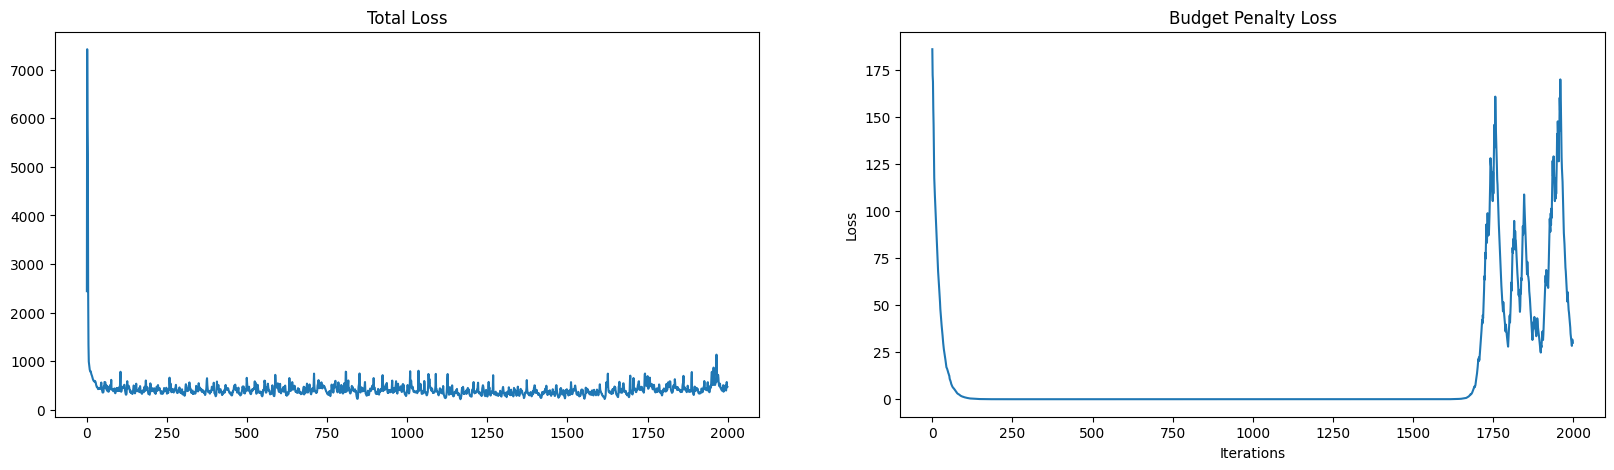

In [11]:
# plot graphs for the total loss and budget penalty loss with respect to the number of iterations

import matplotlib.pyplot as plt

# print(type(total_loss_list[0]))
# print(type(budget_penalty_loss_list[0]))
# print(total_loss_list[0])
# print(budget_penalty_loss_list[0])

total_loss_list = [float(i) for i in total_loss_list]
budget_penalty_loss_list = [float(i) for i in budget_penalty_loss_list]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plt.xlabel('Iterations')
plt.ylabel('Loss')

ax[0].plot(total_loss_list)
ax[0].set_title('Total Loss')

ax[1].plot(budget_penalty_loss_list)
ax[1].set_title('Budget Penalty Loss')

In [ ]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [ ]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])

print('Edges: ')
for e in G.edges:
    print(G.edges[e])

In [ ]:
trainer[cls_idx].dataset.draw(G, ax=None)

# Non-Mutagen Class (Class 1)

In [ ]:

cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=30,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=0.2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    # ged_closeness_criterion=GED_Closeness_Criterion(class_graphs=data_graphs[cls_idx], dataset_name='GED_Mutagenicity', discriminator=model, data_num_node_labels=len(dataset.NODE_CLS), k=10),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [ ]:
total_loss_list, budget_penalty_loss_list = trainer[cls_idx].train(2000)

In [ ]:
# plot graphs for the total loss and budget penalty loss with respect to the number of iterations


# print(type(total_loss_list[0]))
# print(type(budget_penalty_loss_list[0]))
# print(total_loss_list[0])
# print(budget_penalty_loss_list[0])

# import matplotlib.pyplot as plt

total_loss_list = [float(i) for i in total_loss_list]
budget_penalty_loss_list = [float(i) for i in budget_penalty_loss_list]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plt.xlabel('Iterations')
plt.ylabel('Loss')

ax[0].plot(total_loss_list)
ax[0].set_title('Total Loss')

ax[1].plot(budget_penalty_loss_list)
ax[1].set_title('Budget Penalty Loss')

In [ ]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [ ]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])
    
print('Edges: ')
for e in G.edges:
    print(G.edges[e])

In [ ]:
trainer[cls_idx].dataset.draw(G, ax=None)